In [1]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import corner
from bilby.core.prior import Constraint, PriorDict, Uniform, Sine
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [13]:
bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
#frequencies=[5e9, 2e17]
frequencies=[]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

[1.952e+14 2.601e+14 3.083e+14 3.454e+14 3.983e+14 4.825e+14 6.273e+14
 8.152e+14 1.141e+15]


[195200000000000.0,
 260100000000000.0,
 308300000000000.0,
 345400000000000.0,
 398300000000000.0,
 482500000000000.0,
 627300000000000.0,
 815200000000000.0,
 1141000000000000.0]

In [4]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,100,100) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=frequencies[7])
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    return constrained_params



In [5]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000

samples=priors.sample(1000)
afterglow_data=pd.DataFrame.from_dict(samples)

In [6]:
time=np.linspace(0.1,100,100)
count=0
for i in range(1000):
    flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat', **afterglow_data.iloc[i], output_format='flux_density', frequency=frequencies[7])
    if np.array(afterglow_data['thv'])[i]>np.array(afterglow_data['thc'])[i] == False:
        print('failed')
    if max(flux)<10e-12:
        print('failed flux')
    if time[np.argmax(flux)] >200:
        print('failed time')
        count+=1
afterglow_data

,redshift,thv,loge0,thc,logn0,p,logepse,logepsb,ksin,g0
0,0.01,1.377406,47.953715,0.048998,0.029531,2.3,-1.25,-2.5,1.0,1000.0
1,0.01,0.481781,52.529495,0.059166,1.074899,2.3,-1.25,-2.5,1.0,1000.0
2,0.01,1.550153,48.527237,0.029606,-1.539244,2.3,-1.25,-2.5,1.0,1000.0
3,0.01,0.964068,47.444502,0.097430,1.449541,2.3,-1.25,-2.5,1.0,1000.0
4,0.01,0.910366,52.911960,0.094908,-2.726055,2.3,-1.25,-2.5,1.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
995,0.01,0.921850,49.084204,0.076002,-0.621246,2.3,-1.25,-2.5,1.0,1000.0
996,0.01,1.351071,51.777366,0.079877,1.305163,2.3,-1.25,-2.5,1.0,1000.0
997,0.01,0.632607,48.213744,0.067158,-3.661072,2.3,-1.25,-2.5,1.0,1000.0
998,0.01,0.626717,49.301397,0.049587,-2.719509,2.3,-1.25,-2.5,1.0,1000.0


In [6]:
count

0

In [4]:
#priors

that_priorsoff = redback.priors.get_priors(model='tophat')
that_priorsoff['p']=  2.3
that_priorsoff['loge0']= Uniform(minimum=47, maximum=52, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorsoff['redshift']= 0.01
that_priorsoff['logepse']= -1.25
that_priorsoff['logepsb']= -2.5
that_priorsoff['ksin']= 1.0
that_priorsoff['g0']= 1000
that_priorsoff['logn0']=Uniform(minimum=-2, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)

that_priorson = redback.priors.get_priors(model='tophat')
that_priorson['p']=  2.3
that_priorson['loge0']= Uniform(minimum=46, maximum=50, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorson['redshift']= 0.01
that_priorson['logepse']= -1.25
that_priorson['logepsb']= -2.5
that_priorson['ksin']= 1.0
that_priorson['g0']= 1000
that_priorson['logn0']=Uniform(minimum=-2.5, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
that_priorson['thv']=Sine(minimum=0, maximum=0.3, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)


,redshift,mej,vej_1,vej_2,kappa,beta
0,0.01,0.014954,0.090802,0.461118,4.769112,5.964735
1,0.01,0.024337,0.110204,0.347077,1.814332,2.484260
2,0.01,0.027923,0.150903,0.363120,9.369341,2.452077
3,0.01,0.012944,0.109164,0.416006,15.711063,1.521342
4,0.01,0.017158,0.131450,0.358153,5.448709,5.708863
...,...,...,...,...,...,...
4995,0.01,0.014248,0.100497,0.375272,20.442191,3.762632
4996,0.01,0.015632,0.098224,0.431956,6.774939,5.772264
4997,0.01,0.038988,0.182688,0.388444,8.212301,3.301581
4998,0.01,0.034080,0.167906,0.467670,29.139355,3.529483


In [3]:

kn_priors = redback.priors.get_priors(model='bulla_bns_kilonova')
kn_priors['redshift']=0.01
#kn_priors['beta']=Uniform(minimum=3.001, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
samples=kn_priors.sample(5000)
kn_data= pd.DataFrame.from_dict(samples)
kn_data

,redshift,mej_dyn,mej_disk,phi,costheta_obs
0,0.01,0.012676,0.014536,56.535976,0.324937
1,0.01,0.011691,0.095023,74.141039,0.674929
2,0.01,0.004573,0.031573,12.873976,0.924265
3,0.01,0.016402,0.090699,42.755567,0.570797
4,0.01,0.007772,0.038382,51.008627,0.278406
...,...,...,...,...,...
4995,0.01,0.016419,0.098715,13.599603,0.476268
4996,0.01,0.009987,0.098346,2.092357,0.354825
4997,0.01,0.014841,0.087786,49.386925,0.758584
4998,0.01,0.009518,0.070236,43.328279,0.603982


In [6]:
kn_priors

{'redshift': DeltaFunction(peak=0.01, name=None, latex_label=None, unit=None),
 'mej_dyn': Uniform(minimum=0.001, maximum=0.02, name='mej_dyn', latex_label='$M_{\\mathrm{ej-dyn}}~(M_{\\odot})$', unit=None, boundary=None),
 'mej_disk': Uniform(minimum=0.01, maximum=0.13, name='mej_disk', latex_label='$M_{\\mathrm{ej-disk}}~(M_{\\odot})$', unit=None, boundary=None),
 'phi': Uniform(minimum=0, maximum=90, name='phi', latex_label='$\\phi~(^\\circ)$', unit=None, boundary=None),
 'costheta_obs': Uniform(minimum=0, maximum=1, name='costheta_obs', latex_label='$\\cos~\\theta_{\\mathrm{obs}}$', unit=None, boundary=None)}

In [4]:
def afterglowoff(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.84, loge0=49.2 , thc= 0.06, logn0=0.05, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def afterglowon(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.14, loge0=47.7 , thc= 0.06, logn0=0.35, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def sampleoff(time,frequency):
    sample=that_priorsoff.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]<= 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorsoff.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def sampleon(time,frequency):
    sample=that_priorson.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]> 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorson.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def agsample(time, frequency):
    sample=priors.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    return ag_fluxd

def knsample(time, frequency, **sample):
    
    kn_fluxd =  redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
        base_model='bulla_bns_kilonova', output_format='flux_density', frequency=frequency, **sample)
   
    return kn_fluxd



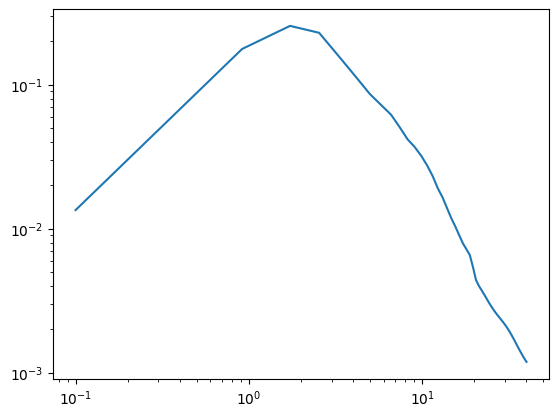

In [11]:
time=np.linspace(0.1,40,50)
sample=kn_priors.sample(1)
frequency=np.ones(len(time)) * frequencies[2]
flux= redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
        base_model='bulla_bns_kilonova', output_format='flux_density', frequency=frequency, **sample)
ax=plt.subplot()
ax.loglog(time,flux)
plt.show()

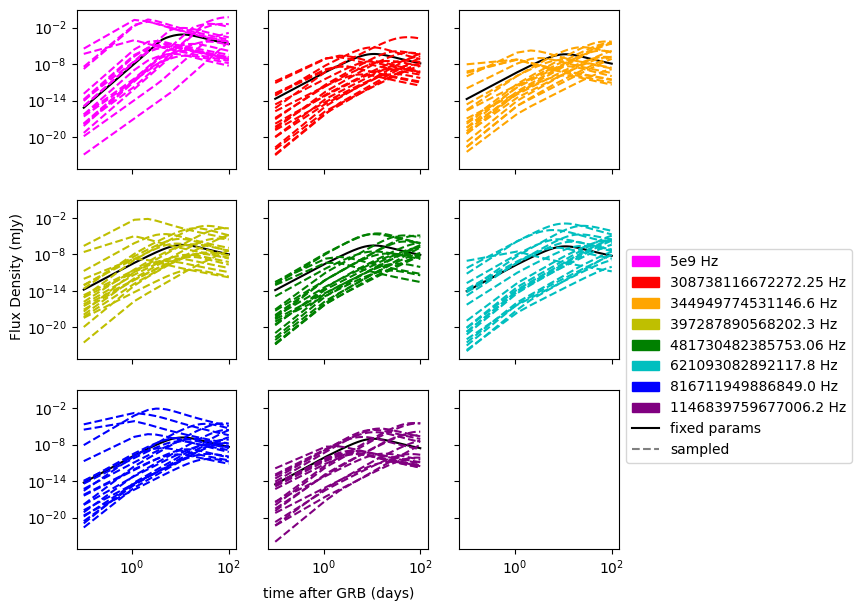

In [9]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7),sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowoff(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleoff(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleoff(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleoff(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleoff(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleoff(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleoff(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleoff(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleoff(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')


f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,fix,samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

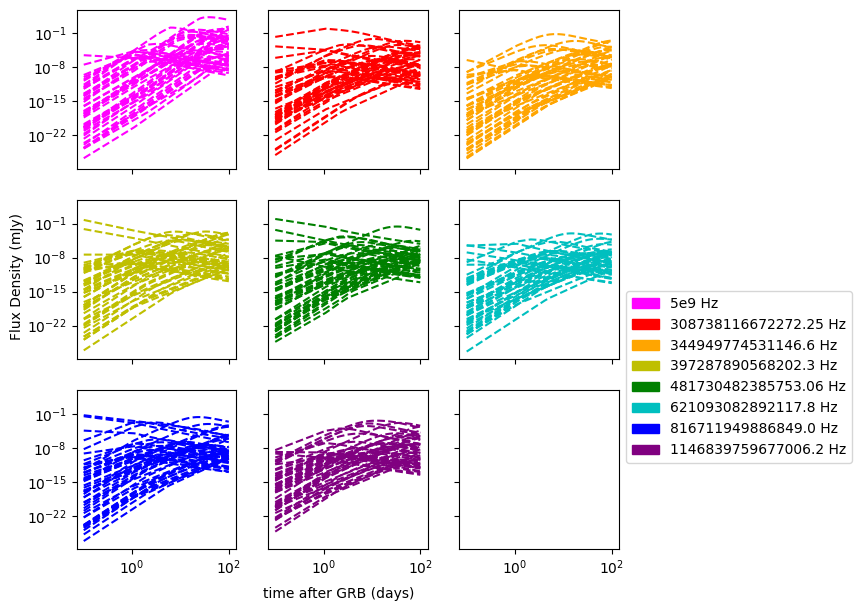

In [18]:
#using constraints- not filtered by on/off axis
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7),sharex=True, sharey=True)

for i in range(50):
    ax[0,0].loglog(time, agsample(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, agsample(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, agsample(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, agsample(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, agsample(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, agsample(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, agsample(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, agsample(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
    
f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

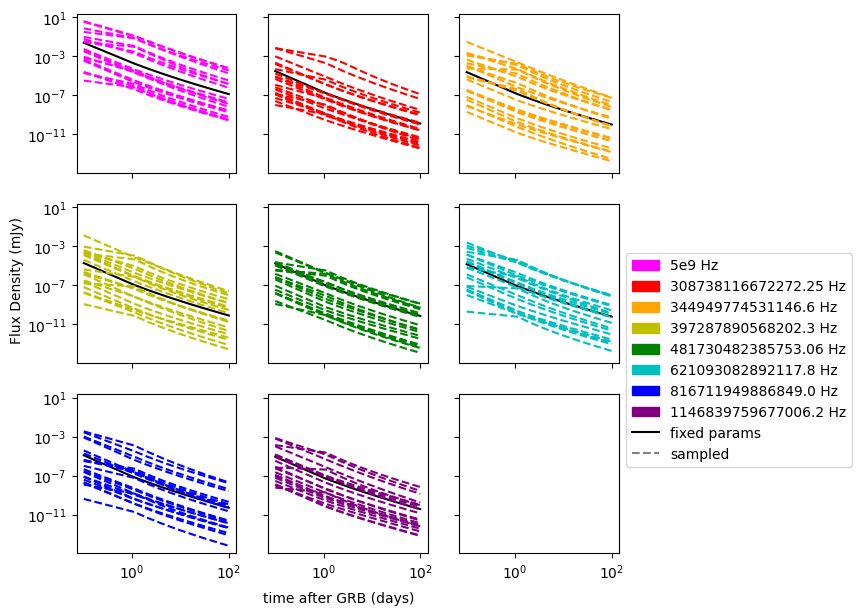

In [42]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleon(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleon(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleon(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleon(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleon(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleon(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleon(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleon(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, fix, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

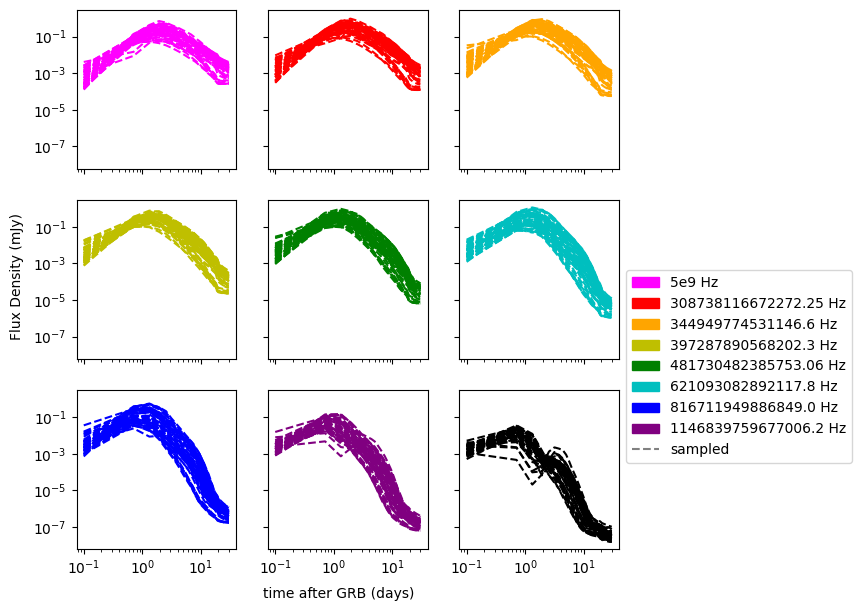

In [15]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

for i in range(50):
    ax[0,0].loglog(time, knsample(time, np.ones(len(time)) *frequencies[0],**kn_data.iloc[i]), c='magenta', ls='--')
    ax[0,1].loglog(time, knsample(time, np.ones(len(time)) *frequencies[1],**kn_data.iloc[i]), c='r', ls='--')
    ax[0,2].loglog(time, knsample(time, np.ones(len(time)) *frequencies[2],**kn_data.iloc[i]), c='orange', ls='--')
    ax[1,0].loglog(time, knsample(time, np.ones(len(time)) *frequencies[3],**kn_data.iloc[i]), c='y', ls='--')
    ax[1,1].loglog(time, knsample(time, np.ones(len(time)) *frequencies[4],**kn_data.iloc[i]), c='g', ls='--')
    ax[1,2].loglog(time, knsample(time, np.ones(len(time)) *frequencies[5],**kn_data.iloc[i]), c='c', ls='--')
    ax[2,0].loglog(time, knsample(time, np.ones(len(time)) *frequencies[6],**kn_data.iloc[i]), c='b', ls='--')
    ax[2,1].loglog(time, knsample(time, np.ones(len(time)) *frequencies[7],**kn_data.iloc[i]), c='purple', ls='--')    
    ax[2,2].loglog(time, knsample(time, np.ones(len(time)) *frequencies[8],**kn_data.iloc[i]), c='k', ls='--')
#plt.ylim(10e-30,10) 

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

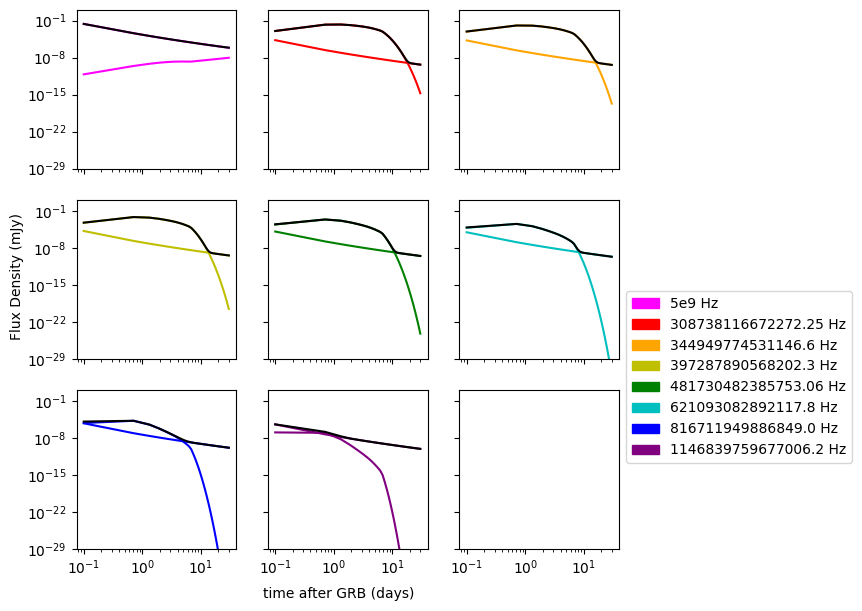

In [51]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0], **kn_data.iloc[1]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[1]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[1]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[1]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[1]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[1]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[1]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[1]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowon(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[1]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[1]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[1]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[1]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[1]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[1]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[1]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

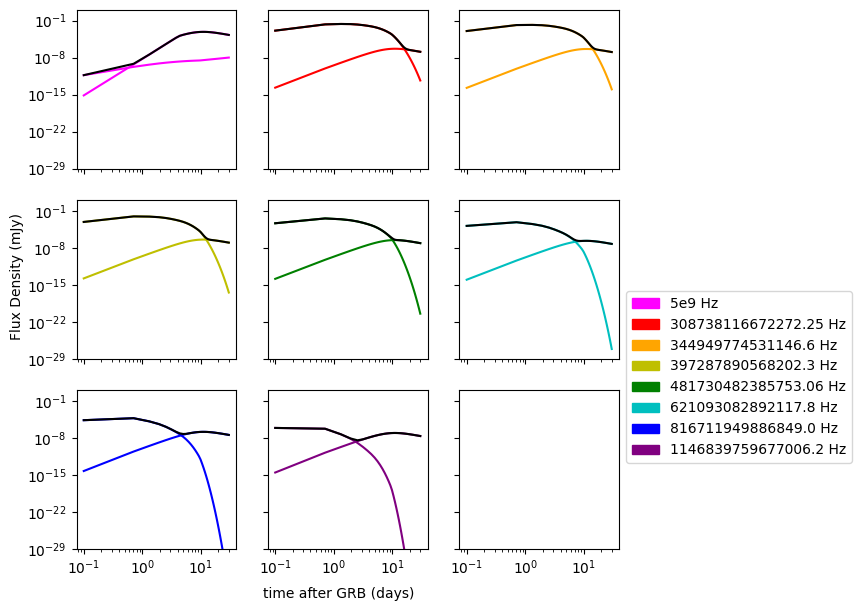

In [195]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0], **kn_data.iloc[13]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[13]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[13]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[13]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[13]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[13]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[13]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[13]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[13]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[13]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[13]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[13]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[13]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[13]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[13]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[13]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



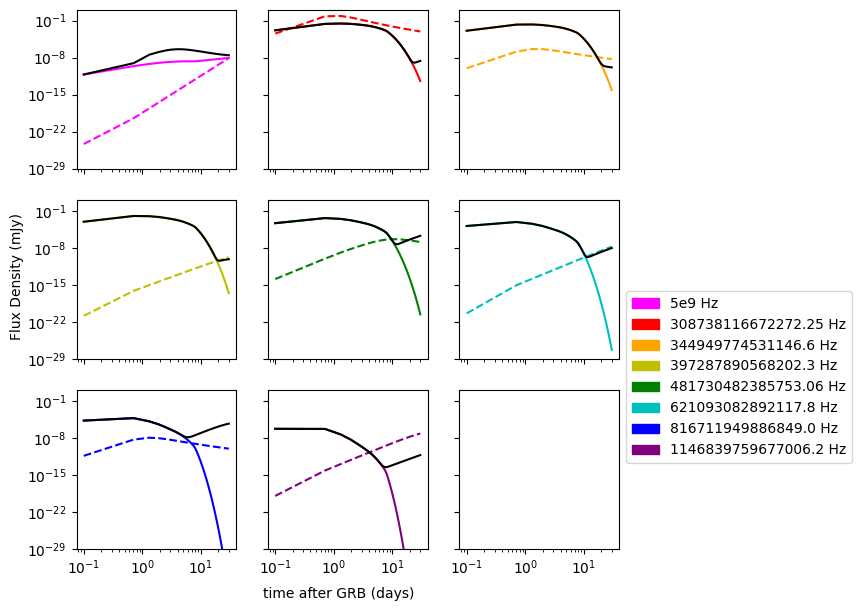

In [34]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, agsample(time, frequencies[0]), c='magenta', ls='--')
ax[0,1].loglog(time, agsample(time, frequencies[1]), c='r', ls='--')
ax[0,2].loglog(time, agsample(time, frequencies[2]), c='orange', ls='--')
ax[1,0].loglog(time, agsample(time, frequencies[3]), c='y', ls='--')
ax[1,1].loglog(time, agsample(time, frequencies[4]), c='g', ls='--')
ax[1,2].loglog(time, agsample(time, frequencies[5]), c='c', ls='--')
ax[2,0].loglog(time, agsample(time, frequencies[6]), c='b', ls='--')
ax[2,1].loglog(time, agsample(time, frequencies[7]), c='purple', ls='--')    
#ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')

ax[0,0].loglog(time, knsample(time, frequencies[0],**kn_data.iloc[13]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[13]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[13]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[13]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[13]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[13]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[13]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[13]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, agsample(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[13]), c='k')
ax[0,1].loglog(time, agsample(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[13]), c='k')
ax[0,2].loglog(time, agsample(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[13]), c='k')
ax[1,0].loglog(time, agsample(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[13]), c='k')
ax[1,1].loglog(time, agsample(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[13]), c='k')
ax[1,2].loglog(time, agsample(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[13]), c='k')
ax[2,0].loglog(time, agsample(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[13]), c='k')
ax[2,1].loglog(time, agsample(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[13]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



In [5]:
kn2_priors = redback.priors.get_priors(model='two_component_kilonova_model')
kn2_priors['redshift']=0.01
#kn_priors['beta']=Uniform(minimum=3.001, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
samples=kn2_priors.sample(5000)
kn2_data= pd.DataFrame.from_dict(samples)
kn2_data

,redshift,mej_1,mej_2,vej_1,vej_2,kappa_1,kappa_2,temperature_floor_1,temperature_floor_2
0,0.01,0.025893,0.025741,0.171794,0.448358,1.715530,7.399717,2320.634783,2438.843044
1,0.01,0.022246,0.015899,0.456511,0.387677,14.738977,21.106948,139.998917,733.453333
2,0.01,0.016148,0.017574,0.121975,0.240162,14.283371,22.787193,2685.425458,402.819309
3,0.01,0.015882,0.015864,0.185877,0.121540,9.154007,14.503028,1184.590344,1946.680041
4,0.01,0.015543,0.016402,0.339651,0.124078,24.989445,9.806760,1247.653334,377.966489
...,...,...,...,...,...,...,...,...,...
4995,0.01,0.023344,0.016293,0.296242,0.423844,12.789234,27.447215,272.058131,3899.774952
4996,0.01,0.019882,0.025754,0.130221,0.272625,9.165585,9.262839,1016.867379,1866.217639
4997,0.01,0.024633,0.026402,0.324830,0.440393,2.206784,25.836228,321.688683,2749.119098
4998,0.01,0.017100,0.013110,0.494335,0.404436,3.887265,5.444314,3765.938080,750.808471


In [4]:
#time= np.linspace(0.1,40,250)

onaxis_ag= pd.read_csv('onaxis_samples_redback.csv')
onaxis_ag.drop('Unnamed: 0', axis=1, inplace=True)
offaxis_ag= pd.read_csv('offaxis_samples_redback.csv')
offaxis_ag.drop('Unnamed: 0', axis=1, inplace=True)
    

In [5]:
onaxis_ag

,redshift,thv,loge0,thc,logn0,p,logepse,logepsb,xiN,g0
0,0.01,0.059606,49.966519,0.099019,1.113714,2.3,-1.25,-2.5,1.0,1000.0
1,0.01,0.020178,50.760906,0.091952,-4.640227,2.3,-1.25,-2.5,1.0,1000.0
2,0.01,0.013048,48.787832,0.065826,-1.921610,2.3,-1.25,-2.5,1.0,1000.0
3,0.01,0.025946,50.694847,0.054793,0.888745,2.3,-1.25,-2.5,1.0,1000.0
4,0.01,0.029939,49.253369,0.039387,-4.406127,2.3,-1.25,-2.5,1.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
4995,0.01,0.014759,50.082793,0.092245,-4.723230,2.3,-1.25,-2.5,1.0,1000.0
4996,0.01,0.008137,50.104336,0.020813,-3.660380,2.3,-1.25,-2.5,1.0,1000.0
4997,0.01,0.096606,49.986899,0.098157,0.614649,2.3,-1.25,-2.5,1.0,1000.0
4998,0.01,0.051841,49.293820,0.081259,-2.100860,2.3,-1.25,-2.5,1.0,1000.0


In [14]:
time= np.linspace(0.1,50,300)
maximumoff= []
minimumoff= []
loweroff=[]
medianoff=[]
upperoff=[]

for j in range(1,10): #loop each freqeuncy
    maximum= []
    minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(200): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat_from_emulator', output_format='flux_density', frequency=frequencies[j], **offaxis_ag.iloc[k])
            pointintime.append(offflux[i])
            
        maximum.append(max(pointintime))
        minimum.append(min(pointintime))
        lower.append(np.percentile(pointintime,16))
        median.append(np.percentile(pointintime,50))
        upper.append(np.percentile(pointintime,84))
        
    maximumoff.append(maximum)
    minimumoff.append(minimum)
    loweroff.append(lower)
    medianoff.append(median)
    upperoff.append(upper)


In [3]:
print(loweroff)


KeyboardInterrupt



In [19]:
print(medianoff)

[[8.321197505973252e-16, 4.1953419559146853e-14, 3.5998643365389533e-13, 1.240390045755105e-12, 2.8744750751030806e-12, 8.98346061460172e-12, 1.7541838078743742e-11, 3.480228971866108e-11, 4.2750085962559976e-11, 5.0777916619000924e-11, 5.988600290726848e-11, 8.639327059448502e-11, 7.761328737418745e-11, 7.612787684004345e-11, 8.225376652463155e-11, 8.433978432923623e-11, 9.603740465353616e-11, 8.728096596550443e-11, 7.862331373382904e-11, 9.0612850936008e-11, 1.1094047331874944e-10, 1.1676403906938787e-10, 1.2192949389070917e-10, 1.220642286904351e-10, 1.1433429945470962e-10, 1.1026278194131283e-10, 1.2645673734408e-10, 1.3886074474533752e-10, 1.4095767573232128e-10, 1.4888518340280489e-10, 1.4740960131159096e-10, 1.4025380533551025e-10, 1.4717960647877627e-10, 1.580548561491649e-10, 1.4679287073361623e-10, 1.3942972838405538e-10, 1.3410683858364658e-10, 1.350393388531299e-10, 1.4780412138830825e-10, 1.6043833965398152e-10, 1.7724123785560213e-10, 1.7674525803982624e-10, 1.72288789006

In [20]:
print(upperoff)

[[5.6476228532103964e-11, 4.1605248200304224e-09, 5.849474221263026e-09, 1.1051343309784967e-08, 1.8976322881612347e-08, 3.290101296802259e-08, 6.8329848770158e-08, 1.0762993617120562e-07, 1.9234344442227069e-07, 2.9129813810632285e-07, 3.5157935427120435e-07, 4.6878784949813577e-07, 3.9837119292199464e-07, 4.5100133767876893e-07, 4.87887511131415e-07, 5.643781193335267e-07, 4.949965062928004e-07, 5.050266049472516e-07, 5.925744495196577e-07, 7.816647722017931e-07, 1.0132901572323764e-06, 1.1389249798310442e-06, 1.0980546147607974e-06, 1.0048719754749983e-06, 9.770958208160923e-07, 1.0216184907823548e-06, 1.066141160748617e-06, 1.1189635481615429e-06, 1.2485327379103144e-06, 1.2063357331706931e-06, 1.2436762959539466e-06, 1.22638062209763e-06, 1.1365658775426754e-06, 1.1185240931987167e-06, 1.1262724839638711e-06, 1.185755322262509e-06, 1.261697645564374e-06, 1.2818673223676674e-06, 1.4730741191534374e-06, 1.577406950543192e-06, 1.5408612115061091e-06, 1.626075125480105e-06, 1.82944925

In [3]:
#tophat_redback from emulator
loweroff2=[[6.740620953288015e-20, 1.3836447284715614e-18, 5.885000704403535e-18, 1.5340367971301742e-17, 3.423232983242356e-17, 6.808133890337026e-17, 1.1876153142520628e-16, 2.1263325869184643e-16, 3.2239472459363136e-16, 4.3867055379303314e-16, 6.611544185966886e-16, 9.462363799603387e-16, 1.2379092335365169e-15, 1.7632644481262575e-15, 2.3247340120832526e-15, 2.8600739276309427e-15, 4.10566175385873e-15, 5.061522209678749e-15, 6.208551375383602e-15, 7.925141491164788e-15, 9.641731606945972e-15, 1.1299499812728725e-14, 1.2905656160451478e-14, 1.451181250817423e-14, 1.6415066046217956e-14, 2.0447858877709007e-14, 2.2577965951353526e-14, 2.784098373490469e-14, 3.317939510647894e-14, 3.9188551875413894e-14, 4.8608465581212936e-14, 5.78661366587507e-14, 6.241233270273813e-14, 6.753834694430317e-14, 7.266436118586823e-14, 7.624628987840906e-14, 7.94845922304139e-14, 8.313109581895559e-14, 9.661418920983575e-14, 1.114971131981417e-13, 1.264854113245809e-13, 1.4168270785968855e-13, 1.5688000439479621e-13, 1.691729859099363e-13, 1.8176473107233056e-13, 1.961806174868192e-13, 2.2309040279759023e-13, 2.5908054641706067e-13, 2.872260984635512e-13, 3.0104806863205846e-13, 3.310181340398116e-13, 3.6090870690556213e-13, 3.751773391731787e-13, 3.9046540642417e-13, 4.0650332537147784e-13, 4.0821945316265034e-13, 4.0191751792555634e-13, 4.002433932230762e-13, 4.192894180821009e-13, 4.593815744631329e-13, 4.876189774098995e-13, 5.165960585678097e-13, 5.52367765414638e-13, 5.887131474508008e-13, 6.25058529486964e-13, 6.614039115231272e-13, 6.9774929355929e-13, 7.340946755954531e-13, 7.704400576316163e-13, 7.678108425526289e-13, 7.918834951503797e-13, 8.183530497513925e-13, 8.67782938253794e-13, 8.800951063048589e-13, 9.803168117119564e-13, 9.968912945300698e-13, 1.0721518120609315e-12, 1.1764234319807033e-12, 1.2920717516961298e-12, 1.407720071411556e-12, 1.5233683911269823e-12, 1.6390167108424077e-12, 1.7234971022770847e-12, 1.7138548419623052e-12, 1.7132430020885333e-12, 1.7923575281484031e-12, 1.871472054208273e-12, 1.9505865802681434e-12, 2.0297011063280124e-12, 2.0859780445583334e-12, 2.0549510048736654e-12, 2.0274419761584443e-12, 2.0002477496761665e-12, 1.973865129898082e-12, 1.9474825101199973e-12, 1.922752613071176e-12, 1.9874585484583155e-12, 2.049054409954847e-12, 2.0227040842908145e-12, 2.030124227120848e-12, 2.0929381688988684e-12, 2.1692677793975797e-12, 2.311741113337458e-12, 2.454214447277333e-12, 2.596687781217208e-12, 2.7391611151570867e-12, 2.8816344490969614e-12, 3.0241077830368364e-12, 3.124544672049623e-12, 3.199082205395169e-12, 3.154413917699794e-12, 3.1097456300044197e-12, 3.0650773423090453e-12, 3.02040905461367e-12, 2.975740766918296e-12, 2.9310724792229216e-12, 2.8864041915275463e-12, 2.841735903832172e-12, 2.813766930023815e-12, 2.844226378241642e-12, 2.8427310973655685e-12, 2.796869968095232e-12, 2.7661407540009512e-12, 2.7426856356292856e-12, 2.71923051725762e-12, 2.6957753988859543e-12, 2.672516449779704e-12, 2.696451370220536e-12, 2.670367143876056e-12, 2.6442829175315763e-12, 2.618198691187096e-12, 2.592114464842616e-12, 2.5660302384981362e-12, 2.5627342716711033e-12, 2.6335811727067824e-12, 2.704428073742463e-12, 2.775274974778142e-12, 2.8464190677164273e-12, 2.9177941450745504e-12, 2.959243053982509e-12, 2.9203727721936658e-12, 2.894467558077265e-12, 2.8685623439608636e-12, 2.8426571298444623e-12, 2.816751915728061e-12, 2.7908467016116597e-12, 2.787958074970398e-12, 2.7779659313933216e-12, 2.8125706729674847e-12, 2.7851090964568574e-12, 2.7764764517415814e-12, 2.764656242576739e-12, 2.7367143484776816e-12, 2.708772454378626e-12, 2.6808305602795693e-12, 2.700506028904106e-12, 2.8109842448013345e-12, 2.925238909035782e-12, 3.039493573270232e-12, 3.15374823750468e-12, 3.233938973241459e-12, 3.236976632577633e-12, 3.3199138905039637e-12, 3.408988943002479e-12, 3.3496851335990716e-12, 3.2903813241956633e-12, 3.231077514792254e-12, 3.1717737053888463e-12, 3.1124698959854383e-12, 3.053166086582029e-12, 2.9938622771786205e-12, 2.9417294416644722e-12, 2.919745301363487e-12, 2.9047220182300305e-12, 2.889698735096573e-12, 2.8746754519631167e-12, 2.85965216882966e-12, 2.8446288856962034e-12, 2.8296056025627465e-12, 2.8145823194292896e-12, 2.7995590362958327e-12, 2.7845357531623762e-12, 2.7695124700289194e-12, 2.7544891868954625e-12, 2.739465903762006e-12, 2.724442620628549e-12, 2.709419337495092e-12, 2.6943960543616354e-12, 2.6793727712281785e-12, 2.6643494880947216e-12, 2.649326204961265e-12, 2.6343029218278083e-12, 2.622615556853281e-12, 2.619793617398164e-12, 2.6360410018757075e-12, 2.6156617380896743e-12, 2.595282474303642e-12, 2.5805857294683388e-12, 2.6625569720646904e-12, 2.7475268154301115e-12, 2.832496658795533e-12, 2.917466502160954e-12, 2.9103255307344837e-12, 2.883369379328959e-12, 2.8589118039661556e-12, 2.844409829659983e-12, 2.82990785535381e-12, 2.815405881047638e-12, 2.800903906741465e-12, 2.8039836716479197e-12, 2.852861601567878e-12, 2.9179455481278136e-12, 2.9830294946877485e-12, 3.048113441247684e-12, 3.1131973878076193e-12, 3.138348807562847e-12, 3.194109949880557e-12, 3.2510386941209264e-12, 3.2120879324791025e-12, 3.1700025503545033e-12, 3.1279171682299026e-12, 3.0858317861053034e-12, 3.0540710780467444e-12, 3.028238100839981e-12, 3.002405123633218e-12, 2.9765721464264547e-12, 2.9615126692744463e-12, 2.9469334138988446e-12, 2.9323541585232433e-12, 2.917774903147642e-12, 2.9439715642681496e-12, 2.9746356839524896e-12, 3.020518530416147e-12, 3.0664013768798034e-12, 3.1122842233434603e-12, 3.1709451614049595e-12, 3.246230524026935e-12, 3.3219582749271935e-12, 3.397686025827449e-12, 3.4558706440966118e-12, 3.4756147868954395e-12, 3.4540097664222146e-12, 3.4364427328869945e-12, 3.464966610528159e-12, 3.506732512677954e-12, 3.5395646711087366e-12, 3.572393243893492e-12, 3.650601454144645e-12, 3.744772834278234e-12, 3.8389442144118186e-12, 3.884310503136461e-12, 3.869382781287115e-12, 3.854455059437768e-12, 3.8395273375884215e-12, 3.824599615739074e-12, 3.809671893889728e-12, 3.794744172040381e-12, 3.779816450191035e-12, 3.764888728341688e-12, 3.749961006492341e-12, 3.735033284642994e-12, 3.720105562793648e-12, 3.7051778409443014e-12, 3.690250119094954e-12, 3.675322397245608e-12, 3.660394675396261e-12, 3.645466953546914e-12, 3.630539231697568e-12, 3.6156115098482204e-12, 3.6006837879988745e-12, 3.5857560661495273e-12, 3.5708283443001806e-12, 3.554292399307719e-12, 3.536750660036827e-12, 3.519208920765934e-12, 3.501667181495042e-12, 3.484125442224149e-12, 3.466583702953256e-12, 3.449041963682364e-12, 3.4356123514985628e-12, 3.431505069007025e-12, 3.4273977865154875e-12, 3.4232905040239497e-12, 3.4191832215324122e-12, 3.4150759390408744e-12, 3.4625121563692123e-12, 3.5154332446366097e-12, 3.5683543329040104e-12, 3.6212754211714073e-12, 3.6741965094388055e-12, 3.727117597706203e-12, 3.7800386859736e-12, 3.832959774240998e-12, 3.883894898309923e-12, 3.866229398202393e-12, 3.848563898094864e-12, 3.830898397987334e-12, 3.8093577081594155e-12, 3.7852891627854135e-12, 3.761220617411413e-12], [5.4148398431665664e-20, 1.1037820290522093e-18, 4.6977268523847675e-18, 1.224345725466219e-17, 2.7176316352156436e-17, 5.4485431198507673e-17, 9.497310206958227e-17, 1.7001313815269698e-16, 2.574142519623345e-16, 3.5020319303394634e-16, 5.270624411761411e-16, 7.525416737969779e-16, 9.83473209856672e-16, 1.4033988254180343e-15, 1.8184181062601406e-15, 2.261263355185324e-15, 3.230075614724741e-15, 4.020528145523042e-15, 4.9345853050744105e-15, 6.326216151981349e-15, 7.717846998888289e-15, 9.04957735369982e-15, 1.0328749474753982e-14, 1.1607921595808144e-14, 1.3131689527866292e-14, 1.6100688678059577e-14, 1.778457159992283e-14, 2.195520505810904e-14, 2.6185585807019158e-14, 3.0943371009522117e-14, 3.747477624354283e-14, 4.040142017659562e-14, 4.358194585888235e-14, 4.7096679912748015e-14, 5.061141396661369e-14, 5.2943284115488083e-14, 5.491959968200344e-14, 6.022183434403636e-14, 6.875677019854319e-14, 7.804487999181105e-14, 8.791513976000293e-14, 1.0150311632727016e-13, 1.150910928945374e-13, 1.2790331408085222e-13, 1.4003689494135561e-13, 1.521704758018591e-13, 1.7309096678785085e-13, 2.0104165319226102e-13, 2.2351115563206666e-13, 2.3329792902921427e-13, 2.569208271806959e-13, 2.804790993067262e-13, 2.913370110560292e-13, 3.0347575680213943e-13, 3.214708237045904e-13, 3.229321275279645e-13, 3.185639578306718e-13, 3.174008161061349e-13, 3.297275815202374e-13, 3.5537962261470135e-13, 3.8239583086833474e-13, 3.802560118675273e-13, 4.024724694381067e-13, 4.3083192527702063e-13, 4.591913811159348e-13, 4.87550836954849e-13, 5.15910292793763e-13, 5.442697486326772e-13, 5.726292044715914e-13, 5.97372871010713e-13, 5.868559993571961e-13, 6.051057052862446e-13, 6.561457326545822e-13, 6.977936313303406e-13, 7.682615040921157e-13, 7.948752035041941e-13, 8.395548160413154e-13, 9.170097777479875e-13, 1.006779378297135e-12, 1.0965489788462824e-12, 1.1863185793954299e-12, 1.2760881799445765e-12, 1.3629336916823787e-12, 1.355553499494616e-12, 1.3481733073068533e-12, 1.3973983506951128e-12, 1.4587821266888075e-12, 1.5201659026825027e-12, 1.5815496786761973e-12, 1.642933454669892e-12, 1.6502692698821459e-12, 1.6278112227244082e-12, 1.6053531755666696e-12, 1.5828951284089313e-12, 1.5612398076748247e-12, 1.539634974003824e-12, 1.5539184331194752e-12, 1.628491049611851e-12, 1.6069845029268682e-12, 1.5989040595607224e-12, 1.6631077221652362e-12, 1.713840642414461e-12, 1.826012758557373e-12, 1.9381848747002824e-12, 2.0503569908431923e-12, 2.162529106986105e-12, 2.2747012231290143e-12, 2.386873339271924e-12, 2.472698204293762e-12, 2.5212568232125502e-12, 2.4855768249394686e-12, 2.4498968266663877e-12, 2.4142168283933065e-12, 2.378536830120225e-12, 2.342856831847144e-12, 2.3071768335740627e-12, 2.271496835300981e-12, 2.2358168370279002e-12, 2.2079352450260184e-12, 2.243234780380854e-12, 2.241186308327706e-12, 2.211107519319545e-12, 2.1875484703647055e-12, 2.167123539773778e-12, 2.14669860918285e-12, 2.1262736785919224e-12, 2.107688363081891e-12, 2.113261887465438e-12, 2.094228502765523e-12, 2.075195118065608e-12, 2.056161733365693e-12, 2.037128348665778e-12, 2.0180949639658634e-12, 2.010744239610726e-12, 2.0663910210067854e-12, 2.1220378024028462e-12, 2.1776845837989063e-12, 2.233331365194966e-12, 2.288978146591027e-12, 2.3446249279870867e-12, 2.3293606439259627e-12, 2.3099237605800234e-12, 2.288938051589401e-12, 2.267952342598779e-12, 2.246966633608156e-12, 2.2259809246175335e-12, 2.2090873096294703e-12, 2.215690048210028e-12, 2.212551762046106e-12, 2.1914954014258747e-12, 2.192834928204965e-12, 2.179128004079933e-12, 2.158750721907743e-12, 2.138373439735554e-12, 2.1179961575633646e-12, 2.134342919599957e-12, 2.219495029100006e-12, 2.309864823425216e-12, 2.4002346177504276e-12, 2.490604412075638e-12, 2.5474739665219918e-12, 2.5543641365070153e-12, 2.613683324040249e-12, 2.685430891155286e-12, 2.6473614562005715e-12, 2.601381338712897e-12, 2.5554012212252216e-12, 2.5094211037375464e-12, 2.4634409862498712e-12, 2.417460868762196e-12, 2.3714807512745213e-12, 2.3262868290343557e-12, 2.3088878434683996e-12, 2.296772092496079e-12, 2.2846563415237575e-12, 2.2725405905514372e-12, 2.2604248395791158e-12, 2.248309088606795e-12, 2.2361933376344745e-12, 2.2240775866621535e-12, 2.211961835689833e-12, 2.1998460847175118e-12, 2.187730333745191e-12, 2.17561458277287e-12, 2.1634988318005494e-12, 2.1513830808282284e-12, 2.1392673298559077e-12, 2.1271515788835867e-12, 2.115035827911266e-12, 2.102920076938945e-12, 2.0908043259666244e-12, 2.0786885749943033e-12, 2.068156997608385e-12, 2.06569780209125e-12, 2.0708494034699296e-12, 2.0546491366852366e-12, 2.0384488699005436e-12, 2.0236130904237194e-12, 2.08302797533768e-12, 2.148312468599751e-12, 2.2135969618618217e-12, 2.2788814551238925e-12, 2.298517565866368e-12, 2.2762092858082873e-12, 2.253901005750206e-12, 2.231592725692126e-12, 2.2127736171243412e-12, 2.202119766101071e-12, 2.191465915077801e-12, 2.1808120640545307e-12, 2.1744837585546296e-12, 2.221291260926094e-12, 2.2768327866043226e-12, 2.3348907536981028e-12, 2.392948720791883e-12, 2.4472760063477208e-12, 2.426196361788738e-12, 2.4059013096004375e-12, 2.4392385675783223e-12, 2.472575825556207e-12, 2.4501612514174362e-12, 2.4164874152345505e-12, 2.391802902857282e-12, 2.3722794533589484e-12, 2.3527560038606146e-12, 2.3353830973620668e-12, 2.324629224410175e-12, 2.313875351458284e-12, 2.3031214785063924e-12, 2.3089872123674017e-12, 2.332561331856571e-12, 2.3571595640668656e-12, 2.3930421312437508e-12, 2.428924698420636e-12, 2.4648072655975215e-12, 2.5006898327744067e-12, 2.5455638384797087e-12, 2.6005155953492903e-12, 2.659072629892767e-12, 2.7173719466019906e-12, 2.7219371742185417e-12, 2.6992025356775005e-12, 2.7163021735079424e-12, 2.739439223718437e-12, 2.7746985910001112e-12, 2.8099579582817863e-12, 2.812114740785408e-12, 2.8739480970570966e-12, 2.94854098344096e-12, 3.0231338698248213e-12, 3.07600683762909e-12, 3.06414051979381e-12, 3.05227420195853e-12, 3.04040788412325e-12, 3.0285415662879694e-12, 3.0166752484526893e-12, 3.004808930617409e-12, 2.992942612782129e-12, 2.981076294946849e-12, 2.9692099771115684e-12, 2.9573436592762882e-12, 2.945477341441008e-12, 2.9336110236057275e-12, 2.921744705770448e-12, 2.9098783879351677e-12, 2.898012070099887e-12, 2.886145752264607e-12, 2.874279434429327e-12, 2.8624131165940467e-12, 2.8505467987587666e-12, 2.838680480923486e-12, 2.826814163088206e-12, 2.8139571019116215e-12, 2.8004804227495962e-12, 2.7870037435875706e-12, 2.7735270644255457e-12, 2.7600503852635197e-12, 2.7465737061014944e-12, 2.733097026939469e-12, 2.722145622572237e-12, 2.7194147880224425e-12, 2.716683953472648e-12, 2.7139531189228526e-12, 2.7112222843730585e-12, 2.7115905916130628e-12, 2.7543884034358153e-12, 2.7971862152585673e-12, 2.8399840270813214e-12, 2.8827818389040735e-12, 2.9255796507268255e-12, 2.9683774625495776e-12, 3.01117527437233e-12, 3.0517303385407933e-12, 3.038678843315811e-12, 3.025627348090829e-12, 3.0125758528658477e-12, 2.999524357640866e-12, 2.982910866366083e-12, 2.9639738213766946e-12, 2.9450367763873066e-12], [4.671946409682023e-20, 9.50153954311262e-19, 4.043127807523406e-18, 1.0544609149654411e-17, 2.3329232177535082e-17, 4.6924693246971133e-17, 8.176264395868323e-17, 1.4663838833747544e-16, 2.215697793141079e-16, 3.0142699478359534e-16, 4.533479624975678e-16, 6.469452204225171e-16, 8.438451079935781e-16, 1.2052211070815792e-15, 1.5443252025083423e-15, 1.9280813179751815e-15, 2.756875889502221e-15, 3.4386960445225368e-15, 4.215788447137263e-15, 5.419734292245645e-15, 6.623680137354027e-15, 7.766975527793305e-15, 8.857054648007086e-15, 9.947133768220866e-15, 1.1256479406615109e-14, 1.3769813658361487e-14, 1.5240381754239988e-14, 1.8832947665655432e-14, 2.2477030745467412e-14, 2.6589860912443353e-14, 2.937877008812671e-14, 3.250310636255807e-14, 3.531646373636772e-14, 3.7720450400050415e-14, 4.012443706373312e-14, 4.2205425343198835e-14, 4.520935539378402e-14, 5.0868825924928044e-14, 5.817092590584342e-14, 6.613994048018086e-14, 7.447565608727253e-14, 8.590406617558258e-14, 9.733247626389265e-14, 1.0834705656535801e-13, 1.18524344138019e-13, 1.287016317106801e-13, 1.4640898920668997e-13, 1.701409745092299e-13, 1.8984500235265195e-13, 1.972267312544502e-13, 2.1740954161741374e-13, 2.3753575088950844e-13, 2.465386666164492e-13, 2.569055774363084e-13, 2.720181305194005e-13, 2.768353302382751e-13, 2.734679381138045e-13, 2.725682722032943e-13, 2.824213861510243e-13, 3.0403950450057516e-13, 3.28228434947163e-13, 3.2624484233172235e-13, 3.4341061104756874e-13, 3.648777076690191e-13, 3.881699410400694e-13, 4.1146217441111964e-13, 4.347544077821696e-13, 4.584829863271543e-13, 4.823317669624387e-13, 5.043556011664386e-13, 4.930029203713674e-13, 4.81650239576296e-13, 5.142814329100445e-13, 5.790457333557632e-13, 6.338133280111454e-13, 6.856523249110773e-13, 7.184269862724164e-13, 7.825617733534386e-13, 8.585066943316026e-13, 9.196357517431507e-13, 9.807144116329036e-13, 1.0417930715226558e-12, 1.1028717314124084e-12, 1.1559463247653758e-12, 1.149846871577853e-12, 1.1836657062853293e-12, 1.2355442534487279e-12, 1.2874228006121264e-12, 1.3393013477755245e-12, 1.391179894938923e-12, 1.4308706341180847e-12, 1.4113315034095566e-12, 1.391792372701028e-12, 1.3722532419924997e-12, 1.3528209704727618e-12, 1.3339914322002363e-12, 1.3223265412246179e-12, 1.3983982728502109e-12, 1.3796371752328303e-12, 1.3692321824033308e-12, 1.4291286019402131e-12, 1.4699456946171528e-12, 1.565170222400397e-12, 1.661142157047477e-12, 1.7571140916945567e-12, 1.8530860263416387e-12, 1.9490579609887186e-12, 2.045029895635798e-12, 2.1206283093315936e-12, 2.154225811207956e-12, 2.1293033851612867e-12, 2.0984949687780673e-12, 2.0676865523948475e-12, 2.036878136011627e-12, 2.006069719628407e-12, 1.975261303245188e-12, 1.944452886861967e-12, 1.9136444704787476e-12, 1.8876241434611816e-12, 1.917103279859835e-12, 1.9036159652687302e-12, 1.8774524683751243e-12, 1.857298766686731e-12, 1.8400340466696873e-12, 1.8227693266526434e-12, 1.8055046066355994e-12, 1.791175890706879e-12, 1.8053892138193603e-12, 1.7891906256099457e-12, 1.7729920374005316e-12, 1.7567934491911171e-12, 1.7405948609817029e-12, 1.7243962727722884e-12, 1.713449461537998e-12, 1.760581138594299e-12, 1.8079272008989597e-12, 1.8552732632036196e-12, 1.902619325508279e-12, 1.94996538781294e-12, 1.9973114501176e-12, 1.9876850122275174e-12, 1.9764859121114124e-12, 1.965286811995308e-12, 1.952357761721341e-12, 1.934171999547387e-12, 1.915986237373434e-12, 1.897800475199481e-12, 1.901487156195362e-12, 1.900114282936756e-12, 1.885529800116223e-12, 1.8774938125220165e-12, 1.866951263439279e-12, 1.8497401298809143e-12, 1.833093747197667e-12, 1.8185935131128092e-12, 1.8247148867119842e-12, 1.8941472769554626e-12, 1.9712451635036893e-12, 2.0483430500519168e-12, 2.125440936600143e-12, 2.1958250835398586e-12, 2.185492349271739e-12, 2.2320373210923753e-12, 2.293310150382527e-12, 2.272317155603341e-12, 2.233395525309105e-12, 2.1944738950148683e-12, 2.155552264720632e-12, 2.116630634426396e-12, 2.0777090041321596e-12, 2.0387873738379233e-12, 1.9998657435436877e-12, 1.9779480171451266e-12, 1.966688497685037e-12, 1.9562519736242336e-12, 1.9458154495634305e-12, 1.9353789255026273e-12, 1.9249424014418233e-12, 1.9145058773810205e-12, 1.9040693533202174e-12, 1.8936328292594138e-12, 1.8831963051986106e-12, 1.8727597811378074e-12, 1.862323257077004e-12, 1.851886733016201e-12, 1.8414502089553975e-12, 1.831013684894594e-12, 1.8205771608337907e-12, 1.8101406367729874e-12, 1.7997041127121842e-12, 1.7892675886513808e-12, 1.7788310645905774e-12, 1.7683945405297747e-12, 1.7656423337237616e-12, 1.76732611742721e-12, 1.7533896461039059e-12, 1.7405295498880495e-12, 1.7264320796989097e-12, 1.7718526883990091e-12, 1.8268342870558083e-12, 1.8818158857126083e-12, 1.936797484369408e-12, 1.9736710481629997e-12, 1.95407528535481e-12, 1.934479522546619e-12, 1.9148837597384286e-12, 1.8989880746646036e-12, 1.889433462894126e-12, 1.879878851123649e-12, 1.870324239353171e-12, 1.860769627582694e-12, 1.898412483546501e-12, 1.938476026739121e-12, 1.9793979794294656e-12, 2.028951813548001e-12, 2.07593449463e-12, 2.057894134416839e-12, 2.0398537742036785e-12, 2.0218134139905175e-12, 2.0262388537038314e-12, 2.0536331846598033e-12, 2.0561608185450784e-12, 2.035288331409414e-12, 2.01902370569182e-12, 2.0027590799742253e-12, 1.989124547200197e-12, 1.9803051569472602e-12, 1.9714857666943236e-12, 1.962666376441387e-12, 1.9779116069239582e-12, 1.99804606207758e-12, 2.019368468821327e-12, 2.049857773584477e-12, 2.0803470783476266e-12, 2.1108363831107764e-12, 2.141325687873926e-12, 2.171814992637076e-12, 2.215706372713246e-12, 2.261705709324639e-12, 2.3111552859516776e-12, 2.3271725688843734e-12, 2.3076410875362658e-12, 2.326179913645922e-12, 2.345286799594318e-12, 2.3734873671520423e-12, 2.4034767057082897e-12, 2.4086726680465837e-12, 2.446746646718567e-12, 2.5107458599164625e-12, 2.5747450731143546e-12, 2.6364040763167317e-12, 2.6262142955569658e-12, 2.6160245147971995e-12, 2.605834734037433e-12, 2.5956449532776665e-12, 2.5854551725179006e-12, 2.5752653917581343e-12, 2.5650756109983684e-12, 2.5548858302386025e-12, 2.544696049478836e-12, 2.5345062687190695e-12, 2.5243164879593032e-12, 2.5141267071995373e-12, 2.503936926439771e-12, 2.493747145680005e-12, 2.483557364920239e-12, 2.4733675841604726e-12, 2.4631778034007063e-12, 2.45298802264094e-12, 2.442798241881174e-12, 2.4326084611214074e-12, 2.4224186803616415e-12, 2.4115185918060864e-12, 2.4001742716648917e-12, 2.3888299515236966e-12, 2.3774856313825015e-12, 2.366141311241306e-12, 2.3547969911001113e-12, 2.3434526709589166e-12, 2.3325195242195955e-12, 2.3304140307894733e-12, 2.328308537359352e-12, 2.32620304392923e-12, 2.324097550499108e-12, 2.3238450003172254e-12, 2.3608233073780725e-12, 2.39780161443892e-12, 2.434779921499769e-12, 2.471758228560616e-12, 2.5087365356214636e-12, 2.5457148426823104e-12, 2.5826931497431584e-12, 2.5915993387351757e-12, 2.5808473110031455e-12, 2.570095283271116e-12, 2.5593432555390867e-12, 2.548591227807057e-12, 2.5346139151637062e-12, 2.5185326915020417e-12, 2.502451467840378e-12], [4.198088726101657e-20, 8.519288915095291e-19, 3.6256263623869895e-18, 9.458013095956362e-18, 2.0880697247949678e-17, 4.205533440614623e-17, 7.32865850195446e-17, 1.3168095353522776e-16, 1.9871561827095815e-16, 2.7033053799157724e-16, 4.0633783290837974e-16, 5.795848667017496e-16, 7.55138405349654e-16, 1.079747599627903e-15, 1.371589858778325e-15, 1.7228981761652503e-15, 2.464322966996419e-15, 3.0786135634745713e-15, 3.759958917743156e-15, 4.8418101301742125e-15, 5.9236613426052694e-15, 6.946455266132946e-15, 7.917430804090158e-15, 8.88840634204737e-15, 1.0057328576175585e-14, 1.2303478299113419e-14, 1.3630165054348931e-14, 1.6851331352680215e-14, 2.0118704041340325e-14, 2.322463922418734e-14, 2.5997243187263052e-14, 2.8769847150338785e-14, 3.124457105185046e-14, 3.332716747432303e-14, 3.54097638967956e-14, 3.7403360864154395e-14, 4.0071249812741273e-14, 4.5032194538291994e-14, 5.161801319043388e-14, 5.875611405337167e-14, 6.621163766837213e-14, 7.634425108086819e-14, 8.647686449336426e-14, 9.622477846214061e-14, 1.0519433848627336e-13, 1.1416389851040617e-13, 1.2990100056191527e-13, 1.5105265019333046e-13, 1.6870209603625527e-13, 1.746650716899797e-13, 1.926525359069393e-13, 2.1058883159522767e-13, 2.184694453885888e-13, 2.2777543558497203e-13, 2.411194857962602e-13, 2.475019977853873e-13, 2.4477306220086675e-13, 2.440390646754596e-13, 2.5290226343153477e-13, 2.7207848323182667e-13, 2.937228271645277e-13, 2.9187119422038726e-13, 3.0703460352332517e-13, 3.261724463668839e-13, 3.469224177470425e-13, 3.676723891272011e-13, 3.884223605073594e-13, 4.0917233188751795e-13, 4.2992230326767656e-13, 4.4946058558310806e-13, 4.3869096272859525e-13, 4.279213398740823e-13, 4.3415504859060935e-13, 5.021982303632689e-13, 5.359116197857797e-13, 5.858395075930418e-13, 6.342443986087819e-13, 6.753254469239371e-13, 7.254751779787281e-13, 7.773887084986548e-13, 8.293022390185814e-13, 8.812157695385076e-13, 9.331293000584343e-13, 9.85042830578361e-13, 1.02406252480868e-12, 1.0494378799235317e-12, 1.0953496720562197e-12, 1.1412614641889077e-12, 1.1871732563215949e-12, 1.2330850484542829e-12, 1.2830406816603346e-12, 1.2708370875897507e-12, 1.2531903820831545e-12, 1.2355436765765585e-12, 1.2178969710699623e-12, 1.2002761500507757e-12, 1.1832362813163586e-12, 1.2509821318763553e-12, 1.237658806764608e-12, 1.2273490407791433e-12, 1.2816225998792517e-12, 1.3171857415986088e-12, 1.4004677329404921e-12, 1.4863316349462716e-12, 1.572195536952051e-12, 1.6580594389578323e-12, 1.7439233409636114e-12, 1.8276046725301916e-12, 1.8969178077758466e-12, 1.9165999714679668e-12, 1.9035359960729272e-12, 1.8758393800707935e-12, 1.84814276406866e-12, 1.820446148066526e-12, 1.7927495320643922e-12, 1.7650529160622587e-12, 1.7373563000601245e-12, 1.7096596840579908e-12, 1.684717333777004e-12, 1.7083114125354648e-12, 1.6963922835162724e-12, 1.6727141042369195e-12, 1.6546756254882808e-12, 1.6393482193983247e-12, 1.6240208133083678e-12, 1.6086934072184116e-12, 1.5969338845374558e-12, 1.6132274441239585e-12, 1.5987832755096176e-12, 1.5843391068952768e-12, 1.5698949382809358e-12, 1.5554507696665951e-12, 1.541006601052254e-12, 1.5313215615172915e-12, 1.570159868557806e-12, 1.6124097155634448e-12, 1.6546595625690826e-12, 1.6969094095747205e-12, 1.739159256580359e-12, 1.7814091035859968e-12, 1.7697456813763078e-12, 1.7596869928447631e-12, 1.7496283043132187e-12, 1.7395696157816745e-12, 1.7295109272501299e-12, 1.7194522387185859e-12, 1.703641954764963e-12, 1.6947966250551597e-12, 1.703914626389543e-12, 1.6911663027191721e-12, 1.6827606633159264e-12, 1.671518229675217e-12, 1.6586485704127356e-12, 1.6457789111502542e-12, 1.6329092518877731e-12, 1.6290146861997466e-12, 1.6884325276051453e-12, 1.7570993533924542e-12, 1.8257661791797643e-12, 1.894433004967073e-12, 1.963099830754383e-12, 1.960957369923924e-12, 1.9900031933637263e-12, 2.044476435685663e-12, 2.0367421748505684e-12, 2.002095830745812e-12, 1.9674494866410555e-12, 1.9328031425362995e-12, 1.8981567984315434e-12, 1.863510454326787e-12, 1.828864110222031e-12, 1.7942177661172755e-12, 1.7742069096841195e-12, 1.7623460023266436e-12, 1.7504850949691674e-12, 1.7404644221842432e-12, 1.7310137285330841e-12, 1.721563034881925e-12, 1.712112341230766e-12, 1.702661647579607e-12, 1.6932109539284473e-12, 1.6837602602772884e-12, 1.6743095666261293e-12, 1.66485887297497e-12, 1.6554081793238109e-12, 1.6459574856726518e-12, 1.6365067920214926e-12, 1.6270560983703335e-12, 1.617605404719174e-12, 1.608154711068015e-12, 1.5987040174168558e-12, 1.589253323765697e-12, 1.5798026301145378e-12, 1.5761414856317238e-12, 1.5761467483770786e-12, 1.5636339885687738e-12, 1.5537286356348102e-12, 1.5394460989300066e-12, 1.5766221052087026e-12, 1.6255391556338168e-12, 1.6744562060589311e-12, 1.7233732564840455e-12, 1.766003834972805e-12, 1.7482407468002536e-12, 1.7304776586277014e-12, 1.71271457045515e-12, 1.6987044924846085e-12, 1.6899511088730963e-12, 1.6811977252615844e-12, 1.6724443416500721e-12, 1.66369095803856e-12, 1.6948534418559749e-12, 1.730668223507638e-12, 1.7664830051593008e-12, 1.8027732977151645e-12, 1.8444714963828436e-12, 1.8283974239386423e-12, 1.8123233514944411e-12, 1.79624927905024e-12, 1.780175206606039e-12, 1.7857009288144574e-12, 1.8096214006241812e-12, 1.811148940980691e-12, 1.7969144455982495e-12, 1.7826799502158073e-12, 1.7710535719745514e-12, 1.7634406526493262e-12, 1.7558277333241008e-12, 1.7493347934490922e-12, 1.7673446290214632e-12, 1.7853544645938343e-12, 1.8046007945275367e-12, 1.8317538929729512e-12, 1.8589069914183655e-12, 1.8860600898637803e-12, 1.913213188309194e-12, 1.9403662867546085e-12, 1.9742029159697083e-12, 2.014592126727961e-12, 2.0562737032754666e-12, 2.064932989444266e-12, 2.0727300399129067e-12, 2.081168153363945e-12, 2.098210188525221e-12, 2.1192951867088826e-12, 2.1460003668336406e-12, 2.16169919772778e-12, 2.177036983233714e-12, 2.2342837750931647e-12, 2.2915305669526122e-12, 2.34877735881206e-12, 2.3433953966493333e-12, 2.3343479196456733e-12, 2.325300442642013e-12, 2.3162529656383528e-12, 2.3072054886346927e-12, 2.2981580116310323e-12, 2.2891105346273722e-12, 2.280063057623712e-12, 2.2710155806200513e-12, 2.2619681036163917e-12, 2.2529206266127316e-12, 2.2438731496090715e-12, 2.2348256726054115e-12, 2.2257781956017514e-12, 2.2167307185980906e-12, 2.2076832415944305e-12, 2.1986357645907705e-12, 2.18958828758711e-12, 2.1805408105834504e-12, 2.17149333357979e-12, 2.1624458565761295e-12, 2.1527833173340277e-12, 2.1427361137603926e-12, 2.132688910186757e-12, 2.1226417066131225e-12, 2.1125945030394866e-12, 2.102547299465851e-12, 2.0925000958922157e-12, 2.082452892318581e-12, 2.0792881953110187e-12, 2.077511810699181e-12, 2.0757354260873422e-12, 2.073959041475504e-12, 2.075072733532264e-12, 2.1082749836024085e-12, 2.141477233672553e-12, 2.1746794837426984e-12, 2.207881733812843e-12, 2.2410839838829874e-12, 2.2742862339531318e-12, 2.307488484023276e-12, 2.302325484043356e-12, 2.2929291756568633e-12, 2.2835328672703705e-12, 2.2741365588838776e-12, 2.2647402504973844e-12, 2.2523831864194953e-12, 2.238094768463442e-12, 2.22380635050739e-12], [3.62413113710382e-20, 7.343409071902606e-19, 3.1115825593874644e-18, 8.171223660326588e-18, 1.7929123845912904e-17, 3.6274508189773194e-17, 6.299151498726383e-17, 1.139026643042575e-16, 1.715513166598029e-16, 2.333591846855235e-16, 3.5054095142656166e-16, 4.997468440435797e-16, 6.502820005231849e-16, 9.212318628804014e-16, 1.165062618114537e-15, 1.4828674554814704e-15, 2.118516216923857e-15, 2.653704658880163e-15, 3.2035647049977315e-15, 4.131405071054205e-15, 5.059245437110679e-15, 5.9308978325963895e-15, 6.753249456280312e-15, 7.575601079964234e-15, 8.569823476428357e-15, 1.0565955201617916e-14, 1.1712637466578892e-14, 1.422119561048483e-14, 1.694310131439667e-14, 1.972010269226308e-14, 2.2083195791255683e-14, 2.4498299694664495e-14, 2.668844501399635e-14, 2.837800846139157e-14, 3.006757190878681e-14, 3.199058548235326e-14, 3.40357627867905e-14, 3.816516107551964e-14, 4.401577608394053e-14, 5.0176262060668034e-14, 5.6597330183910766e-14, 6.521610405229072e-14, 7.383487792067065e-14, 8.211493189140129e-14, 8.970966132431778e-14, 9.73043907572343e-14, 1.1075275079525694e-13, 1.2888445986876824e-13, 1.438809812938224e-13, 1.4780054968329926e-13, 1.6304723642845993e-13, 1.782509085432404e-13, 1.8513676867567568e-13, 1.9316586580819146e-13, 2.0454655073103995e-13, 2.1264446726643427e-13, 2.1058271446492463e-13, 2.1004514224472965e-13, 2.176840521349332e-13, 2.33970460248944e-13, 2.524800308776134e-13, 2.5081172369456743e-13, 2.6315031259427064e-13, 2.794270319276147e-13, 2.971352056253693e-13, 3.148433793231238e-13, 3.325515530208781e-13, 3.5025972671863267e-13, 3.6796790041638714e-13, 3.854879184781343e-13, 3.7607450514190873e-13, 3.66661091805683e-13, 3.6689929084981756e-13, 4.2447756680738873e-13, 4.5429205396410476e-13, 4.910993538092452e-13, 5.271151600524811e-13, 5.426746817622323e-13, 5.820058378329691e-13, 6.239614745781505e-13, 6.659171113233317e-13, 7.078727480685127e-13, 7.524836654945051e-13, 8.004302581118888e-13, 8.483768507292719e-13, 8.701298300554036e-13, 9.01853037935193e-13, 9.335762458149825e-13, 9.652994536947715e-13, 9.970226615745608e-13, 1.031732480996238e-12, 1.0708515925366807e-12, 1.0872224464233509e-12, 1.0718313278321091e-12, 1.056440209240867e-12, 1.0410490906496253e-12, 1.0256726110010668e-12, 1.069954303455077e-12, 1.0687478973796258e-12, 1.0594063463286032e-12, 1.1067610443585404e-12, 1.1360458708915319e-12, 1.2054046658100787e-12, 1.2793300981582287e-12, 1.3532555305063784e-12, 1.42718096285453e-12, 1.498386096804648e-12, 1.5653230797068507e-12, 1.6322600626090552e-12, 1.6368936373934294e-12, 1.6393782263517414e-12, 1.6153545787032601e-12, 1.5913309310547787e-12, 1.5673072834062966e-12, 1.5432836357578154e-12, 1.519259988109334e-12, 1.4952363404608521e-12, 1.4712126928123709e-12, 1.4476316571531606e-12, 1.4619441381132152e-12, 1.4581669947476468e-12, 1.437428339171056e-12, 1.4218330812016707e-12, 1.40871031703753e-12, 1.3955875528733897e-12, 1.3824647887092493e-12, 1.3732444782359633e-12, 1.3864531611440381e-12, 1.3740506208935276e-12, 1.3616480806430171e-12, 1.3492455403925064e-12, 1.336843000141996e-12, 1.3244404598914858e-12, 1.3156860027463591e-12, 1.347427135243228e-12, 1.3837107079557443e-12, 1.41999428066826e-12, 1.4562778533807753e-12, 1.4925614260932917e-12, 1.528844998805807e-12, 1.5129459347136851e-12, 1.5040801189627032e-12, 1.4953895220145956e-12, 1.4866989250664882e-12, 1.4780083281183802e-12, 1.4693177311702723e-12, 1.460627134222165e-12, 1.4613668902160565e-12, 1.4628240936789113e-12, 1.4612844275608465e-12, 1.4494014080874404e-12, 1.445109274961906e-12, 1.4341499241828539e-12, 1.4231905734038018e-12, 1.4122312226247497e-12, 1.4029242220563504e-12, 1.4440192383622991e-12, 1.5026956274078379e-12, 1.561372016453378e-12, 1.6200484054989168e-12, 1.6787247945444572e-12, 1.695507267556361e-12, 1.704167320780176e-12, 1.7507345155315054e-12, 1.7582795467974832e-12, 1.7287587491267708e-12, 1.6992379514560578e-12, 1.6697171537853455e-12, 1.640196356114633e-12, 1.6106755584439203e-12, 1.5811547607732079e-12, 1.5516339631024954e-12, 1.533842567249093e-12, 1.5222207650121358e-12, 1.5114228676849029e-12, 1.5009261307000407e-12, 1.4904293937151792e-12, 1.4813628843094892e-12, 1.4731065392646325e-12, 1.464850194219776e-12, 1.456593849174919e-12, 1.4483375041300626e-12, 1.4400811590852059e-12, 1.431824814040349e-12, 1.4235684689954928e-12, 1.415312123950636e-12, 1.4070557789057793e-12, 1.3987994338609228e-12, 1.390543088816066e-12, 1.3822867437712093e-12, 1.3740303987263529e-12, 1.3657740536814962e-12, 1.3575177086366396e-12, 1.3532001729386377e-12, 1.3531978137790018e-12, 1.342525354481313e-12, 1.3341962264554448e-12, 1.3218944679514628e-12, 1.3502900505783539e-12, 1.3922553368576665e-12, 1.434220623136979e-12, 1.4761859094162917e-12, 1.5181511956956042e-12, 1.5047767214097388e-12, 1.4891852988682135e-12, 1.473593876326689e-12, 1.4618620220896197e-12, 1.454063557289823e-12, 1.4462650924900263e-12, 1.438466627690229e-12, 1.4306681628904322e-12, 1.4578554534273183e-12, 1.4887076959817195e-12, 1.519559938536121e-12, 1.5504121810905223e-12, 1.5762799336016181e-12, 1.5613038251255485e-12, 1.5475760958740279e-12, 1.5338483666225073e-12, 1.5201206373709868e-12, 1.5063929081194656e-12, 1.504178066188448e-12, 1.5357234964479314e-12, 1.5358577250068727e-12, 1.5239339667933156e-12, 1.5137564425867696e-12, 1.5074863285507194e-12, 1.5012162145146698e-12, 1.4998440199339165e-12, 1.5153008212931764e-12, 1.530757622652436e-12, 1.5476867135067757e-12, 1.5708953321279402e-12, 1.5941039507491048e-12, 1.6173125693702695e-12, 1.640521187991434e-12, 1.6637298066125986e-12, 1.6904268377533336e-12, 1.7248537643422833e-12, 1.7558756278282184e-12, 1.7563188506440032e-12, 1.791914039330591e-12, 1.7876094792371079e-12, 1.802178968676525e-12, 1.8167484581159414e-12, 1.838379421779566e-12, 1.8611889837664604e-12, 1.8659347659145667e-12, 1.909504407722047e-12, 1.9587580914427218e-12, 2.0080117751633963e-12, 2.0109619703139145e-12, 2.0032486245326656e-12, 1.995535278751417e-12, 1.9878219329701677e-12, 1.9801085871889192e-12, 1.9723952414076707e-12, 1.964681895626422e-12, 1.9569685498451733e-12, 1.9492552040639244e-12, 1.941541858282676e-12, 1.933828512501427e-12, 1.926115166720178e-12, 1.9184018209389295e-12, 1.910688475157681e-12, 1.902975129376432e-12, 1.8952617835951832e-12, 1.8875484378139347e-12, 1.879835092032686e-12, 1.8721217462514373e-12, 1.8644084004701884e-12, 1.85669505468894e-12, 1.848468927326456e-12, 1.839922102688411e-12, 1.8313752780503657e-12, 1.822828453412321e-12, 1.8142816287742752e-12, 1.8057348041362306e-12, 1.7971879794981853e-12, 1.7886411548601409e-12, 1.7838244963784901e-12, 1.7823917682067433e-12, 1.7809590400349967e-12, 1.77952631186325e-12, 1.7802885473290779e-12, 1.8089558143520386e-12, 1.8376230813749996e-12, 1.866290348397961e-12, 1.8949576154209214e-12, 1.923624882443882e-12, 1.952292149466843e-12, 1.9709634582828546e-12, 1.963197254976626e-12, 1.955431051670397e-12, 1.9476648483641677e-12, 1.939898645057939e-12, 1.9321324417517103e-12, 1.9216653261833246e-12, 1.9094363572518758e-12, 1.8972073883204273e-12], [2.945238041619122e-20, 5.947325554971212e-19, 2.4995483799937932e-18, 6.56113423733443e-18, 1.4188074146626343e-17, 2.904311264277267e-17, 5.0021849023220394e-17, 9.203721345382155e-17, 1.3774033564408078e-16, 1.8734144215333746e-16, 2.812018345228428e-16, 4.0065849109719297e-16, 5.201151476715432e-16, 7.256925734501609e-16, 9.17695560759982e-16, 1.1893183119033396e-15, 1.6976465680922952e-15, 2.0202253777469093e-15, 2.433851232242224e-15, 3.1401098795841375e-15, 3.846368526926051e-15, 4.501949413194793e-15, 5.113064327321909e-15, 5.7241792414490255e-15, 6.717354031048283e-15, 8.153756440767228e-15, 9.104497656101856e-15, 1.123427566551867e-14, 1.3379923560733164e-14, 1.5539403315086806e-14, 1.7503230082695462e-14, 1.9537474178794827e-14, 2.1263350922838945e-14, 2.2583294783210046e-14, 2.3903238643581153e-14, 2.5434902214766065e-14, 2.707735805749993e-14, 3.006285294244175e-14, 3.4911794653292153e-14, 3.985819989970103e-14, 4.5003401287894936e-14, 5.182521570869564e-14, 5.864703012949635e-14, 6.519232883243387e-14, 7.117815934983499e-14, 7.716398986723612e-14, 8.786177502015871e-14, 1.0232948172882246e-13, 1.1446767953942022e-13, 1.1695824258157723e-13, 1.2792875577649022e-13, 1.398038863802352e-13, 1.4534986928100008e-13, 1.5174342161539936e-13, 1.6072424628300793e-13, 1.7014165798182074e-13, 1.6877906732755339e-13, 1.6844544208174268e-13, 1.7474243498544327e-13, 1.8753263517168135e-13, 2.0125135267290967e-13, 1.998362137679836e-13, 2.0503330768233942e-13, 2.176858457968464e-13, 2.316069369132449e-13, 2.4552802802964344e-13, 2.5944911914604187e-13, 2.733702102624404e-13, 2.872913013788389e-13, 3.0121239249523744e-13, 3.001701115576579e-13, 2.9246244621435143e-13, 2.9233726799741996e-13, 3.3726428551541627e-13, 3.6463292307266564e-13, 3.916948782901557e-13, 4.173971020858031e-13, 4.1782942466385283e-13, 4.3848774236930524e-13, 4.760127445736162e-13, 5.135377467779271e-13, 5.510627489822377e-13, 5.885877511865487e-13, 6.261127533908596e-13, 6.636377555951703e-13, 6.825475808900852e-13, 6.777125528044428e-13, 6.856335695927425e-13, 7.085785794452474e-13, 7.315235892977525e-13, 7.553934336207443e-13, 7.84169926661761e-13, 8.129464197027782e-13, 8.417229127437951e-13, 8.564333125876034e-13, 8.439466014073786e-13, 8.318196245145927e-13, 8.479601822111593e-13, 8.592809299441959e-13, 8.50680542045079e-13, 8.83165724151804e-13, 9.1490515968671e-13, 9.680740866969444e-13, 1.0274402035639846e-12, 1.086034556033485e-12, 1.1393336852003743e-12, 1.1926328143672624e-12, 1.2459319435341505e-12, 1.2992310727010398e-12, 1.3048593380080902e-12, 1.320128473426443e-12, 1.3005803774234515e-12, 1.28103228142046e-12, 1.2614841854174678e-12, 1.2419360894144764e-12, 1.2223879934114849e-12, 1.2028398974084931e-12, 1.1832918014055014e-12, 1.1637437054025098e-12, 1.1673679033499439e-12, 1.1670622641452143e-12, 1.1500412853572082e-12, 1.1374756195396301e-12, 1.127051676871042e-12, 1.1166277342024535e-12, 1.1062037915338654e-12, 1.0993812289483835e-12, 1.1114957782852008e-12, 1.101536532840635e-12, 1.0915772873960688e-12, 1.0816180419515028e-12, 1.071658796506937e-12, 1.0616995510623713e-12, 1.0550924984184286e-12, 1.0809477921083531e-12, 1.110127518263536e-12, 1.1393072444187183e-12, 1.1684869705739006e-12, 1.1976666967290835e-12, 1.2234146786441068e-12, 1.2101922099415835e-12, 1.2021771578853175e-12, 1.1951543579467535e-12, 1.1881315580081894e-12, 1.1811087580696252e-12, 1.1740859581310612e-12, 1.167063158192497e-12, 1.1823077638607407e-12, 1.1767559126441487e-12, 1.1732991156720976e-12, 1.1630572836852536e-12, 1.169973196151195e-12, 1.16170835906691e-12, 1.153443521982625e-12, 1.1451786848983403e-12, 1.1369138478140553e-12, 1.1505644744228566e-12, 1.194428623229502e-12, 1.241024719376082e-12, 1.2876208155226607e-12, 1.3342169116692406e-12, 1.3554021664211205e-12, 1.3611419078228574e-12, 1.3974864921962207e-12, 1.4146315026130212e-12, 1.394056557551041e-12, 1.370643599056121e-12, 1.3472306405612014e-12, 1.3238176820662816e-12, 1.3004047235713614e-12, 1.2769917650764418e-12, 1.2535788065815222e-12, 1.2391725537747512e-12, 1.229503773073062e-12, 1.219834992371373e-12, 1.210416913619759e-12, 1.2016861615226612e-12, 1.192955409425563e-12, 1.185052049989123e-12, 1.1782786562617743e-12, 1.1715052625344258e-12, 1.1647318688070772e-12, 1.1579584750797286e-12, 1.1511850813523802e-12, 1.1444116876250316e-12, 1.137638293897683e-12, 1.1308649001703345e-12, 1.1240915064429859e-12, 1.1173181127156371e-12, 1.1105447189882887e-12, 1.1037713252609404e-12, 1.0969979315335916e-12, 1.0902245378062432e-12, 1.0834584089317805e-12, 1.0817712225178033e-12, 1.0765066445699435e-12, 1.0696854789701667e-12, 1.059772094962135e-12, 1.0779443074766368e-12, 1.110911072557092e-12, 1.1445549989687211e-12, 1.1781989253803502e-12, 1.2118428517919792e-12, 1.2096303885798027e-12, 1.1970809348456236e-12, 1.1845314811114449e-12, 1.1770419479746631e-12, 1.1707856415035982e-12, 1.164529335032533e-12, 1.158273028561468e-12, 1.152016722090403e-12, 1.1745908939838759e-12, 1.1995408290175381e-12, 1.2244907640512003e-12, 1.2494406990848626e-12, 1.2658565490337582e-12, 1.2493142506311332e-12, 1.235739715270973e-12, 1.224887847974624e-12, 1.214035980678275e-12, 1.2031841133819257e-12, 1.1923322460855767e-12, 1.1939495913916583e-12, 1.2212363299011145e-12, 1.212007600229893e-12, 1.2027788705586714e-12, 1.1975123000777056e-12, 1.1927850016852718e-12, 1.193462000520307e-12, 1.2058414676593324e-12, 1.2182209347983578e-12, 1.2322423617142842e-12, 1.2507281303448215e-12, 1.269213898975359e-12, 1.287699667605896e-12, 1.3061854362364333e-12, 1.3246712048669705e-12, 1.3464808035722849e-12, 1.3738115880102881e-12, 1.3846632129757425e-12, 1.3910270616080835e-12, 1.416599964615567e-12, 1.4406656405139912e-12, 1.4391012688528343e-12, 1.45070607062658e-12, 1.4635339011333703e-12, 1.4816989395980285e-12, 1.5095357579476992e-12, 1.524343492351087e-12, 1.5641448484316282e-12, 1.603946204512169e-12, 1.616734029858809e-12, 1.6105081844226633e-12, 1.6042823389865175e-12, 1.5980564935503713e-12, 1.5918306481142254e-12, 1.5856048026780796e-12, 1.5793789572419338e-12, 1.573153111805788e-12, 1.5669272663696419e-12, 1.5607014209334961e-12, 1.5544755754973503e-12, 1.5482497300612044e-12, 1.5420238846250586e-12, 1.5357980391889128e-12, 1.5295721937527667e-12, 1.5233463483166209e-12, 1.5171205028804751e-12, 1.5108946574443291e-12, 1.5046688120081834e-12, 1.4984429665720372e-12, 1.4922171211358914e-12, 1.4856525226925065e-12, 1.4788760656908478e-12, 1.4720996086891892e-12, 1.4653231516875303e-12, 1.4585466946858717e-12, 1.451770237684213e-12, 1.4449937806825543e-12, 1.4382173236808955e-12, 1.4315500283761965e-12, 1.430475891109122e-12, 1.4294017538420469e-12, 1.428327616574972e-12, 1.4272534793078972e-12, 1.4465818745999919e-12, 1.4696848379179833e-12, 1.4927878012359753e-12, 1.5158907645539668e-12, 1.538993727871958e-12, 1.5620966911899492e-12, 1.5664099327292531e-12, 1.5606869970590369e-12, 1.5549640613888202e-12, 1.5492411257186039e-12, 1.5435181900483878e-12, 1.5377952543781713e-12, 1.5296287168177021e-12, 1.5198681740506762e-12, 1.510107631283651e-12], [2.166205022458846e-20, 4.342316139236253e-19, 1.7854129069025675e-18, 4.677198122612639e-18, 9.883892760892444e-18, 2.0160988620835707e-17, 3.5431823644812426e-17, 6.605600540856561e-17, 9.810368087787949e-17, 1.3339613996360347e-16, 2.001916979274215e-16, 2.8520629459649965e-16, 3.7022089126557785e-16, 5.04473400792617e-16, 6.491243505500373e-16, 8.450149658657299e-16, 1.1805363541859146e-15, 1.3786838202507221e-15, 1.6365220781601589e-15, 2.063449898331522e-15, 2.5054905484967186e-15, 2.932903661699415e-15, 3.3891157995740677e-15, 3.85186989362863e-15, 4.776256233589756e-15, 5.448748734674472e-15, 6.365696607865476e-15, 7.887604480158699e-15, 9.420158609289086e-15, 1.0998463290250515e-14, 1.2372067275446569e-14, 1.3758452582765158e-14, 1.496229864126473e-14, 1.58889369161193e-14, 1.6815575190973872e-14, 1.789468114056215e-14, 1.90535729540013e-14, 2.112795794145018e-14, 2.4614714302056796e-14, 2.8183500096545033e-14, 3.187738296579968e-14, 3.662631340293496e-14, 4.1375243840070235e-14, 4.5940175154216745e-14, 5.0132825079535474e-14, 5.4325475004854216e-14, 6.190348227552148e-14, 7.219003252194337e-14, 8.106100235618487e-14, 8.288119775943949e-14, 8.88073126170209e-14, 9.704653540062647e-14, 1.0086279557975499e-13, 1.0524862048874228e-13, 1.1142392605244703e-13, 1.2118260504215395e-13, 1.2057421149471408e-13, 1.2045628496667554e-13, 1.2482858821013887e-13, 1.3382659321694614e-13, 1.4275122711459297e-13, 1.4158519875717641e-13, 1.4048937522403926e-13, 1.4744658124407083e-13, 1.570552733480235e-13, 1.666639654519762e-13, 1.762726575559288e-13, 1.8588134965988148e-13, 1.9549004176383417e-13, 2.0509873386778683e-13, 2.1340678266609896e-13, 2.077449174167235e-13, 2.061895246847232e-13, 2.3779969120029804e-13, 2.604485485409988e-13, 2.7942419019791594e-13, 2.9881086926645657e-13, 2.9916332499775015e-13, 3.0772775574688527e-13, 3.2982924672176024e-13, 3.537604283860041e-13, 3.790593936814404e-13, 4.048462480616479e-13, 4.306331024418555e-13, 4.564199568220628e-13, 4.769166227930004e-13, 4.733020420492373e-13, 4.696874613054743e-13, 4.660728805617114e-13, 4.624582998179483e-13, 4.753207010311253e-13, 4.918426080404315e-13, 5.102906021965986e-13, 5.287385963527657e-13, 5.471865905089328e-13, 5.656345846650997e-13, 5.840825788212668e-13, 6.044791086059144e-13, 6.179843800578884e-13, 6.089451214505118e-13, 6.236727513469768e-13, 6.546490853738771e-13, 6.895310581995711e-13, 7.268779710954391e-13, 7.642248839913071e-13, 8.015717968871759e-13, 8.389187097830438e-13, 8.762656226789119e-13, 9.136125355747804e-13, 9.326101336265182e-13, 9.47363002787129e-13, 9.331591952238036e-13, 9.189553876604784e-13, 9.047515800971527e-13, 8.905477725338273e-13, 8.763439649705021e-13, 8.621401574071765e-13, 8.479363498438512e-13, 8.337325422805258e-13, 8.320763620827088e-13, 8.2922979637312e-13, 8.166210571908314e-13, 8.076122297285267e-13, 8.003339236271642e-13, 7.930556175258014e-13, 7.85777311424439e-13, 7.812678271775829e-13, 7.910542248149395e-13, 7.839532316142602e-13, 7.768522384135811e-13, 7.697512452129017e-13, 7.626502520122225e-13, 7.555492588115431e-13, 7.525769772221077e-13, 7.736131146799569e-13, 7.946492521378064e-13, 8.156853895956556e-13, 8.367215270535048e-13, 8.577576645113544e-13, 8.677694454805894e-13, 8.585114906185652e-13, 8.526297217584878e-13, 8.477982911406945e-13, 8.429668605229012e-13, 8.381354299051076e-13, 8.333039992873143e-13, 8.284725686695209e-13, 8.518113047497839e-13, 8.469743798887616e-13, 8.458632217062514e-13, 8.39859745046119e-13, 8.466846001492419e-13, 8.409222115202548e-13, 8.35159822891268e-13, 8.29397434262281e-13, 8.236350456332939e-13, 8.190330526404802e-13, 8.423411376661708e-13, 8.752243875970639e-13, 9.081076375279563e-13, 9.409908874588495e-13, 9.660457251603727e-13, 9.810329219877941e-13, 9.904239505567105e-13, 1.0054529020238032e-12, 9.935341822652052e-13, 9.81615462506607e-13, 9.685162226992705e-13, 9.520423754892196e-13, 9.35568528279168e-13, 9.19094681069117e-13, 9.0621576468279e-13, 8.970547397973366e-13, 8.88411076878094e-13, 8.797674139588512e-13, 8.711237510396084e-13, 8.634739246558509e-13, 8.562845979351122e-13, 8.496686677848848e-13, 8.432512753661568e-13, 8.382994564552507e-13, 8.333476375443449e-13, 8.283958186334389e-13, 8.23443999722533e-13, 8.184921808116271e-13, 8.135403619007212e-13, 8.085885429898152e-13, 8.036367240789093e-13, 7.986849051680033e-13, 7.925965134391263e-13, 7.855755151379132e-13, 7.785545168367e-13, 7.715335185354871e-13, 7.647300159919933e-13, 7.640924929335847e-13, 7.672332631688295e-13, 7.622483264801972e-13, 7.555602877027801e-13, 7.693291021685348e-13, 7.928633558612563e-13, 8.163976095539778e-13, 8.399318632466993e-13, 8.638695374293926e-13, 8.673235391499899e-13, 8.583824044583438e-13, 8.502381534332918e-13, 8.458075434196682e-13, 8.413769334060446e-13, 8.369463233924209e-13, 8.325157133787973e-13, 8.280851033651737e-13, 8.410072540345245e-13, 8.589404740970281e-13, 8.768736941595316e-13, 8.94806914222035e-13, 9.072121843306001e-13, 8.955628361476627e-13, 8.839134879647253e-13, 8.722641397817879e-13, 8.634566582240902e-13, 8.55799622628071e-13, 8.481425870320522e-13, 8.436120830144534e-13, 8.408766223636443e-13, 8.520217847910861e-13, 8.457884937791523e-13, 8.395552027672182e-13, 8.359438199834547e-13, 8.357689149092789e-13, 8.445955062599534e-13, 8.534220976106278e-13, 8.642629570128839e-13, 8.773400890425797e-13, 8.904172210722755e-13, 9.034943531019713e-13, 9.165714851316673e-13, 9.30573296296115e-13, 9.498306211073722e-13, 9.690879459186287e-13, 9.642822317069e-13, 9.75676627541738e-13, 9.941578665276493e-13, 1.0136858556408024e-12, 1.029875055813164e-12, 1.0235735709480742e-12, 1.0308443038068283e-12, 1.0407631501506417e-12, 1.0674079282275933e-12, 1.0938793715326887e-12, 1.1103815564493643e-12, 1.1389405389711416e-12, 1.164287875888511e-12, 1.1596701933740973e-12, 1.1550525108596833e-12, 1.1504348283452694e-12, 1.1458171458308557e-12, 1.1411994633164417e-12, 1.136581780802028e-12, 1.131964098287614e-12, 1.1273464157732e-12, 1.1227287332587864e-12, 1.1181110507443725e-12, 1.1134933682299585e-12, 1.1088756857155448e-12, 1.1042580032011308e-12, 1.099640320686717e-12, 1.095022638172303e-12, 1.0904049556578892e-12, 1.0857872731434755e-12, 1.0811695906290616e-12, 1.0765519081146476e-12, 1.0719342256002337e-12, 1.067273307343631e-12, 1.0625853491440306e-12, 1.05789739094443e-12, 1.0532094327448297e-12, 1.0485214745452289e-12, 1.0438335163456285e-12, 1.039145558146028e-12, 1.0344575999464276e-12, 1.029769641746827e-12, 1.0254553852907994e-12, 1.0248083072431915e-12, 1.0241612291955837e-12, 1.023514151147976e-12, 1.0254329358947927e-12, 1.0419280294489845e-12, 1.0584231230031772e-12, 1.0749182165573692e-12, 1.091413310111561e-12, 1.1079084036657528e-12, 1.110829648673782e-12, 1.107242620175764e-12, 1.1036555916777462e-12, 1.1000685631797286e-12, 1.0964815346817107e-12, 1.092894506183693e-12, 1.087248443102817e-12, 1.0802592349463673e-12, 1.073270026789918e-12], [1.623491579689542e-20, 3.228715098861428e-19, 1.3013345522511946e-18, 3.387136357425259e-18, 7.019581077924616e-18, 1.4249182140939192e-17, 2.5654477272938988e-17, 4.821458352724437e-17, 7.10278115059212e-17, 9.655987432881998e-17, 1.4482750262116505e-16, 2.0624368334248563e-16, 2.6765986406380623e-16, 3.6049090899242973e-16, 4.709804092563767e-16, 6.123449877088136e-16, 8.468621994473503e-16, 9.868709937408378e-16, 1.1703919540660296e-15, 1.4758080609408913e-15, 1.781224167815753e-15, 2.096143165467374e-15, 2.4393252373176136e-15, 2.7943315733894224e-15, 3.241342967463835e-15, 3.920039218200034e-15, 4.598735468936228e-15, 5.68063084701207e-15, 6.76984373502352e-15, 7.939424194175523e-15, 8.926131296701703e-15, 9.912838399227889e-15, 1.0765190953144187e-14, 1.1440680006471657e-14, 1.2116169059799132e-14, 1.288109132125536e-14, 1.3709289798854417e-14, 1.5229972523515332e-14, 1.7799856128458348e-14, 2.0438708700781406e-14, 2.315646537513051e-14, 2.653968589900466e-14, 2.992290642287881e-14, 3.31865906340767e-14, 3.6208419646316995e-14, 3.9230248658557296e-14, 4.471631672813111e-14, 5.2173963189123974e-14, 5.85988917306841e-14, 5.995363577477097e-14, 6.329346439609058e-14, 6.914783249191405e-14, 7.188105542096336e-14, 7.497541615318953e-14, 7.934620186849971e-14, 8.799438787131791e-14, 8.836152570332441e-14, 8.837963337646237e-14, 9.13685037717725e-14, 9.788732651329494e-14, 1.0345747354430297e-13, 1.0227653000312308e-13, 1.010955864619432e-13, 1.0137935557917422e-13, 1.0811186151303729e-13, 1.1484436744690033e-13, 1.2157687338076334e-13, 1.2830937931462638e-13, 1.3504188524848945e-13, 1.4177439118235252e-13, 1.485068971162155e-13, 1.498917942418468e-13, 1.482526788562233e-13, 1.7091176531359993e-13, 1.8846143715577117e-13, 2.0258567579986008e-13, 2.1861972030884743e-13, 2.1844165754942708e-13, 2.205068913282996e-13, 2.362020558806051e-13, 2.5258195659229327e-13, 2.7017305203403146e-13, 2.8776414747576976e-13, 3.0535524291750805e-13, 3.229463383592462e-13, 3.405374338009845e-13, 3.391537303568878e-13, 3.361403442196947e-13, 3.3359797999006686e-13, 3.311932771061574e-13, 3.288524083579615e-13, 3.2865364008190615e-13, 3.4218263693783497e-13, 3.5574826246184254e-13, 3.693138879858501e-13, 3.828795135098575e-13, 3.9644513903386504e-13, 4.340318707106652e-13, 4.486363179436365e-13, 4.436790947548815e-13, 4.496685001176067e-13, 4.757167332859439e-13, 4.969547436202249e-13, 5.229106104974431e-13, 5.496256784608532e-13, 5.763407464242639e-13, 6.030558143876739e-13, 6.297708823510841e-13, 6.564859503144948e-13, 6.800113854846589e-13, 6.880067221375263e-13, 6.7991509572062e-13, 6.69447413304112e-13, 6.589797308876037e-13, 6.485120484710958e-13, 6.380443660545877e-13, 6.275766836380796e-13, 6.171090012215715e-13, 6.066413188050635e-13, 6.05959272673069e-13, 6.024492695332507e-13, 5.929026680686809e-13, 5.862814585687613e-13, 5.810665205770711e-13, 5.75851582585381e-13, 5.706366445936911e-13, 5.675981831875414e-13, 5.718457505338088e-13, 5.667390910689304e-13, 5.616324316040522e-13, 5.565257721391737e-13, 5.514191126742954e-13, 5.46312453209417e-13, 5.470919875322447e-13, 5.62521093155031e-13, 5.779501987778176e-13, 5.933793044006038e-13, 6.088084100233901e-13, 6.242375156461768e-13, 6.253877147278999e-13, 6.187747000465268e-13, 6.149825185772759e-13, 6.115844506708449e-13, 6.081863827644141e-13, 6.047883148579831e-13, 6.013902469515521e-13, 5.979921790451212e-13, 6.212182131326357e-13, 6.219639115882679e-13, 6.237666624803033e-13, 6.194338702585085e-13, 6.226375513584097e-13, 6.18542040029823e-13, 6.144465287012363e-13, 6.103510173726498e-13, 6.062555060440631e-13, 6.021599947154765e-13, 6.07229774347714e-13, 6.298048315553202e-13, 6.534689762243592e-13, 6.771331208933988e-13, 7.007972655624377e-13, 7.113448803039431e-13, 7.182654458141558e-13, 7.308339589455813e-13, 7.225551533645586e-13, 7.142763477835359e-13, 7.059975422025133e-13, 6.955596106765794e-13, 6.836861831869298e-13, 6.744885928684141e-13, 6.672059250642903e-13, 6.604602193074879e-13, 6.539969523034053e-13, 6.475336852993224e-13, 6.410704182952398e-13, 6.346071512911572e-13, 6.281438842870744e-13, 6.216806172829917e-13, 6.15801262176711e-13, 6.120499288267675e-13, 6.083602532510896e-13, 6.046705776754116e-13, 6.009809020997336e-13, 5.972912265240555e-13, 5.936015509483776e-13, 5.899118753726996e-13, 5.853484228461382e-13, 5.800723750537793e-13, 5.747963272614204e-13, 5.695202794690615e-13, 5.642442316767026e-13, 5.589681838843439e-13, 5.536921360919848e-13, 5.501559800247897e-13, 5.584982809385546e-13, 5.547846914328604e-13, 5.507023707707822e-13, 5.612847394216747e-13, 5.785852568998699e-13, 5.958857743780649e-13, 6.131862918562601e-13, 6.304868093344551e-13, 6.325989855029552e-13, 6.261383440727411e-13, 6.212747569446837e-13, 6.18135798442301e-13, 6.149968399399184e-13, 6.118578814375356e-13, 6.087189229351527e-13, 6.0557996443277e-13, 6.151304484145837e-13, 6.283115793721093e-13, 6.414927103296349e-13, 6.546738412871605e-13, 6.596912835657478e-13, 6.511620518671941e-13, 6.426328201686403e-13, 6.341035884700864e-13, 6.255743567715327e-13, 6.170451250729785e-13, 6.110275749433924e-13, 6.086350260573251e-13, 6.08139744570585e-13, 6.076444630838448e-13, 6.057875988435523e-13, 6.012959665012875e-13, 5.969513794299191e-13, 5.956883994579568e-13, 6.020730424083609e-13, 6.08457685358765e-13, 6.168109610228621e-13, 6.262131674046486e-13, 6.356153737864351e-13, 6.450175801682216e-13, 6.54419786550008e-13, 6.669581756221475e-13, 6.807406822418943e-13, 6.930345582097119e-13, 6.891574659313427e-13, 6.980072768226662e-13, 7.119226900972059e-13, 7.258381033717455e-13, 7.397535166462857e-13, 7.497740818453437e-13, 7.451412318490255e-13, 7.456012262797737e-13, 7.626228109909843e-13, 7.872538276266697e-13, 8.072263420970901e-13, 8.216145489243989e-13, 8.423004383219238e-13, 8.527431646539883e-13, 8.49253171812214e-13, 8.457631789704395e-13, 8.422731861286651e-13, 8.387831932868907e-13, 8.352932004451165e-13, 8.318032076033422e-13, 8.283132147615676e-13, 8.248232219197933e-13, 8.213332290780189e-13, 8.178432362362447e-13, 8.143532433944703e-13, 8.10863250552696e-13, 8.073732577109215e-13, 8.038832648691471e-13, 8.003932720273727e-13, 7.969032791855985e-13, 7.934132863438241e-13, 7.899232935020496e-13, 7.864333006602753e-13, 7.830540928638609e-13, 7.797441708287141e-13, 7.764342487935674e-13, 7.731243267584206e-13, 7.698144047232737e-13, 7.665044826881269e-13, 7.631945606529801e-13, 7.598846386178334e-13, 7.565747165826866e-13, 7.532647945475397e-13, 7.499548725123928e-13, 7.487794996066122e-13, 7.483538158796184e-13, 7.479281321526247e-13, 7.475024484256308e-13, 7.582894206740911e-13, 7.701326697621218e-13, 7.819759188501524e-13, 7.93819167938183e-13, 8.056624170262137e-13, 8.073982804890171e-13, 8.051407556824316e-13, 8.028832308758463e-13, 8.006257060692612e-13, 7.983681812626758e-13, 7.943701908403178e-13, 7.892368635758825e-13, 7.841035363114473e-13], [1.0466490666143032e-20, 2.0227483600542242e-19, 8.06844511354887e-19, 2.078198744064744e-18, 4.245342263511955e-18, 8.539915789451504e-18, 1.5736151505811032e-17, 2.986900945516436e-17, 4.357597072483395e-17, 5.924103413612253e-17, 8.872222438151662e-17, 1.2619363014575245e-16, 1.6366503590998827e-16, 2.2000299766116946e-16, 2.9154091204577595e-16, 3.474485585276921e-16, 5.176101436659572e-16, 5.995607480448353e-16, 7.095219338885172e-16, 8.908639180869874e-16, 1.0531153697137576e-15, 1.1995771212461474e-15, 1.3735370626052782e-15, 1.6285930579815818e-15, 1.9775692779460078e-15, 2.3934164724308737e-15, 2.8092636669157364e-15, 3.458947022118633e-15, 4.112874182214285e-15, 4.856131048100419e-15, 5.460320614558638e-15, 6.0645101810168594e-15, 6.588152285003781e-15, 7.005762205312383e-15, 7.423372125620984e-15, 7.884587309048957e-15, 8.41223815842373e-15, 9.389677123746022e-15, 1.1010402606379604e-14, 1.2679843662744776e-14, 1.4389580868983856e-14, 1.6439168986995223e-14, 1.8488757105006596e-14, 2.0476416630110675e-14, 2.2338777391822897e-14, 2.420113815353513e-14, 2.7602908998120492e-14, 3.223632481882657e-14, 3.601133157125281e-14, 3.688684285806523e-14, 3.846759990604832e-14, 4.201462111751982e-14, 4.365445703324944e-14, 4.551026411435683e-14, 4.813825469628947e-14, 5.335389278764209e-14, 5.5180400302011165e-14, 5.52321598212986e-14, 5.663812879207079e-14, 6.059644392324265e-14, 6.322126299579901e-14, 6.234261507916939e-14, 6.160932993630828e-14, 6.12123716312942e-14, 6.354742372260652e-14, 6.629783811170957e-14, 6.946151408390977e-14, 7.262519005610998e-14, 7.578886602831021e-14, 7.895254200051043e-14, 8.211621797271061e-14, 8.527989394491082e-14, 9.041830982976731e-14, 1.0285591079031842e-13, 1.151636376199882e-13, 1.2518388589973633e-13, 1.3481601884580909e-13, 1.3444589843600808e-13, 1.345653301313734e-13, 1.429525791104714e-13, 1.5259221692080665e-13, 1.6317925008487226e-13, 1.7376628324893794e-13, 1.8435331641300367e-13, 1.9494034957706928e-13, 2.0552738274113499e-13, 2.100516583387797e-13, 2.0822933852018283e-13, 2.066905457688729e-13, 2.0537573952252106e-13, 2.0406093327616922e-13, 2.0274612702981737e-13, 2.0786894264381832e-13, 2.1612420405663458e-13, 2.2437946546945086e-13, 2.326347268822671e-13, 2.408899882950834e-13, 2.646566265290809e-13, 2.734176746864951e-13, 2.7444309945952594e-13, 2.7808527250951884e-13, 2.946584978246563e-13, 3.0542792797602697e-13, 3.200188989387314e-13, 3.36227512916727e-13, 3.5243612689472307e-13, 3.686447408727187e-13, 3.8485335485071443e-13, 4.0106196882871043e-13, 4.172705828067061e-13, 4.2184354485527125e-13, 4.235479648199749e-13, 4.168835046670997e-13, 4.1021904451422436e-13, 4.035545843613493e-13, 3.968901242084742e-13, 3.902256640555989e-13, 3.8356120390272373e-13, 3.768967437498486e-13, 3.757197917919953e-13, 3.74641324261981e-13, 3.6848625242846787e-13, 3.643154935361239e-13, 3.610986180160929e-13, 3.578817424960618e-13, 3.5466486697603076e-13, 3.5239948791821816e-13, 3.521383157385462e-13, 3.4903770595347017e-13, 3.45937096168394e-13, 3.428364863833179e-13, 3.397358765982418e-13, 3.366352668131658e-13, 3.3754099708222814e-13, 3.471667632019424e-13, 3.567925293216569e-13, 3.6641829544137114e-13, 3.760440615610854e-13, 3.8473878148030804e-13, 3.808310647655696e-13, 3.769233480508311e-13, 3.7483424371402946e-13, 3.7290310074867573e-13, 3.7097195778332204e-13, 3.6904081481796826e-13, 3.6710967185261453e-13, 3.6681925166887633e-13, 3.8261216278652136e-13, 3.8967828390528064e-13, 3.902060410289369e-13, 3.897571097716125e-13, 3.8711223385749284e-13, 3.8972608600346716e-13, 3.872537415478502e-13, 3.847813970922333e-13, 3.823090526366164e-13, 3.7983670818099946e-13, 3.773643637253826e-13, 3.852148486799229e-13, 3.9933105839750014e-13, 4.137582822613704e-13, 4.2818550612524027e-13, 4.363010968858555e-13, 4.452632565386784e-13, 4.526679434064462e-13, 4.488137787606304e-13, 4.439798094259523e-13, 4.389157151060346e-13, 4.3161739759902295e-13, 4.2655895876704937e-13, 4.221542320214543e-13, 4.177495052758593e-13, 4.135176315981514e-13, 4.0937667757694687e-13, 4.0523572355574235e-13, 4.0109476953453783e-13, 3.969538155133334e-13, 3.928128614921288e-13, 3.887803669162344e-13, 3.8481982845221735e-13, 3.808592899882003e-13, 3.7776649006718316e-13, 3.753112685587598e-13, 3.728560470503364e-13, 3.704766232028386e-13, 3.6819517836207336e-13, 3.659137335213082e-13, 3.627861361149482e-13, 3.593857431114733e-13, 3.5598535010799844e-13, 3.5258495710452355e-13, 3.491845641010486e-13, 3.4578417109757387e-13, 3.4238377809409883e-13, 3.39550363452287e-13, 3.4154725904605286e-13, 3.443758558207245e-13, 3.420303847343612e-13, 3.482053314233227e-13, 3.5905865884889543e-13, 3.699119862744682e-13, 3.8076531370004093e-13, 3.9161864112561363e-13, 3.9394077386399817e-13, 3.8971493361950257e-13, 3.869867200290972e-13, 3.851039594187553e-13, 3.8322119880841355e-13, 3.8133843819807175e-13, 3.7945567758772984e-13, 3.7757291697738804e-13, 3.827477115934605e-13, 3.910088392037267e-13, 3.9926996681399297e-13, 4.037088118153616e-13, 3.985986009740863e-13, 3.9348839013281123e-13, 3.883781792915362e-13, 3.832679684502612e-13, 3.781577576089861e-13, 3.7304754676771084e-13, 3.679373359264357e-13, 3.648889899823201e-13, 3.6373004917543804e-13, 3.625711083685559e-13, 3.614121675616738e-13, 3.6025322675479167e-13, 3.6041654144546105e-13, 3.6719662077937803e-13, 3.6544359530448094e-13, 3.691120739020347e-13, 3.736243638030226e-13, 3.7931280551300886e-13, 3.850012472229951e-13, 3.9068968893298125e-13, 3.9855214034539556e-13, 4.069435588087956e-13, 4.153349772721961e-13, 4.204020858406329e-13, 4.1838121387685503e-13, 4.256850787642752e-13, 4.3411916617987653e-13, 4.4255325359547783e-13, 4.5098734101107944e-13, 4.594214284266807e-13, 4.645750559326513e-13, 4.616704192805978e-13, 4.622359590739075e-13, 4.765968123691418e-13, 4.913872605761938e-13, 5.061777087832458e-13, 5.185418635114118e-13, 5.304284874946658e-13, 5.338912583559515e-13, 5.316515070449614e-13, 5.294117557339714e-13, 5.271720044229815e-13, 5.249322531119914e-13, 5.226925018010014e-13, 5.204527504900113e-13, 5.182129991790213e-13, 5.159732478680314e-13, 5.137334965570413e-13, 5.114937452460513e-13, 5.092539939350613e-13, 5.070142426240712e-13, 5.047744913130812e-13, 5.025347400020912e-13, 5.002949886911012e-13, 4.980552373801112e-13, 4.95815486069121e-13, 4.935757347581311e-13, 4.915022134219075e-13, 4.895326535031273e-13, 4.87563093584347e-13, 4.85593533665567e-13, 4.836239737467867e-13, 4.816544138280066e-13, 4.796848539092264e-13, 4.777152939904462e-13, 4.757457340716661e-13, 4.737761741528859e-13, 4.718066142341057e-13, 4.698370543153256e-13, 4.678674943965454e-13, 4.66281592464225e-13, 4.660330663478196e-13, 4.65784540231414e-13, 4.655360141150086e-13, 4.673647133873007e-13, 4.744726262779979e-13, 4.815805391686951e-13, 4.886884520593923e-13, 4.957963649500898e-13, 5.002732807055496e-13, 4.990847220681946e-13, 4.978961634308395e-13, 4.95480577681468e-13, 4.92264580206708e-13, 4.890485827319482e-13]]
medianoff2=[[8.321197505973252e-16, 4.1953419559146853e-14, 3.5998643365389533e-13, 1.240390045755105e-12, 2.8744750751030806e-12, 8.98346061460172e-12, 1.7541838078743742e-11, 3.480228971866108e-11, 4.2750085962559976e-11, 5.0777916619000924e-11, 5.988600290726848e-11, 8.639327059448502e-11, 7.761328737418745e-11, 7.612787684004345e-11, 8.225376652463155e-11, 8.433978432923623e-11, 9.603740465353616e-11, 8.728096596550443e-11, 7.862331373382904e-11, 9.0612850936008e-11, 1.1094047331874944e-10, 1.1676403906938787e-10, 1.2192949389070917e-10, 1.220642286904351e-10, 1.1433429945470962e-10, 1.1026278194131283e-10, 1.2645673734408e-10, 1.3886074474533752e-10, 1.4095767573232128e-10, 1.4888518340280489e-10, 1.4740960131159096e-10, 1.4025380533551025e-10, 1.4717960647877627e-10, 1.580548561491649e-10, 1.4679287073361623e-10, 1.3942972838405538e-10, 1.3410683858364658e-10, 1.350393388531299e-10, 1.4780412138830825e-10, 1.6043833965398152e-10, 1.7724123785560213e-10, 1.7674525803982624e-10, 1.7228878900644795e-10, 1.769391112170992e-10, 1.794412184080173e-10, 1.7534269589174697e-10, 1.6868677495388827e-10, 1.714412954927637e-10, 1.7419581603163908e-10, 1.7079273968865324e-10, 1.691055075507467e-10, 1.7406623904960455e-10, 1.684750971050179e-10, 1.724463647541812e-10, 1.6710487891496827e-10, 1.7845358933381537e-10, 1.7924261849285118e-10, 1.7711003747102653e-10, 1.7214971790182863e-10, 1.6084065606004644e-10, 1.5717366580643164e-10, 1.607293527696729e-10, 1.6075384188483955e-10, 1.6290394907935203e-10, 1.6850279422938203e-10, 1.7410163937941205e-10, 1.7970048452944197e-10, 1.7795354826783896e-10, 1.7185827239972603e-10, 1.678257699566878e-10, 1.6712591625957736e-10, 1.6644801052384043e-10, 1.826718640203599e-10, 2.0947062963992284e-10, 2.2830591615769325e-10, 2.254668826524139e-10, 2.335431542922344e-10, 2.523778245091706e-10, 2.724136317122112e-10, 2.8281160487582757e-10, 2.87564184437472e-10, 2.9732624306430634e-10, 3.047753761831449e-10, 3.181837999886208e-10, 3.252592009078267e-10, 3.23256961977501e-10, 3.1809299724135287e-10, 3.1616379361882036e-10, 3.214461458601326e-10, 3.2156164546819815e-10, 3.163753658212329e-10, 3.1118908617426776e-10, 3.0600280652730257e-10, 3.0081652688033733e-10, 2.9563024723337214e-10, 2.90443967586407e-10, 2.852576879394418e-10, 2.809490801790366e-10, 2.770433802729881e-10, 2.829086780539718e-10, 3.0434155650784573e-10, 3.1404164915143154e-10, 3.2374174179501756e-10, 3.2352051553243843e-10, 3.1864044961335436e-10, 3.1376038369427025e-10, 3.0888031777518623e-10, 3.0400025185610216e-10, 3.023559846829703e-10, 3.067707377667535e-10, 3.111854908505368e-10, 3.105392575657402e-10, 3.050480753500339e-10, 3.009221711946992e-10, 3.0415503048353127e-10, 3.0738788977236333e-10, 3.025167479605557e-10, 2.9564171978260275e-10, 2.887666916046498e-10, 2.8388948466362485e-10, 2.806930548852884e-10, 2.7749662510695206e-10, 2.775999752029945e-10, 2.829724141165876e-10, 2.883448530301808e-10, 2.911634244701713e-10, 2.8898806504130104e-10, 2.868127056124307e-10, 2.8463734618356044e-10, 2.824619867546901e-10, 2.8623616190870695e-10, 2.9071752010083086e-10, 2.9519887829295476e-10, 2.9402062518511643e-10, 2.9082707240585677e-10, 2.8763351962659695e-10, 2.8961379990308743e-10, 2.9294532437328714e-10, 2.96276848843487e-10, 2.996083733136867e-10, 3.029398977838864e-10, 3.082633431751547e-10, 3.159086775817767e-10, 3.2355401198839853e-10, 3.311993463950207e-10, 3.3884468080164255e-10, 3.4560025386826454e-10, 3.4564944976024105e-10, 3.46257573857639e-10, 3.5290512507378975e-10, 3.595526762899403e-10, 3.7383329887620427e-10, 3.9219268930581954e-10, 4.105520797354345e-10, 4.289114701650495e-10, 4.472708605946649e-10, 4.552245187116571e-10, 4.4962770816761277e-10, 4.415067116690282e-10, 4.333857151704438e-10, 4.2526471867185924e-10, 4.171437221732748e-10, 4.090227256746903e-10, 4.0090172917610576e-10, 3.927807326775213e-10, 3.8658654985118136e-10, 3.848272463488843e-10, 3.8333829225158395e-10, 3.818493381542837e-10, 3.8036038405698337e-10, 3.7887142995968313e-10, 3.773824758623828e-10, 3.7695523789057694e-10, 3.850944797668877e-10, 3.9416270845509947e-10, 4.0323093714331114e-10, 4.116502383730117e-10, 4.171898628909679e-10, 4.15286769714583e-10, 4.1305024543223133e-10, 4.1081372114987977e-10, 4.085771968675281e-10, 4.1191124744661366e-10, 4.171569435502938e-10, 4.171514569935148e-10, 4.171459704367358e-10, 4.1714048387995677e-10, 4.171349973231778e-10, 4.1712951076639873e-10, 4.1712402420961977e-10, 4.171185376528407e-10, 4.1711305109606173e-10, 4.171075645392827e-10, 4.171020779825037e-10, 4.170965914257247e-10, 4.170911048689457e-10, 4.170856183121667e-10, 4.158447037987908e-10, 4.1392468758256503e-10, 4.1200467136633936e-10, 4.109716115780124e-10, 4.1801610252550485e-10, 4.2506059347299723e-10, 4.3210508442048966e-10, 4.391495753679823e-10, 4.4619406631547474e-10, 4.553117860456374e-10, 4.593190994874184e-10, 4.633264129291993e-10, 4.673337263709804e-10, 4.713410398127615e-10, 4.719206310675807e-10, 4.692511932612097e-10, 4.665817554548388e-10, 4.6391231764846784e-10, 4.6124287984209676e-10, 4.5857344203572573e-10, 4.5914878904988763e-10, 4.6422588060260905e-10, 4.693029721553305e-10, 4.743800637080521e-10, 4.738619353651973e-10, 4.709613530007298e-10, 4.678253013219076e-10, 4.6468924964308547e-10, 4.6155319796426334e-10, 4.5841714628544095e-10, 4.5528109460661877e-10, 4.5214504292779664e-10, 4.490584975188471e-10, 4.561362193993326e-10, 4.6501064366006187e-10, 4.738850679207907e-10, 4.827594921815196e-10, 4.916339164422485e-10, 5.005083407029774e-10, 5.010197655158245e-10, 4.938975196748143e-10, 4.890470352766543e-10, 4.898738687384399e-10, 4.907007022002257e-10, 4.915275356620114e-10, 4.92354369123797e-10, 4.931812025855829e-10, 4.940080360473685e-10, 4.948348695091542e-10, 5.023672995490978e-10, 5.188799054982985e-10, 5.391049311565693e-10, 5.503946240820419e-10, 5.616843170075144e-10, 5.729740099329869e-10, 5.842637028584595e-10, 5.955533957839321e-10, 6.068430887094052e-10, 6.181327816348776e-10, 6.294224745603501e-10, 6.407121674858227e-10, 6.520018604112952e-10, 6.632915533367682e-10, 6.745812462622408e-10, 6.858709391877134e-10, 6.971606321131859e-10, 7.084503250386586e-10, 7.19740017964131e-10, 7.310297108896041e-10, 7.423194038150766e-10, 7.536090967405492e-10, 7.648987896660216e-10, 7.728139470326099e-10, 7.70639315125274e-10, 7.684646832179383e-10, 7.72322918882959e-10, 7.82190428172938e-10, 7.920579374629169e-10, 8.019254467528957e-10, 8.11792956042875e-10, 8.216604653328538e-10, 8.315279746228326e-10, 8.413954839128115e-10, 8.512629932027903e-10, 8.623104971721851e-10, 8.660119103543557e-10, 8.697133235365261e-10, 8.734147367186964e-10, 8.771161499008667e-10, 8.808175630830372e-10, 8.845189762652077e-10, 8.882203894473781e-10, 8.919218026295485e-10, 8.956232158117189e-10, 8.993246289938894e-10, 9.030260421760598e-10, 9.067274553582303e-10, 9.104288685404006e-10, 9.14130281722571e-10, 9.183388317860797e-10, 9.313706358783501e-10, 9.45649901464562e-10, 9.599291670507734e-10], [6.484067500977844e-16, 2.9479996709394533e-14, 2.7070999892485747e-13, 8.743039042756944e-13, 2.257628311141546e-12, 6.693059726619424e-12, 1.234439504906772e-11, 2.7858560756372828e-11, 3.2696913016423997e-11, 3.9811515740589167e-11, 4.728866998116696e-11, 6.810777737461352e-11, 6.13346766008662e-11, 6.013795962196246e-11, 6.417711143904433e-11, 6.7561729365552e-11, 7.633213285645009e-11, 6.938635844863705e-11, 6.125011703965847e-11, 7.18586827673594e-11, 8.7979933993597e-11, 9.155033689082837e-11, 9.768930615432118e-11, 9.354359643433863e-11, 9.028654808311759e-11, 8.725515548613052e-11, 9.451246944936102e-11, 1.0112434855414795e-10, 1.1065190472763016e-10, 1.170533208968349e-10, 1.158638452728924e-10, 1.1025969761495837e-10, 1.1608198868690519e-10, 1.243447058956266e-10, 1.1588719693806629e-10, 1.1003116920524538e-10, 1.0553648857219572e-10, 1.0581092302045176e-10, 1.1584859621922774e-10, 1.2657167809499503e-10, 1.3979578933016246e-10, 1.391773903590248e-10, 1.354389326546619e-10, 1.3531437765218818e-10, 1.3741636972306602e-10, 1.373245449429312e-10, 1.328021608044446e-10, 1.351659921414046e-10, 1.3752982347836462e-10, 1.346595739245373e-10, 1.3286292677475265e-10, 1.3682924147442412e-10, 1.3250911551231274e-10, 1.3585000467912134e-10, 1.316571100897508e-10, 1.4033475299736441e-10, 1.4132386126296977e-10, 1.3958779972610215e-10, 1.351570376825161e-10, 1.2592971015278124e-10, 1.2341088572023268e-10, 1.2551089703684134e-10, 1.2558412188827487e-10, 1.2723713757580297e-10, 1.3153073761478443e-10, 1.3582433765376583e-10, 1.4011793769274721e-10, 1.392858526761458e-10, 1.344543908681598e-10, 1.3104949747825866e-10, 1.304565943266861e-10, 1.2986369117511356e-10, 1.4292779895934714e-10, 1.6476470892527204e-10, 1.808355134020784e-10, 1.7791503048504308e-10, 1.8289282454980576e-10, 1.976561566912329e-10, 2.1353094818515253e-10, 2.222543515226997e-10, 2.2599259825764699e-10, 2.3400023874061814e-10, 2.413247131323467e-10, 2.483932392756328e-10, 2.540071758292008e-10, 2.532481096407864e-10, 2.4919654313042736e-10, 2.494903333475598e-10, 2.5361200135664696e-10, 2.5409682759732717e-10, 2.4998153487204644e-10, 2.458662421467657e-10, 2.417509494214849e-10, 2.3763565669620416e-10, 2.335203639709234e-10, 2.2940507124564267e-10, 2.2528977852036192e-10, 2.21896868123718e-10, 2.188355776849572e-10, 2.2355259198866806e-10, 2.3779483983817304e-10, 2.452237866529448e-10, 2.526527334677166e-10, 2.564234847967654e-10, 2.5258504007550167e-10, 2.4874659535423785e-10, 2.4490815063297413e-10, 2.410697059117104e-10, 2.387775603446889e-10, 2.4223605195021433e-10, 2.4569454355573974e-10, 2.455905890050428e-10, 2.4128221591587377e-10, 2.371914160517186e-10, 2.3975915693023766e-10, 2.4232689780875665e-10, 2.375946054058554e-10, 2.3222158675423639e-10, 2.2684856810261734e-10, 2.2276174176499545e-10, 2.202493825049376e-10, 2.1773702324487975e-10, 2.1798650280459057e-10, 2.2225789203062658e-10, 2.265292812566627e-10, 2.305591247640865e-10, 2.2882011269971956e-10, 2.270811006353525e-10, 2.2534208857098552e-10, 2.2360307650661853e-10, 2.2619447903642118e-10, 2.2973437044032108e-10, 2.33274261844221e-10, 2.3363977990075604e-10, 2.31105920655696e-10, 2.2857206141063591e-10, 2.2788696030608808e-10, 2.3046413997311005e-10, 2.330413196401321e-10, 2.3561849930715403e-10, 2.3819567897417605e-10, 2.4139039638618346e-10, 2.4737259141194716e-10, 2.533547864377109e-10, 2.5933698146347477e-10, 2.653191764892385e-10, 2.7130137151500227e-10, 2.7328893213107563e-10, 2.731262171336166e-10, 2.7793271132264005e-10, 2.8304580426776385e-10, 2.926429499610593e-10, 3.0692306250141495e-10, 3.212031750417702e-10, 3.3548328758212557e-10, 3.4976340012248114e-10, 3.5635653692214375e-10, 3.5205397511720153e-10, 3.4573993037012567e-10, 3.3942588562304997e-10, 3.3311184087597406e-10, 3.267977961288984e-10, 3.2048375138182266e-10, 3.141697066347468e-10, 3.0785566188767115e-10, 3.043752518818326e-10, 3.03220561057251e-10, 3.0206587023266934e-10, 3.0091117940808773e-10, 2.997564885835061e-10, 2.9860179775892447e-10, 2.974471069343429e-10, 2.971475477486752e-10, 3.0087266223306984e-10, 3.0762963058412445e-10, 3.139773841699406e-10, 3.2032513775575667e-10, 3.2667289134157293e-10, 3.282864020592885e-10, 3.2655643203206314e-10, 3.2482646200483776e-10, 3.2309649197761243e-10, 3.2373208545614493e-10, 3.2893856615902554e-10, 3.290100239126818e-10, 3.290814816663381e-10, 3.291529394199943e-10, 3.2922439717365054e-10, 3.292958549273068e-10, 3.2936731268096307e-10, 3.2943877043461936e-10, 3.2951022818827555e-10, 3.2958168594193184e-10, 3.2965314369558807e-10, 3.297246014492443e-10, 3.297960592029006e-10, 3.2986751695655684e-10, 3.288686813355729e-10, 3.272815167477835e-10, 3.256943521599942e-10, 3.2449249036064445e-10, 3.299726667065542e-10, 3.354528430524639e-10, 3.4093301939837364e-10, 3.464131957442836e-10, 3.518933720901933e-10, 3.5737354843610304e-10, 3.6050596890855696e-10, 3.6356975934767274e-10, 3.666335497867887e-10, 3.696973402259046e-10, 3.7276113066502036e-10, 3.708766595026736e-10, 3.686864116907264e-10, 3.664961638787791e-10, 3.6430591606683175e-10, 3.6211566825488453e-10, 3.5992542044293726e-10, 3.596889976801533e-10, 3.6348708767597394e-10, 3.672851776717947e-10, 3.710832676676154e-10, 3.7165102730672184e-10, 3.6922143059201953e-10, 3.667918338773172e-10, 3.6436223716261496e-10, 3.619326404479125e-10, 3.5950304373321024e-10, 3.57073447018508e-10, 3.5505851898816945e-10, 3.6112895229799537e-10, 3.6817321519194704e-10, 3.752174780858984e-10, 3.822617409798498e-10, 3.893060038738011e-10, 3.920296562606629e-10, 3.906395800531572e-10, 3.853104196269195e-10, 3.8600495742579266e-10, 3.866994952246658e-10, 3.873940330235389e-10, 3.880885708224121e-10, 3.887831086212852e-10, 3.894776464201584e-10, 3.9017218421903156e-10, 3.9232905390272967e-10, 3.98962578562064e-10, 4.1192665204126173e-10, 4.252958761921665e-10, 4.3408694992174464e-10, 4.4287802365132277e-10, 4.516690973809008e-10, 4.6046017111047887e-10, 4.692512448400569e-10, 4.780423185696354e-10, 4.868333922992135e-10, 4.956244660287915e-10, 5.044155397583696e-10, 5.132066134879477e-10, 5.219976872175261e-10, 5.307887609471043e-10, 5.395798346766823e-10, 5.483709084062603e-10, 5.571619821358384e-10, 5.659530558654165e-10, 5.74744129594995e-10, 5.83535203324573e-10, 5.923262770541511e-10, 6.011173507837291e-10, 6.073100797095862e-10, 6.057728074680642e-10, 6.042355352265423e-10, 6.054124838670904e-10, 6.113764738180445e-10, 6.191200617704743e-10, 6.26863649722904e-10, 6.34607237675334e-10, 6.423508256277637e-10, 6.500944135801934e-10, 6.578380015326232e-10, 6.670274848804798e-10, 6.785935990661136e-10, 6.844339181823423e-10, 6.874986278701913e-10, 6.905633375580405e-10, 6.936280472458895e-10, 6.966927569337388e-10, 6.99757466621588e-10, 7.028221763094372e-10, 7.058868859972862e-10, 7.089515956851354e-10, 7.120163053729844e-10, 7.150810150608336e-10, 7.181457247486828e-10, 7.21210434436532e-10, 7.24275144124381e-10, 7.275999800879278e-10, 7.379448716211057e-10, 7.492238502808734e-10, 7.605028289406408e-10], [5.474381870882206e-16, 2.3915939749228855e-14, 2.223982409355895e-13, 6.950720350696407e-13, 1.934991108949393e-12, 5.535765481759993e-12, 9.840951310528072e-12, 2.3717845222893665e-11, 2.7487198659282217e-11, 3.3882635266537025e-11, 4.050915342470422e-11, 5.813107387144763e-11, 5.244198049327783e-11, 5.144503874220137e-11, 5.3319571731284085e-11, 5.83809380768733e-11, 6.542202307136064e-11, 5.949830864852463e-11, 5.238448201192251e-11, 6.005901026317388e-11, 7.352528627981545e-11, 7.696637834388278e-11, 8.432354373125388e-11, 7.89525421203014e-11, 7.722403687943281e-11, 7.472013159566737e-11, 8.088414243634174e-11, 8.275198094339073e-11, 9.355111844631684e-11, 9.98090860850893e-11, 9.872817171638397e-11, 9.398648252609496e-11, 9.905006947635065e-11, 1.0588804296766925e-10, 9.88202299098943e-11, 9.380183582555883e-11, 8.985589636790914e-11, 8.983279815514547e-11, 9.827539807731726e-11, 1.0805117223002759e-10, 1.1939570891798576e-10, 1.1900651407418924e-10, 1.1579455528581134e-10, 1.1494683057568508e-10, 1.1402831566808334e-10, 1.1658576884815005e-10, 1.134343216955856e-10, 1.1548123389482384e-10, 1.1752814609406205e-10, 1.1501229703924604e-10, 1.1351810976944051e-10, 1.1692823098894077e-10, 1.1308104496495964e-10, 1.1594817752202133e-10, 1.125593611681368e-10, 1.197435397576247e-10, 1.202101557644068e-10, 1.188545049158403e-10, 1.1524695647805981e-10, 1.0720887186546986e-10, 1.0492685478776597e-10, 1.0668269055250259e-10, 1.0667373094400974e-10, 1.0798629632322253e-10, 1.1158767047231586e-10, 1.1518904462140922e-10, 1.1879041877050251e-10, 1.1845021720902865e-10, 1.1431442384335581e-10, 1.1131993412820952e-10, 1.1079816856205912e-10, 1.1027640299590869e-10, 1.215562870987534e-10, 1.404788769155019e-10, 1.5479890330694343e-10, 1.5229540366972207e-10, 1.5589442893371994e-10, 1.6864120544464198e-10, 1.8220374958232503e-10, 1.8952086961710611e-10, 1.9271210546155413e-10, 2.0010661396868978e-10, 2.0684294923332133e-10, 2.1105572032729151e-10, 2.1587929249012621e-10, 2.1558563617337904e-10, 2.1212824953778872e-10, 2.136111551321535e-10, 2.1711942558853817e-10, 2.1756717167884783e-10, 2.1402821418812393e-10, 2.1048925669740006e-10, 2.0695029920667613e-10, 2.034113417159522e-10, 1.998723842252283e-10, 1.9633342673450442e-10, 1.927944692437805e-10, 1.8989661296194376e-10, 1.8729306337541501e-10, 1.9121468637600119e-10, 2.024079165217275e-10, 2.0866893612959854e-10, 2.1492995573746968e-10, 2.1998583711843009e-10, 2.1670602889254456e-10, 2.1342622066665897e-10, 2.1014641244077344e-10, 2.068666042148879e-10, 2.0402824961708427e-10, 2.069496896960257e-10, 2.0987112977496726e-10, 2.1019800140189453e-10, 2.0652528904638648e-10, 2.0285257669087838e-10, 2.0462024766759029e-10, 2.0677029295863692e-10, 2.0221787335972007e-10, 1.9766545376080333e-10, 1.9311303416188659e-10, 1.8956815645145914e-10, 1.8743313072194016e-10, 1.8529810499242117e-10, 1.8581318778739407e-10, 1.8948069776711914e-10, 1.9314820774684427e-10, 1.9681571772656937e-10, 1.9594060381779813e-10, 1.9443328205959784e-10, 1.9292596030139757e-10, 1.914186385431973e-10, 1.9364115927637624e-10, 1.9666059493045974e-10, 1.9968003058454326e-10, 2.0035939829179302e-10, 1.981865176589561e-10, 1.9601363702611914e-10, 1.941974788142404e-10, 1.9637641020932207e-10, 1.9855534160440376e-10, 2.0073427299948538e-10, 2.0291320439456705e-10, 2.0578641862563186e-10, 2.1087884799999153e-10, 2.1597127737435117e-10, 2.2106370674871092e-10, 2.2615613612307058e-10, 2.312485654974302e-10, 2.3412096894033055e-10, 2.33976052503875e-10, 2.3711841275222165e-10, 2.419482765968809e-10, 2.4892872320793057e-10, 2.610152555727884e-10, 2.7310178793764593e-10, 2.8518832030250356e-10, 2.972748526673614e-10, 3.032490207608626e-10, 3.0005039538782933e-10, 2.946883666715312e-10, 2.8932633795523326e-10, 2.839643092389352e-10, 2.786022805226372e-10, 2.732402518063393e-10, 2.6787822309004117e-10, 2.6251619437374326e-10, 2.607514240752161e-10, 2.597629704262582e-10, 2.5877451677730035e-10, 2.577860631283425e-10, 2.567976094793846e-10, 2.558091558304267e-10, 2.5482070218146886e-10, 2.5457790167716444e-10, 2.558203302462585e-10, 2.6116547088404263e-10, 2.6651061152182665e-10, 2.718557521596106e-10, 2.772008927973947e-10, 2.8099290946990075e-10, 2.7952030309088617e-10, 2.7804769671187164e-10, 2.7657509033285705e-10, 2.7622232397224956e-10, 2.80704118698321e-10, 2.817305054787653e-10, 2.81823247277877e-10, 2.8191598907698867e-10, 2.8200873087610035e-10, 2.8210147267521193e-10, 2.821942144743236e-10, 2.822869562734353e-10, 2.8237969807254687e-10, 2.8247243987165855e-10, 2.8256518167077024e-10, 2.8265792346988187e-10, 2.827506652689935e-10, 2.828434070681052e-10, 2.81974553788459e-10, 2.8057712184750787e-10, 2.7917968990655685e-10, 2.7830397077315586e-10, 2.82951502940053e-10, 2.875990351069502e-10, 2.9224656727384733e-10, 2.968940994407447e-10, 3.0154163160764185e-10, 3.06189163774539e-10, 3.0794360430284133e-10, 3.1051337620440355e-10, 3.1308314810596597e-10, 3.156529200075282e-10, 3.182226919090904e-10, 3.1736964448071553e-10, 3.1544122411465264e-10, 3.1351280374858975e-10, 3.1158438338252686e-10, 3.0965596301646397e-10, 3.077275426504011e-10, 3.0579912228433823e-10, 3.0440663956904563e-10, 3.0746796465694866e-10, 3.105292897448515e-10, 3.138923947200054e-10, 3.153703580758243e-10, 3.133209852018684e-10, 3.112716123279125e-10, 3.0922223945395656e-10, 3.071728665800007e-10, 3.051234937060448e-10, 3.038394091233421e-10, 3.0867912601160786e-10, 3.1470042124436855e-10, 3.20721716477129e-10, 3.2674301170988936e-10, 3.3276430694264984e-10, 3.329610540960045e-10, 3.315815904734743e-10, 3.29376597454776e-10, 3.3000575148921035e-10, 3.3063490552364463e-10, 3.312640595580789e-10, 3.318932135925132e-10, 3.3252236762694747e-10, 3.331515216613818e-10, 3.337806756958161e-10, 3.3700458449345354e-10, 3.427333986477276e-10, 3.5379909270608657e-10, 3.631427967976885e-10, 3.70603225601462e-10, 3.780636544052354e-10, 3.8552408320900894e-10, 3.929845120127824e-10, 4.004449408165559e-10, 4.079053696203297e-10, 4.1536579842410315e-10, 4.228262272278766e-10, 4.3028665603165005e-10, 4.3774708483542353e-10, 4.4520751363919737e-10, 4.526679424429708e-10, 4.601283712467442e-10, 4.675888000505177e-10, 4.750492288542912e-10, 4.825096576580646e-10, 4.899700864618384e-10, 4.97430515265612e-10, 5.048909440693853e-10, 5.123513728731588e-10, 5.174295128868688e-10, 5.162001452565019e-10, 5.14970777626135e-10, 5.160244158686649e-10, 5.196239587899561e-10, 5.262009368079842e-10, 5.327779148260125e-10, 5.39354892844041e-10, 5.459318708620691e-10, 5.525088488800974e-10, 5.590858268981256e-10, 5.67848616773383e-10, 5.777403213339332e-10, 5.852315055602538e-10, 5.879309225942512e-10, 5.906303396282487e-10, 5.933297566622462e-10, 5.960291736962436e-10, 5.987285907302411e-10, 6.014280077642386e-10, 6.04127424798236e-10, 6.068268418322334e-10, 6.095262588662308e-10, 6.122256759002284e-10, 6.149250929342258e-10, 6.176245099682235e-10, 6.203239270022209e-10, 6.230233440362183e-10, 6.318328892209372e-10, 6.415263922865084e-10, 6.512198953520789e-10], [4.770260341945325e-16, 2.0619281945246295e-14, 1.9333378058117985e-13, 5.892434311801039e-13, 1.729855204398043e-12, 4.955028702474909e-12, 8.391061404798562e-12, 2.0499718178021684e-11, 2.4278932939244027e-11, 3.0155244367981025e-11, 3.6199516979188996e-11, 5.183986684241752e-11, 4.6835247669263736e-11, 4.5984443198473385e-11, 4.74823799223393e-11, 5.255449803404166e-11, 5.851729453875485e-11, 5.3301655233534275e-11, 4.6894592511450975e-11, 5.373265768788733e-11, 6.381238364741906e-11, 6.899234138280656e-11, 7.544084023425588e-11, 7.080095909858638e-11, 6.889174388169185e-11, 6.674626940577181e-11, 7.223897509498927e-11, 7.33372392213815e-11, 8.121879203288452e-11, 8.717974872517256e-11, 8.80492798192701e-11, 8.385378737469955e-11, 8.847947344985381e-11, 9.440117162027483e-11, 8.815586746357914e-11, 8.366634469665747e-11, 8.009561691471231e-11, 7.98301255943475e-11, 8.733903513355904e-11, 9.637540137260677e-11, 1.065323975226139e-10, 1.0637588859020376e-10, 1.0342649891824374e-10, 1.0247294285408297e-10, 1.0048744414140317e-10, 1.0344157043612901e-10, 1.0121282500033033e-10, 1.0304310941312387e-10, 1.0487339382591741e-10, 1.025935494862595e-10, 1.0132404168306623e-10, 1.044213862223824e-10, 1.0098295618999289e-10, 1.034088187390432e-10, 1.0045179862807301e-10, 1.0681835370015905e-10, 1.0708242259234355e-10, 1.05961894943993e-10, 1.0280748182777974e-10, 9.551001758544925e-11, 9.345222182591e-11, 9.504884413811226e-11, 9.487134022086203e-11, 9.596132665839681e-11, 9.913896211627131e-11, 1.0231659757414583e-10, 1.0549423303202031e-10, 1.0546798559591864e-10, 1.0176940380772195e-10, 9.906342103969597e-11, 9.858635608553989e-11, 9.810929113138382e-11, 1.0813942599085337e-10, 1.251780445986848e-10, 1.3818932131599313e-10, 1.3595475757975844e-10, 1.3876322213364186e-10, 1.5032690064632223e-10, 1.6243048590427195e-10, 1.6888469811343637e-10, 1.7173099381308495e-10, 1.7858930791486248e-10, 1.8478142158215697e-10, 1.8788933574151132e-10, 1.922042659117365e-10, 1.9237950963336334e-10, 1.8928550784491265e-10, 1.911626228726859e-10, 1.9428288249988915e-10, 1.946936495512435e-10, 1.915165187676461e-10, 1.883393879840487e-10, 1.851622572004513e-10, 1.819851264168539e-10, 1.7880799563325648e-10, 1.7563086484965906e-10, 1.7245373406606167e-10, 1.6986431553451513e-10, 1.6754469473271127e-10, 1.709804851587846e-10, 1.802770640592346e-10, 1.8582289243827247e-10, 1.9136872081731045e-10, 1.9679596390482243e-10, 1.9387153100112984e-10, 1.9094709809743713e-10, 1.880226651937445e-10, 1.8509823229005186e-10, 1.8235733350817415e-10, 1.8496142642405154e-10, 1.87565519339929e-10, 1.8787140947913447e-10, 1.8460003350959286e-10, 1.8132865754005115e-10, 1.8264170463750107e-10, 1.841038413561997e-10, 1.8006219318563692e-10, 1.760205450150742e-10, 1.719788968445115e-10, 1.687944576092397e-10, 1.6689596134146504e-10, 1.649974650736904e-10, 1.6560422139667542e-10, 1.6889097297048964e-10, 1.7217772454430394e-10, 1.7546447611811817e-10, 1.7524704539076882e-10, 1.738888371082269e-10, 1.7253062882568504e-10, 1.711724205431432e-10, 1.730806138803066e-10, 1.7576842273880007e-10, 1.7845623159729355e-10, 1.7930724719915515e-10, 1.773635562638945e-10, 1.7541986532863378e-10, 1.7347617439337311e-10, 1.7501902977601255e-10, 1.7695292845929548e-10, 1.7888682714257838e-10, 1.8082072582586129e-10, 1.8364595091602651e-10, 1.8818931799940681e-10, 1.9273268508278711e-10, 1.972760521661675e-10, 2.0181941924954782e-10, 2.0636278633292814e-10, 2.0950151211813671e-10, 2.0936662343375738e-10, 2.11692242690208e-10, 2.159991878882467e-10, 2.2164195086356909e-10, 2.323718207752357e-10, 2.431016906869021e-10, 2.5383156059856843e-10, 2.645614305102351e-10, 2.6994575994433867e-10, 2.672026071140226e-10, 2.6243600233663173e-10, 2.57669397559241e-10, 2.529027927818501e-10, 2.4813618800445936e-10, 2.433695832270686e-10, 2.386029784496778e-10, 2.339570212878121e-10, 2.330675692285833e-10, 2.3217811716935451e-10, 2.312886651101257e-10, 2.303992130508969e-10, 2.2950976099166804e-10, 2.2862030893243927e-10, 2.2773085687321045e-10, 2.2740622557284858e-10, 2.2750599322554827e-10, 2.3223142879050077e-10, 2.3695686435545313e-10, 2.416822999204055e-10, 2.4640773548535797e-10, 2.509265357795204e-10, 2.4961577153026954e-10, 2.483050072810188e-10, 2.4699424303176797e-10, 2.4624267409774095e-10, 2.5023662616766223e-10, 2.5209140229680086e-10, 2.522014126261207e-10, 2.523114229554406e-10, 2.524214332847604e-10, 2.5253144361408027e-10, 2.5264145394340006e-10, 2.5275146427271995e-10, 2.528614746020398e-10, 2.5297148493135963e-10, 2.530814952606795e-10, 2.5319150558999936e-10, 2.533015159193192e-10, 2.534115262486391e-10, 2.526286326519307e-10, 2.5135491919526267e-10, 2.5008120573859466e-10, 2.4954662575542827e-10, 2.5368300673665214e-10, 2.578193877178761e-10, 2.6195576869910005e-10, 2.6609214968032413e-10, 2.7022853066154806e-10, 2.7436491164277204e-10, 2.7461255448631273e-10, 2.768856171512795e-10, 2.791586798162464e-10, 2.8143174248121316e-10, 2.8370480514618e-10, 2.8358063475575135e-10, 2.81829822761751e-10, 2.8007901076775065e-10, 2.7832819877375024e-10, 2.7657738677974994e-10, 2.748265747857496e-10, 2.730757627917493e-10, 2.71324950797749e-10, 2.706987452484379e-10, 2.733100800415985e-10, 2.7606371425768707e-10, 2.7905714992371584e-10, 2.7978363613480826e-10, 2.779699381940042e-10, 2.761562402532001e-10, 2.7434254231239607e-10, 2.725288443715921e-10, 2.717230770543011e-10, 2.7546908837311767e-10, 2.808509857846822e-10, 2.8623288319624653e-10, 2.9161478060781085e-10, 2.961090823098928e-10, 2.959387174018387e-10, 2.94574483801495e-10, 2.9408632041256404e-10, 2.9467619688524746e-10, 2.95266073357931e-10, 2.958559498306144e-10, 2.964458263032979e-10, 2.970357027759814e-10, 2.9762557924866486e-10, 2.9821545572134833e-10, 3.018103615809e-10, 3.069574197110115e-10, 3.1683009074173267e-10, 3.236999262772591e-10, 3.303343736915807e-10, 3.369688211059022e-10, 3.4360326852022374e-10, 3.502377159345453e-10, 3.5687216334886685e-10, 3.635066107631887e-10, 3.701410581775103e-10, 3.7677550559183175e-10, 3.8340995300615333e-10, 3.9004440042047486e-10, 3.966788478347967e-10, 4.033132952491183e-10, 4.0994774266343987e-10, 4.1658219007776134e-10, 4.2321663749208293e-10, 4.298510849064045e-10, 4.364855323207263e-10, 4.431199797350479e-10, 4.497544271493694e-10, 4.56388874563691e-10, 4.6116432998623524e-10, 4.6011294719854144e-10, 4.590615644108476e-10, 4.600313015752192e-10, 4.625947381041842e-10, 4.684330822542517e-10, 4.742714264043191e-10, 4.801097705543867e-10, 4.859481147044541e-10, 4.917864588545217e-10, 4.97624803004589e-10, 5.057265242380951e-10, 5.145600553197609e-10, 5.225249925715214e-10, 5.249911177833758e-10, 5.274572429952302e-10, 5.299233682070847e-10, 5.323894934189392e-10, 5.348556186307937e-10, 5.37321743842648e-10, 5.397878690545024e-10, 5.422539942663568e-10, 5.447201194782112e-10, 5.471862446900657e-10, 5.496523699019202e-10, 5.521184951137747e-10, 5.545846203256291e-10, 5.570507455374835e-10, 5.649313249526537e-10, 5.736008639778676e-10, 5.822704030030813e-10], [3.967160820725101e-16, 1.6932332413504686e-14, 1.6031999297567235e-13, 4.696086152219823e-13, 1.4825086081867672e-12, 4.272785772439819e-12, 7.0260087627093655e-12, 1.6929602548402596e-11, 2.057628309737128e-11, 2.5773575955289484e-11, 3.1118522303112895e-11, 4.443678626614096e-11, 4.022903017167213e-11, 3.956777260025592e-11, 4.1021310484818374e-11, 4.437928186994399e-11, 5.033750095973957e-11, 4.5981955579475475e-11, 4.045920249128892e-11, 4.62310895780933e-11, 5.292147634112597e-11, 5.95710220961242e-11, 6.426758932717102e-11, 6.112371985196783e-11, 5.914712911019921e-11, 5.734395177641514e-11, 6.204528936329931e-11, 6.305143547550854e-11, 6.745159326467362e-11, 7.165646414216936e-11, 7.549894137710107e-11, 7.193648805489788e-11, 7.605225927673462e-11, 8.092359746229071e-11, 7.561791834607521e-11, 7.175015150714705e-11, 6.863483972720422e-11, 6.828165201110712e-11, 7.483717263728855e-11, 8.284230368981263e-11, 9.160820062633643e-11, 9.150069663415285e-11, 8.887456132305667e-11, 8.784294494779823e-11, 8.659378514098673e-11, 8.62352724648719e-11, 8.682600604955986e-11, 8.840339531655039e-11, 8.998078458354092e-11, 8.798279368585111e-11, 8.69049908322554e-11, 8.964548647319344e-11, 8.672246813352575e-11, 8.86990610561093e-11, 8.619959100011839e-11, 9.174393123313116e-11, 9.167341960637046e-11, 9.093402343871441e-11, 8.817735520243133e-11, 8.178699840261734e-11, 7.999278265501193e-11, 8.173515673389505e-11, 8.104177951084451e-11, 8.195209852231652e-11, 8.46518484019595e-11, 8.735159828160245e-11, 9.005134816124538e-11, 9.021616536581069e-11, 8.703878174416177e-11, 8.478214395936726e-11, 8.436800678143022e-11, 8.395386960349317e-11, 9.260333554900202e-11, 1.0719213482459125e-10, 1.184974195564356e-10, 1.1658232580796696e-10, 1.1873246086051145e-10, 1.287440912935848e-10, 1.3911948850398419e-10, 1.4485426770485087e-10, 1.4729759721340606e-10, 1.535153393552555e-10, 1.589806439264908e-10, 1.61258764668436e-10, 1.6498133420060308e-10, 1.6532956701827519e-10, 1.626568895353139e-10, 1.6433994991422314e-10, 1.667154624508685e-10, 1.674058170193258e-10, 1.6466510459331223e-10, 1.6192439216729862e-10, 1.59183679741285e-10, 1.564429673152714e-10, 1.537022548892578e-10, 1.509615424632442e-10, 1.4822083003723058e-10, 1.4599912699238123e-10, 1.440156826400547e-10, 1.4716676450868099e-10, 1.5438962081707183e-10, 1.5911106208587798e-10, 1.6383250335468426e-10, 1.6855394462349044e-10, 1.6689506961046418e-10, 1.643891768420394e-10, 1.6188328407361465e-10, 1.593773913051899e-10, 1.569207488597861e-10, 1.5915749979230723e-10, 1.613942507248284e-10, 1.6156171608999378e-10, 1.5876035801036343e-10, 1.5595899993073302e-10, 1.5681606578262487e-10, 1.574574073691586e-10, 1.540124963897225e-10, 1.5056758541028644e-10, 1.471226744308504e-10, 1.442822635386889e-10, 1.426612559092099e-10, 1.410402482797309e-10, 1.4173590174265547e-10, 1.4457028353490812e-10, 1.4740466532716082e-10, 1.502390471194134e-10, 1.5071908622664788e-10, 1.4954036544392044e-10, 1.4836164466119306e-10, 1.4718292387846562e-10, 1.4889853662385078e-10, 1.511962719207629e-10, 1.5349400721767503e-10, 1.5428641023939302e-10, 1.5261355189613624e-10, 1.5094069355287946e-10, 1.492678352096227e-10, 1.498459815958072e-10, 1.5149507168604473e-10, 1.531441617762822e-10, 1.547932518665197e-10, 1.5736074125845206e-10, 1.6125392131038316e-10, 1.6514710136231425e-10, 1.690402814142454e-10, 1.729334614661765e-10, 1.7682664151810757e-10, 1.800197883166396e-10, 1.798954387014608e-10, 1.8154260130172356e-10, 1.852320366431199e-10, 1.8959620111892952e-10, 1.9874039517879652e-10, 2.078845892386633e-10, 2.170287832985301e-10, 2.261729773583971e-10, 2.3094280690575746e-10, 2.2857282502503885e-10, 2.245038972240024e-10, 2.204349694229661e-10, 2.1636604162192966e-10, 2.1229711382089333e-10, 2.0822818601985698e-10, 2.0415925821882054e-10, 2.0073475156947934e-10, 1.9996079347024012e-10, 1.991868353710009e-10, 1.9841287727176173e-10, 1.9763891917252253e-10, 1.9686496107328328e-10, 1.9609100297404411e-10, 1.953170448748049e-10, 1.9514846407334973e-10, 1.948350798405546e-10, 1.983691059276773e-10, 2.0236451657695202e-10, 2.0635992722622678e-10, 2.1035533787550164e-10, 2.143507485247764e-10, 2.1437864918342128e-10, 2.1325835377736593e-10, 2.1213805837131063e-10, 2.1111464555451926e-10, 2.1453567629152536e-10, 2.1676973690260038e-10, 2.168939491297186e-10, 2.1701816135683678e-10, 2.1714237358395496e-10, 2.1726658581107313e-10, 2.173907980381913e-10, 2.1751501026530949e-10, 2.1763922249242766e-10, 2.1776343471954584e-10, 2.1788764694666404e-10, 2.1801185917378222e-10, 2.1813607140090042e-10, 2.182602836280186e-10, 2.1757799809127368e-10, 2.1645238924954805e-10, 2.1532678040782242e-10, 2.1488845031294547e-10, 2.184236650895331e-10, 2.2195887986612072e-10, 2.2549409464270836e-10, 2.290293094192961e-10, 2.3256452419588373e-10, 2.3591138979573504e-10, 2.35397260686714e-10, 2.373309349828854e-10, 2.39264609279057e-10, 2.411982835752284e-10, 2.431319578713999e-10, 2.4393688908210796e-10, 2.4240593662595665e-10, 2.4087498416980524e-10, 2.3934403171365383e-10, 2.378130792575024e-10, 2.3628212680135105e-10, 2.347511743451997e-10, 2.3322022188904833e-10, 2.3168926943289692e-10, 2.3008780459171445e-10, 2.3225346797656433e-10, 2.3476016979708397e-10, 2.372668716176036e-10, 2.389623387964256e-10, 2.3742087969829444e-10, 2.358794206001634e-10, 2.3433796150203235e-10, 2.341237804393497e-10, 2.3672158748230653e-10, 2.413544698511824e-10, 2.4598735222005803e-10, 2.506202345889337e-10, 2.5261964302114696e-10, 2.5246572732424966e-10, 2.5186327494125674e-10, 2.52405223762879e-10, 2.5294717258450116e-10, 2.534891214061233e-10, 2.5403107022774553e-10, 2.5457301904936774e-10, 2.551149678709899e-10, 2.5565691669261216e-10, 2.561988655142343e-10, 2.5999175895178053e-10, 2.644377070666062e-10, 2.716610722672061e-10, 2.7734722144905976e-10, 2.830333706309131e-10, 2.8871951981276647e-10, 2.944056689946199e-10, 3.000918181764733e-10, 3.0577796735832665e-10, 3.1146411654018027e-10, 3.171502657220337e-10, 3.2283641490388704e-10, 3.285225640857404e-10, 3.342087132675938e-10, 3.3989486244944743e-10, 3.4558101163130084e-10, 3.5126716081315425e-10, 3.569533099950076e-10, 3.6263945917686097e-10, 3.683256083587143e-10, 3.74011757540568e-10, 3.7969790672242135e-10, 3.853840559042748e-10, 3.910702050861281e-10, 3.9552420178788647e-10, 3.9467326502952457e-10, 3.9382232827116267e-10, 3.9468780460935253e-10, 3.9662673799815443e-10, 4.0072594656864324e-10, 4.056797178205188e-10, 4.1063348907239464e-10, 4.155872603242702e-10, 4.2054103157614583e-10, 4.2549480282802146e-10, 4.329155228156078e-10, 4.4048126403938757e-10, 4.4804700526316773e-10, 4.5111134534227167e-10, 4.532924217405765e-10, 4.554734981388813e-10, 4.576545745371862e-10, 4.598356509354911e-10, 4.62016727333796e-10, 4.641978037321008e-10, 4.663788801304057e-10, 4.685599565287106e-10, 4.707410329270154e-10, 4.729221093253204e-10, 4.751031857236252e-10, 4.7728426212193e-10, 4.794653385202349e-10, 4.862938604737859e-10, 4.937509378315361e-10, 5.012080151892861e-10], [3.010589932239068e-16, 1.2778871891688758e-14, 1.2247520072004806e-13, 3.4243730568494735e-13, 1.1784606637864278e-12, 3.4445334742094662e-12, 5.514476864255748e-12, 1.2689172864613928e-11, 1.607134736159419e-11, 2.0407851862578263e-11, 2.4975929614409056e-11, 3.536199118811535e-11, 3.224569451974267e-11, 3.180237924920167e-11, 3.315344151625544e-11, 3.3743101382015974e-11, 4.039916754302143e-11, 3.702557828896569e-11, 3.257784158535243e-11, 3.712952326063142e-11, 4.2274289082569725e-11, 4.810037888380894e-11, 5.11454237177925e-11, 4.942567696822809e-11, 4.7167020640326744e-11, 4.6045287903259656e-11, 4.979136340166953e-11, 5.057208955140449e-11, 5.3339719771933794e-11, 5.407144097624418e-11, 6.046905871529588e-11, 5.765335213371833e-11, 6.118718126768176e-11, 6.480366034495762e-11, 6.057147712788379e-11, 5.7448356303690043e-11, 5.490560440841831e-11, 5.442722174529161e-11, 6.021054085048093e-11, 6.673103955294854e-11, 7.386367430289725e-11, 7.351979895931206e-11, 7.127526544406705e-11, 6.990954462887894e-11, 6.979446226147645e-11, 6.625655177893708e-11, 6.950318758074608e-11, 7.077257528037766e-11, 7.204196298000924e-11, 7.03954449619274e-11, 6.957374026683258e-11, 7.177330671465632e-11, 6.946438923467531e-11, 7.070221054569597e-11, 6.885780139484246e-11, 7.356526471756901e-11, 7.304123977949676e-11, 7.281932262962757e-11, 7.046585628525192e-11, 6.524684204036805e-11, 6.355364219924304e-11, 6.597130488091908e-11, 6.448193294666613e-11, 6.515517698769743e-11, 6.729678855658248e-11, 6.943840012546753e-11, 7.158001169435256e-11, 7.189151615979299e-11, 6.934613943581543e-11, 6.764715108572852e-11, 6.731123165182591e-11, 6.697531221792331e-11, 7.390060194772063e-11, 8.553209874444864e-11, 9.481943574960622e-11, 9.32887600713271e-11, 9.471343349604155e-11, 1.0281842595642433e-10, 1.1111302570846045e-10, 1.1599362169849268e-10, 1.1793817676556107e-10, 1.2304860102012147e-10, 1.2763258035543924e-10, 1.2937268499024041e-10, 1.3236633915098842e-10, 1.3223247911616287e-10, 1.2986770911713268e-10, 1.3061960160543865e-10, 1.325024188524544e-10, 1.3399195941583607e-10, 1.317924025466034e-10, 1.2959284567737073e-10, 1.2739328880813806e-10, 1.251937319389054e-10, 1.229941750696727e-10, 1.2079461820044005e-10, 1.1859506133120735e-10, 1.168227125612604e-10, 1.1524647979010843e-10, 1.1798495750990854e-10, 1.232578427584028e-10, 1.2702202459265518e-10, 1.3077592682569448e-10, 1.345298290587337e-10, 1.3405809038776606e-10, 1.3205647490250888e-10, 1.3005485941725174e-10, 1.2805324393199466e-10, 1.2605162844673748e-10, 1.2776156600377201e-10, 1.2954403393466867e-10, 1.2977788933825347e-10, 1.275419341713573e-10, 1.2530597900446108e-10, 1.254328171001138e-10, 1.254747939594197e-10, 1.2274466219299917e-10, 1.200145304265787e-10, 1.1728439866015824e-10, 1.1470199256991881e-10, 1.1341199366551546e-10, 1.1212199476111212e-10, 1.1287185371640869e-10, 1.1515824598145947e-10, 1.1744463824651028e-10, 1.1973103051156106e-10, 1.208635851139547e-10, 1.199061483180721e-10, 1.1894871152218948e-10, 1.179912747263069e-10, 1.1973167265529325e-10, 1.2156225192934712e-10, 1.2339283120340104e-10, 1.2383023670195507e-10, 1.2248380173974092e-10, 1.2113736677752672e-10, 1.1979093181531254e-10, 1.1952877236738205e-10, 1.2083906095834335e-10, 1.2214934954930458e-10, 1.2345963814026586e-10, 1.2564017988335776e-10, 1.2874932777693748e-10, 1.318584756705172e-10, 1.3496762356409699e-10, 1.3807677145767674e-10, 1.4118591935125644e-10, 1.4414587012983186e-10, 1.4403629476127665e-10, 1.450456572748746e-10, 1.479878110004622e-10, 1.5094554156698936e-10, 1.5818406096552792e-10, 1.6542258036406633e-10, 1.7266109976260474e-10, 1.7989961916114325e-10, 1.839325528164363e-10, 1.8242448660226182e-10, 1.791887191358834e-10, 1.759529516695051e-10, 1.7271718420312674e-10, 1.6948141673674848e-10, 1.6624564927037012e-10, 1.6300988180399176e-10, 1.60460651564303e-10, 1.5983404865985923e-10, 1.5920744575541546e-10, 1.5858084285097171e-10, 1.5795423994652797e-10, 1.5732763704208422e-10, 1.5670103413764045e-10, 1.560744312331967e-10, 1.5594740797745645e-10, 1.5598435645096506e-10, 1.5781778396640483e-10, 1.609534201955759e-10, 1.6408905642474698e-10, 1.6722469265391813e-10, 1.7036032888308924e-10, 1.7178667967140243e-10, 1.708968870990015e-10, 1.700070945266006e-10, 1.6911730195419967e-10, 1.7140232705026446e-10, 1.7373540089376e-10, 1.7386715403217452e-10, 1.7399890717058909e-10, 1.7413066030900365e-10, 1.7426241344741816e-10, 1.7439416658583272e-10, 1.7452591972424728e-10, 1.7465767286266185e-10, 1.7478942600107636e-10, 1.7492117913949092e-10, 1.7505293227790548e-10, 1.7518468541632002e-10, 1.7531643855473456e-10, 1.7475945743233741e-10, 1.7382388635912135e-10, 1.7288831528590536e-10, 1.7254248211129602e-10, 1.7535091799413182e-10, 1.781593538769676e-10, 1.8096778975980337e-10, 1.8377622564263925e-10, 1.8658466152547503e-10, 1.8904871937233708e-10, 1.8830662082570847e-10, 1.8984258553491736e-10, 1.9137855024412627e-10, 1.9291451495333513e-10, 1.9445047966254397e-10, 1.9585653712979802e-10, 1.9459752963336885e-10, 1.9333852213693969e-10, 1.920795146405105e-10, 1.908205071440813e-10, 1.8956149964765216e-10, 1.88302492151223e-10, 1.8679470924635386e-10, 1.8513927446201514e-10, 1.8348383967767645e-10, 1.8185496726915814e-10, 1.8311652412107558e-10, 1.850557458376601e-10, 1.8699496755424464e-10, 1.8893418927082922e-10, 1.892519812990528e-10, 1.8802723274357982e-10, 1.890424031516973e-10, 1.907766068736385e-10, 1.9422821479019489e-10, 1.979882763530606e-10, 2.0061080063853252e-10, 2.0047401151404085e-10, 2.0033722238954914e-10, 2.0172928286223487e-10, 2.0220990794398097e-10, 2.0269053302572704e-10, 2.0317115810747314e-10, 2.0365178318921924e-10, 2.0413240827096528e-10, 2.0461303335271138e-10, 2.0509365843445748e-10, 2.0646606070716507e-10, 2.1002511956545687e-10, 2.1342105116979233e-10, 2.1755030536755e-10, 2.2211908304277576e-10, 2.266878607180013e-10, 2.3125663839322687e-10, 2.358254160684524e-10, 2.40394193743678e-10, 2.449629714189035e-10, 2.495317490941293e-10, 2.5410052676935483e-10, 2.586693044445804e-10, 2.632380821198059e-10, 2.6780685979503147e-10, 2.7237563747025727e-10, 2.769444151454828e-10, 2.8151319282070836e-10, 2.8608197049593396e-10, 2.9065074817115945e-10, 2.9521952584638505e-10, 2.9978830352161075e-10, 3.0435708119683635e-10, 3.0892585887206184e-10, 3.1349463654728744e-10, 3.157622571738301e-10, 3.151460676589476e-10, 3.145298781440651e-10, 3.152584565122496e-10, 3.168280623512771e-10, 3.189634658911276e-10, 3.2285879095749077e-10, 3.2675411602385414e-10, 3.3064944109021736e-10, 3.3454476615658057e-10, 3.3879646975579535e-10, 3.448067322853097e-10, 3.5081699481482403e-10, 3.568272573443386e-10, 3.616677869764336e-10, 3.634729289062108e-10, 3.6527807083598806e-10, 3.670832127657653e-10, 3.688883546955426e-10, 3.706934966253198e-10, 3.7249863855509703e-10, 3.743037804848743e-10, 3.7610892241465147e-10, 3.779140643444287e-10, 3.7971920627420606e-10, 3.8152434820398325e-10, 3.8332949013376044e-10, 3.8513463206353774e-10, 3.902266559109446e-10, 3.962114730295291e-10, 4.0219629014811324e-10], [1.9648976147432343e-16, 8.594397831562916e-15, 8.174834807752718e-14, 2.1464804542644613e-13, 8.296331645182921e-13, 2.4168516651306447e-12, 3.7341512000216086e-12, 8.010748106249668e-12, 1.1022557426452261e-11, 1.4290497955092411e-11, 1.781744017381703e-11, 2.4995399284444243e-11, 2.3012042815427955e-11, 2.2760150985595694e-11, 2.3875186487523405e-11, 2.3527385383476206e-11, 2.8875076939797388e-11, 2.6607220961779106e-11, 2.3405612287692315e-11, 2.6587298452357877e-11, 3.0342837002210587e-11, 3.350105396562431e-11, 3.543698474877227e-11, 3.565868383282816e-11, 3.318491499727552e-11, 3.3040082525457164e-11, 3.5648944514596683e-11, 3.6133856727429285e-11, 3.76676308786497e-11, 3.565444422486199e-11, 4.0067391265276625e-11, 4.1322092144522966e-11, 4.389803570282243e-11, 4.631824330983186e-11, 4.328767527021312e-11, 4.1026686347774103e-11, 3.9168415803332235e-11, 3.855305302955662e-11, 4.294468842035261e-11, 4.759924742774145e-11, 5.2852907285412436e-11, 5.2653799549115173e-11, 5.0929130686561395e-11, 4.971689739503978e-11, 4.962414644696978e-11, 4.7178498387268564e-11, 4.756913750001539e-11, 5.0414239815354044e-11, 5.133151561104153e-11, 5.0111489373166e-11, 4.9746294945680196e-11, 5.1065004075630115e-11, 4.946275723398083e-11, 4.98003118274311e-11, 4.983444061572583e-11, 5.2231678518482155e-11, 5.1567832268313944e-11, 5.195494270447502e-11, 4.982359445812396e-11, 4.6080612249455056e-11, 4.4817534382956304e-11, 4.6923424273563883e-11, 4.560558153048473e-11, 4.586335209101058e-11, 4.7372763437503e-11, 4.888217478399542e-11, 5.0391586130487823e-11, 5.0740772527233165e-11, 4.8926666885948674e-11, 4.7931138732507524e-11, 4.7686717993484425e-11, 4.758530114276993e-11, 5.255847277489646e-11, 6.069421761162064e-11, 6.736747359779935e-11, 6.62811421275382e-11, 6.724783528887533e-11, 7.285742255052024e-11, 7.872052049502293e-11, 8.271905553293652e-11, 8.409116938185781e-11, 8.782905692521253e-11, 9.087019765696103e-11, 9.239676026772728e-11, 9.453667584514331e-11, 9.36533025167774e-11, 9.196111147857577e-11, 9.215872794058717e-11, 9.348104933199576e-11, 9.480337072340439e-11, 9.375080362189304e-11, 9.217223443585138e-11, 9.059366524980972e-11, 8.901509606376804e-11, 8.743652687772638e-11, 8.585795769168474e-11, 8.427938850564308e-11, 8.302404392326337e-11, 8.191708022619053e-11, 8.409032536329132e-11, 8.729083883489743e-11, 8.995074441717271e-11, 9.261064999944806e-11, 9.527055558172335e-11, 9.574046898700878e-11, 9.43211671120921e-11, 9.290186523717545e-11, 9.148256336225878e-11, 9.006326148734208e-11, 9.118933209118723e-11, 9.244379427895906e-11, 9.289379485059156e-11, 9.130737379582932e-11, 8.972095274106703e-11, 8.924920679034147e-11, 8.884433917852587e-11, 8.692885821606925e-11, 8.501337725361267e-11, 8.30978962911561e-11, 8.118241532869948e-11, 7.989817833417764e-11, 7.899169200801668e-11, 7.978475572692979e-11, 8.142295043908104e-11, 8.306114515123232e-11, 8.469933986338357e-11, 8.633753457553482e-11, 8.567341003560655e-11, 8.497792392438909e-11, 8.470317363026508e-11, 8.599840317890296e-11, 8.72936327275408e-11, 8.858886227617864e-11, 8.863877377203892e-11, 8.766821138104729e-11, 8.669764899005565e-11, 8.572708659906403e-11, 8.475652420807241e-11, 8.566713783865707e-11, 8.65893581662766e-11, 8.751157849389611e-11, 8.896396017059089e-11, 9.116935750329855e-11, 9.337475483600622e-11, 9.558015216871392e-11, 9.778554950142157e-11, 9.999094683412924e-11, 1.0224834590174557e-10, 1.0216027025045393e-10, 1.0262777583444905e-10, 1.047089715871198e-10, 1.0679016733979054e-10, 1.1146177314053616e-10, 1.1653431097795483e-10, 1.2160684881537354e-10, 1.2667938665279234e-10, 1.2954703671077027e-10, 1.2916396461560046e-10, 1.2688559395716992e-10, 1.2460722329873943e-10, 1.2232885264030884e-10, 1.2005048198187836e-10, 1.1777211132344787e-10, 1.1549374066501733e-10, 1.132977712403458e-10, 1.1284684327864246e-10, 1.1239591531693912e-10, 1.1194498735523578e-10, 1.1149405939353245e-10, 1.1104313143182911e-10, 1.1059220347012578e-10, 1.1014127550842244e-10, 1.1006266816898214e-10, 1.1017989919966188e-10, 1.1126066874185436e-10, 1.1353499998117863e-10, 1.157054187531514e-10, 1.1787583752512422e-10, 1.2004625629709704e-10, 1.2221667506906978e-10, 1.2163109198238328e-10, 1.2100273606556324e-10, 1.2037438014874324e-10, 1.2160609605130074e-10, 1.23517035108637e-10, 1.2364225425639008e-10, 1.2376747340414314e-10, 1.2389269255189625e-10, 1.2401791169964934e-10, 1.2414313084740242e-10, 1.2426834999515548e-10, 1.2439356914290856e-10, 1.2451878829066165e-10, 1.246440074384147e-10, 1.2476922658616782e-10, 1.2489444573392088e-10, 1.25019664881674e-10, 1.2461704832954168e-10, 1.239242860666028e-10, 1.2323152380366392e-10, 1.2302332322754758e-10, 1.2500333759108917e-10, 1.2698335195463078e-10, 1.2896336631817236e-10, 1.30943380681714e-10, 1.329233950452556e-10, 1.344364011859706e-10, 1.3389372380564e-10, 1.3498442069077421e-10, 1.3607511757590845e-10, 1.3716581446104264e-10, 1.3825651134617687e-10, 1.3934720823131109e-10, 1.3888870721921422e-10, 1.3795966205284697e-10, 1.3703061688647973e-10, 1.3608640163751593e-10, 1.3491018134874056e-10, 1.3373396105996518e-10, 1.325577407711898e-10, 1.3138152048241438e-10, 1.30205300193639e-10, 1.2904160102910217e-10, 1.278850906488284e-10, 1.2829902523217963e-10, 1.2914941284136587e-10, 1.3039107451377634e-10, 1.3163273618618677e-10, 1.3305064558258002e-10, 1.3576249544332332e-10, 1.3718829623715079e-10, 1.3896709070838336e-10, 1.413464598767783e-10, 1.4122688126789732e-10, 1.411073026590163e-10, 1.4232252830174075e-10, 1.4358271276448906e-10, 1.439182235495879e-10, 1.4406643900691615e-10, 1.4421465446424444e-10, 1.4436286992157268e-10, 1.445110853789009e-10, 1.446593008362292e-10, 1.4541104657322263e-10, 1.4781948056884794e-10, 1.5022791456447328e-10, 1.526363485600986e-10, 1.5560683672154345e-10, 1.5891419709134833e-10, 1.62221557461153e-10, 1.6552891783095768e-10, 1.6883627820076241e-10, 1.7214363857056712e-10, 1.7545099894037182e-10, 1.7875835931017665e-10, 1.8206571967998138e-10, 1.8537308004978606e-10, 1.886804404195908e-10, 1.9198780078939546e-10, 1.952951611592003e-10, 1.9860252152900503e-10, 2.019098818988097e-10, 2.0521724226861443e-10, 2.0852460263841914e-10, 2.1183196300822384e-10, 2.1513932337802867e-10, 2.1844668374783335e-10, 2.2175404411763808e-10, 2.2358121109659802e-10, 2.2320057778929484e-10, 2.2281994448199163e-10, 2.2243931117468843e-10, 2.2298559397820317e-10, 2.2411157675981895e-10, 2.2523755954143477e-10, 2.2752132832472864e-10, 2.30234165712162e-10, 2.329470030995953e-10, 2.3565984048702854e-10, 2.3885909201619166e-10, 2.430849675940921e-10, 2.4731084317199267e-10, 2.515367187498933e-10, 2.5576259432779383e-10, 2.580682129534885e-10, 2.594010305107896e-10, 2.607338480680906e-10, 2.620666656253917e-10, 2.633994831826927e-10, 2.647323007399937e-10, 2.6606511829729474e-10, 2.673979358545958e-10, 2.687307534118968e-10, 2.700635709691979e-10, 2.713963885264989e-10, 2.7272920608379993e-10, 2.74062023641101e-10, 2.775669462157449e-10, 2.818492127420906e-10, 2.861314792684362e-10], [1.3070946873659006e-16, 5.750870022342775e-15, 5.224926668035089e-14, 1.410328645471051e-13, 5.956036859901423e-13, 1.7119841258504714e-12, 2.575552577738764e-12, 5.415169080213127e-12, 7.718839075942467e-12, 1.0207555773077395e-11, 1.2971275607415675e-11, 1.8026759146502538e-11, 1.6772807956543165e-11, 1.665038062251739e-11, 1.750783825498007e-11, 1.7189481278325204e-11, 1.974477128945126e-11, 1.9478036919756848e-11, 1.71402199658188e-11, 1.9379097886168142e-11, 2.211936269353906e-11, 2.4367063382075733e-11, 2.4575632845345246e-11, 2.6118300693918184e-11, 2.4298844323905954e-11, 2.4030649681045535e-11, 2.6108804016742635e-11, 2.631871516141712e-11, 2.7215645261012287e-11, 2.501280807232358e-11, 2.6863741876612195e-11, 2.967918967508731e-11, 3.212329120788197e-11, 3.388495629582129e-11, 3.164783212339205e-11, 2.997382106136042e-11, 2.8594485352890015e-11, 2.813322583097896e-11, 3.0856341515341126e-11, 3.3974139884549263e-11, 3.810042407280747e-11, 3.843599668738165e-11, 3.71770958091243e-11, 3.6191356503522656e-11, 3.580776495690492e-11, 3.462710991855555e-11, 3.3275624077222604e-11, 3.5592022281475236e-11, 3.744134865403725e-11, 3.65193428272836e-11, 3.6384263767772255e-11, 3.714523890201677e-11, 3.598198420375677e-11, 3.5713456310289125e-11, 3.6405993071310556e-11, 3.7538667210249744e-11, 3.7058220458263804e-11, 3.7836134522142885e-11, 3.578461388697791e-11, 3.3112224005704445e-11, 3.22310756014775e-11, 3.384522525211878e-11, 3.2889199283597004e-11, 3.294149946945427e-11, 3.4031042579640176e-11, 3.512058568982608e-11, 3.621012880001199e-11, 3.650894511172079e-11, 3.519027592696171e-11, 3.465108302319907e-11, 3.447115593444752e-11, 3.46709562280627e-11, 3.827850828211239e-11, 4.394265736380752e-11, 4.8634406248429895e-11, 4.7850249698667626e-11, 4.891288905133624e-11, 5.270535329257491e-11, 5.6925029690897615e-11, 6.02411175563643e-11, 6.122380909388838e-11, 6.39332526050267e-11, 6.594820273853459e-11, 6.724137714234903e-11, 6.878939653499902e-11, 6.764471926615781e-11, 6.640519792469584e-11, 6.618848942996086e-11, 6.713176810223639e-11, 6.807504677451191e-11, 6.810989031456913e-11, 6.695080032103731e-11, 6.579171032750544e-11, 6.46326203339736e-11, 6.347353034044175e-11, 6.231444034690991e-11, 6.115535035337806e-11, 6.024687159575822e-11, 5.945343951661263e-11, 6.111561762579167e-11, 6.341490453997282e-11, 6.504675387679611e-11, 6.698013759626984e-11, 6.891352131574351e-11, 6.950280713672657e-11, 6.849217450678672e-11, 6.748154187684689e-11, 6.647090924690706e-11, 6.546027661696722e-11, 6.634132912415189e-11, 6.724983988077804e-11, 6.780656081725724e-11, 6.665903031069258e-11, 6.55114998041279e-11, 6.489080397225499e-11, 6.425476359682623e-11, 6.288217183433071e-11, 6.15095800718352e-11, 6.01369883093397e-11, 5.876439654684418e-11, 5.747878625817526e-11, 5.7052829709824335e-11, 5.7381804654203996e-11, 5.85833987523084e-11, 5.978499285041283e-11, 6.098658694851724e-11, 6.218818104662163e-11, 6.225708142546821e-11, 6.174718709627098e-11, 6.194829774388949e-11, 6.287828168114958e-11, 6.380826561840963e-11, 6.473824955566968e-11, 6.460542676905682e-11, 6.388913461544862e-11, 6.317284246184041e-11, 6.24565503082322e-11, 6.174025815462402e-11, 6.17071182497658e-11, 6.236039702305694e-11, 6.30136757963481e-11, 6.39714284929306e-11, 6.556096037215082e-11, 6.715049225137103e-11, 6.874002413059128e-11, 7.03295560098115e-11, 7.191908788903172e-11, 7.381944174317739e-11, 7.374941439462935e-11, 7.388930856203261e-11, 7.538935413316364e-11, 7.688939970429467e-11, 7.998988873239086e-11, 8.362282166055782e-11, 8.725575458872478e-11, 9.088868751689183e-11, 9.299862752823545e-11, 9.325691350013937e-11, 9.162102606438287e-11, 8.998513862862642e-11, 8.834925119286991e-11, 8.671336375711345e-11, 8.507747632135698e-11, 8.344158888560049e-11, 8.180570144984402e-11, 8.104624596287677e-11, 8.071712316816939e-11, 8.038800037346202e-11, 8.005887757875465e-11, 7.972975478404727e-11, 7.940063198933989e-11, 7.907150919463251e-11, 7.902488725831879e-11, 7.912685904568613e-11, 7.979881007218153e-11, 8.162901577488976e-11, 8.321168742806673e-11, 8.475312316569841e-11, 8.629455890333006e-11, 8.783599464096171e-11, 8.813183999321954e-11, 8.767740873124108e-11, 8.722297746926264e-11, 8.763759953632022e-11, 8.903538206214609e-11, 8.939217338352172e-11, 8.95079441979097e-11, 8.962371501229768e-11, 8.973948582668566e-11, 8.985525664107364e-11, 8.997102745546163e-11, 9.00867982698496e-11, 9.020256908423758e-11, 9.031833989862555e-11, 9.043411071301353e-11, 9.054988152740152e-11, 9.066565234178951e-11, 9.037062111988565e-11, 8.984977635629337e-11, 8.932893159270112e-11, 8.952780669636336e-11, 9.095311388522712e-11, 9.237842107409089e-11, 9.380372826295465e-11, 9.522903545181849e-11, 9.665434264068226e-11, 9.724511108580487e-11, 9.67386152025696e-11, 9.751912897355624e-11, 9.82996427445429e-11, 9.908015651552953e-11, 9.986067028651617e-11, 1.0064118405750282e-10, 1.0088765793479793e-10, 1.0013129850798327e-10, 9.927747245674805e-11, 9.842364640551284e-11, 9.756982035427766e-11, 9.671599430304248e-11, 9.586216825180728e-11, 9.500834220057206e-11, 9.415451614933686e-11, 9.331027708414085e-11, 9.250338456271653e-11, 9.329886613964076e-11, 9.425217854810617e-11, 9.520549095657164e-11, 9.615880336503707e-11, 9.711211577350249e-11, 9.71195682611723e-11, 9.69261017660864e-11, 9.736620255069682e-11, 9.864446391474898e-11, 1.0083145135428383e-10, 1.0147805047209963e-10, 1.0305130334326528e-10, 1.031982735929476e-10, 1.0329165197470196e-10, 1.0338503035645631e-10, 1.0347840873821067e-10, 1.0357178711996504e-10, 1.0366516550171938e-10, 1.0404967799475774e-10, 1.0579633192902135e-10, 1.0754298586328486e-10, 1.0928963979754838e-10, 1.1103629373181191e-10, 1.1322052433891429e-10, 1.1566702045185291e-10, 1.1811351656479146e-10, 1.2056001267773e-10, 1.230065087906685e-10, 1.2545300490360703e-10, 1.2789950101654556e-10, 1.3034599712948417e-10, 1.327924932424227e-10, 1.3523898935536123e-10, 1.3768548546829974e-10, 1.4013198158123827e-10, 1.425784776941769e-10, 1.450249738071154e-10, 1.4747146992005397e-10, 1.4991796603299247e-10, 1.5236446214593098e-10, 1.5481095825886954e-10, 1.5725745437180817e-10, 1.597039504847467e-10, 1.610469391203359e-10, 1.608124509829322e-10, 1.605779628455285e-10, 1.603434747081248e-10, 1.601089865707211e-10, 1.6051596358902695e-10, 1.6132411751253226e-10, 1.6213227143603752e-10, 1.6351959126586551e-10, 1.6545498377894396e-10, 1.6739037629202235e-10, 1.6932576880510074e-10, 1.718970221174204e-10, 1.749268144651582e-10, 1.7795660681289602e-10, 1.8098639916063393e-10, 1.8401619150837174e-10, 1.8657360102542677e-10, 1.8755889449673635e-10, 1.8854418796804593e-10, 1.8952948143935556e-10, 1.9051477491066513e-10, 1.9150006838197476e-10, 1.924853618532843e-10, 1.934706553245939e-10, 1.944559487959035e-10, 1.9544124226721313e-10, 1.964265357385227e-10, 1.9741182920983228e-10, 1.9839712268114186e-10, 2.0091019336388692e-10, 2.0402474538467065e-10, 2.0713929740545428e-10], [7.478256339929497e-17, 3.231662592369749e-15, 2.677206854593275e-14, 7.43676972024079e-14, 3.463343964975007e-13, 9.871590994891821e-13, 1.5103750802604037e-12, 3.023658895847377e-12, 4.4845651689543435e-12, 6.17467999649678e-12, 7.995554130348546e-12, 1.1015254085679781e-11, 1.0383719462168372e-11, 1.0409988958928747e-11, 1.0993718843773435e-11, 1.0736907532171757e-11, 1.141105276901974e-11, 1.2135411440096185e-11, 1.0701450154380347e-11, 1.2085653221221356e-11, 1.3767418787770494e-11, 1.5207994749010284e-11, 1.4394767464195087e-11, 1.6284928845620345e-11, 1.5147448372435018e-11, 1.484620614837726e-11, 1.515566321421781e-11, 1.6280568748557166e-11, 1.673081769919311e-11, 1.5374796782469287e-11, 1.5107827806067725e-11, 1.6541912033279512e-11, 2.0144308048570304e-11, 2.123609307145496e-11, 1.982327835040499e-11, 1.8769444866254572e-11, 1.7903465155976564e-11, 1.7643113087862146e-11, 1.889228214317943e-11, 2.0822347141767845e-11, 2.334404918823818e-11, 2.394776299195592e-11, 2.3094625949271064e-11, 2.2372233868839922e-11, 2.189329739836928e-11, 2.1718141357981678e-11, 2.068393563151622e-11, 2.1056025788694828e-11, 2.1854915682669265e-11, 2.268993864629332e-11, 2.2689826827859422e-11, 2.305935732890515e-11, 2.233787591480528e-11, 2.1670377529663795e-11, 2.2462156785221698e-11, 2.296908243015018e-11, 2.2598953794579274e-11, 2.3177829248031895e-11, 2.1860567345109943e-11, 2.0225041139064116e-11, 1.9722399729161525e-11, 2.0982089235180278e-11, 2.038387147752259e-11, 2.0278842457307306e-11, 2.095596588258644e-11, 2.1633089307865573e-11, 2.23102127331447e-11, 2.249139794088305e-11, 2.166840453089548e-11, 2.1266869635238046e-11, 2.1203590017525146e-11, 2.1477494863585756e-11, 2.3702987896935867e-11, 2.690785964795619e-11, 2.9692244450555766e-11, 2.9607577899922487e-11, 3.0465290436446736e-11, 3.255469568901326e-11, 3.51430476745053e-11, 3.731096890565648e-11, 3.7908556893963965e-11, 3.97398413196735e-11, 4.091657341869253e-11, 4.1879242825269635e-11, 4.247097536184995e-11, 4.169131524785939e-11, 4.0911655133868826e-11, 4.0506909791762073e-11, 4.107454224778327e-11, 4.1642174703804465e-11, 4.220980715982567e-11, 4.157188132063442e-11, 4.084398433477338e-11, 4.011608734891234e-11, 3.938819036305129e-11, 3.8660293377190256e-11, 3.7932396391329214e-11, 3.73699742029216e-11, 3.688351559112274e-11, 3.782978174146872e-11, 3.9237893150355253e-11, 4.013832897582274e-11, 4.1342398862492434e-11, 4.25464687491621e-11, 4.301689594368693e-11, 4.239992830519811e-11, 4.1782960666709305e-11, 4.116599302822051e-11, 4.0549025389731694e-11, 4.104940837130543e-11, 4.160740602281721e-11, 4.21625479493857e-11, 4.159018554568587e-11, 4.088418166688684e-11, 4.028784625068269e-11, 3.961249545614057e-11, 3.8778823749345586e-11, 3.806016615169075e-11, 3.7354162272891735e-11, 3.66481583940927e-11, 3.594215451529368e-11, 3.523615063649466e-11, 3.489071630004864e-11, 3.5572781835218316e-11, 3.63309173691502e-11, 3.708905290308207e-11, 3.784718843701394e-11, 3.8291912100675516e-11, 3.799258789729135e-11, 3.850356885520574e-11, 3.9086270077380455e-11, 3.9668971299555165e-11, 4.0251672521729876e-11, 4.006432137639956e-11, 3.9613127347901336e-11, 3.91619333194031e-11, 3.8710739290904876e-11, 3.8259545262406656e-11, 3.780835123390842e-11, 3.7998075613947815e-11, 3.8384168182557174e-11, 3.8909605948155353e-11, 3.988021481094069e-11, 4.085082367372602e-11, 4.182143253651138e-11, 4.2792041399296707e-11, 4.3762650262082035e-11, 4.520619631905811e-11, 4.5159540308535746e-11, 4.535057359365122e-11, 4.606836913712005e-11, 4.689726638278296e-11, 4.877735783371796e-11, 5.0991720888604086e-11, 5.320608394349021e-11, 5.542044699837638e-11, 5.683101279307671e-11, 5.7075970372427994e-11, 5.608261994408678e-11, 5.5089269515745585e-11, 5.409591908740438e-11, 5.310256865906318e-11, 5.210921823072199e-11, 5.111586780238077e-11, 5.012251737403957e-11, 4.9387163056084727e-11, 4.9181051993482965e-11, 4.897494093088122e-11, 4.876882986827946e-11, 4.85627188056777e-11, 4.8356607743075946e-11, 4.81504966804742e-11, 4.812712406912675e-11, 4.8199870765472695e-11, 4.863450964586728e-11, 4.9761660351428e-11, 5.0888811056988715e-11, 5.187960321157626e-11, 5.2808778849095214e-11, 5.373795448661419e-11, 5.4363983225662185e-11, 5.4083092970074406e-11, 5.3802202714486627e-11, 5.3968578404515555e-11, 5.466078386932347e-11, 5.4831021066240036e-11, 5.4915978316446054e-11, 5.500093556665207e-11, 5.508589281685809e-11, 5.517085006706411e-11, 5.525580731727013e-11, 5.534076456747614e-11, 5.542572181768215e-11, 5.5510679067888175e-11, 5.559563631809419e-11, 5.5680593568300205e-11, 5.576555081850622e-11, 5.55833879748641e-11, 5.525439203615638e-11, 5.492539609744866e-11, 5.5281960386563914e-11, 5.615562813648842e-11, 5.702929588641292e-11, 5.7902963636337424e-11, 5.877663138626197e-11, 5.965029913618647e-11, 5.977480119283218e-11, 5.963970894602709e-11, 6.011189907752048e-11, 6.058408920901387e-11, 6.105627934050724e-11, 6.152846947200061e-11, 6.200065960349398e-11, 6.213063728238313e-11, 6.159976656223852e-11, 6.106889584209386e-11, 6.053802512194922e-11, 6.000715440180459e-11, 5.947628368165997e-11, 5.894541296151533e-11, 5.841454224137068e-11, 5.7883671521226044e-11, 5.7362573553710187e-11, 5.7007276002429064e-11, 5.731549324695175e-11, 5.791053028879179e-11, 5.850556733063184e-11, 5.910060437247188e-11, 5.969564141431191e-11, 6.005847625072388e-11, 5.97199824185252e-11, 6.014975391792032e-11, 6.057952541731543e-11, 6.126894765370096e-11, 6.12954204428873e-11, 6.12329163217142e-11, 6.129052283902983e-11, 6.165651295363532e-11, 6.202250306824082e-11, 6.238849318284632e-11, 6.27544832974518e-11, 6.350897017335715e-11, 6.459270954765757e-11, 6.567644892195803e-11, 6.676018829625845e-11, 6.784392767055887e-11, 6.892766704485928e-11, 7.030045999687293e-11, 7.184649980475967e-11, 7.339253961264635e-11, 7.4938579420533e-11, 7.648461922841968e-11, 7.803065903630635e-11, 7.957669884419302e-11, 8.112273865207977e-11, 8.266877845996644e-11, 8.421481826785309e-11, 8.576085807573977e-11, 8.730689788362645e-11, 8.885293769151319e-11, 9.039897749939984e-11, 9.194501730728652e-11, 9.349105711517319e-11, 9.503709692305986e-11, 9.658313673094654e-11, 9.812917653883327e-11, 9.851404682370974e-11, 9.840012459963523e-11, 9.828620237556075e-11, 9.817228015148624e-11, 9.805835792741174e-11, 9.794443570333726e-11, 9.819452354542897e-11, 9.867226589144222e-11, 9.915000823745549e-11, 9.962775058346873e-11, 1.007323425235179e-10, 1.0188644374250784e-10, 1.0304054496149779e-10, 1.048715161208667e-10, 1.0670946215871032e-10, 1.0854740819655391e-10, 1.1038535423439759e-10, 1.1222330027224119e-10, 1.140612463100848e-10, 1.1523363183336367e-10, 1.1585729204675738e-10, 1.1648095226015112e-10, 1.1710461247354484e-10, 1.1772827268693858e-10, 1.183519329003323e-10, 1.18975593113726e-10, 1.1959925332711972e-10, 1.2022291354051346e-10, 1.2084657375390718e-10, 1.214702339673009e-10, 1.2209389418069463e-10, 1.2309273889868655e-10, 1.250127254277431e-10, 1.2693271195679957e-10]]
upperoff2=[[5.6476228532103964e-11, 4.1605248200304224e-09, 5.849474221263026e-09, 1.1051343309784967e-08, 1.8976322881612347e-08, 3.290101296802259e-08, 6.8329848770158e-08, 1.0762993617120562e-07, 1.9234344442227069e-07, 2.9129813810632285e-07, 3.5157935427120435e-07, 4.6878784949813577e-07, 3.9837119292199464e-07, 4.5100133767876893e-07, 4.87887511131415e-07, 5.643781193335267e-07, 4.949965062928004e-07, 5.050266049472516e-07, 5.925744495196577e-07, 7.816647722017931e-07, 1.0132901572323764e-06, 1.1389249798310442e-06, 1.0980546147607974e-06, 1.0048719754749983e-06, 9.770958208160923e-07, 1.0216184907823548e-06, 1.066141160748617e-06, 1.1189635481615429e-06, 1.2485327379103144e-06, 1.2063357331706931e-06, 1.2436762959539466e-06, 1.22638062209763e-06, 1.1365658775426754e-06, 1.1185240931987167e-06, 1.1262724839638711e-06, 1.185755322262509e-06, 1.261697645564374e-06, 1.2818673223676674e-06, 1.4730741191534374e-06, 1.577406950543192e-06, 1.5408612115061091e-06, 1.626075125480105e-06, 1.829449255138916e-06, 2.073901756518329e-06, 1.938993494217776e-06, 1.7269857347087274e-06, 1.624196109222018e-06, 1.64835963208881e-06, 1.5988299962922772e-06, 1.5499200861784002e-06, 1.501184667629402e-06, 1.4522889093375341e-06, 1.432446152780848e-06, 1.4894320424202777e-06, 1.560484923390369e-06, 1.6786773962358617e-06, 1.7576234048720688e-06, 1.6672661091382069e-06, 1.593673567522085e-06, 1.520081025905964e-06, 1.4736168465369665e-06, 1.4399566139512725e-06, 1.4062963813655787e-06, 1.4004863136645532e-06, 1.4005711740640154e-06, 1.398773669405155e-06, 1.374364521343569e-06, 1.3499553732819823e-06, 1.3255462252203958e-06, 1.3011370771588094e-06, 1.276727929097223e-06, 1.2686189644118767e-06, 1.4418993462676515e-06, 1.4891234845026767e-06, 1.5136250789216704e-06, 1.7199189781846086e-06, 1.852483118871622e-06, 1.832560139845969e-06, 1.812637160820316e-06, 1.7927141817946631e-06, 1.77279120276901e-06, 1.7418251253110593e-06, 1.706757361083131e-06, 1.6716895968552028e-06, 1.6366218326272748e-06, 1.6015540683993465e-06, 1.5664863041714185e-06, 1.53141853994349e-06, 1.5294236875891573e-06, 1.5858297157959713e-06, 1.6147081737968751e-06, 1.6122087742826012e-06, 1.609709374768327e-06, 1.607365636736364e-06, 1.670509548035464e-06, 1.7154218213201852e-06, 1.756543151852913e-06, 1.8327252906939977e-06, 1.8437497443713615e-06, 1.8460607640906147e-06, 1.8185884572736958e-06, 1.791116150456777e-06, 1.7636438436398574e-06, 1.7361715368229385e-06, 1.7086992300060197e-06, 1.6997736603540894e-06, 1.7608775626066582e-06, 1.821981464859227e-06, 1.8538765485984106e-06, 1.8319837307982632e-06, 1.807486300093311e-06, 1.8225970127951167e-06, 1.8848459715882808e-06, 1.9213912073319043e-06, 1.9009748630007052e-06, 1.8662806976435856e-06, 1.8279360849458323e-06, 1.7895914722480805e-06, 1.751246859550328e-06, 1.7129022468525753e-06, 1.6745576341548229e-06, 1.6362130214570708e-06, 1.610574191239576e-06, 1.5910431852410787e-06, 1.5715121792425809e-06, 1.5519811732440835e-06, 1.532450167245586e-06, 1.5129191612470885e-06, 1.4933881552485911e-06, 1.4738571492500938e-06, 1.454326143251596e-06, 1.4347951372530986e-06, 1.4152641312546012e-06, 1.3957331252561034e-06, 1.376202119257606e-06, 1.3566711132591082e-06, 1.3371401072606108e-06, 1.3176091012621135e-06, 1.2980780952636159e-06, 1.2785470892651185e-06, 1.2590160832666211e-06, 1.2394850772681233e-06, 1.219954071269626e-06, 1.2004230652711286e-06, 1.1808920592726308e-06, 1.1613610532741334e-06, 1.141830047275636e-06, 1.1257430892378602e-06, 1.1113885288188816e-06, 1.097033968399903e-06, 1.0826794079809243e-06, 1.0683248475619458e-06, 1.053970287142967e-06, 1.0396157267239883e-06, 1.0252611663050097e-06, 1.0109066058860308e-06, 9.965520454670522e-07, 9.821974850480738e-07, 9.67842924629095e-07, 9.534883642101161e-07, 9.391338037911374e-07, 9.247792433721589e-07, 9.104246829531803e-07, 8.960701225342014e-07, 8.817155621152228e-07, 8.673610016962443e-07, 8.632514821620655e-07, 8.820274032154367e-07, 9.008033242688078e-07, 9.195792453221795e-07, 9.383551663755507e-07, 9.57131087428922e-07, 9.653705634172253e-07, 9.666686739115317e-07, 9.679667844058386e-07, 9.692648949001452e-07, 9.673460046379148e-07, 9.597567356560526e-07, 9.521674666741904e-07, 9.445781976923283e-07, 9.369889287104661e-07, 9.293996597286038e-07, 9.218103907467418e-07, 9.142211217648795e-07, 9.066318527830173e-07, 8.990425838011553e-07, 8.979645397710459e-07, 9.181033331175439e-07, 9.382421264640424e-07, 9.583809198105404e-07, 9.785197131570385e-07, 9.986585065035368e-07, 1.0057551961150468e-06, 1.001784927880777e-06, 9.978146596465073e-07, 9.938443914122377e-07, 9.89874123177968e-07, 9.88322546835269e-07, 9.835996629653171e-07, 9.788767790953655e-07, 9.770128122657032e-07, 1.004096969740079e-06, 1.0311811272144546e-06, 1.05826528468883e-06, 1.0853494421632072e-06, 1.0946345085129103e-06, 1.0939903623894378e-06, 1.0933462162659653e-06, 1.0927020701424926e-06, 1.0920579240190198e-06, 1.0914137778955473e-06, 1.0907696317720746e-06, 1.0901254856486019e-06, 1.0894813395251292e-06, 1.0881903031821378e-06, 1.0805225122565093e-06, 1.0728547213308808e-06, 1.0651869304052525e-06, 1.0575191394796245e-06, 1.049851348553996e-06, 1.0421835576283675e-06, 1.034515766702739e-06, 1.0475049249790244e-06, 1.0707374279350542e-06, 1.0939699308910842e-06, 1.117202433847114e-06, 1.1404349368031448e-06, 1.1636674397591748e-06, 1.1868999427152046e-06, 1.2101324456712346e-06, 1.203654248369054e-06, 1.1947100401236204e-06, 1.185765831878187e-06, 1.1768216236327536e-06, 1.1678774153873204e-06, 1.1589332071418868e-06, 1.1499889988964534e-06, 1.1410447906510198e-06, 1.1321005824055864e-06, 1.1231563741601532e-06, 1.1142121659147198e-06, 1.1052679576692864e-06, 1.096323749423853e-06, 1.0873795411784194e-06, 1.0784353329329858e-06, 1.0694911246875526e-06, 1.0605469164421192e-06, 1.0620693650485321e-06, 1.064964125673236e-06, 1.067784273810908e-06, 1.07060442194858e-06, 1.0734245700862518e-06, 1.076244718223924e-06, 1.0790648663615958e-06, 1.080226710384066e-06, 1.080703903072843e-06, 1.08118109576162e-06, 1.0816582884503973e-06, 1.0821354811391741e-06, 1.0826126738279511e-06, 1.0830898665167281e-06, 1.0835670592055052e-06, 1.084044251894282e-06, 1.0845214445830592e-06, 1.084998637271836e-06, 1.0854758299606132e-06, 1.0859530226493902e-06, 1.0864302153381672e-06, 1.0869074080269444e-06, 1.0873846007157212e-06, 1.0878617934044982e-06, 1.0883389860932753e-06, 1.08145617664501e-06, 1.070058170492921e-06, 1.0778106815049237e-06, 1.0855631925169266e-06, 1.0933157035289296e-06, 1.101068214540932e-06, 1.1088207255529348e-06, 1.1165732365649374e-06, 1.1243257475769403e-06, 1.132078258588943e-06, 1.139830769600946e-06, 1.1475832806129488e-06, 1.1553357916249514e-06, 1.163088302636954e-06, 1.1708408136489566e-06, 1.1785933246609599e-06, 1.1863458356729627e-06, 1.1940983466849651e-06, 1.201850857696968e-06, 1.2096033687089706e-06, 1.2173558797209734e-06, 1.2251083907329764e-06, 1.2325641551820455e-06, 1.238429142152617e-06, 1.2442941291231883e-06, 1.2493941966028274e-06, 1.2539952934211634e-06, 1.2585963902394996e-06], [4.545385483103842e-11, 3.238335274328522e-09, 4.677924533101748e-09, 7.912062838901255e-09, 1.511429122090892e-08, 2.614503155512633e-08, 5.290057812563108e-08, 8.168803415240956e-08, 1.5213498779292018e-07, 2.312949777143604e-07, 2.780154788003398e-07, 3.684519183577101e-07, 3.1239189109444347e-07, 3.2126017712054455e-07, 3.80931687658736e-07, 4.394986469090405e-07, 3.889396376213739e-07, 3.980147458175372e-07, 4.614673143333787e-07, 6.139674698293363e-07, 7.965814662154077e-07, 9.073779705787962e-07, 8.757019486162311e-07, 8.021015900749238e-07, 7.695892614778508e-07, 8.041650944640852e-07, 8.387409274503194e-07, 8.848339228384536e-07, 9.863143611244326e-07, 9.52000756081825e-07, 9.805136029234732e-07, 9.73395051876416e-07, 9.02102647612e-07, 8.847265600387513e-07, 8.822376752724237e-07, 9.278813450219411e-07, 9.860710471595468e-07, 1.0006630533336722e-06, 1.1183710776158948e-06, 1.2343231496068076e-06, 1.212732891760559e-06, 1.2816943785037757e-06, 1.4571284312266236e-06, 1.6526820192792064e-06, 1.5328185452037798e-06, 1.3618465651047986e-06, 1.2741865530478045e-06, 1.3071191899420774e-06, 1.268260353229019e-06, 1.2300268796044466e-06, 1.1919694848273083e-06, 1.1537719163303565e-06, 1.1371248701843685e-06, 1.1798588363425798e-06, 1.2347569179880308e-06, 1.3304179052267967e-06, 1.3766812604351622e-06, 1.3068051374412572e-06, 1.2522630643314115e-06, 1.197720991221566e-06, 1.1618107401812405e-06, 1.1346942694687124e-06, 1.1075777987561844e-06, 1.1038005017169606e-06, 1.1037389277425237e-06, 1.101070624153654e-06, 1.0817318305923005e-06, 1.0623930370309466e-06, 1.0430542434695925e-06, 1.0237154499082388e-06, 1.004376656346885e-06, 9.989454308292327e-07, 1.136420274336291e-06, 1.1748110857170075e-06, 1.1662287612166958e-06, 1.2796501587707306e-06, 1.4320393782083853e-06, 1.4543587554645614e-06, 1.4384320663914399e-06, 1.4225053773183186e-06, 1.3964908220186543e-06, 1.369019101980819e-06, 1.3415473819429832e-06, 1.3140756619051474e-06, 1.2866039418673119e-06, 1.2591322218294761e-06, 1.2316605017916404e-06, 1.2041887817538048e-06, 1.212857248781671e-06, 1.2575136313854127e-06, 1.2816730151042414e-06, 1.2794850122485631e-06, 1.2772970093928847e-06, 1.2855575241068501e-06, 1.336141371828559e-06, 1.3707046406818899e-06, 1.4039407291472648e-06, 1.440190162838233e-06, 1.4488173574048004e-06, 1.4551737480576858e-06, 1.4336947446143654e-06, 1.412215741171045e-06, 1.3907367377277242e-06, 1.3692577342844038e-06, 1.3477787308410831e-06, 1.3621113992448175e-06, 1.4108726185079018e-06, 1.4596338377709861e-06, 1.4575727807756662e-06, 1.4405440790142877e-06, 1.4184698047305333e-06, 1.386105914323881e-06, 1.41509621253145e-06, 1.4615716064462543e-06, 1.4941546805111725e-06, 1.4774231659239851e-06, 1.4487800180136772e-06, 1.4185412295641525e-06, 1.3883024411146279e-06, 1.3580636526651026e-06, 1.3278248642155781e-06, 1.2975860757660535e-06, 1.277403057349062e-06, 1.262053969926939e-06, 1.246704882504816e-06, 1.2313557950826929e-06, 1.2160067076605703e-06, 1.2006576202384468e-06, 1.1853085328163241e-06, 1.169959445394201e-06, 1.1546103579720778e-06, 1.139261270549955e-06, 1.123912183127832e-06, 1.1085630957057088e-06, 1.0932140082835862e-06, 1.0778649208614629e-06, 1.06251583343934e-06, 1.0471667460172172e-06, 1.031817658595094e-06, 1.016468571172971e-06, 1.0011194837508482e-06, 9.85770396328725e-07, 9.70421308906602e-07, 9.550722214844792e-07, 9.397231340623559e-07, 9.243740466402331e-07, 9.090249592181103e-07, 8.962838226950953e-07, 8.848545168954273e-07, 8.73425211095759e-07, 8.61995905296091e-07, 8.505665994964231e-07, 8.391372936967547e-07, 8.277079878970868e-07, 8.162786820974187e-07, 8.048493762977505e-07, 7.934200704980824e-07, 7.819907646984144e-07, 7.705614588987461e-07, 7.591321530990781e-07, 7.4770284729941e-07, 7.362735414997419e-07, 7.248442357000739e-07, 7.134149299004056e-07, 7.019856241007376e-07, 6.905563183010695e-07, 7.00443999858763e-07, 7.157315923338232e-07, 7.310191848088833e-07, 7.463067772839439e-07, 7.615943697590041e-07, 7.672808008168836e-07, 7.66192919840784e-07, 7.672883619597242e-07, 7.683838040786645e-07, 7.694792461976047e-07, 7.633748335528631e-07, 7.572036025605541e-07, 7.510323715682454e-07, 7.448611405759365e-07, 7.386899095836276e-07, 7.325186785913186e-07, 7.263474475990098e-07, 7.20176216606701e-07, 7.140049856143921e-07, 7.203742099544669e-07, 7.370072023968659e-07, 7.536401948392646e-07, 7.702731872816635e-07, 7.869061797240622e-07, 8.035391721664608e-07, 8.019046892398322e-07, 7.986932226367669e-07, 7.954817560337016e-07, 7.922702894306363e-07, 7.89058822827571e-07, 7.814727388531684e-07, 7.763827025221209e-07, 7.727899912306869e-07, 7.691972799392532e-07, 7.656045686478195e-07, 7.801866689489798e-07, 8.013079599055237e-07, 8.224292508620675e-07, 8.435505418186124e-07, 8.56093753977208e-07, 8.557236004999396e-07, 8.553534470226713e-07, 8.549832935454029e-07, 8.546131400681345e-07, 8.542429865908661e-07, 8.538728331135978e-07, 8.535026796363293e-07, 8.53132526159061e-07, 8.527623726817926e-07, 8.504128298381282e-07, 8.445233487568523e-07, 8.386338676755764e-07, 8.327443865943005e-07, 8.268549055130246e-07, 8.209654244317486e-07, 8.150759433504726e-07, 8.276037857867723e-07, 8.461939795713294e-07, 8.647841733558865e-07, 8.833743671404436e-07, 9.019645609250014e-07, 9.205547547095584e-07, 9.391449484941156e-07, 9.577351422786727e-07, 9.551197918715195e-07, 9.480646576716089e-07, 9.410095234716987e-07, 9.339543892717884e-07, 9.268992550718783e-07, 9.19844120871968e-07, 9.127889866720579e-07, 9.057338524721472e-07, 8.986787182722371e-07, 8.916235840723269e-07, 8.845684498724166e-07, 8.775133156725063e-07, 8.704581814725962e-07, 8.634030472726856e-07, 8.563479130727754e-07, 8.49292778872865e-07, 8.422376446729549e-07, 8.433291020417246e-07, 8.454851250821191e-07, 8.47528709192807e-07, 8.495722933034949e-07, 8.516158774141828e-07, 8.536594615248708e-07, 8.557030456355587e-07, 8.570488779056197e-07, 8.573099553551543e-07, 8.575710328046887e-07, 8.578321102542232e-07, 8.580931877037576e-07, 8.583542651532921e-07, 8.586153426028265e-07, 8.588764200523609e-07, 8.591374975018953e-07, 8.593985749514298e-07, 8.596596524009642e-07, 8.599207298504986e-07, 8.601818073000331e-07, 8.604428847495675e-07, 8.60703962199102e-07, 8.609650396486364e-07, 8.612261170981709e-07, 8.614871945477053e-07, 8.560214810413562e-07, 8.469741914323046e-07, 8.497870827035839e-07, 8.559445583272473e-07, 8.621020339509108e-07, 8.682595095745742e-07, 8.744169851982374e-07, 8.805744608219008e-07, 8.867319364455642e-07, 8.928894120692277e-07, 8.990468876928913e-07, 9.052043633165546e-07, 9.113618389402179e-07, 9.175193145638813e-07, 9.236767901875447e-07, 9.298342658112083e-07, 9.359917414348716e-07, 9.42149217058535e-07, 9.483066926821984e-07, 9.544641683058617e-07, 9.60621643929525e-07, 9.667791195531887e-07, 9.715344582165484e-07, 9.762288332821994e-07, 9.809232083478503e-07, 9.850434284114385e-07, 9.887891169008338e-07, 9.925348053902289e-07], [3.90402065852493e-11, 2.7787146056071567e-09, 4.0242312319068976e-09, 6.823294032885729e-09, 1.2946024124604823e-08, 2.2334808946698228e-08, 4.443933799499063e-08, 6.486697420920184e-08, 1.288439790944263e-07, 1.9854859078191926e-07, 2.383980877346858e-07, 3.138555225883727e-07, 2.6580798450973984e-07, 2.582695683781883e-07, 3.2088020830820465e-07, 3.72500068257407e-07, 3.316927742612508e-07, 3.401421693448629e-07, 3.8556115441996674e-07, 5.228753034198882e-07, 6.788202658964877e-07, 7.802592533997328e-07, 7.531942121819349e-07, 6.903120685322007e-07, 6.613767364105784e-07, 6.864676746496035e-07, 7.155229559094487e-07, 7.57236819918848e-07, 8.443945768213274e-07, 8.144107337983512e-07, 8.38399145876319e-07, 8.351950001377429e-07, 7.740260189919937e-07, 7.549982750100502e-07, 7.504058753473623e-07, 7.887552977002775e-07, 8.385025347927669e-07, 8.504916424015417e-07, 9.309298376065469e-07, 1.0494582003943795e-06, 1.0351517917180792e-06, 1.095259533451934e-06, 1.2533634699290252e-06, 1.421559135779392e-06, 1.311173395524227e-06, 1.16337663957385e-06, 1.0879410938376128e-06, 1.121211110175823e-06, 1.0881582334545075e-06, 1.0556779848061383e-06, 1.0233589667979351e-06, 9.909131263287137e-07, 9.768894763854966e-07, 1.0120951103763175e-06, 1.0582891384052033e-06, 1.1413061371848693e-06, 1.1717765004175928e-06, 1.1126564903148494e-06, 1.0683580098024155e-06, 1.0240595292899823e-06, 9.93918374776955e-07, 9.704591440394587e-07, 9.469999133019625e-07, 9.43506645639385e-07, 9.434434461072208e-07, 9.424171217551209e-07, 9.259042877634759e-07, 9.093914537718311e-07, 8.92878619780186e-07, 8.76365785788541e-07, 8.598529517968962e-07, 8.571711582717434e-07, 9.721463657398461e-07, 1.0056129013567174e-06, 9.975971294363103e-07, 1.0572105691771486e-06, 1.182543175187061e-06, 1.2473700213706105e-06, 1.2336438358285162e-06, 1.2148952742977033e-06, 1.1914954233890248e-06, 1.1680955724803466e-06, 1.1446957215716681e-06, 1.1212958706629896e-06, 1.0978960197543114e-06, 1.074496168845633e-06, 1.0510963179369545e-06, 1.027696467028276e-06, 1.0365081395336423e-06, 1.0746156650313303e-06, 1.0984965190808706e-06, 1.0964860242828462e-06, 1.0944755294848217e-06, 1.1092814483654938e-06, 1.1529734403460888e-06, 1.1829293658200546e-06, 1.2118310684570656e-06, 1.1998734110712367e-06, 1.2339523638149364e-06, 1.2409437574178785e-06, 1.2275171938574814e-06, 1.20921683172227e-06, 1.1909164695870582e-06, 1.1726161074518469e-06, 1.1543157453166357e-06, 1.1754241487502435e-06, 1.2173794250418637e-06, 1.2584045357444792e-06, 1.2439784545249138e-06, 1.2295523733053488e-06, 1.209239604483302e-06, 1.1816307974914443e-06, 1.1750050237879758e-06, 1.2134360119452972e-06, 1.2518670001026176e-06, 1.2597590442756663e-06, 1.242094311014904e-06, 1.2161683186642783e-06, 1.1902423263136532e-06, 1.1643163339630274e-06, 1.1383903416124023e-06, 1.1124643492617771e-06, 1.0952156886825657e-06, 1.0821383270557852e-06, 1.0690609654290044e-06, 1.055983603802224e-06, 1.0429062421754436e-06, 1.0298288805486629e-06, 1.0167515189218823e-06, 1.003674157295102e-06, 9.905967956683213e-07, 9.775194340415406e-07, 9.644420724147602e-07, 9.513647107879795e-07, 9.382873491611992e-07, 9.252099875344185e-07, 9.12132625907638e-07, 8.990552642808575e-07, 8.859779026540768e-07, 8.729005410272964e-07, 8.59823179400516e-07, 8.467458177737352e-07, 8.336684561469547e-07, 8.205910945201743e-07, 8.075137328933935e-07, 7.944363712666131e-07, 7.813590096398326e-07, 7.704514016577407e-07, 7.606352059005377e-07, 7.508190101433343e-07, 7.410028143861313e-07, 7.311866186289281e-07, 7.21370422871725e-07, 7.115542271145219e-07, 7.017380313573187e-07, 6.919218356001155e-07, 6.821056398429125e-07, 6.722894440857093e-07, 6.624732483285061e-07, 6.526570525713029e-07, 6.428408568140997e-07, 6.330246610568966e-07, 6.232084652996935e-07, 6.133922695424902e-07, 6.035760737852872e-07, 5.937598780280841e-07, 6.065492481281916e-07, 6.198555795853612e-07, 6.331619110425308e-07, 6.464682424997007e-07, 6.597745739568704e-07, 6.59554504379983e-07, 6.586257822105294e-07, 6.595134935110756e-07, 6.604012048116219e-07, 6.596779065009773e-07, 6.542708245036784e-07, 6.488637425063794e-07, 6.434566605090804e-07, 6.380495785117816e-07, 6.326424965144827e-07, 6.272354145171837e-07, 6.218283325198849e-07, 6.164212505225859e-07, 6.159996082721059e-07, 6.306306709634587e-07, 6.452617336548116e-07, 6.598927963461644e-07, 6.745238590375173e-07, 6.891549217288701e-07, 6.913417638293211e-07, 6.885911088113653e-07, 6.858404537934097e-07, 6.83089798775454e-07, 6.803391437574984e-07, 6.736437192098283e-07, 6.668394112545899e-07, 6.624581091297347e-07, 6.594087077253076e-07, 6.563593063208806e-07, 6.533099049164534e-07, 6.604075439568856e-07, 6.783399694238448e-07, 6.962723948908038e-07, 7.142048203577637e-07, 7.283973856615977e-07, 7.28143847824651e-07, 7.278903099877045e-07, 7.276367721507578e-07, 7.273832343138112e-07, 7.271296964768647e-07, 7.268761586399179e-07, 7.266226208029713e-07, 7.263690829660248e-07, 7.261155451290782e-07, 7.258620072921315e-07, 7.214432229249604e-07, 7.164820177356304e-07, 7.115208125463003e-07, 7.065596073569704e-07, 7.015984021676401e-07, 6.966371969783102e-07, 7.080674944101473e-07, 7.24105110729182e-07, 7.401427270482165e-07, 7.561803433672512e-07, 7.722179596862864e-07, 7.882555760053211e-07, 8.042931923243558e-07, 8.203308086433904e-07, 8.196182411142051e-07, 8.135846890872502e-07, 8.075511370602957e-07, 8.015175850333411e-07, 7.954840330063866e-07, 7.894504809794321e-07, 7.834169289524775e-07, 7.773833769255227e-07, 7.713498248985683e-07, 7.653162728716138e-07, 7.592827208446592e-07, 7.532491688177047e-07, 7.472156167907501e-07, 7.411820647637954e-07, 7.351485127368408e-07, 7.291149607098863e-07, 7.230814086829318e-07, 7.239533099479512e-07, 7.256511827515709e-07, 7.273012614981672e-07, 7.289513402447634e-07, 7.306014189913597e-07, 7.322514977379561e-07, 7.339015764845523e-07, 7.355009792686802e-07, 7.356646006515008e-07, 7.358282220343216e-07, 7.359918434171422e-07, 7.36155464799963e-07, 7.363190861827836e-07, 7.364827075656043e-07, 7.36646328948425e-07, 7.368099503312455e-07, 7.369735717140663e-07, 7.371371930968869e-07, 7.373008144797076e-07, 7.374644358625282e-07, 7.376280572453489e-07, 7.377916786281696e-07, 7.379553000109904e-07, 7.381189213938109e-07, 7.382825427766317e-07, 7.335973563531418e-07, 7.258796907804284e-07, 7.264458642588308e-07, 7.317364591512477e-07, 7.370270540436651e-07, 7.423176489360821e-07, 7.47608243828499e-07, 7.528988387209161e-07, 7.581894336133331e-07, 7.634800285057501e-07, 7.687706233981673e-07, 7.740612182905843e-07, 7.793518131830014e-07, 7.846424080754184e-07, 7.899330029678354e-07, 7.952235978602527e-07, 8.005141927526696e-07, 8.058047876450866e-07, 8.110953825375035e-07, 8.163859774299207e-07, 8.216765723223376e-07, 8.260444884034093e-07, 8.300945194479785e-07, 8.341445504925477e-07, 8.381945815371168e-07, 8.417687355437802e-07, 8.450324664495582e-07, 8.482961973553359e-07], [3.4931405774339603e-11, 2.4916546411242036e-09, 3.6077892979038306e-09, 6.13310211211113e-09, 1.1566461303883245e-08, 1.987550605304236e-08, 3.8439097258460774e-08, 5.473717483655744e-08, 1.1389724092431858e-07, 1.770361278892168e-07, 2.132352830970374e-07, 2.795113506633457e-07, 2.366169709176993e-07, 2.2147798519113515e-07, 2.840207585632309e-07, 3.300570456758737e-07, 2.95768968931646e-07, 3.040328284173994e-07, 3.3910028706357876e-07, 4.657886625945929e-07, 6.049366131264202e-07, 6.994803002408886e-07, 6.752730457358398e-07, 6.191491614729133e-07, 5.931660725541136e-07, 6.136817377786478e-07, 6.393908842342795e-07, 6.766080989919081e-07, 7.549533562135604e-07, 7.277689471734739e-07, 7.487331134546829e-07, 7.475233167361179e-07, 6.927551826145844e-07, 6.73370497986182e-07, 6.688435554468611e-07, 7.015268285220672e-07, 7.459885741962369e-07, 7.56475505313845e-07, 8.168304913311659e-07, 9.338293244939332e-07, 9.234643716130964e-07, 9.778140045981772e-07, 1.1230308206778304e-06, 1.2731533758339784e-06, 1.1710019062187516e-06, 1.0381401891645144e-06, 9.707327454917257e-07, 1.0027134213709672e-06, 9.733626021160058e-07, 9.445135608227789e-07, 9.158058014292941e-07, 8.869803805530781e-07, 8.751093370543947e-07, 9.057400447596375e-07, 9.465786149842528e-07, 1.0216245335872349e-06, 1.043667892272789e-06, 9.913498451230553e-07, 9.533557448768712e-07, 9.153616446306875e-07, 8.888463563568405e-07, 8.677487964475183e-07, 8.466512365381963e-07, 8.424591117640007e-07, 8.423886892174278e-07, 8.42268924999097e-07, 8.275354556274108e-07, 8.128019862557246e-07, 7.980685168840382e-07, 7.83335047512352e-07, 7.686015781406659e-07, 7.668308932261472e-07, 8.682963876728021e-07, 8.985419816271678e-07, 8.912089807779699e-07, 9.229283608086105e-07, 1.0319633430007508e-06, 1.1166468183834828e-06, 1.103833685396676e-06, 1.0829952361394768e-06, 1.0621567868822777e-06, 1.041318337625079e-06, 1.0204798883678799e-06, 9.996414391106807e-07, 9.788029898534818e-07, 9.579645405962827e-07, 9.371260913390837e-07, 9.162876420818848e-07, 9.26283809500511e-07, 9.603051541504322e-07, 9.8288204375749e-07, 9.80982527999483e-07, 9.79083012241476e-07, 9.97703444261221e-07, 1.0370268359324266e-06, 1.0639130739167831e-06, 1.0900412323277433e-06, 1.0713339684971643e-06, 1.0982494332740056e-06, 1.1041951160884896e-06, 1.097080667148623e-06, 1.080771010023485e-06, 1.0644613528983468e-06, 1.048151695773209e-06, 1.031842038648071e-06, 1.054981690866779e-06, 1.0925090323162288e-06, 1.122103170580692e-06, 1.1092809086885964e-06, 1.0964586467965012e-06, 1.077735825001459e-06, 1.0531104325139799e-06, 1.0284850400265008e-06, 1.0613660547587988e-06, 1.0948591173271293e-06, 1.1225389529479517e-06, 1.1091700406870264e-06, 1.0879325833465226e-06, 1.0646943363785538e-06, 1.0414560894105841e-06, 1.0182178424426153e-06, 9.949795954746463e-07, 9.795684241512004e-07, 9.679198233156268e-07, 9.562712224800528e-07, 9.446226216444791e-07, 9.329740208089054e-07, 9.213254199733314e-07, 9.096768191377578e-07, 8.980282183021842e-07, 8.863796174666102e-07, 8.747310166310365e-07, 8.630824157954628e-07, 8.514338149598888e-07, 8.39785214124315e-07, 8.281366132887412e-07, 8.164880124531676e-07, 8.048394116175939e-07, 7.931908107820199e-07, 7.815422099464462e-07, 7.698936091108726e-07, 7.582450082752985e-07, 7.465964074397249e-07, 7.349478066041512e-07, 7.232992057685773e-07, 7.116506049330036e-07, 7.000020040974299e-07, 6.902609440923043e-07, 6.814794001073141e-07, 6.726978561223236e-07, 6.639163121373335e-07, 6.551347681523432e-07, 6.463532241673528e-07, 6.375716801823626e-07, 6.287901361973724e-07, 6.20008592212382e-07, 6.112270482273918e-07, 6.024455042424015e-07, 5.936639602574111e-07, 5.848824162724209e-07, 5.761008722874304e-07, 5.673193283024403e-07, 5.5853778431745e-07, 5.497562403324597e-07, 5.409746963474693e-07, 5.341193485802079e-07, 5.461350226787467e-07, 5.581506967772855e-07, 5.701663708758241e-07, 5.821820449743631e-07, 5.941977190729017e-07, 5.917097203707765e-07, 5.908716352593209e-07, 5.916173514624376e-07, 5.923630676655542e-07, 5.907426583719619e-07, 5.858124687315688e-07, 5.808822790911757e-07, 5.759520894507827e-07, 5.710218998103896e-07, 5.660917101699965e-07, 5.611615205296034e-07, 5.562313308892104e-07, 5.513011412488173e-07, 5.586088325014442e-07, 5.719181758523217e-07, 5.852275192031992e-07, 5.985368625540765e-07, 6.118462059049541e-07, 6.21836169233962e-07, 6.193789187598032e-07, 6.169216682856443e-07, 6.144644178114855e-07, 6.120071673373265e-07, 6.073722316376908e-07, 6.012215896688224e-07, 5.95070947699954e-07, 5.911350886139935e-07, 5.884166722928613e-07, 5.856982559717292e-07, 5.829798396505971e-07, 5.854935966917856e-07, 6.014263004853719e-07, 6.173590042789583e-07, 6.332917080725452e-07, 6.487152961032705e-07, 6.485153033392438e-07, 6.483153105752173e-07, 6.481153178111906e-07, 6.47915325047164e-07, 6.477153322831374e-07, 6.475153395191107e-07, 6.473153467550841e-07, 6.471153539910575e-07, 6.469153612270308e-07, 6.467153684630042e-07, 6.440842534873677e-07, 6.396900581540526e-07, 6.352958628207374e-07, 6.309016674874223e-07, 6.26507472154107e-07, 6.221132768207919e-07, 6.323440630806901e-07, 6.467573413792602e-07, 6.611706196778302e-07, 6.755838979764005e-07, 6.899971762749712e-07, 7.044104545735414e-07, 7.188237328721115e-07, 7.332370111706816e-07, 7.33267189606244e-07, 7.279043987679754e-07, 7.225416079297071e-07, 7.171788170914387e-07, 7.118160262531703e-07, 7.06453235414902e-07, 7.010904445766337e-07, 6.957276537383651e-07, 6.903648629000967e-07, 6.850020720618284e-07, 6.796392812235601e-07, 6.742764903852918e-07, 6.689136995470234e-07, 6.635509087087549e-07, 6.581881178704865e-07, 6.528253270322183e-07, 6.474625361939498e-07, 6.482075229001997e-07, 6.49617553439916e-07, 6.510217100787907e-07, 6.524258667176653e-07, 6.5383002335654e-07, 6.552341799954148e-07, 6.566383366342894e-07, 6.580424932731643e-07, 6.584322650968804e-07, 6.585306670223183e-07, 6.586290689477562e-07, 6.58727470873194e-07, 6.58825872798632e-07, 6.589242747240699e-07, 6.590226766495079e-07, 6.591210785749457e-07, 6.592194805003837e-07, 6.593178824258215e-07, 6.594162843512596e-07, 6.595146862766974e-07, 6.596130882021354e-07, 6.597114901275732e-07, 6.598098920530111e-07, 6.599082939784491e-07, 6.600066959038869e-07, 6.558152453743096e-07, 6.48940890377752e-07, 6.487922330064372e-07, 6.535375190036717e-07, 6.582828050009063e-07, 6.630280909981409e-07, 6.677733769953754e-07, 6.725186629926099e-07, 6.772639489898444e-07, 6.820092349870789e-07, 6.867545209843136e-07, 6.914998069815481e-07, 6.962450929787826e-07, 7.009903789760171e-07, 7.057356649732516e-07, 7.104809509704865e-07, 7.152262369677209e-07, 7.199715229649553e-07, 7.247168089621898e-07, 7.294620949594244e-07, 7.339002285238784e-07, 7.375436094347146e-07, 7.411869903455507e-07, 7.448303712563867e-07, 7.484737521672228e-07, 7.516969661398866e-07, 7.546460977058621e-07, 7.575952292718374e-07], [3.0064065178806526e-11, 2.1510087440227743e-09, 3.1159345663039307e-09, 5.2983959577370986e-09, 9.943669706970299e-09, 1.6887180753378382e-08, 3.176324168437852e-08, 4.449863408398358e-08, 9.6693210974364e-08, 1.5031289911216914e-07, 1.834618992297249e-07, 2.392516516262763e-07, 2.0244269523473031e-07, 1.8139797341068697e-07, 2.413672388838899e-07, 2.703552120028391e-07, 2.537425836221654e-07, 2.614392453262275e-07, 2.8667146034915875e-07, 3.992005964549135e-07, 5.186962885718469e-07, 6.039188663293337e-07, 5.829175672628315e-07, 5.347526130432773e-07, 5.122201345372156e-07, 5.276813409747578e-07, 5.495035259890201e-07, 5.81082988123053e-07, 6.496387545473416e-07, 6.256960233247624e-07, 6.421914019959911e-07, 6.437242002971254e-07, 5.965415366317367e-07, 5.770955778932589e-07, 5.762865973629469e-07, 5.9898863548006e-07, 6.369743650368483e-07, 6.457352962192937e-07, 6.858213010016673e-07, 7.861163384785059e-07, 7.894954666609731e-07, 8.395836003317104e-07, 9.678213812503448e-07, 1.0935064936345517e-06, 1.0041538781916537e-06, 8.891112876376866e-07, 8.320187238043716e-07, 8.59758473505693e-07, 8.349065146620931e-07, 8.102809989667778e-07, 7.85719241189532e-07, 7.610536418682804e-07, 7.539301452526084e-07, 7.797330882123065e-07, 8.145212423117394e-07, 8.794195440671366e-07, 8.93142188302588e-07, 8.487144767332125e-07, 8.177793556612835e-07, 7.868442345893548e-07, 7.645122487223094e-07, 7.462407396481294e-07, 7.279692305739496e-07, 7.233249420475907e-07, 7.232351048845069e-07, 7.231452677214233e-07, 7.108972850062515e-07, 6.982820274461785e-07, 6.856667698861054e-07, 6.730515123260323e-07, 6.604362547659594e-07, 6.527580670512987e-07, 7.440486981855427e-07, 7.699806662128285e-07, 7.657423580488946e-07, 7.699717786541643e-07, 8.605287040473198e-07, 9.510856294404743e-07, 9.451881470171784e-07, 9.273514982840752e-07, 9.095148495509719e-07, 8.916782008178685e-07, 8.738415520847652e-07, 8.560049033516618e-07, 8.381682546185586e-07, 8.203316058854553e-07, 8.02494957152352e-07, 7.846583084192485e-07, 7.96566937039901e-07, 8.257797043142087e-07, 8.457219834343218e-07, 8.439124873049199e-07, 8.421029911755177e-07, 8.642522131582139e-07, 8.983430325467022e-07, 9.21579877391969e-07, 9.388977371078909e-07, 9.203618509565461e-07, 9.389184910173833e-07, 9.437236763612703e-07, 9.426760352456574e-07, 9.287208906140564e-07, 9.14765745982455e-07, 9.00810601350854e-07, 8.868554567192529e-07, 9.124803890853728e-07, 9.448752878826969e-07, 9.618708267237673e-07, 9.509484849547529e-07, 9.400261431857385e-07, 9.230905539988013e-07, 9.019865729963114e-07, 8.808825919938215e-07, 8.875897191573329e-07, 9.154466592745822e-07, 9.433035993918315e-07, 9.498081142050143e-07, 9.363382881831033e-07, 9.163209733545298e-07, 8.963036585259557e-07, 8.762863436973822e-07, 8.562690288688085e-07, 8.430358997670388e-07, 8.330640112817154e-07, 8.230921227963919e-07, 8.131202343110685e-07, 8.031483458257452e-07, 7.931764573404216e-07, 7.832045688550983e-07, 7.73232680369775e-07, 7.632607918844514e-07, 7.53288903399128e-07, 7.433170149138048e-07, 7.333451264284812e-07, 7.233732379431579e-07, 7.134013494578344e-07, 7.03429460972511e-07, 6.934575724871876e-07, 6.834856840018641e-07, 6.735137955165408e-07, 6.635419070312174e-07, 6.535700185458938e-07, 6.435981300605705e-07, 6.336262415752471e-07, 6.236543530899235e-07, 6.136824646046001e-07, 6.037105761192769e-07, 5.953371420928094e-07, 5.87767749917634e-07, 5.801983577424585e-07, 5.726289655672831e-07, 5.650595733921078e-07, 5.574901812169323e-07, 5.49920789041757e-07, 5.423513968665816e-07, 5.347820046914061e-07, 5.272126125162308e-07, 5.196432203410554e-07, 5.120738281658799e-07, 5.045044359907046e-07, 4.969350438155292e-07, 4.893656516403538e-07, 4.817962594651785e-07, 4.742268672900029e-07, 4.666574751148275e-07, 4.590880829396522e-07, 4.6890722710295006e-07, 4.792649023158713e-07, 4.896225775287924e-07, 4.999802527417137e-07, 5.103379279546348e-07, 5.093639860120944e-07, 5.086073893799554e-07, 5.091771768713855e-07, 5.097469643628156e-07, 5.083813615584425e-07, 5.040570079099449e-07, 4.99732654261447e-07, 4.954083006129492e-07, 4.910839469644515e-07, 4.867595933159537e-07, 4.82435239667456e-07, 4.781108860189582e-07, 4.737865323704604e-07, 4.821316081112002e-07, 4.935995384546916e-07, 5.05067468798183e-07, 5.165353991416743e-07, 5.280033294851657e-07, 5.346977097622405e-07, 5.325639000833821e-07, 5.304300904045238e-07, 5.282962807256657e-07, 5.261624710468072e-07, 5.215583868429673e-07, 5.162235092186194e-07, 5.108886315942715e-07, 5.074831118133414e-07, 5.051381396668365e-07, 5.027931675203317e-07, 5.004481953738269e-07, 4.986905569593053e-07, 5.122908397075882e-07, 5.258911224558711e-07, 5.394914052041547e-07, 5.530916879524377e-07, 5.558087819003592e-07, 5.556566093969081e-07, 5.555044368934569e-07, 5.553522643900056e-07, 5.552000918865545e-07, 5.550479193831033e-07, 5.548957468796522e-07, 5.547435743762009e-07, 5.545914018727498e-07, 5.544392293692987e-07, 5.530538857069063e-07, 5.493216911726542e-07, 5.455894966384022e-07, 5.418573021041502e-07, 5.38125107569898e-07, 5.343929130356459e-07, 5.427772753685851e-07, 5.552637622600086e-07, 5.677502491514321e-07, 5.802367360428556e-07, 5.927232229342796e-07, 6.052097098257031e-07, 6.176961967171267e-07, 6.301826836085502e-07, 6.295778672786351e-07, 6.250476906438887e-07, 6.205175140091425e-07, 6.159873373743962e-07, 6.114571607396498e-07, 6.069269841049037e-07, 6.023968074701574e-07, 5.97866630835411e-07, 5.933364542006647e-07, 5.888062775659185e-07, 5.842761009311722e-07, 5.797459242964259e-07, 5.752157476616798e-07, 5.706855710269333e-07, 5.66155394392187e-07, 5.616252177574407e-07, 5.570950411226945e-07, 5.576078099201864e-07, 5.586957332952985e-07, 5.597836566704106e-07, 5.608715800455228e-07, 5.619595034206348e-07, 5.630474267957469e-07, 5.641353501708592e-07, 5.652232735459713e-07, 5.658891376208652e-07, 5.658820900908187e-07, 5.658750425607721e-07, 5.658679950307254e-07, 5.658609475006789e-07, 5.658538999706323e-07, 5.658468524405857e-07, 5.658398049105393e-07, 5.658327573804927e-07, 5.658257098504461e-07, 5.658186623203995e-07, 5.658116147903529e-07, 5.658045672603065e-07, 5.657975197302598e-07, 5.657904722002132e-07, 5.657834246701667e-07, 5.6577637714012e-07, 5.621834814181067e-07, 5.56347970540205e-07, 5.57844739381579e-07, 5.619548639042999e-07, 5.660649884270211e-07, 5.701751129497421e-07, 5.742852374724631e-07, 5.783953619951841e-07, 5.825054865179052e-07, 5.866156110406261e-07, 5.907257355633473e-07, 5.948358600860683e-07, 5.989459846087894e-07, 6.030561091315104e-07, 6.071662336542313e-07, 6.112763581769525e-07, 6.153864826996735e-07, 6.194966072223945e-07, 6.236067317451154e-07, 6.277168562678366e-07, 6.309527013861175e-07, 6.341296719150404e-07, 6.373066424439632e-07, 6.404836129728861e-07, 6.436605835018088e-07, 6.464696422661372e-07, 6.490387056078661e-07, 6.516077689495949e-07], [2.4053516850848674e-11, 1.7361324609226001e-09, 2.5233029699979634e-09, 4.272976496037482e-09, 8.003187824640057e-09, 1.332276638335584e-08, 2.420100435578006e-08, 3.550156742217354e-08, 7.473865574686161e-08, 1.1847433617167285e-07, 1.4714191382378926e-07, 1.9059819158787493e-07, 1.6131173033636222e-07, 1.4456954842539867e-07, 1.9077324328234437e-07, 2.0325250988970553e-07, 2.0336697271109287e-07, 2.100179882989198e-07, 2.30306362972019e-07, 3.157621369940642e-07, 4.1324698803779996e-07, 4.877480630776439e-07, 4.70666638201079e-07, 4.321273835625375e-07, 4.1381002974162194e-07, 4.241072256013105e-07, 4.4126969249712594e-07, 4.583272483677414e-07, 5.215826625882073e-07, 5.017046762726395e-07, 5.136746256548192e-07, 5.175179508706323e-07, 4.795984052623748e-07, 4.609892633836691e-07, 4.6367295738799525e-07, 4.76026860561536e-07, 5.060978420967197e-07, 5.129332841681086e-07, 5.3080557796157e-07, 6.087949849338894e-07, 6.249217594860546e-07, 6.721953910357653e-07, 7.796185014899338e-07, 8.74287257814416e-07, 8.00782380396583e-07, 7.074433781026166e-07, 6.646989874175351e-07, 6.859959020898188e-07, 6.666095143364963e-07, 6.470263392766144e-07, 6.273877562741045e-07, 6.076638593260499e-07, 6.055281580368953e-07, 6.257387006446959e-07, 6.532566384393803e-07, 7.052622309631276e-07, 7.124731367326095e-07, 6.7748382289366e-07, 6.545501763418214e-07, 6.316165297899831e-07, 6.141895663155596e-07, 5.993616273024532e-07, 5.845336882893469e-07, 5.802919599000905e-07, 5.801088954383775e-07, 5.799258309766643e-07, 5.702858463255581e-07, 5.601900827800358e-07, 5.500943192345134e-07, 5.39998555688991e-07, 5.299027921434687e-07, 5.198070285979464e-07, 5.896113196185695e-07, 6.092157936032712e-07, 6.14195633490644e-07, 6.085597899832832e-07, 6.621145664169679e-07, 7.301797309974264e-07, 7.534791304907335e-07, 7.392700128459374e-07, 7.250608952011413e-07, 7.108517775563454e-07, 6.966426599115492e-07, 6.824335422667532e-07, 6.682244246219572e-07, 6.54015306977161e-07, 6.398061893323649e-07, 6.255970716875688e-07, 6.391520493034426e-07, 6.625417420176834e-07, 6.786840157723432e-07, 6.770122477217965e-07, 6.753404796712497e-07, 7.002492405652351e-07, 7.278978446579047e-07, 7.467050341011092e-07, 7.540427385354467e-07, 7.377203894938874e-07, 7.302796018713349e-07, 7.511330239227188e-07, 7.546686609726197e-07, 7.444998010408677e-07, 7.333838130640697e-07, 7.222678250872717e-07, 7.116315072681441e-07, 7.378086622730327e-07, 7.639858172779207e-07, 7.687403755471496e-07, 7.600932264083579e-07, 7.514460772695663e-07, 7.367033793168424e-07, 7.198536227154316e-07, 7.030038661140208e-07, 6.861541095126098e-07, 7.072527844431443e-07, 7.286188248992366e-07, 7.499848653553294e-07, 7.475529377986082e-07, 7.35110219859662e-07, 7.19076524574563e-07, 7.030428292894646e-07, 6.87009134004366e-07, 6.764357488873417e-07, 6.684872012991845e-07, 6.605386537110272e-07, 6.525901061228699e-07, 6.446415585347127e-07, 6.366930109465551e-07, 6.28744463358398e-07, 6.207959157702407e-07, 6.128473681820833e-07, 6.04898820593926e-07, 5.969502730057687e-07, 5.890017254176113e-07, 5.810531778294541e-07, 5.731046302412965e-07, 5.651560826531394e-07, 5.572075350649821e-07, 5.492589874768247e-07, 5.413104398886674e-07, 5.333618923005102e-07, 5.254133447123527e-07, 5.174647971241955e-07, 5.095162495360382e-07, 5.015677019478808e-07, 4.936191543597235e-07, 4.856706067715663e-07, 4.789609294975513e-07, 4.728744189176984e-07, 4.667879083378454e-07, 4.6070139775799245e-07, 4.546148871781396e-07, 4.485283765982866e-07, 4.4244186601843374e-07, 4.363553554385808e-07, 4.302688448587278e-07, 4.2418233427887493e-07, 4.1809582369902205e-07, 4.12009313119169e-07, 4.0592280253931617e-07, 3.9983629195946313e-07, 3.9374978137961024e-07, 3.8766327079975736e-07, 3.8157676021990437e-07, 3.754902496400515e-07, 3.6940373906019855e-07, 3.761816266287479e-07, 3.8455227453483394e-07, 3.929229224409201e-07, 4.0129357034700637e-07, 4.096642182530925e-07, 4.0907675049550493e-07, 4.0844815513683866e-07, 4.088396494695586e-07, 4.0923114380227857e-07, 4.078793019989745e-07, 4.0432416709840854e-07, 4.007690321978425e-07, 3.972138972972765e-07, 3.936587623967105e-07, 3.901036274961444e-07, 3.865484925955784e-07, 3.8299335769501247e-07, 3.794382227944464e-07, 3.878490876603288e-07, 3.9704573936182614e-07, 4.062423910633236e-07, 4.1543904276482103e-07, 4.246356944663185e-07, 4.2851403532043e-07, 4.2678472488764627e-07, 4.250554144548625e-07, 4.233261040220789e-07, 4.215967935892951e-07, 4.174750642720379e-07, 4.131597646507495e-07, 4.0884446502946113e-07, 4.060964165143461e-07, 4.042098693836805e-07, 4.0232332225301493e-07, 4.0043677512234936e-07, 3.9855022799168384e-07, 4.0660356492756186e-07, 4.1741867675607945e-07, 4.282337885845975e-07, 4.3904890041311505e-07, 4.442887571129999e-07, 4.4419660720133597e-07, 4.44104457289672e-07, 4.4401230737800806e-07, 4.4392015746634416e-07, 4.438280075546802e-07, 4.4373585764301626e-07, 4.4364370773135236e-07, 4.4355155781968846e-07, 4.4345940790802445e-07, 4.428487692831683e-07, 4.399115261240955e-07, 4.3697428296502273e-07, 4.3403703980594994e-07, 4.31099796646877e-07, 4.281625534878042e-07, 4.3554740909830614e-07, 4.456964625449813e-07, 4.5584551599165655e-07, 4.6599456943833183e-07, 4.7614362288500743e-07, 4.862926763316827e-07, 4.964417297783579e-07, 5.065907832250331e-07, 5.032122817298719e-07, 4.996973963283263e-07, 4.961825109267811e-07, 4.926676255252359e-07, 4.891527401236904e-07, 4.856378547221451e-07, 4.821229693205997e-07, 4.786080839190543e-07, 4.7509319851750903e-07, 4.7157831311596375e-07, 4.680634277144184e-07, 4.645485423128731e-07, 4.6103365691132774e-07, 4.575187715097823e-07, 4.5400388610823697e-07, 4.504890007066917e-07, 4.469741153051464e-07, 4.468753440999426e-07, 4.4760674079715414e-07, 4.4833813749436556e-07, 4.4906953419157713e-07, 4.4980093088878855e-07, 4.5053232758600007e-07, 4.5126372428321154e-07, 4.5199512098042306e-07, 4.5251920833514263e-07, 4.523941986002759e-07, 4.5226918886540925e-07, 4.5214417913054254e-07, 4.520191693956758e-07, 4.5189415966080916e-07, 4.517691499259425e-07, 4.5164414019107583e-07, 4.5151913045620917e-07, 4.513941207213424e-07, 4.5126911098647574e-07, 4.511441012516091e-07, 4.510190915167423e-07, 4.508940817818757e-07, 4.50769072047009e-07, 4.5064406231214226e-07, 4.505190525772756e-07, 4.4765832073673795e-07, 4.437441640336881e-07, 4.470904378212227e-07, 4.504367116087573e-07, 4.53782985396292e-07, 4.5712925918382667e-07, 4.6047553297136134e-07, 4.638218067588959e-07, 4.6716808054643053e-07, 4.705143543339651e-07, 4.738606281214999e-07, 4.772069019090345e-07, 4.805531756965691e-07, 4.838994494841037e-07, 4.872457232716383e-07, 4.905919970591731e-07, 4.939382708467076e-07, 4.972845446342423e-07, 5.006308184217769e-07, 5.035743137520113e-07, 5.061741211724875e-07, 5.087739285929638e-07, 5.113737360134401e-07, 5.139735434339164e-07, 5.165733508543926e-07, 5.188678083455971e-07, 5.209630806180386e-07, 5.2305835289048e-07], [1.7061109875426727e-11, 1.233679759146162e-09, 1.8149812829431293e-09, 3.0749942088641986e-09, 5.729458802847581e-09, 9.231736700229913e-09, 1.6905225249433852e-08, 2.492992235481908e-08, 4.700709781719881e-08, 7.457997403824062e-08, 1.0517502645454143e-07, 1.345864233177367e-07, 1.1413852720493649e-07, 1.0225990962258068e-07, 1.2345738587073665e-07, 1.3374657596987012e-07, 1.4492226395088285e-07, 1.5057950486473958e-07, 1.6473045837156798e-07, 2.124468976117647e-07, 2.790929585392919e-07, 3.519380269988151e-07, 3.3928484741615296e-07, 3.1170560689652373e-07, 2.9828698500245446e-07, 3.0360549659928425e-07, 3.1551020073411894e-07, 3.2926043072405085e-07, 3.707977602455489e-07, 3.571937484323746e-07, 3.645460433694339e-07, 3.705015196828461e-07, 3.433733407629609e-07, 3.269255829077728e-07, 3.322808783065565e-07, 3.3502719330286715e-07, 3.561258998780711e-07, 3.6066464542236955e-07, 3.630903308865766e-07, 4.1311488431603753e-07, 4.380909780627205e-07, 4.773452456469934e-07, 5.556184195723832e-07, 6.205071028081864e-07, 5.671814107139931e-07, 4.996705317644326e-07, 4.6986355922346237e-07, 4.854540206781411e-07, 4.721378861260588e-07, 4.584146815957755e-07, 4.445768613903649e-07, 4.3067538214378995e-07, 4.3318535900735545e-07, 4.4695471452125064e-07, 4.660771641541295e-07, 5.022424189454174e-07, 5.053168610187264e-07, 4.811285366981365e-07, 4.66680057637995e-07, 4.5223157857785353e-07, 4.4024299289816216e-07, 4.2941541884346227e-07, 4.1858784478876233e-07, 4.1515555518417635e-07, 4.147931408929405e-07, 4.1259239231045167e-07, 4.053446680192139e-07, 3.9809694372797603e-07, 3.9084921943673814e-07, 3.836014951455003e-07, 3.7635377085426245e-07, 3.691060465630246e-07, 3.9092826652407726e-07, 4.2734421749338484e-07, 4.384723577650687e-07, 4.336125130265839e-07, 4.458585446880838e-07, 4.915102123801864e-07, 5.312877340107024e-07, 5.233381960948576e-07, 5.133061332516665e-07, 5.032740704084756e-07, 4.932420075652845e-07, 4.832099447220934e-07, 4.7317788187890235e-07, 4.6314581903571127e-07, 4.531137561925202e-07, 4.4308169334932906e-07, 4.561733573527072e-07, 4.7281657018750103e-07, 4.848437037495171e-07, 4.834398785261638e-07, 4.869398702081492e-07, 5.069905830366558e-07, 5.269773059966123e-07, 5.405703418456727e-07, 5.378618508342589e-07, 5.253859950966708e-07, 5.158420731550288e-07, 5.308866106412928e-07, 5.33085688090809e-07, 5.31258772370354e-07, 5.233762799863346e-07, 5.154937876023153e-07, 5.138314933548701e-07, 5.327611450671633e-07, 5.516907967794559e-07, 5.461315957560794e-07, 5.400773773468379e-07, 5.339477573172332e-07, 5.220004123139242e-07, 5.100530673106153e-07, 4.981057223073068e-07, 4.861583773039978e-07, 4.794166669955515e-07, 4.937565214504011e-07, 5.08096375905251e-07, 5.224362303601005e-07, 5.210204191603739e-07, 5.13022690258754e-07, 5.016202590873562e-07, 4.902178279159586e-07, 4.82718303495946e-07, 4.770949538347599e-07, 4.714716041735737e-07, 4.658482545123876e-07, 4.6022490485120154e-07, 4.546015551900153e-07, 4.489782055288292e-07, 4.4335485586764305e-07, 4.3773150620645687e-07, 4.3210815654527074e-07, 4.264848068840846e-07, 4.2086145722289843e-07, 4.152381075617123e-07, 4.096147579005261e-07, 4.0399140823934e-07, 3.9836805857815386e-07, 3.9274470891696763e-07, 3.8712135925578155e-07, 3.814980095945954e-07, 3.758746599334092e-07, 3.702513102722231e-07, 3.64627960611037e-07, 3.590046109498507e-07, 3.5338126128866467e-07, 3.4775791162747854e-07, 3.4297652364752466e-07, 3.3861865253734736e-07, 3.3426078142716994e-07, 3.299029103169927e-07, 3.255450392068154e-07, 3.2118716809663797e-07, 3.1682929698646076e-07, 3.124714258762834e-07, 3.0811355476610604e-07, 3.0375568365592873e-07, 2.993978125457514e-07, 2.9503994143557407e-07, 2.9068207032539676e-07, 2.8632419921521934e-07, 2.819663281050421e-07, 2.7760845699486473e-07, 2.7325058588468737e-07, 2.688927147745101e-07, 2.645348436643328e-07, 2.647521154968551e-07, 2.7066299455495394e-07, 2.7657387361305276e-07, 2.824847526711517e-07, 2.8839563172925047e-07, 2.923402985295019e-07, 2.9183533960018894e-07, 2.920406586773735e-07, 2.92245977754558e-07, 2.920402141040176e-07, 2.89444519682122e-07, 2.868488252602264e-07, 2.842531308383308e-07, 2.816574364164353e-07, 2.7906174199453963e-07, 2.7646604757264403e-07, 2.7387035315074853e-07, 2.712746587288529e-07, 2.77307715271283e-07, 2.838887409468824e-07, 2.9046976662248174e-07, 2.97050792298081e-07, 3.0363181797368047e-07, 3.0520698755263526e-07, 3.039465149645999e-07, 3.026860423765645e-07, 3.0142556978852916e-07, 2.999463621337688e-07, 2.9682089119815064e-07, 2.936954202625324e-07, 2.9056994932691423e-07, 2.885923336806079e-07, 2.8724568196662525e-07, 2.858990302526426e-07, 2.8455237853866e-07, 2.8320572682467743e-07, 2.8632539800378505e-07, 2.939570860152642e-07, 3.015887740267436e-07, 3.092204620382228e-07, 3.1541120881558884e-07, 3.1536927995066624e-07, 3.1532735108574375e-07, 3.152854222208212e-07, 3.1524349335589865e-07, 3.152015644909761e-07, 3.151596356260536e-07, 3.15117706761131e-07, 3.150757778962085e-07, 3.15033849031286e-07, 3.1499192016636343e-07, 3.131214472791596e-07, 3.110706222712896e-07, 3.090197972634195e-07, 3.069689722555495e-07, 3.0601825157894563e-07, 3.1226674844202355e-07, 3.1966649267644113e-07, 3.2706623691085866e-07, 3.344659811452762e-07, 3.41865725379694e-07, 3.4926546961411157e-07, 3.566652138485291e-07, 3.6084103856910397e-07, 3.5844644429785284e-07, 3.560518500266016e-07, 3.536572557553504e-07, 3.5126266148409934e-07, 3.488680672128482e-07, 3.464734729415971e-07, 3.440788786703459e-07, 3.416842843990947e-07, 3.3928969012784353e-07, 3.3689509585659246e-07, 3.3450050158534127e-07, 3.321059073140901e-07, 3.29711313042839e-07, 3.2731671877158783e-07, 3.249221245003366e-07, 3.2252753022908546e-07, 3.2013293595783433e-07, 3.193412857313537e-07, 3.197237607238418e-07, 3.2010623571632986e-07, 3.2048871070881793e-07, 3.20871185701306e-07, 3.212536606937941e-07, 3.216361356862821e-07, 3.220186106787703e-07, 3.2187216233351527e-07, 3.216792987832949e-07, 3.214864352330745e-07, 3.212935716828541e-07, 3.211007081326337e-07, 3.2090784458241334e-07, 3.2071498103219295e-07, 3.2052211748197256e-07, 3.203292539317521e-07, 3.2013639038153174e-07, 3.1994352683131135e-07, 3.197506632810909e-07, 3.195577997308706e-07, 3.193649361806502e-07, 3.191720726304298e-07, 3.1897920908020937e-07, 3.18786345529989e-07, 3.167569586496248e-07, 3.161447724056431e-07, 3.1856189317740756e-07, 3.209790139491719e-07, 3.233961347209365e-07, 3.2581325549270083e-07, 3.282303762644653e-07, 3.3064749703622965e-07, 3.330646178079941e-07, 3.354817385797585e-07, 3.3789885935152303e-07, 3.4031598012328744e-07, 3.4273310089505185e-07, 3.451502216668163e-07, 3.4756734243858066e-07, 3.499844632103452e-07, 3.5240158398210964e-07, 3.5481870475387405e-07, 3.572358255256384e-07, 3.593939535389158e-07, 3.6129032052469707e-07, 3.631866875104784e-07, 3.6508305449625966e-07, 3.669794214820409e-07, 3.6887578846782215e-07, 3.70552209653239e-07, 3.7208515626027263e-07, 3.736181028673062e-07], [1.2262963620323684e-11, 9.028210599085838e-10, 1.3128943592262848e-09, 2.2574728610169503e-09, 4.149220383765171e-09, 6.503274783394195e-09, 1.2404637488386761e-08, 1.757338345132664e-08, 3.033173343571413e-08, 4.8165439216418294e-08, 7.694310536843362e-08, 9.700938470584088e-08, 8.247468848648306e-08, 7.38702518454446e-08, 8.180133109038189e-08, 9.127891187666282e-08, 1.053700954907185e-07, 1.1031119658971842e-07, 1.2034582374257608e-07, 1.5541625348692834e-07, 1.9095169093500395e-07, 2.566168471608742e-07, 2.4951202152902966e-07, 2.2938381484990177e-07, 2.1936449910730874e-07, 2.2112451651545566e-07, 2.2949311328916552e-07, 2.410726523989686e-07, 2.660174289671915e-07, 2.5882400783437877e-07, 2.6324039867954683e-07, 2.700745541223703e-07, 2.506363754751197e-07, 2.3589206322765161e-07, 2.424667981938931e-07, 2.4134984539807096e-07, 2.5576079212165227e-07, 2.5873685195059184e-07, 2.6087714521698433e-07, 2.855739273180514e-07, 3.1308315147790445e-07, 3.443892754149637e-07, 4.024876516535966e-07, 4.486078181449488e-07, 4.096697261188592e-07, 3.601302152012606e-07, 3.3772158442384026e-07, 3.4993135516169547e-07, 3.406201162649253e-07, 3.3079064049998815e-07, 3.2081524862307585e-07, 3.1079226103546997e-07, 3.156109347501926e-07, 3.2519539753763114e-07, 3.387378793330777e-07, 3.6176892389836484e-07, 3.645459130976383e-07, 3.475481086789862e-07, 3.385139343191553e-07, 3.294797599593245e-07, 3.21099377877358e-07, 3.130275703218171e-07, 3.0495576276627633e-07, 3.0366811710771773e-07, 3.0322694948624656e-07, 2.9850538795268997e-07, 2.9323530654360723e-07, 2.8796522513452455e-07, 2.826951437254418e-07, 2.77425062316359e-07, 2.721549809072764e-07, 2.6688489949819365e-07, 2.645909942931182e-07, 3.0666928038669687e-07, 3.1500823584640817e-07, 3.150771230593937e-07, 3.1153035865227637e-07, 3.3753656692127335e-07, 3.68783372442205e-07, 3.7751189342033373e-07, 3.702906386799644e-07, 3.6306938393959514e-07, 3.5584812919922584e-07, 3.486268744588565e-07, 3.4140561971848725e-07, 3.3418436497811796e-07, 3.269631102377486e-07, 3.1974185549737926e-07, 3.313181555290186e-07, 3.4336713249080933e-07, 3.526023068740623e-07, 3.5141750701123924e-07, 3.585465754962845e-07, 3.7332992422903793e-07, 3.881132729617914e-07, 3.983375361486228e-07, 3.9158523245601516e-07, 3.8251728806306014e-07, 3.755635372586316e-07, 3.6860978645420287e-07, 3.841351333996253e-07, 3.8548611836043157e-07, 3.807748947069129e-07, 3.7506731185124426e-07, 3.7800097863894233e-07, 3.9193277031425455e-07, 3.995583576051866e-07, 3.9522949185372825e-07, 3.909006261022698e-07, 3.8551672827949225e-07, 3.7687760675904234e-07, 3.682384852385926e-07, 3.595993637181429e-07, 3.5096024219769293e-07, 3.4232112067724323e-07, 3.408609015954119e-07, 3.506436803572406e-07, 3.604264591190692e-07, 3.702092378808977e-07, 3.7055365105885355e-07, 3.653655333340608e-07, 3.572779848170934e-07, 3.518421286872938e-07, 3.477618894449233e-07, 3.4368165020255265e-07, 3.3960141096018207e-07, 3.3552117171781155e-07, 3.314409324754409e-07, 3.2736069323307034e-07, 3.232804539906998e-07, 3.1920021474832913e-07, 3.151199755059586e-07, 3.110397362635881e-07, 3.0695949702121745e-07, 3.028792577788469e-07, 2.9879901853647624e-07, 2.9471877929410567e-07, 2.9063854005173514e-07, 2.865583008093645e-07, 2.82478061566994e-07, 2.783978223246234e-07, 2.743175830822528e-07, 2.7023734383988226e-07, 2.661571045975117e-07, 2.6207686535514105e-07, 2.5799662611277047e-07, 2.5391638687039995e-07, 2.504270276791025e-07, 2.472348882725316e-07, 2.4404274886596066e-07, 2.4085060945938983e-07, 2.3765847005281897e-07, 2.3446633064624803e-07, 2.3127419123967717e-07, 2.2808205183310629e-07, 2.2488991242653535e-07, 2.216977730199645e-07, 2.1850563361339363e-07, 2.1531349420682272e-07, 2.1212135480025183e-07, 2.089292153936809e-07, 2.0573707598711003e-07, 2.0254493658053917e-07, 1.993527971739682e-07, 1.9616065776739738e-07, 1.929685183608265e-07, 1.8977637895425558e-07, 1.9110190286088053e-07, 1.9527089322994513e-07, 1.9943988359900975e-07, 2.0360887396807435e-07, 2.077778643371389e-07, 2.1162591523584126e-07, 2.1170948230278935e-07, 2.1179304936973744e-07, 2.118766164366855e-07, 2.1110435312908151e-07, 2.0918260842109402e-07, 2.0726086371310658e-07, 2.0533911900511917e-07, 2.034173742971317e-07, 2.0149562958914426e-07, 1.9957388488115682e-07, 1.9765214017316935e-07, 2.012941088684331e-07, 2.060813252675774e-07, 2.108685416667218e-07, 2.1565575806586608e-07, 2.2044297446501047e-07, 2.2159732048650006e-07, 2.2063315781867217e-07, 2.1966899515084422e-07, 2.1870483248301633e-07, 2.1748706908842863e-07, 2.151555545807278e-07, 2.1282404007302699e-07, 2.1049252556532618e-07, 2.0904052353042727e-07, 2.0807198021504996e-07, 2.0710343689967262e-07, 2.0613489358429529e-07, 2.05166350268918e-07, 2.0564273816820776e-07, 2.111401543966412e-07, 2.166375706250749e-07, 2.2213498685350835e-07, 2.2763240308194182e-07, 2.2812532495335498e-07, 2.2810443672898925e-07, 2.2808354850462355e-07, 2.2806266028025785e-07, 2.2804177205589215e-07, 2.2802088383152647e-07, 2.2799999560716075e-07, 2.2797910738279504e-07, 2.2795821915842934e-07, 2.2793733093406367e-07, 2.270561527044814e-07, 2.2558241402605514e-07, 2.2410867534762888e-07, 2.2263493666920258e-07, 2.2545926643214408e-07, 2.3007609594789218e-07, 2.3551740766494545e-07, 2.409587193819987e-07, 2.464000310990519e-07, 2.518413428161054e-07, 2.572826545331586e-07, 2.6272396625021184e-07, 2.626512462559192e-07, 2.6097728245797154e-07, 2.5930331866002376e-07, 2.576293548620761e-07, 2.559553910641284e-07, 2.5428142726618075e-07, 2.526074634682331e-07, 2.5093349967028536e-07, 2.492595358723376e-07, 2.4758557207438997e-07, 2.4591160827644224e-07, 2.442376444784946e-07, 2.425636806805469e-07, 2.408897168825992e-07, 2.3921575308465146e-07, 2.3754178928670382e-07, 2.3586782548875615e-07, 2.3412558069846236e-07, 2.3276954881400328e-07, 2.3293299904410951e-07, 2.3309644927421575e-07, 2.3325989950432195e-07, 2.3342334973442818e-07, 2.335867999645344e-07, 2.337502501946406e-07, 2.336774935088367e-07, 2.334545521907616e-07, 2.3323161087268647e-07, 2.3300866955461132e-07, 2.327857282365362e-07, 2.3256278691846107e-07, 2.3233984560038595e-07, 2.3211690428231082e-07, 2.3189396296423567e-07, 2.3167102164616055e-07, 2.3144808032808542e-07, 2.3122513901001027e-07, 2.3100219769193515e-07, 2.3077925637386002e-07, 2.305563150557849e-07, 2.3033337373770977e-07, 2.3011043241963465e-07, 2.2988749110155947e-07, 2.284231007720826e-07, 2.2956287767818043e-07, 2.313339102684128e-07, 2.3310494285864508e-07, 2.348759754488775e-07, 2.366470080391098e-07, 2.3841804062934212e-07, 2.4018907321957445e-07, 2.419601058098068e-07, 2.437311384000391e-07, 2.4550217099027146e-07, 2.472732035805038e-07, 2.4904423617073614e-07, 2.508152687609685e-07, 2.525863013512008e-07, 2.543573339414332e-07, 2.561283665316655e-07, 2.578993991218978e-07, 2.5967043171213016e-07, 2.614356138537837e-07, 2.628518514598157e-07, 2.6426808906584773e-07, 2.656843266718796e-07, 2.671005642779116e-07, 2.685168018839436e-07, 2.6977397775167915e-07, 2.709273948033737e-07, 2.720808118550682e-07], [7.369718523305187e-12, 5.587916419336904e-10, 8.230778213082413e-10, 1.4150878130491725e-09, 2.2740509576195088e-09, 3.877747029755696e-09, 7.6430871778604e-09, 9.843081170039116e-09, 1.6715955192998357e-08, 2.563660610784624e-08, 4.717907907653729e-08, 5.9395007349820566e-08, 5.069781134668307e-08, 4.5392555850613695e-08, 4.53566029119518e-08, 5.543091182089505e-08, 6.509330053649654e-08, 6.896126528785306e-08, 7.437956354508027e-08, 9.671316171199859e-08, 1.1056042213609666e-07, 1.4907151510521416e-07, 1.5646137348091091e-07, 1.439755948572967e-07, 1.375442250255361e-07, 1.3725771302515038e-07, 1.4222121818740833e-07, 1.4817465814964692e-07, 1.526286338440008e-07, 1.5978817487294276e-07, 1.6136865087807207e-07, 1.6728487759442259e-07, 1.5560431069167218e-07, 1.4504697111093664e-07, 1.5067895941309083e-07, 1.4992975953527174e-07, 1.570277652997382e-07, 1.587812705439623e-07, 1.581568674188687e-07, 1.6596529120478532e-07, 1.8963635961080774e-07, 2.0922434708604244e-07, 2.3817617120217545e-07, 2.6537874569146334e-07, 2.497395574344353e-07, 2.203284148031249e-07, 2.0593336634225793e-07, 2.1440734748873453e-07, 2.0891144488924317e-07, 2.0283899564513975e-07, 1.9660421243770476e-07, 1.9034009703504374e-07, 1.9503924064234815e-07, 2.0058568077793157e-07, 2.086438680224323e-07, 2.209851891370559e-07, 2.236128967427594e-07, 2.1391768024145685e-07, 2.09297813947245e-07, 2.046779476530332e-07, 1.9970546042364102e-07, 1.9456654443428172e-07, 1.8954865637277387e-07, 1.8921961989051363e-07, 1.8667137503848905e-07, 1.834537960926827e-07, 1.8023621714687643e-07, 1.770186382010701e-07, 1.7380105925526377e-07, 1.7058348030945743e-07, 1.6736590136365115e-07, 1.6414832241784482e-07, 1.6144064312267917e-07, 1.8072084392781997e-07, 1.9185598965003607e-07, 1.9535315852883619e-07, 1.931047595036474e-07, 1.9494959547435586e-07, 2.129042122896299e-07, 2.2904787176718967e-07, 2.2722350057826601e-07, 2.2280880819182653e-07, 2.1839411580538707e-07, 2.139794234189476e-07, 2.0956473103250813e-07, 2.0515003864606865e-07, 2.0073534625962914e-07, 1.9632065387318968e-07, 2.0360635546862656e-07, 2.1097537429518418e-07, 2.1737159218859458e-07, 2.1654300838111306e-07, 2.222970759257012e-07, 2.314720187869677e-07, 2.406469616482342e-07, 2.4753508046263605e-07, 2.4293720792711526e-07, 2.3731893860437026e-07, 2.3299948649335886e-07, 2.2868003438234734e-07, 2.282475364571688e-07, 2.3365311304322956e-07, 2.3358286736870699e-07, 2.3010725796751819e-07, 2.3731672577217965e-07, 2.460760675523793e-07, 2.4500603251084917e-07, 2.423958793419817e-07, 2.3978572617311417e-07, 2.3567328717508362e-07, 2.3038488838948504e-07, 2.2509648960388655e-07, 2.1980809081828808e-07, 2.145196920326895e-07, 2.09231293247091e-07, 2.0394289446149254e-07, 2.0315600358288803e-07, 2.0873725956454432e-07, 2.143185155462006e-07, 2.19899771527857e-07, 2.2404958109099957e-07, 2.2081854381521884e-07, 2.1876035495391063e-07, 2.162070339433535e-07, 2.1365371293279633e-07, 2.1110039192223922e-07, 2.0854707091168209e-07, 2.0599374990112495e-07, 2.034404288905678e-07, 2.0088710788001073e-07, 1.9833378686945356e-07, 1.957804658588964e-07, 1.9322714484833932e-07, 1.9067382383778213e-07, 1.8812050282722502e-07, 1.8556718181666788e-07, 1.8301386080611077e-07, 1.8046053979555363e-07, 1.7790721878499644e-07, 1.7535389777443936e-07, 1.7280057676388225e-07, 1.7024725575332508e-07, 1.6769393474276795e-07, 1.6514061373221084e-07, 1.6258729272165367e-07, 1.6003397171109656e-07, 1.5748065070053945e-07, 1.5529062339380334e-07, 1.5328333719712187e-07, 1.5127605100044034e-07, 1.4926876480375886e-07, 1.4726147860707738e-07, 1.4525419241039585e-07, 1.4324690621371437e-07, 1.4123962001703286e-07, 1.3923233382035133e-07, 1.3722504762366988e-07, 1.3521776142698838e-07, 1.3321047523030684e-07, 1.312031890336254e-07, 1.2919590283694386e-07, 1.2718861664026238e-07, 1.2518133044358088e-07, 1.2317404424689935e-07, 1.2116675805021787e-07, 1.1915947185353639e-07, 1.1715218565685489e-07, 1.1514489946017338e-07, 1.1636113706156822e-07, 1.1884328763303007e-07, 1.213254382044919e-07, 1.238075887759537e-07, 1.2790592993501806e-07, 1.3035841415228313e-07, 1.3034910140188253e-07, 1.3033978865148193e-07, 1.3033047590108133e-07, 1.2984150821935776e-07, 1.2861495161378125e-07, 1.2738839500820476e-07, 1.2616183840262828e-07, 1.249352817970518e-07, 1.2370872519147529e-07, 1.224821685858988e-07, 1.2291411208126725e-07, 1.258597090998351e-07, 1.28805306118403e-07, 1.3175090313697083e-07, 1.3469650015553875e-07, 1.3711437098681738e-07, 1.3646698419873772e-07, 1.3581959741065807e-07, 1.3517221062257844e-07, 1.3452482383449878e-07, 1.3313818566506816e-07, 1.3163625686673277e-07, 1.301343280683973e-07, 1.2922019470529657e-07, 1.2862916628640873e-07, 1.2803813786752087e-07, 1.2744710944863303e-07, 1.268560810297452e-07, 1.2626505261085732e-07, 1.284536650882921e-07, 1.317953742441237e-07, 1.3513708339995518e-07, 1.3847879255578667e-07, 1.4031057799609883e-07, 1.403010023968079e-07, 1.4029142679751702e-07, 1.402818511982261e-07, 1.402722755989352e-07, 1.4026269999964429e-07, 1.402531244003534e-07, 1.402435488010625e-07, 1.4023397320177158e-07, 1.4022439760248067e-07, 1.4009534759260892e-07, 1.3919340932590212e-07, 1.3829147105919534e-07, 1.3987713141625052e-07, 1.4188897617423237e-07, 1.447762449985046e-07, 1.4816612322361228e-07, 1.5155600144871995e-07, 1.5494587967382763e-07, 1.583357578989354e-07, 1.6172563612404308e-07, 1.635583403105542e-07, 1.625906944722718e-07, 1.616230486339894e-07, 1.6065540279570694e-07, 1.5968775695742454e-07, 1.587201111191421e-07, 1.577524652808597e-07, 1.567848194425773e-07, 1.558171736042949e-07, 1.5484952776601244e-07, 1.5388188192773e-07, 1.529142360894476e-07, 1.519465902511652e-07, 1.509789444128828e-07, 1.500112985746004e-07, 1.490436527363179e-07, 1.480760068980355e-07, 1.471083610597531e-07, 1.4550000436333824e-07, 1.4462447936278286e-07, 1.4463293859372931e-07, 1.4464139782467577e-07, 1.4464985705562222e-07, 1.4465831628656867e-07, 1.4466677551751512e-07, 1.4467523474846157e-07, 1.4450875411476272e-07, 1.4430904236066604e-07, 1.4410933060656936e-07, 1.4390961885247269e-07, 1.4370990709837604e-07, 1.4351019534427933e-07, 1.4331048359018266e-07, 1.4311077183608598e-07, 1.429110600819893e-07, 1.4271134832789265e-07, 1.4251163657379598e-07, 1.4231192481969927e-07, 1.421122130656026e-07, 1.4191250131150592e-07, 1.4171278955740924e-07, 1.4151307780331257e-07, 1.413133660492159e-07, 1.4111365429511924e-07, 1.4081395744957558e-07, 1.41918287898784e-07, 1.4302261834799244e-07, 1.4412694879720086e-07, 1.4523127924640934e-07, 1.4633560969561777e-07, 1.474399401448262e-07, 1.485442705940346e-07, 1.4964860104324304e-07, 1.507529314924515e-07, 1.5185726194165995e-07, 1.5296159239086838e-07, 1.540659228400768e-07, 1.5517025328928523e-07, 1.5627458373849365e-07, 1.573789141877021e-07, 1.5848324463691053e-07, 1.5958757508611896e-07, 1.606919055353274e-07, 1.6179623598453584e-07, 1.6275053146463232e-07, 1.6366354804805928e-07, 1.6457656463148624e-07, 1.654895812149132e-07, 1.6640259779834015e-07, 1.6720591110635151e-07, 1.6793766300622757e-07, 1.686694149061036e-07]]


In [23]:
#tophat_redback directly
loweroff=[[6.375000365973518e-20, 1.215612844314106e-18, 5.198696996645283e-18, 1.3891376536996094e-17, 2.912933514142789e-17, 5.325107800996585e-17, 9.000759271949473e-17, 1.6317702377837354e-16, 2.606966558953534e-16, 3.6758756870597685e-16, 5.208259437817429e-16, 7.235248828474126e-16, 1.0014894201624353e-15, 1.365345230566318e-15, 1.7662709317261468e-15, 2.2125683942784608e-15, 2.81386222140121e-15, 3.884558707148324e-15, 5.330644019930819e-15, 6.375089340089443e-15, 7.785069550187052e-15, 8.983686409642915e-15, 1.041008635807863e-14, 1.1929725544544086e-14, 1.3555564183717866e-14, 1.5479266740783954e-14, 1.752223416025274e-14, 2.060585644469634e-14, 2.510270516838433e-14, 3.049406018726191e-14, 3.5124407025189333e-14, 4.1186905450501406e-14, 4.8774335771635016e-14, 5.622720192722129e-14, 6.086213390159157e-14, 6.571071805303714e-14, 7.058527319011963e-14, 7.57551887068164e-14, 8.156704743996838e-14, 8.811954764911876e-14, 9.548836506194536e-14, 1.0309310541998718e-13, 1.1576922581429873e-13, 1.3001024513756075e-13, 1.4659232623470958e-13, 1.6554686880001355e-13, 1.8597751358375196e-13, 2.0841192616366686e-13, 2.340133684014895e-13, 2.629843019537474e-13, 2.839517874584511e-13, 2.8125841289776593e-13, 2.7880592924292296e-13, 2.966327568033291e-13, 3.2053827690098184e-13, 3.2322765376478784e-13, 3.1669122149138114e-13, 3.3627045401773836e-13, 3.625831539722689e-13, 3.905291268219036e-13, 4.134488172585326e-13, 4.05880323244855e-13, 4.0855250765062745e-13, 4.3425597200482485e-13, 4.647441614659085e-13, 4.96471848446375e-13, 5.285869301429716e-13, 5.609347980711563e-13, 5.945403003595921e-13, 6.040349164837797e-13, 6.280168775064672e-13, 6.589062345084758e-13, 6.930260648589922e-13, 7.304664949508569e-13, 7.253481901511123e-13, 7.169703886901514e-13, 7.086897010490512e-13, 7.004373038907772e-13, 6.934370236747749e-13, 7.429566588111428e-13, 8.060579957000622e-13, 8.727550123092016e-13, 9.224685190899298e-13, 9.797947150204158e-13, 1.0407275246162435e-12, 1.110767629108515e-12, 1.1908121493337418e-12, 1.2796505274239843e-12, 1.3726226726436627e-12, 1.4708327045008816e-12, 1.488176937347084e-12, 1.4780168998385796e-12, 1.5116804526787698e-12, 1.5990885549515496e-12, 1.6936523631120324e-12, 1.7411710566558247e-12, 1.7166921930683881e-12, 1.6949296910134046e-12, 1.6768153831998364e-12, 1.7202048999369013e-12, 1.8155731007326905e-12, 1.8420513321842544e-12, 1.8730317347485525e-12, 1.8485212253247174e-12, 1.8572365122309315e-12, 1.873364662215512e-12, 1.9632813301136403e-12, 2.0565525067935782e-12, 2.151912554194332e-12, 2.2483421542214275e-12, 2.348904871669751e-12, 2.4546721533091353e-12, 2.5653666280070868e-12, 2.6784858377707246e-12, 2.780587642732444e-12, 2.772334954921306e-12, 2.788815812480652e-12, 2.8644764366167063e-12, 2.84897973480873e-12, 2.8162620431047593e-12, 2.7797943232640446e-12, 2.7433266034233296e-12, 2.7068588835826146e-12, 2.6739807808881337e-12, 2.691431428107662e-12, 2.6605111467899126e-12, 2.6295908654721645e-12, 2.598670584154416e-12, 2.5677503028366665e-12, 2.536830021518919e-12, 2.5059097402011684e-12, 2.4918749931464346e-12, 2.5879012415595733e-12, 2.6979938998578083e-12, 2.743119973375365e-12, 2.7094061833047303e-12, 2.675692393234095e-12, 2.6419786031634614e-12, 2.609825316273861e-12, 2.5984510740898056e-12, 2.5876216749808407e-12, 2.626530120278711e-12, 2.724233502747945e-12, 2.7855180717198077e-12, 2.753949065505732e-12, 2.7181970653899455e-12, 2.682445065274161e-12, 2.658675234773663e-12, 2.6449626036254522e-12, 2.6416624951667293e-12, 2.694647138527459e-12, 2.6760095298173684e-12, 2.657371921107277e-12, 2.6387343123971877e-12, 2.620096703687099e-12, 2.623482140853117e-12, 2.620167098101927e-12, 2.7102503801767438e-12, 2.8017321116882733e-12, 2.8376023649787716e-12, 2.8225627647882215e-12, 2.8218024545319083e-12, 2.8214884304309563e-12, 2.869354103900853e-12, 2.981513302145897e-12, 3.0774987947066906e-12, 3.114350816969042e-12, 3.144642069072031e-12, 3.177034875403593e-12, 3.2351795683627812e-12, 3.2012673492700166e-12, 3.1673551301772548e-12, 3.1334429110844913e-12, 3.0995306919917283e-12, 3.065618472898965e-12, 3.0317062538062006e-12, 2.997794034713438e-12, 2.9638818156206733e-12, 2.9299695965279106e-12, 2.8960573774351476e-12, 2.8649539244843002e-12, 2.840783278960665e-12, 2.8171925230354738e-12, 2.7941130335352323e-12, 2.771593596229101e-12, 2.7495632204860965e-12, 2.7279211244744154e-12, 2.7064899269800067e-12, 2.6873653204827366e-12, 2.6709615602317167e-12, 2.6545577999806977e-12, 2.6381540397296786e-12, 2.621750279478661e-12, 2.6053465192276413e-12, 2.5889427589766234e-12, 2.5725389987256048e-12, 2.556135238474586e-12, 2.5397314782235674e-12, 2.523327717972548e-12, 2.5069239577215293e-12, 2.49052019747051e-12, 2.4741164372194904e-12, 2.4577126769684737e-12, 2.4477134088954064e-12, 2.44416482486774e-12, 2.4371772829203997e-12, 2.4235244832880443e-12, 2.4098716836556877e-12, 2.4114245491646126e-12, 2.4667050425396545e-12, 2.5225071303929557e-12, 2.578634867440045e-12, 2.6414476943581097e-12, 2.713117079122809e-12, 2.7851497885508166e-12, 2.8582633633619803e-12, 2.9328760729776554e-12, 3.0093299328273404e-12, 3.0541929307461442e-12, 3.0473782463909452e-12, 3.0407608829970664e-12, 3.0342356759690442e-12, 3.0192442395751506e-12, 3.0020261915222797e-12, 2.978053787494811e-12, 2.955058557575406e-12, 2.965512596798216e-12, 3.0288262333827444e-12, 3.0932952288685426e-12, 3.1600416601435503e-12, 3.16193603075745e-12, 3.1336967326051482e-12, 3.1054574344528465e-12, 3.0790059862858135e-12, 3.0568532495135706e-12, 3.0386257022724932e-12, 3.0227685562449164e-12, 3.0204209246003917e-12, 3.018487963851108e-12, 3.0170945382755826e-12, 3.0329460891995246e-12, 3.112336926516223e-12, 3.195420855226583e-12, 3.235523378168694e-12, 3.3008545036441096e-12, 3.366185629119529e-12, 3.4484368791101478e-12, 3.5346405501753032e-12, 3.6248553678446217e-12, 3.635127017017371e-12, 3.6326841966310087e-12, 3.678349114568907e-12, 3.7433845917348165e-12, 3.726342210113588e-12, 3.709299828492361e-12, 3.692257446871133e-12, 3.6752150652499076e-12, 3.658172683628681e-12, 3.641130302007452e-12, 3.6240879203862234e-12, 3.607045538764996e-12, 3.5967282315937353e-12, 3.59342993247088e-12, 3.592644864422453e-12, 3.646446837629066e-12, 3.700302788069648e-12, 3.75452335640547e-12, 3.809740370037055e-12, 3.866568001711624e-12, 3.919190243295865e-12, 3.896958229495689e-12, 3.874726215695512e-12, 3.852494201895333e-12, 3.830262188095155e-12, 3.80803017429498e-12, 3.785798160494802e-12, 3.763566146694622e-12, 3.741334132894445e-12, 3.7191021190942695e-12, 3.696870105294093e-12, 3.674638091493914e-12, 3.652406077693737e-12, 3.6301740638935586e-12, 3.607942050093381e-12, 3.5857100362932038e-12, 3.563478022493026e-12, 3.541246008692849e-12, 3.5190139948926705e-12, 3.4967819810924933e-12, 3.4745499672923153e-12, 3.4523179534921384e-12, 3.4300859396919616e-12, 3.4078539258917824e-12, 3.3856219120916056e-12, 3.365889082694994e-12, 3.3520133480726105e-12, 3.340247065848004e-12, 3.3284807836234007e-12, 3.3167145013987896e-12, 3.3049482191741865e-12], [5.027721602940308e-20, 9.587078599698907e-19, 4.100015638694471e-18, 1.0955603121595722e-17, 2.2973204574472277e-17, 4.199711057580151e-17, 7.098558311617457e-17, 1.2869154516962126e-16, 2.0560158955523562e-16, 2.8990240847980247e-16, 4.1075571742706337e-16, 5.706167019492064e-16, 7.898368162835264e-16, 1.0767961281742629e-15, 1.3929910604372102e-15, 1.7449689843583256e-15, 2.2191866770310434e-15, 3.0636044876268862e-15, 4.204077264001539e-15, 5.027791773459378e-15, 6.1397898213125876e-15, 7.085093591034717e-15, 8.210041265306422e-15, 9.4085231990875e-15, 1.0690760623370493e-14, 1.220791205059488e-14, 1.3819123162642859e-14, 1.6251059395549675e-14, 1.9797553854423034e-14, 2.4049511586411658e-14, 2.7701290957344917e-14, 3.248255410258686e-14, 3.6289990234341044e-14, 3.920293942233669e-14, 4.2444503864183494e-14, 4.583485312086219e-14, 4.9245361602537835e-14, 5.2864952570885075e-14, 5.69308610719286e-14, 6.18230114739294e-14, 7.017482852788872e-14, 7.9795393629111e-14, 9.028329926772192e-14, 1.019184891761703e-13, 1.1543797498517055e-13, 1.3056055227972526e-13, 1.4667342886706879e-13, 1.6436660130661093e-13, 1.8455749021895586e-13, 2.0740576945286487e-13, 2.2394203200651237e-13, 2.2181786938907252e-13, 2.198836883154328e-13, 2.339430327690794e-13, 2.5279641205137835e-13, 2.5491742183653445e-13, 2.4976238499566304e-13, 2.650890501925731e-13, 2.821225107592987e-13, 3.0437840966342653e-13, 3.22742434615012e-13, 3.1678883171449946e-13, 3.108352288139872e-13, 3.1744975862491514e-13, 3.3860398368603985e-13, 3.6215986379871195e-13, 3.873197425819016e-13, 4.134434672577537e-13, 4.3984533770860236e-13, 4.667082701132186e-13, 4.674446332809594e-13, 4.902675304929967e-13, 5.17596934243571e-13, 5.458929709553206e-13, 5.720546754383591e-13, 5.654474203838751e-13, 5.58916755325003e-13, 5.524084018996207e-13, 5.468875457352057e-13, 5.85941808488463e-13, 6.357074455767653e-13, 6.883088592248773e-13, 7.275160212092861e-13, 7.727270231148646e-13, 8.207824247691055e-13, 8.760204053514357e-13, 9.391484901247931e-13, 1.0092119578978316e-12, 1.0825355714128402e-12, 1.1599901079536532e-12, 1.1736688482142386e-12, 1.1656560110164805e-12, 1.1922051815466845e-12, 1.2611406448941848e-12, 1.335719542753143e-12, 1.3731957385740575e-12, 1.353890184972699e-12, 1.3367269229437455e-12, 1.3224408536906849e-12, 1.3566605239834834e-12, 1.4318738158812811e-12, 1.4527561952748953e-12, 1.4771892666942594e-12, 1.4578587552189922e-12, 1.4647321722760442e-12, 1.477451833991789e-12, 1.5483657081413153e-12, 1.6219251564557593e-12, 1.6971320180793611e-12, 1.7731823953949212e-12, 1.8524924060521684e-12, 1.935907059582373e-12, 2.0232076038671316e-12, 2.1124204449630746e-12, 2.1929442757137638e-12, 2.1864356930614645e-12, 2.199433521897424e-12, 2.2591041936814096e-12, 2.2468825312529394e-12, 2.221079325616062e-12, 2.192318614662731e-12, 2.1635579037094023e-12, 2.134797192756072e-12, 2.108867477039816e-12, 2.1226301422906596e-12, 2.0982444862238787e-12, 2.0738588301570962e-12, 2.049473174090314e-12, 2.0250875180235337e-12, 2.000701861956752e-12, 1.976316205889969e-12, 1.9652475318651775e-12, 2.040979801022833e-12, 2.1278057154816827e-12, 2.1633949424080165e-12, 2.1368061516747874e-12, 2.11021736094156e-12, 2.083628570208331e-12, 2.0582704892953916e-12, 2.049300054807092e-12, 2.0407593174390424e-12, 2.0714449362203434e-12, 2.1484998975569446e-12, 2.196832718522937e-12, 2.1719354376736598e-12, 2.1437391877895223e-12, 2.115542937905386e-12, 2.0967965718748124e-12, 2.085981938478868e-12, 2.0833792677906382e-12, 2.1251662514386224e-12, 2.1104674745665446e-12, 2.0957686976944648e-12, 2.0810699208223854e-12, 2.0663711439503064e-12, 2.0690411101617317e-12, 2.0664266613620457e-12, 2.1374719378092033e-12, 2.2096201184194908e-12, 2.2379096301086468e-12, 2.2260484664322923e-12, 2.2254488384979968e-12, 2.2252011795700636e-12, 2.262951025331389e-12, 2.35140674166278e-12, 2.4271068682216175e-12, 2.456170663955552e-12, 2.4800602284787448e-12, 2.5056072093138088e-12, 2.551463728859686e-12, 2.52471844466388e-12, 2.4979731604680744e-12, 2.4712278762722673e-12, 2.4444825920764603e-12, 2.4177373078806545e-12, 2.390992023684848e-12, 2.3642467394890417e-12, 2.337501455293236e-12, 2.3107561710974293e-12, 2.2840108869016235e-12, 2.2594807702977573e-12, 2.240418296622491e-12, 2.221813159934523e-12, 2.2036112397331458e-12, 2.1858510115087818e-12, 2.168476487636566e-12, 2.1514081852986367e-12, 2.1345062106423496e-12, 2.119423357040131e-12, 2.106486331934422e-12, 2.0935493068287133e-12, 2.0806122817230054e-12, 2.0676752566172975e-12, 2.0547382315115884e-12, 2.0418012064058784e-12, 2.0288641813001713e-12, 2.0159271561944626e-12, 2.0029901310887555e-12, 1.990053105983044e-12, 1.977116080877336e-12, 1.964179055771628e-12, 1.951242030665919e-12, 1.938305005560211e-12, 1.9304189611337856e-12, 1.9276203271649195e-12, 1.9221095171910712e-12, 1.911342070648073e-12, 1.900574624105075e-12, 1.901799310382328e-12, 1.945396944077593e-12, 1.989405939604353e-12, 2.0336717623299477e-12, 2.0832098625194507e-12, 2.139732794812003e-12, 2.1965422675208263e-12, 2.2542041778649124e-12, 2.313048399112477e-12, 2.3733446658932753e-12, 2.408726415047823e-12, 2.4033519313171676e-12, 2.39813306716345e-12, 2.392986883248929e-12, 2.3811637045368183e-12, 2.367584481448777e-12, 2.348678353341456e-12, 2.3305428854836894e-12, 2.338787590710538e-12, 2.3887206605368233e-12, 2.4395649182177892e-12, 2.4922053033433627e-12, 2.4936993217767278e-12, 2.4714280557027675e-12, 2.449156789628806e-12, 2.428295533198409e-12, 2.4108245078117226e-12, 2.396449130906379e-12, 2.3839431997586166e-12, 2.3820917114986427e-12, 2.3805672584854823e-12, 2.3794683164516037e-12, 2.39196983495281e-12, 2.4545823847470282e-12, 2.520107536002521e-12, 2.5517348786462376e-12, 2.6032590656330078e-12, 2.6547832526197807e-12, 2.7196517016717876e-12, 2.7876372756931386e-12, 2.8587862892872886e-12, 2.8668871503820275e-12, 2.8649605903626474e-12, 2.9009747834971788e-12, 2.9522658038475174e-12, 2.9388251222281205e-12, 2.9253844406087208e-12, 2.911943758989321e-12, 2.898503077369924e-12, 2.8850623957505264e-12, 2.8716217141311275e-12, 2.8581810325117298e-12, 2.8447403508923296e-12, 2.836603481061548e-12, 2.8340022373280643e-12, 2.8333830838597885e-12, 2.875814664635138e-12, 2.918288815212801e-12, 2.961050526129827e-12, 3.004598095753065e-12, 3.049415898892205e-12, 3.090917069969839e-12, 3.07338352179051e-12, 3.055849973611185e-12, 3.038316425431859e-12, 3.020782877252533e-12, 3.0032493290732067e-12, 2.98571578089388e-12, 2.9681822327145542e-12, 2.9506486845352278e-12, 2.9331151363559033e-12, 2.9155815881765753e-12, 2.8980480399972492e-12, 2.8805144918179215e-12, 2.862980943638595e-12, 2.8454473954592703e-12, 2.8279138472799434e-12, 2.810380299100617e-12, 2.7928467509212917e-12, 2.775313202741965e-12, 2.7577796545626368e-12, 2.7402461063833103e-12, 2.722712558203986e-12, 2.7051790100246594e-12, 2.687645461845333e-12, 2.670111913666006e-12, 2.654549377674006e-12, 2.643606110738684e-12, 2.634326489102472e-12, 2.625046867466261e-12, 2.615767245830047e-12, 2.6064876241938357e-12], [4.2970310591327966e-20, 8.193766036122875e-19, 3.5041507732045145e-18, 9.363399687345013e-18, 1.9634455003751135e-17, 3.58935722360831e-17, 6.066908223845746e-17, 1.099885018132773e-16, 1.7572102950355217e-16, 2.4777021317699707e-16, 3.5105962797706245e-16, 4.876876415952922e-16, 6.750479838088151e-16, 9.203028275099348e-16, 1.1905444104726198e-15, 1.4913685591950937e-15, 1.89666708507474e-15, 2.618363679590482e-15, 3.593088879034957e-15, 4.297091031606152e-15, 5.247479801446919e-15, 6.055400362608414e-15, 7.016856759362307e-15, 8.041160509644557e-15, 9.137047369033156e-15, 1.0433707629692426e-14, 1.1810757661110454e-14, 1.3889254911339981e-14, 1.6920329032848395e-14, 2.0554339799432973e-14, 2.3675397530398772e-14, 2.6742070193535052e-14, 2.8862030936997034e-14, 3.1406400016311813e-14, 3.432056388793819e-14, 3.734824641986709e-14, 4.0457302502156066e-14, 4.383400804639866e-14, 4.778332271654661e-14, 5.2756210123775326e-14, 5.993323020984201e-14, 6.819854237742445e-14, 7.71622161512486e-14, 8.710643668769833e-14, 9.866110399282618e-14, 1.1158588174719409e-13, 1.2535703628114794e-13, 1.4047881857371602e-13, 1.57735318360241e-13, 1.7726300371545803e-13, 1.9139601254264576e-13, 1.8958055944825598e-13, 1.8792747743541026e-13, 1.9994354446526236e-13, 2.1605691802561834e-13, 2.1786967649621703e-13, 2.1346383322055813e-13, 2.2656303830493202e-13, 2.411209861946737e-13, 2.6014238323941623e-13, 2.758375214788732e-13, 2.7074916961740894e-13, 2.6566081775594476e-13, 2.7131404247357746e-13, 2.85810131474631e-13, 3.0569891505026263e-13, 3.269585844167841e-13, 3.490420216972979e-13, 3.713520410187698e-13, 3.940240031646443e-13, 3.943331810665188e-13, 3.9178108234779544e-13, 4.113362582217447e-13, 4.3344778220463344e-13, 4.583809710363337e-13, 4.832696238143074e-13, 4.77688075588098e-13, 4.72125596393481e-13, 4.674070991724693e-13, 5.007855145453762e-13, 5.43318595160044e-13, 5.882753222922786e-13, 6.217844156933386e-13, 6.604247969127699e-13, 7.014961946104091e-13, 7.487063102355924e-13, 8.026598427494153e-13, 8.625408228250073e-13, 9.252081440341977e-13, 9.914060315608196e-13, 1.0030968084954785e-12, 9.96248495675134e-13, 1.0189392131356599e-12, 1.0778561243080458e-12, 1.1415962964505165e-12, 1.1736259890505285e-12, 1.1571261567228433e-12, 1.1424572717210736e-12, 1.1302474303373693e-12, 1.1594938758834874e-12, 1.223776244094856e-12, 1.2416237384331418e-12, 1.2625058944175968e-12, 1.245984731402214e-12, 1.2518592186767776e-12, 1.2627303021954543e-12, 1.3233380970991624e-12, 1.3862069786846073e-12, 1.450483851148573e-12, 1.5154816491954292e-12, 1.5832653504439322e-12, 1.654557157213118e-12, 1.7291701091417653e-12, 1.8054174393118678e-12, 1.8742385533396822e-12, 1.8686758782322326e-12, 1.879784702192722e-12, 1.9307832956361524e-12, 1.9203378360031737e-12, 1.8982846706127073e-12, 1.8737038210730434e-12, 1.8491229715333783e-12, 1.8245421219937133e-12, 1.802380832529698e-12, 1.8141433374394259e-12, 1.7933017058234258e-12, 1.7724600742074242e-12, 1.7516184425914226e-12, 1.7307768109754221e-12, 1.7099351793594225e-12, 1.6890935477434208e-12, 1.6796335100117908e-12, 1.744359431303601e-12, 1.8185667324694213e-12, 1.848983693779201e-12, 1.8262591142124535e-12, 1.8035345346457074e-12, 1.7808099550789622e-12, 1.7591372233948562e-12, 1.7514704831386742e-12, 1.7441709911149047e-12, 1.7703969971242352e-12, 1.83625338064595e-12, 1.8775618796576923e-12, 1.8562829788858755e-12, 1.8321845559675586e-12, 1.8080861330492428e-12, 1.7920642202543634e-12, 1.7828213028326166e-12, 1.7805968843649202e-12, 1.8163108679112357e-12, 1.8037482986723883e-12, 1.7911857294335408e-12, 1.7786231601946922e-12, 1.7660605909558457e-12, 1.768342524730903e-12, 1.7661080398922436e-12, 1.82682814009023e-12, 1.888490856808876e-12, 1.9126689875758833e-12, 1.9025316345679243e-12, 1.9020191519642554e-12, 1.901807485887763e-12, 1.93407105824209e-12, 2.009671298361102e-12, 2.074369748413181e-12, 2.099209634713165e-12, 2.1196272729303036e-12, 2.141461451268886e-12, 2.180653535539649e-12, 2.1577952060713853e-12, 2.1349368766031225e-12, 2.112078547134859e-12, 2.089220217666596e-12, 2.066361888198333e-12, 2.043503558730069e-12, 2.020645229261807e-12, 1.997786899793544e-12, 1.9749285703252808e-12, 1.9520702408570183e-12, 1.9311051434917788e-12, 1.9148130637157977e-12, 1.898911855072732e-12, 1.8833552625208623e-12, 1.8681761698175685e-12, 1.853326726150501e-12, 1.8387390001256843e-12, 1.8242934289913828e-12, 1.8114026017922027e-12, 1.800345744813587e-12, 1.7892888878349703e-12, 1.7782320308563535e-12, 1.7671751738777382e-12, 1.7561183168991202e-12, 1.7450614599205048e-12, 1.7340046029418888e-12, 1.7229477459632725e-12, 1.7118908889846561e-12, 1.7008340320060387e-12, 1.6897771750274227e-12, 1.6787203180488068e-12, 1.6676634610701902e-12, 1.6566066040915748e-12, 1.6498666569524496e-12, 1.6474747550061827e-12, 1.6427648439393583e-12, 1.6335622555948167e-12, 1.624359667250276e-12, 1.6254063670054833e-12, 1.6626678545913696e-12, 1.7002809198313234e-12, 1.7381134869724136e-12, 1.7804520991581482e-12, 1.828760421455134e-12, 1.8773136405792823e-12, 1.9265954105827295e-12, 1.9768876634798244e-12, 2.028420932735489e-12, 2.058660569503489e-12, 2.054067172067974e-12, 2.0496067776521805e-12, 2.045208500686373e-12, 2.0351036121989294e-12, 2.02349788937329e-12, 2.007339433098068e-12, 1.9918396352152346e-12, 1.998886118141506e-12, 2.041562298102606e-12, 2.085017240855581e-12, 2.1300072756492764e-12, 2.1312841648881986e-12, 2.1122496340203684e-12, 2.0932151031525382e-12, 2.075385661927805e-12, 2.0604537415371486e-12, 2.0481675717912197e-12, 2.037479156877018e-12, 2.0358967497377542e-12, 2.0345938490477264e-12, 2.033654618830802e-12, 2.044339262398694e-12, 2.097852183838081e-12, 2.153854411553825e-12, 2.1808852784933155e-12, 2.2249213348352665e-12, 2.268957391177218e-12, 2.324398356757179e-12, 2.382503428241623e-12, 2.443312189224317e-12, 2.4502357332227454e-12, 2.448589164678514e-12, 2.4793693308631686e-12, 2.5232061072214946e-12, 2.511718791308719e-12, 2.5002314753959402e-12, 2.4887441594831634e-12, 2.477256843570386e-12, 2.465769527657609e-12, 2.4542822117448313e-12, 2.442794895832055e-12, 2.4313075799192773e-12, 2.424353260418661e-12, 2.42213006152304e-12, 2.421600891076929e-12, 2.457865790941939e-12, 2.494167073840292e-12, 2.5307141252610916e-12, 2.5679328247036706e-12, 2.60623715165335e-12, 2.6417068604388706e-12, 2.6267215038393128e-12, 2.6117361472397517e-12, 2.5967507906401944e-12, 2.581765434040636e-12, 2.5667800774410776e-12, 2.5517947208415194e-12, 2.5368093642419568e-12, 2.5218240076424006e-12, 2.5068386510428404e-12, 2.4918532944432814e-12, 2.4768679378437228e-12, 2.461882581244164e-12, 2.4468972246446056e-12, 2.4319118680450466e-12, 2.4169265114454868e-12, 2.4019411548459286e-12, 2.38695579824637e-12, 2.3719704416468098e-12, 2.3569850850472516e-12, 2.3419997284476926e-12, 2.3270143718481344e-12, 2.3120290152485762e-12, 2.2970436586490156e-12, 2.2820583020494574e-12, 2.2687575058245053e-12, 2.2594046494766214e-12, 2.2514736569641305e-12, 2.2435426644516412e-12, 2.2356116719391496e-12, 2.22768067942666e-12], [3.8360180939954396e-20, 7.314686428837672e-19, 3.12820307443005e-18, 8.358834303891558e-18, 1.7527945137852674e-17, 3.2042680320661805e-17, 5.416011520749584e-17, 9.818823212609758e-17, 1.5686855398414766e-16, 2.211878405858864e-16, 3.1339570658423327e-16, 4.353653933688468e-16, 6.026245201793704e-16, 8.215668562087932e-16, 1.0628151943588177e-15, 1.3313650050839639e-15, 1.6931805138268243e-15, 2.3374488835080948e-15, 3.2075993316402813e-15, 3.836071632238417e-15, 4.68449661853e-15, 5.405738296441424e-15, 6.264043503869902e-15, 7.178453398924995e-15, 8.156766509474145e-15, 9.314272023799251e-15, 1.0543402882808578e-14, 1.239912684335303e-14, 1.5105007953901522e-14, 1.8349138811360568e-14, 2.093151551861729e-14, 2.3216387055034176e-14, 2.5390424800456033e-14, 2.7791314114558047e-14, 3.0373058718580794e-14, 3.305520118973065e-14, 3.580997150125441e-14, 3.89563439164695e-14, 4.2656822352335543e-14, 4.709618660430847e-14, 5.3503210089188016e-14, 6.088176672307129e-14, 6.888376026509638e-14, 7.776110124391647e-14, 8.80761099656623e-14, 9.961423492783824e-14, 1.1190793195736706e-13, 1.2540735276431323e-13, 1.4081246492412565e-13, 1.5824509534397182e-13, 1.7086182462463722e-13, 1.6924114494533223e-13, 1.6776541613982192e-13, 1.7849232267385966e-13, 1.928769504976361e-13, 1.9449522464961833e-13, 1.9056206840937792e-13, 2.0225590702239365e-13, 2.152519851861298e-13, 2.322326451424089e-13, 2.4624390860450434e-13, 2.4170146766316945e-13, 2.3715902672183487e-13, 2.422057373478076e-13, 2.5474678875285764e-13, 2.707745477354101e-13, 2.896179299402454e-13, 3.0919670097049117e-13, 3.2897155387162325e-13, 3.4905167227018677e-13, 3.4914975038765517e-13, 3.466751034992266e-13, 3.4995700217627194e-13, 3.6854467104039444e-13, 3.896492130580592e-13, 4.118633222712847e-13, 4.2643864473523575e-13, 4.21472943872387e-13, 4.172606772010071e-13, 4.470580427674564e-13, 4.850279025580811e-13, 5.251613845722585e-13, 5.550754081925097e-13, 5.895702022670337e-13, 6.262351978292539e-13, 6.683803104117933e-13, 7.165453630050515e-13, 7.700019286884542e-13, 8.2594589901414e-13, 8.850416539300108e-13, 8.954781695700137e-13, 8.893645875337962e-13, 9.09620899751814e-13, 9.62216828007731e-13, 1.019118546959292e-12, 1.0477118893549954e-12, 1.0329822645312773e-12, 1.0198871512981685e-12, 1.0089872597618585e-12, 1.0350959596423303e-12, 1.092481704401981e-12, 1.1084144054395107e-12, 1.1270561902196694e-12, 1.1123075232008062e-12, 1.1175517579219582e-12, 1.1272565220963638e-12, 1.1813619252662237e-12, 1.237485831282321e-12, 1.2948666699134881e-12, 1.3528910886217673e-12, 1.4134025210245185e-12, 1.477045686958585e-12, 1.5436536843656278e-12, 1.6117207134669694e-12, 1.6731582583733578e-12, 1.6681923826164583e-12, 1.6781093809180817e-12, 1.7236365191968536e-12, 1.7143117152564584e-12, 1.6946245544462282e-12, 1.6726808956031005e-12, 1.6507372367599728e-12, 1.6287935779168442e-12, 1.6090098932749687e-12, 1.6195104414542809e-12, 1.6009048333292365e-12, 1.5822992252041934e-12, 1.5636936170791497e-12, 1.545088008954105e-12, 1.5264824008290621e-12, 1.5078767927040182e-12, 1.499431688303089e-12, 1.5572133989328505e-12, 1.6234592663844343e-12, 1.6506129016137363e-12, 1.6303263602327514e-12, 1.6100398188517652e-12, 1.5897532774707802e-12, 1.5704057350065851e-12, 1.563561531662472e-12, 1.55704517581239e-12, 1.5804574882207937e-12, 1.639248377864814e-12, 1.6761250369962498e-12, 1.6571290727461104e-12, 1.635616082711993e-12, 1.6141030926778771e-12, 1.5998001131239005e-12, 1.5915488349778495e-12, 1.5895630663452104e-12, 1.6214454253989445e-12, 1.610230648906961e-12, 1.5990158724149766e-12, 1.5878010959229928e-12, 1.5765863194310073e-12, 1.578623432761109e-12, 1.5766286777421427e-12, 1.6308343373762861e-12, 1.685881483604123e-12, 1.7074656299193119e-12, 1.69841587695532e-12, 1.6979583767619353e-12, 1.6977694195754184e-12, 1.7265715496100824e-12, 1.7940609126181895e-12, 1.8518180992984577e-12, 1.873993003782103e-12, 1.89222010723092e-12, 1.9117117753202893e-12, 1.9466990822154788e-12, 1.9262931404775413e-12, 1.9058871987396046e-12, 1.885481257001668e-12, 1.8650753152637325e-12, 1.844669373525796e-12, 1.8242634317878596e-12, 1.8038574900499235e-12, 1.7834515483119864e-12, 1.76304560657405e-12, 1.742639664836115e-12, 1.7239238371567915e-12, 1.7093796758627625e-12, 1.6951844505474704e-12, 1.6812968687058041e-12, 1.6677462861154108e-12, 1.6544899857050212e-12, 1.641467324194927e-12, 1.6285715662898256e-12, 1.6170637494502144e-12, 1.6071931427803956e-12, 1.597322536110577e-12, 1.5874519294407603e-12, 1.5775813227709413e-12, 1.5677107161011225e-12, 1.5578401094313051e-12, 1.5479695027614878e-12, 1.5380988960916682e-12, 1.5282282894218504e-12, 1.518357682752032e-12, 1.5084870760822145e-12, 1.4986164694123957e-12, 1.4887458627425777e-12, 1.4788752560727614e-12, 1.4728584135546441e-12, 1.4707231301418225e-12, 1.4665185284471137e-12, 1.4583032526170203e-12, 1.450087976786929e-12, 1.4510223799003106e-12, 1.4842862168662676e-12, 1.517863911987749e-12, 1.5516375594430244e-12, 1.5894338146211072e-12, 1.6325593112423016e-12, 1.6759034305932904e-12, 1.7198979372272495e-12, 1.7647945156894923e-12, 1.810798966340906e-12, 1.8377943015389987e-12, 1.8336937131483e-12, 1.8297118583630122e-12, 1.825785456670526e-12, 1.816764685225728e-12, 1.8064040985461341e-12, 1.7919792247693797e-12, 1.7781423443015383e-12, 1.7844328354877169e-12, 1.8225304420119816e-12, 1.8613232606767803e-12, 1.901486476893544e-12, 1.9026263732911093e-12, 1.8856339885922542e-12, 1.8686416038934007e-12, 1.8527250191159774e-12, 1.8393950906122222e-12, 1.828427059708391e-12, 1.8188853662826807e-12, 1.8174727298984538e-12, 1.8163096127245609e-12, 1.8154711491302878e-12, 1.8250094758238333e-12, 1.872781188915773e-12, 1.9227751395913364e-12, 1.946905962303425e-12, 1.9862175489760176e-12, 2.0255291356486115e-12, 2.0750220399787563e-12, 2.126893227898956e-12, 2.1811780362219695e-12, 2.187358778154496e-12, 2.185888864011042e-12, 2.2133667371740884e-12, 2.2525004238938012e-12, 2.2422455406764227e-12, 2.2319906574590422e-12, 2.2217357742416638e-12, 2.2114808910242857e-12, 2.2012260078069076e-12, 2.190971124589529e-12, 2.1807162413721507e-12, 2.1704613581547714e-12, 2.1642531425126975e-12, 2.1622684626086427e-12, 2.1617960649512476e-12, 2.194170234498719e-12, 2.2265768836751e-12, 2.259202933755515e-12, 2.2924285731637444e-12, 2.3266233670191437e-12, 2.3582876586701957e-12, 2.3449100269356717e-12, 2.3315323952011513e-12, 2.3181547634666297e-12, 2.3047771317321065e-12, 2.291399499997585e-12, 2.2780218682630625e-12, 2.2646442365285405e-12, 2.2512666047940194e-12, 2.237888973059496e-12, 2.224511341324974e-12, 2.211133709590451e-12, 2.19775607785593e-12, 2.1843784461214074e-12, 2.1710008143868866e-12, 2.1576231826523634e-12, 2.144245550917841e-12, 2.130867919183319e-12, 2.1174902874487967e-12, 2.1041126557142755e-12, 2.090735023979754e-12, 2.0773573922452327e-12, 2.0639797605107103e-12, 2.0506021287761867e-12, 2.0372244970416655e-12, 2.025350695274507e-12, 2.01700127315321e-12, 2.0099211682243445e-12, 2.002841063295479e-12, 1.9957609583666137e-12, 1.9886808534377485e-12], [3.292678168995009e-20, 6.278622187673786e-19, 2.685119235355499e-18, 7.174875236837987e-18, 1.5045258100604337e-17, 2.7504102270288873e-17, 4.6488787227860307e-17, 8.428068910307918e-17, 1.3464943346172667e-16, 1.8985843030415142e-16, 2.690058221940955e-16, 3.7369952152348504e-16, 5.172677899516875e-16, 7.051987726655837e-16, 9.12276298597049e-16, 1.1427882715323579e-15, 1.4533556353063348e-15, 2.0063687712829704e-15, 2.7532696758409738e-15, 3.2927241239930148e-15, 4.020976796931399e-15, 4.640060614900247e-15, 5.376677574594217e-15, 6.161162756327559e-15, 6.980883677847024e-15, 7.881770113706796e-15, 8.951658991959722e-15, 1.0642894082177152e-14, 1.2965509732646917e-14, 1.5320894786852713e-14, 1.7734329356245805e-14, 1.9714019670784566e-14, 2.156386049637293e-14, 2.3606900482888193e-14, 2.5804486758807035e-14, 2.8197836552293148e-14, 3.0697326896722494e-14, 3.3438503159931444e-14, 3.6614839731358317e-14, 4.042540511413608e-14, 4.5924927233159286e-14, 5.22583729447711e-14, 5.9126950933365e-14, 6.674689070514041e-14, 7.560086459130374e-14, 8.550471051777662e-14, 9.60571080387192e-14, 1.0764444863408432e-13, 1.2086755531831316e-13, 1.3583099923465827e-13, 1.4666067418629484e-13, 1.4526955024781952e-13, 1.440028461024802e-13, 1.5321037591595097e-13, 1.65557541347367e-13, 1.6694660048137425e-13, 1.6357054297326215e-13, 1.7360804701243728e-13, 1.8475069682679229e-13, 1.9933824580840716e-13, 2.1136551555354003e-13, 2.0746647343356292e-13, 2.0356743131358604e-13, 2.0789931752897864e-13, 2.1866403374402725e-13, 2.3222479784779584e-13, 2.4796299182334726e-13, 2.6437172186343194e-13, 2.808711687126156e-13, 2.974868506919278e-13, 2.967906515536806e-13, 2.9446824570808626e-13, 2.923628344774583e-13, 2.97763565170944e-13, 3.147138989091693e-13, 3.3261663891669087e-13, 3.5084589454894274e-13, 3.6177482146994205e-13, 3.5815918719216133e-13, 3.837360047905425e-13, 4.1632775106204474e-13, 4.507766605394759e-13, 4.76453612552653e-13, 5.060625071433621e-13, 5.375342123063271e-13, 5.737098216830355e-13, 6.150526968458409e-13, 6.605876712463614e-13, 7.019171402834298e-13, 7.477214936851156e-13, 7.686411657885941e-13, 7.633935215878212e-13, 7.807806963587167e-13, 8.259268506527671e-13, 8.747689163519276e-13, 8.993122506058255e-13, 8.866689541181318e-13, 8.754286543055039e-13, 8.660726413705802e-13, 8.884832619700598e-13, 9.37740795264126e-13, 9.514167622679114e-13, 9.674180939281577e-13, 9.547584524132225e-13, 9.592598850854126e-13, 9.675900504676688e-13, 1.014031875161075e-12, 1.062206298630871e-12, 1.1114596207085773e-12, 1.161265365120585e-12, 1.2132058585085164e-12, 1.2678345015289568e-12, 1.3250080324061843e-12, 1.383433935323888e-12, 1.4361693651141108e-12, 1.43190686418371e-12, 1.440419202501621e-12, 1.4794978018810092e-12, 1.4714937785390012e-12, 1.4545951396324731e-12, 1.4357596167933759e-12, 1.4169240939542798e-12, 1.3980885711151815e-12, 1.3811070801716025e-12, 1.3901203134007746e-12, 1.3741500342745885e-12, 1.3581797551484023e-12, 1.3422094760222152e-12, 1.3262391968960295e-12, 1.3102689177698437e-12, 1.2942986386436568e-12, 1.2870497127485085e-12, 1.3366471266542487e-12, 1.3935098202597366e-12, 1.4168173698430739e-12, 1.3994042476176747e-12, 1.3819911253922764e-12, 1.3645780031668766e-12, 1.3479708785041231e-12, 1.342096099401648e-12, 1.3365027309338207e-12, 1.3565988848267098e-12, 1.4070625359678954e-12, 1.4387159243232877e-12, 1.4224105797569133e-12, 1.4039447250869304e-12, 1.385478870416948e-12, 1.3732017884598327e-12, 1.3661192349493742e-12, 1.3644147338586208e-12, 1.3917812230304562e-12, 1.3821549259639444e-12, 1.3725286288974327e-12, 1.3629023318309204e-12, 1.3532760347644079e-12, 1.355024608005054e-12, 1.3533123933745444e-12, 1.399840274041399e-12, 1.4470904517539578e-12, 1.4656173840120882e-12, 1.457849452972874e-12, 1.4574567538608882e-12, 1.4572945608816918e-12, 1.4820171097492641e-12, 1.5399471681512364e-12, 1.5895235317201018e-12, 1.6085575461860818e-12, 1.6242029326621976e-12, 1.6409337687590413e-12, 1.6709654158427823e-12, 1.6534498053237753e-12, 1.635934194804768e-12, 1.6184185842857616e-12, 1.6009029737667546e-12, 1.5833873632477475e-12, 1.565871752728741e-12, 1.5483561422097344e-12, 1.5308405316907272e-12, 1.5133249211717212e-12, 1.4958093106527137e-12, 1.4797444236515698e-12, 1.4672603213335558e-12, 1.4550757311271676e-12, 1.4431552092657706e-12, 1.4315239535262857e-12, 1.4201452973538206e-12, 1.4089671870827512e-12, 1.3978980055809114e-12, 1.3880201748845726e-12, 1.379547657211281e-12, 1.3710751395379873e-12, 1.3626026218646942e-12, 1.3541301041914026e-12, 1.3456575865181097e-12, 1.3371850688448166e-12, 1.3287125511715248e-12, 1.3202400334982317e-12, 1.3117675158249393e-12, 1.3032949981516468e-12, 1.2948224804783535e-12, 1.2863499628050613e-12, 1.2778774451317684e-12, 1.2694049274584767e-12, 1.2642403204310243e-12, 1.2624074820799695e-12, 1.258798427098931e-12, 1.2517467764770632e-12, 1.244695125855196e-12, 1.2454971785716028e-12, 1.2740494708473503e-12, 1.3028711658922022e-12, 1.3318610582593402e-12, 1.3643037895617395e-12, 1.4013209197660915e-12, 1.4385257066164752e-12, 1.4762887588231602e-12, 1.5148261119176623e-12, 1.5543144163585693e-12, 1.5774860877880123e-12, 1.5739663134951792e-12, 1.5705484551842011e-12, 1.5671781954985675e-12, 1.5594351409884033e-12, 1.5505420448814604e-12, 1.5381603340001742e-12, 1.5262833320864536e-12, 1.5316828277336207e-12, 1.56438422648087e-12, 1.5976823663752839e-12, 1.632156798453842e-12, 1.6331352380469856e-12, 1.6185496827221392e-12, 1.6039641273972921e-12, 1.590301993919973e-12, 1.5788601384586335e-12, 1.569445637528506e-12, 1.5612554452853417e-12, 1.560042897046751e-12, 1.5590445257063102e-12, 1.5583248234774066e-12, 1.5665121258578994e-12, 1.6075173747746192e-12, 1.6504300998811329e-12, 1.671142993094112e-12, 1.7048864218407123e-12, 1.7386298505873131e-12, 1.7811124983785496e-12, 1.8256365657524846e-12, 1.8722323843574723e-12, 1.8775376758161534e-12, 1.8762759627345536e-12, 1.899861824656321e-12, 1.9334525514925633e-12, 1.924650186835236e-12, 1.9158478221779066e-12, 1.907045457520579e-12, 1.898243092863252e-12, 1.8894407282059243e-12, 1.880638363548596e-12, 1.8718359988912677e-12, 1.86303363423394e-12, 1.8577047604872102e-12, 1.856001193915732e-12, 1.8555957074410916e-12, 1.883384346257775e-12, 1.9112008642351974e-12, 1.939205706811014e-12, 1.967725211894065e-12, 1.9970765987911174e-12, 2.0242559079865845e-12, 2.0127731060587037e-12, 2.0012903041308233e-12, 1.989807502202942e-12, 1.978324700275062e-12, 1.9668418983471817e-12, 1.955359096419303e-12, 1.94387629449142e-12, 1.93239349256354e-12, 1.9209106906356597e-12, 1.909427888707779e-12, 1.8979450867798977e-12, 1.886462284852018e-12, 1.8749794829241365e-12, 1.8634966809962565e-12, 1.8520138790683757e-12, 1.8405310771404953e-12, 1.8290482752126153e-12, 1.8175654732847343e-12, 1.8060826713568535e-12, 1.7945998694289719e-12, 1.783117067501092e-12, 1.7716342655732127e-12, 1.7601514636453309e-12, 1.7486686617174505e-12, 1.7384766848018847e-12, 1.7313098885905867e-12, 1.7252326213926124e-12, 1.7191553541946398e-12, 1.7130780869966666e-12, 1.7070008197986941e-12], [2.6357360453825363e-20, 5.02593632478858e-19, 2.1493948668954217e-18, 5.7433725108422885e-18, 1.2043487718069345e-17, 2.20165925817811e-17, 3.721352829328897e-17, 6.746533939770585e-17, 1.0778471112277975e-16, 1.5197862730238752e-16, 2.1533484464142234e-16, 2.991404712117038e-16, 4.1406456662819164e-16, 5.645003030592338e-16, 7.302625401420002e-16, 9.147836760607532e-16, 1.1633878679087358e-15, 1.6060660105188705e-15, 2.2039482010741727e-15, 2.6357728316211235e-15, 3.2154346629149907e-15, 3.693582234708636e-15, 4.189674508063287e-15, 4.8016978547083505e-15, 5.4719589540039906e-15, 6.22591411904527e-15, 7.161788552186996e-15, 8.519465954410234e-15, 1.0262413626366172e-14, 1.1750577514473072e-14, 1.4000025200275152e-14, 1.5568707014624774e-14, 1.7103055421885444e-14, 1.8819488540668016e-14, 2.065607763407477e-14, 2.257191574400631e-14, 2.45727176620112e-14, 2.6766985280304433e-14, 2.930959174345961e-14, 3.235988819430883e-14, 3.676216741430083e-14, 4.1831989090393714e-14, 4.733017556835846e-14, 5.3429815098644634e-14, 6.05172791382168e-14, 6.844514890153685e-14, 7.689217381063779e-14, 8.616765404581975e-14, 9.6752538790325e-14, 1.0873053556655062e-13, 1.173995166101846e-13, 1.162859442171216e-13, 1.152719678722286e-13, 1.226424477590335e-13, 1.3252615558457462e-13, 1.336380751347893e-13, 1.3093559526621139e-13, 1.3897045620429135e-13, 1.4768524041023723e-13, 1.589820092055883e-13, 1.6871996470664493e-13, 1.657099502520701e-13, 1.6269993579749528e-13, 1.6563221641435355e-13, 1.746657412738445e-13, 1.8577565459976658e-13, 1.984795458165838e-13, 2.116253216778778e-13, 2.248328641576641e-13, 2.3813345099420066e-13, 2.3754714924568696e-13, 2.3506391453678004e-13, 2.326561747838463e-13, 2.302871037934127e-13, 2.360456796502219e-13, 2.471768872400221e-13, 2.589487951778431e-13, 2.7342272909430196e-13, 2.8670068291412247e-13, 3.071745150380812e-13, 3.304616945499064e-13, 3.544123972744318e-13, 3.790505999541214e-13, 3.9414097715123776e-13, 4.122324051315527e-13, 4.3337222760037365e-13, 4.586509192889345e-13, 4.868867732813055e-13, 5.174469853441239e-13, 5.512946681431734e-13, 5.87147913385124e-13, 6.110842658742649e-13, 6.250024203123592e-13, 6.611411924838126e-13, 7.002384824365417e-13, 7.198850277248159e-13, 7.097642717399562e-13, 7.007665920833099e-13, 6.932772538400979e-13, 7.112165960660254e-13, 7.50646461162567e-13, 7.615938533270236e-13, 7.744026625900038e-13, 7.642688226730831e-13, 7.678721473045868e-13, 7.74540311040951e-13, 8.117162465788926e-13, 8.502790996389047e-13, 8.897055937243168e-13, 9.295742930250769e-13, 9.711518246303932e-13, 1.014881176886905e-12, 1.0606476710416895e-12, 1.1074166689213757e-12, 1.1496305343624829e-12, 1.146218470756776e-12, 1.1530324610052854e-12, 1.184314252817557e-12, 1.1779071605516738e-12, 1.1643800712347623e-12, 1.1493025374058832e-12, 1.1342250035770037e-12, 1.1191474697481244e-12, 1.1055540587048616e-12, 1.1127690072932987e-12, 1.0999850550856159e-12, 1.087201102877935e-12, 1.0744171506702525e-12, 1.0616331984625714e-12, 1.0488492462548892e-12, 1.0360652940472072e-12, 1.030262645172483e-12, 1.0699645792455033e-12, 1.1154822531514457e-12, 1.1341395726383034e-12, 1.120200647679189e-12, 1.1062617227200747e-12, 1.0923227977609601e-12, 1.0790290609190318e-12, 1.0743263945045425e-12, 1.069848992788038e-12, 1.0859356415494653e-12, 1.1263309846312424e-12, 1.151669014151529e-12, 1.1386168474348853e-12, 1.1238352270442947e-12, 1.109053606653704e-12, 1.0992259995248973e-12, 1.0935565290747792e-12, 1.0921921032992525e-12, 1.1140985388036343e-12, 1.106392842449621e-12, 1.0986871460956065e-12, 1.0909814497415934e-12, 1.083275753387579e-12, 1.0846754582119856e-12, 1.0833048578716422e-12, 1.120549679835617e-12, 1.1583726889958879e-12, 1.1732032010158403e-12, 1.1669850968503938e-12, 1.166670747511854e-12, 1.1665409146342875e-12, 1.1863309183454263e-12, 1.2327030006457731e-12, 1.2723880842618653e-12, 1.287624507453394e-12, 1.3001483883073876e-12, 1.313541154167434e-12, 1.3375810058195571e-12, 1.3235600406257676e-12, 1.3095390754319797e-12, 1.2955181102381898e-12, 1.281497145044401e-12, 1.2674761798506127e-12, 1.2534552146568228e-12, 1.2394342494630335e-12, 1.2254132842692456e-12, 1.211392319075456e-12, 1.1973713538816676e-12, 1.1845116695880046e-12, 1.1745183459818062e-12, 1.164764777015484e-12, 1.1552225905225225e-12, 1.145911956919063e-12, 1.1368035252162061e-12, 1.127855627289785e-12, 1.1189949250954427e-12, 1.1110878801064475e-12, 1.104305765645059e-12, 1.0975236511836709e-12, 1.0907415367222823e-12, 1.0839594222608948e-12, 1.0771773077995063e-12, 1.0703951933381186e-12, 1.06361307887673e-12, 1.0568309644153426e-12, 1.050048849953954e-12, 1.0432667354925655e-12, 1.0364846210311774e-12, 1.0297025065697893e-12, 1.0229203921084008e-12, 1.0161382776470133e-12, 1.0120040925843275e-12, 1.0105369348910181e-12, 1.007647944283656e-12, 1.0020032111000386e-12, 9.963584779164203e-13, 9.970005082474859e-13, 1.0198561601111035e-12, 1.0429274645689958e-12, 1.0661334082847607e-12, 1.0916358753355193e-12, 1.1213880572240191e-12, 1.1512888547074535e-12, 1.1816180785437022e-12, 1.212539269057141e-12, 1.244189425804637e-12, 1.2627510324425776e-12, 1.259934780678349e-12, 1.2571988399377435e-12, 1.2545010011330368e-12, 1.2483028102299674e-12, 1.2411840294803516e-12, 1.2312726685764504e-12, 1.2217653191033528e-12, 1.2260875287374834e-12, 1.2522644737618012e-12, 1.2789191005000978e-12, 1.306515330258952e-12, 1.3072985554548297e-12, 1.2956230524331207e-12, 1.2839475494114105e-12, 1.273011230762938e-12, 1.2638522090433275e-12, 1.2563160520983573e-12, 1.2497599346140576e-12, 1.2487893092036208e-12, 1.2479901289638223e-12, 1.2474140188767444e-12, 1.2539678230723407e-12, 1.286791866927398e-12, 1.3211428148681593e-12, 1.3377231535601347e-12, 1.364734226880232e-12, 1.3917453002003311e-12, 1.4257519781505274e-12, 1.4613927797234116e-12, 1.4986919849168417e-12, 1.5029387856095354e-12, 1.5019288045310877e-12, 1.520808908579517e-12, 1.5476977464703778e-12, 1.5406515947904525e-12, 1.5336054431105257e-12, 1.5265592914305992e-12, 1.5195131397506737e-12, 1.5124669880707473e-12, 1.5054208363908212e-12, 1.498374684710895e-12, 1.4913285330309688e-12, 1.4870628550950545e-12, 1.485699177387212e-12, 1.4853745919700313e-12, 1.507618951491997e-12, 1.5298856278348303e-12, 1.5523030549971309e-12, 1.5751324612390447e-12, 1.5986277755260592e-12, 1.620384376462541e-12, 1.6111925777534248e-12, 1.6020007790443088e-12, 1.592808980335193e-12, 1.5836171816260774e-12, 1.5744253829169607e-12, 1.5652335842078448e-12, 1.5560417854987285e-12, 1.546849986789612e-12, 1.5376581880804971e-12, 1.5284663893713804e-12, 1.5192745906622645e-12, 1.5100827919531484e-12, 1.5008909932440323e-12, 1.4916991945349164e-12, 1.4825073958258e-12, 1.4733155971166836e-12, 1.4641237984075675e-12, 1.4549319996984516e-12, 1.4457402009893352e-12, 1.4365484022802197e-12, 1.4273566035711036e-12, 1.418164804861987e-12, 1.4089730061528708e-12, 1.3997812074437553e-12, 1.391622693446542e-12, 1.3858857880660214e-12, 1.3810210331798767e-12, 1.3761562782937328e-12, 1.3712915234075892e-12, 1.366426768521445e-12], [1.8760773583446397e-20, 3.577386043620025e-19, 1.5299070068070674e-18, 4.088046353126531e-18, 8.572373801600616e-18, 1.5671080161057374e-17, 2.6488030915487367e-17, 4.8020816021697956e-17, 7.671953967750845e-17, 1.0817610592449382e-16, 1.5327211053707811e-16, 2.1292369772306727e-16, 2.94724943988537e-16, 4.0180284334746836e-16, 5.197899158406856e-16, 6.511292909801881e-16, 8.280820235319322e-16, 1.1431736814541498e-15, 1.5687372513052824e-15, 1.868310366350168e-15, 2.190716880866315e-15, 2.533483594939922e-15, 2.918932802279505e-15, 3.3530789234883806e-15, 3.82234723418179e-15, 4.418617032987337e-15, 5.097653602889441e-15, 5.941440190588856e-15, 6.891001467656209e-15, 8.269761883601964e-15, 9.908345219706326e-15, 1.106915123240898e-14, 1.2173698156051863e-14, 1.3395429488710215e-14, 1.4702686040730793e-14, 1.6066350853295394e-14, 1.7490491629257166e-14, 1.905233838703116e-14, 2.0862127506492796e-14, 2.3033282739469355e-14, 2.6166759016127176e-14, 2.97753819941471e-14, 3.3688908608975186e-14, 3.803054047946585e-14, 4.307529100978435e-14, 4.871822972093715e-14, 5.4730695273054817e-14, 6.13328428923065e-14, 6.886700498894077e-14, 7.739276332106564e-14, 8.356321391848886e-14, 8.277058980229062e-14, 8.204885665838067e-14, 8.729505362108234e-14, 9.433012851049538e-14, 9.512157615796105e-14, 9.319799154799852e-14, 9.891708497155558e-14, 1.0512013757247029e-13, 1.1191822101082724e-13, 1.1866702016059592e-13, 1.1653664706380133e-13, 1.144062739670068e-13, 1.1234694199041336e-13, 1.173805139594172e-13, 1.2583787590184458e-13, 1.3567801091940042e-13, 1.4599445899170977e-13, 1.5637331015554801e-13, 1.6681838889605362e-13, 1.6908249557837195e-13, 1.67314966382496e-13, 1.656011733632071e-13, 1.6391490418870086e-13, 1.6741823980405548e-13, 1.735987581665458e-13, 1.8222910514126502e-13, 1.9105359920403065e-13, 2.0189558336259094e-13, 2.1599327853770516e-13, 2.3186233808026146e-13, 2.485234260976587e-13, 2.650617391737775e-13, 2.630918976730384e-13, 2.6248101244086884e-13, 2.7584509586714826e-13, 2.920366633926972e-13, 3.1296787645167856e-13, 3.3644945819385165e-13, 3.6162458456499875e-13, 3.8769390109844993e-13, 4.145514528294748e-13, 4.2759892218656775e-13, 4.39073477315672e-13, 4.578736655842212e-13, 4.782485301350418e-13, 5.031213015421528e-13, 4.987951427059624e-13, 4.934643441490701e-13, 5.062332987007287e-13, 5.342988848886164e-13, 5.420910743260372e-13, 5.512081925168844e-13, 5.439950773589651e-13, 5.465598697507422e-13, 5.513061686183559e-13, 5.777674415748021e-13, 6.052159016077415e-13, 6.33279088360501e-13, 6.616570301486559e-13, 6.912512931239803e-13, 7.223771897429693e-13, 7.549530933904614e-13, 7.882425641431416e-13, 8.182897599922903e-13, 8.158611043281115e-13, 8.20711200318415e-13, 8.429771102338886e-13, 8.384166381206411e-13, 8.28788258967796e-13, 8.180562966813633e-13, 8.073243343949311e-13, 7.965923721084991e-13, 7.869167861462344e-13, 7.920522782650675e-13, 7.829528529531105e-13, 7.738534276411534e-13, 7.647540023291959e-13, 7.556545770172392e-13, 7.46555151705282e-13, 7.374557263933245e-13, 7.333254880140428e-13, 7.61584728816009e-13, 7.939835259448229e-13, 8.072635259349648e-13, 7.973420083530839e-13, 7.87420490771203e-13, 7.774989731893226e-13, 7.680366908258722e-13, 7.646894034525683e-13, 7.615024561103776e-13, 7.729526912603758e-13, 8.017054901876627e-13, 8.19740719311366e-13, 8.104503829374597e-13, 7.999290473951488e-13, 7.894077118528384e-13, 7.824125685973666e-13, 7.78377124621896e-13, 7.774059468330223e-13, 7.929986188396929e-13, 7.875138198267682e-13, 7.820290208138434e-13, 7.765442218009189e-13, 7.710594227879942e-13, 7.720557116743701e-13, 7.710801389229326e-13, 7.975904442035389e-13, 8.245122944526776e-13, 8.35068430322972e-13, 8.306424771031648e-13, 8.304187279619419e-13, 8.303263148683025e-13, 8.444125424892605e-13, 8.774194946897224e-13, 9.056667415893478e-13, 9.165117989394047e-13, 9.25426109365119e-13, 9.349588790973764e-13, 9.520700846983783e-13, 9.420901721087664e-13, 9.321102595191558e-13, 9.22130346929544e-13, 9.121504343399327e-13, 9.021705217503219e-13, 8.9219060916071e-13, 8.822106965710991e-13, 8.722307839814871e-13, 8.622508713918755e-13, 8.522709588022646e-13, 8.431176285281401e-13, 8.360045307712362e-13, 8.29062086768611e-13, 8.222701016379652e-13, 8.156429323787764e-13, 8.091596873976658e-13, 8.027907079492327e-13, 7.96483793114205e-13, 7.908556771648648e-13, 7.860282698814225e-13, 7.812008625979792e-13, 7.763734553145368e-13, 7.715460480310946e-13, 7.667186407476515e-13, 7.61891233464209e-13, 7.570638261807665e-13, 7.522364188973238e-13, 7.474090116138809e-13, 7.425816043304385e-13, 7.377541970469955e-13, 7.329267897635528e-13, 7.280993824801101e-13, 7.232719751966675e-13, 7.20329324317457e-13, 7.192850234913706e-13, 7.172286833368108e-13, 7.132108469763622e-13, 7.091930106159143e-13, 7.096499981695775e-13, 7.259183081343254e-13, 7.423401163790298e-13, 7.588577588267381e-13, 7.760102237027626e-13, 7.946728083180175e-13, 8.162304062919519e-13, 8.380667917963908e-13, 8.602954657389635e-13, 8.830165354320735e-13, 8.964046586112463e-13, 8.945580252329877e-13, 8.927579586293824e-13, 8.909792909950487e-13, 8.852211646275532e-13, 8.834561637256432e-13, 8.764014057900876e-13, 8.696342171273249e-13, 8.727107010745012e-13, 8.913430576630107e-13, 9.103154209261863e-13, 9.299580030872344e-13, 9.305154910265325e-13, 9.222050432088582e-13, 9.138945953911846e-13, 9.061102879162438e-13, 8.995910337204941e-13, 8.942269103143746e-13, 8.895603642873203e-13, 8.888694876879189e-13, 8.883006431878222e-13, 8.878905766744566e-13, 8.925554761373309e-13, 9.15919137909785e-13, 9.403696270937223e-13, 9.521712633266797e-13, 9.713973399170122e-13, 9.906234165073442e-13, 1.0148288594790136e-12, 1.0401974471193733e-12, 1.0667464615664896e-12, 1.0697692705609346e-12, 1.0690503811877173e-12, 1.0824889558850958e-12, 1.1016280271314826e-12, 1.0966126821187184e-12, 1.091597337105954e-12, 1.0865819920931909e-12, 1.0815666470804261e-12, 1.0765513020676622e-12, 1.0715359570548986e-12, 1.0665206120421347e-12, 1.0615052670293705e-12, 1.0584690214965226e-12, 1.0574983761710003e-12, 1.0572673411426299e-12, 1.0731005423932425e-12, 1.0889496284220053e-12, 1.104906016621503e-12, 1.1211556453466312e-12, 1.1378792574239031e-12, 1.1533652794339523e-12, 1.1468226950690105e-12, 1.1402801107040682e-12, 1.1337375263391262e-12, 1.1271949419741838e-12, 1.1206523576092426e-12, 1.1141097732443003e-12, 1.1075671888793575e-12, 1.1010246045144157e-12, 1.0944820201494738e-12, 1.0879394357845314e-12, 1.0813968514195894e-12, 1.0748542670546463e-12, 1.0683116826897051e-12, 1.0617690983247629e-12, 1.0552265139598204e-12, 1.0486839295948786e-12, 1.0421413452299366e-12, 1.0355987608649938e-12, 1.0290561765000517e-12, 1.0225135921351097e-12, 1.015971007770168e-12, 1.0094284234052266e-12, 1.0028858390402838e-12, 9.963432546753414e-13, 9.905361468601552e-13, 9.864527037133287e-13, 9.829900441986252e-13, 9.795273846839218e-13, 9.760647251692177e-13, 9.726020656545144e-13], [1.360821119813547e-20, 2.5948729993627803e-19, 1.1097249039084284e-18, 2.9652827434684985e-18, 6.218009755443932e-18, 1.136708822725443e-17, 1.921321193486082e-17, 3.483211411424261e-17, 5.564886193586695e-17, 7.846602324070903e-17, 1.1117661229134475e-16, 1.5444515839475188e-16, 2.137800589786706e-16, 2.9144949316526215e-16, 3.770319449759974e-16, 4.722995493516781e-16, 6.006530069498247e-16, 8.292061531569495e-16, 1.0527246791819183e-15, 1.3223377844814617e-15, 1.5590958930573225e-15, 1.8042315568068424e-15, 2.0816001575626278e-15, 2.408530000342389e-15, 2.771982054526283e-15, 3.147233164926769e-15, 3.586308440622006e-15, 4.1977267106643584e-15, 4.998418797680548e-15, 5.998508844520307e-15, 7.187062610934732e-15, 8.029058454584876e-15, 8.83024651585148e-15, 9.716434813377967e-15, 1.0664659212063693e-14, 1.1653799595337585e-14, 1.2686806489694237e-14, 1.3819699035109586e-14, 1.5132437683768093e-14, 1.6707294862384206e-14, 1.8980175922828913e-14, 2.1597706772551926e-14, 2.443640084170777e-14, 2.7585622976680065e-14, 3.124485538269629e-14, 3.5337986266555873e-14, 3.969915510060251e-14, 4.448805246479847e-14, 4.995299070713463e-14, 5.6137187722879755e-14, 6.061295171757375e-14, 6.003801826261867e-14, 5.951450589212203e-14, 6.33198583706815e-14, 6.842278147052123e-14, 6.899686156860867e-14, 6.760158085092282e-14, 7.174995089672424e-14, 7.624936290076186e-14, 8.11803831894633e-14, 8.579001801356753e-14, 8.392210406764699e-14, 8.207795056583501e-14, 8.027600129090419e-14, 7.860685992803337e-14, 8.254485883543067e-14, 8.947912413606502e-14, 9.678029818923502e-14, 1.0413006278725958e-13, 1.1152786585482918e-13, 1.1916269637393238e-13, 1.213626607141046e-13, 1.2011955326692808e-13, 1.1889641036391714e-13, 1.2143757055326895e-13, 1.2592063724647472e-13, 1.3218069810285624e-13, 1.385815844196531e-13, 1.4644586621913657e-13, 1.5667169259546276e-13, 1.6818238605436343e-13, 1.8026758091709117e-13, 1.9226372042592735e-13, 1.9075093403660914e-13, 1.8925589355239009e-13, 1.9566517780915527e-13, 2.096509697573556e-13, 2.2478839193025632e-13, 2.409920711821029e-13, 2.5824281963531275e-13, 2.760115497663248e-13, 2.950749766279701e-13, 3.041963818514765e-13, 3.0128447404719463e-13, 2.9837744023394095e-13, 3.1017782346589844e-13, 3.26293428415117e-13, 3.441131653950905e-13, 3.579365735672589e-13, 3.671985919773997e-13, 3.8755609069916e-13, 3.932081902295253e-13, 3.9982133276906895e-13, 3.945892673625523e-13, 3.964496510184517e-13, 3.998924001733664e-13, 4.1908620310271703e-13, 4.3899606660223685e-13, 4.593518248829738e-13, 4.79935892139259e-13, 5.014022234197946e-13, 5.239795320280211e-13, 5.47608609732809e-13, 5.717552765353089e-13, 5.935501447057629e-13, 5.917885084353455e-13, 5.953065472983867e-13, 6.114572248437826e-13, 6.081492659579591e-13, 6.011652779883347e-13, 5.933808010468797e-13, 5.855963241054249e-13, 5.778118471639695e-13, 5.70793617523568e-13, 5.745186697474859e-13, 5.6791836081694e-13, 5.61318051886394e-13, 5.54717742955848e-13, 5.481174340253022e-13, 5.415171250947562e-13, 5.349168161642101e-13, 5.319209292454797e-13, 5.524188962094557e-13, 5.759195089071893e-13, 5.85552216416465e-13, 5.783555991735934e-13, 5.711589819307211e-13, 5.639623646878496e-13, 5.570988557688015e-13, 5.54670885871176e-13, 5.523592193337076e-13, 5.606646987158044e-13, 5.815206702779408e-13, 5.946026045505591e-13, 5.878638174256296e-13, 5.802321195369804e-13, 5.726004216483319e-13, 5.67526463138131e-13, 5.645993357650411e-13, 5.638948876033944e-13, 5.75205102124466e-13, 5.712266785794444e-13, 5.672482550344227e-13, 5.632698314894009e-13, 5.592914079443792e-13, 5.600140705531386e-13, 5.593064344856992e-13, 5.785358032311253e-13, 5.980636879638807e-13, 6.057206284263957e-13, 6.025102434227974e-13, 6.023479459804438e-13, 6.022809137288087e-13, 6.124984220633337e-13, 6.364401627678307e-13, 6.569294299009925e-13, 6.647959408537e-13, 6.712619758718877e-13, 6.781766131198006e-13, 6.905883027890694e-13, 6.833493284656333e-13, 6.761103541421977e-13, 6.688713798187617e-13, 6.616324054953258e-13, 6.543934311718898e-13, 6.471544568484538e-13, 6.399154825250183e-13, 6.32676508201582e-13, 6.25437533878146e-13, 6.181985595547102e-13, 6.115591504182724e-13, 6.063996330818265e-13, 6.013639002108586e-13, 5.964373033569854e-13, 5.916302564341231e-13, 5.869276056313838e-13, 5.823078378448711e-13, 5.777330889038444e-13, 5.736507097766961e-13, 5.7014912826886e-13, 5.666475467610233e-13, 5.631459652531865e-13, 5.596443837453503e-13, 5.561428022375135e-13, 5.526412207296766e-13, 5.491396392218401e-13, 5.456380577140037e-13, 5.42136476206167e-13, 5.386348946983305e-13, 5.351333131904939e-13, 5.316317316826572e-13, 5.281301501748205e-13, 5.24628568666984e-13, 5.224941036637922e-13, 5.217366153793904e-13, 5.202450398324655e-13, 5.173306842218434e-13, 5.144163286112213e-13, 5.147478065813333e-13, 5.265480981232747e-13, 5.384597303305094e-13, 5.504408763063895e-13, 5.628824935757062e-13, 5.760145071704739e-13, 5.892115535623738e-13, 6.025070221453284e-13, 6.159425612147473e-13, 6.311727932970175e-13, 6.411048300389331e-13, 6.400363016698296e-13, 6.390155915080277e-13, 6.380163880094889e-13, 6.341359476654461e-13, 6.303192665463889e-13, 6.272243402654429e-13, 6.307930767969895e-13, 6.330246182158244e-13, 6.465396815711611e-13, 6.603013702917613e-13, 6.745492052936251e-13, 6.749535816688655e-13, 6.68925561099725e-13, 6.628975405305853e-13, 6.572511582170283e-13, 6.525223879690702e-13, 6.486314970162713e-13, 6.452465969416818e-13, 6.447454665040325e-13, 6.443328525965202e-13, 6.440354090132726e-13, 6.474191147451549e-13, 6.64366051519761e-13, 6.821013234280753e-13, 6.906616931605556e-13, 7.046074139800646e-13, 7.185531347995745e-13, 7.36110661339607e-13, 7.545118800778917e-13, 7.737693266907265e-13, 7.759619347420453e-13, 7.754404851133652e-13, 7.851882154972132e-13, 7.990708266005626e-13, 7.954329236184906e-13, 7.917950206364175e-13, 7.881571176543451e-13, 7.845192146722731e-13, 7.808813116902001e-13, 7.77243408708128e-13, 7.73605505726055e-13, 7.699676027439828e-13, 7.677652484393154e-13, 7.670611865023467e-13, 7.668936042090984e-13, 7.783782876952331e-13, 7.898744932763886e-13, 8.014485309679793e-13, 8.132352719890401e-13, 8.253658189588091e-13, 8.36598674426862e-13, 8.31852981536122e-13, 8.271072886453816e-13, 8.223615957546409e-13, 8.176159028639011e-13, 8.128702099731605e-13, 8.081245170824202e-13, 8.033788241916797e-13, 7.986331313009396e-13, 7.93887438410199e-13, 7.89141745519459e-13, 7.843960526287182e-13, 7.796503597379781e-13, 7.749046668472373e-13, 7.701589739564973e-13, 7.654132810657571e-13, 7.606675881750162e-13, 7.559218952842759e-13, 7.511762023935355e-13, 7.464305095027956e-13, 7.416848166120549e-13, 7.369391237213144e-13, 7.321934308305744e-13, 7.274477379398341e-13, 7.227020450490931e-13, 7.184898333698732e-13, 7.155278895827245e-13, 7.130162339852764e-13, 7.105045783878286e-13, 7.079929227903798e-13, 7.054812671929321e-13], [8.397787763591312e-21, 1.60132675814937e-19, 6.848243375493481e-19, 1.829910983605264e-18, 3.837207218338371e-18, 7.014764323732666e-18, 1.185669988043453e-17, 2.1495308783029583e-17, 3.434156958754702e-17, 4.8422309165717695e-17, 6.860839978921789e-17, 9.530993033758006e-17, 1.3192619788535387e-16, 1.7985692254272746e-16, 2.3267086378232326e-16, 2.914616269946377e-16, 3.706700607805593e-16, 4.909775214635829e-16, 6.262691550645504e-16, 7.994061001703963e-16, 9.49748334612841e-16, 1.1073011532842002e-15, 1.2280722246185144e-15, 1.3640996586632985e-15, 1.5138492008433377e-15, 1.7861303956524294e-15, 2.2016433579025993e-15, 2.5904667037022144e-15, 3.0845832420809124e-15, 3.7017506151880484e-15, 4.43522117429673e-15, 4.954826748449543e-15, 5.4492493583927204e-15, 5.996126617486514e-15, 6.58128708688845e-15, 7.191697293357737e-15, 7.829178041622608e-15, 8.528299404219945e-15, 9.338405920057103e-15, 1.0310268874814777e-14, 1.1712890606620072e-14, 1.3328199791683168e-14, 1.507999141009973e-14, 1.7023413563448212e-14, 1.9281569075290222e-14, 2.1807488459607483e-14, 2.4498817226942517e-14, 2.7454102319199876e-14, 3.082658021743832e-14, 3.4642921194978246e-14, 3.740496798864601e-14, 3.705016976699859e-14, 3.6727104103552126e-14, 3.907543203698228e-14, 4.222450611750898e-14, 4.2578777722560156e-14, 4.17177335215882e-14, 4.427774164479057e-14, 4.705438190416867e-14, 5.0097372730777174e-14, 5.294203279350393e-14, 5.178932104835978e-14, 5.065127215374659e-14, 4.953926798572637e-14, 4.8508992592821465e-14, 4.912502020451208e-14, 5.118458609401072e-14, 5.397550044443686e-14, 5.6788517720597274e-14, 5.975717180645553e-14, 6.375560671606806e-14, 6.841331415006377e-14, 7.365646191874854e-14, 7.337237830537488e-14, 7.494055825443298e-14, 7.77071116295544e-14, 8.15702690786584e-14, 8.55203315817081e-14, 9.0373472711248e-14, 9.668395087515885e-14, 1.0378733568247657e-13, 1.1124525208759064e-13, 1.1864821138259648e-13, 1.177146530446068e-13, 1.1679204591412894e-13, 1.207472908850635e-13, 1.293780881865356e-13, 1.38719570093674e-13, 1.4871905183047734e-13, 1.593646923311924e-13, 1.7032998543960728e-13, 1.8161818677103356e-13, 1.8671933375864198e-13, 1.8477616967035817e-13, 1.828997173118531e-13, 1.8398339846856076e-13, 1.920212640215459e-13, 2.0165524192896585e-13, 2.125426627104791e-13, 2.1649431650387669e-13, 2.2340041783353127e-13, 2.3814950195619164e-13, 2.4075357316530997e-13, 2.4350569467614686e-13, 2.4465375939043055e-13, 2.4677832053261943e-13, 2.5862304288664695e-13, 2.709096546710048e-13, 2.834714333882556e-13, 2.961741042693088e-13, 3.094212306940939e-13, 3.2335395434192843e-13, 3.3793573711448015e-13, 3.5283693022892367e-13, 3.6628680064657263e-13, 3.6519967410949813e-13, 3.673706974193021e-13, 3.773374711774149e-13, 3.7529609070136526e-13, 3.709861892853426e-13, 3.661822966757197e-13, 3.61378404066097e-13, 3.565745114564741e-13, 3.5224347910122116e-13, 3.545422527996368e-13, 3.5046912424763043e-13, 3.4639599569562364e-13, 3.4232286714361686e-13, 3.382497385916105e-13, 3.341766100396039e-13, 3.3010348148759725e-13, 3.282546843061817e-13, 3.409042216805109e-13, 3.5540672718079037e-13, 3.613511846905868e-13, 3.5691006724013727e-13, 3.5246894978968783e-13, 3.480278323392384e-13, 3.4379227996747807e-13, 3.422939510835583e-13, 3.4086739437605274e-13, 3.459928037417807e-13, 3.588632699795708e-13, 3.6693628604017917e-13, 3.627777009598028e-13, 3.5806809010709175e-13, 3.533584792543808e-13, 3.502272795640225e-13, 3.484209147098689e-13, 3.479861914339127e-13, 3.549658583222144e-13, 3.5251072619071563e-13, 3.500555940592166e-13, 3.4760046192771766e-13, 3.451453297962185e-13, 3.4559129342249427e-13, 3.451546028522424e-13, 3.570212732911944e-13, 3.690721614696509e-13, 3.7379734981266143e-13, 3.71816183331109e-13, 3.7171602766365116e-13, 3.7167466126990886e-13, 3.779800062720372e-13, 3.9275473707242676e-13, 4.05398905678466e-13, 4.1025342244477346e-13, 4.1424368898047626e-13, 4.1851079324750535e-13, 4.2617019345172616e-13, 4.2170293694687173e-13, 4.1723568044201744e-13, 4.1276842393716325e-13, 4.083011674323089e-13, 4.038339109274544e-13, 3.993666544226e-13, 3.948993979177458e-13, 3.9043214141289156e-13, 3.859648849080374e-13, 3.814976284031829e-13, 3.7740037065257614e-13, 3.742163716005937e-13, 3.7110876140342656e-13, 3.6806850033066556e-13, 3.651020149315149e-13, 3.6219995361039895e-13, 3.593490403769591e-13, 3.565259088044774e-13, 3.540066244561422e-13, 3.518457571744999e-13, 3.496848898928577e-13, 3.475240226112154e-13, 3.453631553295734e-13, 3.432022880479312e-13, 3.4104142076628893e-13, 3.3888055348464684e-13, 3.3671968620300455e-13, 3.345588189213624e-13, 3.3239795163972007e-13, 3.30237084358078e-13, 3.280762170764358e-13, 3.259153497947937e-13, 3.2375448251315147e-13, 3.224372789641594e-13, 3.2196982400235767e-13, 3.2104935512558484e-13, 3.1925087187681004e-13, 3.174523886280352e-13, 3.176569475962036e-13, 3.2493904679902165e-13, 3.3228985564067334e-13, 3.3968356224950615e-13, 3.473614311289858e-13, 3.554653517304358e-13, 3.6360940483865263e-13, 3.7181419544275844e-13, 3.8010542519747283e-13, 3.8942337655797646e-13, 3.952515439795689e-13, 3.9422103344723914e-13, 3.93199160991492e-13, 3.9228691231433766e-13, 3.8961045484266367e-13, 3.869625290232237e-13, 3.847537896947685e-13, 3.8324859675484657e-13, 3.863739814560903e-13, 3.835378535725785e-13, 3.8071975267391926e-13, 3.7860723619829556e-13, 3.8617909551779797e-13, 3.9429773446071765e-13, 4.0241637340363713e-13, 4.0559744802001784e-13, 4.0267926808093967e-13, 4.002781533453483e-13, 3.981892915534868e-13, 3.9788003804499973e-13, 3.976254091321221e-13, 3.9744185318583416e-13, 3.995299779347131e-13, 4.099881326623265e-13, 4.209327783065691e-13, 4.2621548351628055e-13, 4.3482155245123216e-13, 4.4342762138618377e-13, 4.5426257826552856e-13, 4.656181875594749e-13, 4.775021851818396e-13, 4.788552694921597e-13, 4.785334767710371e-13, 4.845489162544782e-13, 4.931160394386317e-13, 4.908710465660811e-13, 4.886260536935299e-13, 4.863810608209789e-13, 4.841360679484284e-13, 4.818910750758774e-13, 4.796460822033264e-13, 4.774010893307756e-13, 4.751560964582249e-13, 4.737969976199174e-13, 4.733625126877686e-13, 4.732590956764404e-13, 4.803464294225388e-13, 4.874408735894834e-13, 4.945833488705182e-13, 5.018570858869488e-13, 5.093429896126607e-13, 5.162749173161882e-13, 5.133462942144918e-13, 5.104176711127955e-13, 5.07489048011099e-13, 5.04560424909403e-13, 5.016318018077066e-13, 4.987031787060103e-13, 4.957745556043139e-13, 4.928459325026177e-13, 4.899173094009214e-13, 4.869886862992251e-13, 4.840600631975289e-13, 4.811314400958324e-13, 4.782028169941363e-13, 4.752741938924401e-13, 4.723455707907435e-13, 4.694169476890475e-13, 4.664883245873509e-13, 4.635597014856547e-13, 4.606310783839584e-13, 4.57702455282262e-13, 4.547738321805657e-13, 4.5184520907886974e-13, 4.4891658597717323e-13, 4.4598796287547703e-13, 4.4338855732669635e-13, 4.415607068524496e-13, 4.4001073453533155e-13, 4.384607622182136e-13, 4.3691078990109524e-13, 4.353608175839773e-13]]
medianoff=[[9.183424482225816e-16, 3.386433689064008e-14, 2.1759873054763071e-13, 1.071743592284692e-12, 2.492969598831595e-12, 6.629490020436037e-12, 1.2325558383926067e-11, 2.2471576424979025e-11, 2.7666941458741845e-11, 3.925187303125023e-11, 4.398649919723395e-11, 5.922376162864144e-11, 7.367189623281672e-11, 7.288032430919826e-11, 7.33101221907499e-11, 8.753513578105139e-11, 8.19599480969725e-11, 8.549770925007599e-11, 7.642610220357008e-11, 7.254165991752024e-11, 8.653103632363365e-11, 1.026946316838039e-10, 1.1151487319273564e-10, 1.1130952561367977e-10, 1.0459007165508914e-10, 1.0574165035449706e-10, 1.0824615982327455e-10, 1.19042337415576e-10, 1.264145327852154e-10, 1.3131445314258085e-10, 1.4228762133167014e-10, 1.443208109498092e-10, 1.362905111974692e-10, 1.410076859704568e-10, 1.501328129516065e-10, 1.4247965020644944e-10, 1.3407248211126968e-10, 1.266902581429994e-10, 1.2267333281679959e-10, 1.3071318372775944e-10, 1.4598229916872195e-10, 1.5973825960889413e-10, 1.5799561165021587e-10, 1.6061925054313576e-10, 1.740785612939376e-10, 1.848612550633935e-10, 1.7887248866438396e-10, 1.7425042109442228e-10, 1.6910113458263615e-10, 1.639518480708498e-10, 1.5880256155906365e-10, 1.533349397001021e-10, 1.5637994134602063e-10, 1.5109914957872355e-10, 1.4603653058987428e-10, 1.5538757186437287e-10, 1.5228658951850182e-10, 1.4737132360605078e-10, 1.468566384756975e-10, 1.5233335579258806e-10, 1.4727177818485256e-10, 1.4412568053775263e-10, 1.4714822573549005e-10, 1.4692731296472914e-10, 1.470530926981376e-10, 1.4685374910678455e-10, 1.5004898266609505e-10, 1.5493195313504909e-10, 1.6029036272548613e-10, 1.6690536439808825e-10, 1.7897250951064684e-10, 1.809943934175493e-10, 1.8296641591710434e-10, 1.8536502971661148e-10, 1.8861086808404252e-10, 1.928220146874906e-10, 2.0091550850702825e-10, 2.0661872493839548e-10, 2.1144692611900645e-10, 2.1600734265059845e-10, 2.1723800905894786e-10, 2.2241135121428726e-10, 2.296520176016585e-10, 2.477092134718956e-10, 2.619024383163283e-10, 2.621301000778419e-10, 2.565664999795299e-10, 2.651867046077587e-10, 2.8392767310005294e-10, 2.920404025027772e-10, 3.006620085317663e-10, 2.9485948434568745e-10, 2.889013404250792e-10, 2.939508073819601e-10, 3.007259761785597e-10, 2.964044335696661e-10, 2.9238457772331907e-10, 2.8878961657256726e-10, 2.855213951632442e-10, 2.8232846809046416e-10, 2.7913554101768425e-10, 2.7594261394490435e-10, 2.7274968687212434e-10, 2.6955675979934453e-10, 2.712711449374795e-10, 2.774335875662663e-10, 2.82443541561372e-10, 2.8149775675461157e-10, 2.8756001506935356e-10, 2.869490181986134e-10, 2.8295699549775937e-10, 2.789649727969052e-10, 2.7699394359417014e-10, 2.757144232081248e-10, 2.743286895652441e-10, 2.7910641363465324e-10, 2.867445521079294e-10, 2.867671715600134e-10, 2.8616014749333717e-10, 2.916924048526082e-10, 2.8969213481260446e-10, 2.85156368822788e-10, 2.8197446305743235e-10, 2.7920447562926996e-10, 2.7645831108439027e-10, 2.7374434140553085e-10, 2.7149100566657697e-10, 2.6945736226828697e-10, 2.731361896790675e-10, 2.780399863898985e-10, 2.829921577450673e-10, 2.869157703817884e-10, 2.8430011299804837e-10, 2.816480770530764e-10, 2.789718916008816e-10, 2.762822077394005e-10, 2.735697896126851e-10, 2.7622811142058173e-10, 2.796389530916056e-10, 2.86477164304165e-10, 2.957299570864352e-10, 3.025816938993483e-10, 3.046500285508869e-10, 3.0728559069756796e-10, 3.1241488766854804e-10, 3.2079765720287685e-10, 3.3086956960665635e-10, 3.409112153081881e-10, 3.502407987104108e-10, 3.514922854344463e-10, 3.527290517044046e-10, 3.5388653263993747e-10, 3.549717975610703e-10, 3.5604115380564706e-10, 3.570842682390035e-10, 3.5959329096883474e-10, 3.690843594987781e-10, 3.785833719753653e-10, 3.8857363846334483e-10, 3.985243136745552e-10, 4.056722458342102e-10, 4.1190023435495733e-10, 4.1347653053244603e-10, 4.1260593011894506e-10, 4.117869909361049e-10, 4.1086527363197013e-10, 4.099918847078533e-10, 4.09206654622912e-10, 4.0850928610310024e-10, 4.0851276561092565e-10, 4.0882493779243354e-10, 4.0900227134581036e-10, 4.090711686038419e-10, 4.090724751201606e-10, 4.090074438685954e-10, 4.0880069898702313e-10, 4.084742199721751e-10, 4.074967149162411e-10, 4.044244568471695e-10, 4.013521987780972e-10, 3.982799407090264e-10, 3.988940479518838e-10, 4.036024781051512e-10, 4.0849765955187987e-10, 4.137356212056568e-10, 4.1901609669603515e-10, 4.171365310643761e-10, 4.132565981004447e-10, 4.182567707420453e-10, 4.2361758710033656e-10, 4.2920418910795434e-10, 4.3189929721674e-10, 4.30069222106947e-10, 4.2818276037068626e-10, 4.262009180824866e-10, 4.241652836153754e-10, 4.220860223429476e-10, 4.199762073897931e-10, 4.178458662303003e-10, 4.157054885438157e-10, 4.1340753335497113e-10, 4.1105791663947765e-10, 4.086898217294136e-10, 4.0629339934708576e-10, 4.038604101189787e-10, 4.0185007270763306e-10, 4.067191459475379e-10, 4.1172993259256e-10, 4.168621590915178e-10, 4.2205689907237715e-10, 4.2728749826232753e-10, 4.325437033792651e-10, 4.3794463465241985e-10, 4.4370628891018435e-10, 4.437116933149386e-10, 4.407745317835778e-10, 4.378265635416957e-10, 4.3484844911550924e-10, 4.356662032511081e-10, 4.4568783652816687e-10, 4.495393225386877e-10, 4.485843381360431e-10, 4.4498153500635627e-10, 4.4145023144075274e-10, 4.3798747165572727e-10, 4.345903420304609e-10, 4.312557232975365e-10, 4.279806703862704e-10, 4.2476198482286087e-10, 4.2159650801289073e-10, 4.1848091692676046e-10, 4.181307597899619e-10, 4.203818423767336e-10, 4.2267702096079633e-10, 4.250430340974731e-10, 4.274245223600396e-10, 4.298317714458051e-10, 4.3398467303964996e-10, 4.4076451110025983e-10, 4.4397312275692403e-10, 4.4731840241345223e-10, 4.510187567598823e-10, 4.549084056255705e-10, 4.589217877253616e-10, 4.631101973988218e-10, 4.650163269421843e-10, 4.68734526273607e-10, 4.726500724926677e-10, 4.769268528782896e-10, 4.812760928486212e-10, 4.856506758356675e-10, 4.902334201962827e-10, 4.949196157235055e-10, 4.997511215186626e-10, 5.046472271542625e-10, 5.119850966157751e-10, 5.249253322077788e-10, 5.381154488393481e-10, 5.515205961619181e-10, 5.649976916411804e-10, 5.787795131058343e-10, 5.928131787100938e-10, 6.06942831339246e-10, 6.212455352413872e-10, 6.358287459672878e-10, 6.488143294376634e-10, 6.599894219024596e-10, 6.711488243230053e-10, 6.823204263669562e-10, 6.936562561725517e-10, 7.052105701677764e-10, 7.171546543855633e-10, 7.293434301153667e-10, 7.419971110585968e-10, 7.550145125518029e-10, 7.683792815470334e-10, 7.821071618054144e-10, 7.960491280822403e-10, 8.10198505415726e-10, 8.24469468974541e-10, 8.387245117688195e-10, 8.529668404475497e-10, 8.568691450580362e-10, 8.581795235680452e-10, 8.595262270767317e-10, 8.608995078180856e-10, 8.622900432522254e-10, 8.636670552502854e-10, 8.755011709487052e-10, 8.892189917253503e-10, 9.030073107084762e-10, 9.058544384569689e-10, 9.072959507268801e-10, 9.086839293004341e-10, 9.100259574424723e-10, 9.113385119671747e-10, 9.126322101610578e-10, 9.137288725515022e-10, 9.147950198629059e-10, 9.158325067524508e-10], [7.242619452180509e-16, 2.3136801160244147e-14, 1.5960925013867842e-13, 8.249815013889981e-13, 1.829086645246455e-12, 5.133835977729368e-12, 9.075865431408355e-12, 1.7224445247143156e-11, 2.181987000375006e-11, 3.095646724170034e-11, 3.469048777346662e-11, 4.670754018101727e-11, 5.810223732634192e-11, 5.7477954497763546e-11, 5.737504651165594e-11, 6.594309335276855e-11, 6.463871026932688e-11, 6.742880864648757e-11, 6.027437537546478e-11, 5.721086270475371e-11, 6.554927477965402e-11, 7.512326239216791e-11, 8.794756153941768e-11, 8.778561167274139e-11, 8.248623255303371e-11, 8.3394439105523e-11, 8.536965097031765e-11, 8.845969873393234e-11, 9.240257501217608e-11, 1.0356274116737661e-10, 1.122168637696985e-10, 1.1382036349976173e-10, 1.0748716989581742e-10, 1.1120742717416715e-10, 1.1840406959282108e-10, 1.1236830967819902e-10, 1.0573789427033563e-10, 9.991581351860402e-11, 9.674781648636405e-11, 1.0308854272776237e-10, 1.1513071639885253e-10, 1.2597952196808717e-10, 1.2460516145276368e-10, 1.2667432618735001e-10, 1.29746427434513e-10, 1.339682462402853e-10, 1.4106996451792122e-10, 1.374247146924026e-10, 1.3336366723376716e-10, 1.2930261977513172e-10, 1.2524157231649624e-10, 1.2092946581314058e-10, 1.2333094340957916e-10, 1.1916618273116706e-10, 1.1517348666897533e-10, 1.2254829914376703e-10, 1.201026716871965e-10, 1.1622618742154376e-10, 1.158202747313421e-10, 1.201395544782575e-10, 1.1614767971395162e-10, 1.1366647152615123e-10, 1.1605023857150531e-10, 1.1587601302700989e-10, 1.159752107441183e-10, 1.1581799599539408e-10, 1.1833795581819357e-10, 1.2218896988939523e-10, 1.264149448083988e-10, 1.3163194636189582e-10, 1.411488471752752e-10, 1.427434305186156e-10, 1.4429869005639018e-10, 1.4619038601318742e-10, 1.4875025593361743e-10, 1.520714279392399e-10, 1.584544603131588e-10, 1.6295237134250987e-10, 1.667601909480845e-10, 1.7035681893208764e-10, 1.7132739896848992e-10, 1.754074182030974e-10, 1.811178578463289e-10, 1.9535888507040357e-10, 2.0655254453223277e-10, 2.0673209275039988e-10, 2.02344291840818e-10, 2.091427211024755e-10, 2.2392301392436352e-10, 2.3032121667500085e-10, 2.371207511684187e-10, 2.3254451987004184e-10, 2.2784555717461062e-10, 2.3182788072677043e-10, 2.371712000313536e-10, 2.337629628728537e-10, 2.3059265465024412e-10, 2.2775744479898856e-10, 2.2517992222023706e-10, 2.2266178143610275e-10, 2.2014364065196857e-10, 2.1762549986783423e-10, 2.151073590837e-10, 2.1258921829956562e-10, 2.1394128899759534e-10, 2.18801374354924e-10, 2.227525355290275e-10, 2.2200663083385862e-10, 2.2678770461297813e-10, 2.2630583449690017e-10, 2.2315747722312793e-10, 2.2000911994935598e-10, 2.1845464378720375e-10, 2.174455344668876e-10, 2.1635265876927684e-10, 2.2012066898694968e-10, 2.2614457982675326e-10, 2.2616241893284902e-10, 2.2568368201703295e-10, 2.3004676409412482e-10, 2.2846922678988885e-10, 2.2489203975557875e-10, 2.223825910596404e-10, 2.2019800677211946e-10, 2.180322106913515e-10, 2.1589180548338364e-10, 2.141146848366328e-10, 2.1251082722733236e-10, 2.154121792249563e-10, 2.1927961816520603e-10, 2.2318520835728477e-10, 2.2627961320163646e-10, 2.242167431813755e-10, 2.2212518276618257e-10, 2.2001457654829277e-10, 2.1789332464568456e-10, 2.1575414308819288e-10, 2.1785066092566093e-10, 2.205406627090564e-10, 2.259337011820203e-10, 2.3323102878803153e-10, 2.3863473439027967e-10, 2.4026595167854115e-10, 2.42344519832276e-10, 2.463898022963428e-10, 2.5300097548233517e-10, 2.6094431174403774e-10, 2.6886377780275913e-10, 2.762216672655035e-10, 2.7720866749719144e-10, 2.7818405826366844e-10, 2.790969196864899e-10, 2.7995282707090614e-10, 2.807961878839962e-10, 2.8161885277338476e-10, 2.8359762407642193e-10, 2.91082870749925e-10, 2.985743825136021e-10, 3.064533277304272e-10, 3.143010488051233e-10, 3.1993835247137323e-10, 3.2485013139389046e-10, 3.260932965529845e-10, 3.254066869443247e-10, 3.2476082059378504e-10, 3.2403389702739016e-10, 3.2334508822590554e-10, 3.227258069655608e-10, 3.221758187975626e-10, 3.221785629537443e-10, 3.22424761342874e-10, 3.225646176073536e-10, 3.226189542681695e-10, 3.226199846681599e-10, 3.225686969803821e-10, 3.224056451140745e-10, 3.221481634667607e-10, 3.213772422111424e-10, 3.189542685049565e-10, 3.165312947987707e-10, 3.1410832109258516e-10, 3.1459264424147713e-10, 3.1830600496908914e-10, 3.2216664937648304e-10, 3.2629763156475563e-10, 3.3046214280752755e-10, 3.289798005035374e-10, 3.259198441645795e-10, 3.29863291155232e-10, 3.340911642009868e-10, 3.38497105846206e-10, 3.406226356474471e-10, 3.3917932464567533e-10, 3.376915436448863e-10, 3.361285396113201e-10, 3.3452311172136885e-10, 3.328832770205991e-10, 3.31219345787779e-10, 3.2953922631258947e-10, 3.278511914082733e-10, 3.2603888108948374e-10, 3.241858272791388e-10, 3.223182004158228e-10, 3.2042823274684696e-10, 3.1850942619004044e-10, 3.1692394913090614e-10, 3.207640029833315e-10, 3.247158208369224e-10, 3.287634137088723e-10, 3.328603085989224e-10, 3.3698548429051927e-10, 3.4113085440798055e-10, 3.4539036456941884e-10, 3.499343633015683e-10, 3.4993862555113277e-10, 3.476221973731256e-10, 3.4529724635138075e-10, 3.429485201745976e-10, 3.4288822642625283e-10, 3.5133658445389974e-10, 3.5453465624291964e-10, 3.5378149617452583e-10, 3.509401016511722e-10, 3.481550961289595e-10, 3.4542414849327305e-10, 3.427449608815987e-10, 3.401150732457355e-10, 3.3753216291985696e-10, 3.3499370738868684e-10, 3.32497215588303e-10, 3.3004006677098284e-10, 3.2976391108470226e-10, 3.315392547555707e-10, 3.3334937527121686e-10, 3.3521536031862203e-10, 3.370935500123453e-10, 3.389920562927152e-10, 3.4226729266285013e-10, 3.4761429443930576e-10, 3.5014480506135384e-10, 3.5278310056432743e-10, 3.557014300416686e-10, 3.5876904894475954e-10, 3.61934251568382e-10, 3.652374918175304e-10, 3.667407840736875e-10, 3.6967318721556217e-10, 3.727612303814823e-10, 3.7613416526797903e-10, 3.7956424628756956e-10, 3.830143143856393e-10, 3.866285514836632e-10, 3.903243766029176e-10, 3.9413480243296115e-10, 3.9799617571315314e-10, 4.037832757434709e-10, 4.139887499863134e-10, 4.243912959512998e-10, 4.3496342848701117e-10, 4.4559230381188796e-10, 4.564615049927301e-10, 4.67529326118447e-10, 4.786728485792152e-10, 4.899528500319323e-10, 5.014540766041202e-10, 5.11695315002986e-10, 5.20508687642147e-10, 5.293096861370096e-10, 5.381203060133028e-10, 5.470604461119684e-10, 5.561728964250711e-10, 5.655927437665129e-10, 5.752055700460565e-10, 5.851850494786471e-10, 5.954513815483464e-10, 6.059916692249209e-10, 6.168183290171355e-10, 6.278138303525709e-10, 6.389729089414012e-10, 6.502278779861711e-10, 6.614702909262821e-10, 6.727026767244735e-10, 6.757802767346821e-10, 6.768137226899109e-10, 6.778758167973121e-10, 6.789588713626196e-10, 6.800555340513305e-10, 6.811415313176374e-10, 6.904746506482988e-10, 7.012933769078493e-10, 7.121677024356889e-10, 7.144131243754009e-10, 7.155499905658749e-10, 7.166446367553753e-10, 7.177030435779839e-10, 7.187382056736765e-10, 7.197584964946449e-10, 7.206233926319062e-10, 7.214642226808068e-10, 7.222824493392981e-10], [6.190032621794016e-16, 1.8162850114066554e-14, 1.3099621047197014e-13, 6.61812866610896e-13, 1.5622242212557577e-12, 4.3877235835602376e-12, 7.465841414704962e-12, 1.4721176319711422e-11, 1.864873724462409e-11, 2.645749142928283e-11, 2.964883802075991e-11, 3.9919424085881904e-11, 4.965810323514842e-11, 4.912454889066851e-11, 4.903659676295352e-11, 5.397770539936677e-11, 5.524461527208417e-11, 5.762922212415884e-11, 5.15145593794876e-11, 4.889627417284574e-11, 5.602284531169728e-11, 6.29214708183269e-11, 7.516593665187424e-11, 7.502752333823262e-11, 7.049831538483552e-11, 6.92594632553341e-11, 7.296267985726348e-11, 7.560364374967357e-11, 7.568098767293688e-11, 8.842634866084106e-11, 9.59081244066634e-11, 9.727858376928266e-11, 9.186580800943658e-11, 9.504539159331769e-11, 1.0119612913143906e-10, 9.603756032694681e-11, 9.037075870334863e-11, 8.53948145690634e-11, 8.268722995761349e-11, 8.810644361908845e-11, 9.839850001574407e-11, 1.0767062328888456e-10, 1.064960018028148e-10, 1.082644499853435e-10, 1.1089007557052701e-10, 1.1045330077817787e-10, 1.1939514853833717e-10, 1.1745245937650376e-10, 1.1398161344657727e-10, 1.1051076751665083e-10, 1.0703992158672435e-10, 1.0335450361044423e-10, 1.054069688491069e-10, 1.0184748258428953e-10, 9.843505438244126e-11, 1.0473806810558119e-10, 1.0264786940925604e-10, 9.933476367165769e-11, 9.898784322242813e-11, 1.0267939193799834e-10, 9.926766567289261e-11, 9.714705727625477e-11, 9.918438587965892e-11, 9.903548094117682e-11, 9.91202620219671e-11, 9.898589566050698e-11, 1.0113962382636317e-10, 1.0443096101246216e-10, 1.0804276510906432e-10, 1.1250156762068511e-10, 1.206353549723677e-10, 1.2199819378760806e-10, 1.2332742381795064e-10, 1.249441951753861e-10, 1.2713203321100735e-10, 1.2997053151857798e-10, 1.354259028633515e-10, 1.3927012195914124e-10, 1.4252454223236391e-10, 1.4559846385649878e-10, 1.464279872253655e-10, 1.4991504771867403e-10, 1.5479557580796175e-10, 1.669669212261363e-10, 1.7653377996881332e-10, 1.7668723402434918e-10, 1.7293712248700016e-10, 1.7874752011792224e-10, 1.9137975840287174e-10, 1.9684809537802148e-10, 2.0265943761478633e-10, 1.9874828071791248e-10, 1.9473222926507033e-10, 1.981357924180379e-10, 2.0270255462643662e-10, 1.9978964454836074e-10, 1.9708008463724508e-10, 1.9465692246715203e-10, 1.9245399727534477e-10, 1.9030182378300855e-10, 1.8814965029067241e-10, 1.8599747679833622e-10, 1.8384530330600004e-10, 1.8169312981366395e-10, 1.8284870091373818e-10, 1.8700245869504894e-10, 1.9037938837127312e-10, 1.8974188775063026e-10, 1.9382811689125466e-10, 1.9341627808656753e-10, 1.9072547894153658e-10, 1.880346797965057e-10, 1.8670611929197362e-10, 1.858436661901704e-10, 1.8490962067467112e-10, 1.8813001715147704e-10, 1.9327845893491733e-10, 1.932937054419863e-10, 1.9288454448223624e-10, 1.9661352963285492e-10, 1.9526525951597373e-10, 1.9220795344282765e-10, 1.900632087971732e-10, 1.881961152553826e-10, 1.8634507938629918e-10, 1.8451574427506534e-10, 1.8299689672979778e-10, 1.816261314993682e-10, 1.8410582322294647e-10, 1.87411198213446e-10, 1.9074917984508443e-10, 1.933938675934939e-10, 1.9163079929973008e-10, 1.8984321025325615e-10, 1.880393433751523e-10, 1.8622637797459775e-10, 1.843980886778534e-10, 1.8618991467282452e-10, 1.8848897220329976e-10, 1.9309822777701146e-10, 1.9933501768864065e-10, 2.0395339011278004e-10, 2.0534753877601456e-10, 2.0712402375678574e-10, 2.1058139585568947e-10, 2.1623175177454163e-10, 2.230206643924776e-10, 2.297891759198806e-10, 2.360777260919085e-10, 2.3692128327066197e-10, 2.377549182149459e-10, 2.385351113513866e-10, 2.3926662771307745e-10, 2.3998742092600796e-10, 2.406905260022503e-10, 2.423817178421285e-10, 2.4877911610350053e-10, 2.551818689348334e-10, 2.619157486090984e-10, 2.6862294201886453e-10, 2.7344096315382076e-10, 2.7763890175354436e-10, 2.787013948114604e-10, 2.781145717836729e-10, 2.775625707009769e-10, 2.7694129263725356e-10, 2.763525900304798e-10, 2.758233103646199e-10, 2.7535325326387276e-10, 2.753555986054164e-10, 2.75566016406628e-10, 2.7568554703297214e-10, 2.7573198681974166e-10, 2.7573286746929055e-10, 2.756890335411738e-10, 2.755496783840865e-10, 2.753296171470006e-10, 2.7467073568116887e-10, 2.7259989841268294e-10, 2.705290611441971e-10, 2.684582238757106e-10, 2.6887215920821365e-10, 2.720458485332113e-10, 2.75345416456212e-10, 2.7887603333789263e-10, 2.8243530641813497e-10, 2.811683963893883e-10, 2.7855315066448526e-10, 2.8192348727758806e-10, 2.855369136417395e-10, 2.8930252947917216e-10, 2.911191510613425e-10, 2.898855998243417e-10, 2.886140415173268e-10, 2.872781925168857e-10, 2.859060852183661e-10, 2.845045715313453e-10, 2.830824633176553e-10, 2.816465195367342e-10, 2.8020381069452146e-10, 2.7865488767458497e-10, 2.770711425100478e-10, 2.754749422284238e-10, 2.7385964798269686e-10, 2.7221970607218163e-10, 2.708646501035579e-10, 2.741466199451188e-10, 2.7752411086406377e-10, 2.809834575938673e-10, 2.8448494116412976e-10, 2.880105954208818e-10, 2.91553509200339e-10, 2.9519397478413116e-10, 2.99077583549041e-10, 2.99081226355904e-10, 2.971014501047037e-10, 2.951143896545872e-10, 2.9310700934834003e-10, 2.9305547823151013e-10, 2.9579332860170485e-10, 2.987974912839103e-10, 3.0189302764452626e-10, 2.9993715559119254e-10, 2.9755690143754147e-10, 2.952228488112877e-10, 2.9293303380365604e-10, 2.9068535389100406e-10, 2.884778239659655e-10, 2.863082881163096e-10, 2.841746173102643e-10, 2.8207457167950403e-10, 2.818385503452259e-10, 2.8335587916667343e-10, 2.8490293063268056e-10, 2.8649772770734135e-10, 2.8810295569851587e-10, 2.8972554761926534e-10, 2.9252478622472807e-10, 2.9709469572274625e-10, 2.992574413155109e-10, 3.0151230716027384e-10, 3.040065089867205e-10, 3.066283036573832e-10, 3.09333499978158e-10, 3.1215667259337747e-10, 3.1344148786872637e-10, 3.1594771800111196e-10, 3.185869686287008e-10, 3.214697069965596e-10, 3.2440128631628607e-10, 3.2734994794561324e-10, 3.3043891951002866e-10, 3.3359762171765906e-10, 3.3685426944665073e-10, 3.401544603136605e-10, 3.451005075566186e-10, 3.538227963502202e-10, 3.6271351597150163e-10, 3.717491757504069e-10, 3.808333317561681e-10, 3.9012288649896193e-10, 3.995821952853352e-10, 4.091062035546198e-10, 4.187468560046367e-10, 4.2857658240991565e-10, 4.373294376710689e-10, 4.448619422441221e-10, 4.523838710362192e-10, 4.5991402291187266e-10, 4.675548715329456e-10, 4.753429881218409e-10, 4.833938270097367e-10, 4.916095987551509e-10, 5.001387370930297e-10, 5.089130391031232e-10, 5.179214821107763e-10, 5.271746781044853e-10, 5.365721775049035e-10, 5.461094810937628e-10, 5.557287391542468e-10, 5.653372659181398e-10, 5.749372228081081e-10, 5.775675480082386e-10, 5.784508008448627e-10, 5.793585383306764e-10, 5.802841900420084e-10, 5.812214721763307e-10, 5.821496389190409e-10, 5.901263541808785e-10, 5.99372769640787e-10, 6.0866670399724e-10, 6.105857935128883e-10, 6.115574362799996e-10, 6.124929949776591e-10, 6.133975810604068e-10, 6.142823006267855e-10, 6.151543101955902e-10, 6.158935089536444e-10, 6.16612139204266e-10, 6.173114510680914e-10], [5.403302145890036e-16, 1.5318694282729105e-14, 1.139318634255766e-13, 5.622627497147318e-13, 1.394618818702334e-12, 3.916980544558688e-12, 6.503134656382854e-12, 1.314179440413605e-11, 1.6647981482121703e-11, 2.3618962592497666e-11, 2.6467921117732858e-11, 3.563661304468777e-11, 4.433046443047271e-11, 4.385415320735392e-11, 4.377563714622309e-11, 4.6863019486699487e-11, 4.9317619738662057e-11, 5.144639072163701e-11, 4.5987748090375136e-11, 4.3650369260736e-11, 5.001235628400349e-11, 5.5557801810282777e-11, 6.643997669237491e-11, 6.697809094524189e-11, 6.29348053786242e-11, 6.009736310205669e-11, 6.513477707450971e-11, 6.749240147551137e-11, 6.573167999237673e-11, 7.671816753580595e-11, 8.409423688872774e-11, 8.684191535085832e-11, 8.200985678116765e-11, 8.484831430946865e-11, 9.033916139969478e-11, 8.573403683791275e-11, 8.067520592325037e-11, 7.623311288944281e-11, 7.381601526608013e-11, 7.865382103815211e-11, 8.784167982220293e-11, 9.611903042918258e-11, 9.507042984609324e-11, 9.66491476010081e-11, 9.899307928644813e-11, 9.860316448634647e-11, 1.0415071883895069e-10, 1.0485140860104928e-10, 1.0175293721337558e-10, 9.865446582570185e-11, 9.555599443802804e-11, 9.226597166500218e-11, 9.409823531040286e-11, 9.092063348968823e-11, 8.787431240273011e-11, 9.350109851526661e-11, 9.163514969879075e-11, 8.86774951270985e-11, 8.836779452170184e-11, 9.166329028910991e-11, 8.861759583063274e-11, 8.672449986091845e-11, 8.854325082606742e-11, 8.841032136141098e-11, 8.848600658580536e-11, 8.836605590667536e-11, 9.028871834501467e-11, 9.32269398345899e-11, 9.645124649560074e-11, 1.0043168016637378e-10, 1.0769282280751225e-10, 1.0890944756132925e-10, 1.1009606929557041e-10, 1.1153938308493539e-10, 1.1349249586812954e-10, 1.1602646192929499e-10, 1.2089654615722672e-10, 1.243283328503646e-10, 1.2723359810950548e-10, 1.2997772976865275e-10, 1.3071825656694095e-10, 1.3383120291596915e-10, 1.381881167481301e-10, 1.4905364241221697e-10, 1.57594107383167e-10, 1.5773109790651482e-10, 1.5438332231127042e-10, 1.5957034333550833e-10, 1.7084731433289917e-10, 1.7572897315548446e-10, 1.8091683744221095e-10, 1.7742529446325685e-10, 1.7384011068694312e-10, 1.7687851782414331e-10, 1.809553285851824e-10, 1.783549341240039e-10, 1.759360731237528e-10, 1.737728832837803e-10, 1.7180630199097566e-10, 1.6988502743084129e-10, 1.6796375287070696e-10, 1.6604247831057264e-10, 1.6412120375043836e-10, 1.6219992919030404e-10, 1.6323152323460625e-10, 1.6693963932404364e-10, 1.6995427039416683e-10, 1.693851649159736e-10, 1.7303299726904258e-10, 1.7266534316441796e-10, 1.7026323015531878e-10, 1.678611171462196e-10, 1.6667509310677931e-10, 1.6590516948784057e-10, 1.65071334347074e-10, 1.679462261002091e-10, 1.7254231013250498e-10, 1.7255592089681686e-10, 1.7219065734080375e-10, 1.7551957312315798e-10, 1.7431595404459502e-10, 1.7158665531389484e-10, 1.6967201258627382e-10, 1.6800523277692888e-10, 1.6635278787049819e-10, 1.6471971552587087e-10, 1.633638196560275e-10, 1.621401188835204e-10, 1.643537734250579e-10, 1.6730452665362659e-10, 1.70284388274402e-10, 1.7264533701232304e-10, 1.7107142195730992e-10, 1.6947561689271128e-10, 1.678652803863323e-10, 1.6624682150516283e-10, 1.6461468277336017e-10, 1.6621427021953217e-10, 1.682666701590894e-10, 1.7238141532552905e-10, 1.779490825404562e-10, 1.8207196644332102e-10, 1.8331654192445946e-10, 1.8490243423851807e-10, 1.8798887735390616e-10, 1.9303302696417344e-10, 1.9909358163147257e-10, 2.051359239676656e-10, 2.1074979827132622e-10, 2.115028532426511e-10, 2.1224705050025858e-10, 2.1294353952884877e-10, 2.1359657413829988e-10, 2.142400360469481e-10, 2.1486770751530147e-10, 2.163774574819445e-10, 2.2208850195600307e-10, 2.2780432652752245e-10, 2.338157525372014e-10, 2.398033553554556e-10, 2.4410446837898426e-10, 2.4785202528616463e-10, 2.488005272957672e-10, 2.4827666239425997e-10, 2.477838835169403e-10, 2.47229260136041e-10, 2.4670371730879834e-10, 2.4623122214944717e-10, 2.458115957797831e-10, 2.4581368949809105e-10, 2.460015323322802e-10, 2.461082389488102e-10, 2.461496963783411e-10, 2.461504825461764e-10, 2.4611135140212057e-10, 2.45986947157254e-10, 2.4579049549664676e-10, 2.452023030470357e-10, 2.4335363844063227e-10, 2.4150497383422937e-10, 2.3965630922782646e-10, 2.4002583493135854e-10, 2.428590305745542e-10, 2.458045997549529e-10, 2.4895642948453036e-10, 2.521338409924744e-10, 2.5100285317161405e-10, 2.4866818772867994e-10, 2.5167693308164636e-10, 2.549026879629718e-10, 2.5826430445785987e-10, 2.598860272621057e-10, 2.5878481928853335e-10, 2.5764968188641646e-10, 2.5645715130750747e-10, 2.552322524525555e-10, 2.5398110211447095e-10, 2.5271156676220944e-10, 2.514296802108275e-10, 2.5014175439718136e-10, 2.4875900974187954e-10, 2.473451788842854e-10, 2.459202291741975e-10, 2.4447823402255305e-10, 2.430142355651837e-10, 2.418045586644387e-10, 2.4473441779808805e-10, 2.4774954989722463e-10, 2.508377557924849e-10, 2.5396357781855716e-10, 2.571109773453371e-10, 2.6027378468287734e-10, 2.635236778434849e-10, 2.669906282302017e-10, 2.66993880213454e-10, 2.6522650701620287e-10, 2.6345263111546685e-10, 2.616606154026812e-10, 2.616146128735295e-10, 2.63825151479476e-10, 2.6140392537239894e-10, 2.638060085779725e-10, 2.668654435146108e-10, 2.6563309461812026e-10, 2.6354945408040236e-10, 2.6150530506674596e-10, 2.594987706256884e-10, 2.575280786248743e-10, 2.555913044521201e-10, 2.5368654749179324e-10, 2.5181180818296526e-10, 2.5160110872643315e-10, 2.5295564881085785e-10, 2.543367227045018e-10, 2.557604197526409e-10, 2.571934286218801e-10, 2.586419385073129e-10, 2.6114085689822014e-10, 2.652204772875262e-10, 2.6715118970556194e-10, 2.691641391259902e-10, 2.7139074703378984e-10, 2.737312588097117e-10, 2.7614622437349264e-10, 2.786665089805673e-10, 2.798134810586969e-10, 2.82050826798871e-10, 2.8440692174505526e-10, 2.8698038150999196e-10, 2.895974422572148e-10, 2.922297526146483e-10, 2.9498731956026064e-10, 2.9780713599986065e-10, 3.007143897390744e-10, 3.036605150300659e-10, 3.080759187021941e-10, 3.1586242458797217e-10, 3.237992909653727e-10, 3.318655473936105e-10, 3.3997509706342584e-10, 3.482680089805462e-10, 3.5671246264212634e-10, 3.6521467441243424e-10, 3.738210160299999e-10, 3.825961465400608e-10, 3.9040993952732453e-10, 3.9713430885063277e-10, 4.0384923703038214e-10, 4.105715060687099e-10, 4.1739259559786756e-10, 4.243451532457005e-10, 4.315322466645789e-10, 4.388665778895215e-10, 4.4648065573537635e-10, 4.543135945272341e-10, 4.623555541734504e-10, 4.706160081405477e-10, 4.790052837222771e-10, 4.875193644052721e-10, 4.96106606960199e-10, 5.046842695406438e-10, 5.132542816780305e-10, 5.156024087736785e-10, 5.163909005989036e-10, 5.172012502036101e-10, 5.180275920811861e-10, 5.188643165956152e-10, 5.196929036759235e-10, 5.268138259252577e-10, 5.35068226817572e-10, 5.433650484753971e-10, 5.450782457980873e-10, 5.459456445169345e-10, 5.467808304960048e-10, 5.475883668003144e-10, 5.483781679951481e-10, 5.491566228022091e-10, 5.498165155914242e-10, 5.504580465941891e-10, 5.510823318102055e-10], [4.473996824882201e-16, 1.224465067119107e-14, 9.475472031603634e-14, 4.520104790240532e-13, 1.1970827107407913e-12, 3.3621729646257266e-12, 5.418716340987414e-12, 1.093225134748773e-11, 1.4289933947345066e-11, 2.0273533804327075e-11, 2.2718961148660468e-11, 3.0588984440099386e-11, 3.80514243872075e-11, 3.764257867074295e-11, 3.757518375391351e-11, 3.8888719847022166e-11, 4.2332190798181116e-11, 4.41594391506859e-11, 3.9473967658141107e-11, 3.746765901818168e-11, 4.2928523714240455e-11, 4.7688503196691925e-11, 5.56914277669532e-11, 5.7491203756720964e-11, 5.4020615821524866e-11, 5.0722859405971207e-11, 5.590897990061719e-11, 5.793266649584447e-11, 5.633921645918419e-11, 6.360874117486272e-11, 6.945135694867272e-11, 7.45414833358249e-11, 7.039384550569306e-11, 7.283025923160482e-11, 7.754337369046976e-11, 7.359052656135486e-11, 6.924823679493812e-11, 6.543532913948214e-11, 6.336059320712719e-11, 6.751316419642304e-11, 7.53996395197298e-11, 8.250457254478024e-11, 8.160449747648533e-11, 8.295960304669879e-11, 8.497153638516368e-11, 8.463684975996962e-11, 8.726801421564988e-11, 8.882499839575926e-11, 8.734048348678099e-11, 8.468088469306861e-11, 8.202128589935629e-11, 7.919726737421013e-11, 8.077000617711038e-11, 7.804248511530848e-11, 7.542764996776913e-11, 8.025744882178237e-11, 7.865579607095474e-11, 7.611706856732718e-11, 7.585123446609856e-11, 7.867995078168246e-11, 7.606565350593328e-11, 7.444069876939334e-11, 7.60018388503431e-11, 7.588773773414252e-11, 7.59527027786163e-11, 7.584974211136985e-11, 7.750007547319002e-11, 8.002212242847944e-11, 8.278973298002346e-11, 8.620637146548905e-11, 9.243903389579921e-11, 9.348333391435826e-11, 9.45018805904823e-11, 9.574076103598656e-11, 9.741723170563095e-11, 9.959228263764663e-11, 1.0377256010911591e-10, 1.067182628790873e-10, 1.0921202157873649e-10, 1.1156746990706045e-10, 1.1220310726917199e-10, 1.1487513076685632e-10, 1.1861492414317133e-10, 1.279414388446519e-10, 1.3527221828151946e-10, 1.3538980524136527e-10, 1.3251621409892253e-10, 1.3696853691652362e-10, 1.466482191561931e-10, 1.5083843177765307e-10, 1.55291478416654e-10, 1.522944833396741e-10, 1.4921711090220266e-10, 1.5182515304487085e-10, 1.553245176106975e-10, 1.5309244730672776e-10, 1.51016197765093e-10, 1.4915940569922184e-10, 1.4747137422186565e-10, 1.4582223215689415e-10, 1.441730900919226e-10, 1.4252394802695112e-10, 1.4087480596197965e-10, 1.3922566389700813e-10, 1.4011114126069833e-10, 1.4329403367585707e-10, 1.4588166743277452e-10, 1.45393170992459e-10, 1.4852431835902254e-10, 1.4820873938771013e-10, 1.4614686562415823e-10, 1.4408499186060623e-10, 1.4306695822080642e-10, 1.4240608785217044e-10, 1.4169035849499125e-10, 1.4415804584208413e-10, 1.4810313295720884e-10, 1.4811481587043173e-10, 1.4780128884648547e-10, 1.5065869151101887e-10, 1.4962555502243627e-10, 1.472828386621277e-10, 1.4563938908598233e-10, 1.4420869471586397e-10, 1.4279030482938551e-10, 1.4138854354312866e-10, 1.402246989989509e-10, 1.3917432522065108e-10, 1.4107443408458645e-10, 1.4360723776270458e-10, 1.4616502687238364e-10, 1.4819156693997022e-10, 1.4684058380732902e-10, 1.4547081120213707e-10, 1.4408856541252793e-10, 1.4269934771468004e-10, 1.412983878027887e-10, 1.4267140704679425e-10, 1.444331016763386e-10, 1.4796502755586487e-10, 1.5274408121036038e-10, 1.5628299304227107e-10, 1.5735128480106794e-10, 1.5871254871404356e-10, 1.613618229397807e-10, 1.6569151088595327e-10, 1.7089363860173578e-10, 1.7608013361100582e-10, 1.808988495060324e-10, 1.8154524053010397e-10, 1.8218402846162738e-10, 1.8278186563631996e-10, 1.8334240334741765e-10, 1.8389472425083113e-10, 1.8443349129793736e-10, 1.8572939779107616e-10, 1.906315205134187e-10, 1.9553774627233966e-10, 2.0069770399453643e-10, 2.058372128814052e-10, 2.095291091675883e-10, 2.1274585593806188e-10, 2.1356001055979213e-10, 2.1311034674631955e-10, 2.1268736588133563e-10, 2.1221130027018556e-10, 2.1176019619514404e-10, 2.1135462602888574e-10, 2.1099443622980992e-10, 2.1099623339040587e-10, 2.1115746985597573e-10, 2.1124906237147602e-10, 2.1128464770236228e-10, 2.112853225160899e-10, 2.1125173397176998e-10, 2.1114495054917806e-10, 2.1097632462555286e-10, 2.1047144472390833e-10, 2.088846280191523e-10, 2.072978113143968e-10, 2.0571099460964116e-10, 2.0602818008350724e-10, 2.0846007722639208e-10, 2.1098843113346693e-10, 2.1369383050559547e-10, 2.164211882108412e-10, 2.1545039536891619e-10, 2.134464157870968e-10, 2.1602899748953576e-10, 2.187978511330825e-10, 2.2168332272733195e-10, 2.230753420408123e-10, 2.2213011097952498e-10, 2.2115575630987131e-10, 2.2013213772757652e-10, 2.1908073556520393e-10, 2.1800680022303477e-10, 2.1691708395039737e-10, 2.1581676592283883e-10, 2.1471126404407677e-10, 2.1352437362066242e-10, 2.1231080009588198e-10, 2.1108768261119997e-10, 2.0984993402939635e-10, 2.085932987263544e-10, 2.0755496245550735e-10, 2.1006983151274635e-10, 2.1265789533210208e-10, 2.1530868265466497e-10, 2.1799175809727632e-10, 2.2069335476783304e-10, 2.2340817686144025e-10, 2.261977497986089e-10, 2.2917363561864704e-10, 2.2917642698563191e-10, 2.2765938744085902e-10, 2.2613676624623984e-10, 2.245985745924462e-10, 2.2455908793734062e-10, 2.2645652221193666e-10, 2.243782425611052e-10, 2.2235109626383432e-10, 2.226926785866021e-10, 2.254931695119452e-10, 2.2621987504684692e-10, 2.2446526266846041e-10, 2.2274293707261708e-10, 2.2105137713470832e-10, 2.1938893084779405e-10, 2.1775396680257077e-10, 2.1614476865921544e-10, 2.159639130209616e-10, 2.1712659381540202e-10, 2.1831205012659314e-10, 2.1953409237842926e-10, 2.20764127509678e-10, 2.220074680676393e-10, 2.2415243553917425e-10, 2.2765421177288972e-10, 2.293114549020149e-10, 2.3103928684897837e-10, 2.329505143430299e-10, 2.3495951217359725e-10, 2.370324180348034e-10, 2.3919572537643417e-10, 2.401802384390852e-10, 2.4210068284123673e-10, 2.441230566161478e-10, 2.4633200729864264e-10, 2.485783832484336e-10, 2.5083784882851205e-10, 2.5320482944718343e-10, 2.556252424389203e-10, 2.581207079670476e-10, 2.606495392162944e-10, 2.644395378352462e-10, 2.7112315019437055e-10, 2.77935825737274e-10, 2.848595643109652e-10, 2.918204640001451e-10, 2.9893875420572136e-10, 3.0618712153331513e-10, 3.134850660159252e-10, 3.208723912226097e-10, 3.2840459778487447e-10, 3.3511163225545825e-10, 3.4088355082533534e-10, 3.4664736551078737e-10, 3.5241748128351005e-10, 3.5827242044987476e-10, 3.64240206373912e-10, 3.704093080358442e-10, 3.767047924983258e-10, 3.8324039980928145e-10, 3.899638682411421e-10, 3.9686675146906123e-10, 4.0395718112214947e-10, 4.111581858840621e-10, 4.184663181470047e-10, 4.2583724951376034e-10, 4.331999578294082e-10, 4.4055609932336137e-10, 4.4257163382721826e-10, 4.4324844237079954e-10, 4.4394401272195283e-10, 4.4465331017408964e-10, 4.453715196492836e-10, 4.4608274428993736e-10, 4.5219504737583643e-10, 4.592802813216305e-10, 4.664019274857941e-10, 4.678724647161667e-10, 4.686170036509106e-10, 4.693338925114302e-10, 4.700270480426913e-10, 4.707049804946124e-10, 4.713731736798245e-10, 4.719395981668013e-10, 4.724902616610231e-10, 4.730261220901545e-10], [3.5776721041031565e-16, 9.048900209506698e-15, 7.28371306369993e-14, 3.2874384414615496e-13, 9.582455035278382e-13, 2.6913655142857443e-12, 4.326931475480451e-12, 8.363599877998373e-12, 1.0972845426452622e-11, 1.6228638534587133e-11, 1.8186163888421196e-11, 2.4485991263769257e-11, 3.045955471139243e-11, 3.013228027502845e-11, 3.007833172541447e-11, 3.040202049554399e-11, 3.253142305075427e-11, 3.534892253039869e-11, 3.1598277775985345e-11, 2.999225989962616e-11, 3.436359447276856e-11, 3.8173881677669585e-11, 4.3086687925944495e-11, 4.602078619796357e-11, 4.3242636239184516e-11, 4.060283513890895e-11, 4.36561811299908e-11, 4.637417003764717e-11, 4.5098638849178615e-11, 4.869486712453916e-11, 5.2887456310852267e-11, 5.6641700052848605e-11, 5.634914390344901e-11, 5.829945400035422e-11, 6.207222650579332e-11, 5.890803579982009e-11, 5.543210251104269e-11, 5.237993110849478e-11, 5.071913828244483e-11, 5.4043204734052396e-11, 6.03562016969484e-11, 6.604358658943243e-11, 6.532309093838644e-11, 6.640783120554725e-11, 6.801835156281537e-11, 6.775044028917861e-11, 6.985664522061363e-11, 6.833194912654668e-11, 6.991465570943137e-11, 6.778568954661226e-11, 6.565672338379311e-11, 6.339614186396986e-11, 6.465509404211158e-11, 6.247175719345577e-11, 6.037862361119428e-11, 6.424480010282373e-11, 6.29627027732718e-11, 6.093049213886363e-11, 6.071769620596691e-11, 6.298203823166255e-11, 6.088933520713933e-11, 5.958858501189003e-11, 6.083825259920441e-11, 6.074691648636466e-11, 6.079891996214373e-11, 6.071650159995043e-11, 6.203756697755287e-11, 6.405642510064495e-11, 6.627185294262934e-11, 6.900681723248322e-11, 7.399596350889692e-11, 7.483190891863301e-11, 7.564723919094568e-11, 7.663894311053402e-11, 7.798093098369348e-11, 7.972202435748239e-11, 8.306826940353713e-11, 8.542625720899777e-11, 8.742247103731676e-11, 8.930796963249055e-11, 8.981678714246921e-11, 9.195569908147154e-11, 9.494934367663856e-11, 1.0241506905725951e-10, 1.0828324037884308e-10, 1.083773668535927e-10, 1.0607710324898415e-10, 1.0964111622982523e-10, 1.1738954655842103e-10, 1.2074374453264024e-10, 1.2430833692089865e-10, 1.2190929044662972e-10, 1.1944590318489017e-10, 1.2153359907574163e-10, 1.243347842656379e-10, 1.225480477994388e-10, 1.2088604335344523e-10, 1.1939971109574674e-10, 1.1804846898149973e-10, 1.1672835721791098e-10, 1.1540824545432228e-10, 1.1408813369073357e-10, 1.1276802192714488e-10, 1.1144791016355618e-10, 1.1215672058627687e-10, 1.1470457489715512e-10, 1.1677593420265248e-10, 1.1638490063979034e-10, 1.1889133386948405e-10, 1.1863871796620953e-10, 1.1698822109992117e-10, 1.1533772423363283e-10, 1.145228046386663e-10, 1.1399378851181212e-10, 1.1342085864480618e-10, 1.1539620277370186e-10, 1.1855418171298034e-10, 1.185635336975704e-10, 1.1831256034524048e-10, 1.2059986533301624e-10, 1.1977285614991458e-10, 1.1789754929086095e-10, 1.1658199427324529e-10, 1.1543674638453406e-10, 1.1430134803755914e-10, 1.1317926061826646e-10, 1.1224762173378734e-10, 1.1140681437682832e-10, 1.1292782103638714e-10, 1.14955289743519e-10, 1.1700275888774017e-10, 1.1862497169731463e-10, 1.175435313752886e-10, 1.1644705038195053e-10, 1.1534058480461085e-10, 1.1422853832658573e-10, 1.1310709239461508e-10, 1.1420617227023313e-10, 1.1561638055592908e-10, 1.1844363055501658e-10, 1.2226918632860617e-10, 1.2510202847049231e-10, 1.2595717888335686e-10, 1.2704684880509213e-10, 1.2916755031689814e-10, 1.326333960507581e-10, 1.3679761582245734e-10, 1.4094932186341004e-10, 1.448066266241896e-10, 1.4532405226803178e-10, 1.4583539175827581e-10, 1.4631395082470523e-10, 1.4676265226897282e-10, 1.4720477629052262e-10, 1.4763605066756128e-10, 1.4867340302333492e-10, 1.5259747361117201e-10, 1.5652482861395975e-10, 1.6065529198238394e-10, 1.647693863862164e-10, 1.67724690129211e-10, 1.7029964430834724e-10, 1.709513620204564e-10, 1.705914133523376e-10, 1.7025282395637316e-10, 1.698717410728132e-10, 1.6951063949841652e-10, 1.6918598708743853e-10, 1.6889766093229146e-10, 1.6889909953051434e-10, 1.6902816673426783e-10, 1.691014850733828e-10, 1.6912997055981424e-10, 1.6913051073737543e-10, 1.6910362364655458e-10, 1.690181452300405e-10, 1.6888316288367247e-10, 1.6847901462287838e-10, 1.672087933101722e-10, 1.6593857199746614e-10, 1.646683506847597e-10, 1.6492225256755348e-10, 1.668689472122113e-10, 1.6889285394901675e-10, 1.7105848274001725e-10, 1.7324168882437084e-10, 1.7246458473015504e-10, 1.7086043122746874e-10, 1.7292774644441304e-10, 1.7514416936160084e-10, 1.7745394307726655e-10, 1.7856823220365522e-10, 1.7781158990471766e-10, 1.770316346245524e-10, 1.762122443727254e-10, 1.7537061381081593e-10, 1.745109458000096e-10, 1.7363864540755814e-10, 1.7275785848039077e-10, 1.7187292196350651e-10, 1.709228352224549e-10, 1.6995138908687272e-10, 1.6897230316451612e-10, 1.679815052836602e-10, 1.6697558888547814e-10, 1.661444173601011e-10, 1.6815752969096845e-10, 1.7022923325454762e-10, 1.7235114597608593e-10, 1.7449890481968093e-10, 1.7666148960908515e-10, 1.788346611374479e-10, 1.8106766951675252e-10, 1.83449818369524e-10, 1.8345205281400972e-10, 1.822376869983402e-10, 1.8101885316152288e-10, 1.7978755542195416e-10, 1.7975594698808015e-10, 1.812748126817847e-10, 1.7961118316595149e-10, 1.7798848507924116e-10, 1.7647039414022905e-10, 1.7525496919528174e-10, 1.7421904061755436e-10, 1.764222343611461e-10, 1.7830214735983858e-10, 1.7694808076953176e-10, 1.7561731918973488e-10, 1.743085567034773e-10, 1.730204194082672e-10, 1.728756473715578e-10, 1.7380635469304365e-10, 1.747552934502701e-10, 1.7573351866598498e-10, 1.7671814205342908e-10, 1.7771341622147963e-10, 1.7943042826782351e-10, 1.8223354395917107e-10, 1.8356014049463843e-10, 1.8494324224623335e-10, 1.8647314919080886e-10, 1.8808131972110336e-10, 1.89740647604561e-10, 1.9147234042266514e-10, 1.9226042733344006e-10, 1.9379771226507025e-10, 1.954165900242034e-10, 1.9718481960435135e-10, 1.9898300751050543e-10, 2.0079167345569e-10, 2.0268640346425881e-10, 2.046239052301783e-10, 2.0662148534730905e-10, 2.0864577418886436e-10, 2.1167960727525148e-10, 2.1702973173448024e-10, 2.224831692015881e-10, 2.2802551084290743e-10, 2.335975993609491e-10, 2.392956764621367e-10, 2.4509787821249576e-10, 2.509397656800119e-10, 2.568532009830936e-10, 2.628826114867895e-10, 2.682514849704485e-10, 2.7287181317892365e-10, 2.774856543579381e-10, 2.8210453945621586e-10, 2.867913243201674e-10, 2.9156844120308244e-10, 2.9650670810420085e-10, 3.015461424094289e-10, 3.067777912022441e-10, 3.1215981980823297e-10, 3.1768546707987206e-10, 3.233612422557979e-10, 3.2912553103223085e-10, 3.349755736544467e-10, 3.40875885951694e-10, 3.467696158284629e-10, 3.5265808906982576e-10, 3.54271492102212e-10, 3.5481326648239193e-10, 3.5537005938851236e-10, 3.559378406187277e-10, 3.565127557804127e-10, 3.570820796941151e-10, 3.619748802464157e-10, 3.6764649634201397e-10, 3.733472598342069e-10, 3.7452440129329836e-10, 3.7512039276491383e-10, 3.7569425079574013e-10, 3.7624911067728125e-10, 3.76791784728055e-10, 3.773266626520885e-10, 3.777800763659981e-10, 3.7822087365808157e-10, 3.7864982133406635e-10], [2.510213750817005e-16, 6.016352431482089e-15, 4.922408950235995e-14, 2.052189544308707e-13, 6.820647674692406e-13, 1.915673579388428e-12, 3.079844882980111e-12, 5.616042840461623e-12, 7.283622785006782e-12, 1.1551301339463023e-11, 1.2944638506569473e-11, 1.7428761080632035e-11, 2.168065388771111e-11, 2.14477048558446e-11, 2.1409305087922604e-11, 2.1639701896379303e-11, 2.161006177334304e-11, 2.5160832518619964e-11, 2.2491179874427447e-11, 2.1348040454145746e-11, 2.4459490795612442e-11, 2.7171596040911256e-11, 2.897915596882224e-11, 3.2394401323471336e-11, 3.0779459462790467e-11, 2.8900488659383864e-11, 2.9664396889141134e-11, 3.218206910870791e-11, 3.21005342645479e-11, 3.433943344697035e-11, 3.5289728906856646e-11, 3.748454606575327e-11, 4.010847490763119e-11, 4.1496676363146745e-11, 4.418207920841238e-11, 4.192985575403407e-11, 3.945573860804146e-11, 3.7283248812586194e-11, 3.610112140521096e-11, 3.846714201581762e-11, 4.296063850463948e-11, 4.700883371131548e-11, 4.649599572054579e-11, 4.7268097562257257e-11, 4.841444178087392e-11, 4.8223746557277556e-11, 4.972291161624521e-11, 4.7858000796221096e-11, 4.712352158196613e-11, 4.824883644967615e-11, 4.673347028782396e-11, 4.512442229022096e-11, 4.60205255554884e-11, 4.4466459155486556e-11, 4.297659808667775e-11, 4.5728484487448795e-11, 4.481590685078437e-11, 4.336940982188821e-11, 4.321794487062543e-11, 4.482966953986839e-11, 4.334011493559555e-11, 4.241426046908146e-11, 4.330375510194688e-11, 4.32387434276565e-11, 4.327575872121566e-11, 4.3217094567992275e-11, 4.41574090764025e-11, 4.5594401988146634e-11, 4.7171310275558235e-11, 4.911801680903868e-11, 5.266921624839327e-11, 5.326422964465708e-11, 5.3844569495507656e-11, 5.4550449461364086e-11, 5.5505656288094054e-11, 5.674494042014953e-11, 5.912674742141361e-11, 6.080512775119945e-11, 6.222600279378364e-11, 6.356807239509791e-11, 6.393024106205249e-11, 6.545268647811954e-11, 6.75835177704876e-11, 7.289750904618423e-11, 7.707438531973857e-11, 7.714138313175693e-11, 7.550409002177709e-11, 7.804090097062607e-11, 8.355611738528026e-11, 8.594358516144933e-11, 8.848080852380189e-11, 8.677320324979226e-11, 8.501980116892742e-11, 8.650579177060283e-11, 8.849963334684919e-11, 8.722786114665591e-11, 8.604487132638952e-11, 8.49869223331546e-11, 8.402512847651192e-11, 8.308549273624426e-11, 8.21458569959766e-11, 8.120622125570892e-11, 8.026658551544125e-11, 7.932694977517364e-11, 7.98314703958005e-11, 8.164499485450843e-11, 8.311935731991841e-11, 8.2841025498747e-11, 8.462506705354107e-11, 8.444525884500617e-11, 8.327045994726105e-11, 8.209566104951599e-11, 8.151561351263676e-11, 8.113906777334354e-11, 8.073126489289489e-11, 8.213728519665497e-11, 8.438508720873004e-11, 8.439174381100089e-11, 8.421310474557588e-11, 8.584117410658512e-11, 8.525252138231925e-11, 8.39177061058114e-11, 8.29813137889369e-11, 8.216614353034172e-11, 8.135798402772644e-11, 8.055929904365669e-11, 7.989617246829775e-11, 7.929769841097174e-11, 8.03803281230359e-11, 8.182344991926661e-11, 8.328080772643851e-11, 8.44354744571193e-11, 8.366572146682712e-11, 8.288526275243484e-11, 8.209769716100493e-11, 8.13061591682288e-11, 8.050793078520698e-11, 8.129023934500062e-11, 8.22940044374798e-11, 8.430639855371172e-11, 8.702937173704282e-11, 8.904574625658841e-11, 8.965442948583844e-11, 9.043004018168871e-11, 9.19395236889908e-11, 9.440646066479346e-11, 9.737048979910007e-11, 1.0032561184767516e-10, 1.0307118348357969e-10, 1.0343947929102209e-10, 1.0380344306567816e-10, 1.0414407422665177e-10, 1.0446345318029235e-10, 1.0477815042316035e-10, 1.0508512505190366e-10, 1.0582349688951674e-10, 1.0861659143905802e-10, 1.1141202378586654e-10, 1.1435202561895904e-10, 1.1728037626873068e-10, 1.193839171179658e-10, 1.2121673085616865e-10, 1.2168061374226445e-10, 1.2142440768263002e-10, 1.2118340483234177e-10, 1.2091215575535175e-10, 1.2065512907433226e-10, 1.2042404636078248e-10, 1.2021882013092622e-10, 1.2021984410354976e-10, 1.2031171220206102e-10, 1.2036389909543603e-10, 1.2038417463714998e-10, 1.2038455912743085e-10, 1.203654212997229e-10, 1.2030457904576098e-10, 1.202085006375149e-10, 1.1992083397118913e-10, 1.190167095050729e-10, 1.1811258503895667e-10, 1.172084605728403e-10, 1.173891841222961e-10, 1.187748121531649e-10, 1.202153985923775e-10, 1.2175686066271376e-10, 1.2331083398664785e-10, 1.2275770295564443e-10, 1.216158905685615e-10, 1.2308737451243558e-10, 1.2466499107944228e-10, 1.2630905334373898e-10, 1.2710218761996123e-10, 1.2656362098773365e-10, 1.2600846052536368e-10, 1.2542523084202962e-10, 1.2482617083977503e-10, 1.2421427205211288e-10, 1.2359338172479038e-10, 1.2296645080942825e-10, 1.2233656627838527e-10, 1.2166030879559474e-10, 1.2096884801635254e-10, 1.2027194935154695e-10, 1.1956671429046174e-10, 1.1885071809565196e-10, 1.1825910267862551e-10, 1.196920058217005e-10, 1.211666133248462e-10, 1.2267695895305718e-10, 1.2420570146303345e-10, 1.257449968587198e-10, 1.2729182773630441e-10, 1.2888124958632096e-10, 1.3057682738695862e-10, 1.305784178310077e-10, 1.297140504693683e-10, 1.288465028373346e-10, 1.2797008358638854e-10, 1.2794758517755592e-10, 1.2902869098225803e-10, 1.278445444616694e-10, 1.2668953231800692e-10, 1.2560897797206734e-10, 1.2474385673810384e-10, 1.238906008715495e-10, 1.2305298962534923e-10, 1.2223112165240843e-10, 1.214232911795225e-10, 1.219917081100101e-10, 1.2344962143195623e-10, 1.2315333773721458e-10, 1.230502911743124e-10, 1.2371275467711423e-10, 1.2438819504224752e-10, 1.250844810689836e-10, 1.2578532121832886e-10, 1.2649374243345616e-10, 1.2771588583806377e-10, 1.297111015162689e-10, 1.3065535301983237e-10, 1.3163982408817009e-10, 1.327287888895282e-10, 1.3387346053657266e-10, 1.3505454521979752e-10, 1.3628713817740599e-10, 1.3684808661239913e-10, 1.3794230295420944e-10, 1.3909459584604057e-10, 1.403531951225053e-10, 1.4163311828578827e-10, 1.4292049955999214e-10, 1.442691399428103e-10, 1.4564822462056554e-10, 1.470700721670199e-10, 1.4851093058265862e-10, 1.5067036743990335e-10, 1.544785057320016e-10, 1.5836018067252266e-10, 1.623051362699185e-10, 1.662712652477059e-10, 1.703270710080618e-10, 1.7445699113093058e-10, 1.786151589516441e-10, 1.8282425344787895e-10, 1.8711589735128342e-10, 1.9093738091757416e-10, 1.9422606119162014e-10, 1.975101240954572e-10, 2.0079777718532369e-10, 2.0413376030931496e-10, 2.0753404040864567e-10, 2.1104902467229437e-10, 2.146360183758051e-10, 2.1835982746670636e-10, 2.2219067465163143e-10, 2.261237474472483e-10, 2.301636790319238e-10, 2.3426661326897363e-10, 2.3843058580640483e-10, 2.426303395440448e-10, 2.468254080135815e-10, 2.51016734888931e-10, 2.521651309524316e-10, 2.525507578249585e-10, 2.529470746588423e-10, 2.5335121281689727e-10, 2.5376042880030177e-10, 2.5416566501730936e-10, 2.5764828701625667e-10, 2.6168525822997724e-10, 2.6574297612313164e-10, 2.66580847746445e-10, 2.6700506553093185e-10, 2.674135290644573e-10, 2.6780847000045757e-10, 2.6819473724501014e-10, 2.6857545532355814e-10, 2.688981884000051e-10, 2.6921194129675156e-10, 2.6951725981460526e-10], [1.6033995422269301e-16, 3.999049627322489e-15, 3.404059973165756e-14, 1.310208128533338e-13, 4.947387358652571e-13, 1.3895424162044035e-12, 2.233979288682988e-12, 3.859544587719531e-12, 4.777456723288737e-12, 8.025291113352294e-12, 9.389451554190892e-12, 1.2642029959593757e-11, 1.572615946274059e-11, 1.5557188838478195e-11, 1.5529335394721316e-11, 1.569645475229524e-11, 1.4798900837568788e-11, 1.8250522629642902e-11, 1.6314078119706074e-11, 1.5484896818044112e-11, 1.774180126768521e-11, 1.9709038962092552e-11, 2.1020160656669327e-11, 2.2006470654228302e-11, 2.232601886436484e-11, 2.096309897120816e-11, 2.151720322923851e-11, 2.1789124781818895e-11, 2.3284266392425808e-11, 2.490826194837779e-11, 2.4101896640973686e-11, 2.5390691177965376e-11, 2.7077300103326307e-11, 3.0099800173945755e-11, 3.204766916281799e-11, 3.0414008786488046e-11, 2.8619396826493863e-11, 2.704357161700278e-11, 2.6186110204171658e-11, 2.7902313857771838e-11, 3.116169167425606e-11, 3.4098068210047446e-11, 3.3726078875077854e-11, 3.428612640626013e-11, 3.511763232275717e-11, 3.497931068769066e-11, 3.606673678195885e-11, 3.4714015360760717e-11, 3.3293612517088165e-11, 3.376190756528734e-11, 3.3898332116732976e-11, 3.273120194046783e-11, 3.3381194459958494e-11, 3.225394543192208e-11, 3.117326802861291e-11, 3.3169361162427615e-11, 3.250741888381162e-11, 3.145819578119592e-11, 3.1348329999983255e-11, 3.251740171201838e-11, 3.143694660413387e-11, 3.076537391748423e-11, 3.141057283584444e-11, 3.1363416326537776e-11, 3.139026553561082e-11, 3.1347713229157534e-11, 3.202977457200151e-11, 3.307210382064678e-11, 3.421592131408542e-11, 3.562797362261956e-11, 3.820385205121898e-11, 3.863544768484586e-11, 3.905639979654541e-11, 3.956841299329244e-11, 4.026127654597191e-11, 4.116019684520678e-11, 4.288785122801955e-11, 4.4105271922157336e-11, 4.513591000217266e-11, 4.610938620218379e-11, 4.637208686787562e-11, 4.747639947350045e-11, 4.902200750107807e-11, 5.28765348883994e-11, 5.590625081275559e-11, 5.595484797596446e-11, 5.476723008085181e-11, 5.660731727172005e-11, 6.060780421540666e-11, 6.233956466666643e-11, 6.417995100351778e-11, 6.2941331865111e-11, 6.166949380760614e-11, 6.274736375023398e-11, 6.419360567328156e-11, 6.327112000822253e-11, 6.241303304033584e-11, 6.164564499672662e-11, 6.094800351237913e-11, 6.026643451704939e-11, 5.958486552171961e-11, 5.890329652638986e-11, 5.822172753106009e-11, 5.754015853573034e-11, 5.790611482899121e-11, 5.922156292271254e-11, 6.029099834458691e-11, 6.008910911071203e-11, 6.13831716479471e-11, 6.125274695804734e-11, 6.040060131252032e-11, 5.954845566699332e-11, 5.912771558654288e-11, 5.88545864469971e-11, 5.85587848000304e-11, 5.957864792866579e-11, 6.120910119200569e-11, 6.121392958829548e-11, 6.108435294159016e-11, 6.226528034904928e-11, 6.183829845736248e-11, 6.087008421436113e-11, 6.01908678507255e-11, 5.959958045033865e-11, 5.901337833322169e-11, 5.843404860059323e-11, 5.7953046767249676e-11, 5.751894092761185e-11, 5.830423124123437e-11, 5.935100610370953e-11, 6.040810712052187e-11, 6.124564980844329e-11, 6.068730602716472e-11, 6.012119680093075e-11, 5.954993256958697e-11, 5.897578693912372e-11, 5.839678840411178e-11, 5.896423942399796e-11, 5.969232493236023e-11, 6.115202402343243e-11, 6.312714482539793e-11, 6.458973111985255e-11, 6.50312422280995e-11, 6.559383492235687e-11, 6.668874554936818e-11, 6.8478149340736e-11, 7.062812115707205e-11, 7.277163217885416e-11, 7.476314486967233e-11, 7.503028988417675e-11, 7.529429263928491e-11, 7.554137097848969e-11, 7.577303393386034e-11, 7.600130098934022e-11, 7.622396641205467e-11, 7.67595477335979e-11, 7.878553138280386e-11, 8.081321076373494e-11, 8.29457542694531e-11, 8.506984653713293e-11, 8.65956593194775e-11, 8.792509897852817e-11, 8.82615785089228e-11, 8.807573829533884e-11, 8.790092579778984e-11, 8.770417406414931e-11, 8.751773860916594e-11, 8.735012172725882e-11, 8.72012599616787e-11, 8.720200270481043e-11, 8.726863964178705e-11, 8.730649363878047e-11, 8.732120059383049e-11, 8.732147948557893e-11, 8.730759777648169e-11, 8.726346557489621e-11, 8.719377467088434e-11, 8.698511436524096e-11, 8.632930363176649e-11, 8.567349289829204e-11, 8.501768216481725e-11, 8.514877080135623e-11, 8.615384230345873e-11, 8.719877813335821e-11, 8.83168845543834e-11, 8.94440660692769e-11, 8.904284999699414e-11, 8.821463126481023e-11, 8.928197873818795e-11, 9.042630998540514e-11, 9.161883791693857e-11, 9.219414141875349e-11, 9.180348969839538e-11, 9.140080156897572e-11, 9.097775330433296e-11, 9.054322244691517e-11, 9.009937891896296e-11, 8.964901333742113e-11, 8.919426618827285e-11, 8.87373766207534e-11, 8.824685022485612e-11, 8.774529604974161e-11, 8.723979747996292e-11, 8.672825206778202e-11, 8.620890101902624e-11, 8.577977012486778e-11, 8.681913284147991e-11, 8.788874600257414e-11, 8.898428197285042e-11, 9.00931622037638e-11, 9.12096970176213e-11, 9.233169772704525e-11, 9.348459198920087e-11, 9.471448694589434e-11, 9.471564058161313e-11, 9.408866784204851e-11, 9.345938827910058e-11, 9.282367364761494e-11, 9.280735432593798e-11, 9.359153926652581e-11, 9.273261328087647e-11, 9.189482004610107e-11, 9.111103510859785e-11, 9.048351554436433e-11, 8.986460257755754e-11, 8.925703750623852e-11, 8.866089188873462e-11, 8.807492843480604e-11, 8.749779551217017e-11, 8.692806294392085e-11, 8.651012715345436e-11, 8.70571757295007e-11, 8.840395258121835e-11, 8.974029788066446e-11, 9.069922592129422e-11, 9.123894647258374e-11, 9.175280297587845e-11, 9.263929017164005e-11, 9.408652880570171e-11, 9.477144586562437e-11, 9.548553636710638e-11, 9.627542186613994e-11, 9.710571457535124e-11, 9.796241964354667e-11, 9.885648646940882e-11, 9.926337293071052e-11, 1.0005706765814668e-10, 1.0089288847141974e-10, 1.0180581909721585e-10, 1.0273421709988176e-10, 1.0366802487672895e-10, 1.0464626722255182e-10, 1.0564659247414837e-10, 1.0667793596420431e-10, 1.0772306907342346e-10, 1.0928942627568473e-10, 1.1205167645263394e-10, 1.148672667670829e-10, 1.177287579895982e-10, 1.2060560741847234e-10, 1.235475043034833e-10, 1.2654316037349839e-10, 1.2955930603774153e-10, 1.3261239159431015e-10, 1.3572535473332736e-10, 1.384972849647212e-10, 1.408827439402427e-10, 1.4326485368558981e-10, 1.4564956758846324e-10, 1.4806933789818787e-10, 1.50535746307132e-10, 1.5308535589572912e-10, 1.5568719785425182e-10, 1.5838827946717807e-10, 1.611670016413128e-10, 1.640198736203031e-10, 1.6695025610084176e-10, 1.6992633783763633e-10, 1.7294669397916557e-10, 1.7599300417462525e-10, 1.790359158898684e-10, 1.820761136229994e-10, 1.829091078543787e-10, 1.831888240346141e-10, 1.8347629422622848e-10, 1.837694376503828e-10, 1.8406626429791164e-10, 1.8436020420404856e-10, 1.8688633967890787e-10, 1.8981457484110693e-10, 1.927578587002127e-10, 1.9336561263723771e-10, 1.9367332090841452e-10, 1.9396960176305134e-10, 1.942560739409696e-10, 1.9453625461792375e-10, 1.948124101824471e-10, 1.9504650606582724e-10, 1.952740881356157e-10, 1.9549555229087415e-10], [8.597115165581999e-17, 2.274876700991221e-15, 2.0659650514104944e-14, 7.299258578028646e-14, 3.0530911386745287e-13, 8.575030273921147e-13, 1.378614989249203e-12, 2.2357212272815156e-12, 2.724274916027058e-12, 4.569310076272915e-12, 5.794341388486196e-12, 7.801545916349195e-12, 9.704798638235676e-12, 9.600524871450553e-12, 9.58333618252225e-12, 9.686467510781305e-12, 9.132576395152088e-12, 1.0540658770107995e-11, 1.0067610181322859e-11, 9.555912612295594e-12, 1.0948674988983847e-11, 1.2162680591750582e-11, 1.2949034066658685e-11, 1.3348650460923577e-11, 1.3718222396452804e-11, 1.2936575826474982e-11, 1.3278520104829414e-11, 1.2627692970894524e-11, 1.4163674517224822e-11, 1.537118246894007e-11, 1.4529865824445386e-11, 1.4441642237155517e-11, 1.5237611035058643e-11, 1.8013738498207788e-11, 1.977699493552909e-11, 1.876884383334106e-11, 1.7661367608978927e-11, 1.6688907270941544e-11, 1.6159757711489414e-11, 1.721884724443326e-11, 1.9230247769135748e-11, 2.1042320390770546e-11, 2.0812761381146856e-11, 2.1158373323518563e-11, 2.167150543980064e-11, 2.1586145526033233e-11, 2.2257209004935335e-11, 2.1422428648201735e-11, 2.0545881286738253e-11, 1.9739943928236396e-11, 1.9898544104265186e-11, 2.0198811081133006e-11, 2.0599929137512983e-11, 1.9904290456107065e-11, 1.9237391674058268e-11, 2.046920430909691e-11, 2.0060711915304063e-11, 1.941322395350415e-11, 1.9345424483046806e-11, 2.0066872436429143e-11, 1.94001108355109e-11, 1.8985675403241807e-11, 1.9383835271779857e-11, 1.9354734433244714e-11, 1.9371303397095494e-11, 1.9345043866489816e-11, 1.9765951972305996e-11, 2.0409185655444746e-11, 2.1115048932426855e-11, 2.198644308008556e-11, 2.3576048064402303e-11, 2.384239082452848e-11, 2.4102165341635673e-11, 2.441813472922341e-11, 2.4845709006239864e-11, 2.5400443333878214e-11, 2.6466599246985146e-11, 2.7217883927941154e-11, 2.785390285291418e-11, 2.84546465069898e-11, 2.8616762188743493e-11, 2.9298246533134526e-11, 3.025205949152528e-11, 3.263073384161986e-11, 3.450040730172918e-11, 3.453039718479305e-11, 3.379750416291184e-11, 3.493304368904235e-11, 3.740179140429688e-11, 3.8470481220711055e-11, 3.96062053533589e-11, 3.88418388622151e-11, 3.805697258397514e-11, 3.8722138848897835e-11, 3.961463181125172e-11, 3.904535501819444e-11, 3.8515819421333366e-11, 3.8042255201266674e-11, 3.761173240621854e-11, 3.719112813386509e-11, 3.677052386151166e-11, 3.634991958915825e-11, 3.592931531680482e-11, 3.550871104445141e-11, 3.57345469928218e-11, 3.654632553918988e-11, 3.720628676179336e-11, 3.7081698532440516e-11, 3.788027979946285e-11, 3.779979318377449e-11, 3.727392404707376e-11, 3.6748054910373065e-11, 3.6488411240252556e-11, 3.631986002418443e-11, 3.61373173361574e-11, 3.676668691144483e-11, 3.7772858866349474e-11, 3.777583852669498e-11, 3.769587524847231e-11, 3.8424639491447063e-11, 3.816114392593336e-11, 3.756364748764135e-11, 3.7144495052077176e-11, 3.6779604617659556e-11, 3.641785237157517e-11, 3.606034115508124e-11, 3.576350924591224e-11, 3.5495617408025885e-11, 3.598022933023869e-11, 3.662620645414851e-11, 3.727855596979113e-11, 3.779541344897806e-11, 3.7450852910783264e-11, 3.7101500224842056e-11, 3.674896632439718e-11, 3.639465427854325e-11, 3.603734744800797e-11, 3.638752817065068e-11, 3.6836838332283864e-11, 3.773763587187608e-11, 3.8956506233370256e-11, 3.98590855002507e-11, 4.0131547216808565e-11, 4.047872980935736e-11, 4.11544120817637e-11, 4.225867428378857e-11, 4.3585447270216555e-11, 4.4908233224061215e-11, 4.6137219213658515e-11, 4.630207755552618e-11, 4.646499677202871e-11, 4.6617471731699164e-11, 4.67604336760402e-11, 4.690129997047303e-11, 4.703870943120375e-11, 4.7369222986804645e-11, 4.86194814117231e-11, 4.98707862927057e-11, 5.11868040629252e-11, 5.2497606474391623e-11, 5.343920355328317e-11, 5.4259616459774533e-11, 5.446726194983227e-11, 5.435257776034584e-11, 5.424469890459722e-11, 5.412328108728279e-11, 5.400822956730246e-11, 5.390479121090453e-11, 5.3812926858179996e-11, 5.381338521373397e-11, 5.385450765413391e-11, 5.3877867802512434e-11, 5.388694363807683e-11, 5.3887115745466945e-11, 5.3878549178921204e-11, 5.3851314676380336e-11, 5.380830759687333e-11, 5.3679540859205564e-11, 5.327483231429711e-11, 5.2870123769388716e-11, 5.246541522448013e-11, 5.254631156947685e-11, 5.316655305742842e-11, 5.381139529262757e-11, 5.450139196332628e-11, 5.51969889815748e-11, 5.494939380735867e-11, 5.443829025131859e-11, 5.5096962976258347e-11, 5.580314329676161e-11, 5.653906636007684e-11, 5.6894092942009586e-11, 5.6653017154069197e-11, 5.64045135560175e-11, 5.614344547818579e-11, 5.5875291356810465e-11, 5.5601390276520296e-11, 5.532346435997269e-11, 5.504283452633454e-11, 5.476088258103017e-11, 5.4458172951880006e-11, 5.4148657950001445e-11, 5.383670881561547e-11, 5.352102810340528e-11, 5.320053044072588e-11, 5.29357087004198e-11, 5.357711170162355e-11, 5.4237182609197635e-11, 5.491325078831447e-11, 5.559755386818788e-11, 5.628658068155196e-11, 5.697898056359027e-11, 5.769044522169105e-11, 5.844942791731811e-11, 5.845013983953785e-11, 5.806322756107891e-11, 5.767489171468006e-11, 5.728258471152616e-11, 5.727251386548376e-11, 5.77564436489489e-11, 5.722639028432262e-11, 5.6709378189714546e-11, 5.622569525287475e-11, 5.5838445522457646e-11, 5.545650702490648e-11, 5.508157144761254e-11, 5.4713682950064836e-11, 5.435207798585128e-11, 5.399592244673531e-11, 5.364433375366606e-11, 5.338642064399693e-11, 5.3724010777712676e-11, 5.406959905583023e-11, 5.393008157617713e-11, 5.3541247176630674e-11, 5.315646503096702e-11, 5.3186623662812886e-11, 5.361761441118306e-11, 5.4888757533750566e-11, 5.6421749883460565e-11, 5.801868918780609e-11, 5.941269928209506e-11, 5.992508271384022e-11, 6.045376552408967e-11, 6.100550471601865e-11, 6.125659915423242e-11, 6.174639753941651e-11, 6.22621924294327e-11, 6.28255726949718e-11, 6.339849806135641e-11, 6.397476186324599e-11, 6.457844676216227e-11, 6.519575928290123e-11, 6.583221352473709e-11, 6.647717750333307e-11, 6.744379502234727e-11, 6.914841221252881e-11, 7.08859462311958e-11, 7.265180624205127e-11, 7.442714398334119e-11, 7.624262327764238e-11, 7.809127799959051e-11, 7.995257709199878e-11, 8.183667222800478e-11, 8.375771852694312e-11, 8.546830939298711e-11, 8.694040428507171e-11, 8.841043232768088e-11, 8.988206742663939e-11, 9.137533624807651e-11, 9.289738599106463e-11, 9.447078016413486e-11, 9.607640754924442e-11, 9.774327689652512e-11, 9.94580591506075e-11, 1.0121860012454093e-10, 1.0302697374392461e-10, 1.048635489137843e-10, 1.0672744634142683e-10, 1.0860736032211522e-10, 1.1048517706054587e-10, 1.1236131896857877e-10, 1.1287536954154293e-10, 1.1304798569817498e-10, 1.132253869467584e-10, 1.1340628921410996e-10, 1.1358946444208316e-10, 1.1377085822786785e-10, 1.1532976624825882e-10, 1.1713681473214785e-10, 1.1895314994453502e-10, 1.1932820207308536e-10, 1.1951809247945986e-10, 1.1970093089219674e-10, 1.1987771625474764e-10, 1.2005061905778778e-10, 1.202210379164339e-10, 1.2036550124936828e-10, 1.205059448310452e-10, 1.20642612975449e-10]]
upperoff=[[5.845187406149365e-11, 3.4530809400849865e-09, 5.204803462025423e-09, 9.192420476463147e-09, 1.8795163894567364e-08, 2.9766860259872246e-08, 5.2222902368634104e-08, 5.57477071648018e-08, 8.762694241949009e-08, 1.7389906876585452e-07, 2.658559049397345e-07, 3.361279814147831e-07, 3.386150095324517e-07, 3.2246337157465557e-07, 4.2670012622422625e-07, 4.868429690161467e-07, 4.3086268711225647e-07, 4.2216513350703165e-07, 4.436504908210289e-07, 5.408627831492798e-07, 6.181219834137926e-07, 7.515389213590392e-07, 9.826170122985709e-07, 1.1528307472550783e-06, 1.0822719298588642e-06, 9.923834567056603e-07, 9.146803265412604e-07, 8.526726638285499e-07, 8.254337808491529e-07, 9.578864934175375e-07, 1.0329925818523288e-06, 9.510270558039896e-07, 1.017633177733925e-06, 9.837643150871314e-07, 1.0315795614105974e-06, 1.0743933103387631e-06, 1.0665525324127512e-06, 1.060223715162614e-06, 1.0180859244648074e-06, 1.1351061502664285e-06, 1.282680319570204e-06, 1.267717792999363e-06, 1.2197782308405288e-06, 1.246756254447893e-06, 1.2995390257630433e-06, 1.4042890053944034e-06, 1.539066545420439e-06, 1.492714701397481e-06, 1.4742102355634128e-06, 1.4882727003215537e-06, 1.4839815914653918e-06, 1.4329584770741147e-06, 1.3820198088514425e-06, 1.3316831580146865e-06, 1.3230907889392157e-06, 1.3807273447367267e-06, 1.4357877667675647e-06, 1.4870478213470004e-06, 1.53469675495848e-06, 1.5365354695170863e-06, 1.533062784523215e-06, 1.5142546023864216e-06, 1.4927333269659042e-06, 1.4703902954899594e-06, 1.4471819693755609e-06, 1.423009423467082e-06, 1.412188969502255e-06, 1.382409646871407e-06, 1.364712709627493e-06, 1.3459855963675182e-06, 1.3271328220401576e-06, 1.3079424351718218e-06, 1.2887199065641113e-06, 1.2693021434406434e-06, 1.2496039467607804e-06, 1.2885298343673284e-06, 1.3801795077474124e-06, 1.4794231673104878e-06, 1.4938594226670588e-06, 1.5322394704907198e-06, 1.6572748297534386e-06, 1.7633454899743296e-06, 1.7868715664928662e-06, 1.748794969166535e-06, 1.712435520472012e-06, 1.677032114950566e-06, 1.64272163305318e-06, 1.6095493152070388e-06, 1.5762464137222148e-06, 1.5429104412796148e-06, 1.5095744688370162e-06, 1.4762384963944173e-06, 1.4429068091291217e-06, 1.409588068344145e-06, 1.3762839281415682e-06, 1.4379728046199094e-06, 1.5148378151507722e-06, 1.5640520553734793e-06, 1.5614691984921506e-06, 1.5539673520103709e-06, 1.5277588898392289e-06, 1.5267493986334968e-06, 1.601148345395892e-06, 1.6137358512726383e-06, 1.6341586379879895e-06, 1.6600677275878033e-06, 1.6493942209147755e-06, 1.6171904603093547e-06, 1.5851522053417802e-06, 1.5532123502626437e-06, 1.5635454000024673e-06, 1.6182880084031885e-06, 1.6126319490298359e-06, 1.627605090885401e-06, 1.7172167344995629e-06, 1.8009069437850328e-06, 1.8255638890295476e-06, 1.8143364974837827e-06, 1.7982310178129352e-06, 1.7698626742334598e-06, 1.7431678081647206e-06, 1.7167510219001857e-06, 1.6905286766285425e-06, 1.6647020511457998e-06, 1.6392076277993435e-06, 1.6138952845073655e-06, 1.58938487639764e-06, 1.5655666680227751e-06, 1.542255677736461e-06, 1.5196577120132772e-06, 1.4974675299436554e-06, 1.4754217049547546e-06, 1.4535181841176017e-06, 1.431627177900874e-06, 1.4097361716841469e-06, 1.3878451654674175e-06, 1.3659541592506897e-06, 1.3440631530339627e-06, 1.3225441331152828e-06, 1.3031599062814611e-06, 1.2862738098747418e-06, 1.270994360574165e-06, 1.2559107377901045e-06, 1.2408271150060443e-06, 1.2257434922219834e-06, 1.2106598694379231e-06, 1.1955762466538638e-06, 1.180492623869803e-06, 1.1654090010857424e-06, 1.1503253783016816e-06, 1.1354609998450217e-06, 1.1208503103293953e-06, 1.1064520603695906e-06, 1.0923204318727355e-06, 1.078350106510864e-06, 1.0643797811489924e-06, 1.0504094557871213e-06, 1.0364391304252495e-06, 1.0224688050633782e-06, 1.0085046991935927e-06, 9.946232492764994e-07, 9.808201418325763e-07, 9.671381162061846e-07, 9.536295207512366e-07, 9.40226374161391e-07, 9.26878519372143e-07, 9.140635901631645e-07, 9.026065400789727e-07, 8.928166706030694e-07, 8.842801965224744e-07, 8.76140771652809e-07, 8.680669405948828e-07, 8.600576943381356e-07, 8.520691722906211e-07, 8.440806502431063e-07, 8.360921281955912e-07, 8.595512761633984e-07, 8.840764051986679e-07, 9.095100084193666e-07, 9.362034134171288e-07, 9.6386361266543e-07, 9.924020964405476e-07, 1.0002083953477623e-06, 9.995904358160803e-07, 9.99119773376495e-07, 9.98990593470918e-07, 9.988948887591954e-07, 9.926863168708752e-07, 9.842959128200008e-07, 9.760397788557776e-07, 9.67870872048166e-07, 9.597464971791834e-07, 9.518508525022011e-07, 9.440125651684151e-07, 9.362468741823958e-07, 9.28595307190032e-07, 9.210390585280628e-07, 9.300500963334304e-07, 9.548686263962103e-07, 9.798799010181623e-07, 1.005466506300487e-06, 1.0315810994137959e-06, 1.0550024885511275e-06, 1.0575633268676635e-06, 1.086828754701039e-06, 1.1159082676057387e-06, 1.1392479382176424e-06, 1.148071597062082e-06, 1.1454731064091361e-06, 1.1429144007390708e-06, 1.1403919688226109e-06, 1.137975323863561e-06, 1.135811228348154e-06, 1.1337857230691933e-06, 1.1317674418618334e-06, 1.1298173558183553e-06, 1.1221730929499236e-06, 1.1123696518340986e-06, 1.102620862456645e-06, 1.0929198226553592e-06, 1.0832599496611693e-06, 1.0736626440169237e-06, 1.0641794049384061e-06, 1.0547821931321377e-06, 1.0454563013879544e-06, 1.036174821066237e-06, 1.0269224519535561e-06, 1.0261462932384556e-06, 1.0439410326830904e-06, 1.0623999166837937e-06, 1.0810889480181647e-06, 1.1000130285866627e-06, 1.1192449855951726e-06, 1.1386995549096974e-06, 1.1585060386730552e-06, 1.178634033015646e-06, 1.1991110425112065e-06, 1.2023977013494997e-06, 1.2011070237813025e-06, 1.1999374293411767e-06, 1.198788295640868e-06, 1.1976877056062007e-06, 1.196614816860499e-06, 1.1955737735838868e-06, 1.1945569558192399e-06, 1.1935823491105341e-06, 1.192765444975533e-06, 1.192032537867589e-06, 1.1913223800744663e-06, 1.1906550657977653e-06, 1.1900054565689793e-06, 1.189399035188225e-06, 1.1888223782676197e-06, 1.1882741465501633e-06, 1.1877571762552347e-06, 1.1872819888666648e-06, 1.1868309752074448e-06, 1.1864051686484424e-06, 1.1860064855915368e-06, 1.1856237475114455e-06, 1.180566271558482e-06, 1.1726647436061934e-06, 1.1648650379321256e-06, 1.157224570238791e-06, 1.1497425036523012e-06, 1.1423740248018233e-06, 1.1352448150572486e-06, 1.128215233335824e-06, 1.1213465024242653e-06, 1.1145963018175178e-06, 1.1079136807775196e-06, 1.1012546311950099e-06, 1.094595581612501e-06, 1.0879365320299913e-06, 1.0812774824474818e-06, 1.074618432864972e-06, 1.067959383282462e-06, 1.0613003336999524e-06, 1.0546412841174429e-06, 1.0479822345349338e-06, 1.0543430108213333e-06, 1.0626735165226042e-06, 1.070982202434227e-06, 1.07930873546691e-06, 1.0876194890649048e-06, 1.095920948772615e-06, 1.1042108804128708e-06, 1.112503746870051e-06, 1.1206650055793783e-06, 1.1287967586737114e-06, 1.1369246686487347e-06, 1.1450361629350921e-06, 1.1530441522794687e-06, 1.1610610515470406e-06, 1.1690849680656477e-06, 1.1770519662692777e-06, 1.1849763356438705e-06, 1.192819157366114e-06, 1.2005911115404344e-06, 1.2082855409889556e-06], [4.5353348393427776e-11, 2.7233142968636544e-09, 3.822928708730984e-09, 7.249714252489602e-09, 1.469074469565721e-08, 2.3475996515870117e-08, 4.02843106545139e-08, 4.396610753512678e-08, 6.550409693061656e-08, 1.334735804835649e-07, 2.0967049408641564e-07, 2.6509142219535393e-07, 2.6705284717990223e-07, 2.5431466138830285e-07, 3.069594909249928e-07, 3.8395463090899675e-07, 3.3980510047616225e-07, 3.329456690026957e-07, 3.498903574596634e-07, 4.2655801458150863e-07, 4.874894228789989e-07, 5.927103142668267e-07, 7.749528622020336e-07, 9.09193995257608e-07, 8.535469254324292e-07, 7.826552874115322e-07, 7.213737683972228e-07, 6.724706707546673e-07, 6.509883942788185e-07, 7.554488375915017e-07, 8.146821680476771e-07, 7.500390586591377e-07, 8.025687871125848e-07, 7.758576965054079e-07, 8.135677722841549e-07, 8.473333562891269e-07, 8.411496313794186e-07, 8.361583326526904e-07, 8.029258513304419e-07, 8.952152761882114e-07, 1.0116014403372795e-06, 9.99801061708862e-07, 9.619929427340066e-07, 9.832694892922388e-07, 1.0248972640953092e-06, 1.1075096100194222e-06, 1.2138035567926421e-06, 1.1772476110433348e-06, 1.1626538389203726e-06, 1.1737443728491966e-06, 1.1703601376400742e-06, 1.130120137679675e-06, 1.0899467372175983e-06, 1.0502481250916406e-06, 1.0434716486773395e-06, 1.08892741966818e-06, 1.132351491420243e-06, 1.1727783571428728e-06, 1.2103572683777935e-06, 1.2118073929859863e-06, 1.2090686177135844e-06, 1.1942353160331763e-06, 1.1772623003244877e-06, 1.159641196704421e-06, 1.1413376679397404e-06, 1.1222736955028445e-06, 1.113740012831553e-06, 1.090254187715184e-06, 1.0762972828400077e-06, 1.0615279171156645e-06, 1.0466594472616144e-06, 1.0315247151694108e-06, 1.0163646341033818e-06, 1.0010505789610916e-06, 9.855153564825294e-07, 1.0162147313527897e-06, 1.0884953613610523e-06, 1.166765080968187e-06, 1.1781504094003548e-06, 1.207168445608578e-06, 1.3066016999023743e-06, 1.3906092784261512e-06, 1.4092380016928915e-06, 1.3792084299353972e-06, 1.3505331083388408e-06, 1.322611781822862e-06, 1.2955524028205467e-06, 1.2693906507452309e-06, 1.2431259122944627e-06, 1.2168350920304732e-06, 1.1905442717664836e-06, 1.1642534515024937e-06, 1.1379660107957221e-06, 1.111688780488173e-06, 1.0854230651075786e-06, 1.1340747481077423e-06, 1.1946952738757023e-06, 1.233508683214575e-06, 1.2314716817096235e-06, 1.2255552592071715e-06, 1.2048856366388325e-06, 1.2040894891170023e-06, 1.2627651236894842e-06, 1.272692413350744e-06, 1.2887990925768457e-06, 1.309232611324355e-06, 1.3008148204226416e-06, 1.2754169327996081e-06, 1.2501495732115607e-06, 1.2249598178927568e-06, 1.2331091032917768e-06, 1.2762825274576233e-06, 1.2718218074158337e-06, 1.2772991261832556e-06, 1.3496744403998004e-06, 1.4171104064413419e-06, 1.4393574278854558e-06, 1.4306393775205415e-06, 1.4181967711863494e-06, 1.3958237318661567e-06, 1.3747705009459248e-06, 1.353936581046663e-06, 1.3332560094022e-06, 1.3128875269839558e-06, 1.2927810398223793e-06, 1.2728181523111276e-06, 1.2534877207384648e-06, 1.234703200908661e-06, 1.2163187047956885e-06, 1.1984965441797647e-06, 1.1809959871037058e-06, 1.1636092789957429e-06, 1.1463348007884638e-06, 1.1290701923888472e-06, 1.111805583989231e-06, 1.0945409755896147e-06, 1.077276367189998e-06, 1.0600117587903822e-06, 1.0430405219106607e-06, 1.0277529155712347e-06, 1.014435490187773e-06, 1.0023851665925655e-06, 9.904892839622215e-07, 9.785934013318776e-07, 9.666975187015331e-07, 9.548016360711884e-07, 9.429057534408443e-07, 9.310098708105002e-07, 9.191139881801563e-07, 9.072181055498113e-07, 8.954951326258065e-07, 8.83972234571768e-07, 8.726168795581702e-07, 8.614717988052977e-07, 8.504539317323977e-07, 8.394360646594974e-07, 8.284181975865979e-07, 8.174003305136976e-07, 8.063824634407969e-07, 7.953695014460034e-07, 7.844217270739702e-07, 7.735357384465923e-07, 7.627452424678069e-07, 7.520915243038467e-07, 7.415209696703415e-07, 7.309940215881096e-07, 7.208873717488364e-07, 7.118516298025746e-07, 7.041307301275439e-07, 6.973983359810233e-07, 6.909790795255808e-07, 6.846115544278421e-07, 6.782949649193545e-07, 6.71994719810628e-07, 6.656944747019012e-07, 6.593942295931742e-07, 6.778955720642826e-07, 6.972376134739837e-07, 7.172961341033853e-07, 7.383482127322131e-07, 7.601627654096679e-07, 7.826699878652398e-07, 7.888265204772683e-07, 7.883391591739244e-07, 7.879679655144191e-07, 7.8786608621016e-07, 7.877906075248253e-07, 7.828941417657138e-07, 7.762769475253594e-07, 7.697656470224994e-07, 7.633231392779896e-07, 7.569157521886981e-07, 7.506887559482756e-07, 7.445069952744304e-07, 7.383824885935268e-07, 7.323479871887604e-07, 7.263886597449928e-07, 7.334953243470493e-07, 7.530687600468933e-07, 7.72794206088441e-07, 7.929733936553119e-07, 8.135689852490909e-07, 8.320405487591346e-07, 8.340601850550642e-07, 8.571407207868744e-07, 8.800746324481664e-07, 8.984817476488661e-07, 9.054406335535555e-07, 9.033913022844017e-07, 9.013733479260594e-07, 8.993840013048381e-07, 8.974780848546839e-07, 8.957713445960149e-07, 8.941739052135387e-07, 8.925821631830265e-07, 8.91044204098237e-07, 8.850154631796787e-07, 8.772838600656979e-07, 8.695953587101298e-07, 8.619445156387725e-07, 8.543261392707062e-07, 8.467571074044261e-07, 8.392780355230514e-07, 8.318668100966243e-07, 8.245118321049093e-07, 8.17191879721873e-07, 8.098948862480389e-07, 8.092827592338897e-07, 8.233167970046182e-07, 8.378746204601052e-07, 8.526139524104799e-07, 8.675386587991818e-07, 8.827061756882168e-07, 8.980492584809024e-07, 9.136698828853866e-07, 9.295440705199858e-07, 9.456935132014254e-07, 9.482855766828614e-07, 9.472676681150916e-07, 9.463452532294891e-07, 9.454389749552876e-07, 9.445709812336225e-07, 9.437248344705399e-07, 9.429038030241186e-07, 9.421018773224577e-07, 9.413332418836449e-07, 9.406889804983439e-07, 9.401109643904195e-07, 9.395508898064179e-07, 9.390246042829182e-07, 9.385122820608719e-07, 9.380340204606413e-07, 9.375792329640488e-07, 9.371468633497694e-07, 9.367391484367217e-07, 9.363643861211446e-07, 9.3600868871134e-07, 9.356728711878149e-07, 9.353584449442289e-07, 9.350565939006101e-07, 9.310679539562449e-07, 9.24836317799171e-07, 9.18684985020683e-07, 9.126592372131409e-07, 9.067584143657704e-07, 9.009471738684212e-07, 8.953246358626191e-07, 8.897806707094435e-07, 8.843635625045321e-07, 8.790399346666626e-07, 8.737696042763472e-07, 8.685178638027724e-07, 8.632661233291987e-07, 8.580143828556239e-07, 8.527626423820504e-07, 8.475109019084756e-07, 8.422591614349011e-07, 8.370074209613268e-07, 8.317556804877528e-07, 8.265039400141782e-07, 8.315204436236991e-07, 8.380903983018588e-07, 8.446431445374327e-07, 8.512099661221744e-07, 8.577643430637626e-07, 8.643113902657001e-07, 8.708493457169771e-07, 8.7738961574733e-07, 8.83826091726073e-07, 8.902392977425588e-07, 8.966494728362408e-07, 9.030467014973272e-07, 9.093622997265819e-07, 9.15684924875171e-07, 9.220130842641672e-07, 9.282963543315347e-07, 9.345460046542184e-07, 9.407313414286913e-07, 9.468607876492526e-07, 9.529290930515733e-07], [3.876204015915624e-11, 2.32752865842052e-09, 3.267333535066959e-09, 6.196096318174634e-09, 1.2364562114534438e-08, 2.0064175015934116e-08, 3.365084199363182e-08, 3.757641026048974e-08, 5.598423326516207e-08, 1.1241750190973191e-07, 1.7919859061928734e-07, 2.2656506557899923e-07, 2.2824143208143961e-07, 2.173545166341922e-07, 2.459646004185273e-07, 3.281536060685929e-07, 2.9042043018926983e-07, 2.845578959407065e-07, 2.9903997317909963e-07, 3.645653403137572e-07, 4.166414444834664e-07, 5.065703375428428e-07, 6.623271495976528e-07, 7.770587047051661e-07, 7.294989537339341e-07, 6.689101633302565e-07, 6.165348308533497e-07, 5.747389348087131e-07, 5.563787278347206e-07, 6.456576905169166e-07, 6.962825024709452e-07, 6.410341274139366e-07, 6.859295875285674e-07, 6.631004822146963e-07, 6.953300644510639e-07, 7.241884171319821e-07, 7.189033874313302e-07, 7.146374858265916e-07, 6.862347587682278e-07, 7.651115455838333e-07, 8.645830361909098e-07, 8.544976341976535e-07, 8.221842576122572e-07, 8.40368633878902e-07, 8.759465467742327e-07, 9.465526471788628e-07, 1.0373986459738686e-06, 1.0061554613494683e-06, 9.936826362738718e-07, 1.0031613569585355e-06, 1.000268960570377e-06, 9.65877133952886e-07, 9.315422277728046e-07, 8.976131078291024e-07, 8.918214725868675e-07, 9.306710500277189e-07, 9.67784199833687e-07, 1.0023357345749773e-06, 1.0344532147175558e-06, 1.035692589323615e-06, 1.033351846669405e-06, 1.0206743034273678e-06, 1.0061680158030227e-06, 9.911078283997777e-07, 9.754643942948414e-07, 9.59171033575766e-07, 9.51877570973168e-07, 9.318049957702405e-07, 9.198764805352445e-07, 9.072535812871874e-07, 8.945459809444663e-07, 8.816108148776296e-07, 8.686539838626428e-07, 8.555655561841469e-07, 8.422881039358206e-07, 8.685258668295188e-07, 9.303017837652431e-07, 9.97196381895892e-07, 1.0069270539090042e-06, 1.029492004299111e-06, 1.1155585028606918e-06, 1.1877656826556144e-06, 1.2044301457429934e-06, 1.1787648419085596e-06, 1.1542569718906642e-06, 1.1303935170841801e-06, 1.107266740942519e-06, 1.084907137506398e-06, 1.062459514945724e-06, 1.0399896011027678e-06, 1.0175196872598106e-06, 9.950497734168531e-07, 9.725827479721573e-07, 9.501244490254753e-07, 9.27675991514473e-07, 9.69257011594925e-07, 1.0210674145204863e-06, 1.0542399802692406e-06, 1.0524990209589325e-06, 1.047442445981288e-06, 1.029776788021078e-06, 1.0290963464813247e-06, 1.0792445137992664e-06, 1.0877290472273887e-06, 1.1014949050771099e-06, 1.1189587727371787e-06, 1.1117643590821356e-06, 1.0900576058902496e-06, 1.0684624107886322e-06, 1.0469335415462394e-06, 1.0538984722315112e-06, 1.0907974016514026e-06, 1.0869849684899366e-06, 1.0762058898487794e-06, 1.1327605222096588e-06, 1.191681743677081e-06, 1.2267417837944103e-06, 1.2196377497447655e-06, 1.2120869163053261e-06, 1.1929654031352568e-06, 1.174971887522454e-06, 1.1571658099468266e-06, 1.139490794165342e-06, 1.1220825109526415e-06, 1.1048981466129739e-06, 1.0878365122504707e-06, 1.071315417525259e-06, 1.0552608959120573e-06, 1.0395482616329939e-06, 1.0243162373175082e-06, 1.0093590771469902e-06, 9.94499220007665e-07, 9.797352821349758e-07, 9.649797796677085e-07, 9.502242772004419e-07, 9.354687747331753e-07, 9.207132722659082e-07, 9.059577697986415e-07, 8.914530024818881e-07, 8.783871797398547e-07, 8.670052069458652e-07, 8.567061850726335e-07, 8.465391588974987e-07, 8.363721327223629e-07, 8.262051065472273e-07, 8.160380803720918e-07, 8.058710541969568e-07, 7.957040280218211e-07, 7.855370018466859e-07, 7.753699756715501e-07, 7.653507298305784e-07, 7.555024815106112e-07, 7.457974268090193e-07, 7.362720867178675e-07, 7.268554720449388e-07, 7.174388573720101e-07, 7.08022242699082e-07, 6.986056280261526e-07, 6.891890133532241e-07, 6.797765908919237e-07, 6.704198821836511e-07, 6.611159797532037e-07, 6.518936918013062e-07, 6.427883034243904e-07, 6.337539922274721e-07, 6.247569501397048e-07, 6.161191233678848e-07, 6.083965669394048e-07, 6.017977636785694e-07, 5.960438041250003e-07, 5.905574732292233e-07, 5.851153554519011e-07, 5.797167706754704e-07, 5.743321549289434e-07, 5.689475391824158e-07, 5.635629234358887e-07, 5.79375422518477e-07, 5.959064397959479e-07, 6.130498086917887e-07, 6.310423394783937e-07, 6.496865321761931e-07, 6.689227273326322e-07, 6.741845166558473e-07, 6.737679847109874e-07, 6.734507374944919e-07, 6.733636645478858e-07, 6.732991553564864e-07, 6.691143044223022e-07, 6.634588025030054e-07, 6.578938045365757e-07, 6.52387601515973e-07, 6.469114149835939e-07, 6.415894026759615e-07, 6.363060517441784e-07, 6.310716339485872e-07, 6.259141407517687e-07, 6.208208963083147e-07, 6.268947327164437e-07, 6.436235152104823e-07, 6.604822160276101e-07, 6.777287150525759e-07, 6.953311011329676e-07, 7.111181491005766e-07, 7.128442669283192e-07, 7.32570454401192e-07, 7.521713270227679e-07, 7.679032931046182e-07, 7.738508278392236e-07, 7.720993306781923e-07, 7.703746503481117e-07, 7.686744201257843e-07, 7.670454949725622e-07, 7.655867992689091e-07, 7.642215194893836e-07, 7.628611090523302e-07, 7.615466651596629e-07, 7.563940952641146e-07, 7.497861441201539e-07, 7.432150306552116e-07, 7.366761025079282e-07, 7.301649226019844e-07, 7.236959158459322e-07, 7.173037949797009e-07, 7.109696602843819e-07, 7.046835984524866e-07, 6.984274718756123e-07, 6.921909675359492e-07, 6.916678023729468e-07, 7.036622405993187e-07, 7.161043415113932e-07, 7.287015718641214e-07, 7.414572357543385e-07, 7.544204219267763e-07, 7.675336585993204e-07, 7.808841011118613e-07, 7.94451255917028e-07, 8.082536623090708e-07, 8.104690151401546e-07, 8.09599041606117e-07, 8.08810683433994e-07, 8.08036116701782e-07, 8.072942705385127e-07, 8.065710962642206e-07, 8.058693872388566e-07, 8.051840072756665e-07, 8.045270794235363e-07, 8.039764500527258e-07, 8.034824383781375e-07, 8.030037607438235e-07, 8.025539615267925e-07, 8.02116096291946e-07, 8.017073415690551e-07, 8.013186494033994e-07, 8.009491170767687e-07, 8.00600656325956e-07, 8.002803590945253e-07, 7.999763560215051e-07, 7.996893436443792e-07, 7.994206137024293e-07, 7.991626313772141e-07, 7.957536698080986e-07, 7.904276919137577e-07, 7.851703467201086e-07, 7.800203349397494e-07, 7.749770924828157e-07, 7.700104131633808e-07, 7.652050117608929e-07, 7.604667640345245e-07, 7.558369368393241e-07, 7.512870042907101e-07, 7.467826233468985e-07, 7.422941306037331e-07, 7.378056378605679e-07, 7.33317145117402e-07, 7.288286523742368e-07, 7.243401596310714e-07, 7.198516668879062e-07, 7.153631741447403e-07, 7.108746814015751e-07, 7.063861886584097e-07, 7.10673632061353e-07, 7.16288759854554e-07, 7.218891801483917e-07, 7.275016301879719e-07, 7.331034441935047e-07, 7.386989937075981e-07, 7.442867727964277e-07, 7.4987653008114e-07, 7.553775779466083e-07, 7.608587377278774e-07, 7.663373070774454e-07, 7.718048115297579e-07, 7.772025490918852e-07, 7.8260629233472e-07, 7.880147655138547e-07, 7.933848732414998e-07, 7.987262472606157e-07, 8.040126545699547e-07, 8.092512940303486e-07, 8.144376784106654e-07], [3.4603400665367625e-11, 2.0778165028660347e-09, 2.9167931036934094e-09, 5.531339490353418e-09, 1.093178796139673e-08, 1.7911562039709213e-08, 2.938837407407317e-08, 3.352556425160463e-08, 4.997788678468707e-08, 9.868788544109154e-08, 1.5997302010956294e-07, 2.022577167975376e-07, 2.037542319837289e-07, 1.9403533443127172e-07, 2.1047088648156024e-07, 2.929471891559977e-07, 2.5926226963246847e-07, 2.5402870554026574e-07, 2.669570529412098e-07, 3.254524397525323e-07, 3.719414865177917e-07, 4.5222223296842754e-07, 5.912684583931701e-07, 6.936908787313363e-07, 6.512336419180703e-07, 5.971452043239716e-07, 5.503890323774307e-07, 5.130772672829669e-07, 4.966868606993217e-07, 5.763874054589785e-07, 6.215808639163078e-07, 5.722598877664857e-07, 6.123386758804193e-07, 5.91958822942747e-07, 6.207306095366215e-07, 6.464928536357471e-07, 6.417748357112746e-07, 6.379666073047796e-07, 6.126111063983733e-07, 6.830254872248289e-07, 7.718250403475493e-07, 7.628216647612538e-07, 7.339750738118547e-07, 7.502085139306114e-07, 7.819694008627676e-07, 8.450004273951387e-07, 9.260998866145601e-07, 8.982086705902974e-07, 8.870740099339504e-07, 8.95535792861262e-07, 8.929537112501929e-07, 8.622516596767334e-07, 8.316004217522382e-07, 8.013114347222835e-07, 7.961411631377172e-07, 8.308227095255294e-07, 8.639541233369961e-07, 8.947987485256379e-07, 9.234704600550714e-07, 9.24576866629438e-07, 9.224872538127341e-07, 9.111698384637099e-07, 8.98219878121808e-07, 8.84775443910651e-07, 8.708103374329535e-07, 8.56265032623595e-07, 8.497540593198335e-07, 8.318349983188988e-07, 8.211862504634017e-07, 8.099176165513161e-07, 7.9857336881954e-07, 7.870259700694743e-07, 7.754592307254117e-07, 7.637750132492664e-07, 7.519220509676715e-07, 7.753448589067185e-07, 8.304930605085997e-07, 8.902107784604706e-07, 8.988974817668612e-07, 9.069878317157087e-07, 9.790844283128988e-07, 1.0468293409612e-06, 1.0752111791707905e-06, 1.0522994132231063e-06, 1.030420904192058e-06, 1.0091176733884644e-06, 9.884720856525688e-07, 9.68511363429436e-07, 9.484720653361843e-07, 9.284128675119314e-07, 9.083536696876794e-07, 8.882944718634276e-07, 8.682378525516031e-07, 8.481890235032934e-07, 8.281489800385222e-07, 8.652689224360511e-07, 9.115207740853982e-07, 9.411343748914759e-07, 9.395801968268192e-07, 9.350661235420422e-07, 9.192957503133747e-07, 9.186883108924163e-07, 9.6345626219765e-07, 9.710305206336495e-07, 9.833194892410948e-07, 9.989097215231685e-07, 9.92487170562598e-07, 9.731092566354943e-07, 9.538309321334867e-07, 9.346118176284717e-07, 9.408295060194696e-07, 9.737696823774987e-07, 9.703662714204267e-07, 9.607436412520459e-07, 9.961119647207658e-07, 1.0501509918510016e-06, 1.0927898791403377e-06, 1.0867300177882824e-06, 1.0820464824335524e-06, 1.0649764474499653e-06, 1.048913391233837e-06, 1.0330176635038689e-06, 1.017238936420822e-06, 1.0016983251312224e-06, 9.863576092663303e-07, 9.711264561219765e-07, 9.563778500666797e-07, 9.420457601768964e-07, 9.280188777621848e-07, 9.144210424013732e-07, 9.0106858200271e-07, 8.878029853439452e-07, 8.746230171196315e-07, 8.614505792965143e-07, 8.482781414733974e-07, 8.351057036502799e-07, 8.21933265827163e-07, 8.08760828004046e-07, 7.958122248614172e-07, 7.841481871196258e-07, 7.739873451377387e-07, 7.647932681779726e-07, 7.557170255738953e-07, 7.466407829698181e-07, 7.375645403657407e-07, 7.28488297761663e-07, 7.194120551575862e-07, 7.103358125535086e-07, 7.012595699494317e-07, 6.92183327345354e-07, 6.832390102563561e-07, 6.744473449810348e-07, 6.657835105971997e-07, 6.572801098913895e-07, 6.488737698457984e-07, 6.404674298002071e-07, 6.32061089754616e-07, 6.236547497090246e-07, 6.152484096634331e-07, 6.06845812062204e-07, 5.98492950886371e-07, 5.901872305932607e-07, 5.819543686556389e-07, 5.738258645591954e-07, 5.657608120284464e-07, 5.577290301385393e-07, 5.50017924648837e-07, 5.431238934482505e-07, 5.372330519907563e-07, 5.320964140060951e-07, 5.27198691765732e-07, 5.223404391777983e-07, 5.175210490920921e-07, 5.1271412934945e-07, 5.079072096068081e-07, 5.031002898641658e-07, 5.17216322947794e-07, 5.319737870005037e-07, 5.472779056748882e-07, 5.633400827232699e-07, 5.799840072266058e-07, 5.971564203798447e-07, 6.018536913031596e-07, 6.014818475684456e-07, 6.011986366616588e-07, 6.011209054574667e-07, 6.010633172245609e-07, 5.973274438544849e-07, 5.922787003396015e-07, 5.873107509348842e-07, 5.823952885782987e-07, 5.775066223491701e-07, 5.727555895482426e-07, 5.680390702835814e-07, 5.633662342954065e-07, 5.587620699432306e-07, 5.542152613273825e-07, 5.596374577325098e-07, 5.745714694849396e-07, 5.896214610921238e-07, 6.050176454360172e-07, 6.207315349966629e-07, 6.348248475236484e-07, 6.363657763948777e-07, 6.539756123560723e-07, 6.714735780444189e-07, 6.855177182225167e-07, 6.908271634051664e-07, 6.892635780577865e-07, 6.877239324602792e-07, 6.862061138066432e-07, 6.847519501584095e-07, 6.8344975265603e-07, 6.822309488201826e-07, 6.810164919126148e-07, 6.798430699646641e-07, 6.752433007105202e-07, 6.693442928132897e-07, 6.634781704133497e-07, 6.576407802844131e-07, 6.518281613880765e-07, 6.460531910364773e-07, 6.403468577648676e-07, 6.346922895370192e-07, 6.29080636608453e-07, 6.23495707289357e-07, 6.179282950084093e-07, 6.174612583489562e-07, 6.281688565558353e-07, 6.392760893333583e-07, 6.505218082733206e-07, 6.619089629879226e-07, 6.734813756675129e-07, 6.85187740470209e-07, 6.97105862153809e-07, 7.092174458497298e-07, 7.21539041838202e-07, 7.235167174536854e-07, 7.227400802425649e-07, 7.22036302175523e-07, 7.213448359145435e-07, 7.206825797506715e-07, 7.200369922361474e-07, 7.194105670414086e-07, 7.187987190226538e-07, 7.182122705905754e-07, 7.177207162591197e-07, 7.172797053154503e-07, 7.168523832781763e-07, 7.164508413969446e-07, 7.160599531439887e-07, 7.156950522411466e-07, 7.153480614561304e-07, 7.15018174920109e-07, 7.147070992665311e-07, 7.144211655699118e-07, 7.141497778902122e-07, 7.138935580359207e-07, 7.136536591602717e-07, 7.134233548283179e-07, 7.103801284515693e-07, 7.056255555174289e-07, 7.009322519290469e-07, 6.963347663391392e-07, 6.918325951770096e-07, 6.873987729694805e-07, 6.831089257528365e-07, 6.788790275365897e-07, 6.7474591780374e-07, 6.706841311089833e-07, 6.666630089516308e-07, 6.626560704071779e-07, 6.58649131862725e-07, 6.546421933182724e-07, 6.506352547738198e-07, 6.466283162293672e-07, 6.426213776849144e-07, 6.386144391404614e-07, 6.346075005960089e-07, 6.30600562051556e-07, 6.344280211144171e-07, 6.39440722097584e-07, 6.444402934959526e-07, 6.494506040120279e-07, 6.5445141959579e-07, 6.594466427828064e-07, 6.644349292054614e-07, 6.694249815904974e-07, 6.743358418699503e-07, 6.792289477860318e-07, 6.841197411884867e-07, 6.890006568066079e-07, 6.938192905725783e-07, 6.986432856914316e-07, 7.034715032887782e-07, 7.08265471525561e-07, 7.130337887897747e-07, 7.177530365242666e-07, 7.224296412500525e-07, 7.270595971548457e-07], [2.9702117965030345e-11, 1.783511148936901e-09, 2.5036537213001746e-09, 4.747871448702384e-09, 9.115446899764304e-09, 1.5374538872240365e-08, 2.4497077446424767e-08, 2.859065151121267e-08, 4.2898936531616624e-08, 7.982474474020429e-08, 1.3731417788864682e-07, 1.7360960044804703e-07, 1.7489414675685e-07, 1.6655184987150228e-07, 1.7146542738166327e-07, 2.5100423333413593e-07, 2.2253993446985593e-07, 2.1804766102114457e-07, 2.2914481598892372e-07, 2.7935481980565473e-07, 3.192590813681758e-07, 3.881687305803119e-07, 5.075202194728853e-07, 5.954353593912823e-07, 5.589918355743012e-07, 5.125645734245445e-07, 4.7243102273166897e-07, 4.4040415753895345e-07, 4.2633531515695366e-07, 4.947469434018551e-07, 5.335391259196491e-07, 4.912040541179163e-07, 5.256060166292755e-07, 5.081127996498658e-07, 5.328093029716114e-07, 5.549225403576114e-07, 5.508727902677576e-07, 5.476039656091249e-07, 5.258398596396719e-07, 5.856217493101599e-07, 6.622928777604861e-07, 6.547709699064867e-07, 6.300136346879461e-07, 6.43947743593842e-07, 6.712099661555989e-07, 7.253131742080711e-07, 7.949255723630956e-07, 7.709849141442084e-07, 7.614273851743343e-07, 7.686906272219011e-07, 7.66474275905769e-07, 7.401209135174299e-07, 7.13811167449069e-07, 6.87812362461518e-07, 6.833744166653486e-07, 7.131436116639039e-07, 7.415822374190118e-07, 7.68057979060702e-07, 7.92668582115068e-07, 7.936182754387655e-07, 7.918246388253241e-07, 7.82110240838643e-07, 7.709945342224844e-07, 7.594543918308569e-07, 7.474673260506456e-07, 7.349822421866979e-07, 7.293934938724597e-07, 7.140125182042212e-07, 7.048720765452483e-07, 6.95199550512381e-07, 6.854621207258635e-07, 6.755503145661021e-07, 6.656219072459524e-07, 6.555926615899647e-07, 6.454185724208813e-07, 6.655237352401563e-07, 7.128606546770287e-07, 7.641198566370288e-07, 7.715761609704893e-07, 7.785205804188225e-07, 8.204244106488742e-07, 8.831111434060852e-07, 9.21165762224511e-07, 9.03249990032529e-07, 8.844703890787544e-07, 8.661845829961779e-07, 8.484632703333246e-07, 8.313298177032761e-07, 8.14128918818853e-07, 7.969109388341247e-07, 7.796929588493965e-07, 7.624749788646686e-07, 7.452592121676193e-07, 7.280501323083202e-07, 7.108485936280278e-07, 7.42710806206747e-07, 7.824114693604968e-07, 8.07830550942029e-07, 8.06496509219902e-07, 8.026218167148543e-07, 7.89085185141553e-07, 7.885637844413038e-07, 8.26990729341306e-07, 8.334921573292444e-07, 8.440404961696007e-07, 8.574225022568759e-07, 8.519096519994096e-07, 8.352764577378094e-07, 8.187287468910012e-07, 8.022318594396263e-07, 8.0756886419951e-07, 8.358433396892642e-07, 8.329219934693361e-07, 8.246623284971259e-07, 8.263918798395031e-07, 8.723616105604431e-07, 9.172251571544793e-07, 9.271839928667005e-07, 9.237720264533409e-07, 9.14131428238391e-07, 9.003435697783443e-07, 8.866993391219036e-07, 8.731555369479248e-07, 8.598161234539696e-07, 8.466482918673161e-07, 8.335745043568932e-07, 8.209149151705442e-07, 8.086128461135623e-07, 7.965727544418686e-07, 7.849009388922455e-07, 7.734397429907276e-07, 7.620531073058287e-07, 7.507399715027997e-07, 7.394332994825309e-07, 7.281266274622626e-07, 7.168199554419935e-07, 7.055132834217255e-07, 6.94206611401457e-07, 6.830920697486295e-07, 6.73080145536163e-07, 6.64358501958742e-07, 6.564666892123764e-07, 6.486760205693561e-07, 6.408853519263363e-07, 6.33094683283316e-07, 6.253040146402959e-07, 6.175133459972763e-07, 6.097226773542562e-07, 6.019320087112365e-07, 5.941413400682156e-07, 5.864639107928923e-07, 5.789175114767691e-07, 5.714808368739839e-07, 5.641818718586555e-07, 5.569662196716669e-07, 5.497505674846781e-07, 5.425349152976892e-07, 5.353192631107005e-07, 5.281036109237116e-07, 5.208911710950975e-07, 5.137214229426153e-07, 5.06592138560534e-07, 4.995253927563913e-07, 4.925482233768099e-07, 4.856255181785825e-07, 4.78731371112795e-07, 4.721124793133782e-07, 4.6619493005414167e-07, 4.611384770894219e-07, 4.567294009746355e-07, 4.525254001843658e-07, 4.4835527849990566e-07, 4.442185147688078e-07, 4.4009245506083007e-07, 4.3596639535285207e-07, 4.31840335644874e-07, 4.439569505378092e-07, 4.566241430602185e-07, 4.697605611427434e-07, 4.835476649618115e-07, 4.978341165675328e-07, 5.125742008197784e-07, 5.166061425479115e-07, 5.162869673726206e-07, 5.16043870925433e-07, 5.15977149697112e-07, 5.159277183564261e-07, 5.127210002476051e-07, 5.08387369085038e-07, 5.041230882217153e-07, 4.99903860054523e-07, 4.957076325671311e-07, 4.916295438823358e-07, 4.875810801796479e-07, 4.835701123821702e-07, 4.796180894569902e-07, 4.757152983071165e-07, 4.803694858770635e-07, 4.931882195920355e-07, 5.061065055839868e-07, 5.193219490028572e-07, 5.328100973479672e-07, 5.449072098613483e-07, 5.462298790276419e-07, 5.613454288004048e-07, 5.763649537901404e-07, 5.884198588071717e-07, 5.929772654236197e-07, 5.91635148881798e-07, 5.903135812242213e-07, 5.890107489062137e-07, 5.877625553937322e-07, 5.866448032917504e-07, 5.855986328399312e-07, 5.845561936103061e-07, 5.835489770809874e-07, 5.796007267249104e-07, 5.745372640284376e-07, 5.695020288732209e-07, 5.644914563027878e-07, 5.595021463267446e-07, 5.545451522935126e-07, 5.496470734711395e-07, 5.447934276064152e-07, 5.399766184472536e-07, 5.351827477214737e-07, 5.304039128916887e-07, 5.300030280744063e-07, 5.391939844239993e-07, 5.487279704450097e-07, 5.583808272201717e-07, 5.68155086573752e-07, 5.780883636488352e-07, 5.881366196475398e-07, 5.98366638933539e-07, 6.087627179535886e-07, 6.193390627789492e-07, 6.21036617160835e-07, 6.203699841242786e-07, 6.197658903425537e-07, 6.191723645023893e-07, 6.186039113930362e-07, 6.180497659580671e-07, 6.175120686603267e-07, 6.169868838033393e-07, 6.164835008937095e-07, 6.160615711278957e-07, 6.156830257011208e-07, 6.153162302614782e-07, 6.14971563434088e-07, 6.146360412375058e-07, 6.143228254999385e-07, 6.140249830615895e-07, 6.137418221982189e-07, 6.134748078128994e-07, 6.132293742363184e-07, 6.129964263548473e-07, 6.127764979029954e-07, 6.125705786994719e-07, 6.123728950526625e-07, 6.097607162754782e-07, 6.056795888877727e-07, 6.016510525547138e-07, 5.977047624009071e-07, 5.938402861822396e-07, 5.900344778595971e-07, 5.863522516728441e-07, 5.8272148321127e-07, 5.791737939527869e-07, 5.756873254197329e-07, 5.722357616319858e-07, 5.687963724668314e-07, 5.653569833016771e-07, 5.619175941365223e-07, 5.584782049713684e-07, 5.550388158062139e-07, 5.515994266410595e-07, 5.481600374759049e-07, 5.447206483107507e-07, 5.412812591455963e-07, 5.445665905987326e-07, 5.488692843531783e-07, 5.531607082188552e-07, 5.574613500959077e-07, 5.617538419185078e-07, 5.660415334606552e-07, 5.703232707731773e-07, 5.746065239142578e-07, 5.78821801850108e-07, 5.830218401798751e-07, 5.872198935442573e-07, 5.914094682299584e-07, 5.955455827676945e-07, 5.996862992674548e-07, 6.038306401668958e-07, 6.079455828416498e-07, 6.120385077898648e-07, 6.160893134974194e-07, 6.201035162223016e-07, 6.240776775420791e-07], [2.377553604377502e-11, 1.4276720594376867e-09, 1.9714771023017825e-09, 3.800594918150487e-09, 6.9010386916695476e-09, 1.2307071692666344e-08, 1.8519173186554656e-08, 2.215021441808927e-08, 3.4339910407785457e-08, 5.9057222103396685e-08, 1.0991779628242336e-07, 1.3897169970457302e-07, 1.399999584150519e-07, 1.3332208360510638e-07, 1.281434086466959e-07, 1.8627811257354862e-07, 1.78139647033374e-07, 1.745436542133112e-07, 1.834267487183229e-07, 2.236190511864823e-07, 2.5556177232913563e-07, 3.107228409125647e-07, 4.062617928533932e-07, 4.7663645181634124e-07, 4.47463995713687e-07, 4.102997172582899e-07, 3.7817345384558435e-07, 3.5253646210921503e-07, 3.412745795079284e-07, 3.960369902975112e-07, 4.270895100074516e-07, 3.932009642690924e-07, 4.2073918330213045e-07, 4.0673614377749926e-07, 4.2650529844708624e-07, 4.442065901819444e-07, 4.409648302106453e-07, 4.38348188517594e-07, 4.2092637088009255e-07, 4.6701106194910913e-07, 5.296597135649634e-07, 5.241159938185037e-07, 5.043158064051911e-07, 5.154698370205683e-07, 5.372928087764736e-07, 5.806015587713923e-07, 6.363251666084506e-07, 6.171610538166542e-07, 6.095104052206589e-07, 6.153245139457009e-07, 6.135503602770652e-07, 5.924549165079057e-07, 5.713943869030927e-07, 5.505827606446192e-07, 5.470302562387642e-07, 5.708600192075699e-07, 5.936246828451216e-07, 6.148180892430935e-07, 6.345184821268572e-07, 6.352786963952601e-07, 6.338429190639433e-07, 6.260666993368565e-07, 6.171687545349658e-07, 6.079310557046115e-07, 5.983356018722927e-07, 5.883414925543222e-07, 5.838677891966376e-07, 5.715555649520489e-07, 5.642387880565334e-07, 5.56496086156666e-07, 5.487014298433406e-07, 5.407671880409897e-07, 5.328196572761034e-07, 5.247914070412643e-07, 5.166472118981133e-07, 5.3274107216057e-07, 5.706335166794392e-07, 6.116656854275779e-07, 6.17634337414918e-07, 6.231932337645766e-07, 6.282005014897231e-07, 6.626582958838967e-07, 7.152694234443675e-07, 7.230371249574019e-07, 7.08004355700493e-07, 6.933668613153575e-07, 6.791812348557782e-07, 6.654661809206232e-07, 6.516971373409729e-07, 6.379144206145843e-07, 6.241317038881953e-07, 6.103489871618064e-07, 5.965680421366936e-07, 5.827924498179142e-07, 5.69022894091936e-07, 5.945280840525459e-07, 6.263078279355825e-07, 6.466553949088266e-07, 6.45587515914103e-07, 6.424858867307554e-07, 6.316500303428518e-07, 6.312326574478408e-07, 6.619928103047409e-07, 6.671970990978659e-07, 6.756408750982759e-07, 6.863529562654819e-07, 6.819400080845074e-07, 6.68625402946973e-07, 6.553792259114525e-07, 6.421737321885481e-07, 6.464459188700352e-07, 6.69079182853857e-07, 6.667406920759209e-07, 6.60128962786665e-07, 6.539165740951249e-07, 6.546170412985946e-07, 6.910623432189496e-07, 7.297286924377913e-07, 7.316573330675665e-07, 7.306664198022958e-07, 7.207105821755663e-07, 7.097885944479679e-07, 6.989469981092701e-07, 6.882690116296469e-07, 6.77728373713897e-07, 6.672630165722933e-07, 6.571292185435661e-07, 6.472816096422174e-07, 6.376437094345337e-07, 6.283006083538142e-07, 6.191261049221469e-07, 6.100112857476123e-07, 6.009553020492562e-07, 5.919044925052925e-07, 5.828536829613295e-07, 5.73802873417366e-07, 5.647520638734024e-07, 5.557012543294394e-07, 5.468042420620046e-07, 5.38789857364793e-07, 5.318083216142148e-07, 5.254910521297956e-07, 5.192547468773126e-07, 5.130184416248294e-07, 5.067821363723467e-07, 5.005458311198638e-07, 4.943095258673811e-07, 4.88073220614898e-07, 4.818369153624153e-07, 4.756006101099321e-07, 4.694549511544376e-07, 4.6341417957899166e-07, 4.574612408761107e-07, 4.516185364885275e-07, 4.4584252268332945e-07, 4.400665088781312e-07, 4.342904950729333e-07, 4.28514481267735e-07, 4.227384674625367e-07, 4.169650250986774e-07, 4.1122575673660126e-07, 4.0551887897351567e-07, 3.998620623386791e-07, 3.942769501945075e-07, 3.887354357536675e-07, 3.8321678163964856e-07, 3.779184649500663e-07, 3.7318156171130937e-07, 3.6913395224057833e-07, 3.6560455755147494e-07, 3.622393223693459e-07, 3.589012068678488e-07, 3.555897938728115e-07, 3.5228694927654253e-07, 3.4898410468027366e-07, 3.456812600840049e-07, 3.553804159025265e-07, 3.655203002797795e-07, 3.760357921894834e-07, 3.8707214759145726e-07, 3.9850822288493327e-07, 4.103074238337093e-07, 4.13534928497175e-07, 4.132794338903143e-07, 4.1308483908466636e-07, 4.1303142981189435e-07, 4.129918608167695e-07, 4.1042493442038277e-07, 4.0695593220506514e-07, 4.0354244379161173e-07, 4.001650193385696e-07, 3.9680600656067666e-07, 3.9354156199880104e-07, 3.90300831759789e-07, 3.8709011639130006e-07, 3.8392658544735275e-07, 3.8080246374964614e-07, 3.845280662259504e-07, 3.947892568964689e-07, 4.0513013756745754e-07, 4.1570888799099546e-07, 4.2650593433261347e-07, 4.361894788092055e-07, 4.372482542554496e-07, 4.4934800932929773e-07, 4.613708981049878e-07, 4.710206561579437e-07, 4.746687870337598e-07, 4.7359444427542607e-07, 4.7253655056923706e-07, 4.7149365420177586e-07, 4.7049449532149445e-07, 4.695997526974702e-07, 4.68762310035919e-07, 4.6792785415786924e-07, 4.671215934862895e-07, 4.639610824233806e-07, 4.5990786177484813e-07, 4.5587723682019816e-07, 4.5186635386897273e-07, 4.4787249128341117e-07, 4.43904497091582e-07, 4.3998366358078836e-07, 4.3609839793969465e-07, 4.322426194903826e-07, 4.2840520288896036e-07, 4.245798222810407e-07, 4.242589204167446e-07, 4.3161613351162584e-07, 4.392479363547872e-07, 4.469748933294413e-07, 4.5479903112029424e-07, 4.627504600458731e-07, 4.707939277550479e-07, 4.789828940594275e-07, 4.87304788516593e-07, 4.957709828586616e-07, 4.97129847905196e-07, 4.965962188551296e-07, 4.961126514751542e-07, 4.956375435628418e-07, 4.951825059692686e-07, 4.947389214394816e-07, 4.94308503379647e-07, 4.938881013278807e-07, 4.934851513851767e-07, 4.931474033772334e-07, 4.928443838366171e-07, 4.925507699721801e-07, 4.922748697068113e-07, 4.920062895716845e-07, 4.917555653991063e-07, 4.915171473058977e-07, 4.912904815779029e-07, 4.910767408465284e-07, 4.908802752062988e-07, 4.906938041646797e-07, 4.905177549675825e-07, 4.903529199490027e-07, 4.901946773614384e-07, 4.881036701610265e-07, 4.848367931662254e-07, 4.816120144668793e-07, 4.78453072514438e-07, 4.7535962130442363e-07, 4.723131328038886e-07, 4.693655698203378e-07, 4.664591979201862e-07, 4.636193295891568e-07, 4.608284674665866e-07, 4.5806554603261036e-07, 4.553123701886856e-07, 4.525591943447608e-07, 4.49806018500836e-07, 4.4705284265691117e-07, 4.4429966681298644e-07, 4.4154649096906176e-07, 4.3879331512513687e-07, 4.36040139281212e-07, 4.3328696343728714e-07, 4.3591681855449863e-07, 4.393610558709852e-07, 4.42796271822331e-07, 4.4623886664388546e-07, 4.4967493747761387e-07, 4.5310716576385664e-07, 4.565346277848167e-07, 4.5996330320221717e-07, 4.6333756555844874e-07, 4.6669962885452066e-07, 4.7006010321764974e-07, 4.7341379053452886e-07, 4.7672468386069595e-07, 4.800392609836282e-07, 4.833567393803535e-07, 4.866506849698921e-07, 4.899270057225968e-07, 4.93169610698929e-07, 4.963829155749031e-07, 4.995641679485293e-07], [1.6800722052956778e-11, 1.016195544521445e-09, 1.345906832403246e-09, 2.705206421057608e-09, 4.912055765668491e-09, 8.75998891868725e-09, 1.3181669526971131e-08, 1.5667692097278494e-08, 2.4442632833622587e-08, 3.782514456340884e-08, 7.650257679532003e-08, 9.891797007639304e-08, 9.964986919376831e-08, 9.48966581297288e-08, 8.328497496208552e-08, 1.1909561188626141e-07, 1.2678911841555144e-07, 1.2423755340979292e-07, 1.305604067554773e-07, 1.5916868442135017e-07, 1.8190503391455262e-07, 2.2116785464076365e-07, 2.8917104672449573e-07, 3.392626727478637e-07, 3.184981563322797e-07, 2.920451807122314e-07, 2.6917818858592183e-07, 2.50930162643821e-07, 2.429141236335327e-07, 2.8189318572538706e-07, 3.039959031994787e-07, 2.798745449631932e-07, 2.9947583596026655e-07, 2.89508682592922e-07, 3.035800701790194e-07, 3.1617958396394434e-07, 3.138721478707149e-07, 3.120096615857795e-07, 2.9960907326883295e-07, 3.194541528745934e-07, 3.6695053247306426e-07, 3.7180892287625384e-07, 3.5896442191531384e-07, 3.6690369350074135e-07, 3.8243695726392144e-07, 4.132634755057674e-07, 4.5292670322977423e-07, 4.392859753714448e-07, 4.3384035852648725e-07, 4.3797875385522813e-07, 4.367159379014902e-07, 4.2170051764008485e-07, 4.0670994875684807e-07, 3.918965455398405e-07, 3.893679262219387e-07, 4.0632959385129635e-07, 4.225331397623378e-07, 4.3761828835264767e-07, 4.5164073233161556e-07, 4.521818414380981e-07, 4.51159876682702e-07, 4.4562488019128265e-07, 4.3929145662716236e-07, 4.327162012448198e-07, 4.2588630122148804e-07, 4.187726442067379e-07, 4.155883293008482e-07, 4.068246728730352e-07, 4.0161670089352565e-07, 3.9610556188846467e-07, 3.905574425116682e-07, 3.849099682787689e-07, 3.792530351617854e-07, 3.735386471375777e-07, 3.677417312678066e-07, 3.7919709945600264e-07, 4.0616837275126313e-07, 4.353744546299918e-07, 4.39622851533356e-07, 4.4357959052368426e-07, 4.4714368853826895e-07, 4.418713292844205e-07, 4.591828878149357e-07, 4.973134174920213e-07, 5.039468742198354e-07, 4.935281254050758e-07, 4.834310093978128e-07, 4.7366883985079124e-07, 4.638682412851282e-07, 4.540579103788319e-07, 4.4424757947253525e-07, 4.344372485662388e-07, 4.246281787303197e-07, 4.14822918870432e-07, 4.0502195576669945e-07, 4.231761671829777e-07, 4.4579651190884844e-07, 4.60279604691519e-07, 4.595195044504637e-07, 4.5731181134892836e-07, 4.4959901140326097e-07, 4.493019316407825e-07, 4.7119654677690344e-07, 4.749008814306608e-07, 4.80911034458334e-07, 4.885357330596043e-07, 4.853946627766452e-07, 4.759175266735865e-07, 4.6648909666653043e-07, 4.5708962443079417e-07, 4.6013050279105307e-07, 4.7624052040069684e-07, 4.7457601776247943e-07, 4.6986988808731436e-07, 4.6544800305605234e-07, 4.5809317209053116e-07, 4.490094790721358e-07, 4.671667765464258e-07, 4.924199344047305e-07, 5.088079908594419e-07, 5.082997029198374e-07, 5.052168685813281e-07, 4.97499983024834e-07, 4.898995525104711e-07, 4.823968846424612e-07, 4.749478004996284e-07, 4.677347151570959e-07, 4.607253349401283e-07, 4.5386522222387277e-07, 4.472149431016631e-07, 4.406846692556307e-07, 4.341968777680473e-07, 4.2775096448936863e-07, 4.2130873409612947e-07, 4.1486650370289015e-07, 4.08424273309651e-07, 4.019820429164118e-07, 3.955398125231729e-07, 3.892070527230821e-07, 3.835025339804551e-07, 3.785331816164049e-07, 3.740366440108876e-07, 3.6959773553050093e-07, 3.651588270501145e-07, 3.60719918569728e-07, 3.5628101008934146e-07, 3.5184210160895507e-07, 3.4740319312856847e-07, 3.4296428464818193e-07, 3.3852537616779533e-07, 3.341509883611294e-07, 3.298512578173674e-07, 3.256140453940467e-07, 3.214552961018906e-07, 3.173440161653422e-07, 3.1323273622879395e-07, 3.0912145629224584e-07, 3.050101763556974e-07, 3.0089889641914914e-07, 2.967894467959519e-07, 2.9270432171431953e-07, 2.886422517749105e-07, 2.846158145952406e-07, 2.8064041559584075e-07, 2.766960487873311e-07, 2.727679536163504e-07, 2.6899669131712337e-07, 2.656250346861532e-07, 2.627440070139161e-07, 2.6023183684555327e-07, 2.578365129504473e-07, 2.55460492436986e-07, 2.531034783668551e-07, 2.5075256315436776e-07, 2.484016479418805e-07, 2.4605073272939306e-07, 2.529544462700806e-07, 2.601718637841457e-07, 2.6765663310245903e-07, 2.755121452371282e-07, 2.836521719913252e-07, 2.9205066613695e-07, 2.943479555160161e-07, 2.9416609828947407e-07, 2.940275886274132e-07, 2.939895727086535e-07, 2.9396140809179983e-07, 2.9213430840887246e-07, 2.8966512469694254e-07, 2.872354548759943e-07, 2.848314548407964e-07, 2.8244055995963597e-07, 2.8011697731529826e-07, 2.7781027417005553e-07, 2.7552493515916954e-07, 2.732731813134991e-07, 2.7104947837782455e-07, 2.7370130630430897e-07, 2.8100506781728075e-07, 2.8836555147655015e-07, 2.958953472555876e-07, 3.035805227927941e-07, 3.1047312441460077e-07, 3.1122674488647976e-07, 3.198391689474281e-07, 3.28396880731005e-07, 3.3526543368355486e-07, 3.3786211848755364e-07, 3.37097417436573e-07, 3.363444245740315e-07, 3.3560210659210724e-07, 3.3489092029711804e-07, 3.342540559261887e-07, 3.3365797680855457e-07, 3.3306402363858923e-07, 3.324901393934181e-07, 3.30240535053747e-07, 3.2735551342936684e-07, 3.244865750807621e-07, 3.216316887938947e-07, 3.1878891734785457e-07, 3.1596455863622455e-07, 3.131737681895387e-07, 3.1040829441868086e-07, 3.07663809188371e-07, 3.0493239364580313e-07, 3.0220954514276676e-07, 3.0198113201205475e-07, 3.072178858713816e-07, 3.126500885923207e-07, 3.181500205959249e-07, 3.2371912444594923e-07, 3.293788322152072e-07, 3.351040518092541e-07, 3.409328351196344e-07, 3.468562346940997e-07, 3.528823447608971e-07, 3.5384956450633217e-07, 3.5346973535753016e-07, 3.5312553935414236e-07, 3.527873646728723e-07, 3.5246347574325275e-07, 3.5214773893254165e-07, 3.5184137381753196e-07, 3.5154213794673927e-07, 3.5125532422524455e-07, 3.5101492026232184e-07, 3.507992355012162e-07, 3.5059024555924843e-07, 3.5039386389124096e-07, 3.502026925820746e-07, 3.500242308790571e-07, 3.498545284586377e-07, 3.4969319119539037e-07, 3.495410537507515e-07, 3.494012124567141e-07, 3.4926848516796246e-07, 3.491431759917239e-07, 3.4902584889944504e-07, 3.4891321420061947e-07, 3.474248666584968e-07, 3.4509955264491035e-07, 3.4280420356619147e-07, 3.405557160958006e-07, 3.383538439529436e-07, 3.3618539916184876e-07, 3.340873680690076e-07, 3.320186561711089e-07, 3.299972805155844e-07, 3.2801078674372577e-07, 3.260441807346574e-07, 3.2408451149031945e-07, 3.2212484224598177e-07, 3.2016517300164393e-07, 3.182055037573061e-07, 3.162458345129683e-07, 3.1428616526863047e-07, 3.123264960242927e-07, 3.103668267799549e-07, 3.0840715753561716e-07, 3.102790489375539e-07, 3.127306053661829e-07, 3.1517574052250275e-07, 3.176261278478905e-07, 3.200718714966595e-07, 3.2251488007780004e-07, 3.2495449610284665e-07, 3.2739497580526873e-07, 3.2979672510741556e-07, 3.3218979130163187e-07, 3.34581726517227e-07, 3.369688308151657e-07, 3.3932547499279424e-07, 3.416847412416715e-07, 3.440460725736904e-07, 3.46390653606749e-07, 3.487226895454736e-07, 3.510307271006035e-07, 3.5331790928405263e-07, 3.5558227697739413e-07], [1.2011810477756681e-11, 7.339279599095823e-10, 9.7625955277865e-10, 1.962233601325809e-09, 3.5629816637846962e-09, 6.354097221449631e-09, 9.561383067131351e-09, 1.1364630680008276e-08, 1.772957326940424e-08, 2.4762022518537855e-08, 5.0557447868406885e-08, 7.175059291148474e-08, 7.228147921639527e-08, 6.883371626882456e-08, 5.982818358952456e-08, 7.781539691232127e-08, 9.158865373852503e-08, 9.011626615609526e-08, 9.470257616725762e-08, 1.1545371858473268e-07, 1.319456315861837e-07, 1.6042509456249976e-07, 2.0975151470752685e-07, 2.460857001371442e-07, 2.3102406509562638e-07, 2.118362806764182e-07, 1.952496054555473e-07, 1.820133180570216e-07, 1.7619884823575866e-07, 2.0447248561493477e-07, 2.2050479079160156e-07, 2.0300825549121874e-07, 2.172261397622406e-07, 2.0999642039785845e-07, 2.2020316444658975e-07, 2.293422782372046e-07, 2.2766856912583958e-07, 2.2631760635203396e-07, 2.173227840411334e-07, 2.1374580877027115e-07, 2.4722834890553313e-07, 2.661705162664327e-07, 2.603764521922681e-07, 2.661352384178628e-07, 2.7740236090327103e-07, 2.99762514063925e-07, 3.285324140505797e-07, 3.18638050965455e-07, 3.146880483815693e-07, 3.176898519801467e-07, 3.167738627685928e-07, 3.05882360387995e-07, 2.950088840659269e-07, 2.8426391565385427e-07, 2.8242977029920553e-07, 2.947329919305642e-07, 3.0648630657589927e-07, 3.1742838671236643e-07, 3.275996292963179e-07, 3.279921252117713e-07, 3.272508384963476e-07, 3.232360039853317e-07, 3.1864202681885475e-07, 3.1387263585922283e-07, 3.089185372680189e-07, 3.037586142713875e-07, 3.014488571833879e-07, 2.9509209971775753e-07, 2.9131447390206786e-07, 2.873169445257032e-07, 2.832925912709668e-07, 2.7919617052608167e-07, 2.750928887372346e-07, 2.709479317739394e-07, 2.667431128680027e-07, 2.748013427403626e-07, 2.9453460825714546e-07, 3.1579367222346315e-07, 3.188824055992613e-07, 3.2175244395864923e-07, 3.243376784265989e-07, 3.205133490129056e-07, 3.166164058358402e-07, 3.2368157128074677e-07, 3.49266694473985e-07, 3.5693853483996143e-07, 3.506588492394532e-07, 3.435778158078099e-07, 3.364689077152692e-07, 3.2935294022583306e-07, 3.222369727363968e-07, 3.151210052469607e-07, 3.0800595248057436e-07, 3.008936632973773e-07, 2.937844907855142e-07, 3.069527293972896e-07, 3.233604978208629e-07, 3.3386587407905065e-07, 3.333145319626913e-07, 3.3171317187736584e-07, 3.2611865787063977e-07, 3.2590316973351617e-07, 3.4178452694669165e-07, 3.444714826893583e-07, 3.488309741234351e-07, 3.5436158342516224e-07, 3.520831940182136e-07, 3.452089108725711e-07, 3.383699569119483e-07, 3.3155200760053133e-07, 3.33757722347324e-07, 3.4544319582007834e-07, 3.442358413717147e-07, 3.40822229120567e-07, 3.376147949957619e-07, 3.322799353930794e-07, 3.2569103795217547e-07, 3.1932029965755e-07, 3.2065189424940905e-07, 3.372618201751607e-07, 3.5524508255573954e-07, 3.60457098404084e-07, 3.602740785461736e-07, 3.55350835976022e-07, 3.4990874221356483e-07, 3.445055156463089e-07, 3.392734718665169e-07, 3.3418918651249015e-07, 3.2921317300907097e-07, 3.243893632434954e-07, 3.1965259984281794e-07, 3.1494665121123247e-07, 3.1027107912616e-07, 3.0559817843854664e-07, 3.009252777509333e-07, 2.962523770633199e-07, 2.9157947637570647e-07, 2.869065756880932e-07, 2.823130799858299e-07, 2.781752817501597e-07, 2.745707397419551e-07, 2.7130915603784667e-07, 2.6808937387792584e-07, 2.648695917180049e-07, 2.616498095580841e-07, 2.584300273981633e-07, 2.552102452382424e-07, 2.519904630783217e-07, 2.48770680918401e-07, 2.4555089875848e-07, 2.423779169584021e-07, 2.392590881385599e-07, 2.3618560711756468e-07, 2.331690396804046e-07, 2.3018690435307604e-07, 2.2720476902574764e-07, 2.242226336984192e-07, 2.212404983710907e-07, 2.1825836304376226e-07, 2.152775553424259e-07, 2.123143915563277e-07, 2.0936795092096667e-07, 2.0644735666757622e-07, 2.0356378318698032e-07, 2.0070271904512235e-07, 1.9785345760846986e-07, 1.951179555982155e-07, 1.926723093503272e-07, 1.9058254301648749e-07, 1.8876032912617647e-07, 1.8702287020383737e-07, 1.852994130758854e-07, 1.835897423567836e-07, 1.8188449547140643e-07, 1.8017924858602934e-07, 1.7847400170065215e-07, 1.834816412574771e-07, 1.8871682739730574e-07, 1.9414593836652522e-07, 1.9984396929913132e-07, 2.0574837418610913e-07, 2.1184025955382146e-07, 2.1350660870059396e-07, 2.1337469774629977e-07, 2.132742291421709e-07, 2.132466541251242e-07, 2.1322622479406517e-07, 2.1190092985061668e-07, 2.1010989637912984e-07, 2.0834752448555439e-07, 2.0660377228611604e-07, 2.048695259688917e-07, 2.0318410488431715e-07, 2.015109274200594e-07, 1.9985324652640387e-07, 1.9821992678285488e-07, 1.966069538925859e-07, 1.9853046916364893e-07, 2.0382828531004862e-07, 2.0916724511947466e-07, 2.1462901623377372e-07, 2.202034927520196e-07, 2.2520307222868445e-07, 2.2574971421543162e-07, 2.3199677460598514e-07, 2.3820414920094532e-07, 2.431862848675869e-07, 2.450698018276223e-07, 2.445151224931645e-07, 2.439689357456629e-07, 2.434304920706583e-07, 2.4291462990429386e-07, 2.424526774786315e-07, 2.4202030881923253e-07, 2.4158948222550284e-07, 2.411732127163147e-07, 2.395414521265755e-07, 2.3744878876164943e-07, 2.3536779147288656e-07, 2.332969869100816e-07, 2.3123496990136533e-07, 2.2918630865207273e-07, 2.2716199629419936e-07, 2.2515604750059813e-07, 2.2316532283894694e-07, 2.2118407833387336e-07, 2.192090479693185e-07, 2.1904336748128687e-07, 2.2284187036249258e-07, 2.26782142951404e-07, 2.3077154327903593e-07, 2.3481111771547338e-07, 2.3891641211078273e-07, 2.430692258018043e-07, 2.472971598986056e-07, 2.5159372432659875e-07, 2.559647902705185e-07, 2.5666636744761857e-07, 2.5639085667227037e-07, 2.56141192558644e-07, 2.558958960380012e-07, 2.5566096175134215e-07, 2.5543194064066835e-07, 2.552097173314723e-07, 2.549926652515196e-07, 2.547846236332322e-07, 2.5461024554131786e-07, 2.544537976332243e-07, 2.543022058421965e-07, 2.541597595191914e-07, 2.540210925533234e-07, 2.5389164455723506e-07, 2.5376855014603553e-07, 2.536515234390807e-07, 2.535411698617837e-07, 2.5343973535243264e-07, 2.5334346101869833e-07, 2.532525674461206e-07, 2.5316746371391615e-07, 2.530857636303327e-07, 2.520061840703886e-07, 2.503195071293701e-07, 2.486545653881504e-07, 2.4702361492454915e-07, 2.454264770976885e-07, 2.4385358595023855e-07, 2.4233176969438706e-07, 2.408312202479858e-07, 2.393650063571355e-07, 2.3792409419693098e-07, 2.3649760771459636e-07, 2.3507615284564728e-07, 2.3365469797669834e-07, 2.322332431077494e-07, 2.308117882388004e-07, 2.2939033336985157e-07, 2.279688785009024e-07, 2.2654742363195344e-07, 2.251259687630044e-07, 2.2370451389405538e-07, 2.2506229871162857e-07, 2.268405461541737e-07, 2.2861413589807123e-07, 2.3039153532634085e-07, 2.3216556644296343e-07, 2.3393761366602398e-07, 2.3570720008331794e-07, 2.3747741297286662e-07, 2.392195325929993e-07, 2.4095535388187976e-07, 2.4269035481034877e-07, 2.444218516110452e-07, 2.461312540269626e-07, 2.478425583740118e-07, 2.495553606383727e-07, 2.5125601299831354e-07, 2.529475657178564e-07, 2.546217111023064e-07, 2.562807289494407e-07, 2.579231982039291e-07], [7.154155007540808e-12, 4.260291508962694e-10, 6.024612939235521e-10, 1.2109175178571137e-09, 2.1427641363247455e-09, 3.921188400005904e-09, 5.9004423546253014e-09, 7.013247742317833e-09, 1.0941128946903662e-08, 1.4831643074221853e-08, 2.7216305002108174e-08, 4.427813783967771e-08, 4.4605754045093894e-08, 4.247809883227357e-08, 3.692067831331446e-08, 4.217333709268161e-08, 5.5457293930865905e-08, 5.5611811589893926e-08, 5.844207763522489e-08, 7.124785257042647e-08, 8.142520675646185e-08, 9.900021953469742e-08, 1.2944013566213287e-07, 1.5186239038453943e-07, 1.4256767761077918e-07, 1.3072666935040392e-07, 1.20490836280178e-07, 1.1232256708356624e-07, 1.0873438912205262e-07, 1.2618238449469914e-07, 1.3607610926678518e-07, 1.252787908013774e-07, 1.3405281501491284e-07, 1.2959126985453746e-07, 1.3588997208883905e-07, 1.4152982708840065e-07, 1.4049696143908156e-07, 1.3966326636441325e-07, 1.341124553402201e-07, 1.310107818154211e-07, 1.3756860603344812e-07, 1.5633556841752583e-07, 1.5808737843777008e-07, 1.6423519712511562e-07, 1.7118827140954531e-07, 1.8498698586734979e-07, 2.0274123075302424e-07, 1.9663530249875274e-07, 1.941977092778556e-07, 1.960501577122459e-07, 1.9548488995733173e-07, 1.8876361527345243e-07, 1.820534646830741e-07, 1.7542261784087905e-07, 1.742907450920179e-07, 1.8188320838967248e-07, 1.8913631759507304e-07, 1.9588880440912633e-07, 2.0216559827044794e-07, 2.0240781213295085e-07, 2.01950355350611e-07, 1.9947275358219699e-07, 1.9663775604481715e-07, 1.9369450858507266e-07, 1.906372758655702e-07, 1.8745302647589873e-07, 1.860276481121996e-07, 1.8210481804410781e-07, 1.79773600561624e-07, 1.7730667799607536e-07, 1.748232020985508e-07, 1.7229525250216058e-07, 1.6976306887455296e-07, 1.6720516700485362e-07, 1.6461032362373174e-07, 1.636708896432968e-07, 1.7694551172184505e-07, 1.910815644872355e-07, 1.9625221130286762e-07, 1.9816090512126692e-07, 2.001086814562978e-07, 1.9779257106011394e-07, 1.953877214254865e-07, 1.9294331273657382e-07, 1.9048785546952988e-07, 2.0243607321032617e-07, 2.1340971752613942e-07, 2.1202592577543057e-07, 2.0763893467698163e-07, 2.032475871413785e-07, 1.9885623960577505e-07, 1.9446489207017183e-07, 1.9007410902096026e-07, 1.8568503141155647e-07, 1.8129787713682244e-07, 1.8942415262387308e-07, 1.995495801976459e-07, 2.060325718934993e-07, 2.0569233216537487e-07, 2.047041139540428e-07, 2.0125167332206883e-07, 2.011186930489978e-07, 2.1091926605100284e-07, 2.1257741815700245e-07, 2.1526771178101586e-07, 2.186807160651949e-07, 2.1727469506774074e-07, 2.1303249379356824e-07, 2.0881209457650203e-07, 2.0460465757640253e-07, 2.0596583018321272e-07, 2.1317707380020714e-07, 2.1243200111834184e-07, 2.1032542070340362e-07, 2.0834607524398685e-07, 2.0505387040974516e-07, 2.0098778402269933e-07, 1.970563262200031e-07, 1.932489645182992e-07, 1.8957366841471142e-07, 1.908349276833189e-07, 2.015058347498574e-07, 2.1259515849177462e-07, 2.156845733754881e-07, 2.1542082944847795e-07, 2.1259842029646658e-07, 2.0936966432018295e-07, 2.0623209181259987e-07, 2.0316133514208287e-07, 2.001845051948233e-07, 1.9726139258684965e-07, 1.9435729613662479e-07, 1.9147194541182185e-07, 1.8858824323792454e-07, 1.8570454106402718e-07, 1.8282083889012992e-07, 1.7993713671623263e-07, 1.7705343454233532e-07, 1.7421873412220504e-07, 1.7166524998782584e-07, 1.6944084456604642e-07, 1.674280827620523e-07, 1.654411171844078e-07, 1.6345415160676318e-07, 1.6146718602911862e-07, 1.5948022045147401e-07, 1.5749325487382954e-07, 1.5550628929618495e-07, 1.535193237185404e-07, 1.515323581408957e-07, 1.495742736177482e-07, 1.4764960753793343e-07, 1.4575292612007888e-07, 1.4389136674662485e-07, 1.4205105583458934e-07, 1.4021074492255383e-07, 1.383704340105184e-07, 1.3653012309848284e-07, 1.346898121864474e-07, 1.3285032056808305e-07, 1.3102171721808356e-07, 1.2920343392180616e-07, 1.2740110073293725e-07, 1.256216134999583e-07, 1.2385601704561773e-07, 1.2209770417998036e-07, 1.2040959359920528e-07, 1.189003564308842e-07, 1.176107369583786e-07, 1.1648622725700096e-07, 1.1541402084681808e-07, 1.1435045510923076e-07, 1.132953971272816e-07, 1.1224306914534346e-07, 1.1119074116340523e-07, 1.1013841318146709e-07, 1.1322868666285915e-07, 1.1645938182661432e-07, 1.1980975029170238e-07, 1.2332607244056494e-07, 1.269697503927373e-07, 1.3072912476261672e-07, 1.3175744849090768e-07, 1.3167604468391732e-07, 1.3161404432236396e-07, 1.3159702745384507e-07, 1.3158442027249784e-07, 1.3076656511892965e-07, 1.2966129722206634e-07, 1.2857371672325742e-07, 1.2749762665749002e-07, 1.2642740278384559e-07, 1.2538730953760918e-07, 1.2435477197399564e-07, 1.233317975270246e-07, 1.2232385663334653e-07, 1.2132847202300468e-07, 1.2251549600222005e-07, 1.257848408823236e-07, 1.2907957600254617e-07, 1.324500994286877e-07, 1.3589017468999519e-07, 1.3897547420077813e-07, 1.39312813423438e-07, 1.431679481316202e-07, 1.4699859226688516e-07, 1.5007312699659364e-07, 1.5123546754592826e-07, 1.5089316838112203e-07, 1.505561100919743e-07, 1.502238301442649e-07, 1.4990548551209238e-07, 1.4962040921726534e-07, 1.4935358941381034e-07, 1.4908772123728258e-07, 1.488308364094592e-07, 1.478238576880017e-07, 1.4653245042341567e-07, 1.452482424321381e-07, 1.439703244923654e-07, 1.4269782945595038e-07, 1.4143357641632905e-07, 1.4018434936502012e-07, 1.389464546859896e-07, 1.3771795499849333e-07, 1.3649530562752605e-07, 1.3527649107602553e-07, 1.3517424769114562e-07, 1.3751834865719512e-07, 1.3994993738333925e-07, 1.4241184341695854e-07, 1.4490471248538376e-07, 1.4743813811619653e-07, 1.5000088846531761e-07, 1.5260999650357723e-07, 1.5526145712933719e-07, 1.5795889352000168e-07, 1.5839184507750492e-07, 1.5822182412587e-07, 1.5806775345428115e-07, 1.579163780758782e-07, 1.5777139735438384e-07, 1.576300657235898e-07, 1.5749292909633007e-07, 1.573589836956783e-07, 1.5723059875728092e-07, 1.5712298797837721e-07, 1.5702644212755976e-07, 1.5693289304390585e-07, 1.5684498773652326e-07, 1.567594147150418e-07, 1.5667953082863358e-07, 1.5660356781445874e-07, 1.5653134925219745e-07, 1.5646324875701835e-07, 1.5640065232395075e-07, 1.5634124029616764e-07, 1.5628514879960956e-07, 1.5623263028188984e-07, 1.561822121959114e-07, 1.5551599090596219e-07, 1.5447512265589e-07, 1.5344766745417882e-07, 1.5244118867112393e-07, 1.5145557606533073e-07, 1.504849263716129e-07, 1.4954579559639577e-07, 1.4861978882032665e-07, 1.4771497092088993e-07, 1.4682576701809966e-07, 1.4594546537140565e-07, 1.4506826879272575e-07, 1.4419107221404596e-07, 1.4331387563536614e-07, 1.424366790566863e-07, 1.415594824780065e-07, 1.4068228589932663e-07, 1.3980508932064676e-07, 1.3892789274196692e-07, 1.380506961632871e-07, 1.3888860120169273e-07, 1.3998597868916797e-07, 1.4108048185582768e-07, 1.421773360236835e-07, 1.4327211156666188e-07, 1.4436566282550513e-07, 1.4545769549206188e-07, 1.4655011476204207e-07, 1.4762519734384882e-07, 1.4869639315109347e-07, 1.4976708270424445e-07, 1.5083560981878382e-07, 1.518905022276709e-07, 1.5294656834071005e-07, 1.5400355883620368e-07, 1.5505305148226075e-07, 1.5609692863281482e-07, 1.5713006351140424e-07, 1.581538630081489e-07, 1.5916745017302967e-07]]

In [13]:
time= np.linspace(0.1,50,300)
#maximumon= []
#minimumon= []
loweron=[]
medianon=[]
upperon=[]

for j in range(1,10): #loop each freqeuncy
    #maximum= []
    #minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
    
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat_from_emulator', output_format='flux_density', frequency=frequencies[j], **onaxis_ag.iloc[k])
            pointintime.append(offflux[i])
        #maximum.append(max(pointintime))
        #minimum.append(min(pointintime))
        lower.append(np.percentile(pointintime,16))
        median.append(np.percentile(pointintime,50))
        upper.append(np.percentile(pointintime,84))
        
    #maximumon.append(maximum)
    #minimumon.append(minimum)
    loweron.append(lower)
    medianon.append(median)
    upperon.append(upper)
        

In [4]:
loweron=[[0.0018970290811823295, 0.0001236064513250673, 4.0419576581015544e-05, 1.889309513224234e-05, 1.031775219538221e-05, 7.370969588902726e-06, 5.554571629048292e-06, 4.0897490489326765e-06, 3.1406699538172856e-06, 2.1915908587018947e-06, 1.6161804779018534e-06, 1.2568721636128041e-06, 9.042617917219043e-07, 7.989657762247676e-07, 7.326959346651259e-07, 6.624513534750535e-07, 5.487075190050947e-07, 4.3496368453513593e-07, 3.581241271735228e-07, 3.485651988900566e-07, 3.4269769884093344e-07, 3.3791143917906564e-07, 3.3407388766688655e-07, 3.3023633615470747e-07, 3.183090924810254e-07, 3.0379080411002275e-07, 2.8927251573902027e-07, 2.468996407513935e-07, 2.0402124330476643e-07, 1.698931001302016e-07, 1.6929867860275128e-07, 1.68704257075301e-07, 1.6550689292516256e-07, 1.5888303113245294e-07, 1.5225916933974324e-07, 1.4454672557895648e-07, 1.3626463023236834e-07, 1.2809822003931153e-07, 1.385792901761965e-07, 1.5172034059734503e-07, 1.6212160411033644e-07, 1.4941596828647042e-07, 1.367103324626044e-07, 1.2518048999341757e-07, 1.1602960442328703e-07, 1.0687871885315648e-07, 9.79221815955113e-08, 8.912113774755151e-08, 8.032009389959183e-08, 8.63716952277374e-08, 9.660524571806609e-08, 1.0676040640309697e-07, 1.0151033722614298e-07, 9.626026804918893e-08, 9.093752044358568e-08, 8.537122172004015e-08, 7.980492299649466e-08, 7.992037532780757e-08, 8.685261065324444e-08, 9.383400724527928e-08, 9.351913097508711e-08, 8.968025788037608e-08, 8.584138478566506e-08, 8.200251169095409e-08, 7.816363859624307e-08, 7.432476550153204e-08, 7.048589240682106e-08, 6.664701931211005e-08, 6.280814621739902e-08, 5.8969273122687985e-08, 5.513040002797701e-08, 5.1291526933266e-08, 4.9797607795820506e-08, 4.9330873100750734e-08, 4.886413840568096e-08, 4.839740371061118e-08, 4.793066901554141e-08, 4.746393432047164e-08, 4.699719962540187e-08, 4.653046493033209e-08, 4.606373023526232e-08, 4.5596995540192545e-08, 4.513026084512277e-08, 4.4663526150052995e-08, 4.419679145498322e-08, 4.373005675991345e-08, 4.308884678625017e-08, 4.206015244394941e-08, 4.103145810164868e-08, 4.000276375934792e-08, 3.8974069417047174e-08, 3.794537507474643e-08, 3.6916680732445684e-08, 3.5887986390144936e-08, 3.485929204784418e-08, 3.383059770554344e-08, 3.280190336324269e-08, 3.213593393040962e-08, 3.1636478564203564e-08, 3.113702319799749e-08, 3.0637567831791433e-08, 3.0138112465585375e-08, 2.9638657099379303e-08, 2.9139201733173245e-08, 2.8639746366967186e-08, 2.8140291000761115e-08, 2.7640835634555056e-08, 2.7141380268348994e-08, 2.6641924902142923e-08, 2.614246953593686e-08, 2.5643014169730796e-08, 2.514355880352473e-08, 2.4644103437318672e-08, 2.41446480711126e-08, 2.3645192704906542e-08, 2.314573733870048e-08, 2.264628197249441e-08, 2.214682660628835e-08, 2.164737124008229e-08, 2.1147915873876223e-08, 2.064846050767016e-08, 2.01490051414641e-08, 1.9830706779370638e-08, 1.9599492793141403e-08, 1.9368278806912164e-08, 1.913706482068293e-08, 1.8905850834453697e-08, 1.8674636848224458e-08, 1.8443422861995226e-08, 1.821220887576599e-08, 1.7980994889536755e-08, 1.774978090330752e-08, 1.7518566917078287e-08, 1.7287352930849045e-08, 1.7056138944619813e-08, 1.6824924958390575e-08, 1.6606551084422623e-08, 1.6394372211464817e-08, 1.6182193338507004e-08, 1.5970014465549194e-08, 1.5757835592591385e-08, 1.5336992043646795e-08, 1.488220905299908e-08, 1.4427426062351363e-08, 1.3972643071703636e-08, 1.3517860081055922e-08, 1.3063077090408208e-08, 1.2843550531685914e-08, 1.2742360792636956e-08, 1.2641171053587995e-08, 1.2539981314539037e-08, 1.2438791575490079e-08, 1.2337601836441117e-08, 1.223641209739216e-08, 1.2135222358343201e-08, 1.2034032619294242e-08, 1.189327366067669e-08, 1.1677730854167132e-08, 1.146218804765757e-08, 1.1246645241148013e-08, 1.103110243463845e-08, 1.0815559628128893e-08, 1.0600016821619337e-08, 1.0384474015109774e-08, 1.0168931208600218e-08, 9.953388402090659e-09, 9.737845595581098e-09, 9.52230278907154e-09, 9.306759982561982e-09, 9.091217176052421e-09, 8.87830128597636e-09, 8.671724702386563e-09, 8.608591033458071e-09, 8.62566098962356e-09, 8.649719762732739e-09, 8.673778535841919e-09, 8.697837308951097e-09, 8.721896082060278e-09, 8.745954855169454e-09, 8.770013628278634e-09, 8.794072401387813e-09, 8.818131174496991e-09, 8.842189947606172e-09, 8.86624872071535e-09, 8.890307493824529e-09, 8.914366266933709e-09, 8.938425040042889e-09, 8.962483813152067e-09, 8.986542586261246e-09, 9.010601359370426e-09, 9.034660132479603e-09, 9.027708398680577e-09, 8.958902090115846e-09, 8.890095781551111e-09, 8.821289472986377e-09, 8.752483164421643e-09, 8.68367685585691e-09, 8.632113252804628e-09, 8.590027782906703e-09, 8.54794231300878e-09, 8.505856843110858e-09, 8.407356055263392e-09, 8.239403033667149e-09, 8.071450012070906e-09, 7.903496990474654e-09, 7.735543968878409e-09, 7.567590947282166e-09, 7.39963792568592e-09, 7.231684904089677e-09, 7.063731882493426e-09, 6.895778860897181e-09, 6.727825839300937e-09, 6.559872817704692e-09, 6.391919796108449e-09, 6.223966774512204e-09, 6.056013752915953e-09, 5.888060731319708e-09, 5.720107709723464e-09, 5.552154688127221e-09, 5.3842016665309764e-09, 5.217213908975341e-09, 5.061100787464543e-09, 5.015192782091537e-09, 5.032557114690382e-09, 5.049921447289226e-09, 5.067285779888071e-09, 5.085497527578471e-09, 5.106738859245686e-09, 5.127980190912902e-09, 5.149221522580117e-09, 5.170462854247334e-09, 5.19170418591455e-09, 5.2129455175817645e-09, 5.234186849248981e-09, 5.255428180916196e-09, 5.276669512583413e-09, 5.297910844250628e-09, 5.319152175917843e-09, 5.34039350758506e-09, 5.361634839252275e-09, 5.360824421828243e-09, 5.336881689468517e-09, 5.3129389571087916e-09, 5.288996224749064e-09, 5.265053492389339e-09, 5.241110760029613e-09, 5.2171680276698874e-09, 5.189506015467899e-09, 5.159614819514297e-09, 5.129723623560695e-09, 5.099832427607094e-09, 5.069941231653492e-09, 5.04005003569989e-09, 5.010158839746289e-09, 4.980267643792686e-09, 4.950376447839085e-09, 4.920485251885483e-09, 4.890594055931881e-09, 4.86070285997828e-09, 4.8308116640246784e-09, 4.801990786119095e-09, 4.778037874966902e-09, 4.754084963814709e-09, 4.730132052662516e-09, 4.706179141510323e-09, 4.6822262303581285e-09, 4.658273319205935e-09, 4.634320408053742e-09, 4.6103674969015494e-09, 4.586414585749357e-09, 4.562461674597162e-09, 4.5385087634449696e-09, 4.512258206591614e-09, 4.4845706856515396e-09, 4.456883164711465e-09, 4.429195643771389e-09, 4.401508122831313e-09, 4.373820601891238e-09, 4.346133080951164e-09, 4.318445560011089e-09, 4.290758039071014e-09, 4.263070518130939e-09, 4.2353829971908624e-09, 4.207695476250788e-09, 4.180007955310713e-09, 4.152320434370638e-09, 4.124632913430563e-09, 4.0969453924904865e-09, 4.069257871550412e-09, 4.042755277093389e-09, 4.019033713261142e-09, 3.9953121494288944e-09, 3.971590585596647e-09, 3.9478690217643995e-09, 3.924147457932152e-09, 3.900425894099905e-09, 3.8767043302676576e-09, 3.839715461164911e-09, 3.794072091604256e-09, 3.748428722043603e-09], [0.0014934680696793877, 9.599490227129726e-05, 3.162988276998015e-05, 1.4770970951445666e-05, 8.091230261840556e-06, 5.76673885400262e-06, 4.346988778439582e-06, 3.2105769928016923e-06, 2.4650800124436583e-06, 1.7195830320856241e-06, 1.2674067168303586e-06, 9.848651594520731e-07, 7.098636850605966e-07, 6.275185413051783e-07, 5.759804320402742e-07, 5.21514255173735e-07, 4.3213043637331716e-07, 3.427466175728993e-07, 2.806851045397229e-07, 2.742581914065093e-07, 2.6919350192947687e-07, 2.649787183906839e-07, 2.615096642008689e-07, 2.580406100110538e-07, 2.4868479309355256e-07, 2.3744350698322587e-07, 2.2620222087289925e-07, 1.9331437391287542e-07, 1.600336716281524e-07, 1.3352917902082813e-07, 1.3299324939228254e-07, 1.3245731976373694e-07, 1.2990987986863757e-07, 1.2471450024322006e-07, 1.1951912061780252e-07, 1.1361796284125474e-07, 1.0734747353542812e-07, 1.0124832270093195e-07, 1.0894844221746084e-07, 1.1872580477177038e-07, 1.2644744862954192e-07, 1.1683150873422117e-07, 1.0721556883890038e-07, 9.840377789251292e-08, 9.121900387245918e-08, 8.403422985240542e-08, 7.704756138209023e-08, 7.021939239660478e-08, 6.339122341111938e-08, 6.806380185687151e-08, 7.597456047284133e-08, 8.382481181629641e-08, 7.97841235424112e-08, 7.574343526852594e-08, 7.158203085384965e-08, 6.701609717801862e-08, 6.245016350218763e-08, 6.248271494088801e-08, 6.803238158312501e-08, 7.36529836490948e-08, 7.344548835123147e-08, 7.04380738725506e-08, 6.743065939386972e-08, 6.442324491518889e-08, 6.141583043650804e-08, 5.840841595782717e-08, 5.5401001479146326e-08, 5.2393587000465474e-08, 4.9386172521784596e-08, 4.637875804310374e-08, 4.33713435644229e-08, 4.036392908574203e-08, 3.9192488554471e-08, 3.882527868604233e-08, 3.8458068817613674e-08, 3.809085894918501e-08, 3.7723649080756344e-08, 3.7356439212327686e-08, 3.698922934389902e-08, 3.6622019475470356e-08, 3.625480960704169e-08, 3.588759973861303e-08, 3.552038987018437e-08, 3.5153180001755696e-08, 3.4785970133327044e-08, 3.441876026489838e-08, 3.3823804385180546e-08, 3.299883773777962e-08, 3.217387109037871e-08, 3.1348904442977804e-08, 3.052393779557688e-08, 2.9698971148175964e-08, 2.887400450077505e-08, 2.804903785337413e-08, 2.7224071205973212e-08, 2.6399104558572307e-08, 2.5574137911171386e-08, 2.5051085787942428e-08, 2.4666631852710556e-08, 2.428217791747867e-08, 2.38977239822468e-08, 2.3513270047014928e-08, 2.3128816111783046e-08, 2.2744362176551175e-08, 2.2359908241319303e-08, 2.197545430608742e-08, 2.1591000370855546e-08, 2.1206546435623675e-08, 2.0822092500391793e-08, 2.043763856515992e-08, 2.005318462992804e-08, 1.9668730694696165e-08, 1.928427675946429e-08, 1.8899822824232412e-08, 1.851536888900054e-08, 1.8130914953768665e-08, 1.7746461018536787e-08, 1.7362007083304912e-08, 1.697755314807304e-08, 1.659309921284116e-08, 1.6208645277609287e-08, 1.5824191342377412e-08, 1.5576229698114087e-08, 1.5393881558708054e-08, 1.5211533419302022e-08, 1.502918527989599e-08, 1.4846837140489961e-08, 1.4664489001083926e-08, 1.4482140861677897e-08, 1.4299792722271865e-08, 1.4117444582865835e-08, 1.3935096443459803e-08, 1.3752748304053772e-08, 1.3570400164647737e-08, 1.3388052025241708e-08, 1.3205703885835673e-08, 1.3034933801507845e-08, 1.2867724173405665e-08, 1.270051454530348e-08, 1.2533304917201295e-08, 1.2366095289099113e-08, 1.2076067334708323e-08, 1.1720087679497328e-08, 1.136410802428633e-08, 1.1008128369075326e-08, 1.065214871386433e-08, 1.0296169058653333e-08, 1.0123585353951117e-08, 1.0043252021944587e-08, 9.962918689938056e-09, 9.882585357931525e-09, 9.802252025924995e-09, 9.721918693918464e-09, 9.641585361911932e-09, 9.561252029905403e-09, 9.440947195773285e-09, 9.27200269711024e-09, 9.103058198447194e-09, 8.934113699784145e-09, 8.7651692011211e-09, 8.596224702458052e-09, 8.427280203795005e-09, 8.25833570513196e-09, 8.089391206468913e-09, 7.920446707805866e-09, 7.75150220914282e-09, 7.582557710479772e-09, 7.413613211816727e-09, 7.2446687131536805e-09, 7.075724214490632e-09, 6.911183691036048e-09, 6.749525527871943e-09, 6.699669072825386e-09, 6.709591596831831e-09, 6.727708893713214e-09, 6.745826190594596e-09, 6.76394348747598e-09, 6.782060784357362e-09, 6.800178081238745e-09, 6.8182953781201274e-09, 6.83641267500151e-09, 6.8545299718828934e-09, 6.872647268764276e-09, 6.8907645656456586e-09, 6.908881862527041e-09, 6.9269991594084246e-09, 6.945116456289809e-09, 6.963233753171191e-09, 6.981351050052574e-09, 6.999468346933957e-09, 7.01758564381534e-09, 7.0357029406967225e-09, 7.02075959091577e-09, 6.965222505581596e-09, 6.909685420247426e-09, 6.8541483349132545e-09, 6.798611249579084e-09, 6.759103465297917e-09, 6.7284068185520975e-09, 6.6977101718062785e-09, 6.661467465510269e-09, 6.532191534017638e-09, 6.402915602525009e-09, 6.2736396710323796e-09, 6.144363739539743e-09, 6.0150878080471136e-09, 5.885811876554484e-09, 5.756535945061853e-09, 5.627260013569224e-09, 5.497984082076588e-09, 5.3687081505839585e-09, 5.239432219091329e-09, 5.110156287598698e-09, 4.980880356106069e-09, 4.851604424613439e-09, 4.722328493120803e-09, 4.593052561628173e-09, 4.463776630135544e-09, 4.3345006986429135e-09, 4.205224767150283e-09, 4.079515773833996e-09, 3.959485885939428e-09, 3.9237208483043216e-09, 3.93633499914625e-09, 3.9489491499881794e-09, 3.96156330083011e-09, 3.974177451672039e-09, 3.988753051765239e-09, 4.004587409227603e-09, 4.020421766689966e-09, 4.03625612415233e-09, 4.0520904816146945e-09, 4.067924839077058e-09, 4.083759196539422e-09, 4.099593554001786e-09, 4.11542791146415e-09, 4.1312622689265136e-09, 4.147096626388878e-09, 4.162930983851242e-09, 4.178765341313605e-09, 4.194599698775969e-09, 4.204179758380949e-09, 4.185470233657165e-09, 4.166760708933381e-09, 4.148051184209598e-09, 4.1293416594858134e-09, 4.11063213476203e-09, 4.089507697377232e-09, 4.066935860416759e-09, 4.044364023456286e-09, 4.021792186495814e-09, 3.999220349535342e-09, 3.97664851257487e-09, 3.9540766756143986e-09, 3.931504838653925e-09, 3.9089330016934536e-09, 3.886361164732981e-09, 3.8637893277725086e-09, 3.841217490812037e-09, 3.8186456538515636e-09, 3.796073816891092e-09, 3.776210958309699e-09, 3.758224418827153e-09, 3.740237879344607e-09, 3.722251339862061e-09, 3.7042648003795147e-09, 3.686278260896968e-09, 3.6682917214144224e-09, 3.650305181931877e-09, 3.6323186424493313e-09, 3.614332102966785e-09, 3.5963455634842386e-09, 3.5755618480035725e-09, 3.553028758608772e-09, 3.5304956692139717e-09, 3.5079625798191716e-09, 3.4854294904243706e-09, 3.462896401029569e-09, 3.4403633116347694e-09, 3.417830222239969e-09, 3.3952971328451687e-09, 3.3727640434503685e-09, 3.3502309540555675e-09, 3.3276978646607665e-09, 3.3051647752659663e-09, 3.282631685871166e-09, 3.260098596476366e-09, 3.2375655070815646e-09, 3.2154615766919757e-09, 3.1959832384834457e-09, 3.176504900274917e-09, 3.157026562066388e-09, 3.1375482238578584e-09, 3.118069885649329e-09, 3.0985915474407998e-09, 3.07911320923227e-09, 3.0596348710237407e-09, 3.030251095141044e-09, 2.9944058251463888e-09, 2.9585605551517354e-09], [0.0012729226964550572, 8.127385299558868e-05, 2.690682460848595e-05, 1.2555090861866863e-05, 6.88859954654156e-06, 4.903219296270998e-06, 3.6954840643488618e-06, 2.73398171638766e-06, 2.098866745438841e-06, 1.4637517744900217e-06, 1.0784458123644445e-06, 8.376107170029667e-07, 6.040721912579848e-07, 5.341576993398426e-07, 4.905278259771637e-07, 4.4448500895225586e-07, 3.68371884654775e-07, 2.922587603572941e-07, 2.388887831485692e-07, 2.3365846538041674e-07, 2.2913144320011805e-07, 2.253083243239696e-07, 2.221028283271656e-07, 2.188973323303616e-07, 2.1091732856719339e-07, 2.0140809936708898e-07, 1.918988701669846e-07, 1.6413767191796985e-07, 1.3604522551933453e-07, 1.136617917663137e-07, 1.1315708690339332e-07, 1.1265238204047296e-07, 1.1046621963949117e-07, 1.0606659688789238e-07, 1.0166697413629357e-07, 9.672544479965982e-08, 9.15003374187685e-08, 8.64769045565707e-08, 9.276155698479912e-08, 1.00826229240293e-07, 1.071864335641736e-07, 9.917144367078495e-08, 9.115645377739632e-08, 8.376903358892193e-08, 7.765136141628988e-08, 7.153368924365781e-08, 6.561544167739176e-08, 5.985674894143258e-08, 5.409805620547345e-08, 5.802251743943307e-08, 6.46733925311033e-08, 7.127860935556616e-08, 6.788764694782082e-08, 6.450183955829122e-08, 6.097944511527374e-08, 5.6999336737162756e-08, 5.301922835905182e-08, 5.3018088238793226e-08, 5.7790786833466274e-08, 6.264055837229504e-08, 6.248358265841403e-08, 5.992868897557279e-08, 5.737379529273155e-08, 5.4818901609890345e-08, 5.22640079270491e-08, 4.970911424420787e-08, 4.7154220561366656e-08, 4.4599326878525426e-08, 4.204443319568419e-08, 3.948953951284295e-08, 3.6934645830001744e-08, 3.437975214716051e-08, 3.3383992325980756e-08, 3.307119604074498e-08, 3.275839975550919e-08, 3.24456034702734e-08, 3.213280718503762e-08, 3.1820010899801836e-08, 3.1507214614566046e-08, 3.1194418329330263e-08, 3.0881622044094474e-08, 3.056882575885869e-08, 3.02560294736229e-08, 2.994323318838711e-08, 2.9630436903151333e-08, 2.9317640617915547e-08, 2.8720199012154002e-08, 2.8010136765914896e-08, 2.730007451967581e-08, 2.659001227343671e-08, 2.587995002719761e-08, 2.5169887780958518e-08, 2.445982553471941e-08, 2.3749763288480312e-08, 2.3039701042241216e-08, 2.2329638796002123e-08, 2.1619576549763024e-08, 2.117503980469387e-08, 2.0852396345249538e-08, 2.0529752885805202e-08, 2.020710942636087e-08, 1.9884465966916535e-08, 1.95618225074722e-08, 1.9239179048027865e-08, 1.8916535588583532e-08, 1.8593892129139195e-08, 1.8271248669694862e-08, 1.794860521025053e-08, 1.7625961750806192e-08, 1.730331829136186e-08, 1.698067483191752e-08, 1.6658031372473186e-08, 1.6335387913028852e-08, 1.6012744453584516e-08, 1.5690100994140182e-08, 1.5367457534695852e-08, 1.5044814075251512e-08, 1.4722170615807179e-08, 1.4399527156362846e-08, 1.407688369691851e-08, 1.3754240237474178e-08, 1.3431596778029844e-08, 1.3222255027053257e-08, 1.3067378785785211e-08, 1.2912502544517165e-08, 1.2757626303249118e-08, 1.2602750061981075e-08, 1.2447873820713026e-08, 1.229299757944498e-08, 1.2138121338176934e-08, 1.1983245096908885e-08, 1.182836885564084e-08, 1.1673492614372795e-08, 1.1518616373104746e-08, 1.1363740131836701e-08, 1.1208863890568653e-08, 1.1062789137372037e-08, 1.0920989946903352e-08, 1.0779190756434663e-08, 1.063739156596598e-08, 1.0495592375497297e-08, 1.028293524943632e-08, 9.981072416264422e-09, 9.679209583092522e-09, 9.377346749920616e-09, 9.075483916748716e-09, 8.773621083576818e-09, 8.626851206822563e-09, 8.558094955736222e-09, 8.48933870464988e-09, 8.42058245356354e-09, 8.3518262024772e-09, 8.283069951390858e-09, 8.214313700304517e-09, 8.145557449218178e-09, 8.014962328163181e-09, 7.871095363784983e-09, 7.727228399406786e-09, 7.583361435028586e-09, 7.439494470650389e-09, 7.295627506272189e-09, 7.151760541893993e-09, 7.007893577515796e-09, 6.864026613137596e-09, 6.7201596487594e-09, 6.5762926843812024e-09, 6.432425720003002e-09, 6.288558755624807e-09, 6.1446917912466085e-09, 6.0008248268684085e-09, 5.862947339292103e-09, 5.725416139368483e-09, 5.682772203445496e-09, 5.690038388036605e-09, 5.70351206614535e-09, 5.718580202539074e-09, 5.733648338932799e-09, 5.748716475326524e-09, 5.763784611720248e-09, 5.778852748113972e-09, 5.793920884507697e-09, 5.8089890209014205e-09, 5.824057157295145e-09, 5.839125293688869e-09, 5.854193430082595e-09, 5.869261566476319e-09, 5.884329702870043e-09, 5.899397839263767e-09, 5.914465975657491e-09, 5.929534112051215e-09, 5.94460224844494e-09, 5.959670384838665e-09, 5.961894139808269e-09, 5.913910959615849e-09, 5.8659277794234285e-09, 5.81794459923101e-09, 5.7699614190385915e-09, 5.736832747241443e-09, 5.711869441860326e-09, 5.686906136479211e-09, 5.6433004139011584e-09, 5.53437755741856e-09, 5.4254547009359614e-09, 5.316531844453364e-09, 5.207608987970761e-09, 5.098686131488163e-09, 4.989763275005564e-09, 4.880840418522966e-09, 4.771917562040367e-09, 4.662994705557765e-09, 4.554071849075166e-09, 4.445148992592568e-09, 4.33622613610997e-09, 4.227303279627372e-09, 4.118380423144774e-09, 4.00945756666217e-09, 3.900534710179573e-09, 3.791611853696975e-09, 3.6826889972143757e-09, 3.5737661407317777e-09, 3.469980160845985e-09, 3.3689131915610532e-09, 3.3385545574513067e-09, 3.3487918760288863e-09, 3.359029194606467e-09, 3.369266513184047e-09, 3.379503831761628e-09, 3.3898973401923313e-09, 3.4029764437415075e-09, 3.4160555472906838e-09, 3.42913465083986e-09, 3.4422137543890367e-09, 3.4552928579382125e-09, 3.4683719614873888e-09, 3.481451065036565e-09, 3.4945301685857412e-09, 3.507609272134917e-09, 3.5206883756840937e-09, 3.53376747923327e-09, 3.5468465827824462e-09, 3.5599256863316225e-09, 3.5730047898807983e-09, 3.5581118488839162e-09, 3.542223729207183e-09, 3.5263356095304494e-09, 3.5104474898537166e-09, 3.494559370176984e-09, 3.4768720161048244e-09, 3.4581062747507897e-09, 3.4393405333967563e-09, 3.4205747920427233e-09, 3.4018090506886895e-09, 3.383043309334656e-09, 3.364277567980622e-09, 3.345511826626588e-09, 3.3267460852725545e-09, 3.307980343918521e-09, 3.2892146025644877e-09, 3.2704488612104542e-09, 3.25168311985642e-09, 3.232917378502386e-09, 3.21557059813348e-09, 3.200677202267755e-09, 3.1857838064020302e-09, 3.170890410536305e-09, 3.1559970146705794e-09, 3.141103618804854e-09, 3.126210222939129e-09, 3.1113168270734033e-09, 3.0964234312076784e-09, 3.078647809317454e-09, 3.057084489852028e-09, 3.0402148456957873e-09, 3.0262806597133683e-09, 3.0102824880703735e-09, 2.990925254702326e-09, 2.9715680213342777e-09, 2.95221078796623e-09, 2.9328535545981826e-09, 2.9134963212301355e-09, 2.8941390878620876e-09, 2.87478185449404e-09, 2.855424621125992e-09, 2.8360673877579446e-09, 2.816710154389897e-09, 2.7973529210218495e-09, 2.777995687653802e-09, 2.7586384542857537e-09, 2.7405567420275345e-09, 2.7237819523798822e-09, 2.70700716273223e-09, 2.6902323730845777e-09, 2.6734575834369255e-09, 2.656682793789273e-09, 2.6399080041416206e-09, 2.6231332144939683e-09, 2.6063584248463156e-09, 2.5813220584958668e-09, 2.5508965179386255e-09, 2.5204709773813856e-09], [0.0011333066504836163, 7.205201191798458e-05, 2.393379807349986e-05, 1.1160750534090914e-05, 6.126095230233375e-06, 4.356466536554409e-06, 3.2829872795637947e-06, 2.4314660059547363e-06, 1.866496702983116e-06, 1.3015274000114953e-06, 9.58742716681544e-07, 7.444530173095028e-07, 5.374316780720734e-07, 4.753258623891663e-07, 4.366132694176441e-07, 3.9582250859751006e-07, 3.281116258668733e-07, 2.6040074313623643e-07, 2.1250080842455673e-07, 2.0808400183982494e-07, 2.039149525049186e-07, 2.0036784484766542e-07, 1.973664448287648e-07, 1.9436504480986412e-07, 1.87242331435815e-07, 1.7879960403630397e-07, 1.7035687663679296e-07, 1.4580032890199995e-07, 1.2095133747770288e-07, 1.0114783629615031e-07, 1.00680237833863e-07, 1.0021263937157565e-07, 9.825868409314166e-08, 9.434809785321277e-08, 9.043751161328389e-08, 8.608276639173293e-08, 8.149559414525534e-08, 7.713210457336829e-08, 8.255538342266092e-08, 8.958159505132287e-08, 9.511744239726513e-08, 8.80838094841695e-08, 8.10501765710739e-08, 7.454154065316572e-08, 6.90951196378292e-08, 6.364869862249263e-08, 5.840056786089242e-08, 5.3311084361347406e-08, 4.822160086180244e-08, 5.1680267745229956e-08, 5.754577394303079e-08, 6.338210201018322e-08, 6.039242955065932e-08, 5.741833172843977e-08, 5.4300247552414856e-08, 5.0699653805262413e-08, 4.709906005811e-08, 4.7078091318926294e-08, 5.135184204986022e-08, 5.57086284107776e-08, 5.5580346360428345e-08, 5.331029100145099e-08, 5.1040235642473635e-08, 4.87701802834963e-08, 4.650012492451894e-08, 4.4230069565541583e-08, 4.196001420656424e-08, 3.968995884758688e-08, 3.7419903488609525e-08, 3.514984812963217e-08, 3.287979277065483e-08, 3.0609737411677474e-08, 2.9724405678507575e-08, 2.9445638761253356e-08, 2.9166871843999134e-08, 2.8888104926744922e-08, 2.8609338009490697e-08, 2.8330571092236478e-08, 2.805180417498226e-08, 2.7773037257728043e-08, 2.749427034047382e-08, 2.7215503423219606e-08, 2.6936736505965387e-08, 2.6657969588711168e-08, 2.637920267145695e-08, 2.610043575420273e-08, 2.552817842355598e-08, 2.489137352899322e-08, 2.425456863443047e-08, 2.361776373986771e-08, 2.298095884530495e-08, 2.2344153950742196e-08, 2.1707349056179436e-08, 2.1070544161616676e-08, 2.0433739267053916e-08, 1.9796934372491163e-08, 1.9160129477928407e-08, 1.876475660625524e-08, 1.8480216563803334e-08, 1.8195676521351425e-08, 1.7911136478899515e-08, 1.762659643644761e-08, 1.7342056393995697e-08, 1.705751635154379e-08, 1.6772976309091888e-08, 1.6488436266639975e-08, 1.620389622418807e-08, 1.5919356181736163e-08, 1.563481613928425e-08, 1.5350276096832344e-08, 1.5065736054380434e-08, 1.4781196011928528e-08, 1.4496655969476622e-08, 1.4212115927024711e-08, 1.3927575884572802e-08, 1.3643035842120897e-08, 1.3358495799668986e-08, 1.307395575721708e-08, 1.2789415714765172e-08, 1.2504875672313261e-08, 1.2220335629861356e-08, 1.193579558740945e-08, 1.175042961276599e-08, 1.1612737819086834e-08, 1.1475046025407676e-08, 1.1337354231728524e-08, 1.1199662438049368e-08, 1.106197064437021e-08, 1.0924278850691058e-08, 1.0786587057011903e-08, 1.0648895263332746e-08, 1.051120346965359e-08, 1.0373511675974437e-08, 1.023581988229528e-08, 1.0098128088616125e-08, 9.960436294936968e-09, 9.829595417418443e-09, 9.70367095875799e-09, 9.577746500097535e-09, 9.451822041437082e-09, 9.32589758277663e-09, 9.152841628189321e-09, 8.884927586151721e-09, 8.61701354411412e-09, 8.349099502076514e-09, 8.081185460038914e-09, 7.813271418001312e-09, 7.682757437229602e-09, 7.621357342697064e-09, 7.559957248164523e-09, 7.498557153631983e-09, 7.437157059099444e-09, 7.375756964566904e-09, 7.314356870034365e-09, 7.252354135552165e-09, 7.124227901054976e-09, 6.996101666557786e-09, 6.8679754320605985e-09, 6.739849197563407e-09, 6.6117229630662195e-09, 6.483596728569029e-09, 6.3554704940718405e-09, 6.227344259574652e-09, 6.0992180250774615e-09, 5.971091790580273e-09, 5.842965556083085e-09, 5.714839321585894e-09, 5.586713087088705e-09, 5.458586852591517e-09, 5.331631829292371e-09, 5.209225063251718e-09, 5.086818297211066e-09, 5.048736403328439e-09, 5.055008876452482e-09, 5.065153486309766e-09, 5.078375701857854e-09, 5.09159791740594e-09, 5.1048201329540275e-09, 5.118042348502116e-09, 5.1312645640502026e-09, 5.144486779598289e-09, 5.157708995146377e-09, 5.170931210694464e-09, 5.184153426242551e-09, 5.1973756417906385e-09, 5.210597857338726e-09, 5.2238200728868136e-09, 5.2370422884349e-09, 5.250264503982988e-09, 5.2634867195310745e-09, 5.276708935079163e-09, 5.2899311506272495e-09, 5.296930978674407e-09, 5.2537914565595554e-09, 5.210651934444707e-09, 5.167512412329857e-09, 5.124372890215009e-09, 5.09517090147439e-09, 5.0736302276630845e-09, 5.0520895538517805e-09, 5.0095093707794865e-09, 4.913159602726423e-09, 4.8168098346733615e-09, 4.720460066620298e-09, 4.6241102985672315e-09, 4.527760530514168e-09, 4.431410762461105e-09, 4.3350609944080415e-09, 4.238711226354979e-09, 4.1423614583019116e-09, 4.04601169024885e-09, 3.949661922195786e-09, 3.853312154142723e-09, 3.75696238608966e-09, 3.660612618036597e-09, 3.5642628499835304e-09, 3.4679130819304674e-09, 3.3715633138774045e-09, 3.275213545824341e-09, 3.1788637777712783e-09, 3.0885212276398547e-09, 2.999159693734854e-09, 2.9721708932384408e-09, 2.980992305613831e-09, 2.989813717989223e-09, 2.9986351303646137e-09, 3.0074565427400045e-09, 3.0162779551153958e-09, 3.0267544271028543e-09, 3.03816794577367e-09, 3.0495814644444857e-09, 3.0609949831153024e-09, 3.0724085017861184e-09, 3.083822020456934e-09, 3.0952355391277498e-09, 3.106649057798566e-09, 3.1180625764693816e-09, 3.129476095140198e-09, 3.1408896138110142e-09, 3.1523031324818297e-09, 3.1637166511526457e-09, 3.175130169823462e-09, 3.164971520589087e-09, 3.1508487596492547e-09, 3.1367259987094235e-09, 3.1226032377695918e-09, 3.10848047682976e-09, 3.092908922073105e-09, 3.076469019740339e-09, 3.060029117407574e-09, 3.043589215074809e-09, 3.0271493127420436e-09, 3.0107094104092785e-09, 2.994269508076514e-09, 2.977829605743748e-09, 2.961389703410983e-09, 2.9449498010782177e-09, 2.928509898745453e-09, 2.9120699964126875e-09, 2.8956300940799224e-09, 2.879190191747157e-09, 2.8636128352581193e-09, 2.850601722695865e-09, 2.8375906101336115e-09, 2.8245794975713585e-09, 2.8115683850091037e-09, 2.7985572724468502e-09, 2.7855461598845967e-09, 2.7725350473223433e-09, 2.7577126090265542e-09, 2.7387303661086073e-09, 2.719748123190661e-09, 2.704830804683083e-09, 2.6924557190315005e-09, 2.680080633379918e-09, 2.6658082060121838e-09, 2.6484684473114496e-09, 2.6311286886107166e-09, 2.6137889299099832e-09, 2.59644917120925e-09, 2.5791094125085165e-09, 2.5617696538077835e-09, 2.544429895107049e-09, 2.527090136406316e-09, 2.5097503777055825e-09, 2.492410619004849e-09, 2.475070860304116e-09, 2.457731101603382e-09, 2.4419613258317575e-09, 2.426911015985015e-09, 2.411860706138272e-09, 2.396810396291529e-09, 2.3817600864447865e-09, 2.366709776598043e-09, 2.3516594667513003e-09, 2.3366091569045572e-09, 2.3215588470578146e-09, 2.2992547921222604e-09, 2.2722189895625473e-09, 2.245183187002835e-09], [0.0009695539298408117, 6.131351429668727e-05, 2.0457179605438284e-05, 9.532503586719338e-06, 5.233429734487818e-06, 3.7173737166540315e-06, 2.800776714377018e-06, 2.0772058378247192e-06, 1.5944146669270303e-06, 1.1116234960293416e-06, 8.18659646958746e-07, 6.354777382955624e-07, 4.59339554186359e-07, 4.0636735222522784e-07, 3.734048633288129e-07, 3.387508507610461e-07, 2.808703848544554e-07, 2.229899189478648e-07, 1.8178467893212586e-07, 1.7806584943223806e-07, 1.7434701993235027e-07, 1.7116126407796016e-07, 1.6844324076281756e-07, 1.65725217447675e-07, 1.596165285002792e-07, 1.524218444332368e-07, 1.4522716036619437e-07, 1.2438420387579666e-07, 1.0329355000142697e-07, 8.648114659718335e-08, 8.60643422168335e-08, 8.564753783648366e-08, 8.396956461734896e-08, 8.063139650366919e-08, 7.729322838998938e-08, 7.361481309333997e-08, 6.97583474954482e-08, 6.614046073352404e-08, 7.05939545580955e-08, 7.643811029212273e-08, 8.103624843111172e-08, 7.512568494269296e-08, 6.921512145427418e-08, 6.371889458691281e-08, 5.906098591489893e-08, 5.4403077242885026e-08, 4.9938373377522535e-08, 4.5628248030335264e-08, 4.1318122683148045e-08, 4.4236700198766265e-08, 4.919060997489077e-08, 5.413109335458445e-08, 5.1609334637493774e-08, 4.9111874002375275e-08, 4.646627845402844e-08, 4.332427118636388e-08, 4.018226391869935e-08, 4.014126059354992e-08, 4.382074250894489e-08, 4.758651582167638e-08, 4.748849206276629e-08, 4.55519947309032e-08, 4.3615497399040127e-08, 4.167900006717707e-08, 3.974250273531399e-08, 3.7806005403450904e-08, 3.586950807158784e-08, 3.3933010739724765e-08, 3.199651340786169e-08, 3.00600160759986e-08, 2.812351874413554e-08, 2.618702141227246e-08, 2.5431098340666715e-08, 2.519231442629187e-08, 2.495353051191702e-08, 2.4714746597542174e-08, 2.4475962683167324e-08, 2.423717876879248e-08, 2.3998394854417626e-08, 2.3759610940042777e-08, 2.352082702566793e-08, 2.3282043111293082e-08, 2.3043259196918236e-08, 2.2804475282543383e-08, 2.256569136816854e-08, 2.232690745379369e-08, 2.179331311622918e-08, 2.1243867923112724e-08, 2.0694422729996276e-08, 2.014497753687982e-08, 1.9595532343763367e-08, 1.904608715064692e-08, 1.8496641957530465e-08, 1.794719676441401e-08, 1.7397751571297556e-08, 1.6848306378181108e-08, 1.6298861185064653e-08, 1.596125068594407e-08, 1.5720885938160784e-08, 1.5480521190377492e-08, 1.5240156442594206e-08, 1.4999791694810924e-08, 1.4759426947027632e-08, 1.4519062199244347e-08, 1.4278697451461061e-08, 1.4038332703677772e-08, 1.3797967955894487e-08, 1.3557603208111201e-08, 1.3317238460327911e-08, 1.3076873712544625e-08, 1.2836508964761335e-08, 1.259614421697805e-08, 1.2355779469194764e-08, 1.2115414721411474e-08, 1.1875049973628188e-08, 1.1634685225844904e-08, 1.139432047806161e-08, 1.1153955730278327e-08, 1.0913590982495041e-08, 1.067322623471175e-08, 1.0432861486928464e-08, 1.0192496739145178e-08, 1.003506368409452e-08, 9.917496902701686e-09, 9.799930121308852e-09, 9.68236333991602e-09, 9.564796558523187e-09, 9.447229777130351e-09, 9.329662995737518e-09, 9.212096214344688e-09, 9.09452943295185e-09, 8.976962651559017e-09, 8.859395870166187e-09, 8.74182908877335e-09, 8.624262307380518e-09, 8.506695525987682e-09, 8.39410713436413e-09, 8.286716495763243e-09, 8.179325857162356e-09, 8.07193521856147e-09, 7.964544579960583e-09, 7.828585613992578e-09, 7.600282124793375e-09, 7.371978635594174e-09, 7.1436751463949666e-09, 6.915371657195765e-09, 6.687068167996563e-09, 6.575569844084952e-09, 6.5228259256041515e-09, 6.470082007123349e-09, 6.417338088642549e-09, 6.364594170161747e-09, 6.311850251680946e-09, 6.2591063332001445e-09, 6.192272171201683e-09, 6.082596143656333e-09, 5.972920116110985e-09, 5.863244088565637e-09, 5.753568061020288e-09, 5.643892033474939e-09, 5.534216005929589e-09, 5.424539978384241e-09, 5.314863950838894e-09, 5.205187923293543e-09, 5.0955118957481946e-09, 4.985835868202848e-09, 4.876159840657497e-09, 4.766483813112149e-09, 4.656807785566802e-09, 4.5497667877537345e-09, 4.445066663365711e-09, 4.340366538977689e-09, 4.3076595417381195e-09, 4.3128204890537016e-09, 4.319456895165606e-09, 4.330559684345222e-09, 4.341662473524837e-09, 4.352765262704453e-09, 4.363868051884069e-09, 4.374970841063683e-09, 4.3860736302433e-09, 4.397176419422916e-09, 4.408279208602531e-09, 4.419381997782147e-09, 4.430484786961762e-09, 4.441587576141378e-09, 4.452690365320994e-09, 4.463793154500609e-09, 4.4748959436802254e-09, 4.485998732859841e-09, 4.497101522039456e-09, 4.5082043112190725e-09, 4.519307100398687e-09, 4.482227334946797e-09, 4.444855061177117e-09, 4.407482787407437e-09, 4.370110513637757e-09, 4.345431099633691e-09, 4.3277288166187975e-09, 4.310026533603905e-09, 4.269667517181642e-09, 4.187921220913028e-09, 4.106174924644413e-09, 4.0244286283757984e-09, 3.942682332107181e-09, 3.860936035838567e-09, 3.779189739569952e-09, 3.697443443301338e-09, 3.6156971470327234e-09, 3.5339508507641052e-09, 3.452204554495491e-09, 3.3704582582268764e-09, 3.2887119619582615e-09, 3.2069656656896475e-09, 3.1252193694210335e-09, 3.0434730731524154e-09, 2.961726776883801e-09, 2.879980480615186e-09, 2.7982341843465717e-09, 2.717272589886563e-09, 2.641491697700702e-09, 2.5657108055148434e-09, 2.5426689776954015e-09, 2.549906360332384e-09, 2.557143742969367e-09, 2.56438112560635e-09, 2.571618508243333e-09, 2.5788558908803162e-09, 2.586319370200597e-09, 2.595835087257729e-09, 2.6053508043148604e-09, 2.6148665213719923e-09, 2.624382238429124e-09, 2.6338979554862555e-09, 2.643413672543387e-09, 2.6529293896005187e-09, 2.6624451066576506e-09, 2.671960823714783e-09, 2.6814765407719146e-09, 2.6909922578290456e-09, 2.700507974886177e-09, 2.710023691943309e-09, 2.7068395023883475e-09, 2.6947650698972476e-09, 2.6826906374061485e-09, 2.6706162049150494e-09, 2.6585417724239502e-09, 2.6454083233685303e-09, 2.6316401432312893e-09, 2.6178719630940486e-09, 2.6041037829568084e-09, 2.5903356028195678e-09, 2.576567422682328e-09, 2.5627992425450873e-09, 2.5490310624078467e-09, 2.535262882270606e-09, 2.521494702133366e-09, 2.5077265219961256e-09, 2.493958341858885e-09, 2.4801901617216443e-09, 2.4664219815844036e-09, 2.4530453584946396e-09, 2.4421818450482732e-09, 2.4313183316019077e-09, 2.4204548181555413e-09, 2.4095913047091745e-09, 2.3987277912628086e-09, 2.3878642778164422e-09, 2.372814903242488e-09, 2.3568029054512154e-09, 2.3407909076599415e-09, 2.3247789098686688e-09, 2.3121183497242055e-09, 2.3015538027008743e-09, 2.2909892556775435e-09, 2.280424708654212e-09, 2.26986016163088e-09, 2.256114361527787e-09, 2.241134404066192e-09, 2.226154446604597e-09, 2.211174489143002e-09, 2.1961945316814065e-09, 2.181214574219811e-09, 2.1662346167582157e-09, 2.1512546592966207e-09, 2.1362747018350253e-09, 2.1212947443734303e-09, 2.106314786911835e-09, 2.0930957102816536e-09, 2.080060759368566e-09, 2.0670258084554782e-09, 2.053990857542391e-09, 2.0409559066293037e-09, 2.0279209557162156e-09, 2.014886004803128e-09, 2.00185105389004e-09, 1.9888161029769525e-09, 1.9697200010310803e-09, 1.946670101888324e-09, 1.9236202027455693e-09], [0.0007729255380833805, 4.840062550862402e-05, 1.627153808119991e-05, 7.5836783808153885e-06, 4.147014722764897e-06, 2.9427024916623387e-06, 2.2180956544915744e-06, 1.6484133930680783e-06, 1.2646195511872697e-06, 8.808257093064612e-07, 6.483236939054955e-07, 5.039979882014389e-07, 3.654708259587114e-07, 3.2343351228187505e-07, 2.9731975066008823e-07, 2.7011222833957224e-07, 2.2402917307191142e-07, 1.7794611780425056e-07, 1.4508956631703384e-07, 1.419665940717749e-07, 1.3884362182651595e-07, 1.3614296187444489e-07, 1.3381284959982243e-07, 1.3148273732519997e-07, 1.2659620620969493e-07, 1.2089088059007762e-07, 1.1518555497046033e-07, 9.875428625363981e-08, 8.212835641316942e-08, 6.887021039164264e-08, 6.851846933170516e-08, 6.816672827176767e-08, 6.682090472527947e-08, 6.416647711391578e-08, 6.151204950255209e-08, 5.8633851256611745e-08, 5.563855452789241e-08, 5.288852746134597e-08, 5.623055308238849e-08, 6.07049816517127e-08, 6.42178070713685e-08, 5.96206341859593e-08, 5.502346130055013e-08, 5.071994097805946e-08, 4.70105614437443e-08, 4.330118190942912e-08, 3.9771044492246355e-08, 3.638431438123331e-08, 3.29975842702203e-08, 3.528043256676855e-08, 3.915962201267494e-08, 4.3045593739090926e-08, 4.107871885184565e-08, 3.913161504180919e-08, 3.704741978274331e-08, 3.4476229838975355e-08, 3.1905039895207426e-08, 3.184704965576869e-08, 3.480431595254502e-08, 3.785051151277485e-08, 3.778489170586294e-08, 3.624740100027156e-08, 3.4709910294680184e-08, 3.3172419589088815e-08, 3.163492888349743e-08, 3.009743817790605e-08, 2.855994747231469e-08, 2.702245676672331e-08, 2.5484966061131928e-08, 2.3947475355540553e-08, 2.2409984649949184e-08, 2.087249394435781e-08, 2.0271583336947437e-08, 2.0080932599633666e-08, 1.989028186231989e-08, 1.969963112500611e-08, 1.9508980387692337e-08, 1.9318329650378566e-08, 1.9127678913064788e-08, 1.8937028175751014e-08, 1.874637743843724e-08, 1.8555726701123465e-08, 1.836507596380969e-08, 1.8174425226495916e-08, 1.7983774489182142e-08, 1.775768654246836e-08, 1.7315156320819658e-08, 1.6872626099170953e-08, 1.643009587752225e-08, 1.598756565587355e-08, 1.5545035434224845e-08, 1.5102505212576144e-08, 1.4659974990927439e-08, 1.4217444769278736e-08, 1.3774914547630033e-08, 1.3332384325981333e-08, 1.2889854104332628e-08, 1.2621544599315396e-08, 1.243321361041262e-08, 1.2244882621509841e-08, 1.2056551632607067e-08, 1.1868220643704291e-08, 1.167988965480151e-08, 1.1491558665898736e-08, 1.1303227676995962e-08, 1.1114896688093183e-08, 1.0926565699190407e-08, 1.0738234710287632e-08, 1.0549903721384851e-08, 1.0361572732482076e-08, 1.0173241743579298e-08, 9.984910754676522e-09, 9.796579765773748e-09, 9.608248776870969e-09, 9.419917787968193e-09, 9.231586799065417e-09, 9.04325581016264e-09, 8.854924821259863e-09, 8.666593832357087e-09, 8.47826284345431e-09, 8.289931854551534e-09, 8.101600865648758e-09, 7.97734180214388e-09, 7.883882892687853e-09, 7.790423983231823e-09, 7.696965073775794e-09, 7.603506164319767e-09, 7.510047254863734e-09, 7.4165883454077065e-09, 7.3231294359516785e-09, 7.229670526495648e-09, 7.136211617039619e-09, 7.0427527075835905e-09, 6.94929379812756e-09, 6.855834888671532e-09, 6.762375979215501e-09, 6.67157634632631e-09, 6.58635373442523e-09, 6.501131122524149e-09, 6.415908510623071e-09, 6.330685898721992e-09, 6.237399669795184e-09, 6.0564916934204004e-09, 5.875583717045618e-09, 5.694675740670832e-09, 5.5137677642960486e-09, 5.332859787921267e-09, 5.244182902049001e-09, 5.201899365917463e-09, 5.159615829785925e-09, 5.117332293654387e-09, 5.0750487575228484e-09, 5.03276522139131e-09, 4.990481685259771e-09, 4.921918097017727e-09, 4.834436835478795e-09, 4.746955573939864e-09, 4.659474312400934e-09, 4.571993050862002e-09, 4.484511789323071e-09, 4.397030527784138e-09, 4.309549266245208e-09, 4.222068004706277e-09, 4.134586743167345e-09, 4.047105481628414e-09, 3.959624220089485e-09, 3.872142958550552e-09, 3.784661697011622e-09, 3.6971866736016788e-09, 3.613757273900143e-09, 3.5303278741986087e-09, 3.4468984744970747e-09, 3.4206884816096823e-09, 3.42457554674074e-09, 3.428462611871797e-09, 3.436108844293237e-09, 3.4447335709982423e-09, 3.4533582977032474e-09, 3.461983024408252e-09, 3.4706077511132577e-09, 3.4792324778182624e-09, 3.487857204523267e-09, 3.4964819312282722e-09, 3.5051066579332778e-09, 3.513731384638282e-09, 3.5223561113432876e-09, 3.5309808380482927e-09, 3.539605564753298e-09, 3.5482302914583034e-09, 3.5568550181633077e-09, 3.5654797448683124e-09, 3.5741044715733184e-09, 3.5827291982783227e-09, 3.5589864896400828e-09, 3.5287021464172333e-09, 3.4984178031943826e-09, 3.4681334599715328e-09, 3.4487776134758957e-09, 3.4354290462371423e-09, 3.4220804789983896e-09, 3.3854818527416074e-09, 3.3210684626631052e-09, 3.2566550725846027e-09, 3.1922416825061e-09, 3.1278282924275943e-09, 3.0634149023490922e-09, 2.9990015122705893e-09, 2.9345881221920876e-09, 2.8701747321135846e-09, 2.8057613420350796e-09, 2.7413479519565766e-09, 2.6769345618780745e-09, 2.6125211717995716e-09, 2.548107781721069e-09, 2.483694391642567e-09, 2.4192810015640615e-09, 2.354867611485559e-09, 2.2904542214070564e-09, 2.226040831328554e-09, 2.1641417437623973e-09, 2.1044730424594278e-09, 2.0448043411564602e-09, 2.026496774535381e-09, 2.0319359792458576e-09, 2.037375183956334e-09, 2.0428143886668105e-09, 2.048253593377287e-09, 2.0536927980877634e-09, 2.05913200279824e-09, 2.0651746838646656e-09, 2.0724917112550395e-09, 2.0798087386454142e-09, 2.0871257660357886e-09, 2.094442793426163e-09, 2.101759820816537e-09, 2.1090768482069116e-09, 2.1163938755972856e-09, 2.1237109029876603e-09, 2.1310279303780347e-09, 2.1383449577684086e-09, 2.145661985158783e-09, 2.1529790125491573e-09, 2.155828048800295e-09, 2.146199556835385e-09, 2.136571064870475e-09, 2.1269425729055647e-09, 2.117314080940655e-09, 2.107041670181816e-09, 2.096383320915077e-09, 2.085724971648338e-09, 2.075066622381599e-09, 2.06440827311486e-09, 2.053749923848121e-09, 2.043091574581382e-09, 2.0324332253146433e-09, 2.0217748760479043e-09, 2.0111165267811652e-09, 2.000458177514426e-09, 1.9897998282476875e-09, 1.979141478980948e-09, 1.9684831297142094e-09, 1.957930057369733e-09, 1.9495510162039178e-09, 1.941171975038103e-09, 1.932792933872288e-09, 1.9244138927064722e-09, 1.9133713989562718e-09, 1.9008515777260562e-09, 1.888331756495841e-09, 1.875811935265626e-09, 1.86329211403541e-09, 1.8507722928051943e-09, 1.8407851068760368e-09, 1.8323818492133395e-09, 1.8239785915506417e-09, 1.8155753338879442e-09, 1.807172076225246e-09, 1.7987688185625484e-09, 1.7903655608998507e-09, 1.7788260653622266e-09, 1.7667332493910447e-09, 1.7546404334198628e-09, 1.7425476174486802e-09, 1.7304548014774983e-09, 1.7183619855063163e-09, 1.7062691695351344e-09, 1.6941763535639522e-09, 1.6823111363075767e-09, 1.6717554711990596e-09, 1.6611998060905428e-09, 1.6506441409820256e-09, 1.6400884758735085e-09, 1.6295328107649915e-09, 1.618977145656474e-09, 1.6084214805479568e-09, 1.5978658154394398e-09, 1.5873101503309227e-09, 1.572088297932179e-09, 1.5538226081288825e-09, 1.5355569183255866e-09], [0.0005491925167944529, 3.387024427958511e-05, 1.1479936925594069e-05, 5.348483758683695e-06, 2.9066352554835617e-06, 2.0615854196027296e-06, 1.5555168376683073e-06, 1.15858971174207e-06, 8.884237732541612e-07, 6.182578347662527e-07, 4.5485752579338295e-07, 3.5631006953273145e-07, 2.585389960091178e-07, 2.288899872627001e-07, 2.1048304450249228e-07, 1.9158871875777642e-07, 1.589545585462522e-07, 1.2632039833472802e-07, 1.0300584616551981e-07, 1.006420538365575e-07, 9.827826150759516e-08, 9.619158715631897e-08, 9.434806325239468e-08, 9.25045393484704e-08, 8.901852616495986e-08, 8.500644065962108e-08, 8.099435515428233e-08, 6.954687795625624e-08, 5.796445861947757e-08, 4.8721272873514755e-08, 4.844276468583188e-08, 4.8164256498149006e-08, 4.720226787050948e-08, 4.534054979979971e-08, 4.3478831729089927e-08, 4.148758457689222e-08, 3.9428555255927434e-08, 3.760099300764415e-08, 3.9776990269513724e-08, 4.278640216314452e-08, 4.5143584021720615e-08, 4.1999968092113485e-08, 3.885635216250637e-08, 3.588334959722601e-08, 3.3255545308939797e-08, 3.062774102065357e-08, 2.814780567335984e-08, 2.5786176708701813e-08, 2.3424547744043813e-08, 2.4996066723885926e-08, 2.767501300413282e-08, 3.03775170456435e-08, 2.9031896883048674e-08, 2.768742188686135e-08, 2.6236709147716774e-08, 2.435848314014926e-08, 2.248025713258177e-08, 2.241922858385464e-08, 2.4549940357267557e-08, 2.6739276554664333e-08, 2.670472250628169e-08, 2.562054474307686e-08, 2.453636697987203e-08, 2.3452189216667204e-08, 2.236801145346237e-08, 2.1283833690257535e-08, 2.0199655927052714e-08, 1.911547816384788e-08, 1.8031300400643048e-08, 1.694712263743822e-08, 1.5862944874233392e-08, 1.477876711102856e-08, 1.4354904237872887e-08, 1.4220285927505325e-08, 1.4085667617137766e-08, 1.3951049306770203e-08, 1.3816430996402644e-08, 1.3681812686035085e-08, 1.3547194375667522e-08, 1.3412576065299962e-08, 1.32779577549324e-08, 1.3143339444564842e-08, 1.3008721134197279e-08, 1.2874102823829718e-08, 1.2739484513462159e-08, 1.2493973236678092e-08, 1.2176905371795494e-08, 1.1859837506912895e-08, 1.1542769642030301e-08, 1.1225701777147703e-08, 1.0908633912265106e-08, 1.059156604738251e-08, 1.0274498182499914e-08, 9.957430317617317e-09, 9.640362452734717e-09, 9.323294587852123e-09, 9.006226722969524e-09, 8.817494755409091e-09, 8.687677220245093e-09, 8.557859685081092e-09, 8.428042149917094e-09, 8.298224614753095e-09, 8.168407079589095e-09, 8.038589544425096e-09, 7.9087720092611e-09, 7.778954474097097e-09, 7.6491369389331e-09, 7.519319403769102e-09, 7.389501868605101e-09, 7.2596843334411036e-09, 7.129866798277102e-09, 7.000049263113105e-09, 6.870231727949107e-09, 6.740414192785106e-09, 6.610596657621108e-09, 6.48077912245711e-09, 6.35096158729311e-09, 6.221144052129111e-09, 6.091326516965114e-09, 5.961508981801113e-09, 5.831691446637114e-09, 5.7018739114731166e-09, 5.615264722284464e-09, 5.549426310686337e-09, 5.4835878990882086e-09, 5.4177494874900816e-09, 5.3519110758919546e-09, 5.286072664293827e-09, 5.2202342526957e-09, 5.1543958410975735e-09, 5.088557429499444e-09, 5.022719017901318e-09, 4.956880606303191e-09, 4.891042194705063e-09, 4.825203783106936e-09, 4.759365371508807e-09, 4.6937036493447195e-09, 4.633829668236232e-09, 4.573955687127742e-09, 4.514081706019255e-09, 4.454207724910766e-09, 4.394333743802277e-09, 4.2928398009308604e-09, 4.166094440609022e-09, 4.03934908028718e-09, 3.9126037199653394e-09, 3.7858583596435e-09, 3.723209477998972e-09, 3.692801897375865e-09, 3.662394316752757e-09, 3.6319867361296496e-09, 3.601579155506543e-09, 3.571171574883435e-09, 3.5351553832150208e-09, 3.4731359555476793e-09, 3.411116527880336e-09, 3.3490971002129947e-09, 3.287077672545653e-09, 3.2250582448783097e-09, 3.1630388172109686e-09, 3.1010193895436255e-09, 3.038999961876284e-09, 2.976980534208942e-09, 2.9149611065415994e-09, 2.8529416788742584e-09, 2.790922251206916e-09, 2.728902823539573e-09, 2.666883395872232e-09, 2.6069604421951315e-09, 2.547891053986098e-09, 2.488821665777066e-09, 2.429752277568034e-09, 2.411068756675583e-09, 2.413627954983292e-09, 2.416187153291001e-09, 2.4190797803132352e-09, 2.4250030889858548e-09, 2.4309263976584743e-09, 2.4368497063310942e-09, 2.4427730150037133e-09, 2.4486963236763333e-09, 2.4546196323489532e-09, 2.4605429410215727e-09, 2.4664662496941923e-09, 2.472389558366812e-09, 2.4783128670394317e-09, 2.4842361757120513e-09, 2.490159484384671e-09, 2.4960827930572907e-09, 2.5020061017299107e-09, 2.5079294104025298e-09, 2.5138527190751497e-09, 2.5197760277477692e-09, 2.507317144759694e-09, 2.4853535148432695e-09, 2.4633898849268445e-09, 2.4414262550104195e-09, 2.4281261695450975e-09, 2.419588342986127e-09, 2.4110505164271576e-09, 2.3816729352686398e-09, 2.336711531809218e-09, 2.2917501283497966e-09, 2.246788724890375e-09, 2.2018273214309514e-09, 2.15686591797153e-09, 2.1119045145121087e-09, 2.0669431110526873e-09, 2.0219817075932655e-09, 1.9770203041338425e-09, 1.9320589006744207e-09, 1.8870974972149994e-09, 1.8421360937555778e-09, 1.7971746902961564e-09, 1.7522132868367348e-09, 1.7072518833773114e-09, 1.6622904799178898e-09, 1.6173290764584685e-09, 1.5727404782872847e-09, 1.5311306506834198e-09, 1.4895208230795533e-09, 1.4479109954756886e-09, 1.4349472146778876e-09, 1.4384300601220526e-09, 1.4419129055662176e-09, 1.4453957510103826e-09, 1.4488785964545478e-09, 1.452361441898713e-09, 1.455844287342878e-09, 1.459327132787043e-09, 1.4631923204290859e-09, 1.4680685551647458e-09, 1.4729447899004057e-09, 1.4778210246360658e-09, 1.4826972593717256e-09, 1.4875734941073855e-09, 1.4924497288430452e-09, 1.4973259635787053e-09, 1.5022021983143653e-09, 1.5070784330500252e-09, 1.5119546677856851e-09, 1.5168309025213453e-09, 1.5212622887676145e-09, 1.5144718154834087e-09, 1.5076813421992028e-09, 1.5008908689149972e-09, 1.4941003956307914e-09, 1.487001744718714e-09, 1.4797183847796745e-09, 1.4724350248406356e-09, 1.4651516649015964e-09, 1.457868304962557e-09, 1.4505849450235182e-09, 1.443301585084479e-09, 1.4360182251454395e-09, 1.4287348652064003e-09, 1.4214515052673612e-09, 1.4141681453283222e-09, 1.406884785389283e-09, 1.3996014254502436e-09, 1.3923180655112044e-09, 1.3850347055721653e-09, 1.3792464438832346e-09, 1.3735434644346851e-09, 1.3678404849861361e-09, 1.36026115389441e-09, 1.3516932398134615e-09, 1.343125325732513e-09, 1.3345574116515646e-09, 1.3259894975706162e-09, 1.3174215834896674e-09, 1.308853669408719e-09, 1.3018768924869903e-09, 1.2958952241469236e-09, 1.2899135558068567e-09, 1.28393188746679e-09, 1.2779502191267232e-09, 1.2719685507866565e-09, 1.2659868824465896e-09, 1.2600025151188368e-09, 1.2513720762515005e-09, 1.2427416373841644e-09, 1.234111198516828e-09, 1.2254807596494914e-09, 1.2168503207821553e-09, 1.208219881914819e-09, 1.1995894430474827e-09, 1.1914390321753274e-09, 1.183884890771205e-09, 1.1763307493670828e-09, 1.1687766079629604e-09, 1.1612224665588384e-09, 1.1536683251547162e-09, 1.1461141837505935e-09, 1.1385600423464711e-09, 1.131005900942349e-09, 1.1234517595382267e-09, 1.112732225210021e-09, 1.099947848477694e-09, 1.0871634717453676e-09], [0.00039790370400216967, 2.43425017717212e-05, 8.262865348666186e-06, 3.848045874271281e-06, 2.0797812768183785e-06, 1.4742422887356747e-06, 1.1133904971853056e-06, 8.309688336321576e-07, 6.368623794855188e-07, 4.4275592533887985e-07, 3.273325367191288e-07, 2.5693531297740366e-07, 1.8653808923567856e-07, 1.6522948299258214e-07, 1.5202188600245443e-07, 1.3865105545113637e-07, 1.1506871080802769e-07, 9.148636616491904e-08, 7.460479431299596e-08, 7.278676170593756e-08, 7.096872909887917e-08, 6.933865871278006e-08, 6.787351121798204e-08, 6.640836372318403e-08, 6.387105076045469e-08, 6.099033429177324e-08, 5.8109617823091815e-08, 4.996557194010714e-08, 4.172600386306993e-08, 3.514630526354907e-08, 3.492774764335848e-08, 3.470919002316789e-08, 3.4010012889893624e-08, 3.267815118869975e-08, 3.134628948750587e-08, 2.994237262345298e-08, 2.8500749514954088e-08, 2.7265041289845204e-08, 2.8709383135816713e-08, 3.0767390924392366e-08, 3.237813643617832e-08, 3.01814269479134e-08, 2.7984717459648475e-08, 2.5887487901634585e-08, 2.3991533904029798e-08, 2.2095579906425e-08, 2.0320697201634863e-08, 1.8642680725802552e-08, 1.6964664249970258e-08, 1.8064108503922443e-08, 1.99455817792509e-08, 2.1855806489837147e-08, 2.09195102689153e-08, 1.998321404799344e-08, 1.894769968118572e-08, 1.7552693308643685e-08, 1.6157686936101655e-08, 1.6100332476471076e-08, 1.7666337265068703e-08, 1.9266411492317787e-08, 1.9249682878898394e-08, 1.846986147932275e-08, 1.7690040079747104e-08, 1.6910218680171467e-08, 1.613039728059582e-08, 1.5350575881020177e-08, 1.4570754481444537e-08, 1.3790933081868892e-08, 1.3011111682293245e-08, 1.22312902827176e-08, 1.1451468883141963e-08, 1.0671647483566318e-08, 1.0366873837498895e-08, 1.0270190273659864e-08, 1.0173506709820833e-08, 1.0076823145981802e-08, 9.980139582142773e-09, 9.883456018303741e-09, 9.78677245446471e-09, 9.690088890625681e-09, 9.59340532678665e-09, 9.496721762947619e-09, 9.400038199108588e-09, 9.303354635269558e-09, 9.206671071430527e-09, 8.978020562522218e-09, 8.745965734082829e-09, 8.513910905643442e-09, 8.281856077204055e-09, 8.049801248764667e-09, 7.81774642032528e-09, 7.585691591885894e-09, 7.353636763446504e-09, 7.1215819350071156e-09, 6.889527106567728e-09, 6.657472278128342e-09, 6.425417449688953e-09, 6.289876347163786e-09, 6.198641253318546e-09, 6.1074061594733035e-09, 6.016171065628063e-09, 5.9249359717828224e-09, 5.833700877937579e-09, 5.742465784092338e-09, 5.651230690247098e-09, 5.559995596401855e-09, 5.468760502556615e-09, 5.377525408711374e-09, 5.286290314866131e-09, 5.19505522102089e-09, 5.103820127175648e-09, 5.012585033330407e-09, 4.921349939485166e-09, 4.830114845639924e-09, 4.738879751794683e-09, 4.647644657949442e-09, 4.556409564104201e-09, 4.46517447025896e-09, 4.373939376413719e-09, 4.282704282568476e-09, 4.191469188723235e-09, 4.100234094877995e-09, 4.0385677071854005e-09, 3.991115356278353e-09, 3.943663005371305e-09, 3.896210654464259e-09, 3.848758303557213e-09, 3.801305952650165e-09, 3.753853601743118e-09, 3.706401250836071e-09, 3.658948899929024e-09, 3.6114965490219775e-09, 3.5640441981149304e-09, 3.5165918472078828e-09, 3.4691394963008356e-09, 3.4216871453937884e-09, 3.3742347944867417e-09, 3.3302680329519946e-09, 3.2872070600961478e-09, 3.2441460872403025e-09, 3.2010851143844573e-09, 3.158024141528611e-09, 3.1032808151326786e-09, 3.012676772739165e-09, 2.9220727303456486e-09, 2.831468687952135e-09, 2.7408646455586214e-09, 2.6957154771843417e-09, 2.6734306580908237e-09, 2.651145838997305e-09, 2.628861019903787e-09, 2.6065762008102684e-09, 2.5842913817167496e-09, 2.547066618910324e-09, 2.5021831640929146e-09, 2.4572997092755043e-09, 2.4124162544580947e-09, 2.367532799640685e-09, 2.322649344823275e-09, 2.2777658900058657e-09, 2.2328824351884554e-09, 2.187998980371046e-09, 2.1431155255536363e-09, 2.098232070736226e-09, 2.053348615918817e-09, 2.0084651611014077e-09, 1.963581706283997e-09, 1.9194112013424567e-09, 1.87671452988883e-09, 1.8340178584352032e-09, 1.7913211869815767e-09, 1.7486245155279504e-09, 1.735035631729881e-09, 1.7367572662093526e-09, 1.7384789006888244e-09, 1.740200535168296e-09, 1.743062964929893e-09, 1.7472236718013238e-09, 1.7513843786727545e-09, 1.7555450855441857e-09, 1.7597057924156163e-09, 1.763866499287047e-09, 1.7680272061584782e-09, 1.7721879130299093e-09, 1.77634861990134e-09, 1.7805093267727708e-09, 1.7846700336442018e-09, 1.7888307405156324e-09, 1.7929914473870633e-09, 1.7971521542584943e-09, 1.8013128611299252e-09, 1.8054735680013558e-09, 1.8096342748727867e-09, 1.801769408281599e-09, 1.7855410993759536e-09, 1.7693127904703078e-09, 1.7530844815646624e-09, 1.7437691953726656e-09, 1.7382539247717117e-09, 1.732738654170758e-09, 1.7109174078868873e-09, 1.6788663179157038e-09, 1.6468152279445202e-09, 1.614764137973337e-09, 1.582713048002152e-09, 1.5506619580309685e-09, 1.5186108680597852e-09, 1.4865597780886016e-09, 1.4545086881174181e-09, 1.4224575981462332e-09, 1.3904065081750499e-09, 1.3583554182038663e-09, 1.3263043282326828e-09, 1.2942532382614993e-09, 1.262202148290316e-09, 1.2301510583191313e-09, 1.1980999683479477e-09, 1.1660488783767642e-09, 1.1354975983071187e-09, 1.1058621476537556e-09, 1.0762266970003911e-09, 1.0465912463470277e-09, 1.03717508115719e-09, 1.0393674647192808e-09, 1.0415598482813718e-09, 1.0437522318434624e-09, 1.0459446154055534e-09, 1.0481369989676442e-09, 1.050329382529735e-09, 1.0525217660918258e-09, 1.0547141496539166e-09, 1.0574007028233334e-09, 1.0606435968241812e-09, 1.063886490825029e-09, 1.0671293848258767e-09, 1.0703722788267245e-09, 1.0736151728275722e-09, 1.07685806682842e-09, 1.0801009608292678e-09, 1.0833438548301155e-09, 1.0865867488309633e-09, 1.089829642831811e-09, 1.0930725368326588e-09, 1.0913582860635226e-09, 1.0864672457516606e-09, 1.0815762054397985e-09, 1.0766851651279367e-09, 1.071631792242177e-09, 1.0664811238714204e-09, 1.0613304555006645e-09, 1.0561797871299081e-09, 1.0510291187591518e-09, 1.0458784503883957e-09, 1.0407277820176393e-09, 1.035577113646883e-09, 1.0304264452761269e-09, 1.0252757769053705e-09, 1.0201251085346144e-09, 1.0149744401638583e-09, 1.0098237717931017e-09, 1.0046731034223456e-09, 9.995224350515893e-10, 9.951970721455895e-10, 9.911645176836587e-10, 9.86202639532981e-10, 9.802786816437038e-10, 9.743547237544268e-10, 9.684307658651498e-10, 9.62506807975873e-10, 9.565828500865962e-10, 9.50658892197319e-10, 9.44734934308042e-10, 9.397462566339792e-10, 9.353425099088453e-10, 9.309387631837116e-10, 9.265350164585777e-10, 9.221312697334436e-10, 9.177275230083097e-10, 9.133237762831758e-10, 9.08920029558042e-10, 9.038860434009423e-10, 8.97680006927726e-10, 8.914739704545095e-10, 8.85267933981293e-10, 8.790618975080768e-10, 8.728558610348604e-10, 8.666498245616442e-10, 8.611167101987373e-10, 8.556786078881221e-10, 8.502405055775067e-10, 8.448024032668915e-10, 8.393643009562763e-10, 8.339261986456611e-10, 8.284880963350456e-10, 8.230499940244303e-10, 8.17611891713815e-10, 8.121737894031999e-10, 8.044944980105583e-10, 7.953532389054686e-10, 7.862119798003794e-10], [0.00024563131540134437, 1.4904668464361626e-05, 5.069694101135843e-06, 2.3598098882838714e-06, 1.2652624087908357e-06, 8.941220087778479e-07, 6.763664159271116e-07, 5.06236937298141e-07, 3.875690799746322e-07, 2.689012226511233e-07, 2.0035364470706075e-07, 1.5733867667946568e-07, 1.1432370865187059e-07, 1.0133622037532023e-07, 9.330411490850856e-08, 8.535125818189841e-08, 7.086224055331507e-08, 5.637322292473175e-08, 4.597453594868348e-08, 4.477103559200318e-08, 4.356753523532288e-08, 4.2471993294745925e-08, 4.1471176847585555e-08, 4.04703604004252e-08, 3.8894625436853234e-08, 3.7134750021011844e-08, 3.537487460517046e-08, 3.0468209779611886e-08, 2.5504435051750673e-08, 2.1538085831588964e-08, 2.13941843139721e-08, 2.125028279635523e-08, 2.0819164187623924e-08, 2.0009954768503004e-08, 1.9200745349382088e-08, 1.8365058785596478e-08, 1.75155168136854e-08, 1.6813567360071474e-08, 1.76294245823641e-08, 1.8786784174186716e-08, 1.970553666173167e-08, 1.841269803134163e-08, 1.7119859400951587e-08, 1.5870782779430798e-08, 1.471024887037031e-08, 1.3549714961309817e-08, 1.2473767300508686e-08, 1.1465495062180478e-08, 1.0457222823852284e-08, 1.1102276526615287e-08, 1.2212844954343599e-08, 1.334936618164322e-08, 1.2801831392360484e-08, 1.2254296603077746e-08, 1.162785700756933e-08, 1.0742245300002349e-08, 9.856633592435378e-09, 9.810953847967391e-09, 1.0791512117755187e-08, 1.1786987657949803e-08, 1.178294310151862e-08, 1.1307148646974934e-08, 1.083135419243125e-08, 1.0355559737887572e-08, 9.879765283343887e-09, 9.403970828800204e-09, 8.928176374256525e-09, 8.452381919712842e-09, 7.976587465169157e-09, 7.500793010625473e-09, 7.024998556081795e-09, 6.549204101538111e-09, 6.363274193604376e-09, 6.3043166519090085e-09, 6.245359110213642e-09, 6.186401568518273e-09, 6.1274440268229064e-09, 6.068486485127538e-09, 6.009528943432171e-09, 5.9505714017368035e-09, 5.891613860041437e-09, 5.832656318346068e-09, 5.7736987766507014e-09, 5.714741234955333e-09, 5.63794169739797e-09, 5.492366666173145e-09, 5.347492872605969e-09, 5.202619079038794e-09, 5.0577452854716185e-09, 4.912871491904442e-09, 4.767997698337266e-09, 4.623123904770092e-09, 4.478250111202916e-09, 4.33337631763574e-09, 4.188502524068564e-09, 4.043628730501389e-09, 3.898754936934213e-09, 3.815872876577642e-09, 3.761449009537052e-09, 3.707025142496463e-09, 3.652601275455874e-09, 3.5981774084152852e-09, 3.543753541374695e-09, 3.489329674334106e-09, 3.4349058072935174e-09, 3.380481940252927e-09, 3.326058073212338e-09, 3.271634206171749e-09, 3.217210339131159e-09, 3.16278647209057e-09, 3.10836260504998e-09, 3.0539387380093916e-09, 2.9995148709688023e-09, 2.9450910039282118e-09, 2.890667136887623e-09, 2.836243269847034e-09, 2.7818194028064444e-09, 2.727395535765855e-09, 2.672971668725266e-09, 2.6185478016846765e-09, 2.5641239346440872e-09, 2.5097000676034984e-09, 2.4724067243519035e-09, 2.44334823229858e-09, 2.4142897402452558e-09, 2.385231248191932e-09, 2.356172756138609e-09, 2.3271142640852848e-09, 2.298055772031961e-09, 2.268997279978638e-09, 2.2399387879253138e-09, 2.21088029587199e-09, 2.1818218038186664e-09, 2.1527633117653428e-09, 2.123704819712019e-09, 2.094646327658695e-09, 2.0656506264764607e-09, 2.039316155314538e-09, 2.0129816841526153e-09, 1.9866472129906927e-09, 1.9603127418287706e-09, 1.933978270666848e-09, 1.9018244559142352e-09, 1.8521385369443333e-09, 1.797206932503137e-09, 1.7422753280619412e-09, 1.6873437236207458e-09, 1.6596958568133985e-09, 1.6457720387556085e-09, 1.6318482206978179e-09, 1.6179244026400279e-09, 1.6040005845822377e-09, 1.5834718973689172e-09, 1.5558379500011877e-09, 1.528204002633458e-09, 1.500570055265728e-09, 1.4729361078979983e-09, 1.4453021605302688e-09, 1.4176682131625386e-09, 1.390034265794809e-09, 1.3624003184270786e-09, 1.3347663710593492e-09, 1.3071324236916194e-09, 1.2794984763238892e-09, 1.2518645289561597e-09, 1.22423058158843e-09, 1.1965966342206999e-09, 1.169449278503919e-09, 1.1432041904860199e-09, 1.1169591024681204e-09, 1.0907140144502213e-09, 1.0644689264323222e-09, 1.0560649115946521e-09, 1.0570451921300696e-09, 1.058025472665487e-09, 1.0590057532009041e-09, 1.0604186555168188e-09, 1.0628925798631375e-09, 1.0653665042094565e-09, 1.0678404285557753e-09, 1.070314352902094e-09, 1.072788277248413e-09, 1.0752622015947318e-09, 1.0777361259410508e-09, 1.0802100502873695e-09, 1.0826839746336885e-09, 1.0851578989800075e-09, 1.0876318233263262e-09, 1.090105747672645e-09, 1.0925796720189638e-09, 1.0950535963652825e-09, 1.0975275207116015e-09, 1.10000144505792e-09, 1.0987944474405438e-09, 1.0885461352518508e-09, 1.0782978230631576e-09, 1.0680495108744647e-09, 1.0625547742150475e-09, 1.05967302783104e-09, 1.0567912814470327e-09, 1.0403891629405633e-09, 1.021080550306637e-09, 1.001771937672711e-09, 9.824633250387846e-10, 9.631547124048575e-10, 9.438460997709314e-10, 9.245374871370054e-10, 9.052288745030791e-10, 8.859202618691529e-10, 8.666116492352259e-10, 8.473030366012997e-10, 8.279944239673734e-10, 8.086858113334472e-10, 7.89377198699521e-10, 7.700685860655947e-10, 7.507599734316676e-10, 7.314513607977414e-10, 7.121427481638153e-10, 6.941147135475161e-10, 6.762898363905448e-10, 6.584649592335729e-10, 6.406400820766017e-10, 6.348466341039162e-10, 6.359608205524919e-10, 6.370750070010677e-10, 6.381891934496434e-10, 6.393033798982193e-10, 6.404175663467949e-10, 6.415317527953707e-10, 6.426459392439464e-10, 6.437601256925222e-10, 6.451234914330113e-10, 6.469145790386728e-10, 6.487056666443343e-10, 6.504967542499956e-10, 6.522878418556571e-10, 6.540789294613186e-10, 6.558700170669801e-10, 6.576611046726416e-10, 6.594521922783029e-10, 6.612432798839645e-10, 6.630343674896259e-10, 6.648254550952873e-10, 6.666165427009488e-10, 6.660662717585529e-10, 6.630673249580076e-10, 6.600683781574624e-10, 6.570312988971306e-10, 6.539713646048114e-10, 6.509114303124922e-10, 6.47851496020173e-10, 6.447915617278539e-10, 6.417316274355347e-10, 6.386716931432156e-10, 6.356117588508963e-10, 6.325518245585771e-10, 6.294918902662581e-10, 6.264319559739389e-10, 6.233720216816197e-10, 6.203120873893004e-10, 6.168641277724937e-10, 6.127690187009783e-10, 6.086739096294629e-10, 6.051787655399804e-10, 6.017607187478601e-10, 5.983426719557395e-10, 5.949246251636191e-10, 5.915065783714988e-10, 5.880885315793784e-10, 5.84670484787258e-10, 5.812524379951375e-10, 5.778343912030171e-10, 5.748171768617187e-10, 5.720506460075791e-10, 5.692841151534395e-10, 5.665175842993e-10, 5.637510534451603e-10, 5.609845225910208e-10, 5.582179917368812e-10, 5.554514608827417e-10, 5.526849300286021e-10, 5.499183991744626e-10, 5.471518683203229e-10, 5.44350286824128e-10, 5.40532696130803e-10, 5.36715105437478e-10, 5.333474357977863e-10, 5.299901113472674e-10, 5.266327868967488e-10, 5.2327546244623e-10, 5.199181379957114e-10, 5.165608135451926e-10, 5.13203489094674e-10, 5.098461646441551e-10, 5.064888401936363e-10, 5.031315157431177e-10, 4.997741912925989e-10, 4.950870626981694e-10, 4.895324790827117e-10, 4.839778954672543e-10]]
medianon=[[0.3154412944242899, 0.024277807700165917, 0.008971226966798184, 0.0054602001569539985, 0.003202021471810444, 0.002126868778836259, 0.0016034481035166915, 0.0010647515304649394, 0.000854481588009921, 0.0006905640381103494, 0.0005286314833170629, 0.00040570280461808063, 0.0002919585703542681, 0.0002559582888593802, 0.00023911923692901445, 0.00023507621235020775, 0.0001794415714831838, 0.00014334559647980787, 0.00010222266279293069, 9.705582632316609e-05, 8.789889607819086e-05, 9.398005114008004e-05, 9.300697734800043e-05, 9.203390355592083e-05, 9.014575519701882e-05, 8.441356805827537e-05, 6.135645263584489e-05, 5.346267446883302e-05, 4.7247652450888554e-05, 3.999540293290979e-05, 4.038296813827984e-05, 3.9914058089744025e-05, 3.997748479022877e-05, 3.510181105930948e-05, 3.2194076005284576e-05, 2.9402167992977643e-05, 2.6925950647971524e-05, 2.4449733302965417e-05, 3.064138514834548e-05, 3.771893635315122e-05, 4.116941132138907e-05, 3.78817274704561e-05, 3.4321562595582594e-05, 3.1448026519276285e-05, 3.0337591479228075e-05, 2.7254625366761624e-05, 2.3605975044802963e-05, 2.0309380171653887e-05, 1.6734957992081936e-05, 1.9624170561257453e-05, 2.40515660299239e-05, 2.5689102560363282e-05, 2.368488224689401e-05, 2.1755617233567552e-05, 2.012541526097818e-05, 2.011820632172111e-05, 1.886345575496781e-05, 1.8738673106142248e-05, 2.092655357781437e-05, 2.1065695133811345e-05, 2.0347326730075267e-05, 1.95777709914303e-05, 1.8808215252785336e-05, 1.8038659514140375e-05, 1.7269103775495406e-05, 1.6499548036850438e-05, 1.5729992298205483e-05, 1.4892947251684002e-05, 1.390241265701994e-05, 1.291187806235588e-05, 1.1905798877320835e-05, 1.085709651290858e-05, 1.050134956201524e-05, 1.0449145040098493e-05, 1.0396940518181745e-05, 1.0344735996264996e-05, 1.0278813478482049e-05, 1.0204214911051672e-05, 1.0129616343621296e-05, 1.0055017776190917e-05, 9.980419208760542e-06, 9.905820641330165e-06, 9.831222073899788e-06, 9.756623506469412e-06, 9.682024939039035e-06, 9.607426371608658e-06, 9.47115680942539e-06, 9.273599247631444e-06, 9.076041685837497e-06, 8.878484124043548e-06, 8.6809265622496e-06, 8.483369000455654e-06, 8.285811438661704e-06, 7.948990460716042e-06, 7.588272494680228e-06, 7.227554528644417e-06, 6.866836562608603e-06, 6.699619387938757e-06, 6.621231523925224e-06, 6.542843659911688e-06, 6.464455795898155e-06, 6.386067931884623e-06, 6.3076800678710865e-06, 6.2292922038575535e-06, 6.1509043398440205e-06, 6.072516475830486e-06, 5.994128611816952e-06, 5.91574074780342e-06, 5.837352883789884e-06, 5.75896501977635e-06, 5.6805771557628155e-06, 5.591199968167635e-06, 5.479499288756828e-06, 5.367798609346018e-06, 5.256097929935212e-06, 5.144397250524403e-06, 5.0326965711135935e-06, 4.920995891702786e-06, 4.809295212291979e-06, 4.697594532881169e-06, 4.5858938534703625e-06, 4.474193174059555e-06, 4.376355943196879e-06, 4.285183040716395e-06, 4.194010138235907e-06, 4.1028372357554225e-06, 4.011664333274938e-06, 3.920491430794451e-06, 3.8293185283139665e-06, 3.734641463621275e-06, 3.6156769389867323e-06, 3.4967124143521923e-06, 3.3777478897176515e-06, 3.258783365083109e-06, 3.139818840448569e-06, 3.020854315814026e-06, 2.9018897911794855e-06, 2.7829252665449455e-06, 2.663960741910403e-06, 2.5449962172758625e-06, 2.4260316926413224e-06, 2.3070671680067795e-06, 2.1881026433722394e-06, 2.069138118737699e-06, 1.950173594103156e-06, 1.8614044973597787e-06, 1.7889925888015748e-06, 1.7534370022269089e-06, 1.7364205896620355e-06, 1.7180683558804236e-06, 1.695413298419334e-06, 1.6727582409582446e-06, 1.6501031834971549e-06, 1.6274481260360651e-06, 1.6047930685749756e-06, 1.5821380111138857e-06, 1.5594829536527964e-06, 1.5368278961917069e-06, 1.514172838730617e-06, 1.4915177812695272e-06, 1.4688627238084375e-06, 1.4462076663473478e-06, 1.4235526088862585e-06, 1.4008975514251683e-06, 1.378242493964079e-06, 1.3555874365029893e-06, 1.3329323790418996e-06, 1.3102773215808098e-06, 1.2876222641197205e-06, 1.2649672066586304e-06, 1.242312149197541e-06, 1.2196570917364514e-06, 1.2179678061566388e-06, 1.2263838745778242e-06, 1.2347999429990102e-06, 1.2432160114201956e-06, 1.2516320798413811e-06, 1.260048148262567e-06, 1.268464216683753e-06, 1.2768802851049382e-06, 1.2850731165030021e-06, 1.2787522410356713e-06, 1.2724313655683407e-06, 1.2661104901010101e-06, 1.2597896146336795e-06, 1.253468739166349e-06, 1.2471478636990181e-06, 1.2408269882316878e-06, 1.234506112764357e-06, 1.2281852372970266e-06, 1.221864361829696e-06, 1.2155434863623652e-06, 1.2092226108950346e-06, 1.2029017354277038e-06, 1.1965808599603734e-06, 1.1902599844930428e-06, 1.1839391090257122e-06, 1.1689084654601513e-06, 1.1490901543374874e-06, 1.1292718432148245e-06, 1.1094535320921611e-06, 1.0896352209694982e-06, 1.0698169098468349e-06, 1.049998598724172e-06, 1.0301802876015078e-06, 1.010361976478845e-06, 9.905436653561818e-07, 9.707253542335187e-07, 9.509070431108555e-07, 9.310887319881916e-07, 9.19821708085361e-07, 8.92147410940133e-07, 8.644731137949053e-07, 8.367988166496775e-07, 8.091245195044497e-07, 7.814502223592209e-07, 7.53775925213993e-07, 7.261016280687652e-07, 6.984273309235376e-07, 6.707530337783098e-07, 6.430787366330809e-07, 6.15404439487853e-07, 6.067502540339311e-07, 6.09016132705616e-07, 6.112820113773009e-07, 6.135478900489857e-07, 6.158137687206707e-07, 6.180796473923556e-07, 6.203455260640404e-07, 6.226114047357254e-07, 6.248772834074102e-07, 6.301988972618311e-07, 6.453448811902026e-07, 6.604908651185741e-07, 6.756368490469456e-07, 6.907828329753171e-07, 7.059288169036888e-07, 7.21074800832061e-07, 7.362207847604326e-07, 7.478395620775882e-07, 7.513438397868428e-07, 7.548481174960975e-07, 7.583523952053521e-07, 7.618566729146068e-07, 7.529091632757258e-07, 7.42708704770065e-07, 7.325082462644043e-07, 7.329293718591634e-07, 7.39716639206419e-07, 7.465039065536744e-07, 7.532911739009296e-07, 7.484654787835373e-07, 7.423458452962269e-07, 7.362262118089168e-07, 7.301065783216063e-07, 7.239869448342959e-07, 7.178673113469857e-07, 7.117476778596755e-07, 7.056280443723652e-07, 6.995084108850547e-07, 6.933887773977445e-07, 6.872691439104342e-07, 6.81149510423124e-07, 6.750298769358137e-07, 6.689102434485035e-07, 6.627906099611928e-07, 6.566709764738827e-07, 6.505513429865724e-07, 6.444317094992622e-07, 6.383120760119519e-07, 6.321924425246414e-07, 6.260728090373311e-07, 6.22771928979197e-07, 6.212339175152055e-07, 6.196959060512141e-07, 6.181578945872225e-07, 6.166198831232311e-07, 6.150818716592395e-07, 6.135438601952481e-07, 6.120058487312566e-07, 6.104678372672652e-07, 6.089298258032736e-07, 6.073918143392821e-07, 6.058538028752907e-07, 6.043157914112992e-07, 6.027777799473076e-07, 6.012397684833163e-07, 5.997017570193247e-07, 5.981637455553332e-07, 5.966257340913418e-07, 5.950877226273503e-07, 5.935497111633588e-07, 5.920116996993674e-07, 5.904736882353758e-07, 5.889356767713843e-07, 5.873976653073929e-07, 5.858596538434013e-07, 5.832827744800866e-07, 5.800282230102596e-07, 5.767736715404327e-07], [0.2499279245297254, 0.01909228417505017, 0.007040592500536459, 0.004282890948510436, 0.0024962601852371942, 0.0016656083261217315, 0.0012551654404768394, 0.0008314803744261662, 0.0006695047580774717, 0.0005349733668613612, 0.0004121096529056643, 0.000319202876983918, 0.00022852129324640248, 0.00020155464401569933, 0.00018657138299159467, 0.00018478330122587367, 0.0001402899788426174, 0.0001131415178676213, 7.968462703901983e-05, 7.585644649484201e-05, 6.889116542959692e-05, 7.400787267660958e-05, 7.327283595160851e-05, 7.253779922660744e-05, 7.101676757583441e-05, 6.538785130586977e-05, 4.7749596894768224e-05, 4.163505079645595e-05, 3.682273795456779e-05, 3.127539830775866e-05, 3.15295320152141e-05, 3.114334760788216e-05, 3.1199802655743646e-05, 2.7390091740932546e-05, 2.5121490967081164e-05, 2.3014063254406514e-05, 2.1074076832476547e-05, 1.9134090410546586e-05, 2.396750361159159e-05, 2.981449468766412e-05, 3.251621932571971e-05, 2.9799299253534086e-05, 2.6891300212750646e-05, 2.487231105181663e-05, 2.3979484820557424e-05, 2.1465019884874318e-05, 1.860255830309065e-05, 1.604975182821807e-05, 1.3087393439240146e-05, 1.5407965994289903e-05, 1.8954455163872937e-05, 2.0173363008107994e-05, 1.8646711148983913e-05, 1.7167397302592288e-05, 1.58946085117104e-05, 1.580324247974151e-05, 1.4740911682408184e-05, 1.4636343408733785e-05, 1.638697515272526e-05, 1.672819952686935e-05, 1.6176327150588333e-05, 1.5558738505761595e-05, 1.4941149860934854e-05, 1.4323561216108122e-05, 1.370597257128138e-05, 1.3088383926454641e-05, 1.2470795281627907e-05, 1.171698313095408e-05, 1.0932633681766322e-05, 1.0148284232578564e-05, 9.345911889598228e-06, 8.519073480879402e-06, 8.236496444785051e-06, 8.192327848572321e-06, 8.148159252359594e-06, 8.103990656146864e-06, 8.059050072434045e-06, 7.999073128624318e-06, 7.939096184814589e-06, 7.87911924100486e-06, 7.819142297195132e-06, 7.759165353385404e-06, 7.699188409575676e-06, 7.639211465765947e-06, 7.5792345219562184e-06, 7.51925757814649e-06, 7.391047686806036e-06, 7.232702893884473e-06, 7.074358100962912e-06, 6.916013308041349e-06, 6.757668515119784e-06, 6.599323722198223e-06, 6.4409789292766595e-06, 6.207484167419351e-06, 5.9223726944171846e-06, 5.63726122141502e-06, 5.352149748412854e-06, 5.221044440064362e-06, 5.160637868121217e-06, 5.100231296178071e-06, 5.039824724234926e-06, 4.979418152291782e-06, 4.919011580348635e-06, 4.8586050084054915e-06, 4.798198436462347e-06, 4.7377918645192015e-06, 4.677385292576057e-06, 4.616978720632912e-06, 4.556572148689766e-06, 4.496165576746621e-06, 4.435759004803476e-06, 4.375352432860331e-06, 4.295752046532504e-06, 4.208342139708149e-06, 4.120932232883795e-06, 4.033522326059441e-06, 3.946112419235085e-06, 3.858702512410731e-06, 3.771292605586377e-06, 3.6838826987620223e-06, 3.596472791937669e-06, 3.5090628851133143e-06, 3.432306013774984e-06, 3.3606701862014506e-06, 3.2890343586279154e-06, 3.217398531054382e-06, 3.1457627034808483e-06, 3.074126875907313e-06, 3.0024910483337795e-06, 2.91180611357299e-06, 2.8187712819605264e-06, 2.725736450348064e-06, 2.6327016187356023e-06, 2.5396667871231378e-06, 2.4466319555106757e-06, 2.353597123898212e-06, 2.26056229228575e-06, 2.1675274606732875e-06, 2.0744926290608234e-06, 1.9814577974483613e-06, 1.888422965835899e-06, 1.7953881342234352e-06, 1.7023533026109731e-06, 1.609318470998511e-06, 1.5162836393860472e-06, 1.439428982007061e-06, 1.383035739013087e-06, 1.3553816884365144e-06, 1.3421837979012266e-06, 1.3289859073659378e-06, 1.3157880168306497e-06, 1.3025901262953617e-06, 1.2864054565103932e-06, 1.268741811425484e-06, 1.2510781663405754e-06, 1.233414521255666e-06, 1.2157508761707571e-06, 1.1980872310858484e-06, 1.180423586000939e-06, 1.1627599409160302e-06, 1.145096295831121e-06, 1.127432650746212e-06, 1.1097690056613032e-06, 1.0921053605763937e-06, 1.074441715491485e-06, 1.0567780704065759e-06, 1.0391144253216667e-06, 1.0214507802367578e-06, 1.003787135151849e-06, 9.861234900669398e-07, 9.684598449820309e-07, 9.50796199897122e-07, 9.482564435090841e-07, 9.548143672334964e-07, 9.613722909579088e-07, 9.679302146823208e-07, 9.74488138406733e-07, 9.810460621311455e-07, 9.876039858555577e-07, 9.941619095799698e-07, 9.93053637920839e-07, 9.883997619209012e-07, 9.837458859209636e-07, 9.790920099210257e-07, 9.74438133921088e-07, 9.697842579211504e-07, 9.651303819212126e-07, 9.604765059212747e-07, 9.558226299213368e-07, 9.511687539213992e-07, 9.465148779214616e-07, 9.418610019215237e-07, 9.37207125921586e-07, 9.325532499216482e-07, 9.278993739217104e-07, 9.232454979217727e-07, 9.18591621921835e-07, 9.069761358955153e-07, 8.915339263453761e-07, 8.760917167952375e-07, 8.606495072450987e-07, 8.452072976949601e-07, 8.297650881448215e-07, 8.143228785946829e-07, 7.988806690445435e-07, 7.834384594944049e-07, 7.679962499442663e-07, 7.525540403941278e-07, 7.371118308439891e-07, 7.216696212938497e-07, 7.130637745816921e-07, 6.95360927482347e-07, 6.739792539672286e-07, 6.5259758045211e-07, 6.312159069369915e-07, 6.098342334218722e-07, 5.884525599067538e-07, 5.670708863916353e-07, 5.456892128765169e-07, 5.243075393613984e-07, 5.029258658462791e-07, 4.815441923311606e-07, 4.748147004075179e-07, 4.76497502015889e-07, 4.781803036242603e-07, 4.798631052326313e-07, 4.815459068410025e-07, 4.832287084493736e-07, 4.849115100577447e-07, 4.865943116661159e-07, 4.882771132744871e-07, 4.90915062803343e-07, 5.025956694980848e-07, 5.142762761928266e-07, 5.259568828875683e-07, 5.376374895823103e-07, 5.49318096277052e-07, 5.609987029717943e-07, 5.726793096665361e-07, 5.777944468581357e-07, 5.804631651400602e-07, 5.831318834219845e-07, 5.858006017039089e-07, 5.884693199858333e-07, 5.832879833783579e-07, 5.752990629548461e-07, 5.673101425313341e-07, 5.67760272561305e-07, 5.732684232156399e-07, 5.787765738699745e-07, 5.842847245243091e-07, 5.823953051761368e-07, 5.777037216195172e-07, 5.730121380628975e-07, 5.683205545062777e-07, 5.63628970949658e-07, 5.589373873930384e-07, 5.542458038364187e-07, 5.495542202797991e-07, 5.448626367231792e-07, 5.401710531665596e-07, 5.354794696099398e-07, 5.307878860533203e-07, 5.260963024967006e-07, 5.214047189400809e-07, 5.167131353834611e-07, 5.120215518268413e-07, 5.073299682702216e-07, 5.02638384713602e-07, 4.979468011569824e-07, 4.932552176003625e-07, 4.885636340437429e-07, 4.860202193748278e-07, 4.848202849223274e-07, 4.83620350469827e-07, 4.824204160173266e-07, 4.812204815648261e-07, 4.800205471123256e-07, 4.788206126598253e-07, 4.776206782073248e-07, 4.764207437548244e-07, 4.7522080930232407e-07, 4.7402087484982355e-07, 4.7282094039732313e-07, 4.716210059448227e-07, 4.704210714923222e-07, 4.692211370398219e-07, 4.6802120258732137e-07, 4.6682126813482095e-07, 4.6562133368232054e-07, 4.644213992298201e-07, 4.632214647773197e-07, 4.620215303248193e-07, 4.608215958723189e-07, 4.5962166141981835e-07, 4.5842172696731794e-07, 4.572217925148175e-07, 4.5524310771775903e-07, 4.5275643014627026e-07, 4.5026975257478144e-07], [0.21365692012285228, 0.01630523503001146, 0.006000015391146089, 0.003649778255757175, 0.0021193860267594332, 0.001418373248049293, 0.0010683193165843723, 0.0007065367945663703, 0.0005700054906483676, 0.0004525563980035602, 0.0003499225225986803, 0.00027242267077180326, 0.0001944318323255155, 0.0001720967905129626, 0.00015848616863164863, 0.00015761914533465328, 0.00011931414813324089, 9.62719323856013e-05, 6.768058004701311e-05, 6.450522365763856e-05, 5.865999709694934e-05, 6.320623942536544e-05, 6.261277984836342e-05, 6.20193202713614e-05, 6.070383708982072e-05, 5.532074698601498e-05, 4.047152282185516e-05, 3.530671800634225e-05, 3.125830929511377e-05, 2.662650985863313e-05, 2.6794272625588115e-05, 2.64564848852485e-05, 2.6507610572943122e-05, 2.3268819123117142e-05, 2.1326421062085682e-05, 1.9583114619237562e-05, 1.793168553764779e-05, 1.6280256456058023e-05, 2.0375334050968243e-05, 2.5473045704367433e-05, 2.7828254174959673e-05, 2.54258430830403e-05, 2.301478552807801e-05, 2.1285616950866998e-05, 2.05062927196688e-05, 1.83134344291062e-05, 1.587416754281308e-05, 1.3682765785865467e-05, 1.1125577262309193e-05, 1.3127116920070642e-05, 1.6207678246334217e-05, 1.721272232726255e-05, 1.5896396025206157e-05, 1.4657430832493195e-05, 1.3578893513431414e-05, 1.3458708261425985e-05, 1.2536194014654255e-05, 1.2443377341032653e-05, 1.3923839201107255e-05, 1.4337767347320498e-05, 1.3874092060181777e-05, 1.3341678777482978e-05, 1.2809265494784181e-05, 1.2276852212085388e-05, 1.1744438929386589e-05, 1.121202564668779e-05, 1.0667191817048798e-05, 9.99602171181176e-06, 9.324851606574722e-06, 8.653681501337683e-06, 7.954066917875365e-06, 7.248683271319345e-06, 7.006564025680297e-06, 6.9673732784256385e-06, 6.928182531170978e-06, 6.888991783916319e-06, 6.849801036661659e-06, 6.810610289407e-06, 6.7601894748501244e-06, 6.708406505620941e-06, 6.656623536391758e-06, 6.604840567162575e-06, 6.553057597933392e-06, 6.5012746287042086e-06, 6.449491659475026e-06, 6.3977086902458426e-06, 6.278832334342738e-06, 6.142173532267272e-06, 6.005514730191808e-06, 5.868855928116343e-06, 5.7321971260408785e-06, 5.5955383239654145e-06, 5.45887952188995e-06, 5.276788752696645e-06, 5.0327384640798675e-06, 4.788688175463093e-06, 4.544637886846315e-06, 4.4329260717130185e-06, 4.381966128909861e-06, 4.331006186106704e-06, 4.2800462433035485e-06, 4.229086300500391e-06, 4.178126357697234e-06, 4.127166414894078e-06, 4.076206472090921e-06, 4.025246529287764e-06, 3.9742865864846075e-06, 3.923326643681451e-06, 3.872366700878294e-06, 3.821406758075137e-06, 3.7704468152719793e-06, 3.719486872468823e-06, 3.659281325045068e-06, 3.584945702847688e-06, 3.5106100806503104e-06, 3.4362744584529317e-06, 3.361938836255552e-06, 3.287603214058173e-06, 3.2132675918607956e-06, 3.1389319696634156e-06, 3.0645963474660374e-06, 2.990260725268659e-06, 2.9248725115969275e-06, 2.863785426059189e-06, 2.8026983405214485e-06, 2.74161125498371e-06, 2.680524169445971e-06, 2.619437083908231e-06, 2.551097042686252e-06, 2.4719784579119516e-06, 2.3928598731376492e-06, 2.3137412883633486e-06, 2.2346227035890484e-06, 2.1555041188147456e-06, 2.0763855340404454e-06, 1.9972669492661426e-06, 1.918148364491842e-06, 1.8390297797175417e-06, 1.7599111949432392e-06, 1.6807926101689385e-06, 1.6016740253946381e-06, 1.5225554406203358e-06, 1.4434368558460351e-06, 1.3643182710717345e-06, 1.2851996862974321e-06, 1.2157083709920074e-06, 1.167899869302919e-06, 1.14446350323649e-06, 1.133286615028448e-06, 1.1221097268204058e-06, 1.1109328386123635e-06, 1.0997559504043216e-06, 1.088579062196279e-06, 1.076951906119909e-06, 1.0619573503670304e-06, 1.0469627946141516e-06, 1.031968238861273e-06, 1.0169736831083945e-06, 1.001979127355516e-06, 9.869845716026371e-07, 9.719900158497583e-07, 9.569954600968798e-07, 9.420009043440014e-07, 9.270063485911224e-07, 9.12011792838244e-07, 8.970172370853655e-07, 8.820226813324867e-07, 8.670281255796081e-07, 8.520335698267296e-07, 8.370390140738507e-07, 8.220444583209722e-07, 8.070499025680937e-07, 8.045700616884115e-07, 8.1013619564548e-07, 8.157023296025485e-07, 8.21268463559617e-07, 8.268345975166853e-07, 8.324007314737539e-07, 8.379668654308223e-07, 8.422698442240919e-07, 8.384637460349656e-07, 8.346576478458394e-07, 8.30851549656713e-07, 8.270454514675866e-07, 8.232393532784605e-07, 8.194332550893341e-07, 8.156271569002078e-07, 8.118210587110815e-07, 8.08014960521955e-07, 8.042088623328288e-07, 8.004027641437026e-07, 7.965966659545762e-07, 7.9279056776545e-07, 7.889844695763234e-07, 7.851783713871972e-07, 7.81372273198071e-07, 7.775661750089447e-07, 7.677567280551299e-07, 7.54647303674762e-07, 7.415378792943947e-07, 7.284284549140273e-07, 7.1531903053366e-07, 7.022096061532926e-07, 6.891001817729253e-07, 6.759907573925574e-07, 6.628813330121901e-07, 6.497719086318227e-07, 6.366624842514553e-07, 6.235530598710882e-07, 6.104436354907202e-07, 6.028392390238726e-07, 5.901724368815695e-07, 5.721199867692318e-07, 5.540675366568943e-07, 5.360150865445565e-07, 5.179626364322182e-07, 4.999101863198806e-07, 4.81857736207543e-07, 4.6380528609520536e-07, 4.4575283598286775e-07, 4.2770038587052934e-07, 4.0964793575819173e-07, 4.0394433016819167e-07, 4.0533059745852364e-07, 4.067168647488556e-07, 4.081031320391876e-07, 4.094893993295197e-07, 4.108756666198516e-07, 4.1226193391018363e-07, 4.1364820120051556e-07, 4.150344684908476e-07, 4.166629369165674e-07, 4.265186683688943e-07, 4.3637439982122116e-07, 4.46230131273548e-07, 4.5608586272587497e-07, 4.6594159417820177e-07, 4.757973256305291e-07, 4.856372523561881e-07, 4.878787609988499e-07, 4.901202696415116e-07, 4.923617782841734e-07, 4.946032869268352e-07, 4.96844795569497e-07, 4.932838781395047e-07, 4.865004117808257e-07, 4.797169454221467e-07, 4.801550356303626e-07, 4.849214305757887e-07, 4.896878255212145e-07, 4.944542204666402e-07, 4.941165385154547e-07, 4.901568639503378e-07, 4.86197189385221e-07, 4.82237514820104e-07, 4.782778402549871e-07, 4.7431816568987026e-07, 4.703584911247534e-07, 4.663988165596366e-07, 4.6243914199451955e-07, 4.584794674294027e-07, 4.545197928642858e-07, 4.50560118299169e-07, 4.466004437340521e-07, 4.4264076916893525e-07, 4.3868109460381824e-07, 4.347214200387014e-07, 4.307617454735845e-07, 4.268020709084677e-07, 4.2284239634335084e-07, 4.188827217782338e-07, 4.14923047213117e-07, 4.127839655792639e-07, 4.117834958112174e-07, 4.1078302604317093e-07, 4.0978255627512447e-07, 4.08782086507078e-07, 4.0778161673903154e-07, 4.0678114697098507e-07, 4.057806772029386e-07, 4.047802074348922e-07, 4.037797376668457e-07, 4.027792678987992e-07, 4.0177879813075274e-07, 4.0077832836270633e-07, 3.997778585946598e-07, 3.987773888266134e-07, 3.977769190585669e-07, 3.9677644929052046e-07, 3.9577597952247394e-07, 3.947755097544276e-07, 3.937750399863811e-07, 3.9277457021833465e-07, 3.9177410045028813e-07, 3.907736306822417e-07, 3.8977316091419525e-07, 3.887726911461488e-07, 3.871115956524574e-07, 3.850195621854148e-07, 3.8292752871837233e-07], [0.1907270236521853, 0.014548977471112268, 0.005345982325951756, 0.0032529418617727513, 0.001883593799936864, 0.0012638337344780316, 0.0009514211152268859, 0.00062829964255795, 0.0005076244345413679, 0.0004012279005582808, 0.0003110140134009868, 0.00024297681036557065, 0.00017305033971266618, 0.00015355679705188319, 0.00014090217563652918, 0.00014037188323041199, 0.00010616082423850574, 8.569098933447074e-05, 6.0169533215854635e-05, 5.73907128926263e-05, 5.223783360033918e-05, 5.6415097968646705e-05, 5.5913177339253455e-05, 5.54112567098602e-05, 5.422728578629217e-05, 4.905553725992831e-05, 3.5931085795005586e-05, 3.135608869635834e-05, 2.778018854699977e-05, 2.370895127084506e-05, 2.3830266626612645e-05, 2.352264740210006e-05, 2.3569984252146312e-05, 2.068891661860496e-05, 1.8955025775820657e-05, 1.7434530642242945e-05, 1.596359686767617e-05, 1.4492663093109397e-05, 1.8125871759125933e-05, 2.2736613382022112e-05, 2.487501033420261e-05, 2.267273070999408e-05, 2.056417909253805e-05, 1.901802128805436e-05, 1.8312355877894635e-05, 1.632874774543345e-05, 1.4155559963501053e-05, 1.2172847466806845e-05, 9.895658317557998e-06, 1.1694088485686257e-05, 1.4473570100373771e-05, 1.5349180651033424e-05, 1.4164393915753788e-05, 1.3074910143452934e-05, 1.2118638500477321e-05, 1.1985165651646027e-05, 1.11542412942324e-05, 1.1069327528218597e-05, 1.2380171500483125e-05, 1.2822645807770652e-05, 1.2413691270663535e-05, 1.1935802320122393e-05, 1.145791336958125e-05, 1.0980024419040115e-05, 1.0502135468498973e-05, 1.0024246517957832e-05, 9.512648950202313e-06, 8.913040721787513e-06, 8.313432493372714e-06, 7.708015689338603e-06, 7.079057780787385e-06, 6.450099872236164e-06, 6.233567681336317e-06, 6.197694594422093e-06, 6.161821507507869e-06, 6.1259484205936455e-06, 6.090075333679423e-06, 6.0542022467652e-06, 6.018329159850976e-06, 5.974409832687669e-06, 5.927946723566357e-06, 5.881483614445047e-06, 5.835020505323736e-06, 5.788557396202426e-06, 5.742094287081115e-06, 5.6956311779598044e-06, 5.5816203936093655e-06, 5.458833022433124e-06, 5.3360456512568855e-06, 5.213258280080645e-06, 5.090470908904405e-06, 4.967683537728165e-06, 4.844896166551925e-06, 4.693759224161527e-06, 4.4756713962671705e-06, 4.257583568372816e-06, 4.03949574047846e-06, 3.9399699553773e-06, 3.894871774716296e-06, 3.849773594055291e-06, 3.8046754133942865e-06, 3.7595772327332823e-06, 3.7144790520722777e-06, 3.669380871411273e-06, 3.6242826907502686e-06, 3.579184510089263e-06, 3.5340863294282595e-06, 3.488988148767255e-06, 3.4438899681062503e-06, 3.3987917874452458e-06, 3.3536936067842408e-06, 3.3085954261232366e-06, 3.259486199019816e-06, 3.1935272960706154e-06, 3.1275683931214158e-06, 3.061609490172216e-06, 2.995650587223015e-06, 2.9296916842738153e-06, 2.8637327813246156e-06, 2.7977738783754143e-06, 2.7318149754262147e-06, 2.665856072477015e-06, 2.602248361204147e-06, 2.5516035409430416e-06, 2.4984869628463475e-06, 2.4439312748853503e-06, 2.3893755869243523e-06, 2.3348198989633543e-06, 2.266724736277685e-06, 2.1963525110970455e-06, 2.125980285916404e-06, 2.0556080607357644e-06, 1.9852358355551248e-06, 1.9148636103744834e-06, 1.8444913851938438e-06, 1.7741191600132024e-06, 1.7037469348325625e-06, 1.6333747096519227e-06, 1.5630024844712815e-06, 1.4926302592906417e-06, 1.422258034110002e-06, 1.3518858089293606e-06, 1.281513583748721e-06, 1.2111413585680813e-06, 1.14076913338744e-06, 1.0765052550691229e-06, 1.0340804224761643e-06, 1.0132781416364027e-06, 1.0033522648411715e-06, 9.934263880459398e-07, 9.835005112507085e-07, 9.735746344554771e-07, 9.636487576602458e-07, 9.537228808650145e-07, 9.436954802557596e-07, 9.303701097470265e-07, 9.170447392382939e-07, 9.037193687295612e-07, 8.903939982208282e-07, 8.770686277120955e-07, 8.637432572033624e-07, 8.504178866946297e-07, 8.37092516185897e-07, 8.237671456771641e-07, 8.104417751684314e-07, 7.971164046596987e-07, 7.837910341509656e-07, 7.704656636422329e-07, 7.571402931335002e-07, 7.438149226247672e-07, 7.304895521160346e-07, 7.171641816073018e-07, 7.147676058026595e-07, 7.197136381298506e-07, 7.24659670457042e-07, 7.296057027842332e-07, 7.345517351114245e-07, 7.394977674386157e-07, 7.444437997658069e-07, 7.454068063584718e-07, 7.421170249906154e-07, 7.388272436227592e-07, 7.355374622549031e-07, 7.322476808870468e-07, 7.289578995191907e-07, 7.256681181513344e-07, 7.223783367834782e-07, 7.19088555415622e-07, 7.157987740477658e-07, 7.125089926799095e-07, 7.092192113120533e-07, 7.059294299441972e-07, 7.02639648576341e-07, 6.993498672084846e-07, 6.960600858406285e-07, 6.927703044727723e-07, 6.894805231049161e-07, 6.807976337389044e-07, 6.691502098521667e-07, 6.575027859654295e-07, 6.458553620786922e-07, 6.34207938191955e-07, 6.225605143052178e-07, 6.109130904184806e-07, 5.99265666531743e-07, 5.876182426450057e-07, 5.759708187582685e-07, 5.643233948715315e-07, 5.526759709847942e-07, 5.410285470980564e-07, 5.340964143114342e-07, 5.244061554104921e-07, 5.084217228332478e-07, 4.924372902560035e-07, 4.7645285767875926e-07, 4.604684251015143e-07, 4.444839925242701e-07, 4.284995599470258e-07, 4.125151273697815e-07, 3.965306947925372e-07, 3.8054626221529227e-07, 3.6456182963804805e-07, 3.594984929598745e-07, 3.6070531228684516e-07, 3.6191213161381586e-07, 3.6311895094078657e-07, 3.643257702677573e-07, 3.65532589594728e-07, 3.6673940892169867e-07, 3.679462282486694e-07, 3.691530475756401e-07, 3.7035986690261083e-07, 3.78960241813305e-07, 3.8768328019626926e-07, 3.964063185792335e-07, 4.051293569621978e-07, 4.138523953451621e-07, 4.225754337281267e-07, 4.2991035361998336e-07, 4.3188802219432504e-07, 4.3386569076866677e-07, 4.3584335934300845e-07, 4.3782102791735013e-07, 4.3979869649169187e-07, 4.373588844879078e-07, 4.3131730194238226e-07, 4.2527571939685663e-07, 4.256974042180982e-07, 4.2999290633929367e-07, 4.3428840846048893e-07, 4.385839105816842e-07, 4.391686933053306e-07, 4.3566813774441687e-07, 4.321675821835031e-07, 4.2866702662258933e-07, 4.251664710616756e-07, 4.216659155007619e-07, 4.1816535993984816e-07, 4.146648043789344e-07, 4.111642488180206e-07, 4.076636932571069e-07, 4.041631376961932e-07, 4.0066258213527946e-07, 3.9716202657436577e-07, 3.936614710134521e-07, 3.9016091545253813e-07, 3.866603598916245e-07, 3.8315980433071075e-07, 3.7965924876979707e-07, 3.761586932088834e-07, 3.7265813764796953e-07, 3.691575820870558e-07, 3.67268414425569e-07, 3.66387020303789e-07, 3.6550562618200897e-07, 3.646242320602289e-07, 3.6374283793844873e-07, 3.628614438166687e-07, 3.619800496948887e-07, 3.6109865557310865e-07, 3.6021726145132864e-07, 3.593358673295486e-07, 3.5845447320776846e-07, 3.575730790859884e-07, 3.566916849642084e-07, 3.5581029084242837e-07, 3.549288967206483e-07, 3.5404750259886824e-07, 3.531661084770882e-07, 3.522847143553081e-07, 3.5140332023352805e-07, 3.50521926111748e-07, 3.49640531989968e-07, 3.4875913786818786e-07, 3.478777437464079e-07, 3.4699634962462784e-07, 3.461149555028478e-07, 3.4464315219049934e-07, 3.427862144061575e-07, 3.4092927662181566e-07], [0.1637345024040332, 0.012478145470620145, 0.0045790927216081845, 0.0027861741716635486, 0.001607796179658773, 0.0010823568525018892, 0.0008143254763748035, 0.0005366967949376946, 0.0004344959598215892, 0.0003414340653457941, 0.00026545082628373845, 0.00020829920660812992, 0.0001479481253803957, 0.00013171228136920585, 0.00012029925950194651, 0.00011997559686262375, 9.072859323131885e-05, 7.326907886669238e-05, 5.1380098411642767e-05, 4.905432237520168e-05, 4.463557597955544e-05, 4.841368472361857e-05, 4.801117803334714e-05, 4.760867134307571e-05, 4.658257025391097e-05, 4.175679182000294e-05, 3.0581990679570135e-05, 2.6695399490253514e-05, 2.367228940322838e-05, 2.0285518699126795e-05, 2.032499889524151e-05, 2.008953873134473e-05, 2.0132024053533667e-05, 1.767005597196182e-05, 1.6180924851651013e-05, 1.4892642079712163e-05, 1.363388471265823e-05, 1.2375127345604303e-05, 1.5490542821243123e-05, 1.9520833136314037e-05, 2.1389541597764515e-05, 1.94341921995988e-05, 1.767804361184304e-05, 1.6348485787392944e-05, 1.5732973987778794e-05, 1.400372440125052e-05, 1.2142358194358887e-05, 1.0404080842492669e-05, 8.455119891262848e-06, 1.0011383860196168e-05, 1.2428556244462756e-05, 1.315526022217679e-05, 1.2136745444950336e-05, 1.1218738085001832e-05, 1.0404657271575102e-05, 1.0259564650044208e-05, 9.531453853775346e-06, 9.456582209653927e-06, 1.0580511160505235e-05, 1.1039046613194401e-05, 1.069297613103606e-05, 1.0279827446764174e-05, 9.86667876249229e-06, 9.453530078220408e-06, 9.040381393948522e-06, 8.627232709676636e-06, 8.155754958926848e-06, 7.640638399272907e-06, 7.125521839618968e-06, 6.596839833508788e-06, 6.05756545181926e-06, 5.5182910701297275e-06, 5.331877920181519e-06, 5.3000322262122265e-06, 5.268186532242933e-06, 5.236340838273639e-06, 5.204495144304346e-06, 5.172649450335052e-06, 5.1408037563657595e-06, 5.108958062396466e-06, 5.074319326832344e-06, 5.0341896086919484e-06, 4.994059890551552e-06, 4.953930172411155e-06, 4.913800454270758e-06, 4.871996740872548e-06, 4.765760837236526e-06, 4.659524933600504e-06, 4.5532890299644825e-06, 4.447053126328462e-06, 4.34081722269244e-06, 4.23458131905642e-06, 4.128345415420398e-06, 4.010665242995812e-06, 3.823230787887849e-06, 3.6357963327798885e-06, 3.4483618776719262e-06, 3.363151245317546e-06, 3.32486792340853e-06, 3.286584601499512e-06, 3.2483012795904946e-06, 3.210017957681478e-06, 3.17173463577246e-06, 3.1334513138634434e-06, 3.0951679919544266e-06, 3.0568846700454086e-06, 3.0186013481363914e-06, 2.9803180262273746e-06, 2.942034704318357e-06, 2.9037513824093398e-06, 2.865468060500322e-06, 2.8271847385913054e-06, 2.788901416682288e-06, 2.73446643738417e-06, 2.678282840798153e-06, 2.622099244212136e-06, 2.5659156476261183e-06, 2.5097320510401013e-06, 2.4535484544540847e-06, 2.3973648578680665e-06, 2.3411812612820495e-06, 2.2741916396998788e-06, 2.2188932278506648e-06, 2.1756408332857713e-06, 2.132388438720877e-06, 2.0891360441559836e-06, 2.0458836495910897e-06, 1.994370314617252e-06, 1.934242693802545e-06, 1.8741150729878386e-06, 1.8139874521731307e-06, 1.753859831358424e-06, 1.6937322105437174e-06, 1.6336045897290099e-06, 1.5734769689143032e-06, 1.5133493480995955e-06, 1.4532217272848886e-06, 1.3930941064701821e-06, 1.3329664856554744e-06, 1.2728388648407677e-06, 1.212711244026061e-06, 1.1525836232113531e-06, 1.0924560023966467e-06, 1.03232838158194e-06, 9.722007607672323e-07, 9.145290105730729e-07, 8.783925763413176e-07, 8.606683473707473e-07, 8.522056794803521e-07, 8.437430115899566e-07, 8.352803436995614e-07, 8.26817675809166e-07, 8.183550079187705e-07, 8.098923400283752e-07, 8.014296721379799e-07, 7.929670042475844e-07, 7.825224946532141e-07, 7.711502517842918e-07, 7.597780089153692e-07, 7.484057660464469e-07, 7.370335231775244e-07, 7.256612803086019e-07, 7.142890374396797e-07, 7.029167945707571e-07, 6.915445517018346e-07, 6.801723088329124e-07, 6.688000659639898e-07, 6.574278230950675e-07, 6.460555802261452e-07, 6.346833373572225e-07, 6.233110944883002e-07, 6.119388516193778e-07, 6.097959106794713e-07, 6.140167377391728e-07, 6.182375647988746e-07, 6.224583918585762e-07, 6.266792189182779e-07, 6.309000459779796e-07, 6.351208730376812e-07, 6.329128046773523e-07, 6.302028533508076e-07, 6.274929020242631e-07, 6.247829506977185e-07, 6.22072999371174e-07, 6.193630480446295e-07, 6.16653096718085e-07, 6.139431453915403e-07, 6.112331940649958e-07, 6.085232427384512e-07, 6.058132914119066e-07, 6.031033400853621e-07, 6.003933887588176e-07, 5.976834374322731e-07, 5.949734861057284e-07, 5.922635347791838e-07, 5.895535834526393e-07, 5.868436321260947e-07, 5.794696253286828e-07, 5.695318364867251e-07, 5.595940476447678e-07, 5.496562588028107e-07, 5.397184699608535e-07, 5.297806811188962e-07, 5.198428922769389e-07, 5.099051034349812e-07, 4.99967314593024e-07, 4.900295257510668e-07, 4.800917369091094e-07, 4.7015394806715223e-07, 4.602161592251945e-07, 4.539994530437397e-07, 4.4739968840977673e-07, 4.3382434499636717e-07, 4.202490015829576e-07, 4.0667365816954805e-07, 3.9309831475613786e-07, 3.795229713427283e-07, 3.6594762792931874e-07, 3.523722845159092e-07, 3.387969411024996e-07, 3.2522159768908943e-07, 3.116462542756799e-07, 3.0733220071548346e-07, 3.08335354578898e-07, 3.0933850844231254e-07, 3.1034166230572707e-07, 3.113448161691416e-07, 3.1234797003255614e-07, 3.133511238959707e-07, 3.1435427775938516e-07, 3.153574316227997e-07, 3.163605854862143e-07, 3.2336491784064574e-07, 3.3077184739691987e-07, 3.3817877695319406e-07, 3.455857065094682e-07, 3.529926360657424e-07, 3.6039956562201683e-07, 3.651616566381716e-07, 3.6683422143325076e-07, 3.6850678622832996e-07, 3.701793510234091e-07, 3.718519158184882e-07, 3.7352448061356745e-07, 3.723226694158967e-07, 3.671487880968527e-07, 3.619749067778087e-07, 3.6236757522292433e-07, 3.660966052254055e-07, 3.6982563522788645e-07, 3.735546652303675e-07, 3.7499700388255903e-07, 3.7202847574826785e-07, 3.6905994761397667e-07, 3.660914194796853e-07, 3.631228913453942e-07, 3.60154363211103e-07, 3.571858350768118e-07, 3.542173069425207e-07, 3.5124877880822935e-07, 3.482802506739381e-07, 3.45311722539647e-07, 3.423431944053558e-07, 3.393746662710646e-07, 3.364061381367735e-07, 3.3343761000248214e-07, 3.3046908186819095e-07, 3.2750055373389977e-07, 3.245320255996086e-07, 3.215634974653174e-07, 3.1859496933102606e-07, 3.156264411967349e-07, 3.140257356498872e-07, 3.132804761512126e-07, 3.12535216652538e-07, 3.117899571538634e-07, 3.110446976551888e-07, 3.1029943815651416e-07, 3.0955417865783954e-07, 3.08808919159165e-07, 3.080636596604903e-07, 3.0731840016181574e-07, 3.0657314066314107e-07, 3.058278811644665e-07, 3.0508262166579194e-07, 3.0433736216711727e-07, 3.035921026684427e-07, 3.0284684316976803e-07, 3.0210158367109347e-07, 3.013563241724188e-07, 3.0061106467374423e-07, 2.9986580517506967e-07, 2.99120545676395e-07, 2.9837528617772043e-07, 2.976300266790458e-07, 2.968847671803712e-07, 2.9613950768169663e-07, 2.9488750442845665e-07, 2.933049431631327e-07, 2.9172238189780884e-07], [0.13115777297816844, 0.009968765765819919, 0.003659749923928606, 0.002224124879676121, 0.0012785994396920656, 0.00086431741260111, 0.0006496908896187725, 0.00042711400710342736, 0.0003466626100918175, 0.0002703700207801636, 0.00021067803236888606, 0.0001662418146838616, 0.00011779788109222788, 0.00010518681080957163, 9.552011186161584e-05, 9.541532691938019e-05, 7.214434156438106e-05, 5.8357829114785695e-05, 4.0888096217260314e-05, 3.9086452753322414e-05, 3.547685397309441e-05, 3.872091361903025e-05, 3.842935118251172e-05, 3.8137788745993185e-05, 3.7307041488279094e-05, 3.305482313404725e-05, 2.4122427708648294e-05, 2.1064250542254857e-05, 1.8768089170639203e-05, 1.6182714193134847e-05, 1.6123349186503844e-05, 1.597837037903727e-05, 1.6014287419847945e-05, 1.4055347506176856e-05, 1.2847202110133557e-05, 1.18081681054866e-05, 1.0805960794298706e-05, 9.803753483110817e-06, 1.2311680288581643e-05, 1.5609095122780162e-05, 1.7207725194760904e-05, 1.553375430706908e-05, 1.4188154707080341e-05, 1.3121498949788826e-05, 1.2619224149740299e-05, 1.1199469011047082e-05, 9.714964333669213e-06, 8.282840984998596e-06, 6.719695506055473e-06, 7.98615451327693e-06, 9.93129269486545e-06, 1.0506514053718813e-05, 9.681129306840816e-06, 8.96461159056191e-06, 8.321557390154215e-06, 8.18531456134812e-06, 7.5702561632214564e-06, 7.508706520844047e-06, 8.413853669835092e-06, 8.87516405595581e-06, 8.603476420332017e-06, 8.269490630122008e-06, 7.935504839911999e-06, 7.601519049701995e-06, 7.267533259491986e-06, 6.9149140608377124e-06, 6.503051261569227e-06, 6.0911884623007374e-06, 5.679325663032249e-06, 5.2562387661563225e-06, 4.82565258375534e-06, 4.395066401354353e-06, 4.245336041500559e-06, 4.218631863281275e-06, 4.19192768506199e-06, 4.1652235068427045e-06, 4.1385193286234206e-06, 4.111815150404136e-06, 4.085110972184851e-06, 4.058406793965567e-06, 4.031702615746282e-06, 4.004771632750862e-06, 3.972435811106242e-06, 3.9400999894616216e-06, 3.907764167817002e-06, 3.862223577131252e-06, 3.776500581433719e-06, 3.6907775857361858e-06, 3.605054590038653e-06, 3.5193315943411196e-06, 3.4336085986435863e-06, 3.3478856029460543e-06, 3.262162607248521e-06, 3.1764396115509877e-06, 3.0406602280494588e-06, 2.8904336992317743e-06, 2.740207170414087e-06, 2.6722240326152453e-06, 2.6419959018045904e-06, 2.6117677709939338e-06, 2.5815396401832784e-06, 2.551311509372623e-06, 2.5210833785619665e-06, 2.4908552477513116e-06, 2.460627116940656e-06, 2.4303989861299996e-06, 2.4001708553193443e-06, 2.3699427245086885e-06, 2.3397145936980328e-06, 2.309486462887377e-06, 2.2792583320767213e-06, 2.2490302012660655e-06, 2.2188020704554097e-06, 2.179793949502897e-06, 2.135288209164004e-06, 2.0907824688251108e-06, 2.046276728486217e-06, 2.001770988147324e-06, 1.957265247808431e-06, 1.912759507469537e-06, 1.8633990382487413e-06, 1.8003478742012313e-06, 1.7567269048486919e-06, 1.7224462664771198e-06, 1.6881656281055471e-06, 1.653884989733975e-06, 1.619604351362403e-06, 1.5784898937853316e-06, 1.5308351486474079e-06, 1.483180403509484e-06, 1.4355256583715592e-06, 1.3878709132336355e-06, 1.3402161680957119e-06, 1.2925614229577873e-06, 1.2449066778198634e-06, 1.1972519326819387e-06, 1.149597187544015e-06, 1.1019424424060913e-06, 1.0542876972681666e-06, 1.0066329521302429e-06, 9.589782069923192e-07, 9.113234618543944e-07, 8.636687167164708e-07, 8.160139715785471e-07, 7.683592264406224e-07, 7.207044813026986e-07, 6.915087305339716e-07, 6.775119168368356e-07, 6.708083919378455e-07, 6.641048670388553e-07, 6.574013421398652e-07, 6.50697817240875e-07, 6.439942923418847e-07, 6.372907674428946e-07, 6.305872425439045e-07, 6.238837176449141e-07, 6.17180192745924e-07, 6.104766678469337e-07, 6.035849338580465e-07, 5.945523121750051e-07, 5.855196904919633e-07, 5.764870688089219e-07, 5.674544471258803e-07, 5.584218254428387e-07, 5.493892037597971e-07, 5.403565820767556e-07, 5.313239603937139e-07, 5.222913387106725e-07, 5.132587170276309e-07, 5.042260953445893e-07, 4.951934736615477e-07, 4.861608519785063e-07, 4.841760317254493e-07, 4.875225075904774e-07, 4.908689834555055e-07, 4.942154593205335e-07, 4.975619351855616e-07, 5.009084110505897e-07, 4.996872459029679e-07, 4.976490109320523e-07, 4.956107759611367e-07, 4.935725409902212e-07, 4.915343060193056e-07, 4.894960710483899e-07, 4.874578360774743e-07, 4.854196011065588e-07, 4.833813661356431e-07, 4.813431311647275e-07, 4.793048961938119e-07, 4.772666612228962e-07, 4.752284262519807e-07, 4.731901912810651e-07, 4.711519563101495e-07, 4.691137213392339e-07, 4.6707548636831826e-07, 4.650372513974027e-07, 4.629990164264871e-07, 4.5719549451810676e-07, 4.4932223413788966e-07, 4.41448973757673e-07, 4.335757133774562e-07, 4.2570245299723953e-07, 4.178291926170228e-07, 4.0995593223680607e-07, 4.0208267185658897e-07, 3.942094114763723e-07, 3.8633615109615557e-07, 3.7846289071593884e-07, 3.705896303357221e-07, 3.6271636995550506e-07, 3.5747045954951745e-07, 3.537168079390108e-07, 3.444895558092672e-07, 3.337768743446784e-07, 3.230641928800896e-07, 3.123515114155003e-07, 3.016388299509115e-07, 2.9092614848632267e-07, 2.8021346702173393e-07, 2.6950078555714504e-07, 2.5878810409255583e-07, 2.4807542262796704e-07, 2.4466069305343883e-07, 2.4543595478487576e-07, 2.462112165163127e-07, 2.469864782477496e-07, 2.477617399791866e-07, 2.485370017106235e-07, 2.493122634420604e-07, 2.5008752517349734e-07, 2.508627869049342e-07, 2.516380486363712e-07, 2.5682624001128557e-07, 2.6266564360484064e-07, 2.685050471983957e-07, 2.743444507919509e-07, 2.8018385438550594e-07, 2.857950261240334e-07, 2.871016482688723e-07, 2.8840827041371116e-07, 2.8971489255855007e-07, 2.91021514703389e-07, 2.9232813684822783e-07, 2.936347589930668e-07, 2.9401445181452506e-07, 2.898845723499057e-07, 2.857546928852864e-07, 2.860952830413597e-07, 2.891152892841947e-07, 2.9213529552702956e-07, 2.9515530176986454e-07, 2.978239325361146e-07, 2.9548800527826533e-07, 2.9315207802041606e-07, 2.908161507625667e-07, 2.884802235047174e-07, 2.861442962468681e-07, 2.8380836898901876e-07, 2.814724417311695e-07, 2.791365144733201e-07, 2.7680058721547084e-07, 2.7446465995762157e-07, 2.7212873269977224e-07, 2.697928054419229e-07, 2.6745687818407364e-07, 2.6512095092622427e-07, 2.62785023668375e-07, 2.604490964105257e-07, 2.5811316915267645e-07, 2.557772418948272e-07, 2.5344131463697775e-07, 2.511053873791285e-07, 2.4984512254585203e-07, 2.492575847012335e-07, 2.4867004685661503e-07, 2.480825090119965e-07, 2.474949711673779e-07, 2.469074333227594e-07, 2.4631989547814093e-07, 2.4573235763352235e-07, 2.451448197889038e-07, 2.445572819442853e-07, 2.4396974409966677e-07, 2.4338220625504825e-07, 2.4279466841042967e-07, 2.422071305658112e-07, 2.4161959272119267e-07, 2.410320548765741e-07, 2.404445170319556e-07, 2.398569791873371e-07, 2.3926944134271856e-07, 2.3868190349810004e-07, 2.380943656534815e-07, 2.37506827808863e-07, 2.3691928996424444e-07, 2.3633175211962594e-07, 2.357442142750074e-07, 2.3475530770779597e-07, 2.3350458114604533e-07, 2.3225385458429474e-07], [0.0928811246656968, 0.007091532224676212, 0.002596345163316134, 0.0015844420423444553, 0.0009020645864542082, 0.0006137121443309279, 0.000460701514818264, 0.00030110919603542675, 0.00024582391332970304, 0.00019129212999410166, 0.00014862519081487854, 0.00011772529635235208, 8.323419543514721e-05, 7.469367985654535e-05, 6.722912189267005e-05, 6.729734622361686e-05, 5.087496541231074e-05, 4.125873722484506e-05, 2.8962461226113554e-05, 2.7667883621859914e-05, 2.508361877074321e-05, 2.7283064222733474e-05, 2.7450761425976743e-05, 2.7268866437946106e-05, 2.6664171505390714e-05, 2.3331529771920696e-05, 1.6808612469817578e-05, 1.47102182695424e-05, 1.3177623652719558e-05, 1.1500895001484215e-05, 1.1329934438955886e-05, 1.1267165100548842e-05, 1.1294538639434156e-05, 9.91390586521966e-06, 9.051258890650063e-06, 8.30108428769013e-06, 7.589430725180423e-06, 6.877777162670721e-06, 8.672672048903023e-06, 1.1071126631178773e-05, 1.233409856991238e-05, 1.1117163117151004e-05, 1.0158173987695533e-05, 9.39470240110606e-06, 9.026817169581915e-06, 7.954516802350326e-06, 6.904905666942409e-06, 5.851021993900508e-06, 4.738998583164767e-06, 5.6557619059820385e-06, 7.024581555916992e-06, 7.483969351154246e-06, 6.8752660549945e-06, 6.354267081526612e-06, 5.90642067162128e-06, 5.7962746343393095e-06, 5.331590239232948e-06, 5.286442911125963e-06, 5.934059374176017e-06, 6.358627279226884e-06, 6.170632518419992e-06, 5.92972472360908e-06, 5.688816928798169e-06, 5.447909133987261e-06, 5.198251159258601e-06, 4.904902143340277e-06, 4.611553127421956e-06, 4.318204111503631e-06, 4.022341115855507e-06, 3.7164365824831955e-06, 3.410532049110887e-06, 3.1046275157385757e-06, 2.9974840285027587e-06, 2.9774058986523815e-06, 2.9573277688020047e-06, 2.937249638951628e-06, 2.9171715091012506e-06, 2.897093379250874e-06, 2.877015249400497e-06, 2.85693711955012e-06, 2.8368589896997433e-06, 2.8167808598493665e-06, 2.7967027299989897e-06, 2.776624600148613e-06, 2.756546470298236e-06, 2.7124451775847716e-06, 2.6510298699378717e-06, 2.589614562290971e-06, 2.528199254644071e-06, 2.46678394699717e-06, 2.4053686393502694e-06, 2.343953331703369e-06, 2.2825380240564688e-06, 2.221122716409568e-06, 2.144788593701294e-06, 2.037745755777647e-06, 1.930702917853999e-06, 1.8825492428707328e-06, 1.8614294818688728e-06, 1.8403097208670122e-06, 1.8191899598651522e-06, 1.798070198863292e-06, 1.7769504378614314e-06, 1.7558306768595712e-06, 1.734710915857711e-06, 1.7135911548558504e-06, 1.6924713938539902e-06, 1.67135163285213e-06, 1.6502318718502694e-06, 1.6291121108484095e-06, 1.6079923498465489e-06, 1.5868725888446887e-06, 1.5638257027139124e-06, 1.5348988736624034e-06, 1.5059720446108949e-06, 1.4770452155593865e-06, 1.4474943722746962e-06, 1.4162853834434771e-06, 1.3850763946122579e-06, 1.3473466004576598e-06, 1.3035288264018846e-06, 1.259711052346109e-06, 1.2293153159843395e-06, 1.2053717164369011e-06, 1.1814281168894623e-06, 1.1574845173420238e-06, 1.1335409177945852e-06, 1.1048112659651196e-06, 1.0714596881540403e-06, 1.038108110342961e-06, 1.0047565325318808e-06, 9.71404954720801e-07, 9.380533769097217e-07, 9.047017990986416e-07, 8.713502212875622e-07, 8.37998643476482e-07, 8.046470656654026e-07, 7.712954878543231e-07, 7.379439100432429e-07, 7.045923322321636e-07, 6.712407544210842e-07, 6.37889176610004e-07, 6.045375987989246e-07, 5.711860209878452e-07, 5.37834443176765e-07, 5.044828653656855e-07, 4.820870418690888e-07, 4.7232779006945175e-07, 4.676033071208772e-07, 4.628788241723026e-07, 4.5815434122372806e-07, 4.5342985827515354e-07, 4.487053753265789e-07, 4.439808923780044e-07, 4.3925640942942985e-07, 4.345319264808552e-07, 4.298074435322807e-07, 4.2508296058370616e-07, 4.2035847763513153e-07, 4.15633994686557e-07, 4.1090951173798237e-07, 4.061850287894079e-07, 3.999939754152666e-07, 3.9363054251674147e-07, 3.872671096182165e-07, 3.8090367671969147e-07, 3.7454024382116636e-07, 3.681768109226414e-07, 3.618133780241164e-07, 3.554499451255913e-07, 3.4908651222706625e-07, 3.427230793285413e-07, 3.410312079599179e-07, 3.431037995767416e-07, 3.4545432709164053e-07, 3.4780485460653944e-07, 3.4971401499008853e-07, 3.4836480748237854e-07, 3.470155999746685e-07, 3.4566639246695856e-07, 3.443171849592485e-07, 3.429679774515386e-07, 3.416187699438286e-07, 3.402695624361186e-07, 3.3892035492840855e-07, 3.375711474206986e-07, 3.362219399129886e-07, 3.3487273240527863e-07, 3.335235248975686e-07, 3.3217431738985865e-07, 3.3082510988214865e-07, 3.2947590237443856e-07, 3.2812669486672867e-07, 3.267774873590187e-07, 3.2542827985130864e-07, 3.2407907234359865e-07, 3.2272986483588866e-07, 3.1869450018262525e-07, 3.1318258330960055e-07, 3.0767066643657617e-07, 3.021587495635518e-07, 2.9664683269052735e-07, 2.91134915817503e-07, 2.8562299894447854e-07, 2.8011108207145394e-07, 2.7459916519842956e-07, 2.690872483254052e-07, 2.635753314523807e-07, 2.5806341457935637e-07, 2.525514977063317e-07, 2.4873746198918317e-07, 2.461589155447091e-07, 2.426244509749942e-07, 2.3514319491508833e-07, 2.2766193885518241e-07, 2.201806827952762e-07, 2.126994267353703e-07, 2.052181706754644e-07, 1.9773691461555853e-07, 1.902556585556526e-07, 1.8277440249574638e-07, 1.752931464358405e-07, 1.7289892190222037e-07, 1.734253274562468e-07, 1.7395173301027322e-07, 1.7447813856429963e-07, 1.7500454411832604e-07, 1.7553094967235248e-07, 1.760573552263789e-07, 1.7658376078040533e-07, 1.7711016633443174e-07, 1.7763657188845815e-07, 1.808133433172367e-07, 1.848831668039167e-07, 1.8895299029059673e-07, 1.9302281377727677e-07, 1.9709263726395676e-07, 1.9815290492420735e-07, 1.9903263182862678e-07, 1.9991235873304627e-07, 2.007920856374657e-07, 2.0167181254188519e-07, 2.0255153944630462e-07, 2.034312663507241e-07, 2.043109932551436e-07, 2.0204162815749043e-07, 1.9909527921040566e-07, 1.9935981437070198e-07, 2.015488217363841e-07, 2.037378291020661e-07, 2.059268364677481e-07, 2.0811584383343015e-07, 2.0790660820940252e-07, 2.0628424421193639e-07, 2.046618802144702e-07, 2.030395162170041e-07, 2.0141715221953795e-07, 1.9979478822207184e-07, 1.981724242246057e-07, 1.965500602271395e-07, 1.949276962296734e-07, 1.933053322322073e-07, 1.9168296823474118e-07, 1.9006060423727504e-07, 1.8843824023980893e-07, 1.8681587624234274e-07, 1.851935122448766e-07, 1.8357114824741047e-07, 1.8194878424994438e-07, 1.8032642025247825e-07, 1.7870405625501205e-07, 1.7708169225754592e-07, 1.7620572060207716e-07, 1.7579654806603342e-07, 1.7538737552998967e-07, 1.7497820299394593e-07, 1.7456903045790218e-07, 1.7415985792185844e-07, 1.737506853858147e-07, 1.7334151284977095e-07, 1.729323403137272e-07, 1.7252316777768346e-07, 1.7211399524163972e-07, 1.7170482270559597e-07, 1.7129565016955223e-07, 1.708864776335085e-07, 1.7047730509746477e-07, 1.70068132561421e-07, 1.6965896002537725e-07, 1.692497874893335e-07, 1.688406149532898e-07, 1.6843144241724602e-07, 1.680222698812023e-07, 1.6761309734515853e-07, 1.6720392480911478e-07, 1.6679475227307104e-07, 1.6638557973702735e-07, 1.656945564609967e-07, 1.648196769075574e-07, 1.6394479735411812e-07], [0.06700321482526546, 0.005148928851305839, 0.0018778665432335152, 0.0011498334018038162, 0.0006478977130314866, 0.00044413369069446466, 0.00033296874685661047, 0.00021735279085507867, 0.00017770214214818934, 0.00013805149344129998, 0.0001074527216763669, 8.471799102416054e-05, 5.992987671712856e-05, 5.405946043878358e-05, 4.813672778663156e-05, 4.826167776382779e-05, 3.6482010333618056e-05, 2.9707939818056174e-05, 2.0910093555145274e-05, 1.9814564088258668e-05, 1.8143180638611557e-05, 1.950561738828627e-05, 1.9987139309468153e-05, 1.987139091975553e-05, 1.9419647633276544e-05, 1.6953820648873992e-05, 1.1983064228247131e-05, 1.0573158699171267e-05, 9.443013342289246e-06, 8.323150648679295e-06, 8.124127876663569e-06, 8.093687950675182e-06, 8.115086406540729e-06, 7.12498797894902e-06, 6.506832100742031e-06, 5.965128820080713e-06, 5.449296703436695e-06, 4.933464586792679e-06, 6.23357999363355e-06, 8.016615434611536e-06, 8.977689445403944e-06, 8.109043650257772e-06, 7.413404079584338e-06, 6.856515268712313e-06, 6.580357826124735e-06, 5.7610960107993386e-06, 5.004248715698121e-06, 4.212464950518576e-06, 3.4101249054417597e-06, 4.0815709755534855e-06, 5.053187070670091e-06, 5.403453966243673e-06, 4.967357640827769e-06, 4.59943723697302e-06, 4.281009922395478e-06, 4.1740584324085904e-06, 3.816927018529342e-06, 3.7838308328067296e-06, 4.272413686528244e-06, 4.646712568500124e-06, 4.514348974455202e-06, 4.337169016124273e-06, 4.159989057793343e-06, 3.977606491406839e-06, 3.7643385584353063e-06, 3.5510706254637732e-06, 3.3378026924922427e-06, 3.1245347595207104e-06, 2.9045720484417446e-06, 2.6826749155079092e-06, 2.460777782574076e-06, 2.2388806496402403e-06, 2.160602938127888e-06, 2.1452363276416626e-06, 2.1298697171554363e-06, 2.1145031066692105e-06, 2.0991364961829847e-06, 2.083769885696759e-06, 2.068403275210533e-06, 2.053036664724307e-06, 2.037670054238081e-06, 2.0223034437518557e-06, 2.00693683326563e-06, 1.9915702227794036e-06, 1.9762036122931782e-06, 1.9436753181125954e-06, 1.8988529973937695e-06, 1.8540306766749439e-06, 1.8092083559561188e-06, 1.7643860352372932e-06, 1.7195637145184673e-06, 1.6747413937996422e-06, 1.6299190730808166e-06, 1.585096752361991e-06, 1.5402744316431652e-06, 1.4640519333165245e-06, 1.3863176767075725e-06, 1.35155781593347e-06, 1.3365259672823848e-06, 1.3214941186312992e-06, 1.306462269980214e-06, 1.2914304213291284e-06, 1.2763985726780432e-06, 1.2613667240269578e-06, 1.2463348753758724e-06, 1.2313030267247868e-06, 1.2162711780737016e-06, 1.2012393294226164e-06, 1.1862074807715308e-06, 1.1711756321204456e-06, 1.15614378346936e-06, 1.1358497856796781e-06, 1.1153751516860189e-06, 1.0949005176923592e-06, 1.0744258836987e-06, 1.0539512497050406e-06, 1.033476615711381e-06, 1.0130019817177217e-06, 9.917169078350148e-07, 9.606535890509061e-07, 9.295902702667981e-07, 8.985269514826902e-07, 8.769361470210534e-07, 8.598988954384694e-07, 8.42861643855885e-07, 8.258243922733006e-07, 8.087871406907165e-07, 7.892688898636493e-07, 7.65448779455152e-07, 7.416286690466546e-07, 7.178085586381568e-07, 6.939884482296595e-07, 6.70168337821162e-07, 6.463482274126642e-07, 6.225281170041668e-07, 5.987080065956689e-07, 5.748878961871715e-07, 5.510677857786742e-07, 5.272476753701763e-07, 5.03427564961679e-07, 4.796074545531815e-07, 4.557873441446838e-07, 4.319672337361864e-07, 4.08147123327689e-07, 3.8432701291919117e-07, 3.6050690251069377e-07, 3.4238132736785907e-07, 3.354505126766825e-07, 3.320645147258392e-07, 3.286785167749958e-07, 3.2529251882415247e-07, 3.2190652087330916e-07, 3.185205229224657e-07, 3.1513452497162243e-07, 3.1174852702077907e-07, 3.083625290699357e-07, 3.0497653111909234e-07, 3.01590533168249e-07, 2.982045352174056e-07, 2.9481853726656225e-07, 2.914325393157189e-07, 2.880465413648755e-07, 2.846605434140322e-07, 2.812745454631888e-07, 2.7779665688811664e-07, 2.7323289255265075e-07, 2.6866912821718475e-07, 2.6410536388171886e-07, 2.5954159954625296e-07, 2.5497783521078696e-07, 2.5041407087532107e-07, 2.458503065398551e-07, 2.4461232056234577e-07, 2.462041521473455e-07, 2.4788672475489525e-07, 2.4881612703398376e-07, 2.4790100270346655e-07, 2.469858783729493e-07, 2.460707540424321e-07, 2.4515562971191487e-07, 2.4424050538139766e-07, 2.4332538105088044e-07, 2.4241025672036323e-07, 2.41495132389846e-07, 2.405800080593288e-07, 2.396648837288116e-07, 2.3874975939829434e-07, 2.3783463506777713e-07, 2.369195107372599e-07, 2.360043864067427e-07, 2.3508926207622547e-07, 2.3417413774570823e-07, 2.3325901341519104e-07, 2.323438890846738e-07, 2.3142876475415662e-07, 2.3051364042363939e-07, 2.295985160931222e-07, 2.2673323327663391e-07, 2.2279596893214268e-07, 2.188587045876516e-07, 2.1492144024316056e-07, 2.1098417589866946e-07, 2.070469115541784e-07, 2.0310964720968736e-07, 1.991723828651961e-07, 1.9523511852070505e-07, 1.9129785417621398e-07, 1.873605898317229e-07, 1.8342332548723186e-07, 1.794860611427406e-07, 1.763011184098708e-07, 1.7450278186947372e-07, 1.7270444532907665e-07, 1.6856806985144023e-07, 1.632513644216108e-07, 1.5793465899178113e-07, 1.5261795356195166e-07, 1.4730124813212221e-07, 1.4198454270229277e-07, 1.3666783727246332e-07, 1.3135113184263364e-07, 1.260344264128042e-07, 1.243290944295481e-07, 1.246971692831257e-07, 1.2506524413670334e-07, 1.2543331899028096e-07, 1.258013938438586e-07, 1.2616946869743623e-07, 1.2653754355101389e-07, 1.269056184045915e-07, 1.2727369325816913e-07, 1.2764176811174678e-07, 1.2980090682867606e-07, 1.3269376195906326e-07, 1.3558661708945049e-07, 1.384794722198377e-07, 1.3960150162843502e-07, 1.402026964535578e-07, 1.4080389127868053e-07, 1.4140508610380331e-07, 1.4200628092892607e-07, 1.4260747575404882e-07, 1.4320867057917158e-07, 1.4380986540429439e-07, 1.4441106022941711e-07, 1.4363464380186757e-07, 1.414881498012435e-07, 1.4169518681768753e-07, 1.433128337706438e-07, 1.4493048072360003e-07, 1.4654812767655622e-07, 1.4816577462951243e-07, 1.4903521378425877e-07, 1.4788682931230035e-07, 1.4673844484034194e-07, 1.4559006036838352e-07, 1.444416758964251e-07, 1.4329329142446672e-07, 1.4214490695250833e-07, 1.409965224805499e-07, 1.398481380085915e-07, 1.3869975353663311e-07, 1.3755136906467472e-07, 1.364029845927163e-07, 1.3525460012075795e-07, 1.3410621564879948e-07, 1.3295783117684106e-07, 1.318094467048827e-07, 1.306610622329243e-07, 1.295126777609659e-07, 1.2836429328900746e-07, 1.2721590881704907e-07, 1.2659731775605337e-07, 1.2631006329083886e-07, 1.2602280882562436e-07, 1.2573555436040985e-07, 1.2544829989519535e-07, 1.2516104542998084e-07, 1.2487379096476636e-07, 1.2458653649955186e-07, 1.2429928203433738e-07, 1.2401202756912287e-07, 1.2372477310390837e-07, 1.2343751863869386e-07, 1.2315026417347938e-07, 1.2286300970826488e-07, 1.2257575524305037e-07, 1.222885007778359e-07, 1.2200124631262136e-07, 1.2171399184740688e-07, 1.214267373821924e-07, 1.211394829169779e-07, 1.2085222845176342e-07, 1.2056497398654888e-07, 1.202777195213344e-07, 1.199904650561199e-07, 1.197032105909054e-07, 1.1921201823797508e-07, 1.185877935543162e-07, 1.1796356887065735e-07], [0.04081618229598304, 0.0031774083605731734, 0.0011596614240101618, 0.0007089796759875968, 0.0003980041731991733, 0.0002735080514752315, 0.00020477859412118478, 0.0001339131423153316, 0.00010935156165062459, 8.478998098591754e-05, 6.616505438115014e-05, 5.193916134692757e-05, 3.678257313025109e-05, 3.330880331054593e-05, 2.9249794090906547e-05, 2.9362694425060723e-05, 2.219914890892801e-05, 1.80603036710331e-05, 1.2820158804898665e-05, 1.2031609723614422e-05, 1.1212504277566348e-05, 1.1810218174251618e-05, 1.2387981485233624e-05, 1.2329051591954465e-05, 1.2036553858371937e-05, 1.0476878759139704e-05, 7.2428065640747515e-06, 6.472821208485082e-06, 5.768922217903053e-06, 5.1179385845307465e-06, 4.956625678931066e-06, 4.93504834066954e-06, 4.949610871239683e-06, 4.348344785689389e-06, 3.931510487905095e-06, 3.6055929797260583e-06, 3.291030443907112e-06, 2.976467908088167e-06, 3.763144673467111e-06, 4.903669285400832e-06, 5.460299085360916e-06, 5.032544672322173e-06, 4.604916939974435e-06, 4.2597853151584964e-06, 4.081566254848082e-06, 3.548734350395901e-06, 3.0849550923741644e-06, 2.577702893827475e-06, 2.0621063772383126e-06, 2.50491106182214e-06, 3.087155088145276e-06, 3.314081034120369e-06, 3.050312233760074e-06, 2.8081629583979134e-06, 2.617175139123575e-06, 2.5502535352629847e-06, 2.3186196949423697e-06, 2.297723274507524e-06, 2.583064878231658e-06, 2.8477728466619648e-06, 2.8103046055995995e-06, 2.6805922550775804e-06, 2.550879904555562e-06, 2.4211675540335447e-06, 2.291455203511526e-06, 2.161742852989507e-06, 2.0320305024674894e-06, 1.8987508816959472e-06, 1.7641174695177384e-06, 1.6294840573395297e-06, 1.4948506451613224e-06, 1.3602172329831138e-06, 1.31232379678633e-06, 1.302425969664984e-06, 1.2925281425436382e-06, 1.2826303154222923e-06, 1.2727324883009464e-06, 1.2628346611796005e-06, 1.2529368340582546e-06, 1.2430390069369087e-06, 1.2331411798155628e-06, 1.223243352694217e-06, 1.213345525572871e-06, 1.2034476984515251e-06, 1.1935498713301792e-06, 1.1730355638356615e-06, 1.1453644902558533e-06, 1.1176934166760447e-06, 1.0900223430962367e-06, 1.0623512695164283e-06, 1.0346801959366199e-06, 1.0070091223568115e-06, 9.793380487770033e-07, 9.516669751971948e-07, 9.239959016173863e-07, 8.939225866584796e-07, 8.458245782766085e-07, 8.244652453926035e-07, 8.153806845938775e-07, 8.062961237951514e-07, 7.972115629964253e-07, 7.881270021976993e-07, 7.79042441398973e-07, 7.699578806002471e-07, 7.608733198015211e-07, 7.517887590027949e-07, 7.415838043148701e-07, 7.293629173773e-07, 7.171420304397296e-07, 7.049211435021595e-07, 6.92700256564589e-07, 6.80479369627019e-07, 6.682584826894488e-07, 6.560375957518784e-07, 6.438167088143084e-07, 6.315958218767382e-07, 6.193749349391678e-07, 6.071540480015977e-07, 5.933378174470687e-07, 5.747390075978015e-07, 5.561401977485346e-07, 5.375413878992678e-07, 5.2467997563634e-07, 5.145766001953325e-07, 5.044732247543248e-07, 4.943698493133172e-07, 4.842664738723097e-07, 4.733836422586784e-07, 4.5912560608126323e-07, 4.4486756990384806e-07, 4.306095337264326e-07, 4.163514975490174e-07, 4.020934613716023e-07, 3.8783542519418674e-07, 3.7357738901677156e-07, 3.593193528393561e-07, 3.4506131666194095e-07, 3.3080328048452573e-07, 3.1654524430711024e-07, 3.0228720812969506e-07, 2.880291719522799e-07, 2.737711357748644e-07, 2.595130995974493e-07, 2.4525506342003405e-07, 2.309970272426186e-07, 2.1673899106520342e-07, 2.0458871512175136e-07, 2.0048251935585962e-07, 1.9843236170653125e-07, 1.9638220405720282e-07, 1.943320464078744e-07, 1.9228188875854605e-07, 1.902317311092176e-07, 1.8818157345988923e-07, 1.8613141581056083e-07, 1.840812581612324e-07, 1.82031100511904e-07, 1.7998094286257566e-07, 1.779307852132472e-07, 1.758806275639188e-07, 1.7383046991459039e-07, 1.71780312265262e-07, 1.6973015461593361e-07, 1.6767999696660516e-07, 1.656298393172768e-07, 1.6357968166794842e-07, 1.6152952401862e-07, 1.594793663692916e-07, 1.5742920871996322e-07, 1.55271579093647e-07, 1.5247878013443114e-07, 1.4968598117521527e-07, 1.489328312766018e-07, 1.4926609475316177e-07, 1.487564079019403e-07, 1.4824672105071884e-07, 1.477370341994974e-07, 1.4722734734827595e-07, 1.467176604970545e-07, 1.4620797364583304e-07, 1.4569828679461158e-07, 1.4518859994339014e-07, 1.446789130921687e-07, 1.4416922624094725e-07, 1.436595393897258e-07, 1.4314985253850432e-07, 1.4264016568728288e-07, 1.4213047883606144e-07, 1.4162079198484e-07, 1.4111110513361853e-07, 1.4060141828239706e-07, 1.4009173143117562e-07, 1.3958204457995418e-07, 1.3907235772873271e-07, 1.3856267087751125e-07, 1.380529840262898e-07, 1.3754329717506836e-07, 1.35827681261715e-07, 1.3344917887632001e-07, 1.3107067649092514e-07, 1.2869217410553027e-07, 1.263136717201354e-07, 1.2393516933474052e-07, 1.2155666694934565e-07, 1.1917816456395068e-07, 1.1679966217855582e-07, 1.1442115979316095e-07, 1.1204265740776605e-07, 1.096641550223712e-07, 1.0728565263697622e-07, 1.0506283898997173e-07, 1.0401394005364274e-07, 1.029650411173138e-07, 1.0191614218098484e-07, 9.941887583600669e-08, 9.62172467464114e-08, 9.301561765681624e-08, 8.981398856722109e-08, 8.661235947762593e-08, 8.341073038803077e-08, 8.020910129843547e-08, 7.700747220884032e-08, 7.597817444114523e-08, 7.619608266898892e-08, 7.641399089683261e-08, 7.663189912467629e-08, 7.684980735251999e-08, 7.706771558036367e-08, 7.728562380820736e-08, 7.750353203605103e-08, 7.772144026389472e-08, 7.793934849173843e-08, 7.909273370092523e-08, 8.083403986617231e-08, 8.230391093614322e-08, 8.265434243640821e-08, 8.300477393667319e-08, 8.335520543693821e-08, 8.370563693720319e-08, 8.405606843746818e-08, 8.440649993773317e-08, 8.475693143799817e-08, 8.510736293826315e-08, 8.545779443852816e-08, 8.580822593879316e-08, 8.60603116195802e-08, 8.473685399045714e-08, 8.486521821170063e-08, 8.586374488813193e-08, 8.686227156456319e-08, 8.786079824099446e-08, 8.885932491742573e-08, 8.985785159385698e-08, 8.994515897840902e-08, 8.925756367503095e-08, 8.856996837165289e-08, 8.788237306827485e-08, 8.719477776489679e-08, 8.650718246151873e-08, 8.581958715814065e-08, 8.513199185476259e-08, 8.444439655138455e-08, 8.375680124800649e-08, 8.306920594462844e-08, 8.238161064125039e-08, 8.16940153378723e-08, 8.100642003449424e-08, 8.031882473111619e-08, 7.963122942773814e-08, 7.894363412436008e-08, 7.8256038820982e-08, 7.756844351760396e-08, 7.71994555248155e-08, 7.70297268272492e-08, 7.685999812968291e-08, 7.669026943211661e-08, 7.652054073455031e-08, 7.635081203698401e-08, 7.618108333941772e-08, 7.601135464185142e-08, 7.584162594428513e-08, 7.567189724671882e-08, 7.550216854915254e-08, 7.533243985158623e-08, 7.516271115401994e-08, 7.499298245645364e-08, 7.482325375888735e-08, 7.465352506132105e-08, 7.448379636375475e-08, 7.431406766618845e-08, 7.414433896862216e-08, 7.397461027105586e-08, 7.380488157348957e-08, 7.363515287592326e-08, 7.346542417835697e-08, 7.329569548079067e-08, 7.312596678322438e-08, 7.283025291218435e-08, 7.245235665977235e-08, 7.20744604073604e-08]]
upperon=[[20.473866162806974, 3.2291403906033778, 1.0573586781735291, 0.7262766293141305, 0.35911207010838103, 0.232969591810704, 0.18945340430958305, 0.11750206667695312, 0.10234525707747284, 0.08728873643933, 0.07152038002888707, 0.05534035099101441, 0.03906333205109145, 0.03203182858044452, 0.026154783700890596, 0.020453782721933496, 0.018190330733394232, 0.015847701849674118, 0.013872631926657006, 0.012786354135278363, 0.011700076343899721, 0.011523372377075654, 0.011977359715623987, 0.011803496349551896, 0.011900101050477717, 0.012141632116313618, 0.012313259226373897, 0.010590522036612395, 0.008341510311458945, 0.006502865322930608, 0.006399906281640069, 0.006285624717888813, 0.006250092310401451, 0.005738395584149505, 0.005160669081293923, 0.004993757059989423, 0.004972061514497736, 0.004475064872854937, 0.005089251458859132, 0.005249778390459457, 0.005355706469845779, 0.005001157065285895, 0.00464660766072601, 0.0042876011477093415, 0.003919576664935566, 0.0035515521821617877, 0.0032367823113514434, 0.0029646201745099424, 0.002674323013901326, 0.002659792226656941, 0.0027459144082522522, 0.0028304057650356965, 0.002594406070769713, 0.0023584063765037275, 0.0022305996577582734, 0.0024653560905736082, 0.0026717631527731203, 0.0026822610608187316, 0.0024381882048374257, 0.0021402772969944424, 0.0020031608403165394, 0.0019419355700292405, 0.0018778374347738418, 0.0018035204824433256, 0.0017292035301128084, 0.0016548865777822911, 0.0015805696254517748, 0.0015062526731212578, 0.0014319357207907407, 0.0013576187684602235, 0.0012833018161297074, 0.0012089848637991901, 0.001170939608668727, 0.0011487828203233024, 0.0011266260319778777, 0.0011044692436324533, 0.0010823124552870286, 0.001060155666941604, 0.0010379988785961794, 0.0010158420902507544, 0.00099368530190533, 0.0009715285135599055, 0.0009493717252144809, 0.0009272149368690561, 0.0009050581485236317, 0.000882901360178207, 0.0008607445718327822, 0.0008385877834873576, 0.0008164309951419331, 0.0007942742067965085, 0.0007721174184510837, 0.0007499606301056593, 0.0007278038417602346, 0.0007056470534148099, 0.0006834902650693852, 0.0006613334767239609, 0.0006391766883785362, 0.0006233179896225512, 0.0006103505191283853, 0.0005973830486342194, 0.000584349352079184, 0.0005711698331059446, 0.000557990314132705, 0.0005448107951594658, 0.0005316312761862264, 0.0005184517572129868, 0.0005052722382397476, 0.0004920927192665082, 0.0004789132002932686, 0.0004657336813200293, 0.0004525541623467897, 0.0004393746433735504, 0.00042619512440031105, 0.00041301560542707146, 0.00039983608645383214, 0.00038665656748059277, 0.0003734770485073532, 0.00036029752953411386, 0.0003471180105608746, 0.00033393849158763495, 0.0003207589726143956, 0.0003075794536411563, 0.00030110517679919055, 0.0002978541914268583, 0.0002946032060545259, 0.00029135222068219364, 0.0002881012353098613, 0.00028485024993752896, 0.0002815992645651966, 0.00027834827919286434, 0.00027509729382053195, 0.00027184630844819967, 0.0002685953230758674, 0.000265344337703535, 0.00026209335233120265, 0.0002588423669588703, 0.000255591381586538, 0.00025234039621420574, 0.0002490894108418733, 0.000245838425469541, 0.00024258744009720873, 0.0002393364547248764, 0.00023608546935254405, 0.0002322392177764103, 0.00022767523755848308, 0.00022301337039688213, 0.00021821242962572228, 0.00021445058859706677, 0.00021121142725816507, 0.00020775557201101297, 0.00020427972527845483, 0.00020080387854589662, 0.00019732803181333837, 0.00019385218508078016, 0.00019037633834822202, 0.00018690049161566375, 0.00018325595723727914, 0.00017924806895505598, 0.00017524018067283277, 0.00017123229239060964, 0.00016722440410838643, 0.00016321651582616324, 0.00015920862754394014, 0.0001552007392617169, 0.00015119285097949377, 0.0001471849626972706, 0.00014317707441504737, 0.00013916918613282424, 0.00013516129785060108, 0.00013115340956837787, 0.0001271455212861547, 0.00012313763300393158, 0.00012176331778721372, 0.00012177424589547117, 0.00012178517400372864, 0.0001217961021119861, 0.00012180703022024355, 0.000121817958328501, 0.00012182888643675845, 0.0001218398145450159, 0.00012185074265327338, 0.00012186167076153084, 0.00012187259886978829, 0.00012188352697804574, 0.00012189445508630319, 0.00012186428065407225, 0.00012126198195740516, 0.00012065968326073809, 0.00012005738456407101, 0.00011945508586740395, 0.0001188527871707369, 0.00011825048847406982, 0.00011764818977740276, 0.00011704589108073566, 0.00011644359238406859, 0.00011584129368740152, 0.00011523899499073448, 0.00011406139225192962, 0.0001125675509558005, 0.00011107370965967143, 0.00010957986836354238, 0.00010808602706741331, 0.00010659218577128426, 0.00010509834447515519, 0.00010360450317902608, 0.00010211066188289701, 0.00010061682058676794, 9.912297929063889e-05, 9.762913799450983e-05, 9.61352966983807e-05, 9.450607591315779e-05, 9.248901423085398e-05, 9.047195254855016e-05, 8.845489086624635e-05, 8.643782918394254e-05, 8.442076750163864e-05, 8.240370581933483e-05, 8.038664413703101e-05, 7.83695824547272e-05, 7.63525207724234e-05, 7.433545909011949e-05, 7.231839740781567e-05, 7.097700425768524e-05, 7.002353436577417e-05, 6.907006447386311e-05, 6.811659458195204e-05, 6.716312469004095e-05, 6.620965479812989e-05, 6.525618490621881e-05, 6.430271501430777e-05, 6.33492451223967e-05, 6.239577523048559e-05, 6.144230533857453e-05, 6.048883544666347e-05, 5.953536555475241e-05, 5.8581895662841345e-05, 5.762842577093028e-05, 5.667495587901918e-05, 5.5721485987108125e-05, 5.4768016095197056e-05, 5.3814546203285993e-05, 5.286107631137493e-05, 5.190760641946387e-05, 5.0954136527552766e-05, 5.0000666635641704e-05, 4.904719674373064e-05, 4.8093726851819586e-05, 4.7380580417598394e-05, 4.681147400449261e-05, 4.624236759138684e-05, 4.5673261178281084e-05, 4.510415476517532e-05, 4.453504835206956e-05, 4.3965941938963795e-05, 4.339683552585801e-05, 4.2827729112752245e-05, 4.2258622699646486e-05, 4.168951628654073e-05, 4.112040987343496e-05, 4.055130346032917e-05, 3.998219704722341e-05, 3.941309063411765e-05, 3.884398422101189e-05, 3.827487780790612e-05, 3.770577139480036e-05, 3.713666498169458e-05, 3.6567558568588806e-05, 3.599845215548305e-05, 3.542934574237729e-05, 3.486023932927152e-05, 3.429113291616574e-05, 3.3722026503059973e-05, 3.356019281763852e-05, 3.365307041467761e-05, 3.37459480117167e-05, 3.383882560875578e-05, 3.3931703205794875e-05, 3.4024580802833967e-05, 3.411745839987305e-05, 3.4210335996912137e-05, 3.430321359395123e-05, 3.439609119099031e-05, 3.4488968788029405e-05, 3.458184638506849e-05, 3.467472398210758e-05, 3.476760157914667e-05, 3.486047917618576e-05, 3.4953356773224844e-05, 3.5046234370263935e-05, 3.513911196730302e-05, 3.5231989564342105e-05, 3.53248671613812e-05, 3.541774475842028e-05, 3.551062235545938e-05, 3.5603499952498466e-05, 3.569637754953756e-05, 3.578925514657664e-05, 3.567487528559793e-05, 3.542529767882615e-05, 3.517572007205437e-05], [16.359312850422228, 2.524594348596699, 0.8330519396965594, 0.5686976183765251, 0.27635729721478713, 0.17734985374267778, 0.14387216500820202, 0.09166896000722484, 0.07776910189873767, 0.06615218462803842, 0.05414050591328363, 0.04190052667303379, 0.029459545059789254, 0.024425112557976893, 0.020047523144001274, 0.015867907241397843, 0.014033906945633608, 0.012187504140975546, 0.010650182126658343, 0.009807683046982025, 0.008965183967305706, 0.008822095276802977, 0.009214226467860624, 0.009207835754644183, 0.009300639698251009, 0.009509970236677923, 0.00963699463856349, 0.00805933468780921, 0.006324505304929044, 0.004933175627192834, 0.0048619509291084415, 0.004790726231024048, 0.004781179317737343, 0.0044907741648937145, 0.00404709477136052, 0.003919842115017563, 0.003932535572339298, 0.003396554927988688, 0.004026414182443759, 0.004156913250264358, 0.004242313933082284, 0.003947362465370188, 0.0036524109976580907, 0.003351354921112363, 0.0030843129511686435, 0.002805746690081761, 0.0025608105289752206, 0.0023427810018761147, 0.0020867309211932486, 0.0020800381318501946, 0.002148573736233856, 0.002215827203007609, 0.002031113918233866, 0.0018464006334601207, 0.0017455007859330167, 0.001925466343993336, 0.002085981998878656, 0.002095322819393128, 0.0019062753848790362, 0.0016777784865289799, 0.0015712299325387619, 0.0015226728796669151, 0.0014741158267950684, 0.0014255587739232221, 0.0013704716008154584, 0.001311079741815878, 0.0012516878828162984, 0.0011922960238167182, 0.001132904164817138, 0.0010735123058175577, 0.001014120446817978, 0.0009547285878183976, 0.0009244331784470047, 0.0009068831879329161, 0.0008893331974188273, 0.0008717832069047385, 0.0008542332163906496, 0.000836683225876561, 0.0008191332353624722, 0.0008015832448483833, 0.0007840332543342947, 0.000766483263820206, 0.0007489332733061171, 0.0007313832827920285, 0.0007138332922779398, 0.000696283301763851, 0.0006787333112497622, 0.0006611833207356733, 0.0006436333302215848, 0.000626083339707496, 0.0006085333491934072, 0.0005909833586793186, 0.0005734333681652297, 0.0005558833776511409, 0.0005383333871370522, 0.0005207833966229636, 0.0005032334061088747, 0.0004906064481053576, 0.0004802906840174235, 0.0004699749199294892, 0.0004596591558415551, 0.000449343391753621, 0.0004390276276656867, 0.0004287118635777526, 0.0004183960994898186, 0.0004080803354018843, 0.00039776457131395014, 0.0003874488072260161, 0.0003771330431380818, 0.00036681727905014776, 0.0003565015149622134, 0.0003461857508742793, 0.00033586998678634527, 0.00032555422269841096, 0.00031523845861047687, 0.00030492269452254284, 0.0002946069304346085, 0.00028429116634667433, 0.00027397540225874035, 0.00026365963817080604, 0.0002533438740828719, 0.00024302810999493783, 0.00023791306471971285, 0.00023529806825059758, 0.00023268307178148223, 0.00023006807531236699, 0.0002274530788432517, 0.0002248380823741364, 0.00022222308590502112, 0.00021960808943590585, 0.00021699309296679056, 0.0002143780964976753, 0.00021176310002856002, 0.0002091481035594447, 0.00020653310709032943, 0.0002039181106212141, 0.00020130311415209886, 0.0001986881176829836, 0.00019607312121386827, 0.00019345812474475297, 0.00019084312827563773, 0.00018822813180652243, 0.0001845101512690171, 0.00018075110397992706, 0.00017699205669083695, 0.00017323300940174695, 0.00016947396211265694, 0.00016655788597878107, 0.000164065834492257, 0.00016157378300573288, 0.00015908173151920878, 0.00015658968003268473, 0.00015409762854616058, 0.00015145478469763532, 0.00014877718535319175, 0.00014609958600874816, 0.00014342198666430462, 0.00014074438731986107, 0.00013805578841778689, 0.00013495067267303614, 0.00013184555692828534, 0.00012874044118353463, 0.00012563532543878388, 0.0001225302096940331, 0.00011942509394928236, 0.00011631997820453163, 0.00011321486245978083, 0.0001101097467150301, 0.00010700463097027936, 0.00010389951522552857, 0.00010079439948077783, 9.76892837360271e-05, 9.660198653664501e-05, 9.657604955072907e-05, 9.655011256481312e-05, 9.652417557889716e-05, 9.649823859298121e-05, 9.647230160706527e-05, 9.644636462114932e-05, 9.642042763523336e-05, 9.639449064931743e-05, 9.636855366340147e-05, 9.634261667748552e-05, 9.631667969156957e-05, 9.602537529114303e-05, 9.552679557700158e-05, 9.502821586286014e-05, 9.452963614871868e-05, 9.403105643457722e-05, 9.353247672043579e-05, 9.303389700629434e-05, 9.253531729215289e-05, 9.203673757801146e-05, 9.153815786386998e-05, 9.103957814972854e-05, 9.05409984355871e-05, 9.004241872144564e-05, 8.911430577173129e-05, 8.795008293786652e-05, 8.678586010400179e-05, 8.562163727013708e-05, 8.445741443627236e-05, 8.329319160240765e-05, 8.212896876854294e-05, 8.096474593467817e-05, 7.980052310081345e-05, 7.863630026694873e-05, 7.747207743308401e-05, 7.630785459921929e-05, 7.514363176535453e-05, 7.397940893148982e-05, 7.281518609762509e-05, 7.136923767264703e-05, 6.979681170962688e-05, 6.822438574660672e-05, 6.665195978358649e-05, 6.507953382056634e-05, 6.350710785754618e-05, 6.193468189452601e-05, 6.036225593150586e-05, 5.878982996848564e-05, 5.721740400546548e-05, 5.616022081754193e-05, 5.539885524812808e-05, 5.463748967871423e-05, 5.387612410930039e-05, 5.311475853988651e-05, 5.2353392970472655e-05, 5.159202740105881e-05, 5.0830661831644955e-05, 5.006929626223111e-05, 4.930793069281723e-05, 4.854656512340339e-05, 4.778519955398954e-05, 4.702383398457569e-05, 4.626246841516184e-05, 4.550110284574799e-05, 4.473973727633411e-05, 4.397837170692026e-05, 4.321700613750641e-05, 4.245564056809256e-05, 4.169427499867871e-05, 4.0932909429264866e-05, 4.0171543859850986e-05, 3.941017829043713e-05, 3.8648812721023286e-05, 3.7887447151609446e-05, 3.732598615537614e-05, 3.688433975909401e-05, 3.644269336281189e-05, 3.6001046966529776e-05, 3.5559400570247656e-05, 3.511775417396554e-05, 3.467610777768342e-05, 3.423446138140128e-05, 3.379281498511917e-05, 3.335116858883705e-05, 3.290952219255494e-05, 3.246787579627282e-05, 3.2026229399990684e-05, 3.1584583003708564e-05, 3.1142936607426444e-05, 3.070129021114433e-05, 3.025964381486221e-05, 2.981799741858009e-05, 2.9376351022297957e-05, 2.8934704626015838e-05, 2.849305822973372e-05, 2.8051411833451605e-05, 2.7609765437169485e-05, 2.716811904088735e-05, 2.672647264460523e-05, 2.6600800195267415e-05, 2.6672740116656965e-05, 2.6744680038046518e-05, 2.6816619959436078e-05, 2.688855988082563e-05, 2.6960499802215185e-05, 2.7032439723604738e-05, 2.7104379644994295e-05, 2.717631956638385e-05, 2.7248259487773405e-05, 2.732019940916296e-05, 2.7392139330552515e-05, 2.746407925194207e-05, 2.7536019173331626e-05, 2.760795909472118e-05, 2.7679899016110736e-05, 2.7751838937500286e-05, 2.7823778858889842e-05, 2.78957187802794e-05, 2.796765870166895e-05, 2.8039598623058506e-05, 2.8111538544448063e-05, 2.818347846583762e-05, 2.8255418387227173e-05, 2.8327358308616726e-05, 2.8234037447543694e-05, 2.8032914023076185e-05, 2.7831790598608686e-05], [14.081800802194344, 2.146646074185225, 0.7116378093696853, 0.48389684955129525, 0.2323835461979779, 0.1480041435375883, 0.11953551493158618, 0.07750795321520107, 0.06482539360086059, 0.055098160289706814, 0.04505994439669747, 0.034859491180656364, 0.024432317883594113, 0.020331616134631594, 0.016729929407471193, 0.013297902406701166, 0.011737515001757912, 0.01017712759681466, 0.008881209518689825, 0.008179826460291766, 0.007478443401893709, 0.007358377755620982, 0.007710717679091099, 0.007807294785014445, 0.007892163646424036, 0.008077024251089275, 0.008074255038374797, 0.00669702917246864, 0.005255787905442024, 0.0041006259891344455, 0.004041809963783311, 0.003982993938432177, 0.003980221701686437, 0.003820347361254387, 0.0034471056224406006, 0.003338489495794443, 0.003316478054859447, 0.0028223760680695185, 0.003440677360089142, 0.003559748261276751, 0.003633502958946348, 0.003374015180616972, 0.003108849743689718, 0.0028433854386879912, 0.0026315863580509296, 0.002399176586559454, 0.002191599663849345, 0.002003890906084114, 0.001759557742865356, 0.001768842364731853, 0.001827748317970623, 0.0018855602464122605, 0.001728373510033732, 0.0015711867736552024, 0.0014848872419804206, 0.0016361362962380808, 0.0017721896820143556, 0.0017806709772479226, 0.001620598658363294, 0.0014288440182355692, 0.0013385784451715838, 0.0012969434984790864, 0.001255308551786589, 0.001213673605094092, 0.0011720386584015946, 0.0011235773665635653, 0.0010724190922721771, 0.0010212608179807888, 0.0009701025436894004, 0.0009189442693980119, 0.000867785995106624, 0.0008166277208152357, 0.0007891696464266525, 0.0007749981403162734, 0.0007605099432698554, 0.0007454714947175479, 0.0007304330461652403, 0.0007153945976129329, 0.0007003561490606253, 0.0006853177005083179, 0.0006702792519560103, 0.0006552408034037029, 0.0006402023548513953, 0.0006251639062990878, 0.0006101254577467805, 0.0005950870091944728, 0.0005800485606421653, 0.0005650101120898577, 0.0005499716635375504, 0.0005349332149852428, 0.0005198947664329353, 0.0005048563178806278, 0.0004898178693283204, 0.0004747794207760128, 0.00045974097222370523, 0.0004447025236713978, 0.0004294284728988387, 0.0004185694079380583, 0.0004097929515930445, 0.00040101649524803054, 0.00039224003890301674, 0.00038346358255800293, 0.00037468712621298897, 0.0003659106698679751, 0.0003571342135229613, 0.0003483577571779473, 0.0003395813008329335, 0.0003308048444879197, 0.00032202838814290565, 0.0003132519317978919, 0.0003044754754528779, 0.00029569901910786407, 0.00028692256276285027, 0.00027814610641783624, 0.00026936965007282244, 0.00026059319372780863, 0.00025181673738279467, 0.00024304028103778083, 0.00023426382469276703, 0.00022548736834775303, 0.00021671091200273923, 0.00020793445565772542, 0.00020355837437132285, 0.00020129760691131522, 0.00019903683945130758, 0.00019677607199129993, 0.00019451530453129236, 0.00019225453707128468, 0.00018999376961127706, 0.00018773300215126944, 0.0001854722346912618, 0.00018321146723125417, 0.00018095069977124657, 0.00017868993231123892, 0.00017642916485123127, 0.00017416839739122362, 0.00017190762993121603, 0.0001696468624712084, 0.00016738609501120073, 0.00016512532755119313, 0.00016264856514384138, 0.00015946068669918747, 0.00015626348479653708, 0.00015306628289388672, 0.00014986908099123624, 0.0001466718790885859, 0.00014347467718593552, 0.0001410079600196381, 0.00013890868547674728, 0.00013680941093385638, 0.00013471013639096557, 0.00013261086184807472, 0.00013051158730518385, 0.00012830171290590552, 0.00012605212085495772, 0.00012380252880400986, 0.00012155293675306205, 0.00011930334470211422, 0.00011705375265116637, 0.00011480416060021856, 0.00011255456854927069, 0.00011003952599466131, 0.00010741402639462288, 0.00010478852679458438, 0.00010216302719454594, 9.953752759450752e-05, 9.691202799446899e-05, 9.428652839443057e-05, 9.166102879439213e-05, 8.903552919435364e-05, 8.641002959431519e-05, 8.378452999427676e-05, 8.285342623905211e-05, 8.281356433492225e-05, 8.277370243079238e-05, 8.273384052666251e-05, 8.269397862253264e-05, 8.265411671840279e-05, 8.26142548142729e-05, 8.257439291014305e-05, 8.253453100601317e-05, 8.249466910188332e-05, 8.240186384913384e-05, 8.196717153298702e-05, 8.15324792168402e-05, 8.109778690069338e-05, 8.066309458454656e-05, 8.022840226839975e-05, 7.979370995225292e-05, 7.93590176361061e-05, 7.892432531995928e-05, 7.848963300381247e-05, 7.805494068766566e-05, 7.762024837151883e-05, 7.718555605537201e-05, 7.67508637392252e-05, 7.631617142307837e-05, 7.552442421192659e-05, 7.453640769513536e-05, 7.354839117834417e-05, 7.2560374661553e-05, 7.157235814476182e-05, 7.058434162797064e-05, 6.959632511117946e-05, 6.860830859438823e-05, 6.762029207759705e-05, 6.663227556080587e-05, 6.564425904401468e-05, 6.46562425272235e-05, 6.366822601043228e-05, 6.26802094936411e-05, 6.169219297684992e-05, 6.070417646005874e-05, 5.9669537582046255e-05, 5.8335042190888596e-05, 5.700054679973087e-05, 5.5666051408573205e-05, 5.433155601741554e-05, 5.299706062625788e-05, 5.1662565235100215e-05, 5.032806984394249e-05, 4.899357445278483e-05, 4.809045822939521e-05, 4.743501080264213e-05, 4.6779563375889045e-05, 4.6124115949135954e-05, 4.546866852238284e-05, 4.4813221095629746e-05, 4.415777366887667e-05, 4.3502326242123585e-05, 4.284687881537049e-05, 4.2191431388617377e-05, 4.153598396186429e-05, 4.08805365351112e-05, 4.022508910835812e-05, 3.9569641681605034e-05, 3.8914194254851944e-05, 3.8258746828098826e-05, 3.760329940134574e-05, 3.694785197459266e-05, 3.629240454783957e-05, 3.5636957121086484e-05, 3.498150969433339e-05, 3.432606226758028e-05, 3.36706148408272e-05, 3.301516741407411e-05, 3.235971998732102e-05, 3.188036993472642e-05, 3.150656542369475e-05, 3.1132760912663105e-05, 3.0758956401631454e-05, 3.0385151890599797e-05, 3.001134737956815e-05, 2.96375428685365e-05, 2.9263738357504834e-05, 2.8889933846473187e-05, 2.8516129335441536e-05, 2.8142324824409882e-05, 2.7768520313378235e-05, 2.7394715802346567e-05, 2.7020911291314916e-05, 2.6647106780283265e-05, 2.6273302269251618e-05, 2.5899497758219967e-05, 2.5525693247188317e-05, 2.5151888736156652e-05, 2.4778084225124998e-05, 2.4404279714093347e-05, 2.4030475203061697e-05, 2.365667069203005e-05, 2.328286618099838e-05, 2.290906166996673e-05, 2.2802622993633592e-05, 2.2863396826297565e-05, 2.2924170658961537e-05, 2.2984944491625506e-05, 2.3045718324289482e-05, 2.3106492156953455e-05, 2.3167265989617427e-05, 2.32280398222814e-05, 2.3288813654945372e-05, 2.3349587487609345e-05, 2.341036132027332e-05, 2.347113515293729e-05, 2.3531908985601265e-05, 2.3592682818265238e-05, 2.365345665092921e-05, 2.3714230483593183e-05, 2.377500431625716e-05, 2.383577814892113e-05, 2.3896551981585103e-05, 2.3957325814249073e-05, 2.401809964691305e-05, 2.407887347957702e-05, 2.4139647312240993e-05, 2.4200421144904962e-05, 2.4261194977568938e-05, 2.4179840153123683e-05, 2.4005772264272738e-05, 2.3831704375421796e-05], [12.607683217743434, 1.909809980607119, 0.6350888759639943, 0.42987799115407654, 0.20532092607697713, 0.13006935488975097, 0.10471630337572084, 0.0687327364664502, 0.056749171657033984, 0.04832950303663614, 0.039507628102968595, 0.030485737735981653, 0.021370000896196905, 0.01782352419658659, 0.014693705448481914, 0.011709011374107835, 0.010325292919962292, 0.00894157446581675, 0.00779535394603388, 0.007183035942622325, 0.006570717939210768, 0.006465918579685815, 0.0067882861055389675, 0.006927226765584361, 0.007005443030295295, 0.007172661658371151, 0.0070895640289579485, 0.005865377445339224, 0.0046030038104565695, 0.003591236345953683, 0.0035398704079979827, 0.003488504470042282, 0.003486957254839376, 0.003400161009978771, 0.0030692637602014825, 0.0029723469202484767, 0.002910025505059728, 0.0024711424795836635, 0.0030631716874311523, 0.003178144851142851, 0.0032442765231653773, 0.0030084530406358965, 0.0027600595882100337, 0.002523777903524158, 0.002343727993979171, 0.00214002539170915, 0.001956100574417308, 0.0017879994871231944, 0.0015475479913721682, 0.0015751106304768255, 0.0016283270153656854, 0.0016804511369358515, 0.0015396571554498369, 0.0013988631739638212, 0.0013209988543871265, 0.001454016770359713, 0.0015734213210282495, 0.0015817314406680323, 0.0014413099897187462, 0.0012734855132926783, 0.0011936482899683079, 0.0011563516071116564, 0.0011190549242550047, 0.0010817582413983535, 0.0010444615585417018, 0.001005055512570282, 0.0009591379998300565, 0.0009132204870898305, 0.0008673029743496044, 0.0008213854616093782, 0.0007754679488691527, 0.0007281411475613324, 0.0007029486177888973, 0.0006902684579969042, 0.0006775882982049112, 0.0006649081384129179, 0.0006522279786209248, 0.0006389250164073827, 0.0006254687804803818, 0.0006120125445533811, 0.0005985563086263804, 0.0005851000726993798, 0.0005716438367723791, 0.0005581876008453783, 0.0005447313649183778, 0.000531275128991377, 0.0005178188930643762, 0.0005043626571373755, 0.0004909064212103748, 0.0004774501852833741, 0.0004639939493563733, 0.0004505377134293728, 0.000437081477502372, 0.0004236252415753713, 0.0004101690056483705, 0.0003967083419398679, 0.0003829314818671848, 0.000373243085382928, 0.0003654315566863409, 0.00035762002798975364, 0.00034980849929316655, 0.00034199697059657946, 0.0003341854418999922, 0.0003263739132034051, 0.00031856238450681803, 0.0003107508558102307, 0.00030293932711364363, 0.0002951277984170566, 0.00028731626972046935, 0.0002795047410238822, 0.000271693212327295, 0.00026388168363070786, 0.0002560701549341208, 0.00024825862623753357, 0.00024044709754094643, 0.00023263556884435936, 0.00022482404014777214, 0.000217012511451185, 0.0002092009827545979, 0.00020138945405801065, 0.0001935779253614236, 0.00018576639666483647, 0.0001818569280997295, 0.00017982322731296033, 0.0001777895265261911, 0.00017575582573942192, 0.00017372212495265279, 0.00017168842416588357, 0.0001696547233791144, 0.00016762102259234522, 0.00016558732180557603, 0.00016355362101880687, 0.0001615199202320377, 0.0001594862194452685, 0.00015745251865849935, 0.00015541881787173013, 0.00015338511708496097, 0.0001513514162981918, 0.00014931771551142257, 0.0001470464229208899, 0.00014432994563631546, 0.00014154521129644584, 0.0001386990141238134, 0.00013585281695118097, 0.00013300661977854846, 0.00013016042260591601, 0.0001273142254332836, 0.00012512616948638915, 0.00012326916650545337, 0.00012141216352451753, 0.00011955516054358175, 0.00011769815756264595, 0.00011584115458171013, 0.00011388768384472319, 0.00011190214447687453, 0.00010991660510902586, 0.00010793106574117721, 0.00010594552637332855, 0.00010395998700547985, 0.00010197444763763121, 9.998890826978252e-05, 9.800336890193388e-05, 9.591528788363428e-05, 9.358835302191065e-05, 9.126141816018708e-05, 8.893448329846349e-05, 8.660754843673986e-05, 8.428061357501629e-05, 8.195367871329271e-05, 7.962674385156907e-05, 7.72998089898455e-05, 7.497287412812192e-05, 7.414055474033259e-05, 7.409439395045367e-05, 7.404823316057476e-05, 7.400207237069585e-05, 7.395591158081691e-05, 7.3909750790938e-05, 7.38635900010591e-05, 7.381742921118016e-05, 7.377126842130125e-05, 7.366560430366114e-05, 7.327224807333668e-05, 7.28788918430122e-05, 7.248553561268773e-05, 7.209217938236328e-05, 7.169882315203879e-05, 7.130546692171431e-05, 7.091211069138985e-05, 7.051875446106538e-05, 7.012539823074092e-05, 6.973204200041644e-05, 6.933868577009198e-05, 6.894532953976749e-05, 6.855197330944303e-05, 6.815861707911856e-05, 6.776526084879409e-05, 6.70592978210936e-05, 6.61814981376926e-05, 6.530369845429163e-05, 6.442589877089067e-05, 6.35480990874897e-05, 6.267029940408873e-05, 6.179249972068776e-05, 6.091470003728676e-05, 6.0036900353885786e-05, 5.9159100670484814e-05, 5.828130098708384e-05, 5.740350130368288e-05, 5.652570162028188e-05, 5.5647901936880906e-05, 5.477010225347994e-05, 5.389230257007897e-05, 5.3014502886678e-05, 5.20942302755702e-05, 5.090852626324557e-05, 4.972282225092099e-05, 4.853711823859642e-05, 4.735141422627184e-05, 4.6165710213947266e-05, 4.4980006201622637e-05, 4.379430218929806e-05, 4.298829099885748e-05, 4.240027379448277e-05, 4.1812256590108074e-05, 4.1224239385733374e-05, 4.063622218135865e-05, 4.0048204976983934e-05, 3.9460187772609234e-05, 3.8872170568234534e-05, 3.828415336385983e-05, 3.76961361594851e-05, 3.7108118955110395e-05, 3.6520101750735695e-05, 3.5932084546360995e-05, 3.534406734198629e-05, 3.475605013761158e-05, 3.4168032933236855e-05, 3.358001572886215e-05, 3.299199852448745e-05, 3.240398132011274e-05, 3.1815964115738036e-05, 3.1227946911363337e-05, 3.063992970698861e-05, 3.0051912502613903e-05, 2.94638952982392e-05, 2.8875878093864494e-05, 2.8448230931389035e-05, 2.81167029927442e-05, 2.778517505409939e-05, 2.745364711545457e-05, 2.7122119176809753e-05, 2.679059123816494e-05, 2.645906329952012e-05, 2.6127535360875293e-05, 2.5796007422230475e-05, 2.5464479483585657e-05, 2.5132951544940843e-05, 2.4801423606296025e-05, 2.4469895667651197e-05, 2.413836772900638e-05, 2.380683979036156e-05, 2.3475311851716747e-05, 2.314378391307193e-05, 2.281225597442711e-05, 2.2480728035782283e-05, 2.214920009713747e-05, 2.1817672158492647e-05, 2.1486144219847833e-05, 2.115461628120302e-05, 2.0823088342558187e-05, 2.049156040391337e-05, 2.039713184669055e-05, 2.045098694169255e-05, 2.050484203669456e-05, 2.0558697131696563e-05, 2.0612552226698575e-05, 2.0666407321700577e-05, 2.0720262416702583e-05, 2.0774117511704592e-05, 2.0827972606706598e-05, 2.0881827701708603e-05, 2.093568279671061e-05, 2.0989537891712615e-05, 2.104339298671462e-05, 2.1097248081716626e-05, 2.115110317671863e-05, 2.1204958271720637e-05, 2.1258813366722643e-05, 2.131266846172465e-05, 2.1366523556726658e-05, 2.142037865172866e-05, 2.147423374673067e-05, 2.1528088841732674e-05, 2.158194393673468e-05, 2.1635799031736686e-05, 2.168965412673869e-05, 2.161607452137985e-05, 2.14593669823419e-05, 2.130265944330396e-05], [10.864466565256203, 1.633116174880375, 0.5450006367493054, 0.367014161621103, 0.17398422583281084, 0.10947172912214284, 0.08777510728305603, 0.05851845443400076, 0.047528486130687414, 0.040518100932474245, 0.03312043646305689, 0.025498798597907348, 0.01787716073275781, 0.014950383143658418, 0.012355132664588403, 0.009877722323204134, 0.008700292079411523, 0.0075228618356189105, 0.006550685744058675, 0.006039927174577524, 0.005529168605096373, 0.005441497896380212, 0.0057250553680699276, 0.005885468307666819, 0.005969826524668194, 0.006115518934862231, 0.005958580625448663, 0.004914964359645903, 0.003857048290015117, 0.0030091857167519787, 0.0029663140910874248, 0.0029234424654228704, 0.0029230941425620574, 0.0028949687482952937, 0.0026208586180744907, 0.002537709756817467, 0.0024402084314685195, 0.00206999116289646, 0.002571099912839577, 0.0027270087628902206, 0.002784104705706692, 0.002577325642183091, 0.002348106177595618, 0.0021466229571955814, 0.0020049359385313067, 0.0018341868443727861, 0.001677874431675988, 0.0015331124605359949, 0.0013032764810612472, 0.001341093539259439, 0.001391975643243936, 0.0014373520796171222, 0.0013160340445618078, 0.0011947160095064926, 0.0011269300434928022, 0.0012385342418398118, 0.001329383655851647, 0.0013486455903424636, 0.0012289607757121014, 0.0010892047839226597, 0.0010216450041289759, 0.000989528580764484, 0.0009574121573999921, 0.0009252957340355007, 0.0008931793106710089, 0.000861062887306517, 0.0008255308187390251, 0.0007858283549238677, 0.0007461258911087101, 0.0007064234272935526, 0.0006667209634783956, 0.000623895413428227, 0.0006022569938919691, 0.0005913261755315856, 0.0005803953571712018, 0.0005694645388108181, 0.0005585337204504345, 0.000547602902090051, 0.0005366720837296673, 0.0005257003101953338, 0.0005141057784128911, 0.0005025112466304482, 0.0004909167148480055, 0.0004793221830655627, 0.00046772765128312, 0.0004561331195006772, 0.0004445385877182344, 0.00043294405593579164, 0.000421349524153349, 0.0004097549923709061, 0.0003981604605884634, 0.0003865659288060207, 0.0003749713970235779, 0.0003633768652411351, 0.00035178233345869233, 0.0003401878016762496, 0.0003284407463779232, 0.00032012155906601124, 0.0003134354196212476, 0.00030674928017648394, 0.0003000631407317204, 0.0002933770012869568, 0.0002866908618421932, 0.00028000472239742957, 0.00027331858295266605, 0.0002666324435079024, 0.0002599463040631388, 0.00025326016461837524, 0.00024657402517361157, 0.00023988788572884797, 0.00023320174628408433, 0.00022651560683932076, 0.00021982946739455722, 0.0002131433279497935, 0.00020645718850502995, 0.0001997710490602664, 0.0001930849096155027, 0.00018639877017073917, 0.0001797126307259756, 0.0001730264912812119, 0.00016634035183644836, 0.00015965421239168482, 0.00015629606656900798, 0.00015453772776941166, 0.00015277938896981528, 0.0001510210501702189, 0.00014926271137062259, 0.00014750437257102618, 0.00014574603377142984, 0.0001439876949718335, 0.0001422293561722371, 0.00014047101737264076, 0.00013871267857304442, 0.00013695433977344804, 0.0001351960009738517, 0.0001334376621742553, 0.00013167932337465897, 0.00012992098457506262, 0.00012768176347700667, 0.00012536488327824854, 0.00012304800307949044, 0.000120729961193867, 0.00011829858519153259, 0.00011586720918919818, 0.00011343583318686373, 0.00011100445718452933, 0.00010857308118219492, 0.00010670877595511977, 0.0001051297141601781, 0.00010355065236523639, 0.0001019715905702947, 0.00010039252877535302, 9.881346698041131e-05, 9.714840404125073e-05, 9.546462724876513e-05, 9.37808504562795e-05, 9.209707366379389e-05, 9.04132968713083e-05, 8.872952007882266e-05, 8.704574328633707e-05, 8.536196649385143e-05, 8.367818970136584e-05, 8.199441290888024e-05, 8.031063611639461e-05, 7.846740674785513e-05, 7.648385675270408e-05, 7.450030675755297e-05, 7.251675676240192e-05, 7.053320676725086e-05, 6.854965677209977e-05, 6.65661067769487e-05, 6.458255678179764e-05, 6.386626491839407e-05, 6.381654308147542e-05, 6.376682124455676e-05, 6.371709940763811e-05, 6.366737757071947e-05, 6.361765573380082e-05, 6.356793389688217e-05, 6.351821205996353e-05, 6.330467743630679e-05, 6.296322644824156e-05, 6.262177546017633e-05, 6.22803244721111e-05, 6.193887348404588e-05, 6.159742249598064e-05, 6.125597150791541e-05, 6.091452051985018e-05, 6.057306953178494e-05, 6.0231618543719716e-05, 5.989016755565448e-05, 5.954871656758925e-05, 5.920726557952402e-05, 5.886581459145879e-05, 5.852436360339355e-05, 5.8182912615328326e-05, 5.78414616272631e-05, 5.723566801838959e-05, 5.6484568062053116e-05, 5.573346810571666e-05, 5.498236814938021e-05, 5.423126819304377e-05, 5.348016823670732e-05, 5.272906828037087e-05, 5.197796832403439e-05, 5.122686836769794e-05, 5.047576841136149e-05, 4.972466845502504e-05, 4.8973568498688595e-05, 4.822246854235212e-05, 4.7471368586015665e-05, 4.672026862967922e-05, 4.596916867334277e-05, 4.521806871700632e-05, 4.446696876066987e-05, 4.37158688043334e-05, 4.273586614396689e-05, 4.172191128276453e-05, 4.070795642156217e-05, 3.969400156035981e-05, 3.868004669915741e-05, 3.766609183795504e-05, 3.697392971876798e-05, 3.6466519268498215e-05, 3.595910881822845e-05, 3.545169836795868e-05, 3.494428791768889e-05, 3.443687746741912e-05, 3.392946701714935e-05, 3.3422056566879584e-05, 3.291464611660982e-05, 3.240723566634003e-05, 3.189982521607026e-05, 3.1392414765800495e-05, 3.088500431553073e-05, 3.037759386526096e-05, 2.987018341499119e-05, 2.9362772964721405e-05, 2.8855362514451635e-05, 2.8347952064181867e-05, 2.78405416139121e-05, 2.733313116364233e-05, 2.6825720713372562e-05, 2.6318310263102774e-05, 2.5810899812833007e-05, 2.5303489362563236e-05, 2.479607891229347e-05, 2.442914689578034e-05, 2.4146411889243137e-05, 2.386367688270595e-05, 2.3580941876168758e-05, 2.329820686963157e-05, 2.301547186309438e-05, 2.2732736856557194e-05, 2.245000185001999e-05, 2.2167266843482802e-05, 2.1884531836945613e-05, 2.1601796830408424e-05, 2.1319061823871235e-05, 2.1036326817334036e-05, 2.0753591810796847e-05, 2.0470856804259654e-05, 2.018812179772247e-05, 1.990538679118528e-05, 1.962265178464809e-05, 1.933991677811089e-05, 1.90571817715737e-05, 1.877444676503651e-05, 1.8491711758499323e-05, 1.8208976751962134e-05, 1.792624174542493e-05, 1.7643506738887742e-05, 1.756320193002118e-05, 1.760949841741768e-05, 1.765579490481418e-05, 1.7702091392210678e-05, 1.774838787960718e-05, 1.7794684367003676e-05, 1.784098085440018e-05, 1.7887277341796677e-05, 1.7933573829193173e-05, 1.7979870316589675e-05, 1.8026166803986178e-05, 1.8072463291382674e-05, 1.8118759778779176e-05, 1.816505626617567e-05, 1.821135275357217e-05, 1.8257649240968673e-05, 1.8303945728365172e-05, 1.835024221576167e-05, 1.839653870315817e-05, 1.844283519055467e-05, 1.8489131677951168e-05, 1.8535428165347667e-05, 1.8581724652744166e-05, 1.862802114014067e-05, 1.8674317627537164e-05, 1.8610160220318905e-05, 1.8473951762640018e-05, 1.833774330496113e-05], [8.739191092696657, 1.2983424859993877, 0.4355368283608145, 0.29122422079537996, 0.13688246613962818, 0.08534104813385682, 0.0680518881253048, 0.046367769906970856, 0.036879533765383325, 0.031336182779439926, 0.02560035881081699, 0.019711161482146133, 0.013821964153475277, 0.011602024890034172, 0.009619636621478005, 0.007724598737811994, 0.006793186356493832, 0.00586177397517567, 0.005096015632064124, 0.004702652560864817, 0.004309289489665511, 0.004241495490188774, 0.004459364175227425, 0.004599181121253467, 0.004696925765668358, 0.004780837995902469, 0.004617803490125918, 0.003808828622642409, 0.0029888355775244857, 0.002331711455671752, 0.0022987521829683734, 0.0022657929102649953, 0.0022665194938441104, 0.0022920242335487053, 0.0020858975104315483, 0.002019053189901333, 0.0018927636343460624, 0.001603365394786624, 0.0019936621352435653, 0.0021832122743947503, 0.0022299959771276572, 0.00205093840183759, 0.00185995727705161, 0.0016969215287189242, 0.0015979733648648594, 0.0014617317840227443, 0.0013377421529119106, 0.0012166917248794256, 0.0010169981456481802, 0.0010629842366689742, 0.0011092475739941004, 0.0011462637845418308, 0.0010486865680988525, 0.0009511093516558728, 0.0008958952476641911, 0.0009826432579999034, 0.0010294150862352987, 0.0010524679541349727, 0.0009761838044801139, 0.0008683063174037516, 0.0008151943735670926, 0.0007893842954336047, 0.0007635742173001166, 0.0007377641391666292, 0.0007119540610331412, 0.0006861439828996533, 0.0006603339047661657, 0.0006304001306796273, 0.0005983615858674721, 0.0005663230410553168, 0.0005342844962431619, 0.0004976253505072789, 0.00048030808960311685, 0.00047151731597090495, 0.00046272654233869294, 0.00045393576870648094, 0.00044514499507426893, 0.00043635422144205704, 0.00042756344780984503, 0.00041877267417763297, 0.00040998190054542097, 0.0004011911269132091, 0.00039240035328099706, 0.0003834580933268581, 0.00037413573513931145, 0.00036481337695176474, 0.000355491018764218, 0.0003461686605766713, 0.0003368463023891247, 0.000327523944201578, 0.0003182015860140313, 0.00030887922782648464, 0.000299556869638938, 0.0002902345114513912, 0.00028091215326384456, 0.0002715897950762979, 0.00026226743688875125, 0.0002556690923569833, 0.0002503436456581855, 0.0002450181989593876, 0.00023969275226058977, 0.000234367305561792, 0.00022904185886299408, 0.00022371641216419627, 0.0002183909654653985, 0.00021306551876660058, 0.00020774007206780278, 0.000202414625369005, 0.00019708917867020708, 0.0001917637319714093, 0.0001864382852726114, 0.0001811128385738136, 0.0001757873918750158, 0.0001704619451762179, 0.0001651364984774201, 0.00015981105177862232, 0.00015448560507982438, 0.0001491601583810266, 0.0001438347116822288, 0.00013850926498343088, 0.0001331838182846331, 0.0001278583715858353, 0.00012517432187605975, 0.00012376002383459773, 0.00012234572579313566, 0.00012093142775167363, 0.0001195171297102116, 0.00011810283166874954, 0.0001166885336272875, 0.00011527423558582547, 0.00011385993754436341, 0.00011244563950290138, 0.00011103134146143937, 0.0001096170434199773, 0.00010820274537851525, 0.00010670351603195496, 0.00010486999701300051, 0.00010303647799404606, 0.00010120295897509158, 9.936943995613713e-05, 9.75359209371827e-05, 9.570240191822819e-05, 9.382725502928971e-05, 9.18991736006334e-05, 8.997109217197704e-05, 8.80430107433207e-05, 8.611492931466439e-05, 8.463822843900283e-05, 8.33885774198176e-05, 8.213892640063236e-05, 8.088927538144714e-05, 7.963962436226191e-05, 7.838997334307665e-05, 7.707141081758332e-05, 7.57436787277562e-05, 7.441594663792904e-05, 7.308821454810193e-05, 7.17604824582748e-05, 7.043275036844767e-05, 6.910501827862054e-05, 6.777728618879339e-05, 6.644955409896628e-05, 6.512182200913914e-05, 6.3794089919312e-05, 6.246635782948488e-05, 6.113862573965777e-05, 5.976084659075838e-05, 5.818462086469176e-05, 5.6608395138625146e-05, 5.503216941255849e-05, 5.345594368649189e-05, 5.187971796042527e-05, 5.1303767951723195e-05, 5.12539568524606e-05, 5.120414575319802e-05, 5.115433465393542e-05, 5.110452355467283e-05, 5.105471245541025e-05, 5.0873409910008584e-05, 5.059676344731595e-05, 5.0320116984623316e-05, 5.004347052193068e-05, 4.976682405923804e-05, 4.949017759654541e-05, 4.921353113385278e-05, 4.8936884671160134e-05, 4.86602382084675e-05, 4.8383591745774865e-05, 4.8106945283082234e-05, 4.783029882038959e-05, 4.755365235769696e-05, 4.7277005895004315e-05, 4.700035943231169e-05, 4.6723712969619046e-05, 4.644706650692641e-05, 4.617042004423378e-05, 4.589377358154114e-05, 4.5410361636949594e-05, 4.481329289019617e-05, 4.4216224143442784e-05, 4.361915539668939e-05, 4.3022086649935995e-05, 4.24250179031826e-05, 4.1827949156429205e-05, 4.123088040967578e-05, 4.06338116629224e-05, 4.0036742916169e-05, 3.943967416941561e-05, 3.884260542266222e-05, 3.82455366759088e-05, 3.764846792915541e-05, 3.705139918240201e-05, 3.645433043564862e-05, 3.585726168889523e-05, 3.5260192942141835e-05, 3.466312419538842e-05, 3.406605544863502e-05, 3.344161790346881e-05, 3.2635186280022815e-05, 3.182875465657682e-05, 3.102232303313079e-05, 3.02158914096848e-05, 2.9662079444836148e-05, 2.9253304634134866e-05, 2.884452982343358e-05, 2.8435755012732294e-05, 2.8026980202030995e-05, 2.7618205391329713e-05, 2.7209430580628427e-05, 2.680065576992714e-05, 2.6391880959225852e-05, 2.5983106148524552e-05, 2.5574331337823267e-05, 2.516555652712198e-05, 2.47567817164207e-05, 2.4348006905719413e-05, 2.3939232095018127e-05, 2.3530457284316824e-05, 2.3121682473615535e-05, 2.2712907662914253e-05, 2.230413285221297e-05, 2.1895358041511684e-05, 2.14865832308104e-05, 2.1077808420109096e-05, 2.0669033609407813e-05, 2.0260258798706528e-05, 1.985148398800524e-05, 1.955803901162604e-05, 1.9333718006459118e-05, 1.9109397001292202e-05, 1.8885075996125286e-05, 1.866075499095837e-05, 1.8436433985791454e-05, 1.821211298062454e-05, 1.7987791975457616e-05, 1.77634709702907e-05, 1.7539149965123787e-05, 1.7314828959956868e-05, 1.7090507954789956e-05, 1.686618694962303e-05, 1.6641865944456114e-05, 1.6417544939289198e-05, 1.6193223934122285e-05, 1.596890292895537e-05, 1.5744581923788454e-05, 1.5520260918621528e-05, 1.5295939913454615e-05, 1.5071618908287698e-05, 1.4847297903120783e-05, 1.462297689795387e-05, 1.4398655892786945e-05, 1.4174334887620029e-05, 1.4111003910282589e-05, 1.414835725002417e-05, 1.418571058976575e-05, 1.422306392950733e-05, 1.4260417269248912e-05, 1.4297770608990494e-05, 1.4335123948732072e-05, 1.4372477288473652e-05, 1.4409830628215232e-05, 1.4447183967956814e-05, 1.4484537307698395e-05, 1.4521890647439975e-05, 1.4559243987181557e-05, 1.4596597326923137e-05, 1.4633950666664717e-05, 1.4671304006406297e-05, 1.4708657346147879e-05, 1.4746010685889459e-05, 1.4783364025631037e-05, 1.4820717365372617e-05, 1.48580707051142e-05, 1.489542404485578e-05, 1.493277738459736e-05, 1.497013072433894e-05, 1.500748406408052e-05, 1.4954818086479801e-05, 1.484343089855976e-05, 1.4732043710639726e-05], [6.261401977261318, 0.9161460660490203, 0.30860689503332234, 0.2047313369834947, 0.09517805204881037, 0.058603337240970096, 0.0463804334571606, 0.03255028667910318, 0.025852993543993737, 0.02128446054064582, 0.017374896809735894, 0.013379823007389713, 0.009384749205043535, 0.007904839009060366, 0.006593491459671274, 0.005326393611987092, 0.004674150055818348, 0.004021906499649606, 0.0034887003599829193, 0.0032230939212708415, 0.0029574874825587637, 0.002911423685861788, 0.0030579922548616303, 0.003168011251626106, 0.003232384683878176, 0.0032673718043477007, 0.0031456683513988288, 0.0025943965155286607, 0.0020356745464482373, 0.0015879779296290412, 0.0015657653207875263, 0.0015435527119460112, 0.0015449599676349976, 0.0015774602675678992, 0.0014760733336445678, 0.001427803084157343, 0.0012907767886002684, 0.001091347633258822, 0.001358722697697068, 0.0015458351862450545, 0.0015797513456551262, 0.0014438172107229118, 0.0013078830757906976, 0.001175800965267457, 0.001101649162999144, 0.0010211873427621746, 0.0009320055885368026, 0.0008329737222241545, 0.0006957678007038113, 0.000747815401281095, 0.0007860487499365763, 0.0008131500134780387, 0.0007432491373975258, 0.0006733482613170122, 0.0006331200201367476, 0.0006905865665127807, 0.0006979044728277036, 0.0007119086597088525, 0.0006888697377654765, 0.0006158989639862357, 0.0005789829978570867, 0.0005604375570493657, 0.0005418921162416448, 0.000523346675433924, 0.000504801234626203, 0.0004862557938184821, 0.0004677103530107613, 0.0004491649122030403, 0.00042689359729050516, 0.0004038221756696557, 0.00037844006699393505, 0.00034697390553341674, 0.0003342325277822824, 0.0003309888281795699, 0.00032745246902514993, 0.0003211666496961029, 0.00031488083036705584, 0.0003085950110380089, 0.00030230919170896176, 0.0002960233723799147, 0.0002897375530508676, 0.00028345173372182065, 0.00027716591439277353, 0.00027088009506372646, 0.00026459427573467944, 0.00025830845640563237, 0.00025202263707658535, 0.0002457368177475383, 0.0002393446728514694, 0.00023267774942783498, 0.00022601082600420057, 0.00021934390258056627, 0.0002126769791569318, 0.00020601005573329744, 0.00019934313230966297, 0.00019267620888602864, 0.00018600928546239426, 0.00018136400486673453, 0.00017764678837631483, 0.00017392957188589505, 0.00017019170295024566, 0.0001664212142582717, 0.0001626507255662976, 0.00015888023687432362, 0.00015510974818234966, 0.00015133925949037557, 0.0001475687707984016, 0.00014379828210642762, 0.00014002779341445356, 0.00013625730472247954, 0.0001324868160305055, 0.00012871632733853152, 0.0001249458386465575, 0.00012117534995458344, 0.00011740486126260945, 0.00011363437257063548, 0.0001098638838786614, 0.00010609339518668741, 0.00010232290649471343, 9.855241780273936e-05, 9.478192911076537e-05, 9.101144041879138e-05, 8.910420432437442e-05, 8.8092656422255e-05, 8.708110852013556e-05, 8.606956061801614e-05, 8.505801271589673e-05, 8.40464648137773e-05, 8.303491691165788e-05, 8.202336900953846e-05, 8.101182110741902e-05, 8.000027320529962e-05, 7.876545243354691e-05, 7.748100194363107e-05, 7.619655145371527e-05, 7.491210096379943e-05, 7.362765047388364e-05, 7.234319998396783e-05, 7.1058749494052e-05, 6.977429900413619e-05, 6.848984851422038e-05, 6.720539802430456e-05, 6.592094753438875e-05, 6.458615803942434e-05, 6.323197132598182e-05, 6.187778461253933e-05, 6.052359789909684e-05, 5.948726928827503e-05, 5.861082713268715e-05, 5.7734384977099244e-05, 5.6857942821511355e-05, 5.598150066592347e-05, 5.5103260637482954e-05, 5.417656825974398e-05, 5.324987588200501e-05, 5.232318350426602e-05, 5.1396491126527055e-05, 5.046979874878809e-05, 4.954310637104911e-05, 4.8616413993310136e-05, 4.768972161557115e-05, 4.676302923783218e-05, 4.583633686009321e-05, 4.490964448235422e-05, 4.398295210461525e-05, 4.3056259726876286e-05, 4.21295673491373e-05, 4.120287497139833e-05, 4.027618259365936e-05, 3.9288024392756235e-05, 3.8176172260975404e-05, 3.706432012919457e-05, 3.665258327072621e-05, 3.660910276396963e-05, 3.6565622257213055e-05, 3.645054730613267e-05, 3.62518946580902e-05, 3.605324201004773e-05, 3.585458936200526e-05, 3.56559367139628e-05, 3.5457284065920325e-05, 3.525863141787786e-05, 3.5059978769835394e-05, 3.486132612179292e-05, 3.466267347375045e-05, 3.446402082570798e-05, 3.4265368177665504e-05, 3.406671552962304e-05, 3.386806288158057e-05, 3.3669410233538104e-05, 3.347075758549563e-05, 3.327210493745316e-05, 3.30734522894107e-05, 3.287479964136822e-05, 3.267614699332575e-05, 3.247749434528328e-05, 3.2278841697240814e-05, 3.1937306205949833e-05, 3.1517229524425944e-05, 3.109715284290207e-05, 3.06770761613782e-05, 3.025699947985433e-05, 2.9836922798330463e-05, 2.9416846116806594e-05, 2.8996769435282705e-05, 2.8576692753758836e-05, 2.815661607223496e-05, 2.7736539390711092e-05, 2.7316462709187223e-05, 2.6896386027663334e-05, 2.6476309346139466e-05, 2.6056232664615593e-05, 2.5636155983091728e-05, 2.5216079301567856e-05, 2.4796002620043987e-05, 2.4375925938520098e-05, 2.3955849256996226e-05, 2.3535772575472357e-05, 2.3115695893948485e-05, 2.2695619212424617e-05, 2.2154245458918597e-05, 2.158587085348769e-05, 2.1191670265611626e-05, 2.089746864049574e-05, 2.060326701537986e-05, 2.0309065390263975e-05, 2.001486376514808e-05, 1.9720662140032197e-05, 1.9426460514916314e-05, 1.9132258889800432e-05, 1.883805726468455e-05, 1.8543855639568653e-05, 1.824965401445277e-05, 1.7955452389336885e-05, 1.7661250764221002e-05, 1.736704913910512e-05, 1.7072847513989237e-05, 1.677864588887334e-05, 1.648444426375746e-05, 1.6190242638641576e-05, 1.589604101352569e-05, 1.5601839388409808e-05, 1.5307637763293925e-05, 1.501343613817803e-05, 1.4719234513062147e-05, 1.4425032887946266e-05, 1.4130831262830382e-05, 1.3921733901601845e-05, 1.3763644544690407e-05, 1.3605555187778972e-05, 1.3447465830867539e-05, 1.3289376473956108e-05, 1.3131287117044673e-05, 1.2973197760133242e-05, 1.2815108403221802e-05, 1.2657019046310369e-05, 1.2498929689398934e-05, 1.2340840332487503e-05, 1.218275097557607e-05, 1.2024661618664632e-05, 1.1866572261753197e-05, 1.1708482904841764e-05, 1.1550393547930331e-05, 1.1392304191018898e-05, 1.1234214834107465e-05, 1.1076125477196027e-05, 1.0918036120284592e-05, 1.0759946763373162e-05, 1.0601857406461728e-05, 1.0443768049550295e-05, 1.0285678692638855e-05, 1.0127589335727424e-05, 1.0083591116976563e-05, 1.0110946313622544e-05, 1.0138301510268526e-05, 1.0165656706914507e-05, 1.019301190356049e-05, 1.022036710020647e-05, 1.0247722296852453e-05, 1.0275077493498434e-05, 1.0302432690144416e-05, 1.0329787886790395e-05, 1.035714308343638e-05, 1.038449828008236e-05, 1.0411853476728343e-05, 1.0439208673374324e-05, 1.0466563870020306e-05, 1.0493919066666287e-05, 1.0521274263312271e-05, 1.054862945995825e-05, 1.057598465660423e-05, 1.0603339853250214e-05, 1.0630695049896193e-05, 1.0658050246542177e-05, 1.0685405443188158e-05, 1.071276063983414e-05, 1.0740115836480121e-05, 1.0701479576132503e-05, 1.0619795908408264e-05, 1.0538112240684029e-05], [4.571486828138633, 0.6599006791500179, 0.22338438549218845, 0.14420779011007923, 0.06717096643618857, 0.040844708513791635, 0.0320510093741242, 0.023307535725797992, 0.01848535680235911, 0.014647821453135156, 0.011948024626376794, 0.009207062584545296, 0.0064661005427137964, 0.005464825861122497, 0.00459827464187788, 0.0037359365693993484, 0.003271222673520988, 0.002806508777642628, 0.002428647071950997, 0.0022460317081591, 0.0020634163443672025, 0.0020309943566957298, 0.0021303559035964563, 0.0022197912521884546, 0.0022599835821235964, 0.002265110077926901, 0.0021658519464450676, 0.0017863032084792384, 0.0014016675812849081, 0.001093471556274322, 0.0010782160862176622, 0.0010629606161610022, 0.001064981841076925, 0.001089746000884682, 0.0010654201695835287, 0.0010239417298377835, 0.0008920417601536534, 0.0007526033791283687, 0.0009410773899285751, 0.0011113396358677667, 0.001137929510478318, 0.0010389665359336012, 0.0009356831353389823, 0.0008173003467372202, 0.00076807922142082, 0.0007147991482845412, 0.0006524581763352554, 0.0005785825921651735, 0.0004825284467467094, 0.0005248880827217772, 0.0005657971519769664, 0.0005894324082090403, 0.0005382688708823074, 0.00048710533355557383, 0.0004566881208179431, 0.0004926576177257401, 0.0004791272868489834, 0.0004877568804025966, 0.0004931873787170142, 0.0004463225974413621, 0.0004201487775752949, 0.0004065415660328061, 0.0003929343544903173, 0.00037932714294782865, 0.00036571993140533976, 0.000352112719862851, 0.0003385055083203623, 0.00032489829677787355, 0.00031046772214374544, 0.00028943303793517667, 0.0002656638585015584, 0.0002418946790679398, 0.00023304747227283537, 0.00023073669153264226, 0.0002284259107924491, 0.00022611513005225595, 0.0002238043493120628, 0.00022149356857186964, 0.00021792412183176411, 0.00021333491829738987, 0.00020874571476301563, 0.00020415651122864144, 0.00019956730769426722, 0.00019497810415989298, 0.00019038890062551882, 0.00018579969709114457, 0.00018121049355677033, 0.00017662129002239612, 0.00017203208648802193, 0.0001674428829536477, 0.00016285367941927347, 0.00015826447588489928, 0.00015367527235052503, 0.00014900389517579654, 0.0001441328533066864, 0.00013926181143757626, 0.0001343907695684661, 0.00013102188706967883, 0.00012834259235200483, 0.00012566329763433076, 0.00012298400291665674, 0.00012030470819898275, 0.00011762541348130868, 0.00011490928064699326, 0.00011218967711269097, 0.0001094700735783886, 0.0001067504700440863, 0.00010403086650978402, 0.00010131126297548165, 9.859165944117935e-05, 9.587205590687701e-05, 9.31524523725747e-05, 9.04328488382724e-05, 8.771324530397004e-05, 8.499364176966774e-05, 8.227403823536544e-05, 7.95544347010631e-05, 7.683483116676079e-05, 7.411522763245849e-05, 7.139562409815613e-05, 6.867602056385383e-05, 6.595641702955153e-05, 6.457698187619512e-05, 6.384178196827868e-05, 6.310658206036222e-05, 6.237138215244576e-05, 6.163618224452931e-05, 6.089915356155998e-05, 5.998312272784742e-05, 5.906709189413486e-05, 5.815106106042228e-05, 5.723503022670972e-05, 5.631899939299717e-05, 5.540296855928459e-05, 5.448693772557203e-05, 5.357090689185946e-05, 5.26548760581469e-05, 5.173884522443433e-05, 5.082281439072176e-05, 4.9906783557009206e-05, 4.899075272329664e-05, 4.807472188958406e-05, 4.715869105587151e-05, 4.620180967782627e-05, 4.5234937077260644e-05, 4.426806447669504e-05, 4.330119187612943e-05, 4.256134539700124e-05, 4.193569579221056e-05, 4.1310046187419865e-05, 4.068439658262919e-05, 4.005874697783851e-05, 3.943309737304782e-05, 3.8792818802618756e-05, 3.8133409433691265e-05, 3.747400006476376e-05, 3.681459069583627e-05, 3.615518132690878e-05, 3.5495771957981274e-05, 3.483636258905378e-05, 3.4176953220126285e-05, 3.35175438511988e-05, 3.285813448227131e-05, 3.2198725113343805e-05, 3.1539315744416314e-05, 3.087990637548882e-05, 3.0220497006561325e-05, 2.9561087637633838e-05, 2.8901678268706343e-05, 2.8242268899778842e-05, 2.7582859530851355e-05, 2.6923450161923864e-05, 2.6600665815745622e-05, 2.6454944172664858e-05, 2.6309222529584086e-05, 2.6163500886503322e-05, 2.6017779243422554e-05, 2.587205760034179e-05, 2.5726335957261025e-05, 2.5580614314180257e-05, 2.543489267109949e-05, 2.5289171028018724e-05, 2.514344938493796e-05, 2.499772774185719e-05, 2.4852006098776427e-05, 2.470628445569566e-05, 2.456056281261489e-05, 2.4414841169534126e-05, 2.426911952645336e-05, 2.4123397883372594e-05, 2.397767624029183e-05, 2.383195459721106e-05, 2.3686232954130293e-05, 2.3540511311049525e-05, 2.339478966796876e-05, 2.3249068024887996e-05, 2.3103346381807228e-05, 2.285801769636923e-05, 2.2557936071498815e-05, 2.2257854446628415e-05, 2.195777282175801e-05, 2.165769119688761e-05, 2.1357609572017207e-05, 2.105752794714681e-05, 2.0757446322276397e-05, 2.0457364697405993e-05, 2.0157283072535593e-05, 1.9857201447665193e-05, 1.9557119822794793e-05, 1.9257038197924376e-05, 1.8956956573053975e-05, 1.8656874948183575e-05, 1.8356793323313175e-05, 1.8056711698442775e-05, 1.7756630073572375e-05, 1.7456548448701957e-05, 1.7156466823831557e-05, 1.6856385198961157e-05, 1.6556303574090757e-05, 1.6256221949220357e-05, 1.595614032434994e-05, 1.5656058699479543e-05, 1.5414267675312493e-05, 1.519998742425504e-05, 1.4984231786371691e-05, 1.4768476148488339e-05, 1.4552720510604978e-05, 1.4336964872721625e-05, 1.4121209234838276e-05, 1.3905453596954924e-05, 1.3689697959071571e-05, 1.347394232118821e-05, 1.3258186683304858e-05, 1.3042431045421509e-05, 1.2826675407538155e-05, 1.2610919769654804e-05, 1.2395164131771453e-05, 1.2179408493888092e-05, 1.196365285600474e-05, 1.174789721812139e-05, 1.1532141580238038e-05, 1.1316385942354686e-05, 1.1100630304471335e-05, 1.0884874666587972e-05, 1.0669119028704623e-05, 1.045336339082127e-05, 1.0237607752937918e-05, 1.008591437108678e-05, 9.972617277306229e-06, 9.859320183525682e-06, 9.746023089745137e-06, 9.63272599596459e-06, 9.519428902184046e-06, 9.406131808403501e-06, 9.29283471462295e-06, 9.179537620842403e-06, 9.066240527061858e-06, 8.952943433281311e-06, 8.839646339500765e-06, 8.726349245720215e-06, 8.613052151939668e-06, 8.499755058159123e-06, 8.386457964378577e-06, 8.273160870598032e-06, 8.159863776817485e-06, 8.046566683036934e-06, 7.933269589256389e-06, 7.819972495475842e-06, 7.706675401695297e-06, 7.593378307914751e-06, 7.4800812141342e-06, 7.366784120353654e-06, 7.335681891049176e-06, 7.355984919006602e-06, 7.376287946964029e-06, 7.396590974921453e-06, 7.416894002878881e-06, 7.437197030836306e-06, 7.457500058793732e-06, 7.4778030867511575e-06, 7.498106114708584e-06, 7.5184091426660095e-06, 7.538712170623437e-06, 7.559015198580862e-06, 7.579318226538288e-06, 7.5996212544957145e-06, 7.61992428245314e-06, 7.640227310410566e-06, 7.660530338367993e-06, 7.680833366325419e-06, 7.701136394282844e-06, 7.72143942224027e-06, 7.741742450197695e-06, 7.762045478155123e-06, 7.782348506112548e-06, 7.802651534069974e-06, 7.8229545620274e-06, 7.794183547013692e-06, 7.733400656287022e-06, 7.672617765560355e-06], [2.83900992981713, 0.4029750625255189, 0.13791463429231654, 0.08400964873078513, 0.0395672164626919, 0.023648032632638843, 0.01874894016980491, 0.013898155821164226, 0.011167508164105146, 0.008320044602334957, 0.0067788618402021454, 0.005231911668647348, 0.003684961497092551, 0.0031297366533402527, 0.002662067252598949, 0.002175605196168038, 0.001898593168845901, 0.0016215811415237638, 0.0013977493118490058, 0.0012934681697254985, 0.001189187027601991, 0.0011681983309419339, 0.0012202925700934705, 0.0012723868092450075, 0.001287404057921709, 0.0012836305069711617, 0.0012256273981739259, 0.0010107977127663712, 0.0007931218405625169, 0.0006186943990606192, 0.0006100085225169437, 0.0006013226459732682, 0.0006037976359550175, 0.0006209647219150202, 0.0006381318078750229, 0.0005907622358481542, 0.0005096208297815601, 0.00042847942371496665, 0.0005356685037111542, 0.0006462024680788059, 0.0006985476887870044, 0.0006318706113384629, 0.0005412040248203331, 0.00046747189222480615, 0.00043976500980581274, 0.00041205812738681917, 0.00037555752265592374, 0.00033202127224013034, 0.0002775667166984392, 0.00030274530736023876, 0.00034548606726424977, 0.0003619376869308299, 0.00032955943546754223, 0.00029718118400425426, 0.0002772577950514054, 0.00028078435022867046, 0.00027121576636843735, 0.0002754894433601664, 0.00028857662429555706, 0.00027548054512003975, 0.00025992259824335134, 0.00025139828488520463, 0.00024287397152705802, 0.00023434965816891145, 0.0002258253448107648, 0.00021682032933335532, 0.0002070493761955088, 0.000194017740578869, 0.00018085479293636553, 0.00016736341280242534, 0.00015327391808039683, 0.00013905614936390019, 0.00013397821277069422, 0.00013290389140152348, 0.00013182957003235267, 0.00013075524866318193, 0.00012968092729401115, 0.00012846029433359144, 0.00012708887668337436, 0.00012571745903315726, 0.00012434604138294018, 0.00012297462373272314, 0.00012108445169588045, 0.0001182550558120515, 0.00011542565992822258, 0.00011259626404439363, 0.00010976686816056467, 0.00010693747227673571, 0.0001041080763929068, 0.00010127868050907784, 9.84492846252489e-05, 9.561988874141997e-05, 9.279049285759103e-05, 8.996109697376207e-05, 8.71317010899331e-05, 8.430230520610418e-05, 8.147290932227524e-05, 7.946522265962919e-05, 7.783475338799407e-05, 7.620428411635893e-05, 7.457381484472382e-05, 7.29433455730887e-05, 7.131287630145354e-05, 6.968240702981843e-05, 6.805193775818334e-05, 6.642146848654819e-05, 6.479099921491308e-05, 6.316052994327795e-05, 6.153006067164281e-05, 5.9899591400007705e-05, 5.826912212837256e-05, 5.6638652856737443e-05, 5.5008183585102326e-05, 5.337771431346718e-05, 5.174724504183207e-05, 5.0116775770196955e-05, 4.848630649856181e-05, 4.68558372269267e-05, 4.522536795529159e-05, 4.359489868365644e-05, 4.196442941202133e-05, 4.033396014038621e-05, 3.943283387413329e-05, 3.888231166388014e-05, 3.8331789453626985e-05, 3.778126724337384e-05, 3.7230745033120695e-05, 3.668022282286754e-05, 3.61297006126144e-05, 3.557917840236125e-05, 3.5028656192108094e-05, 3.447813398185495e-05, 3.3927611771601804e-05, 3.337708956134865e-05, 3.282656735109551e-05, 3.227604514084235e-05, 3.172552293058921e-05, 3.117500072033607e-05, 3.0624478510082907e-05, 3.0073956299829765e-05, 2.952343408957662e-05, 2.8972911879323468e-05, 2.8397374415402758e-05, 2.781722906512647e-05, 2.7237083714850177e-05, 2.6656938364573893e-05, 2.6076793014297603e-05, 2.5633195655325793e-05, 2.5258283581136673e-05, 2.4883371506947542e-05, 2.4508459432758415e-05, 2.4133547358569295e-05, 2.3758635284380164e-05, 2.338372321019104e-05, 2.300881113600192e-05, 2.2620325291583112e-05, 2.2226141530346166e-05, 2.1831957769109226e-05, 2.1437774007872272e-05, 2.104359024663533e-05, 2.0649406485398375e-05, 2.0255222724161432e-05, 1.986103896292449e-05, 1.9466855201687535e-05, 1.9072671440450592e-05, 1.867848767921365e-05, 1.8284303917976695e-05, 1.7890120156739752e-05, 1.749593639550281e-05, 1.710175263426586e-05, 1.6707568873028912e-05, 1.631338511179197e-05, 1.6117425125263567e-05, 1.6025729631854047e-05, 1.593403413844452e-05, 1.5842338645034996e-05, 1.5750643151625473e-05, 1.565894765821595e-05, 1.5567252164806426e-05, 1.54755566713969e-05, 1.5383861177987376e-05, 1.5292165684577856e-05, 1.5200470191168329e-05, 1.5108774697758804e-05, 1.501707920434928e-05, 1.4925383710939758e-05, 1.4833688217530231e-05, 1.4741992724120708e-05, 1.4650297230711183e-05, 1.455860173730166e-05, 1.4466906243892138e-05, 1.4375210750482613e-05, 1.428351525707309e-05, 1.4191819763663564e-05, 1.4100124270254039e-05, 1.4008428776844517e-05, 1.3916733283434994e-05, 1.3768246952310319e-05, 1.3588543297348424e-05, 1.3408839642386536e-05, 1.3229135987424648e-05, 1.304943233246276e-05, 1.2869728677500873e-05, 1.2690025022538983e-05, 1.2510321367577088e-05, 1.2330617712615202e-05, 1.2150914057653314e-05, 1.1971210402691425e-05, 1.1791506747729537e-05, 1.1611803092767642e-05, 1.1432099437805754e-05, 1.1252395782843866e-05, 1.1072692127881978e-05, 1.089298847292009e-05, 1.07132848179582e-05, 1.0533581162996307e-05, 1.035387750803442e-05, 1.017417385307253e-05, 9.994470198110644e-06, 9.814766543148754e-06, 9.63506288818686e-06, 9.455359233224973e-06, 9.309941197219026e-06, 9.184207649067909e-06, 9.058474100916791e-06, 8.932740552765674e-06, 8.807007004614552e-06, 8.681273456463433e-06, 8.555539908312318e-06, 8.429806360161201e-06, 8.304072812010082e-06, 8.17833926385896e-06, 8.052605715707843e-06, 7.926872167556726e-06, 7.801138619405607e-06, 7.675405071254492e-06, 7.549671523103373e-06, 7.423937974952251e-06, 7.2982044268011335e-06, 7.1724708786500164e-06, 7.046737330498899e-06, 6.921003782347781e-06, 6.795270234196664e-06, 6.664435576210387e-06, 6.530393447121886e-06, 6.396351318033384e-06, 6.262309188944882e-06, 6.1694628260912615e-06, 6.101307515436112e-06, 6.0331522047809635e-06, 5.964996894125816e-06, 5.896841583470669e-06, 5.8286862728155224e-06, 5.760530962160375e-06, 5.6923756515052244e-06, 5.624220340850077e-06, 5.556065030194931e-06, 5.487909719539783e-06, 5.419754408884636e-06, 5.351599098229486e-06, 5.283443787574338e-06, 5.215288476919192e-06, 5.147133166264044e-06, 5.078977855608897e-06, 5.01082254495375e-06, 4.9426672342986e-06, 4.874511923643453e-06, 4.806356612988305e-06, 4.738201302333158e-06, 4.670045991678012e-06, 4.601890681022862e-06, 4.533735370367714e-06, 4.515358866993904e-06, 4.528114386414936e-06, 4.540869905835968e-06, 4.553625425257e-06, 4.566380944678033e-06, 4.579136464099065e-06, 4.591891983520097e-06, 4.604647502941129e-06, 4.617403022362162e-06, 4.630158541783193e-06, 4.642914061204226e-06, 4.655669580625258e-06, 4.668425100046291e-06, 4.681180619467323e-06, 4.693936138888355e-06, 4.7066916583093875e-06, 4.71944717773042e-06, 4.732202697151451e-06, 4.744958216572484e-06, 4.757713735993515e-06, 4.770469255414548e-06, 4.783224774835581e-06, 4.795980294256613e-06, 4.8087358136776454e-06, 4.821491333098677e-06, 4.80320765398388e-06, 4.764676550658623e-06, 4.726145447333368e-06]]


In [15]:
print(loweron)

[[0.0018970290811823295, 0.0001236064513250673, 4.0419576581015544e-05, 1.889309513224234e-05, 1.031775219538221e-05, 7.370969588902726e-06, 5.554571629048292e-06, 4.0897490489326765e-06, 3.1406699538172856e-06, 2.1915908587018947e-06, 1.6161804779018534e-06, 1.2568721636128041e-06, 9.042617917219043e-07, 7.989657762247676e-07, 7.326959346651259e-07, 6.624513534750535e-07, 5.487075190050947e-07, 4.3496368453513593e-07, 3.581241271735228e-07, 3.485651988900566e-07, 3.4269769884093344e-07, 3.3791143917906564e-07, 3.3407388766688655e-07, 3.3023633615470747e-07, 3.183090924810254e-07, 3.0379080411002275e-07, 2.8927251573902027e-07, 2.468996407513935e-07, 2.0402124330476643e-07, 1.698931001302016e-07, 1.6929867860275128e-07, 1.68704257075301e-07, 1.6550689292516256e-07, 1.5888303113245294e-07, 1.5225916933974324e-07, 1.4454672557895648e-07, 1.3626463023236834e-07, 1.2809822003931153e-07, 1.385792901761965e-07, 1.5172034059734503e-07, 1.6212160411033644e-07, 1.4941596828647042e-07, 1.3671033

In [16]:
print(medianon)

[[0.3154412944242899, 0.024277807700165917, 0.008971226966798184, 0.0054602001569539985, 0.003202021471810444, 0.002126868778836259, 0.0016034481035166915, 0.0010647515304649394, 0.000854481588009921, 0.0006905640381103494, 0.0005286314833170629, 0.00040570280461808063, 0.0002919585703542681, 0.0002559582888593802, 0.00023911923692901445, 0.00023507621235020775, 0.0001794415714831838, 0.00014334559647980787, 0.00010222266279293069, 9.705582632316609e-05, 8.789889607819086e-05, 9.398005114008004e-05, 9.300697734800043e-05, 9.203390355592083e-05, 9.014575519701882e-05, 8.441356805827537e-05, 6.135645263584489e-05, 5.346267446883302e-05, 4.7247652450888554e-05, 3.999540293290979e-05, 4.038296813827984e-05, 3.9914058089744025e-05, 3.997748479022877e-05, 3.510181105930948e-05, 3.2194076005284576e-05, 2.9402167992977643e-05, 2.6925950647971524e-05, 2.4449733302965417e-05, 3.064138514834548e-05, 3.771893635315122e-05, 4.116941132138907e-05, 3.78817274704561e-05, 3.4321562595582594e-05, 3.1448

In [17]:
print(upperon)

[[20.473866162806974, 3.2291403906033778, 1.0573586781735291, 0.7262766293141305, 0.35911207010838103, 0.232969591810704, 0.18945340430958305, 0.11750206667695312, 0.10234525707747284, 0.08728873643933, 0.07152038002888707, 0.05534035099101441, 0.03906333205109145, 0.03203182858044452, 0.026154783700890596, 0.020453782721933496, 0.018190330733394232, 0.015847701849674118, 0.013872631926657006, 0.012786354135278363, 0.011700076343899721, 0.011523372377075654, 0.011977359715623987, 0.011803496349551896, 0.011900101050477717, 0.012141632116313618, 0.012313259226373897, 0.010590522036612395, 0.008341510311458945, 0.006502865322930608, 0.006399906281640069, 0.006285624717888813, 0.006250092310401451, 0.005738395584149505, 0.005160669081293923, 0.004993757059989423, 0.004972061514497736, 0.004475064872854937, 0.005089251458859132, 0.005249778390459457, 0.005355706469845779, 0.005001157065285895, 0.00464660766072601, 0.0042876011477093415, 0.003919576664935566, 0.0035515521821617877, 0.003236

In [14]:
time= np.linspace(0.1,50,300)
maximumkn= []
minimumkn= []
lowerkn=[]
mediankn=[]
upperkn=[]

for j in range(1,10): #loop each freqeuncy
    maximum= []
    minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
                base_model='two_layer_stratified_kilonova', output_format='flux_density', frequency=frequencies[j], **kn_data.iloc[k])
            pointintime.append(offflux[i])
        
        maximum.append(max(pointintime))
        minimum.append(min(pointintime))
        lower.append(np.nanpercentile(pointintime,16))
        median.append(np.nanpercentile(pointintime,50))
        upper.append(np.nanpercentile(pointintime,84))
        
    maximumkn.append(maximum)
    minimumkn.append(minimum)
    lowerkn.append(lower)
    mediankn.append(median)
    upperkn.append(upper)
        

In [5]:
upperkn=[[0.004317688628373848, 0.019473047991277286, 0.033911104405582586, 0.04881331095406458, 0.062391969978565526, 0.07286358862538059, 0.0814035189332704, 0.08996748171958414, 0.09804357187464954, 0.10537544872479268, 0.11115702056255744, 0.11490279421489252, 0.11597539723500087, 0.11805134829950055, 0.11955422086809414, 0.11903044287442181, 0.11805285667088439, 0.11617320084099092, 0.11525108074911149, 0.11436887242369445, 0.11264783513767988, 0.10900054576533953, 0.1086131310502998, 0.10919767671183336, 0.10885690184139943, 0.10771226416594415, 0.10645904201058691, 0.1043377820669506, 0.10117423363531379, 0.09689232181171187, 0.09264305748200545, 0.0899661241871525, 0.08782135275874205, 0.08558555262447191, 0.08327431749524089, 0.08090225965113264, 0.07890862945882518, 0.07772578123431732, 0.07651304761022042, 0.0752783482365777, 0.07402904593147051, 0.07277103449979193, 0.0715098048626501, 0.07001876163305941, 0.06733655491780217, 0.06367388720117524, 0.06017174265252848, 0.056829331177914846, 0.05364489769041643, 0.050615828317566745, 0.0492686114177989, 0.04766661716832721, 0.045154773535209, 0.042721132435568014, 0.04039516107228697, 0.03871210790501747, 0.03629003055522011, 0.03404534801728112, 0.03212994078591189, 0.030896835772930325, 0.029874546117236635, 0.02891759793739375, 0.028453552136288463, 0.027907244686129967, 0.02748034031468668, 0.027055062697793033, 0.02662773553605028, 0.026170804314794915, 0.025533326924589147, 0.024716033827132392, 0.023918877135255277, 0.023142649946748393, 0.022389001910108185, 0.02165174353969287, 0.020851948029512284, 0.020014696453113403, 0.019197469960186765, 0.018411143743768323, 0.01752510117461477, 0.016501984363528337, 0.01553844813034079, 0.015168914804204485, 0.014803976849637607, 0.014262862939815166, 0.013709411952875745, 0.013285730617741597, 0.012870967075257221, 0.01246515069119507, 0.012040029541864165, 0.01159237777268953, 0.011160982382050478, 0.010736976598121726, 0.010293808626798443, 0.009769206017386445, 0.009250692403602812, 0.00875925604264604, 0.008311467320321654, 0.008037215764484674, 0.007770193180167388, 0.0075366860006776115, 0.007364497094747062, 0.007196362529290739, 0.00691447969596255, 0.006552595009152362, 0.006314655957209653, 0.006095613716408746, 0.005882960347538733, 0.005676704417961339, 0.0054766385527112845, 0.005282603340017397, 0.005088113630464594, 0.004897593922388229, 0.00471339138576717, 0.0045319291808287995, 0.004341909195062812, 0.004159668312068912, 0.003985070004950293, 0.0038177977768550607, 0.0036575478612862057, 0.00349856234289266, 0.0033408341103491985, 0.003184437083137429, 0.003024817822289609, 0.0029184427648352167, 0.0028005418408744496, 0.002684027370438801, 0.002572277711778979, 0.0024651027479847664, 0.002362324398658227, 0.002263770924018074, 0.0021692636392463063, 0.0020786401058983457, 0.001991744183431125, 0.0019084257997282633, 0.0018285407289336461, 0.0017589230628426743, 0.0016945247381372876, 0.0016322358540051254, 0.0015720020497992733, 0.0015137694244613182, 0.0014566940375953289, 0.0014012105173260485, 0.0013476620181860886, 0.0012959810647682382, 0.0012444545422946804, 0.0011945547482578667, 0.0011465581448525627, 0.0011003973505991573, 0.001056007096068541, 0.0010133241718565116, 0.0009722873771077253, 0.0009328374686246247, 0.0008921152830328529, 0.0008495991340849041, 0.0008091318505897611, 0.0007706121364914407, 0.000733945063925506, 0.0006990404007540696, 0.000665812374590411, 0.0006341794202974956, 0.0006040639105091134, 0.0005753920456751003, 0.0005480936912654367, 0.0005221022884533853, 0.0004973546176990368, 0.00047367325842029474, 0.0004509598576674209, 0.0004293506113005977, 0.0004087912668961791, 0.00038923024732850117, 0.0003720834952096238, 0.00035583052991205484, 0.0003402883211888896, 0.0003254259812361404, 0.0003112139420941146, 0.0002976239011879847, 0.0002846287689625638, 0.0002722026185424202, 0.000260320637349838, 0.0002489590806148413, 0.00023878803818751365, 0.0002293605484334245, 0.00022031170603345666, 0.00021162650146909384, 0.000203290486954578, 0.000195289758427877, 0.00018743151128989833, 0.00017976916140293584, 0.00017243020192301024, 0.00016540082825325695, 0.00015866781910718093, 0.00015275992866938592, 0.00014716026269850547, 0.00014178347018603852, 0.00013596964878773567, 0.0001295816520056488, 0.00012473675654801637, 0.0001197245740780351, 0.00011483411477624347, 0.00010897280734952716, 0.00010341404597332143, 9.814229728531947e-05, 9.314275817531663e-05, 8.827305905359303e-05, 8.365550153482686e-05, 7.927977282322818e-05, 7.51332675024783e-05, 7.120402908066819e-05, 6.748071735473856e-05, 6.44561428752781e-05, 6.160744495311841e-05, 5.8884860215572765e-05, 5.628280407690125e-05, 5.3795938809669445e-05, 5.1419162685224284e-05, 4.9147599587340934e-05, 4.697658907885001e-05, 4.490167690177544e-05, 4.2918605892305753e-05, 4.102330729289076e-05, 3.9211892444229636e-05, 3.748064484084947e-05, 3.582601253458005e-05, 3.424460087085706e-05, 3.273316554349088e-05, 3.128860595410414e-05, 2.9900352418817502e-05, 2.8542876956533926e-05, 2.7247552107897722e-05, 2.6011515709612667e-05, 2.4832036435680538e-05, 2.3706506973853238e-05, 2.2632440591663054e-05, 2.156240835592042e-05, 2.044299019515534e-05, 1.9382163515940007e-05, 1.8376848688148324e-05, 1.742412785787003e-05, 1.6521236439747233e-05, 1.5665555089039783e-05, 1.4854602210065091e-05, 1.4086026757631094e-05, 1.3357601401430782e-05, 1.2667216044142704e-05, 1.2012871675311888e-05, 1.1392674543970575e-05, 1.0804830633817147e-05, 1.0247640425542566e-05, 9.719493931647893e-06, 9.218865989851169e-06, 8.804859119599841e-06, 8.448010711453638e-06, 8.106205520600652e-06, 7.778787615705166e-06, 7.465130529097285e-06, 7.164635897468004e-06, 6.876732166817214e-06, 6.599654099158336e-06, 6.332813428701102e-06, 6.062508937422945e-06, 5.7676306191376164e-06, 5.487281980564186e-06, 5.22073930155869e-06, 4.965957741842644e-06, 4.720424924037787e-06, 4.487200064418426e-06, 4.265659286056911e-06, 4.05521060138927e-06, 3.855292273544283e-06, 3.6653712620261867e-06, 3.4849417484107188e-06, 3.3135237379514494e-06, 3.1506617331979827e-06, 2.995923475915598e-06, 2.848898753804829e-06, 2.7091982686803994e-06, 2.576452562948458e-06, 2.450311001384607e-06, 2.3304408053601426e-06, 2.216526136818962e-06, 2.1082672294388937e-06, 2.005379564551049e-06, 1.9075930895019314e-06, 1.8146514762793416e-06, 1.7263114183185498e-06, 1.64234196352295e-06, 1.5625238816319903e-06, 1.4866490641613521e-06, 1.4145199552365588e-06, 1.345949011726855e-06, 1.2807581911642248e-06, 1.2187784660162022e-06, 1.1598493629513114e-06, 1.103818525805918e-06, 1.0505413010315278e-06, 9.998803444585047e-07, 9.517052482803236e-07, 9.058921872095222e-07, 8.623235828203526e-07, 8.208877851357787e-07], [0.0050447958181500455, 0.020858096231427804, 0.03506920722171684, 0.044905636939381696, 0.05319493668048921, 0.06095448784174315, 0.06727699901849749, 0.07221038532840028, 0.07576828797857085, 0.07788587623617566, 0.07964592823401456, 0.08090490219547833, 0.08151874003263375, 0.08126647438866427, 0.07877485104670946, 0.07592735819581353, 0.07517854542711937, 0.0757979883208364, 0.07610886967023887, 0.07452471605045859, 0.07025016202137194, 0.06593360100691152, 0.061963631747946266, 0.05995426509966047, 0.05702272451230625, 0.05373386045910102, 0.05052100140616404, 0.04740289351213226, 0.044867144963814394, 0.043450953120060594, 0.04205381728270032, 0.04089207914011581, 0.03981933058091539, 0.03873357517440608, 0.03764001635880992, 0.036543669185422366, 0.03545087060021821, 0.03424414142989992, 0.033059279792866346, 0.03190244604003022, 0.02994301656523181, 0.0279716484697247, 0.026711414890158023, 0.025290943591914982, 0.024288254622213068, 0.023166352635181346, 0.022041782493651144, 0.020956705219464578, 0.019908504363714184, 0.01861921504246212, 0.017402427266728186, 0.01611724433861926, 0.014972816522177815, 0.013755043021470624, 0.01252074224806809, 0.011512250122440523, 0.011100476143088008, 0.01030124621514126, 0.009545981979693929, 0.008905923912521133, 0.008271899300025462, 0.007720629129142831, 0.007298879341805331, 0.006959012107506724, 0.006762145585884124, 0.006570752620897133, 0.006384779612071678, 0.006204081425993713, 0.006028498924876786, 0.005857942022591491, 0.005692219795391598, 0.00551217848467458, 0.005317226141558282, 0.004938333504905804, 0.004576076925221752, 0.004382921305117835, 0.004196244303752202, 0.00401597135609849, 0.003842064923783844, 0.003658177570048338, 0.003463104119114195, 0.0032659699222545332, 0.0030382182450266015, 0.002804044632533008, 0.002587435578786748, 0.002384217413939562, 0.002196804348140763, 0.002116394715267122, 0.0020402025594377666, 0.0019647976894562064, 0.0018471949396821508, 0.0017366485291169893, 0.0016181202567315794, 0.0015073150129375505, 0.0014039540853990546, 0.0013075769400186198, 0.0012177458152777027, 0.0011238574963472296, 0.0010359323350296126, 0.0009697325907895861, 0.0009262822895582589, 0.0008700907664129882, 0.0008243292793878742, 0.0007846796711636184, 0.0007445229167028049, 0.000702552282893392, 0.0006630598818287081, 0.0006258975086251501, 0.0005864540521887909, 0.000542859379837402, 0.0005025813173723453, 0.00046536547049862745, 0.0004342526138490394, 0.00041231143320267437, 0.00039140019988480806, 0.00037147652083421834, 0.0003524992969113178, 0.0003344287331716565, 0.0003172270671995855, 0.000300074776659212, 0.0002830113077181159, 0.0002668916937395031, 0.00025166578030582775, 0.00023686132376422826, 0.00021906262600593116, 0.00020260378179242988, 0.00019071783861151362, 0.00018147583359870241, 0.00017265384116559048, 0.00016423737434815658, 0.0001562047965686724, 0.00014854051643424862, 0.00014122952397152574, 0.00013425786075240684, 0.00012761054509418895, 0.00012127391953402121, 0.00011517610663352643, 0.00010892312288739082, 0.00010299341781604337, 9.737152201476075e-05, 9.204292716624882e-05, 8.699538063321402e-05, 8.22131954205056e-05, 7.768306544518506e-05, 7.3392367570844e-05, 6.932922880145509e-05, 6.548230406402691e-05, 6.184075763162269e-05, 5.839425093029375e-05, 5.513347314389538e-05, 5.204954140213422e-05, 4.9132500371579135e-05, 4.621494200150473e-05, 4.346787969760285e-05, 4.088189625549567e-05, 3.8447786836838624e-05, 3.615685069476387e-05, 3.40008653882786e-05, 3.197206217567296e-05, 3.0063560141761218e-05, 2.8247735342484534e-05, 2.6652882143495222e-05, 2.5116702843756842e-05, 2.366730755050728e-05, 2.2299986929089106e-05, 2.1010268609674454e-05, 1.9793906927876093e-05, 1.864691212845318e-05, 1.7565445430779472e-05, 1.6545854225053087e-05, 1.5585000034183154e-05, 1.467935364029764e-05, 1.382577383860709e-05, 1.3021344193419164e-05, 1.226330365522678e-05, 1.1549039039593292e-05, 1.0876077799206837e-05, 1.0242081084628e-05, 9.644837088500786e-06, 9.082254667375952e-06, 8.552357234761158e-06, 8.053276918574325e-06, 7.583380065163757e-06, 7.140891583417673e-06, 6.724204147373558e-06, 6.326505966416177e-06, 5.941316025428897e-06, 5.579836587605383e-06, 5.240602386093593e-06, 4.922238395188867e-06, 4.604765735490716e-06, 4.285770747709977e-06, 3.9892247015270396e-06, 3.713527188975219e-06, 3.4571930908715345e-06, 3.2188495119614613e-06, 3.01198640451918e-06, 2.8079176145858795e-06, 2.624049652505796e-06, 2.4833848705288914e-06, 2.350335260646891e-06, 2.224621456039615e-06, 2.1058312635661698e-06, 1.9935758875615377e-06, 1.8874886000180919e-06, 1.7872234856735572e-06, 1.6838362034325183e-06, 1.5796294772498501e-06, 1.481978114788215e-06, 1.3904530733144085e-06, 1.3046635683309874e-06, 1.2203100787411709e-06, 1.1403839311631785e-06, 1.065727647183107e-06, 9.959919003792905e-07, 9.308505969582051e-07, 8.699993300700605e-07, 8.116264532311121e-07, 7.532503577070066e-07, 6.990860206034918e-07, 6.488299880805869e-07, 6.022005237691065e-07, 5.58936075076722e-07, 5.187938454397417e-07, 4.815484654505363e-07, 4.4699075623823574e-07, 4.1492657889961924e-07, 3.851757641752827e-07, 3.5757111693931673e-07, 3.3195748974877105e-07, 3.081908312662968e-07, 2.861373312454481e-07, 2.6567287799195454e-07, 2.4696747199239913e-07, 2.3279626606095509e-07, 2.194625252748548e-07, 2.0691545490249992e-07, 1.9510741343326232e-07, 1.8399371268540176e-07, 1.735324308301192e-07, 1.6368423748267128e-07, 1.544122300677007e-07, 1.456817807193579e-07, 1.3746039302546394e-07, 1.2971756797165313e-07, 1.2242467848392277e-07, 1.155548520079233e-07, 1.090828606009218e-07, 1.0298501804692943e-07, 9.723908353787256e-08, 9.182417149418471e-08, 8.67206671260323e-08, 8.191014736308963e-08, 7.711749907776907e-08, 7.237429303547594e-08, 6.792620045377828e-08, 6.375467893277302e-08, 5.981969736613878e-08, 5.5987919732234256e-08, 5.240330716215692e-08, 4.904979950662932e-08, 4.5912388109171085e-08, 4.2977046425695026e-08, 4.0176681081229736e-08, 3.742492078363488e-08, 3.486342769632163e-08, 3.247892803764589e-08, 3.025908175522851e-08, 2.8192416347738794e-08, 2.6268265408396955e-08, 2.4476711551354503e-08, 2.2808533406612187e-08, 2.125325839581938e-08, 1.9792002096079682e-08, 1.8432207058519543e-08, 1.7166764584767818e-08, 1.5989068124954433e-08, 1.4892977546438286e-08, 1.3872785961315822e-08, 1.2923188928556267e-08, 1.2039255859764681e-08, 1.1216403470082066e-08, 1.0450371127093787e-08, 9.737197961283853e-09, 9.073201611427642e-09, 8.454958487447822e-09, 7.87928544176364e-09, 7.3432227479994826e-09, 6.844018293222697e-09, 6.379112896679757e-09, 5.94612667422644e-09, 5.542846373510196e-09, 5.16721361035181e-09, 4.817313941773813e-09, 4.491366715794065e-09, 4.187715642382205e-09, 3.90482003402517e-09, 3.64124666799528e-09, 3.395662225920463e-09, 3.166826269400582e-09], [0.005230418166905244, 0.019151557808050584, 0.03185278624330632, 0.040949522117348564, 0.047123990454422754, 0.051900213928464146, 0.05578990573180589, 0.05893323432272295, 0.06115962189382669, 0.06261892117883824, 0.06324250445538926, 0.06138203457966414, 0.05877732883465667, 0.055729441347013055, 0.053531157296432666, 0.05285880567282821, 0.050467607380620116, 0.04783837448471932, 0.04514486197088281, 0.04239204202461442, 0.03953054818805858, 0.036713864394704296, 0.03396007978233606, 0.03129475211862615, 0.029537335118634444, 0.027090724000015935, 0.024645766787088956, 0.023785833383172028, 0.02300778495778626, 0.022224791195870487, 0.02144117191859946, 0.020660978280167632, 0.019886951825250448, 0.01912189755671662, 0.018368327293964887, 0.017715226861156345, 0.01712949431476366, 0.015921917666969675, 0.014809410950202571, 0.014144389956035489, 0.0135901495938381, 0.013034944116483435, 0.012422143115836292, 0.011747858619297082, 0.01108847647544207, 0.01039469800154315, 0.009607635217199602, 0.008830314732859508, 0.008109036525100354, 0.00739880325158365, 0.0067418357633712445, 0.006263996923808924, 0.00569356046124343, 0.0050599807421410955, 0.00461443143438255, 0.004237993661188416, 0.0038924952177950252, 0.0036492495374739137, 0.003511314685048378, 0.0033450181488957264, 0.003046644707853907, 0.0027639118180325527, 0.0024816210688696086, 0.002350090035365147, 0.002266120010442122, 0.0021716119119052813, 0.0020796549771631054, 0.001990324778000441, 0.0019036739214485711, 0.0018197407249215041, 0.0017301099123810837, 0.0016394492710495498, 0.001517726559322051, 0.0014546317901149468, 0.0013649726535223594, 0.0012795333544298392, 0.001194136110242297, 0.0011143988075041343, 0.001040079470767601, 0.0009708775628857255, 0.0009063547332531347, 0.0008461861978716258, 0.0007868821498693859, 0.0007238532728729868, 0.0006556546991390613, 0.000593982064759074, 0.0005382168667522548, 0.00048779705528825655, 0.00045522179501471125, 0.000435843440581201, 0.0004173813070674918, 0.0003997795223675758, 0.00038130686225046784, 0.0003537883864179688, 0.0003225383885499489, 0.0002928926603117006, 0.00026562535392071746, 0.00024042636867217213, 0.00021762517856738437, 0.00019699576338092214, 0.00018351733465120468, 0.0001750667659187656, 0.00016705566103959512, 0.00015945472690650703, 0.00015223694282840545, 0.00014227368832988845, 0.00012901041484805417, 0.0001169915377036891, 0.00010610087897738205, 9.623291376901195e-05, 8.813625143839044e-05, 8.25109479617716e-05, 7.726094536585689e-05, 7.23607019627871e-05, 6.778640229800202e-05, 6.302669889849706e-05, 5.829552287046356e-05, 5.393624113177089e-05, 4.9918826359195866e-05, 4.6066109297999066e-05, 4.237548023598056e-05, 3.899216484149001e-05, 3.589006076237889e-05, 3.2700038201680374e-05, 2.9643781241409462e-05, 2.6831063812348195e-05, 2.4965824745857938e-05, 2.3122494987865136e-05, 2.1173716280706618e-05, 1.9597879882515676e-05, 1.8444341568838736e-05, 1.7355500008664256e-05, 1.6328004509994144e-05, 1.5358737360016274e-05, 1.4444511450274872e-05, 1.3542640225918745e-05, 1.2660117421266253e-05, 1.1833002470799036e-05, 1.1058001972532047e-05, 1.0332001794179963e-05, 9.652100563672632e-06, 9.015769216194402e-06, 8.420105902063527e-06, 7.862594710485993e-06, 7.340876620560563e-06, 6.852752570005793e-06, 6.39614982440456e-06, 5.969115512124951e-06, 5.569811108157832e-06, 5.196570343930492e-06, 4.847822375020462e-06, 4.5219174274495785e-06, 4.219995081190785e-06, 3.949539493370388e-06, 3.695927686390759e-06, 3.4540724353461097e-06, 3.217358747399894e-06, 2.9967220742074382e-06, 2.7910782802307443e-06, 2.5994161187232317e-06, 2.420792225393027e-06, 2.254326653739297e-06, 2.0991988975068093e-06, 1.95464656016645e-06, 1.8035055977795946e-06, 1.6592708139900812e-06, 1.5267234416964893e-06, 1.4095589817217278e-06, 1.3116510968974392e-06, 1.2204785154250738e-06, 1.1356138475928317e-06, 1.0566071801195987e-06, 9.830565652387714e-07, 9.145916448564292e-07, 8.50866430450872e-07, 7.915577834417404e-07, 7.363639814997721e-07, 6.850033668688514e-07, 6.372130728468507e-07, 5.927478246605759e-07, 5.513788110674085e-07, 5.128926231220169e-07, 4.771004011051245e-07, 4.4380802387084884e-07, 4.1283995020185014e-07, 3.840344736428582e-07, 3.572416006446788e-07, 3.3148726075275926e-07, 3.073095388097711e-07, 2.8491747406033313e-07, 2.641780516257336e-07, 2.449682136993531e-07, 2.271741131207136e-07, 2.106904228020693e-07, 1.9405800223736948e-07, 1.779714632789911e-07, 1.6323939708032073e-07, 1.497458293896115e-07, 1.3738523374842315e-07, 1.2747015224153545e-07, 1.1948495783550305e-07, 1.1201104616330172e-07, 1.0501522643380355e-07, 9.846647416386555e-08, 9.233579040123374e-08, 8.65960699392594e-08, 8.118220759902988e-08, 7.579686662727028e-08, 7.012817740976344e-08, 6.481864960454096e-08, 5.983756967519708e-08, 5.512568066783663e-08, 5.07873463284069e-08, 4.656091529215122e-08, 4.2545294707994556e-08, 3.887692932705383e-08, 3.552580318095521e-08, 3.2464484395757014e-08, 2.9667904553305913e-08, 2.7113156639940677e-08, 2.4779310047812054e-08, 2.264724121742006e-08, 2.0699478623250018e-08, 1.8920060909402623e-08, 1.7294407078689983e-08, 1.5809197727864073e-08, 1.458575832831198e-08, 1.3573669841940016e-08, 1.2633545211028825e-08, 1.1760165423680729e-08, 1.0948685791075611e-08, 1.019461975677076e-08, 9.493812613667764e-09, 8.842416518375828e-09, 8.236867399086862e-09, 7.673863631019696e-09, 7.150346342298733e-09, 6.66348122361748e-09, 6.210641724987406e-09, 5.789393532066029e-09, 5.3974802230368365e-09, 5.032810014775517e-09, 4.682955020985126e-09, 4.3352713410602e-09, 4.013670519837019e-09, 3.716177850815435e-09, 3.4409693875272026e-09, 3.186360342599361e-09, 2.9507943863035443e-09, 2.732833774331266e-09, 2.5311502400637253e-09, 2.3434658445636978e-09, 2.1628721145171768e-09, 1.996290779065312e-09, 1.842626828656515e-09, 1.7008714586066935e-09, 1.5700952309069254e-09, 1.4494417826663003e-09, 1.3381220371591507e-09, 1.2354088770119173e-09, 1.1406322423492834e-09, 1.0531746197349388e-09, 9.724668905070132e-10, 8.965734742974837e-10, 8.231020160551483e-10, 7.557026256718005e-10, 6.938693769630153e-10, 6.371388246333551e-10, 5.850864112963881e-10, 5.373231804410633e-10, 4.934927691305932e-10, 4.5326865648035684e-10, 4.1635164602336195e-10, 3.824675619551274e-10, 3.513651409724602e-10, 3.2281410299280554e-10, 2.966033854761004e-10, 2.7253952738583665e-10, 2.504451900221514e-10, 2.3015780305904784e-10, 2.1152832511468492e-10, 1.9442010910201628e-10, 1.7870786344101828e-10, 1.6427670097766067e-10, 1.5102126815372254e-10, 1.3884494760838718e-10, 1.276591279766997e-10, 1.1738253518197018e-10, 1.0794062000659567e-10, 9.92649971715019e-11, 9.129293156059074e-11, 8.396686759920756e-11, 7.723399813571514e-11, 7.104586948595852e-11, 6.535801958514632e-11, 6.012964645113507e-11, 5.532330440157163e-11, 5.0904625683685457e-11, 4.6842065375372856e-11, 4.310666759716518e-11], [0.00524115322211584, 0.01704683214374324, 0.027618949573673397, 0.03375370972209807, 0.037902931063174466, 0.04076885012150995, 0.042752460224052324, 0.044085176864549984, 0.044781086238096526, 0.04473882899590442, 0.044182017292506384, 0.04319955762438869, 0.04162351201536883, 0.03923194478357395, 0.03665698645458557, 0.03419994092416353, 0.0318905193162413, 0.029701039480853043, 0.02761026416891128, 0.025606260458308838, 0.023683068109594755, 0.021803694807465683, 0.01985295490107088, 0.018007184684607762, 0.01681233817631035, 0.01580949631641611, 0.014607207173435213, 0.013968265417144597, 0.013495946502562013, 0.012904370962323454, 0.012292963487412245, 0.011735350187225902, 0.011266972098700746, 0.010751004808485728, 0.010212342773340648, 0.00950275812080077, 0.008790950829248287, 0.00829451094255178, 0.007818234707717623, 0.007361678050096717, 0.00692461671196946, 0.006507144371512693, 0.006109459896549169, 0.005683918202061144, 0.0052822936152696915, 0.004904787698866193, 0.004537654583745371, 0.0041177836956148095, 0.003733518582903604, 0.0033806513358307856, 0.0030380136584002636, 0.0027390852457189582, 0.002527121458084528, 0.0022768663964835407, 0.002039267979760965, 0.0018043904741933525, 0.0016824511697674939, 0.0016164426536798354, 0.0015529888336446008, 0.0014877036131495038, 0.0013281650717485933, 0.0011704669930264336, 0.001052634903904679, 0.0009717055487046762, 0.0008998623852279913, 0.0008621603933758745, 0.0008258581255855205, 0.0007909453207917069, 0.0007573904662508474, 0.0007114972197195009, 0.0006577938655854248, 0.0005873425966660031, 0.0005460677074781345, 0.0005198189649422994, 0.00048376665984318574, 0.00045017925614963117, 0.00041683909275170346, 0.00038554729301129624, 0.00035664534083362895, 0.00032997672268096325, 0.00030533349687086577, 0.000282557527058762, 0.00026101734767073996, 0.00023997545984464768, 0.00021559305829968982, 0.00019252087750649721, 0.00017196983021733052, 0.00015366412868429168, 0.00013736286946830034, 0.00012846052359582506, 0.00012219077837177488, 0.00011625591467033184, 0.00011018305136832127, 0.00010412988562753789, 9.445889005119545e-05, 8.502043233556998e-05, 7.647539939226381e-05, 6.855222850409807e-05, 6.147448047970927e-05, 5.515101188147867e-05, 4.959477918570132e-05, 4.6733723291473686e-05, 4.4071930743741904e-05, 4.1591806361255886e-05, 3.927751493400251e-05, 3.711494215043407e-05, 3.365335053534496e-05, 3.0361728769003717e-05, 2.7315844670511885e-05, 2.4444049641522123e-05, 2.1877557824649232e-05, 1.9759797931306043e-05, 1.833681162146689e-05, 1.702094502119764e-05, 1.5803918159246086e-05, 1.4678096578993811e-05, 1.36364417398389e-05, 1.2672465034045705e-05, 1.1780185189490071e-05, 1.0754881921615334e-05, 9.628013470363578e-06, 8.619742991704804e-06, 7.717658625277176e-06, 6.910627205541496e-06, 6.182466613905546e-06, 5.519682660599684e-06, 4.928034093598237e-06, 4.51171822262315e-06, 4.158410647165056e-06, 3.8326385221610186e-06, 3.5322509364431142e-06, 3.255267632839833e-06, 2.99987970315348e-06, 2.764508236481703e-06, 2.5499752424104518e-06, 2.3628501334885658e-06, 2.1890307417131816e-06, 2.027612171547433e-06, 1.8777470584867882e-06, 1.7386423074331295e-06, 1.6095640053785329e-06, 1.4898659955144564e-06, 1.378846197449487e-06, 1.2758914172508203e-06, 1.1804318898691908e-06, 1.0919406006643792e-06, 1.0099257773799405e-06, 9.339287113884511e-07, 8.666593858372635e-07, 8.04571035608557e-07, 7.468009456829764e-07, 6.930607137681861e-07, 6.430801152142621e-07, 5.96613337290413e-07, 5.534255068100263e-07, 5.132839236644092e-07, 4.759814604670965e-07, 4.407779709585449e-07, 4.0658147605621163e-07, 3.750251800577423e-07, 3.4590565610698e-07, 3.190351994026517e-07, 2.9424064575157766e-07, 2.713626492911796e-07, 2.502543028755818e-07, 2.307798510458689e-07, 2.1026723625450404e-07, 1.9129431872784642e-07, 1.740557221360115e-07, 1.5839037214612015e-07, 1.441527420649663e-07, 1.3190874240520493e-07, 1.215759560214167e-07, 1.1204836237395934e-07, 1.032639855034697e-07, 9.516551645612119e-08, 8.769997428736017e-08, 8.081839025766823e-08, 7.447551379619537e-08, 6.86295388768853e-08, 6.32418495192595e-08, 5.8276783192326196e-08, 5.3702714426813645e-08, 4.948811982917159e-08, 4.560460387540891e-08, 4.20262067020468e-08, 3.8729064616003205e-08, 3.569116343036897e-08, 3.277571453281115e-08, 3.008385500752728e-08, 2.7615964782424698e-08, 2.5353215190285675e-08, 2.3278373337576363e-08, 2.1375666010850365e-08, 1.963065524625041e-08, 1.803033261776549e-08, 1.64426451319523e-08, 1.4909607188487555e-08, 1.3521617636917123e-08, 1.22647732390244e-08, 1.1393857609871385e-08, 1.0593902744168885e-08, 9.85126875096241e-09, 9.161789932864414e-09, 8.521605685238309e-09, 7.927138135864245e-09, 7.352014451810133e-09, 6.791410553160484e-09, 6.261116131036432e-09, 5.765427837456588e-09, 5.2697816290825694e-09, 4.7578622380571236e-09, 4.295785818658632e-09, 3.878700404908837e-09, 3.502224930359627e-09, 3.1624038088652145e-09, 2.8556658524203378e-09, 2.5787871179945055e-09, 2.3288573128639776e-09, 2.103249422212601e-09, 1.8995922539079246e-09, 1.7157456237410655e-09, 1.5726649803257364e-09, 1.4491649964914091e-09, 1.335565199139302e-09, 1.2310594273696887e-09, 1.1349079204366866e-09, 1.0464318071162104e-09, 9.650080300080506e-10, 8.900639806212357e-10, 8.210733926208506e-10, 7.575534901302254e-10, 6.990613897207889e-10, 6.451907479804673e-10, 5.955686937493083e-10, 5.498530220814244e-10, 5.056987535071853e-10, 4.6323371742032015e-10, 4.2436921053819137e-10, 3.887972965814909e-10, 3.562365869701065e-10, 3.2642993472003136e-10, 2.9914233013228257e-10, 2.741589804876805e-10, 2.512835575432e-10, 2.3033659806169373e-10, 2.1115404391494544e-10, 1.9358590949371522e-10, 1.7712188139659133e-10, 1.6171613627685446e-10, 1.4765922986206178e-10, 1.348322512037334e-10, 1.2312684711861702e-10, 1.1244427792065823e-10, 1.0269455823792284e-10, 9.379567518942062e-11, 8.5672876904641e-11, 7.825802500853696e-11, 7.148900527827698e-11, 6.53091912063121e-11, 5.966695568459451e-11, 5.451522646092859e-11, 4.98110814142656e-11, 4.543582258684662e-11, 4.1247957565384065e-11, 3.744912015888769e-11, 3.4002898242863696e-11, 3.087631255812391e-11, 2.803949082656648e-11, 2.5465373005652456e-11, 2.3129444687972453e-11, 2.1009495941826805e-11, 1.9085403149990258e-11, 1.7338931639695395e-11, 1.5753557109944002e-11, 1.4314304054584563e-11, 1.3007599553211872e-11, 1.1821140958916232e-11, 1.0743776153413482e-11, 9.765395168209691e-12, 8.876832085804685e-12, 8.069776239495408e-12, 7.336691824537968e-12, 6.670745118611205e-12, 6.065738586522317e-12, 5.516051213569449e-12, 5.016584474851254e-12, 4.562713404534782e-12, 4.1502422804063935e-12, 3.775364485408847e-12, 3.4346261497287923e-12, 3.124893214891722e-12, 2.8433215955467295e-12, 2.5873301455517407e-12, 2.3545761629584286e-12, 2.142933193761736e-12, 1.950470917172767e-12, 1.7754369158038706e-12, 1.6162401528905874e-12, 1.4714359955451012e-12], [0.004808282896503278, 0.013842642632871577, 0.020560029231028586, 0.0237184209785029, 0.025387954838395066, 0.026200110823031923, 0.02646341529483229, 0.02639507852943483, 0.026039125770791705, 0.026129300016894758, 0.026068938044516148, 0.0248805292081258, 0.02286838482076405, 0.020882705825246387, 0.019426205894052088, 0.01793140827612082, 0.016083917695204147, 0.014347822337422496, 0.012879110809263964, 0.011695336120539915, 0.010594658358538874, 0.010076682466299513, 0.009598364987041606, 0.009108900268330241, 0.008484695253052819, 0.007651536288868584, 0.007389465490392394, 0.007095721865095509, 0.006594367393905717, 0.006045597226998788, 0.005510773551577628, 0.005011651964709972, 0.0045883400389979175, 0.004263498446591647, 0.0038644707156416333, 0.0034965474014517226, 0.003191205864984422, 0.0029755689822853195, 0.0027716553679021107, 0.0025789494179493983, 0.0023970565033537587, 0.0022257360065466073, 0.0020502701369513794, 0.0018814452389153949, 0.001724796426745154, 0.0015798039376551125, 0.0014455244704025215, 0.0013041015613701869, 0.0011610676109508943, 0.001032992428929651, 0.0009163952283832041, 0.0008210866243770952, 0.0007556902931845906, 0.0006638272693836931, 0.0005996335390985554, 0.0005171100017258898, 0.0004924996103006766, 0.0004677302399643419, 0.00043213737720648493, 0.0003992788017295049, 0.00036196661824875316, 0.00032002269411044663, 0.0002920090128951797, 0.00026745682870634493, 0.00023738907189701426, 0.0002135663312296457, 0.00020176170328386664, 0.00019064048107473257, 0.00017752950553058893, 0.00016318363391533495, 0.00014639396238048767, 0.0001267538768792956, 0.00011946610487548446, 0.00011262563654612285, 0.00010358730079913073, 9.524158344029481e-05, 8.735012084695284e-05, 7.977056502677869e-05, 7.285957809346368e-05, 6.656424941540839e-05, 6.082082186060542e-05, 5.55795850165254e-05, 5.0797504898154456e-05, 4.610104147421694e-05, 4.148722692188804e-05, 3.6292785319218805e-05, 3.17637341386898e-05, 2.7814214925233554e-05, 2.4370530307455344e-05, 2.1366503716897832e-05, 1.9942796240512644e-05, 1.8791876331126185e-05, 1.7649690766461297e-05, 1.648690404317086e-05, 1.540698734162602e-05, 1.359643020173452e-05, 1.2011376701003955e-05, 1.0623038632540121e-05, 9.403667331057487e-06, 8.280497323694633e-06, 7.258684955068244e-06, 6.58851135687902e-06, 6.137460085476777e-06, 5.723419402615776e-06, 5.342617862994549e-06, 4.991742497145255e-06, 4.589882427678933e-06, 4.063851551218057e-06, 3.6016130691747842e-06, 3.1952105811127334e-06, 2.8376863484236134e-06, 2.52156089981734e-06, 2.232510393428225e-06, 2.045235360336393e-06, 1.8743745131260124e-06, 1.7184428044515122e-06, 1.576092323458001e-06, 1.4460995297851819e-06, 1.3273536663608767e-06, 1.1932381123234627e-06, 1.0486617931352775e-06, 9.217358709993286e-07, 8.103064680512407e-07, 7.124805121580417e-07, 6.25691218239053e-07, 5.47872896263794e-07, 4.797596710613503e-07, 4.2014309427358826e-07, 3.751560365457656e-07, 3.404572007204675e-07, 3.089834007403935e-07, 2.804308975368736e-07, 2.545267210095069e-07, 2.3118996251332085e-07, 2.1177951713516682e-07, 1.9402986494434793e-07, 1.7779395611353196e-07, 1.6293846863739643e-07, 1.4934243375742022e-07, 1.368960102539459e-07, 1.2411043929742773e-07, 1.107902400920957e-07, 9.89396706769657e-08, 9.006873647208691e-08, 8.266791834104243e-08, 7.585908472285022e-08, 6.959654865065893e-08, 6.383797667818402e-08, 5.854416072819734e-08, 5.367880354597139e-08, 4.920831715910213e-08, 4.510163374585825e-08, 4.1330029725961856e-08, 3.786750798162998e-08, 3.468967805081103e-08, 3.177306141328586e-08, 2.9096780464479968e-08, 2.664156260526427e-08, 2.438973488793888e-08, 2.2307351412203692e-08, 2.029285970380983e-08, 1.8460098347514993e-08, 1.6792640678079773e-08, 1.5275585252029228e-08, 1.3895394244329029e-08, 1.2639747258538925e-08, 1.1497431249664522e-08, 1.0458433763995357e-08, 9.375151713881242e-09, 8.394098992533169e-09, 7.516959524936874e-09, 6.732586671017058e-09, 6.031045515717423e-09, 5.403479278546984e-09, 4.841990671048758e-09, 4.36321848947337e-09, 3.967329307256232e-09, 3.6072919118043637e-09, 3.2798804471944575e-09, 2.9821558256063683e-09, 2.7114407284684412e-09, 2.4652967217328772e-09, 2.241567158234801e-09, 2.038173870523636e-09, 1.8532598242386516e-09, 1.6851469429007571e-09, 1.532312611148442e-09, 1.3933713953742883e-09, 1.2670626087283287e-09, 1.1466298849416455e-09, 1.037561404747707e-09, 9.390054491042673e-10, 8.499368295476964e-10, 7.694314004739822e-10, 6.966560014757968e-10, 6.308679526698434e-10, 5.713897725278497e-10, 5.175989240884699e-10, 4.659978214253143e-10, 4.1577388812971533e-10, 3.7530310080443334e-10, 3.448984916481848e-10, 3.1700200482604896e-10, 2.9140392997570465e-10, 2.6633391788100945e-10, 2.4282251507755783e-10, 2.2141469042754497e-10, 2.019204512916348e-10, 1.8417021715149134e-10, 1.6732740546563742e-10, 1.5068266387395864e-10, 1.3375112340544693e-10, 1.1872724506085316e-10, 1.0539590251623062e-10, 9.356620293202215e-11, 8.306876601073263e-11, 7.375330681453548e-11, 6.595756590903173e-11, 5.992277476915972e-11, 5.4449359484591e-11, 4.948467286738443e-11, 4.4980648885543305e-11, 4.0893847935850035e-11, 3.718507757644337e-11, 3.381886704448414e-11, 3.07631110220776e-11, 2.79887476792907e-11, 2.546946768790252e-11, 2.318145054183126e-11, 2.1056875636706093e-11, 1.899811936819459e-11, 1.714241821449948e-11, 1.5469584827405846e-11, 1.3961453785580245e-11, 1.2601677652111082e-11, 1.1375543739817029e-11, 1.0269809471349787e-11, 9.272554434486632e-12, 8.3730474282527e-12, 7.561626970700553e-12, 6.829593896205345e-12, 6.1691148108768476e-12, 5.573135301015891e-12, 5.0353019026724946e-12, 4.547050937372333e-12, 4.087628306288019e-12, 3.674916309054619e-12, 3.304134804556216e-12, 2.970996118648964e-12, 2.671653958344901e-12, 2.4026576626351318e-12, 2.160911228489732e-12, 1.943636610082885e-12, 1.7483408424122725e-12, 1.572786587975594e-12, 1.414965747569538e-12, 1.2730758142022295e-12, 1.145498682956362e-12, 1.0307816599336276e-12, 9.27620440459994e-13, 8.348438509211061e-13, 7.51400170222911e-13, 6.763448662030744e-13, 6.076121444321786e-13, 5.428696894845239e-13, 4.850741224553608e-13, 4.3347495193130204e-13, 3.8740329963057427e-13, 3.462629688462445e-13, 3.0952249629167536e-13, 2.7670807844272575e-13, 2.4739727559937e-13, 2.2121340765811293e-13, 1.9782056515061051e-13, 1.7691916760038323e-13, 1.58242008795589e-13, 1.4155073527883995e-13, 1.2663271031235652e-13, 1.1329822086647991e-13, 1.0137798988387257e-13, 9.072096024742661e-14, 8.119232059541092e-14, 7.267174642649035e-14, 6.505183287079258e-14, 5.82366981112816e-14, 5.214073875724529e-14, 4.6687520533279015e-14, 4.1808789479188096e-14, 3.7443590485924364e-14, 3.3537481441986826e-14, 3.004183255315007e-14, 2.691320154495169e-14, 2.4112776477008024e-14, 2.1605878805209978e-14, 1.9361520135046367e-14, 1.735200682715235e-14, 1.5552587255419377e-14, 1.39411370862057e-14, 1.249787845364982e-14, 1.1205129356182453e-14], [0.003769715930286828, 0.009566933817540257, 0.0121189993927354, 0.012921820573908829, 0.012969610488164699, 0.012660515465549898, 0.012173639207193694, 0.011571623906348668, 0.011080120804619032, 0.010542557717015117, 0.009915921541516149, 0.008841676085530444, 0.00778212136772962, 0.006827529962365308, 0.006065339207796207, 0.005430711615612759, 0.004914324975183028, 0.0044480563428657225, 0.003953373267046163, 0.003591572414980872, 0.003262590038058285, 0.0029669569576625293, 0.0028118227343653635, 0.0026611127369609473, 0.0022849986176558226, 0.001945295207168243, 0.0017458440900951638, 0.0015628511608331268, 0.0013969271567648859, 0.00128370198541045, 0.0011782367239639875, 0.0010560103364980961, 0.0009348200381229344, 0.0008259364343933538, 0.0007284089230159921, 0.0006412412834649816, 0.0005728468232584734, 0.0005241362926571682, 0.00047906465213577536, 0.0004373797262660029, 0.00039886955248455837, 0.0003605795427839781, 0.00032411813120522526, 0.0002909890107418315, 0.0002609839700370444, 0.0002338718744240359, 0.00020935331703421175, 0.0001873043492554103, 0.00016250668359472727, 0.0001423210144288639, 0.0001317960690810188, 0.00012005886271683437, 9.997517085398786e-05, 8.193719888450323e-05, 7.249454387366716e-05, 6.432638265880127e-05, 5.770746396886764e-05, 5.2404236054226515e-05, 4.754636044723932e-05, 4.3776423968594e-05, 4.0102698721568875e-05, 3.626044735626055e-05, 3.0455815599358828e-05, 2.732121048673141e-05, 2.4285034269277264e-05, 2.15899573942348e-05, 1.9113240720870803e-05, 1.7304741342126656e-05, 1.562195842933574e-05, 1.3887623272057845e-05, 1.1830041003483351e-05, 1.0294220702219536e-05, 9.552514008660933e-06, 8.867519613420037e-06, 8.004454060574716e-06, 7.219924993367751e-06, 6.513726814755834e-06, 5.837405550691437e-06, 5.22497011253449e-06, 4.678364631396956e-06, 4.189686183510627e-06, 3.752645710065866e-06, 3.3618397966185887e-06, 2.9981850414032163e-06, 2.6578826645853957e-06, 2.289821500884024e-06, 1.93992147021573e-06, 1.6448975123541817e-06, 1.3961122918973762e-06, 1.1861591427385297e-06, 1.0088480844352501e-06, 9.303433740420321e-07, 8.612689496745948e-07, 7.891691702777629e-07, 7.243821709320707e-07, 6.606294156864017e-07, 5.656643628319131e-07, 4.851737477188347e-07, 4.1689036876013397e-07, 3.5890514273286215e-07, 3.0953631829805135e-07, 2.6261704976268127e-07, 2.396942563173875e-07, 2.1916438296730906e-07, 2.007259579134113e-07, 1.841210979526034e-07, 1.6912603155673944e-07, 1.4867669764903507e-07, 1.279205544272152e-07, 1.1023294152463445e-07, 9.51462822482625e-08, 8.22650706866412e-08, 7.125475598488107e-08, 6.205888363408316e-08, 5.6664453609177763e-08, 5.16572620699408e-08, 4.637217544687427e-08, 4.1652252198640465e-08, 3.74347958956218e-08, 3.283293700486702e-08, 2.80432116519315e-08, 2.3960029552907437e-08, 2.0478666893320036e-08, 1.7509913178225236e-08, 1.4942028930922013e-08, 1.2689922079435168e-08, 1.077868445997877e-08, 9.156652973033299e-09, 7.783527871524922e-09, 6.884142958668525e-09, 6.08992560741615e-09, 5.388330984594045e-09, 4.76835833164529e-09, 4.220350306532192e-09, 3.735822521204943e-09, 3.307315753464392e-09, 2.9514999825819855e-09, 2.643535732706937e-09, 2.3685694639574305e-09, 2.12292494531789e-09, 1.9033570448712182e-09, 1.7069980635781604e-09, 1.531401861044225e-09, 1.3742491891878937e-09, 1.2335098117315463e-09, 1.107420076336191e-09, 9.944137981367743e-10, 8.692163836622737e-10, 7.568636389797968e-10, 6.593745829961185e-10, 5.826168808936926e-10, 5.235079438746887e-10, 4.702959222754936e-10, 4.224123787681281e-10, 3.793373921401313e-10, 3.405877671341797e-10, 3.0573771263524477e-10, 2.7440228208223423e-10, 2.462350221022445e-10, 2.2092238573013943e-10, 1.9817769111666747e-10, 1.7774482931908894e-10, 1.5833479600122215e-10, 1.4089221267683258e-10, 1.2537608892922076e-10, 1.1157291747077218e-10, 9.929298835344508e-11, 8.836973050339859e-11, 7.865214144947513e-11, 7.00055380630923e-11, 6.133995519209769e-11, 5.354340467216469e-11, 4.674893549415491e-11, 4.082628190632911e-11, 3.5662309895566495e-11, 3.115873711923668e-11, 2.754830506544673e-11, 2.4995407142383257e-11, 2.2687622321591846e-11, 2.0600710588194448e-11, 1.8712888733495677e-11, 1.7004576146293452e-11, 1.545816738625456e-11, 1.4057889756106647e-11, 1.2789454604291354e-11, 1.125244152036232e-11, 9.830453283166026e-12, 8.590490624428437e-12, 7.508964388927343e-12, 6.5653786187134524e-12, 5.7080491682998076e-12, 4.9632396030934155e-12, 4.31654817958186e-12, 3.754924153481051e-12, 3.2670683177783643e-12, 2.843197176742047e-12, 2.474837586680226e-12, 2.1546495006230278e-12, 1.8962896748247936e-12, 1.680295096237707e-12, 1.486315893032491e-12, 1.3272856513865758e-12, 1.1850015479837842e-12, 1.0581337328179194e-12, 9.449985608961922e-13, 8.440972311930708e-13, 7.540954420979092e-13, 6.738052850162581e-13, 6.021825577731438e-13, 5.374819905665702e-13, 4.726755991521603e-13, 4.0838425733596057e-13, 3.5690283297171414e-13, 3.170701783091852e-13, 2.817401034932214e-13, 2.5039827850138903e-13, 2.2258962591428396e-13, 1.9791144937098265e-13, 1.760073628230451e-13, 1.5656192696493565e-13, 1.3929683254664068e-13, 1.2396412984846215e-13, 1.0943905897294762e-13, 9.638275742114591e-14, 8.489582217684578e-14, 7.478834916533576e-14, 6.589355518224381e-14, 5.806494676211699e-14, 5.1173837229451025e-14, 4.510715846883702e-14, 3.976555526746137e-14, 3.5061725918209465e-14, 3.091895187127186e-14, 2.7269807016759943e-14, 2.4055024825294513e-14, 2.1222504448380057e-14, 1.872643863970014e-14, 1.652654847588634e-14, 1.4587411718274363e-14, 1.2877873288053548e-14, 1.1359658513514577e-14, 9.96188343897101e-15, 8.737081436411025e-15, 7.663724969426634e-15, 6.72298028372653e-15, 5.8983675251122305e-15, 5.175466782659831e-15, 4.541659422537046e-15, 3.985901690273379e-15, 3.4985269477061623e-15, 3.0710728997315963e-15, 2.6961306329222573e-15, 2.367212694843475e-15, 2.0786377972103537e-15, 1.825430034796355e-15, 1.6032307810260407e-15, 1.408221655705689e-15, 1.2370571647029074e-15, 1.0868057896092598e-15, 9.548984607736663e-16, 8.390834825848068e-16, 7.37387098049024e-16, 6.480789827804205e-16, 5.682747800214816e-16, 4.949824072517723e-16, 4.311994266021954e-16, 3.756848077615899e-16, 3.273604061482294e-16, 2.852894656059271e-16, 2.48657973492164e-16, 2.1675848772480216e-16, 1.8897610634782243e-16, 1.6477629430065162e-16, 1.4369432026135907e-16, 1.2532608948574152e-16, 1.093201871732122e-16, 9.537097165681412e-17, 8.321257815957684e-17, 7.261371242578426e-17, 6.337312961761066e-17, 5.5315707792307886e-17, 4.828903734036674e-17, 4.216045821467551e-17, 3.681448583516812e-17, 3.2150574399435716e-17, 2.808117312833871e-17, 2.4530036868839068e-17, 2.1430757583766878e-17, 1.8725487686429233e-17, 1.636383001723281e-17, 1.4301872588245862e-17, 1.2501349108728565e-17, 1.0928908808543761e-17, 9.555481248232477e-18, 8.355723688868372e-18, 7.30754022950023e-18, 6.391663338741925e-18, 5.591289637966397e-18, 4.8917628623198304e-18, 4.2802978531539805e-18], [0.0021952929145330874, 0.004021832502083756, 0.004153280336771564, 0.003868938974688895, 0.003529517716603779, 0.0031867614109396046, 0.002828631757616908, 0.0024271999338562143, 0.0019928244581920063, 0.001744230267545118, 0.0015001002605437277, 0.0012766530884191635, 0.0011723966404649847, 0.0010330007011669867, 0.0008957931842957951, 0.0007593084538143537, 0.0006228265960323863, 0.0005180816292383945, 0.0004676142623909915, 0.00040326571664162374, 0.000348579030832088, 0.0003021014388253973, 0.000255721784761648, 0.00021463148919320717, 0.00018000817359246346, 0.0001476801733888431, 0.00012077141541120519, 0.00010716504709475233, 9.248577940142902e-05, 7.864358758959405e-05, 6.673517567051576e-05, 5.65184188103775e-05, 4.777183331308775e-05, 4.030275934373492e-05, 3.394335266173569e-05, 2.8539715219614533e-05, 2.4582805527853685e-05, 2.1768662666469975e-05, 1.925632840827896e-05, 1.7014257446313708e-05, 1.4833376949446576e-05, 1.2844143666481973e-05, 1.1111575888355198e-05, 9.601447318655073e-06, 8.28905603135122e-06, 7.150848735509404e-06, 6.365016201565821e-06, 5.551537145148366e-06, 4.678198061861855e-06, 4.096901866198411e-06, 3.538453698821537e-06, 3.022667050771424e-06, 2.431608471162534e-06, 2.040550334573183e-06, 1.8590614471662011e-06, 1.4908076931421527e-06, 1.3089690977673023e-06, 1.1700489277246296e-06, 1.0461092466152556e-06, 9.319649906899712e-07, 8.085646669123584e-07, 6.931105765476114e-07, 5.506163276582829e-07, 4.3253512461636706e-07, 3.5429780989915886e-07, 3.0812120122617087e-07, 2.781486997204598e-07, 2.4894301981599983e-07, 2.1206459439716512e-07, 1.6531421394847112e-07, 1.4009500211841477e-07, 1.1440454078859303e-07, 1.0119605740627677e-07, 9.147576854124206e-08, 7.995416672097481e-08, 6.978290079800225e-08, 6.092860627222367e-08, 5.312389877202335e-08, 4.592497566414318e-08, 3.972062053117527e-08, 3.4363438923013174e-08, 2.973550977572891e-08, 2.5737789366808373e-08, 2.2284374111340575e-08, 1.8989931426872485e-08, 1.614219662984177e-08, 1.2929678365628793e-08, 1.0373060939162786e-08, 8.337050122910946e-09, 6.713377539279675e-09, 5.416709445856067e-09, 4.379763444208366e-09, 3.931185361287589e-09, 3.4764384698128e-09, 3.0852053021181023e-09, 2.746847054645506e-09, 2.4136373172617406e-09, 1.9626947957628437e-09, 1.6009794699404059e-09, 1.3103299109979103e-09, 1.076325282720433e-09, 8.875120390263625e-10, 7.460563922884449e-10, 6.579348355707203e-10, 5.821371392758501e-10, 5.166350377325553e-10, 4.597643716680991e-10, 4.101660083174238e-10, 3.3571362121596917e-10, 2.751381822425448e-10, 2.2613937744395102e-10, 1.864339768625638e-10, 1.5419574331682163e-10, 1.2796344833998893e-10, 1.0656742005397189e-10, 9.458059435982048e-11, 8.410447916117122e-11, 7.481216915747906e-11, 6.656658990451309e-11, 5.7551015590660086e-11, 4.754299146916973e-11, 3.8809099389887985e-11, 3.170613617330732e-11, 2.5926083337887123e-11, 2.1117124963339554e-11, 1.703557140855623e-11, 1.374713256963887e-11, 1.1466125569566429e-11, 9.67344959064493e-12, 8.167200058726769e-12, 6.900302714320817e-12, 5.833743539034933e-12, 4.93506332931921e-12, 4.177216322660991e-12, 3.5376377791764654e-12, 2.9974776387003753e-12, 2.5409696956708235e-12, 2.154911525503747e-12, 1.82823506156885e-12, 1.551651484955521e-12, 1.31735712831448e-12, 1.1187895527287304e-12, 9.504249467083241e-13, 8.07609610173389e-13, 6.864236157473356e-13, 5.835609759086771e-13, 4.96212289760427e-13, 4.2654948212369674e-13, 3.688813732915301e-13, 3.1917772043626756e-13, 2.7630579410271115e-13, 2.393001057140075e-13, 2.0733662265325647e-13, 1.7971171635461061e-13, 1.514188438478208e-13, 1.263001095124855e-13, 1.0542817519927769e-13, 8.807218416450035e-14, 7.508862337972298e-14, 6.454510283550235e-14, 5.581113769601014e-14, 4.836118097920324e-14, 4.189759725178139e-14, 3.629121986413928e-14, 3.124630396703728e-14, 2.6766700075461128e-14, 2.2933064500762987e-14, 1.9652149007952508e-14, 1.684348733704284e-14, 1.443829435098765e-14, 1.2378244904013851e-14, 1.0645307238345369e-14, 9.173500484142521e-15, 7.943490363179706e-15, 6.878827546788576e-15, 5.95731194897648e-15, 5.159709963887776e-15, 4.469361373230435e-15, 3.871837705546337e-15, 3.3546454260562014e-15, 2.906968168657498e-15, 2.5194429529479437e-15, 2.1839659707096496e-15, 1.8935773113572975e-15, 1.621209948040639e-15, 1.3847884085127651e-15, 1.1832594190156707e-15, 1.0114044813411513e-15, 8.647972483140539e-16, 7.39681267389099e-16, 6.328669413018061e-16, 5.257619660205785e-16, 4.3675804924025746e-16, 3.6299753091816485e-16, 3.017476747103974e-16, 2.4945416914158176e-16, 2.0627920381566268e-16, 1.7062317157280982e-16, 1.4272208913904998e-16, 1.216415935854926e-16, 1.0370511450507506e-16, 8.843948996102065e-17, 7.544337714356034e-17, 6.437626125755048e-17, 5.494916018678529e-17, 4.691676113609241e-17, 4.009273156416867e-17, 3.451821828468343e-17, 2.972839918364994e-17, 2.5611090876175447e-17, 2.1978532853968742e-17, 1.8806122903071055e-17, 1.6096126530668902e-17, 1.3780562567819111e-17, 1.1697402988104596e-17, 9.880475969306207e-18, 8.347458494221048e-18, 7.053743478997477e-18, 5.9617683378633806e-18, 5.0398970892828616e-18, 4.261488782348872e-18, 3.6040842130770775e-18, 3.0487603345126753e-18, 2.5795723767956215e-18, 2.1830796611852848e-18, 1.8479503386403565e-18, 1.5646288194542053e-18, 1.3250559048048808e-18, 1.1224332171044198e-18, 9.510245475148418e-19, 8.059890880331781e-19, 6.832413536297811e-19, 5.793326910990806e-19, 4.913514478314652e-19, 4.1683886257115123e-19, 3.5371820254677477e-19, 2.9901885993868563e-19, 2.512152415722392e-19, 2.1109113899843357e-19, 1.774068362969435e-19, 1.4912371722220676e-19, 1.253714884579619e-19, 1.0542076981348285e-19, 8.866016866191825e-20, 7.457709245203275e-20, 6.274169292958567e-20, 5.279347380248482e-20, 4.4430049662841816e-20, 3.7397730180684845e-20, 3.148363802400095e-20, 2.6509109335183172e-20, 2.2324166950596615e-20, 1.880289106008276e-20, 1.583954080530205e-20, 1.3345304360458e-20, 1.1245575115228658e-20, 9.477668347171325e-21, 7.988906776687959e-21, 6.7350151003427194e-21, 5.6787733777813494e-21, 4.7888873220060275e-21, 4.0390403769782776e-21, 3.407098181385476e-21, 2.8655625276410963e-21, 2.3892445637648077e-21, 1.9924774257601736e-21, 1.661913167021806e-21, 1.3864537465252725e-21, 1.156870095168099e-21, 9.654859593434422e-22, 8.059154597283592e-22, 6.728452001320617e-22, 5.618533315341686e-22, 4.692592766048175e-22, 3.9199889669126963e-22, 3.2752077502941825e-22, 2.737000286799679e-22, 2.287666737738031e-22, 1.9124607586202467e-22, 1.5990943756747849e-22, 1.3373262421865075e-22, 1.1186191709103488e-22, 9.358552347974422e-23, 7.830987155277251e-23, 6.588998914673696e-23, 5.581549229776322e-23, 4.728571760472952e-23, 4.006310549039608e-23, 3.394674543216716e-23, 2.8766703198622636e-23, 2.4379229220972994e-23, 2.0662710732983442e-23, 1.7514251810268455e-23, 1.484678355937482e-23, 1.2586621981971073e-23, 1.0671403917625459e-23, 9.048342328564881e-24, 7.67275134811232e-24, 6.50679923970534e-24, 5.5184539300188414e-24], [0.0009106467830857198, 0.00111784473946011, 0.0009338731136032951, 0.0007285900485219221, 0.000576911861751221, 0.0004478696174344582, 0.00034516102395908756, 0.0002682298501677033, 0.00020108847369976513, 0.0001491513039006202, 0.0001212757650660821, 0.00010210617053514648, 7.88946053729251e-05, 6.465867891595263e-05, 5.561581670765987e-05, 4.575906656610911e-05, 3.442637679886216e-05, 2.666515056216468e-05, 2.166882983097022e-05, 1.76797271345766e-05, 1.4207126538729645e-05, 1.1083423784084397e-05, 8.65350793364206e-06, 6.759251498553019e-06, 5.28028018154755e-06, 4.165887659423964e-06, 3.271682826828699e-06, 2.6252868164726195e-06, 2.1085316541290472e-06, 1.690206564280246e-06, 1.3523323352231301e-06, 1.0801310500078383e-06, 8.61262958449531e-07, 6.856859194266989e-07, 5.45215349914444e-07, 4.3302702464225353e-07, 3.560185608496793e-07, 3.020220099870752e-07, 2.559610750939446e-07, 2.1508401120048561e-07, 1.8242307538886547e-07, 1.5506632784203812e-07, 1.320933676024541e-07, 1.127424357196038e-07, 9.639437007693542e-08, 8.254431749577893e-08, 6.45352290540602e-08, 5.044949598972497e-08, 3.949571968299741e-08, 3.217056204006973e-08, 2.6027314649022124e-08, 2.109189409611926e-08, 1.7016106566024108e-08, 1.428365587774093e-08, 1.189210376260164e-08, 9.661001503513339e-09, 8.030781632504566e-09, 6.671812233161587e-09, 5.544715886102772e-09, 4.605937311655608e-09, 3.825454416553611e-09, 3.0797323284977125e-09, 2.462253023246754e-09, 1.8206859931172303e-09, 1.3221728968311516e-09, 1.0835648409506946e-09, 9.454200457779256e-10, 8.138756047136521e-10, 6.102390343716989e-10, 4.657113932723151e-10, 3.7834411584476615e-10, 3.0745917279309897e-10, 2.443942220473833e-10, 2.0471830418675827e-10, 1.7160829429938598e-10, 1.4352401454581618e-10, 1.201118346556906e-10, 1.0059269325560785e-10, 8.358083236733934e-11, 6.911010432343622e-11, 5.71662710071784e-11, 4.730158587450807e-11, 3.915374767161639e-11, 3.2441980324037063e-11, 2.6409160832726857e-11, 2.1423024854389833e-11, 1.641662739447081e-11, 1.2258212876325657e-11, 9.182763880907694e-12, 6.902652116991572e-12, 5.207794020666674e-12, 3.944583814234348e-12, 3.0871109349171826e-12, 2.606047728245667e-12, 2.2050981995769316e-12, 1.8777940472698978e-12, 1.6081989817463629e-12, 1.3046541220674679e-12, 9.940999273451018e-13, 7.61844578274919e-13, 5.875590533985091e-13, 4.562650784966571e-13, 3.5824177569172207e-13, 2.999880256042112e-13, 2.528367042409871e-13, 2.143638866335034e-13, 1.8271858947905326e-13, 1.5648629527220807e-13, 1.27210374086399e-13, 9.765771277022477e-14, 7.53410815764993e-14, 5.843671907975073e-14, 4.5587223881470026e-14, 3.578148281453401e-14, 2.8265606968537893e-14, 2.2815516245295046e-14, 1.9613445768546812e-14, 1.686777447602786e-14, 1.451211423538246e-14, 1.2072384236390766e-14, 9.728670828329743e-15, 7.88989182458643e-15, 6.43884013959267e-15, 5.286739311430343e-15, 4.109793503333268e-15, 3.1095748065219735e-15, 2.444882282864238e-15, 1.925574599459823e-15, 1.5191220809487294e-15, 1.200401189021585e-15, 9.500194900097824e-16, 7.529830217293532e-16, 5.976653596719257e-16, 4.750336036459957e-16, 3.780564937977843e-16, 3.0125053942437798e-16, 2.4033134277882324e-16, 1.9194524055896146e-16, 1.5346237567832384e-16, 1.2281683672487022e-16, 9.838292548477445e-17, 7.887920617848905e-17, 6.329395771604634e-17, 5.082714557565476e-17, 4.084545643053644e-17, 3.284668406220657e-17, 2.6430763210650043e-17, 2.1280359046920707e-17, 1.7142768781962888e-17, 1.3816512908616951e-17, 1.114076653935229e-17, 8.987015602641833e-18, 7.252456991634432e-18, 5.85477611525144e-18, 4.728006179692622e-18, 3.8928622518940965e-18, 3.218118147369278e-18, 2.6624920201998384e-18, 2.204567703691324e-18, 1.8012941218078487e-18, 1.4206863482481536e-18, 1.1217794909587635e-18, 8.997637365567765e-19, 7.498362667467517e-19, 6.314286364530665e-19, 5.320448670244379e-19, 4.436303676704776e-19, 3.6972759560952875e-19, 3.067766788775414e-19, 2.429691287680527e-19, 1.9268779715254683e-19, 1.5302301419533336e-19, 1.216983596118348e-19, 9.738032287728529e-20, 8.053603830989377e-20, 6.681813002942315e-20, 5.54508524786015e-20, 4.603018963923243e-20, 3.822159968605505e-20, 3.174808991960279e-20, 2.6380330450200835e-20, 2.145375989893736e-20, 1.738369569512092e-20, 1.409692514951013e-20, 1.1440137544502547e-20, 9.290567360394424e-21, 7.549978780730011e-21, 6.1394653282554534e-21, 4.995580784559283e-21, 4.067258763217413e-21, 3.3133571390192872e-21, 2.6731704832878148e-21, 2.0942496489935496e-21, 1.6419761312241711e-21, 1.2883903762336955e-21, 1.026035215771065e-21, 8.38387995213207e-22, 6.851909904730353e-22, 5.599451913939086e-22, 4.546865785570135e-22, 3.6933781146334866e-22, 3.0011152140564537e-22, 2.439445268731508e-22, 1.9835870570047358e-22, 1.6134871176556913e-22, 1.3129133593095334e-22, 1.0687232205476526e-22, 8.702726274902731e-23, 7.046964092117996e-23, 5.637574906651646e-23, 4.527489614904491e-23, 3.7845668218865095e-23, 3.0271194130069194e-23, 2.4113381989105454e-23, 1.9217506612755446e-23, 1.5323124570561568e-23, 1.2223910312742473e-23, 9.75633645475939e-24, 7.790737128391531e-24, 6.224249506466452e-24, 4.975250968613863e-24, 3.9789060162875716e-24, 3.1899103165037904e-24, 2.563719198103973e-24, 2.06121613529389e-24, 1.6578327154285515e-24, 1.3339055775268156e-24, 1.0736924958922156e-24, 8.645866855692525e-25, 6.964888358532003e-25, 5.613060379469687e-25, 4.525516927755817e-25, 3.6502503299011263e-25, 2.9190402979314035e-25, 2.3183440770279943e-25, 1.8417745589076687e-25, 1.4635761245040574e-25, 1.1633593207975154e-25, 9.249782805062165e-26, 7.356439147501428e-26, 5.85223168924776e-26, 4.6568515147719347e-26, 3.7066323084041483e-26, 2.951087233255239e-26, 2.3501689759799775e-26, 1.872101706113914e-26, 1.4916669015855893e-26, 1.1888446028515826e-26, 9.477371685522287e-27, 7.55716820517132e-27, 6.027502368243992e-27, 4.8086325827169756e-27, 3.8371651338378544e-27, 3.0626887755476417e-27, 2.445105076935997e-27, 1.952510061193129e-27, 1.5595128024094954e-27, 1.2459004619484917e-27, 9.955780794474452e-28, 7.957263308727113e-28, 6.361322538500548e-28, 5.086572706562363e-28, 4.0681422646198735e-28, 3.2413534644521996e-28, 2.553577192075046e-28, 2.0122834070620195e-28, 1.586159930334922e-28, 1.2506119593788115e-28, 9.863159181563416e-29, 7.780857147479004e-29, 6.230203445901963e-29, 5.001215121862718e-29, 4.015267237217474e-29, 3.224172044052458e-29, 2.589321766861566e-29, 2.079778732556059e-29, 1.670747354805814e-29, 1.3423513974773518e-29, 1.0786553453328912e-29, 8.668810053339732e-30, 6.967802779393582e-30, 5.601328763103912e-30, 4.5034403196591806e-30, 3.621222268126016e-30, 2.9122098772080716e-30, 2.3423197353772993e-30, 1.8841913730943192e-30, 1.5158578749192851e-30, 1.219680040425785e-30, 9.81491706301872e-31, 7.89914284352068e-31, 6.358069249720596e-31, 5.118254016703538e-31, 4.120681636611216e-31, 3.3179228761258974e-31, 2.671854897976125e-31, 2.1518310687337377e-31, 1.733211537338395e-31, 1.3961832949304497e-31, 1.1248125492508801e-31], [0.00014125880172181598, 8.943249838323669e-05, 4.750995523211459e-05, 2.6804924444200737e-05, 1.5373958980612236e-05, 1.0180664753143847e-05, 6.9794119970294656e-06, 4.424848878413887e-06, 2.693763903042824e-06, 1.8934669855335623e-06, 1.3907157548111216e-06, 9.809316611892991e-07, 6.507844771360758e-07, 4.7134875214184654e-07, 3.5913425320754444e-07, 2.3987551509329913e-07, 1.568159578071781e-07, 1.0287977087002751e-07, 7.02204204233618e-08, 5.1570126745517754e-08, 3.738703794295896e-08, 2.551752376744555e-08, 1.7459999023303106e-08, 1.2540332442326283e-08, 9.322217400451226e-09, 6.989748381594214e-09, 4.817159057797508e-09, 3.057169150470587e-09, 2.1272479671254133e-09, 1.5445362489734897e-09, 1.1203700506014002e-09, 8.121786833737729e-10, 5.885016948630082e-10, 4.263856770032627e-10, 3.110278061771769e-10, 2.5140079453944166e-10, 2.0333260921058365e-10, 1.6457732898079322e-10, 1.3087646526065856e-10, 1.0222609951664199e-10, 8.025353750831818e-11, 6.331720680126503e-11, 5.0186542929095317e-11, 3.99428750208845e-11, 2.9374078564881265e-11, 2.0715717532160033e-11, 1.466049088975345e-11, 1.0421093042061551e-11, 7.150942808814484e-12, 5.234337671724531e-12, 3.982099117522434e-12, 3.191027545857238e-12, 2.445982055906448e-12, 1.990651296669824e-12, 1.5801128714736526e-12, 1.017537488054114e-12, 7.19085125344367e-13, 5.545564086655059e-13, 4.2805709475942776e-13, 3.3034721793683265e-13, 2.541127763825205e-13, 1.8167983529759713e-13, 1.310393818910503e-13, 9.525303195908862e-14, 6.112766129898294e-14, 4.218509106990174e-14, 3.462111594304416e-14, 2.575174783862846e-14, 1.6606896040944795e-14, 1.186900934442122e-14, 9.04796086363156e-15, 6.90322768174662e-15, 5.0391515666015805e-15, 3.700377123631502e-15, 2.837772776185368e-15, 2.204549020406479e-15, 1.7147072522020736e-15, 1.3355694032738878e-15, 1.0413032830526978e-15, 7.963643858102567e-16, 6.094031223098479e-16, 4.665586733526438e-16, 3.57396283740602e-16, 2.7417230696179674e-16, 2.0628577656925488e-16, 1.5294643234792068e-16, 1.0924525094377382e-16, 7.203236615262556e-17, 4.7812840390884665e-17, 3.197013508730762e-17, 2.1548453351959758e-17, 1.4650591375342473e-17, 1.005366406118663e-17, 7.183459291009986e-18, 5.5275876170149926e-18, 4.31894639104038e-18, 3.42051178572542e-18, 2.7406070857881196e-18, 1.914515249969369e-18, 1.30865654723308e-18, 9.06087184882795e-19, 6.364376264536044e-19, 4.540765472376642e-19, 3.4948357341200035e-19, 2.6759522309324994e-19, 2.0775603535054875e-19, 1.6332794980853348e-19, 1.298180921464609e-19, 1.0408553256238454e-19, 7.128816229194768e-20, 4.930424635375337e-20, 3.447765033267405e-20, 2.4404845562278596e-20, 1.75028106663777e-20, 1.2726536537481863e-20, 9.384231095114406e-21, 7.310763994775284e-21, 5.947871935826338e-21, 4.8413436604091584e-21, 3.802496969212997e-21, 2.8992536424371135e-21, 2.2361365920568712e-21, 1.7427619136544826e-21, 1.370834577723116e-21, 1.091618545739204e-21, 8.91019657015767e-22, 7.012109087806498e-22, 4.8672688248490045e-22, 3.387204495263143e-22, 2.363348667315065e-22, 1.6533008371915552e-22, 1.1596315158475636e-22, 8.155201019609375e-23, 5.750348918372286e-23, 4.065300255322381e-23, 2.8815068838737423e-23, 2.0476734950821146e-23, 1.4588042167210536e-23, 1.0418515421642988e-23, 7.458659396517837e-24, 5.352196339837733e-24, 3.849345196373342e-24, 2.7745331143823876e-24, 2.0040277991609135e-24, 1.4504161695524213e-24, 1.0517772952047538e-24, 7.640928773167326e-25, 5.560554708566948e-25, 4.053200471500559e-25, 2.958998725994044e-25, 2.1633040775186597e-25, 1.5837138964149384e-25, 1.160869432085323e-25, 8.51921715915893e-26, 6.258776174679227e-26, 4.6027567280489274e-26, 3.388072554799753e-26, 2.4961028665304782e-26, 1.861237643972869e-26, 1.419952875953308e-26, 1.0866084154714382e-26, 8.339743750358763e-27, 6.418942533788732e-27, 4.6936853002510754e-27, 3.411303249910613e-27, 2.6566675258811766e-27, 2.0332482629158774e-27, 1.5249344261970488e-27, 1.093084563516021e-27, 7.85009717935579e-28, 5.648631897287099e-28, 4.16646665466988e-28, 3.1439048564744572e-28, 2.372923494327112e-28, 1.7915167983318723e-28, 1.3529775339110818e-28, 1.0221211499869574e-28, 7.724414630351069e-29, 5.839816060286222e-29, 4.4168797214477573e-29, 3.342038444592971e-29, 2.517163675803197e-29, 1.8428810619687728e-29, 1.351011181245847e-29, 9.916961659616315e-30, 7.288513375729685e-30, 5.3631861731607345e-30, 3.951061770003317e-30, 2.9140416390311094e-30, 2.1623875381505295e-30, 1.617061558917903e-30, 1.2106734798522861e-30, 8.786589025564114e-31, 6.6007725801719535e-31, 4.960001585305488e-31, 3.7280885715110936e-31, 2.802932700703593e-31, 2.1079764422452185e-31, 1.5858057018334436e-31, 1.1933552729540795e-31, 8.905438323068977e-32, 6.647411454453687e-32, 4.96469283822919e-32, 3.670507680387528e-32, 2.6726392126388603e-32, 1.947035723539859e-32, 1.4191566880256097e-32, 1.0349354554097279e-32, 7.551383136956781e-33, 5.512823616036561e-33, 4.026801923699296e-33, 3.0699867775416453e-33, 2.4002631522824934e-33, 1.8780763881769576e-33, 1.4698294418080892e-33, 1.1421505064038675e-33, 8.637956470678353e-34, 6.320499401837367e-34, 4.608336370631427e-34, 3.3530668496829105e-34, 2.4417803129583967e-34, 1.7796800073518693e-34, 1.2982343813687314e-34, 9.478641501855079e-35, 6.926711861368387e-35, 5.066437306334892e-35, 3.709193635685165e-35, 2.7180950065630716e-35, 1.993725256104716e-35, 1.4638232721233968e-35, 1.0629882740247292e-35, 7.633355646170985e-36, 5.4842953905432865e-36, 3.942249256446224e-36, 2.8352063099755587e-36, 2.0400551606139162e-36, 1.4686387848761892e-36, 1.0577985636853429e-36, 7.622629085834958e-37, 5.495652455779486e-37, 3.964104580916466e-37, 2.8607567135059535e-37, 2.065500173240064e-37, 1.492026194479282e-37, 1.0782830748785774e-37, 7.79636371832766e-38, 5.639649225903112e-38, 4.081412594003786e-38, 2.95505113843456e-38, 2.1404902844637228e-38, 1.5511468994375809e-38, 1.1245574300638559e-38, 8.156371781073126e-39, 5.918295739581036e-39, 4.296137702772414e-39, 3.119889429865463e-39, 2.2615431795586922e-39, 1.6107357643688956e-39, 1.1477010413134328e-39, 8.1812377538263e-40, 5.834393241717514e-40, 4.1625501597422246e-40, 2.97105700519405e-40, 2.135595098370405e-40, 1.565442141775812e-40, 1.1477348478263068e-40, 8.416506749785089e-41, 6.173156281341806e-41, 4.528632610284162e-41, 3.3228494940521957e-41, 2.4385819998725986e-41, 1.789973182200324e-41, 1.314127533247656e-41, 9.649608720121437e-42, 7.087000554192015e-42, 5.205892380814379e-42, 3.824786952669469e-42, 2.8105935868324845e-42, 2.0656987726179945e-42, 1.5184953871072665e-42, 1.1164439367171573e-42, 8.209878627517239e-43, 6.038267545627336e-43, 4.441842899007052e-43, 3.268050037734922e-43, 2.4048517084870475e-43, 1.7699518453547575e-43, 1.302889533893996e-43, 9.59237592138059e-44, 7.063447071274962e-44, 5.202098546487005e-44, 3.8318746991174593e-44, 2.8230225192597356e-44, 2.0801142228950327e-44, 1.5329546458735633e-44, 1.1299004926811339e-44, 8.329508050437188e-45, 6.141384177999113e-45, 4.5287718244611185e-45, 3.340114697154799e-45]]
mediankn=[[0.0018076645352059417, 0.008373920476232147, 0.014204130661770713, 0.01989042378676057, 0.024595365336365388, 0.028275731062053527, 0.031236945445354804, 0.03389910166335286, 0.036260227908615536, 0.038092196082176524, 0.03946554545633596, 0.04091630685772642, 0.042228316634508704, 0.043113182476598205, 0.042669520792255805, 0.04246774974774243, 0.04276459362069318, 0.04313321122548404, 0.04338292634529419, 0.04351986155658913, 0.04354976253989279, 0.04302146848320172, 0.04264252293853335, 0.0415473482166433, 0.041310287221425476, 0.04083024734956586, 0.03971039595830854, 0.039424534316328017, 0.039220814158790834, 0.0384868344003797, 0.03797603689074169, 0.03724576289438218, 0.03654214709791906, 0.03588827334706124, 0.03514346553803974, 0.03375895982484442, 0.03323829421572572, 0.032228968064214325, 0.03146177671892811, 0.030948237269208104, 0.030016800516179047, 0.029248352049124134, 0.02835863657130288, 0.027135293595229936, 0.026222285261835107, 0.025182757551325086, 0.02366493109385883, 0.022701618864036294, 0.02183369030865017, 0.021192762059948807, 0.020404574061022973, 0.019484951611843045, 0.018827218997506688, 0.018156223795012222, 0.017775883928059275, 0.017399610284515588, 0.016604955232936397, 0.015703953037438635, 0.01522898025836596, 0.01480036740586255, 0.014379970057143105, 0.013967530299420317, 0.013563138447712503, 0.013057833738939081, 0.012541779129819004, 0.012074871551023388, 0.011629304958214098, 0.011180966005173845, 0.010873967918522803, 0.010582158719618512, 0.010291895156861405, 0.010007414344523426, 0.009709756402573492, 0.009238768085392292, 0.00871221978524301, 0.008181514336316465, 0.007793269717242277, 0.007424932232382268, 0.007164879644868143, 0.006894199153496171, 0.0065341618524360785, 0.0062217127507747105, 0.005892239358812555, 0.005470248451245881, 0.005078206525338894, 0.004714067346641725, 0.004431993066176212, 0.004176495767162395, 0.003936006475401488, 0.00371695605918952, 0.003511811715085829, 0.0033422908217611595, 0.0031850992809324876, 0.00303186625848289, 0.002838053039818219, 0.0026563708034477197, 0.002486116921261482, 0.002326610827100721, 0.0021772107782514817, 0.0020373092281951175, 0.0019063305421248846, 0.0017837309326086187, 0.0016689987213793145, 0.0015616503155913793, 0.0014517482608261154, 0.0013465219390809957, 0.001248884700134857, 0.001156343396115767, 0.0010752032129770005, 0.0010057186001814992, 0.0009406627923934074, 0.0008797621026299623, 0.0008227587275108697, 0.0007694100259611344, 0.0007194885370007224, 0.0006727806458039337, 0.0006290852321912528, 0.0005852773176453073, 0.0005439149873829108, 0.000505485657367778, 0.0004697822877068503, 0.00043661222705645606, 0.0004057961554671152, 0.00037806465033792815, 0.0003544473693428997, 0.00033229601279315645, 0.00031152063109833356, 0.0002920362375207579, 0.0002737622454908776, 0.0002566238377479389, 0.0002405508166316593, 0.00022547731714451017, 0.00021134153813783188, 0.00019808562299361923, 0.00018598519739972293, 0.00017572843934493337, 0.000166031557690675, 0.00015686511854943292, 0.00014820122943966306, 0.00014001648584862058, 0.00013228211435945713, 0.0001249743053061802, 0.0001180705495810786, 0.00011154881285393235, 0.0001053885458991558, 9.957022992721936e-05, 9.407533254088618e-05, 8.888626481407994e-05, 8.37775532000133e-05, 7.829592706316302e-05, 7.292739786947204e-05, 6.776917602035573e-05, 6.296869787532789e-05, 5.8501923594296204e-05, 5.434635068147441e-05, 5.048092334234641e-05, 4.688594643477575e-05, 4.354300385707869e-05, 4.043488121272309e-05, 3.7545492589590584e-05, 3.485981129102926e-05, 3.236380435638834e-05, 3.004437070976589e-05, 2.7889282777819857e-05, 2.5887131419842346e-05, 2.402727401662549e-05, 2.2299785567934712e-05, 2.0695412652509762e-05, 1.9205530108516223e-05, 1.7830484449910252e-05, 1.6616573692333095e-05, 1.5486183927794328e-05, 1.4433535707910465e-05, 1.3453249407140202e-05, 1.2540317778199058e-05, 1.1690080358013292e-05, 1.0898199603382852e-05, 1.0160638643003291e-05, 9.473639568286815e-06, 8.833699319516066e-06, 8.23755713787658e-06, 7.6821803858702e-06, 7.164748477887338e-06, 6.6826379401793924e-06, 6.2334085285246e-06, 5.814790328616742e-06, 5.424671769469324e-06, 5.061088485086772e-06, 4.706500216515367e-06, 4.36644136672945e-06, 4.0510960969652706e-06, 3.7586627696484122e-06, 3.487471090361739e-06, 3.2359725674257384e-06, 3.002731658839199e-06, 2.786417557750263e-06, 2.585796571018627e-06, 2.3997250485903916e-06, 2.233656821298108e-06, 2.082998345722712e-06, 1.9425968307012666e-06, 1.811747814469443e-06, 1.6897956083170881e-06, 1.5761298961675711e-06, 1.4701825725566893e-06, 1.371424802231196e-06, 1.2793642857795557e-06, 1.1935427167953847e-06, 1.113533417102815e-06, 1.0389391375190731e-06, 9.693900125124322e-07, 9.045416579373609e-07, 8.44073401787055e-07, 7.876866386153651e-07, 7.351032989381967e-07, 6.860644255392086e-07, 6.403288491686165e-07, 5.976719566596006e-07, 5.578845449740843e-07, 5.207717551492187e-07, 4.861520804959193e-07, 4.5385640392177295e-07, 4.2372708361975215e-07, 3.9561727213415906e-07, 3.6939018895400494e-07, 3.4491842201357454e-07, 3.220832782841872e-07, 3.007741799597412e-07, 2.8088810299189217e-07, 2.623290549643691e-07, 2.450075895128375e-07, 2.2884035469879007e-07, 2.1374967293111462e-07, 1.9966315020274064e-07, 1.8651331256953565e-07, 1.742372679474972e-07, 1.6277639144182786e-07, 1.5207603254934708e-07, 1.420852426942105e-07, 1.3275652166667463e-07, 1.24045581636816e-07, 1.1591112750952455e-07, 1.0831465247484828e-07, 1.0122024768940663e-07, 9.459442509972165e-08, 8.84059524889173e-08, 8.262569989301823e-08, 7.72264965935143e-08, 7.218299794892775e-08, 6.747156138039e-08, 6.307013087420115e-08, 5.895812940952136e-08, 5.511635876080685e-08, 5.1526906163485636e-08, 4.8173057367143525e-08, 4.5039215633939465e-08, 4.211082627103424e-08, 3.937430631446457e-08, 3.6816979008845136e-08, 3.4427012752022147e-08, 3.219336419688701e-08, 3.000475572852323e-08, 2.7951356528218717e-08, 2.6039805191166834e-08, 2.426021122433898e-08, 2.2603380116626493e-08, 2.1060763923476185e-08, 1.9624415390406605e-08, 1.8286945359935126e-08, 1.7041483224966143e-08, 1.588164020892368e-08, 1.4814071262260372e-08, 1.3824408401220177e-08, 1.2901463262679213e-08, 1.2040697084638799e-08, 1.1237882660370784e-08, 1.0489082763615351e-08, 9.790630080509396e-09, 9.139108542168298e-09, 8.531335959356168e-09, 7.964347867710063e-09, 7.435382498420275e-09, 6.941866795323799e-09, 6.481403404952765e-09, 6.05175857128139e-09, 5.65085087173673e-09, 5.2767407355093565e-09, 4.9276206894037645e-09, 4.60180628027586e-09, 4.297727626749606e-09, 4.013921556219835e-09, 3.749024286236364e-09, 3.501764612277046e-09, 3.270957566555956e-09, 3.0554985150300165e-09, 2.8543576620561137e-09, 2.6665749343078976e-09, 2.4912552175467078e-09, 2.3275639217090013e-09, 2.174722851474355e-09], [0.0018209307354292272, 0.007097195392412373, 0.011287645477039535, 0.014054025776501205, 0.015920215265564176, 0.01727688101464894, 0.018228768622304367, 0.018977812921431338, 0.019509246139904922, 0.01984440853718025, 0.019983875057843818, 0.019598286937006167, 0.019644133784082665, 0.019675221045385508, 0.019645815475420363, 0.019380446052362395, 0.019055543730429936, 0.01867448559217532, 0.018241094338569214, 0.017883941370627224, 0.01727782465549449, 0.01674612798195712, 0.01633855919736661, 0.0156157338611314, 0.015374988697699227, 0.015142630995361697, 0.014880819032366743, 0.014452242082956765, 0.013968722861634714, 0.013385887120866833, 0.012867919154685523, 0.012270552175321085, 0.011645245936422417, 0.011072331417184396, 0.010517195550488422, 0.010015810697606795, 0.009626293007583121, 0.009096685721129505, 0.008646895691363976, 0.008021440369580995, 0.007583911677419962, 0.007286899931655739, 0.006984136329123512, 0.006661200893421566, 0.006351271552627862, 0.005943882206671071, 0.0055065673688908185, 0.0050894665122794116, 0.004743103742382012, 0.004571017960974216, 0.004404694851609495, 0.004119692512933216, 0.003909313117726477, 0.003721885371886212, 0.0035372804887762324, 0.003327028471533354, 0.0031971563645574316, 0.0030381256951530246, 0.002860565875237365, 0.002670507368492844, 0.0024918663500602817, 0.0023238635482330473, 0.002166123774735204, 0.0020415536073918553, 0.001924481648129685, 0.0018136971154497324, 0.0017157831600138336, 0.001641535117732799, 0.0015709220912049641, 0.0015031970902388769, 0.0014382699110117314, 0.001366875460369219, 0.0012844335158085911, 0.0012118786297455305, 0.0011335964256112983, 0.0010600739295826404, 0.000998907707672306, 0.0009245785333564634, 0.0008628854375641281, 0.0008048733537136864, 0.0007470241250496848, 0.0006992072132052666, 0.0006532314721297443, 0.0006062224943484287, 0.0005606821861206548, 0.0005132608452601559, 0.00047636232545712786, 0.0004434599318815513, 0.0004126361587495842, 0.0003782741986029232, 0.0003460328373270699, 0.00031618023149561705, 0.00028848341254811716, 0.00026318783265881024, 0.0002400899309435315, 0.00021900455218677435, 0.00019975818216442544, 0.00017975334569577376, 0.0001616745506620967, 0.00014566516321986585, 0.0001329020058517837, 0.00012126512755973506, 0.00011065425062492943, 0.0001009781264436799, 9.209922941436401e-05, 8.385967905943505e-05, 7.63566321374346e-05, 6.952496284284711e-05, 6.330499403090823e-05, 5.764228060998181e-05, 5.248709072101288e-05, 4.7794075471685376e-05, 4.344250502442036e-05, 3.916844721175442e-05, 3.5316836150567146e-05, 3.1845873242376424e-05, 2.871788202369966e-05, 2.5898905188049477e-05, 2.3358340380552847e-05, 2.10686111301026e-05, 1.900486961112334e-05, 1.7144728145812096e-05, 1.546801231132524e-05, 1.4017439254591845e-05, 1.2847964881453992e-05, 1.1778858116073919e-05, 1.0801301504994433e-05, 9.907268456646533e-06, 9.089691914553217e-06, 8.341761483364563e-06, 7.657283680279055e-06, 7.030740991683154e-06, 6.457105963959956e-06, 5.968483094463168e-06, 5.5597669995956115e-06, 5.179987412234841e-06, 4.827056549477108e-06, 4.499037992511406e-06, 4.194140734298431e-06, 3.910837454284362e-06, 3.64742062685396e-06, 3.4024601774814886e-06, 3.1746300093947885e-06, 2.935532222587815e-06, 2.6942380114719823e-06, 2.473889024938342e-06, 2.272617569591527e-06, 2.0887234544926824e-06, 1.8911121769047236e-06, 1.7050980101630477e-06, 1.5372686682067007e-06, 1.3858653831962186e-06, 1.2492967068706262e-06, 1.1261229728649799e-06, 1.0150421518633897e-06, 9.148769811814638e-07, 8.2456325961488e-07, 7.431392070111571e-07, 6.697357960612267e-07, 6.03567971282793e-07, 5.439266771146661e-07, 4.901716234818133e-07, 4.4172472315776195e-07, 3.9806414076836676e-07, 3.587188983774585e-07, 3.232639873005517e-07, 2.913159401223303e-07, 2.625288208877715e-07, 2.3659058839673463e-07, 2.1321973996219185e-07, 1.921624009805355e-07, 1.7318969926829956e-07, 1.5609532249533846e-07, 1.40693310166046e-07, 1.268160592870237e-07, 1.1431252338142169e-07, 1.0304658640172731e-07, 9.289559481248618e-08, 8.374902002438686e-08, 7.550720386010527e-08, 6.808035700357408e-08, 6.165864202055549e-08, 5.5900276914440755e-08, 5.068403537900714e-08, 4.595847859318193e-08, 4.1677085024652934e-08, 3.779777706760229e-08, 3.428249353928786e-08, 3.109680356793247e-08, 2.8209557841465883e-08, 2.559257359599425e-08, 2.322035115147459e-08, 2.1069817058916975e-08, 1.9120089611127757e-08, 1.735226897441758e-08, 1.57492477451815e-08, 1.4295539734265957e-08, 1.2977125214892429e-08, 1.1781311041663646e-08, 1.069660420289986e-08, 9.712597508334415e-09, 8.819866240289044e-09, 8.00987471018999e-09, 7.274891765026945e-09, 6.6079143810098865e-09, 6.002598565291634e-09, 5.453196862185501e-09, 4.95450182838332e-09, 4.501794903233893e-09, 4.090800155644133e-09, 3.71764243929351e-09, 3.378809533119984e-09, 3.071117884867231e-09, 2.7916816123883793e-09, 2.537884450701059e-09, 2.3073543628777786e-09, 2.0979405599885873e-09, 1.9076926998723587e-09, 1.734842056643748e-09, 1.5777844728618863e-09, 1.4350649241731378e-09, 1.3053633819043264e-09, 1.1874819586713678e-09, 1.0803339447300548e-09, 9.829334709714698e-10, 8.94386059523026e-10, 8.138800689594511e-10, 7.406789485114966e-10, 6.741142239469645e-10, 6.135791452710151e-10, 5.585229331354745e-10, 5.084455669346663e-10, 4.628930630523476e-10, 4.214531966836096e-10, 3.8375162512864716e-10, 3.4944837449553456e-10, 3.182346553961739e-10, 2.898299765142006e-10, 2.639795278987376e-10, 2.4045180852543933e-10, 2.1903647509498863e-10, 1.9954239123282617e-10, 1.8179585823669774e-10, 1.6563901031115013e-10, 1.5020182841733147e-10, 1.361729922191346e-10, 1.2346474702891222e-10, 1.1195180953513715e-10, 1.015208736812556e-10, 9.206945693049699e-11, 8.350485849292486e-11, 7.574321857084975e-11, 6.870866875587296e-11, 6.233256468139392e-11, 5.655279290878345e-11, 5.1313144813329383e-11, 4.6562750945925404e-11, 4.22555699863253e-11, 3.8349926980412556e-11, 3.480809607359738e-11, 3.159592342102065e-11, 2.868248637741862e-11, 2.6039785450337753e-11, 2.364246584374414e-11, 2.1467565728368804e-11, 1.954876017570955e-11, 1.7839923724546476e-11, 1.6281421236863065e-11, 1.4859937197699013e-11, 1.3563343989480663e-11, 1.2380595108993524e-11, 1.1301628060784821e-11, 1.0317276042691873e-11, 9.419187620717286e-12, 8.599753664402733e-12, 7.852040880962725e-12, 7.16973134726725e-12, 6.547067493960016e-12, 5.978802046103577e-12, 5.460152470143685e-12, 4.986759518277091e-12, 4.554649498696141e-12, 4.160199934160641e-12, 3.8001083021994525e-12, 3.471363578238574e-12, 3.171220328334964e-12, 2.8971751213289127e-12, 2.646945051145744e-12, 2.4184481790173034e-12, 2.2097857226976574e-12, 2.019225835432559e-12, 1.8451888317142822e-12, 1.6862337298159981e-12, 1.5410459928651073e-12, 1.4084263609298288e-12, 1.2872806762994332e-12, 1.1766106129923479e-12, 1.075505229542756e-12, 9.831332714316646e-13, 8.987361561550005e-13], [0.0016170389177015206, 0.005833561216396608, 0.008458850053256826, 0.01006327283245325, 0.010976408537289971, 0.011431961022123032, 0.011512193758860149, 0.011398866379792802, 0.011111650291972114, 0.010701311130054602, 0.010353761788175367, 0.010038479659342025, 0.00978342262371269, 0.009553349177025695, 0.009330698341566298, 0.009098641025690635, 0.008868504337120567, 0.008676654117242135, 0.008456423255552504, 0.008282710657763731, 0.008042043301960847, 0.00777204381199212, 0.007340886114187274, 0.007052795560388294, 0.006654273890941167, 0.00633479692145282, 0.00599326596341827, 0.005608597457499644, 0.005246424598967066, 0.004954277757208763, 0.0046840743676497525, 0.004427033881101657, 0.004126447050193059, 0.003835727547336723, 0.003640869059239729, 0.0034559199564117675, 0.0032672690670598396, 0.0030875943331824043, 0.002886740697924414, 0.002733430722090001, 0.002491985159386627, 0.002249096072982357, 0.0020868124779153075, 0.0019474704424030202, 0.0018164358549748595, 0.0016939115151304877, 0.0015419079591565137, 0.0014469190986279709, 0.0013624730552468703, 0.0012718080973500461, 0.0011910608892375329, 0.0010985843636813607, 0.0010202042960996784, 0.000955913929949483, 0.0009018485390908794, 0.0008301959236081907, 0.0007770305869085977, 0.0007269199009755196, 0.0006827513995698807, 0.0006271740494393593, 0.0005774579872735635, 0.0005372547230797387, 0.0005037802129142001, 0.0004616878655509322, 0.0004245007468326796, 0.0003961256514375494, 0.0003694241701827196, 0.00034431104726015155, 0.00032261485509163664, 0.00030311964671621294, 0.0002846538107222406, 0.0002643675365467409, 0.00024586447749099264, 0.00023286401706541066, 0.00022019790119308816, 0.0002062326494847545, 0.00019305255493731253, 0.0001806180906812313, 0.00016693684058236095, 0.00015205899829886325, 0.00014055174105987356, 0.00012627657279443063, 0.00011189888911297059, 0.00010272860941432742, 9.454354442690957e-05, 8.603278668651153e-05, 7.583953070633949e-05, 6.669442639820825e-05, 5.8607145658151105e-05, 5.216829931386746e-05, 4.6877484036125084e-05, 4.205174060102256e-05, 3.772688603827949e-05, 3.3850346329193727e-05, 3.037513834970735e-05, 2.7259479893771962e-05, 2.4465491067119663e-05, 2.1959484044294404e-05, 1.9815520049289852e-05, 1.8015446106987982e-05, 1.6372944568164616e-05, 1.4874836761518383e-05, 1.330832517075589e-05, 1.1889156234388905e-05, 1.0608352439042481e-05, 9.466156938035237e-06, 8.44758904227042e-06, 7.539270635984187e-06, 6.729237758877357e-06, 6.0068243815659985e-06, 5.362512916089159e-06, 4.737766007038606e-06, 4.176455435520499e-06, 3.6819833321701636e-06, 3.2463681642711938e-06, 2.862581810432009e-06, 2.524435975235732e-06, 2.226482052630663e-06, 1.9639228623230784e-06, 1.732534865121449e-06, 1.5285996244237282e-06, 1.3554027911148996e-06, 1.2195453345288895e-06, 1.0976995288373182e-06, 9.883832766884663e-07, 8.902749787583709e-07, 8.021957524458684e-07, 7.230936661159357e-07, 6.583566027342095e-07, 6.04093806220503e-07, 5.544108987673626e-07, 5.08917295985478e-07, 4.6725538774099407e-07, 4.290973865624428e-07, 3.9414356327166863e-07, 3.621200134395979e-07, 3.3277644028649714e-07, 3.0400944993162035e-07, 2.7414525269382913e-07, 2.473582643370205e-07, 2.233229660073032e-07, 2.017485868661807e-07, 1.823754154385842e-07, 1.6497149488000603e-07, 1.4913803357366909e-07, 1.3219462487856183e-07, 1.1668874316785823e-07, 1.0299278359954928e-07, 9.089715337509894e-08, 8.0216251002951e-08, 7.078576425521442e-08, 6.246026572921788e-08, 5.511107423447599e-08, 4.862435347204746e-08, 4.28994224103746e-08, 3.784725441414334e-08, 3.3389144576790025e-08, 2.9455526864732756e-08, 2.5984924624324857e-08, 2.2923019750064128e-08, 2.022182738322974e-08, 1.7838964420270802e-08, 1.5737001375389568e-08, 1.388288827571598e-08, 1.2247446283101589e-08, 1.0804917645671103e-08, 9.53256739501123e-09, 8.41033093158144e-09, 7.42050207069876e-09, 6.547455111452238e-09, 5.777403289192527e-09, 5.098185271220699e-09, 4.506484003277587e-09, 3.99892673506277e-09, 3.548912150475707e-09, 3.149881797665749e-09, 2.7960276059668346e-09, 2.4822058467695927e-09, 2.2038605413343066e-09, 1.9569541549461877e-09, 1.737910598968065e-09, 1.5435633206218797e-09, 1.371108102186798e-09, 1.2180613301068907e-09, 1.082223099769819e-09, 9.616445924517203e-10, 8.545992269146103e-10, 7.59557146384357e-10, 6.751626530258121e-10, 6.00214247376568e-10, 5.336469705734358e-10, 4.745168069928467e-10, 4.2198686364111265e-10, 3.753150859480368e-10, 3.338434336461275e-10, 2.9698830445347657e-10, 2.642320563424905e-10, 2.351155016003707e-10, 2.0923126060645164e-10, 1.8621787624782131e-10, 1.6575460137958634e-10, 1.4755678188178666e-10, 1.3137176682844016e-10, 1.1697528520630611e-10, 1.0416823562050692e-10, 9.277384161001008e-11, 8.263513066512655e-11, 7.361269987122236e-11, 6.558273537637494e-11, 5.843525665769644e-11, 5.2072559901063705e-11, 4.6407837762550855e-11, 4.136395539117891e-11, 3.687236490278999e-11, 3.2872142537754324e-11, 2.930913454274239e-11, 2.6135199415199115e-11, 2.3307535564256945e-11, 2.0788084693189847e-11, 1.8543002316350972e-11, 1.6542187801216073e-11, 1.4758864962640552e-11, 1.3169209232116829e-11, 1.1752025953923438e-11, 1.048845876600073e-11, 9.361729445065647e-12, 8.356906951672411e-12, 7.4607023676905e-12, 6.661286796905836e-12, 5.948129633977146e-12, 5.311854902935947e-12, 4.7441136283309515e-12, 4.237470433820902e-12, 3.785302768185048e-12, 3.381711340304799e-12, 3.0214405054667906e-12, 2.6880000176734802e-12, 2.3879670983193672e-12, 2.1216564496132398e-12, 1.8852516868732205e-12, 1.675371280086475e-12, 1.4890186708249324e-12, 1.323538149296536e-12, 1.1765758220652555e-12, 1.0460450792764149e-12, 9.300960393135276e-13, 8.270885097727451e-13, 7.355680574485269e-13, 6.542448274982694e-13, 5.819747938764999e-13, 5.177431601230375e-13, 4.611949264594283e-13, 4.127609895734258e-13, 3.69444950298695e-13, 3.307025011739453e-13, 2.9604761832932557e-13, 2.650462759885552e-13, 2.3731084388984483e-13, 2.1249509284728498e-13, 1.9028974192731625e-13, 1.7041848805275439e-13, 1.5263446536637932e-13, 1.367170874819138e-13, 1.224692309033817e-13, 1.0971472247541792e-13, 9.829609780085567e-14, 8.807260118661356e-14, 7.891840090115207e-14, 7.072099639505498e-14, 6.337979668720853e-14, 5.680485138967198e-14, 5.091571786455339e-14, 4.5640449804933924e-14, 4.0914694132735755e-14, 3.668088453165042e-14, 3.288752120255945e-14, 2.9488527558968576e-14, 2.644267558656617e-14, 2.371307248772119e-14, 2.1266702030264145e-14, 1.9074014731778417e-14, 1.710856164454195e-14, 1.5346667071372477e-14, 1.3767136046336521e-14, 1.2350992863185626e-14, 1.1081247334437973e-14, 9.942685821053532e-15, 8.921684390621923e-15, 8.006041745720373e-15, 7.184829817191484e-15, 6.448260142708812e-15, 5.7875643523497915e-15, 5.194887262519693e-15, 4.66319123978808e-15, 4.186170639258732e-15, 3.758175249648579e-15, 3.374141791215419e-15, 3.029532614289068e-15, 2.720280836972362e-15, 2.4427412415725395e-15], [0.0013710758654695773, 0.004559106068131395, 0.00643895749850757, 0.007180204571215752, 0.007309509726843053, 0.0072224136339904335, 0.007040831270596749, 0.006773468189975305, 0.006508146648579788, 0.006352473359245155, 0.006138433195370488, 0.005921365022297916, 0.0057347259630124246, 0.005548239184895939, 0.005361407007924611, 0.005178967229355861, 0.004867506630498895, 0.004674450326056101, 0.004511873383916432, 0.004357228092698688, 0.004182693984798047, 0.003936878950364417, 0.003623004178077735, 0.003436454842080365, 0.003202859054539469, 0.0029780395678829725, 0.002759897913484024, 0.002528312199844625, 0.0023177213802038177, 0.002138447342446862, 0.0019950096394667025, 0.0018762534104214137, 0.0017642618922609939, 0.001601005596932143, 0.0014907832429468008, 0.001388557169826641, 0.0013108628662729636, 0.001243262961127155, 0.0011442179121069068, 0.0010492404673913005, 0.0009639847152090398, 0.0008736710870515723, 0.0007744189564715929, 0.0007151828340215681, 0.0006671758925605752, 0.0006219794461985531, 0.00056246935961764, 0.0005160901383826078, 0.00047186341568951134, 0.00043811223177548915, 0.00040388599252889673, 0.00035742648742514364, 0.0003322938475610303, 0.00031191109946315863, 0.00029284215154532574, 0.00026261768634738126, 0.000245078275573578, 0.0002290136988664683, 0.00021049029380221593, 0.000197535243684873, 0.0001835151547796636, 0.0001679590357095437, 0.00015392748710647507, 0.00014312518263166947, 0.00013106458536029592, 0.00011940593630287234, 0.00010875276846782906, 9.945376250147209e-05, 9.247336808226444e-05, 8.435102419502135e-05, 7.695331355769724e-05, 7.021576158727823e-05, 6.4484419155096e-05, 6.0575699128662727e-05, 5.689842112636167e-05, 5.342708782514249e-05, 4.995965482120067e-05, 4.611994687294016e-05, 4.2341548847874626e-05, 3.778311597247839e-05, 3.471139181267497e-05, 3.0950796447969025e-05, 2.7631953856163302e-05, 2.514847314689643e-05, 2.2598261255436023e-05, 1.9905911677444583e-05, 1.7855394986490385e-05, 1.564185214429339e-05, 1.3523359211346173e-05, 1.1692617978755902e-05, 1.0110572841397992e-05, 8.871069941270574e-06, 7.842975337643285e-06, 6.9247694786850106e-06, 6.113425103187959e-06, 5.39824592071911e-06, 4.767606632896238e-06, 4.2113440280260995e-06, 3.720558748785565e-06, 3.3100038926371007e-06, 2.969219674782094e-06, 2.6624902954875348e-06, 2.3865559514600458e-06, 2.1384489952810062e-06, 1.9015032803955876e-06, 1.6706286634424473e-06, 1.4680141472675387e-06, 1.2901854598409481e-06, 1.1340907424195112e-06, 9.970557433882283e-07, 8.678767802769581e-07, 7.518421976712951e-07, 6.51398115999275e-07, 5.644428557614344e-07, 4.891584726898193e-07, 4.239724745906241e-07, 3.6752468852105715e-07, 3.1863858928788153e-07, 2.7629649162878187e-07, 2.39618087839919e-07, 2.0928321426883808e-07, 1.856421219011724e-07, 1.647489810342107e-07, 1.4627597711981787e-07, 1.2993535843081708e-07, 1.1622005193232349e-07, 1.0540575611822171e-07, 9.561905080793943e-08, 8.676216729388558e-08, 7.874426834401462e-08, 7.148349202663924e-08, 6.490754443355183e-08, 5.8951006559737204e-08, 5.35546280177765e-08, 4.806685653373352e-08, 4.2777605620556994e-08, 3.7974281889974096e-08, 3.371704078107767e-08, 2.995171765109416e-08, 2.6621838407396808e-08, 2.3674619108141057e-08, 2.1065128390771316e-08, 1.8753768499975103e-08, 1.6705641605744163e-08, 1.4741406538449719e-08, 1.2800606658504695e-08, 1.1114330432361488e-08, 9.649404645919639e-09, 8.376941564445412e-09, 7.271791966793834e-09, 6.312066870675705e-09, 5.478719506279592e-09, 4.755180103528801e-09, 4.12703695055215e-09, 3.581757970278565e-09, 3.108447759494732e-09, 2.6976356505275047e-09, 2.341090898912323e-09, 2.0316615792222707e-09, 1.7631341929254418e-09, 1.5301113632675988e-09, 1.3279053185581593e-09, 1.1524451520742679e-09, 1.0001960987065649e-09, 8.680892895676012e-10, 7.534606397297328e-10, 6.539976942536331e-10, 5.690150622381324e-10, 4.966255800825066e-10, 4.334947360086438e-10, 3.7843332167735163e-10, 3.3040533107386007e-10, 2.885081927637532e-10, 2.519555527434578e-10, 2.2006227938811195e-10, 1.9223140414109176e-10, 1.6794274836141754e-10, 1.4674301882253186e-10, 1.282371539120473e-10, 1.1208068991629313e-10, 9.797340857035896e-11, 8.565369831514724e-11, 7.489355956980297e-11, 6.549425973410424e-11, 5.728255315233882e-11, 5.010739217447712e-11, 4.383706515655201e-11, 3.8356705667665916e-11, 3.356612448453329e-11, 2.937792230341376e-11, 2.571584662989807e-11, 2.2513362332448997e-11, 1.971240573249285e-11, 1.7262296780672393e-11, 1.511879396095828e-11, 1.3243271130580055e-11, 1.1602000244121573e-11, 1.0165526262008029e-11, 8.908122326124068e-12, 7.807314834406992e-12, 6.843469393118759e-12, 5.999429796419422e-12, 5.260203200956108e-12, 4.612685548601189e-12, 4.045422060468199e-12, 3.5483982950752957e-12, 3.1128578462108933e-12, 2.7311432628966495e-12, 2.3965572149330836e-12, 2.103241311303576e-12, 1.8460703127534487e-12, 1.6205597706219196e-12, 1.4227853770946352e-12, 1.2493125324216376e-12, 1.0971348265164985e-12, 9.636202994588577e-13, 8.464644909391136e-13, 7.436494154720772e-13, 6.534077106314637e-13, 5.741913017855586e-13, 5.046440105694042e-13, 4.435775302546605e-13, 3.895955811773769e-13, 3.4130713670198563e-13, 2.9904317271028623e-13, 2.620472358558872e-13, 2.2965839153288155e-13, 2.0129916267367585e-13, 1.764649247944426e-13, 1.547146566542434e-13, 1.3566287251752283e-13, 1.1897258415609196e-13, 1.0434916035892494e-13, 9.153496879915929e-14, 8.030469996755224e-14, 7.046128581548998e-14, 6.183233700511893e-14, 5.4267032461005816e-14, 4.7633403446408353e-14, 4.181596181171846e-14, 3.671362852844269e-14, 3.2237924251884794e-14, 2.8303096824069643e-14, 2.478726734092106e-14, 2.1835373484594226e-14, 1.925035416545118e-14, 1.6973173667536495e-14, 1.4966946759410187e-14, 1.3199236232459981e-14, 1.1641512911907643e-14, 1.0268681680223192e-14, 9.058665384541201e-15, 7.99203950796029e-15, 7.05171136710665e-15, 6.222638370443538e-15, 5.491580547657383e-15, 4.846883152101064e-15, 4.278285656238559e-15, 3.7767539136673155e-15, 3.3343326585126124e-15, 2.9440158610082305e-15, 2.599632762928072e-15, 2.295747683658809e-15, 2.027571921812873e-15, 1.790886282465207e-15, 1.5819729399578656e-15, 1.39755550393758e-15, 1.2347462945574523e-15, 1.090999954066083e-15, 9.640726283764168e-16, 8.519860455325213e-16, 7.529958998651654e-16, 6.655640224816446e-16, 5.883338817905085e-16, 5.201090131089451e-16, 4.598340249929445e-16, 4.0657787259012847e-16, 3.595191257767484e-16, 3.1793299274200653e-16, 2.8117988857743114e-16, 2.4869536381872657e-16, 2.1998123018785303e-16, 1.945977403816344e-16, 1.7215669597689187e-16, 1.5231537265927577e-16, 1.3477116528721788e-16, 1.1925686700378954e-16, 1.0553650689228522e-16, 9.340167971651573e-17, 8.266830924211264e-17, 7.317379363072028e-17, 6.477448755403596e-17, 5.734348108956716e-17, 5.076864022389737e-17, 4.495087798260757e-17, 3.9802628895054383e-17, 3.524650275081917e-17, 3.1214096462965465e-17, 2.764494537094584e-17, 2.448559753179909e-17], [0.001024047582768639, 0.0030242909788575903, 0.004011280387475276, 0.004078183445238456, 0.003955098549629834, 0.003756151994512693, 0.003554857371102123, 0.0033810202487628204, 0.0032086119090097213, 0.0030415844346506366, 0.002882196634103328, 0.0027315219429837855, 0.0025898115171536554, 0.0024201933110270277, 0.0022136403684154347, 0.0020721047330383947, 0.0019600073819453657, 0.0018603686410167163, 0.0017372885033578966, 0.0016112996327074009, 0.0014959311429871254, 0.0014020482063055407, 0.0012754830779749347, 0.0011404292159351214, 0.0010251587349677277, 0.0009184003940223311, 0.000836374734781938, 0.0007648410595464292, 0.0006995434928967221, 0.0006398863803589042, 0.0005852159009380375, 0.0005333685547832518, 0.00048761350202583705, 0.0004355940378280174, 0.0003882604445171491, 0.0003637172931831421, 0.00034082476814077255, 0.00031471909458523914, 0.0002880403328625042, 0.00025676754629979645, 0.0002352567290481412, 0.00021706960707152447, 0.0002001577063382459, 0.0001752796208782752, 0.00016023555970453082, 0.00014746796281758312, 0.00013465379945638964, 0.00011483664707539055, 9.607827213166654e-05, 8.938578716340337e-05, 8.31627391771719e-05, 7.463712338132204e-05, 6.959028721516111e-05, 6.425174645876491e-05, 5.882800206625189e-05, 5.059380053879717e-05, 4.58147256894264e-05, 4.161446214467317e-05, 3.778329806110339e-05, 3.493495073093658e-05, 3.25177458135209e-05, 3.026116558797546e-05, 2.7390998639517275e-05, 2.4697360454798385e-05, 2.2479357663678665e-05, 2.010259081615802e-05, 1.791754123774601e-05, 1.596327242235324e-05, 1.4199719657385341e-05, 1.2401532821119977e-05, 1.1101153072953558e-05, 9.964598971464275e-06, 8.98845572214829e-06, 8.345379468111912e-06, 7.747960003790757e-06, 7.191012219415714e-06, 6.626865442503185e-06, 6.028977753711391e-06, 5.481782922738621e-06, 4.815122214063953e-06, 4.350429645258456e-06, 3.855251644186017e-06, 3.3714310498559568e-06, 2.9557149760430856e-06, 2.607265275259803e-06, 2.3045724776823875e-06, 2.024226229570525e-06, 1.796142954778977e-06, 1.5979661243083985e-06, 1.3599820529474673e-06, 1.146099492358216e-06, 9.659912858165385e-07, 8.143150983906331e-07, 6.960829533609661e-07, 6.011446265926057e-07, 5.194017713080951e-07, 4.457767789465828e-07, 3.7767695087864446e-07, 3.260471714499791e-07, 2.815574228019729e-07, 2.451856892447007e-07, 2.1580063377089435e-07, 1.8985944392840563e-07, 1.669706319084256e-07, 1.467865397511955e-07, 1.2899608036447343e-07, 1.133219817201197e-07, 9.78450454890799e-08, 8.415957398761074e-08, 7.168546962190152e-08, 6.057590703670143e-08, 5.1196115126742186e-08, 4.3275813357226265e-08, 3.658705064760753e-08, 3.0937569566835005e-08, 2.616521029999899e-08, 2.2133191798962023e-08, 1.872613285632874e-08, 1.5846697246703616e-08, 1.3560493984057304e-08, 1.1786688310016791e-08, 1.0251596776978682e-08, 8.965092548186784e-09, 7.998774365602487e-09, 7.138021274899507e-09, 6.371237595397899e-09, 5.688210020265902e-09, 5.079789002070948e-09, 4.537778627065602e-09, 4.0547566252010036e-09, 3.539180447002624e-09, 3.077531355695935e-09, 2.6776020122495967e-09, 2.3310109850600735e-09, 2.0305231369284522e-09, 1.769893019619992e-09, 1.5437294644523556e-09, 1.3473785527304789e-09, 1.1768251598437236e-09, 1.0286716925186837e-09, 8.99832436178436e-10, 7.877229536885444e-10, 6.901107167117043e-10, 5.97004278853418e-10, 5.062283581009523e-10, 4.292516517302489e-10, 3.639795401126705e-10, 3.086344734507748e-10, 2.6170817757752416e-10, 2.2192102212188408e-10, 1.8818748596825194e-10, 1.595868117460047e-10, 1.3533807509815806e-10, 1.1477900896027241e-10, 9.734802082687913e-11, 8.256892440995807e-11, 7.003797826768249e-11, 5.941288467761775e-11, 5.040345377005008e-11, 4.276368202785102e-11, 3.6285031818527424e-11, 3.085025227449689e-11, 2.631690457692694e-11, 2.2453376216837977e-11, 1.916020774242564e-11, 1.6352772825511124e-11, 1.3959057809171519e-11, 1.1917774659383137e-11, 1.0176757145296027e-11, 8.691597634709302e-12, 7.422569234552658e-12, 6.333739674098868e-12, 5.405464439259395e-12, 4.613963805650105e-12, 3.9389926867445485e-12, 3.3633138549512995e-12, 2.8722497961200834e-12, 2.4533014543289004e-12, 2.095823313596575e-12, 1.7907451393228515e-12, 1.5303410885459953e-12, 1.30803091041051e-12, 1.1182091419851706e-12, 9.56099901906967e-13, 8.176334301722073e-13, 6.993411006656388e-13, 5.982661281500888e-13, 5.118876113484716e-13, 4.380559098941907e-13, 3.749376550334545e-13, 3.2096895051568995e-13, 2.748155538196482e-13, 2.3533896119586423e-13, 2.0156749571201298e-13, 1.7267171903217799e-13, 1.479434903402967e-13, 1.2677812553482136e-13, 1.0865919522528008e-13, 9.314556910960473e-14, 7.986037297274318e-14, 6.848157439797506e-14, 5.873395564906884e-14, 5.038226819341915e-14, 4.314501921781856e-14, 3.6887357085549167e-14, 3.1541794781409246e-14, 2.697478851964404e-14, 2.3072425135131862e-14, 1.9737526552302608e-14, 1.6887182544873444e-14, 1.445064830062085e-14, 1.2367552729402663e-14, 1.0586371476558044e-14, 9.063125436107918e-15, 7.760271375378015e-15, 6.6457562359492584e-15, 5.6922108932704005e-15, 4.876262748474945e-15, 4.1779495836653184e-15, 3.580219715798034e-15, 3.0685057014061337e-15, 2.630360732577477e-15, 2.2551484724171442e-15, 1.933778447559045e-15, 1.658480140538468e-15, 1.4226096779485579e-15, 1.2204864757767705e-15, 1.0472532334231164e-15, 8.987559196072739e-16, 7.714413519464149e-16, 6.622697784709204e-16, 5.686402512816839e-16, 4.8832690984727175e-16, 4.1942457000536853e-16, 3.6030225184371037e-16, 3.100975228611834e-16, 2.684908683897915e-16, 2.3248692270568717e-16, 2.0132843457924747e-16, 1.7436088932494922e-16, 1.5101851648351304e-16, 1.3081221075166547e-16, 1.1331910349143622e-16, 9.817355836214679e-17, 8.505939581497429e-17, 7.370317807196971e-17, 6.386840937705941e-17, 5.5350526270403055e-17, 4.79725698473838e-17, 4.1581446797088184e-17, 3.604469880460179e-17, 3.124771092861869e-17, 2.7091299074574826e-17, 2.3435703768927668e-17, 2.0263018572022522e-17, 1.7521946420635923e-17, 1.5153472431344666e-17, 1.3106693399167217e-17, 1.133769674347326e-17, 9.808595263746749e-18, 8.486695922984696e-18, 7.343783940105204e-18, 6.3555061027733996e-18, 5.500839470291262e-18, 4.7616335754731416e-18, 4.122215900084467e-18, 3.569051829415982e-18, 3.090451520979428e-18, 2.67631717891335e-18, 2.3179251337729657e-18, 2.0077379080437242e-18, 1.739242118891015e-18, 1.5068086468440798e-18, 1.3055719955078836e-18, 1.1313261943951889e-18, 9.804349643444547e-19, 8.497541810912228e-19, 7.365649446026571e-19, 6.385157959449732e-19, 5.535728250229126e-19, 4.799765860972372e-19, 4.1620488743348775e-19, 3.6094065015559352e-19, 3.1304414225551125e-19, 2.7152898922958438e-19, 2.3554144511124723e-19, 2.0434247860204467e-19, 1.7729229012640217e-19, 1.5383692832994936e-19, 1.3349671997070008e-19, 1.1585626632019585e-19, 1.0055579297086171e-19, 8.728366907910467e-20, 7.57699372028053e-20, 6.578071657299403e-20, 5.711336134396492e-20, 4.959227150947452e-20, 4.3065268102850834e-20, 3.740045632495354e-20, 3.2483510624052616e-20], [0.0005823993021000785, 0.0014129285656302839, 0.0017144316742626997, 0.00161107775156814, 0.0014537289750167965, 0.0013093525774148364, 0.0011811899590446712, 0.0010677942767798499, 0.0009531751806217087, 0.0008508353105178572, 0.0007611116341336955, 0.0006799820331311814, 0.0006004222547976615, 0.0005356258626306838, 0.00048014491689108536, 0.0004350850653502557, 0.00039739319233871864, 0.0003663391804294608, 0.00033625373565550776, 0.0003049285305943959, 0.00027143866162047416, 0.0002399828383647973, 0.00020726930218620363, 0.0001758494991255472, 0.0001491512431934673, 0.0001339025893792954, 0.00012025013621031504, 0.00010786106089743045, 9.390655989862257e-05, 8.182026287432612e-05, 7.133871983841079e-05, 6.22285018354354e-05, 5.437383409845529e-05, 4.8845743925642236e-05, 4.337867140902753e-05, 3.9842911625738625e-05, 3.600576841873362e-05, 3.2543145696649423e-05, 2.879829439583533e-05, 2.4734390042467495e-05, 2.2114415698803456e-05, 1.9992461232576066e-05, 1.817307930914602e-05, 1.6513852906816827e-05, 1.4250755854162254e-05, 1.3051004691107992e-05, 1.1049468298642186e-05, 9.38409913567292e-06, 7.895778306587788e-06, 6.749139814058781e-06, 5.925130131568014e-06, 5.239376140403397e-06, 4.782130639916105e-06, 4.299644689679288e-06, 3.911242345601842e-06, 3.320057263262097e-06, 2.948280697054753e-06, 2.6172775178021842e-06, 2.3225957786969376e-06, 2.0892038250005472e-06, 1.9064946541725042e-06, 1.717423123195599e-06, 1.5269738958022603e-06, 1.3589348917397944e-06, 1.1967341546777807e-06, 1.0200825152672827e-06, 8.688988463420506e-07, 7.482679869951307e-07, 6.504454205203087e-07, 5.653338481205856e-07, 4.844286530436373e-07, 4.0923915314348566e-07, 3.5484255007145115e-07, 3.1961352089419966e-07, 2.9128075850128505e-07, 2.6538028507943696e-07, 2.389415084893292e-07, 2.1239464979202778e-07, 1.8867277572141327e-07, 1.6383206731714905e-07, 1.4257840113425622e-07, 1.2579311153207214e-07, 1.0572144444179651e-07, 8.79402587616593e-08, 7.535855866348963e-08, 6.478661826302587e-08, 5.713549718188119e-08, 4.9046851934686714e-08, 4.227841006989709e-08, 3.658649331791787e-08, 3.174309792100225e-08, 2.5753843983727994e-08, 2.0903340501131076e-08, 1.697356293344652e-08, 1.3788474177747384e-08, 1.1268004702342471e-08, 9.39885623087722e-09, 7.82199462344189e-09, 6.515199244446292e-09, 5.4311739143117466e-09, 4.506496476767957e-09, 3.753059225736566e-09, 3.136040008393016e-09, 2.6218402686820088e-09, 2.2244062920506994e-09, 1.897413824180975e-09, 1.6178433757057901e-09, 1.3563080152039689e-09, 1.123337304019887e-09, 9.308349679443837e-10, 7.716991246051278e-10, 6.387689263504301e-10, 5.191706050976507e-10, 4.220689499693836e-10, 3.432154749841463e-10, 2.7916664162658595e-10, 2.271309628076999e-10, 1.8956634776256547e-10, 1.598560773334816e-10, 1.349765799597071e-10, 1.1411751608740371e-10, 9.841826210001134e-11, 8.5605851774642e-11, 7.44794974584831e-11, 6.481609149902277e-11, 5.462919224756484e-11, 4.5994688395000184e-11, 3.8754591654659225e-11, 3.268222106204207e-11, 2.7585236769656e-11, 2.3303370528635154e-11, 1.970382365303107e-11, 1.667570215156263e-11, 1.4126374664966954e-11, 1.1978444053140558e-11, 1.0167221596766733e-11, 8.63862081319516e-12, 7.347401450357846e-12, 6.2557254439605765e-12, 5.3324169603403105e-12, 4.550241241082452e-12, 3.813186396250836e-12, 3.114291667348171e-12, 2.543517981684195e-12, 2.077390660165143e-12, 1.6967305508124193e-12, 1.3858696704576359e-12, 1.132009639656009e-12, 9.246970184678799e-13, 7.553943219925755e-13, 6.171293283718009e-13, 5.042084373113768e-13, 4.119824167568039e-13, 3.3665499026324266e-13, 2.760730968392395e-13, 2.2673014494089498e-13, 1.8624235382287325e-13, 1.530146996173317e-13, 1.257403987571343e-13, 1.0334867264684706e-13, 8.496200064602482e-14, 6.986113469862356e-14, 5.745646356341273e-14, 4.7264571853101045e-14, 3.8889049434546655e-14, 3.200477873546665e-14, 2.6345068139033283e-14, 2.1691114647269143e-14, 1.7863373033369565e-14, 1.471448560498475e-14, 1.2123489592081122e-14, 9.991070608356915e-15, 8.235670350611635e-15, 6.790289433029151e-15, 5.5998905638835664e-15, 4.619258073979378e-15, 3.811236092017025e-15, 3.145284387116137e-15, 2.596294320236643e-15, 2.14361781359619e-15, 1.7702708165282146e-15, 1.4595287688298131e-15, 1.2005215520304865e-15, 9.876013335693594e-16, 8.125490863980156e-16, 6.68614150330126e-16, 5.502515641426127e-16, 4.529064210047887e-16, 3.728368271086549e-16, 3.0696855058726987e-16, 2.527756857099788e-16, 2.0818268778333864e-16, 1.7148392130726619e-16, 1.4127757288026938e-16, 1.1641141586107702e-16, 9.593827480542963e-17, 7.907945038382034e-17, 6.519468015178806e-17, 5.375746567791194e-17, 4.433480596934509e-17, 3.657054905271956e-17, 3.017171469016242e-17, 2.489725704843821e-17, 2.054883122670978e-17, 1.6963205600251835e-17, 1.400602600772619e-17, 1.1566690403368873e-17, 9.554135769122848e-18, 7.893374523857205e-18, 6.522646762885703e-18, 5.391078548043556e-18, 4.45675608033401e-18, 3.6851416893511685e-18, 3.0477707953352867e-18, 2.521179856600464e-18, 2.0860242308788587e-18, 1.7263522013103537e-18, 1.4290074317839688e-18, 1.183137056121711e-18, 9.797866635337596e-19, 8.115667764736809e-19, 6.723781561268986e-19, 5.571855214472486e-19, 4.618311172798434e-19, 3.828810497544697e-19, 3.174985055988791e-19, 2.6475492189780047e-19, 2.2172959593570765e-19, 1.8571841899270051e-19, 1.5557423640141958e-19, 1.3033812436522361e-19, 1.0920840095881043e-19, 9.151475628313161e-20, 7.669665320203431e-20, 6.42852912452674e-20, 5.388854385714372e-20, 4.517837714460728e-20, 3.788033992201232e-20, 3.1764782893054236e-20, 2.6639521526566507e-20, 2.2343704465153766e-20, 1.874268872850566e-20, 1.5723755847555382e-20, 1.3192530483480088e-20, 1.1069985955238426e-20, 9.289940178438072e-21, 7.796961437128613e-21, 6.544616693700634e-21, 5.494006228723759e-21, 4.612537656273388e-21, 3.8729000855642385e-21, 3.252205649691464e-21, 2.7312710082120683e-21, 2.2940159283574975e-21, 1.926959806707647e-21, 1.6188001315861686e-21, 1.3600595086068513e-21, 1.1427900627409777e-21, 9.603258612937327e-22, 8.070755324700657e-22, 6.783485334326187e-22, 5.702095911647666e-22, 4.793567336016948e-22, 4.030190762030724e-22, 3.3887115445783186e-22, 2.849611158438047e-22, 2.3933209147835766e-22, 2.0070476528826878e-22, 1.6833498142214592e-22, 1.4120513638576294e-22, 1.184637652392286e-22, 9.939830631834696e-23, 8.341234944709699e-23, 7.000662636803191e-23, 5.876312522132364e-23, 4.93318134700871e-23, 4.1419539140258527e-23, 3.47807514817612e-23, 2.920974154476434e-23, 2.453415268048805e-23, 2.060955227007606e-23, 1.7314890427207743e-23, 1.4548700153666236e-23, 1.2225917402064463e-23, 1.0275219507794715e-23, 8.636797152322505e-24, 7.260488962106225e-24, 6.104219488153456e-24, 5.132691032826031e-24, 4.3162879105136084e-24, 3.630158512040638e-24, 3.0534462103851792e-24, 2.56864488159151e-24, 2.161058773336825e-24, 1.818349762815781e-24, 1.5301578122452276e-24, 1.2857472450229702e-24, 1.0794092357233526e-24, 9.062898778582881e-25, 7.61023743533962e-25], [0.00018732419533826488, 0.00031578858297410845, 0.00031553987944550003, 0.0002618368280657789, 0.00020251642376895309, 0.00015405851811962795, 0.00012069500446930059, 9.679322819556915e-05, 7.841242738192368e-05, 6.387484697528405e-05, 5.212971406478579e-05, 4.326163084835488e-05, 3.5900815783035e-05, 3.06692329264993e-05, 2.641087452018375e-05, 2.2429803540079342e-05, 1.8897721732322146e-05, 1.5972087211308198e-05, 1.3548394962437504e-05, 1.1532537552385557e-05, 9.850453754948385e-06, 8.245119624247252e-06, 6.919249513481439e-06, 5.725880183623044e-06, 4.609326806679257e-06, 3.96545518538561e-06, 3.382062317974976e-06, 2.779575951426673e-06, 2.2885477411766907e-06, 1.9223872281832474e-06, 1.6364680158908682e-06, 1.3984285760744552e-06, 1.211252833672271e-06, 1.05698697886917e-06, 8.175410655583198e-07, 7.295209565440784e-07, 6.575558873320846e-07, 5.641912343058907e-07, 4.7204839756360874e-07, 3.910923887444913e-07, 3.3091101000537374e-07, 2.920710686798188e-07, 2.576842684953081e-07, 2.2726047737395615e-07, 2.0070752027983502e-07, 1.6827705840114797e-07, 1.282655598390105e-07, 1.0228708706765848e-07, 8.17827392971993e-08, 6.532762842487152e-08, 5.286714958494796e-08, 4.4709896800309546e-08, 3.853146789015757e-08, 3.3992607749544864e-08, 2.9527153198435867e-08, 2.3390013715089818e-08, 2.0071815861610854e-08, 1.7240012832061555e-08, 1.481150220471686e-08, 1.2823946291222782e-08, 1.1393912867986153e-08, 9.734191105547096e-09, 8.24986115687291e-09, 7.012820673658009e-09, 5.9795101388568115e-09, 4.933303375450187e-09, 3.983716217378123e-09, 3.2142071364738154e-09, 2.5912739059340207e-09, 2.1284756622406e-09, 1.7600320280469028e-09, 1.4546773823945747e-09, 1.201792757070006e-09, 1.0279022625577346e-09, 8.579302341214145e-10, 7.438010143514914e-10, 6.434380696782897e-10, 5.495559146465139e-10, 4.690142885944275e-10, 3.994777799890639e-10, 3.2580814867132554e-10, 2.7733719299066493e-10, 2.1993394908789167e-10, 1.7035443952921387e-10, 1.3909040502279832e-10, 1.1423333200780031e-10, 9.684453291299657e-11, 8.273950461065124e-11, 6.731478541991357e-11, 5.5157442226742126e-11, 4.554279163772105e-11, 3.7860655895520474e-11, 3.1179920228376484e-11, 2.363329817084974e-11, 1.792440897013682e-11, 1.3733484426293646e-11, 1.0734216898054648e-11, 8.400918751504702e-12, 6.583114367874417e-12, 5.164936931373878e-12, 4.0570280398008374e-12, 3.1903652380898706e-12, 2.5056028680038346e-12, 1.9027758874469204e-12, 1.445773731507383e-12, 1.1330107678041867e-12, 8.952858709980096e-13, 7.081193748936909e-13, 5.508605504609232e-13, 4.1822220842804796e-13, 3.214923042308386e-13, 2.502236047269051e-13, 1.9494467710643807e-13, 1.520256845333468e-13, 1.2056869579321062e-13, 9.859038743038948e-14, 7.87527043709366e-14, 6.266089747166664e-14, 4.9287616587024024e-14, 3.9016561418994604e-14, 3.181952019142252e-14, 2.5342597895484682e-14, 2.0209672111644473e-14, 1.6137688536753532e-14, 1.2903833891278425e-14, 1.033263341328484e-14, 8.285818830882193e-15, 6.654372522277099e-15, 5.352778001153913e-15, 4.3126735964530274e-15, 3.480139198864261e-15, 2.8127775502845456e-15, 2.277019104466636e-15, 1.8462556900505503e-15, 1.499374020632506e-15, 1.2196016282898656e-15, 9.935982029448504e-16, 8.107397358570169e-16, 6.260297129110404e-16, 4.823729170237983e-16, 3.7155698809943116e-16, 2.861067678050311e-16, 2.2024017724864056e-16, 1.6948689912230134e-16, 1.3043213753469905e-16, 1.0070746162234248e-16, 7.774388557226968e-17, 6.0007204734155e-17, 4.631035556930019e-17, 3.573513227322416e-17, 2.7571488735773615e-17, 2.1270492873677047e-17, 1.6407875988948364e-17, 1.2655801111898854e-17, 9.761001188955751e-18, 7.527859361810917e-18, 5.8053173491806e-18, 4.476748250947061e-18, 3.452124790718821e-18, 2.661964391344811e-18, 2.052649204504133e-18, 1.5828097832861186e-18, 1.2205313289408e-18, 9.411958997187093e-19, 7.258161721143894e-19, 5.597490383033423e-19, 4.3170264151051285e-19, 3.3297005058364224e-19, 2.568379426702389e-19, 1.9813039700492037e-19, 1.528569778643478e-19, 1.1794130123009195e-19, 9.101170305166856e-20, 7.023981782148491e-20, 5.42161137460925e-20, 4.1853919860627005e-20, 3.2315429073727285e-20, 2.4954728124283965e-20, 1.9273826045248037e-20, 1.4888748883046777e-20, 1.1503410177668228e-20, 8.889473489141788e-21, 6.870832400697944e-21, 5.311648761890612e-21, 4.107132950586848e-21, 3.176437205349982e-21, 2.4571773892224644e-21, 1.9012097442588442e-21, 1.4713748782765507e-21, 1.1389872447590626e-21, 8.818992464717028e-22, 6.830083473654147e-22, 5.291055614623242e-22, 4.0998711148178513e-22, 3.1776924762707497e-22, 2.4635958470483328e-22, 1.9104913696644043e-22, 1.4819744922359207e-22, 1.1498954330567163e-22, 8.924827055596185e-23, 6.928941619722443e-23, 5.380979614054413e-23, 4.180081847698524e-23, 3.248170253108786e-23, 2.5247875112451536e-23, 1.9631086755095132e-23, 1.5268579846966133e-23, 1.1879249233058572e-23, 9.2452054421561e-24, 7.197512983199657e-24, 5.605155728040766e-24, 4.3664971649707395e-24, 3.402669858804668e-24, 2.6524570360751732e-24, 2.0683285005086716e-24, 1.6133697630376236e-24, 1.2688810038880792e-24, 1.003247970269666e-24, 7.933640229975128e-25, 6.274990284803533e-25, 4.96397383783442e-25, 3.9275462998992366e-25, 3.1080506164556807e-25, 2.459967295001316e-25, 1.9473526650261992e-25, 1.541819236653912e-25, 1.220943137134118e-25, 9.67008074936293e-26, 7.660145315146449e-26, 6.068980274573834e-26, 4.809122300258896e-26, 3.811420520648533e-26, 3.0211927954274923e-26, 2.3951908216096276e-26, 1.8992034316582e-26, 1.5061635383240678e-26, 1.1946526195536615e-26, 9.477190487182427e-27, 7.519442410736822e-27, 5.967045145712153e-27, 4.735875451417613e-27, 3.7593095782893986e-27, 2.9845742735032324e-27, 2.3698605209208034e-27, 1.8820401921714097e-27, 1.4948593584323833e-27, 1.1875085150722691e-27, 9.434908964472149e-28, 7.497265826754869e-28, 5.958431518267925e-28, 4.736139414796286e-28, 3.7651313011680124e-28, 2.9936328666926025e-28, 2.3805612496725115e-28, 1.8933122245044378e-28, 1.5060064302681088e-28, 1.1980991917708196e-28, 9.532783777328665e-29, 7.585904783716094e-29, 6.037475363137949e-29, 4.805774183887212e-29, 3.8258771473859876e-29, 3.0461972535398054e-29, 2.4257388209068104e-29, 1.931918248359206e-29, 1.538834160161231e-29, 1.2258940592623075e-29, 9.767238518784509e-30, 7.783018504817753e-30, 6.2027094342148735e-30, 4.943921952839703e-30, 3.941107334979726e-30, 3.1421079579564406e-30, 2.496642777189246e-30, 1.9822300137152165e-30, 1.5740863850880241e-30, 1.250199376984482e-30, 9.931286908165964e-31, 7.890538726282758e-31, 6.270208885358829e-31, 4.983459649756619e-31, 3.961437711830753e-31, 3.149539341581822e-31, 2.504453332413922e-31, 1.9918192995296593e-31, 1.584372913487208e-31, 1.260476528912433e-31, 1.0029549035725028e-31, 7.981724842269384e-32, 6.353019998001147e-32, 5.057445888174388e-32, 4.0266998020293144e-32, 3.206518048792451e-32, 2.5481500992217303e-32, 2.024709817942329e-32, 1.6090551432933297e-32, 1.2789361851872884e-32, 1.0167076370829326e-32, 8.0837340934237e-33, 6.4283000417945e-33], [3.7049702460353765e-05, 3.810713266747555e-05, 3.057103057177989e-05, 1.929143701677022e-05, 1.1863246213971062e-05, 8.020402529389094e-06, 5.3017285501667e-06, 3.529147216187304e-06, 2.502984071486456e-06, 1.929250034063945e-06, 1.4507033066543023e-06, 1.0795487146412714e-06, 7.944242643773704e-07, 5.783536019288408e-07, 4.428462226693735e-07, 3.427636493238968e-07, 2.6714694776187273e-07, 2.0955933508359405e-07, 1.6551971486598431e-07, 1.3158707733378706e-07, 1.0526768334977383e-07, 8.467782910437534e-08, 6.70797859740245e-08, 5.4745539482835714e-08, 4.4319788087170637e-08, 3.5055605090258576e-08, 2.865794552027756e-08, 2.284052991718439e-08, 1.8286249270113836e-08, 1.4696320195261407e-08, 1.1848289432306473e-08, 9.576808337392394e-09, 8.050371939831223e-09, 6.275903973016247e-09, 4.426667416463115e-09, 3.827581590518265e-09, 3.3105307208924804e-09, 2.62276223158277e-09, 2.2207243648990112e-09, 1.688694608954128e-09, 1.314844618750639e-09, 1.1068750489027566e-09, 9.393158912129604e-10, 8.03396660277927e-10, 6.872403512291554e-10, 4.834966660656589e-10, 3.1429003776418517e-10, 2.3104283290442614e-10, 1.898940787479958e-10, 1.429837208793523e-10, 9.388171662148995e-11, 7.642606173949687e-11, 6.272520653448677e-11, 5.2610365875281175e-11, 4.271995707174263e-11, 3.120821952626825e-11, 2.499585874591758e-11, 2.0434321810668088e-11, 1.6719265392552212e-11, 1.3705574962903336e-11, 1.1691001835600723e-11, 9.374867330069785e-12, 7.510961908648349e-12, 6.048674117128546e-12, 4.896790426565056e-12, 3.985795473806187e-12, 3.140900391087163e-12, 2.363682232812888e-12, 1.7769669943554194e-12, 1.3589191013228625e-12, 1.0519921685182065e-12, 8.142337444704878e-13, 6.301379528176888e-13, 4.876394930073518e-13, 3.855894632354557e-13, 3.2122181057619883e-13, 2.592062013282882e-13, 2.0438479585457603e-13, 1.6559721205444937e-13, 1.3406976243139305e-13, 1.0312887047131255e-13, 8.328506181539274e-14, 6.176184838018345e-14, 4.535758807365228e-14, 3.45283606455062e-14, 2.6413899366641467e-14, 2.0307211344126555e-14, 1.658797796617049e-14, 1.3503573065279903e-14, 1.0255264302812304e-14, 7.89217594043418e-15, 6.1486665797040506e-15, 4.8482256844121845e-15, 3.737587217609932e-15, 2.770434624508854e-15, 1.9673685100935862e-15, 1.4139750107418715e-15, 1.018590071522028e-15, 7.354217188419313e-16, 5.321415925600496e-16, 3.8587200555374094e-16, 2.80384326575311e-16, 2.041388021663721e-16, 1.489100572794391e-16, 1.0512388525455963e-16, 7.318861326443029e-17, 5.099457618612267e-17, 3.5558547047024625e-17, 2.4817734262964723e-17, 1.8173516397333862e-17, 1.2881283023950199e-17, 8.968866166574382e-18, 6.482799403668012e-18, 4.7891075678317214e-18, 3.443487701558526e-18, 2.4617495058058305e-18, 1.785433067025158e-18, 1.2965454530588277e-18, 9.55881692150609e-19, 7.308656359635895e-19, 5.60704644936796e-19, 4.186242600296954e-19, 3.1330897634923856e-19, 2.350704711928032e-19, 1.7681229186736556e-19, 1.3332821670151715e-19, 1.0079220411133796e-19, 7.638731727177248e-20, 5.804390367972335e-20, 4.4217288208117715e-20, 3.3765605127888755e-20, 2.5845167829974325e-20, 1.9508994133956952e-20, 1.4494058967521697e-20, 1.0773230084030127e-20, 8.026792408845972e-21, 5.911309031266623e-21, 4.215014752477705e-21, 3.004447566657834e-21, 2.140852858368909e-21, 1.5250086364431369e-21, 1.0859948727562534e-21, 7.731432648433335e-22, 5.502698185269569e-22, 3.915450517776771e-22, 2.7853832512411154e-22, 1.9810353027531426e-22, 1.4086736166804362e-22, 1.0014893634503139e-22, 7.118803142771711e-23, 5.059402068523679e-23, 3.595256278748138e-23, 2.5544996246663133e-23, 1.8148222113387948e-23, 1.2892035948354658e-23, 9.15745975351363e-24, 6.504314140677268e-24, 4.619636931253532e-24, 3.280959504982754e-24, 2.3301688914413272e-24, 1.654909384116792e-24, 1.175352343342261e-24, 8.347870287267494e-25, 5.929304297546722e-25, 4.21171382042562e-25, 2.991903804177344e-25, 2.125575804253201e-25, 1.5102618786337057e-25, 1.0732009528635112e-25, 7.627273923144165e-26, 5.421549892382834e-26, 3.854336651542653e-26, 2.7406531906377e-26, 1.9491392974046748e-26, 1.3865069755944178e-26, 9.86500731433424e-27, 7.020595287301638e-27, 4.997541311306948e-27, 3.558356674761765e-27, 2.5342989272732565e-27, 1.8054524946432643e-27, 1.2865855775530507e-27, 9.171072650931715e-28, 6.539353481408069e-28, 4.667215275933261e-28, 3.333006202586582e-28, 2.38108176813186e-28, 1.7016760014023183e-28, 1.2166010568361458e-28, 8.701467870937025e-29, 6.226070292108696e-29, 4.456734017519251e-29, 3.1915710290116497e-29, 2.2865525574486473e-29, 1.6388921485786756e-29, 1.175210242794298e-29, 8.431019929002523e-30, 6.051279518155685e-30, 4.345301366802182e-30, 3.121771120187488e-30, 2.2438478101065323e-30, 1.613613297287171e-30, 1.1609716980138589e-30, 8.357225150568108e-31, 6.0189799425700195e-31, 4.337164122393668e-31, 3.126890309898511e-31, 2.2555099489004922e-31, 1.6278090410681373e-31, 1.1754113767762235e-31, 8.528746134192166e-32, 6.258916341545108e-32, 4.5943366263071853e-32, 3.373303334010063e-32, 2.4773998834137207e-32, 1.8198861223485368e-32, 1.3372081131844624e-32, 9.827878996272808e-33, 7.224801708965872e-33, 5.312472912105816e-33, 3.907252957985845e-33, 2.8744163615380495e-33, 2.1150981331367197e-33, 1.5567304559181067e-33, 1.1460346248749852e-33, 8.438841720473528e-34, 6.2153859669597795e-34, 4.5788129642634185e-34, 3.3739343633448837e-34, 2.486672957268921e-34, 1.8331517852222967e-34, 1.3516843822901975e-34, 9.968933257463973e-35, 7.353905023801435e-35, 5.426036350289364e-35, 4.0044433911151733e-35, 2.95594142991707e-35, 2.1824441081774398e-35, 1.6116974353740307e-35, 1.1904644249021115e-35, 8.795110490446737e-36, 6.4991655899108e-36, 4.8035773444218645e-36, 3.5510952329730376e-36, 2.6257275715555257e-36, 1.941897469356865e-36, 1.4364538909961822e-36, 1.0627847861321644e-36, 7.864782160612142e-37, 5.821237092379255e-37, 4.309536798427336e-37, 3.1910390101920097e-37, 2.363302700875667e-37, 1.7506197128519816e-37, 1.2970269940956418e-37, 9.611484458550837e-38, 7.123865216734975e-38, 5.281097879500673e-38, 3.9157554773561636e-38, 2.903950892571301e-38, 2.1539958587906587e-38, 1.5980188280396032e-38, 1.1857684617131364e-38, 8.800319114508143e-39, 6.532463918851088e-39, 4.836765458369353e-39, 3.5719755963580136e-39, 2.6385462409726362e-39, 1.94949836798641e-39, 1.440728538914143e-39, 1.064980718384019e-39, 7.874098227022456e-40, 5.823158514086865e-40, 4.307391129446637e-40, 3.1868904856812655e-40, 2.3583938411199756e-40, 1.7456658805903953e-40, 1.2924113389253949e-40, 9.57049704196242e-41, 7.08861821027413e-41, 5.251475055068383e-41, 3.8912840387990996e-41, 2.884003266673936e-41, 2.1379081598491732e-41, 1.58515641635947e-41, 1.1755586167765893e-41, 8.719766546770575e-42, 6.469238316290247e-42, 4.800522336791492e-42, 3.562954097652179e-42, 2.6449513606886905e-42, 1.9638586783359294e-42, 1.4584354427296216e-42, 1.0832981109997233e-42, 8.048073410122268e-43, 5.980237273194927e-43, 4.444540081115496e-43, 3.303821326038756e-43, 2.4563315450153866e-43, 1.8216168000046363e-43], [1.7189007850575868e-06, 7.406667833365294e-07, 3.712249356141152e-07, 1.4746800986233112e-07, 6.775495853600898e-08, 2.9931375670295985e-08, 1.4459830932412569e-08, 8.41745053137348e-09, 5.316346765244164e-09, 3.262378435764662e-09, 1.898689258198415e-09, 1.1256253641710375e-09, 6.784695941431698e-10, 4.2271428566858444e-10, 2.815685353766332e-10, 1.9030211675488026e-10, 1.303254391946398e-10, 9.043609436655158e-11, 6.363000749161931e-11, 4.5391101593509e-11, 3.2797468401343294e-11, 2.342768294844357e-11, 1.735371543498384e-11, 1.3218308716009444e-11, 9.341300290014724e-12, 6.148192240840079e-12, 4.658152950160122e-12, 3.417625401113413e-12, 2.4592326049336187e-12, 1.7903943728515009e-12, 1.380870666715225e-12, 1.0406809327862663e-12, 7.750782291917127e-13, 5.800498286592752e-13, 4.1942182422072083e-13, 3.2415478183462865e-13, 2.3250082545358113e-13, 1.807875396221289e-13, 1.4112763943348866e-13, 8.988497385775494e-14, 6.050535374512548e-14, 4.6574254948496e-14, 3.5931979653226176e-14, 2.778062576893767e-14, 2.152494781344697e-14, 1.3206534998531943e-14, 7.560828381446913e-15, 4.764089174791491e-15, 3.4595857575810778e-15, 2.263368287686577e-15, 1.1767572926134026e-15, 8.552787774240777e-16, 6.462447800236223e-16, 4.979395840838387e-16, 3.578409319334018e-16, 2.263209944305818e-16, 1.6109765898704528e-16, 1.2104826893577007e-16, 9.115835759369928e-17, 6.905647410444255e-17, 5.3986298431201954e-17, 3.876577364783236e-17, 2.810866174709866e-17, 2.058791081695936e-17, 1.523717396837025e-17, 1.1397748968518419e-17, 8.620328845709078e-18, 6.2441757406080526e-18, 4.156404951564772e-18, 2.8059620897579346e-18, 1.930351357714033e-18, 1.3287372980701657e-18, 9.152863899064986e-19, 6.31022072419244e-19, 4.354854868544483e-19, 3.0925386866425877e-19, 2.3862542806100283e-19, 1.8374730889670684e-19, 1.247575352523218e-19, 8.861303635469792e-20, 6.172488002389822e-20, 4.5063806145397026e-20, 2.9747850228229886e-20, 2.030751540830052e-20, 1.3811272697994397e-20, 9.213932648441963e-21, 6.526542185996469e-21, 4.6174428512562375e-21, 3.3584771832125473e-21, 2.489495085043123e-21, 1.6787110829417733e-21, 1.1608154274283409e-21, 8.229585129554885e-22, 5.910683372733356e-22, 3.9749546413263823e-22, 2.7894709952891833e-22, 1.892000142412466e-22, 1.17543953255543e-22, 7.334300552068248e-23, 4.5960978494228746e-23, 2.8924889714222854e-23, 1.8279861106746783e-23, 1.1599718586391792e-23, 7.389905412402722e-24, 4.72585976669228e-24, 2.8895667718941982e-24, 1.7225404028411067e-24, 1.027690660621854e-24, 6.136607278968879e-25, 3.667592303702212e-25, 2.1939773249198217e-25, 1.3728086467410033e-25, 8.426886776494281e-26, 5.424681215279825e-26, 3.369951405233037e-26, 2.050072245210794e-26, 1.2683264944281896e-26, 8.302335094967276e-27, 5.468491389062105e-27, 3.624831745471648e-27, 2.4170653818299516e-27, 1.6209119562416375e-27, 1.0929126470257358e-27, 7.406948253872582e-28, 5.044135783825308e-28, 3.3685733403526145e-28, 2.216866420283037e-28, 1.4607155140227362e-28, 9.63539237408136e-29, 6.362071718619079e-29, 4.2044434745997966e-29, 2.7807272218068014e-29, 1.840394090084411e-29, 1.2187983874604569e-29, 8.075895962641297e-30, 5.3537681440398e-30, 3.482451086749411e-30, 2.1565324692085178e-30, 1.3347533830526281e-30, 8.257144453932715e-31, 5.105666228083079e-31, 3.155575571594974e-31, 1.9494782116635357e-31, 1.2038763590001426e-31, 7.431546506474128e-32, 4.585856716694187e-32, 2.8288890780879433e-32, 1.7445191110170222e-32, 1.0759023680647947e-32, 6.635149768695274e-33, 4.091017721546656e-33, 2.5218889414426914e-33, 1.5543390159747318e-33, 9.57859896282878e-34, 5.902091894983063e-34, 3.6363777335439923e-34, 2.240280498137838e-34, 1.3801222592450213e-34, 8.502093397898927e-35, 5.237677495418681e-35, 3.22676735516523e-35, 1.9880350892002054e-35, 1.224952981009483e-35, 7.548580404265165e-36, 4.6523584603389175e-36, 2.86783793434662e-36, 1.768158243975621e-36, 1.0903960758299478e-36, 6.725980107414316e-37, 4.149985045859208e-37, 2.5613481656254274e-37, 1.5813691769243403e-37, 9.7667906028631e-38, 6.034423115901345e-38, 3.7298912986642166e-38, 2.3064507361875196e-38, 1.4268876973422142e-38, 8.83166738241201e-39, 5.4690585434752124e-39, 3.38851176850823e-39, 2.1005910498669103e-39, 1.302925391354429e-39, 8.08634820272778e-40, 5.02168403535029e-40, 3.1204658515450424e-40, 1.9403115646470973e-40, 1.2072971791261178e-40, 7.517199040703478e-41, 4.683875041620287e-41, 2.9205854290830116e-41, 1.8224582357672752e-41, 1.1380876195440057e-41, 7.112648001074731e-42, 4.4486797802516096e-42, 2.7847199509151996e-42, 1.744570020689993e-42, 1.0938488665005787e-42, 6.864254647778216e-43, 4.311230782636732e-43, 2.710099218660976e-43, 1.705096222537893e-43, 1.0737313801090676e-43, 6.767499575467894e-44, 4.2692242079017994e-44, 2.695625950000219e-44, 1.7035761245030482e-44, 1.0926168489289675e-44, 7.04920413414039e-45, 4.549655191842554e-45, 2.9375268704118994e-45, 1.8973565773068387e-45, 1.2259664927101051e-45, 7.924458198264915e-46, 5.124136668952288e-46, 3.3145975250052945e-46, 2.1448589726091094e-46, 1.3884283872091172e-46, 8.9909174096322e-47, 5.824240533646871e-47, 3.774230033379595e-47, 2.44664076938407e-47, 1.586586838397865e-47, 1.0292202233546858e-47, 6.678864574204251e-48, 4.335566709489105e-48, 2.815380338926756e-48, 1.8288382817315383e-48, 1.1883917776330785e-48, 7.72483406537705e-49, 5.022997455720126e-49, 3.2672332113827914e-49, 2.1258851499950323e-49, 1.383697208138257e-49, 9.00913426516227e-50, 5.867659658369604e-50, 3.822836944930233e-50, 2.491407603142606e-50, 1.6242059815095782e-50, 1.0591900675485152e-50, 6.909431888405323e-51, 4.508640490477865e-51, 2.942950029262459e-51, 1.9215574696688203e-51, 1.2550362754674453e-51, 8.199564760667415e-52, 5.358659460572811e-52, 3.50309227927486e-52, 2.2907425756321854e-52, 1.4984060774673587e-52, 9.80416330028262e-53, 6.416800983872635e-53, 4.201001957983759e-53, 2.751140323127983e-53, 1.8021768865163526e-53, 1.1755155422031596e-53, 7.635027731993366e-54, 4.960909030355312e-54, 3.224622229440723e-54, 2.0968236670665235e-54, 1.3639832231568706e-54, 8.876030408487183e-55, 5.778162690819564e-55, 3.762881954507957e-55, 2.4513758029969153e-55, 1.597556810077029e-55, 1.0414981433425142e-55, 6.792273036998545e-56, 4.431236245883038e-56, 2.8919215627984766e-56, 1.8879855534249794e-56, 1.2329915701559376e-56, 8.05507477049578e-57, 5.264120618135378e-57, 3.4413405141269615e-57, 2.2504730117623327e-57, 1.4721874701631572e-57, 9.63372809872571e-58, 6.306181097481781e-58, 4.1293159917431725e-58, 2.7047571427670752e-58, 1.772212431654795e-58, 1.1615542636286194e-58, 7.615498567290792e-59, 4.9944905318058265e-59, 3.276551351259372e-59, 2.1501790294367925e-59, 1.4114420856180377e-59, 9.267898155274253e-60, 6.087348337028323e-60, 3.9994727438646624e-60, 2.628475904742557e-60, 1.7279490277441625e-60, 1.1362725899319032e-60, 7.474081490002253e-61, 4.9176300237309286e-61, 3.2365002110686584e-61, 2.1306702583888597e-61, 1.4030615555882873e-61, 9.241791259466054e-62, 6.089107140275114e-62]]
lowerkn= [[0.0003899207374486142, 0.005137723844827375, 0.009266703755485876, 0.013099757738026479, 0.015732443007406352, 0.017897662576634287, 0.019611587124233824, 0.021084828784526496, 0.022570662171446567, 0.023719460034076018, 0.02467584537526716, 0.02546068297262539, 0.02598702891026574, 0.02644033878785356, 0.026788977306144646, 0.027048363485581334, 0.027231198053246624, 0.027262339176022245, 0.027269703924082424, 0.027256313541298115, 0.02718625815508335, 0.027062330263187478, 0.026887292576932842, 0.02666405564729978, 0.026168270229700148, 0.02536646730801686, 0.0245596960480156, 0.023791272511345787, 0.02327801573155925, 0.022838770191766784, 0.02203677080338101, 0.021835666761563448, 0.021662120210529597, 0.021228207540069387, 0.020329574959607646, 0.01980809655106556, 0.018993582003174594, 0.018264604453211607, 0.017557606277619483, 0.016902782925724585, 0.01582389871698453, 0.015520651468545747, 0.014880297916765308, 0.014258113611513731, 0.013653517975118294, 0.013066207990058016, 0.012577948473880747, 0.011939561480150886, 0.01151760679811166, 0.010932799221912646, 0.010431283027023246, 0.009833792988027364, 0.009269605893679343, 0.008781554939024099, 0.008311790415779306, 0.007868960745253619, 0.007464503142901045, 0.007146595442020055, 0.006805813662356058, 0.006502395440688165, 0.006181705976943772, 0.005866071332640786, 0.005602138818198507, 0.005207754252855758, 0.004749304540935701, 0.004349572593300473, 0.004025532821328397, 0.0036661850296439823, 0.003412578329105429, 0.003214409787661605, 0.0030388345435089763, 0.0028713877938820586, 0.002706902430956084, 0.0025310318503406325, 0.0023360834249495184, 0.0021309888079202675, 0.0019440242718760847, 0.0018035726040210383, 0.0016832840296793611, 0.0015439131706036682, 0.001405170496530997, 0.001278490822049481, 0.0011628868800007276, 0.001057443484816581, 0.0009628440215167418, 0.0008782621180723621, 0.000800935511811193, 0.000730270081178202, 0.0006715825707881231, 0.0006211893246997294, 0.0005744593013103362, 0.0005311370341474704, 0.000490987149456302, 0.00045378894080992085, 0.0004193370540579209, 0.00038744208688048414, 0.0003579203080984961, 0.00033060346847980996, 0.00030533412460368424, 0.00028196509070966576, 0.00025866443277960857, 0.00023574328500387029, 0.00021479083745798436, 0.0001956462846530693, 0.00017816089816705726, 0.00016219725333942877, 0.00014762848811374074, 0.0001343375951997027, 0.0001222167357339435, 0.00011116656628948907, 0.0001010956900524888, 9.192009722385985e-05, 8.356262050594082e-05, 7.595242409548514e-05, 6.902452498869605e-05, 6.271934531674278e-05, 5.698229437022838e-05, 5.176337893285962e-05, 4.7016840525267136e-05, 4.2700818156737076e-05, 3.8777032701267236e-05, 3.521046804324311e-05, 3.196912466486844e-05, 2.9023796839917512e-05, 2.6347838704101354e-05, 2.3916948141757705e-05, 2.17089678666855e-05, 1.9703702461752538e-05, 1.788275021347857e-05, 1.622934864793116e-05, 1.472823274191256e-05, 1.3365504848842078e-05, 1.2128515441277633e-05, 1.1005753832098039e-05, 9.986748093365262e-06, 9.062443698095513e-06, 8.22567395347428e-06, 7.46612548683473e-06, 6.77670716767011e-06, 6.150972284049468e-06, 5.583061000451472e-06, 5.0676478136058345e-06, 4.599893590588775e-06, 4.175401805606916e-06, 3.7901786268976693e-06, 3.4413271884165796e-06, 3.125957551405108e-06, 2.839607106248531e-06, 2.5796048236805788e-06, 2.343524494081258e-06, 2.1291625071465354e-06, 1.9345176138462745e-06, 1.7577724986761482e-06, 1.5972765104522445e-06, 1.4515288301799578e-06, 1.3191670055725298e-06, 1.1989549578588061e-06, 1.0897712452062188e-06, 9.90598383873172e-07, 9.00513179410534e-07, 8.186779632069197e-07, 7.443326444785452e-07, 6.767875019048273e-07, 6.15416646128746e-07, 5.596520907145717e-07, 5.089783749447989e-07, 4.6292768709078674e-07, 4.2107544156198655e-07, 3.830362676671312e-07, 3.484603716509166e-07, 3.1703023723364005e-07, 2.884576331180559e-07, 2.6248089886184266e-07, 2.3886248317858416e-07, 2.1738671114531472e-07, 1.9785775898640769e-07, 1.8009781709199665e-07, 1.6486382554530183e-07, 1.5095291712569723e-07, 1.382232921645481e-07, 1.2657399377685876e-07, 1.1591274833895572e-07, 1.0615521398249479e-07, 9.722429451654204e-08, 8.904951304972811e-08, 8.102415628521781e-08, 7.357614371851473e-08, 6.681740104671239e-08, 6.068374646234472e-08, 5.511700763938893e-08, 5.006445632205312e-08, 4.5478296327780846e-08, 4.1315199902380975e-08, 3.7535887564965344e-08, 3.410474535825637e-08, 3.098948274300448e-08, 2.8160822671676067e-08, 2.5592218760789126e-08, 2.3259599117473973e-08, 2.1141134325533433e-08, 1.921702730182378e-08, 1.7469322951776515e-08, 1.588173574956924e-08, 1.4439493546870973e-08, 1.3129196075078497e-08, 1.1938686751891559e-08, 1.0856936534911226e-08, 9.873938684369474e-09, 8.98061340495448e-09, 8.168721434515012e-09, 7.4307857356983715e-09, 6.760020526639323e-09, 6.150266959131763e-09, 5.596171555815659e-09, 5.100934632996936e-09, 4.649885630949971e-09, 4.242498239640003e-09, 3.875960321131944e-09, 3.5477572658536246e-09, 3.2486551024580296e-09, 2.9749252745214747e-09, 2.72440143592059e-09, 2.4951034803043615e-09, 2.2852214144880913e-09, 2.0931006388182096e-09, 1.9172285107880212e-09, 1.7562220791504497e-09, 1.6088168857680483e-09, 1.4738567415285324e-09, 1.3502843909431674e-09, 1.2371329877006767e-09, 1.133518340313311e-09, 1.038631828238488e-09, 9.517338301866923e-10, 8.721477880099255e-10, 7.992547953190456e-10, 7.324886535006811e-10, 6.713313544972262e-10, 6.153089532588049e-10, 5.639877960261096e-10, 5.169710735660317e-10, 4.738956711724021e-10, 4.3442928971261896e-10, 3.982678142422139e-10, 3.6513290875695583e-10, 3.3476981752066223e-10, 3.06945355109553e-10, 2.8144606887017847e-10, 2.580765589033372e-10, 2.3665794198266907e-10, 2.1702644699613251e-10, 1.9903213057598022e-10, 1.8253770256683405e-10, 1.67417451877774e-10, 1.5355626408430705e-10, 1.408487228928667e-10, 1.2919828826392805e-10, 1.1851654461160325e-10, 1.0872251306732146e-10, 9.974202231406423e-11, 9.150713297150432e-11, 8.395561094592888e-11, 7.703044555362434e-11, 7.067940858777e-11, 6.485465082838514e-11, 5.951233279632618e-11, 5.461228682701192e-11, 5.0117707791238625e-11, 4.599487001975191e-11, 4.2212868197822993e-11, 3.8743380188092334e-11, 3.556044991450004e-11, 3.264028860029538e-11, 2.9961092799458316e-11, 2.7502877793942378e-11, 2.5247325051679615e-11, 2.3177642551567784e-11, 2.1278436883769352e-11, 1.953559612667843e-11, 1.7936182587316857e-11, 1.6460931847004023e-11, 1.50652069765989e-11, 1.3788521082637729e-11, 1.2620659591864682e-11, 1.1552289975924747e-11, 1.0574885086250266e-11, 9.68065319763007e-12, 8.862474169297132e-12, 8.11384118487855e-12, 7.428807580241925e-12, 6.801938311884269e-12, 6.228265658032121e-12, 5.703248780780255e-12, 5.222736810446724e-12, 4.78293514325652e-12, 4.3803746707363905e-12, 4.0118836841050744e-12, 3.674562219503587e-12, 3.3657586306340443e-12, 3.0830481940867302e-12], [0.00025587061905630627, 0.004225167492148735, 0.006613625501455592, 0.008064819102509477, 0.00895718802340238, 0.009492889736969016, 0.009950570637166407, 0.010133350723134833, 0.01017861994278071, 0.010152840893095826, 0.010074562724364513, 0.009964955764886327, 0.009838078667646497, 0.009708013858271754, 0.009609122545185112, 0.009493224789975708, 0.009365950473240627, 0.009249557701311167, 0.009131605023969227, 0.009013239386688328, 0.00886062260023106, 0.008468367319354516, 0.008065648798999884, 0.007626151959508929, 0.007189704883669796, 0.006807572437177886, 0.006577221764630609, 0.006388385275374992, 0.006175792522385534, 0.005748290847182713, 0.0053056216474010294, 0.005137212043538092, 0.004912584980729335, 0.004618640956375042, 0.00436886973896866, 0.0041677079239225995, 0.003914174701172202, 0.0035371258408155677, 0.003284549141578316, 0.0030752699707475933, 0.0028782853463419317, 0.0026930357091761916, 0.002505103386007645, 0.002340892872906184, 0.0021941089787013857, 0.0020753008252877778, 0.0019650896929149426, 0.001867228912856369, 0.0017758566375899827, 0.0016827021277447643, 0.0015880462416104346, 0.0014728120048220477, 0.001382451222684368, 0.0012895181641342955, 0.0011826666983301142, 0.0011201966236290362, 0.0010475676120603808, 0.0009879166217418645, 0.0009327683220629312, 0.0008771324826627164, 0.0007777939424156347, 0.000679953527786514, 0.0005974888586601873, 0.0005380166932688507, 0.0004899533274288332, 0.00044808117051532904, 0.0004048274093751167, 0.0003641984195668385, 0.00031845381243409283, 0.00027922753241967497, 0.0002482853227160041, 0.00022501275555050586, 0.0002049132396729376, 0.0001864950417356237, 0.00017103843679852762, 0.0001532840677737951, 0.00013803076802556375, 0.00012432562302079324, 0.00011269683928158434, 0.00010121938495460635, 8.92904919692706e-05, 8.045271030389951e-05, 7.250732910811758e-05, 6.341595648527017e-05, 5.5447225857483465e-05, 4.8465885667594166e-05, 4.238154377510507e-05, 3.720083463065872e-05, 3.2814818963302875e-05, 2.941880822144517e-05, 2.636984268446595e-05, 2.3632902938926106e-05, 2.1176673039451247e-05, 1.897288582811995e-05, 1.6996123191785272e-05, 1.5223618060931337e-05, 1.3634454206535702e-05, 1.2209998189561453e-05, 1.0933452286000426e-05, 9.789683044445647e-06, 8.679273180654866e-06, 7.62024405006243e-06, 6.688254476547194e-06, 5.868430777001339e-06, 5.147581447438132e-06, 4.514016304503034e-06, 3.957383594969376e-06, 3.4685235218758075e-06, 3.039336358100256e-06, 2.6626636457375117e-06, 2.3321844350424667e-06, 2.0423211235953964e-06, 1.788154861229206e-06, 1.5653501357977358e-06, 1.3700876132240037e-06, 1.1990043878215908e-06, 1.049140875871636e-06, 9.178936568849557e-07, 8.029736330391719e-07, 7.023689381500874e-07, 6.144482610331245e-07, 5.375007648934352e-07, 4.701553689477921e-07, 4.112213679557273e-07, 3.5965430145097035e-07, 3.1453823541586847e-07, 2.7507015031390263e-07, 2.405461915552395e-07, 2.10349565691937e-07, 1.8393988998965782e-07, 1.6084382476814824e-07, 1.406468373085205e-07, 1.229859634181786e-07, 1.0754344814644393e-07, 9.404116084206048e-08, 8.223569192005095e-08, 7.191404951732354e-08, 6.288988380966789e-08, 5.500017526717692e-08, 4.8102330659478176e-08, 4.207961880573484e-08, 3.683716856864513e-08, 3.224990898094039e-08, 2.8235853003078755e-08, 2.4723263923333715e-08, 2.164937810677171e-08, 1.8959285903701797e-08, 1.660495132458896e-08, 1.454435343246268e-08, 1.2740734470092538e-08, 1.1161941560065832e-08, 9.779850419379425e-09, 8.569860941654361e-09, 7.510452638329109e-09, 6.582789411307055e-09, 5.770397907112049e-09, 5.058874837201313e-09, 4.435625785932469e-09, 3.8896369166537485e-09, 3.411275685965685e-09, 2.992116811153209e-09, 2.622428320220826e-09, 2.2962391473397905e-09, 2.010840755749204e-09, 1.7611104553062727e-09, 1.5425708388731275e-09, 1.3513083610616041e-09, 1.1839019037500916e-09, 1.0373596542523814e-09, 9.090664358036718e-10, 7.973487035317587e-10, 7.056510178120427e-10, 6.237813193899389e-10, 5.468224239499083e-10, 4.794163463087013e-10, 4.203705072771582e-10, 3.6864200485287147e-10, 3.2331873617906513e-10, 2.836029111646407e-10, 2.487966535531539e-10, 2.1828942405688245e-10, 1.9154703403227846e-10, 1.6810204769994565e-10, 1.475453966594303e-10, 1.2951905290809281e-10, 1.1370962615644065e-10, 9.984276831746633e-11, 8.767828294765315e-11, 7.700585041603993e-11, 6.764129091789851e-11, 5.942329734228492e-11, 5.223188118171347e-11, 4.596107915985652e-11, 4.044859386756012e-11, 3.560205706666918e-11, 3.134042105027996e-11, 2.759257627186081e-11, 2.4296123541514218e-11, 2.1396298878944603e-11, 1.884503211192331e-11, 1.6600122450636048e-11, 1.4624516388156554e-11, 1.2885675126483515e-11, 1.13550203416362e-11, 1.0007448510286734e-11, 8.851002215586163e-12, 7.832928656200025e-12, 6.932677176803913e-12, 6.136524905441182e-12, 5.43235792164599e-12, 4.809481311654687e-12, 4.258451807690399e-12, 3.77093030632507e-12, 3.339551887370409e-12, 2.957811241472911e-12, 2.6199616665330376e-12, 2.32092601438112e-12, 2.056218163665355e-12, 1.821873765853415e-12, 1.6143891615241935e-12, 1.4306674962493617e-12, 1.2679711815224435e-12, 1.1238799483691856e-12, 9.96253831118054e-13, 8.832004978638256e-13, 7.830464137002618e-13, 6.943113839889989e-13, 6.156860787915096e-13, 5.460121869893695e-13, 4.84264890346347e-13, 4.2953738455822375e-13, 3.810272203494862e-13, 3.3802423400016705e-13, 2.998998384853947e-13, 2.660975936833013e-13, 2.361248779605099e-13, 2.0954552686588625e-13, 1.859733259476803e-13, 1.6506625798655506e-13, 1.465214166515144e-13, 1.3007050891375534e-13, 1.1547587765839473e-13, 1.0252698396883098e-13, 9.103729564332968e-14, 8.084153475387145e-14, 7.17932425729706e-14, 6.376262506027671e-14, 5.663464639590848e-14, 5.010486956852346e-14, 4.428693865869907e-14, 3.914823871384176e-14, 3.460902821595868e-14, 3.0598980777128295e-14, 2.705606699400432e-14, 2.39255698863574e-14, 2.115921786309428e-14, 1.8714421101517446e-14, 1.6553598930899257e-14, 1.464358730954258e-14, 1.295511680087438e-14, 1.146235261028518e-14, 1.0142489260695584e-14, 8.975393377837525e-15, 7.943288841082458e-15, 7.030479245701886e-15, 6.223103228957265e-15, 5.5089187457825546e-15, 4.877112848810301e-15, 4.318133939911238e-15, 3.823543823269594e-15, 3.38588720905996e-15, 2.998576597565718e-15, 2.6557907206433326e-15, 2.3523849347246312e-15, 2.083816108537665e-15, 1.8464890603051274e-15, 1.6363199563753403e-15, 1.4501858443797668e-15, 1.2853246908588943e-15, 1.139293454962673e-15, 1.0099310582739148e-15, 8.953256758982671e-16, 7.937858418222479e-16, 7.038149213654867e-16, 6.240885562526662e-16, 5.53434734313125e-16, 4.908161767663245e-16, 4.35314772169089e-16, 3.861178179450273e-16, 3.425058584899374e-16, 3.038419336170799e-16, 2.6956207294048283e-16, 2.3916689106465725e-16, 2.1221415544314344e-16, 1.8831221376242088e-16, 1.6711418093769076e-16, 1.483127974847623e-16, 1.3163588133115326e-16, 1.1684230422832852e-16, 1.0371843194939819e-16], [0.00016485378010918029, 0.003190346920335011, 0.004352608678950569, 0.005210872241482812, 0.00545346993836685, 0.005442611052608731, 0.00545696595532636, 0.005266458870071619, 0.005105889211198748, 0.0049481457395875355, 0.0047856903889623255, 0.0045855306196882495, 0.004393227346325425, 0.004208228047209917, 0.004029878315094537, 0.00385725407410779, 0.003689222330372551, 0.0035309136008550767, 0.0033713042294175252, 0.0031910534223038444, 0.003080962111582957, 0.002968243980747329, 0.0027965224459543148, 0.002609727938551912, 0.002450126318970852, 0.0022966781628934816, 0.002163219441855982, 0.002034138637047215, 0.0019097627474843827, 0.0017839070864258517, 0.0016371946010654591, 0.0015100965625961943, 0.0013932060998364465, 0.0012996984387743996, 0.001211663215073912, 0.001129057236808552, 0.0010540380703520028, 0.0009799548608290522, 0.0008863976923384797, 0.0008270624144733934, 0.000770722300775428, 0.0007157147754954862, 0.0006268384937447986, 0.0005844410123157704, 0.0005506559750056577, 0.0005186122200605267, 0.0004881221677210729, 0.0004549541588347398, 0.00042259712515100965, 0.00037862958299118377, 0.00033360980968916734, 0.000298350297972507, 0.0002667350324370863, 0.00023990563802369554, 0.0002228154306746326, 0.0002072297877840043, 0.00019143668098289677, 0.00017748789697231523, 0.00016448132249594432, 0.00015210178039786986, 0.00014047340941241414, 0.00012778376956501931, 0.00011170033653230306, 9.654486625459952e-05, 8.505931564947311e-05, 7.169012828327845e-05, 6.0441164248652825e-05, 5.3867913145649865e-05, 4.828959620361156e-05, 4.089711115772114e-05, 3.4792674033462476e-05, 2.9598523792776026e-05, 2.593370986710264e-05, 2.3113679153158425e-05, 2.0601352142924458e-05, 1.852827066144076e-05, 1.6113441920553706e-05, 1.4175012647677673e-05, 1.2554266010729666e-05, 1.1133937827903982e-05, 9.869672208397142e-06, 8.745196738740476e-06, 7.74573973780661e-06, 6.785219254842812e-06, 5.821924168547373e-06, 4.942015895694649e-06, 4.193988179494835e-06, 3.5583316101243554e-06, 3.036231825180878e-06, 2.659570151466933e-06, 2.3293492337917497e-06, 2.0398690518442888e-06, 1.7861500380699905e-06, 1.5638129831172206e-06, 1.3690163396545426e-06, 1.1983983119834175e-06, 1.0489657729951311e-06, 9.181108734411629e-07, 8.035419769198217e-07, 6.862529653101934e-07, 5.85196992935002e-07, 4.991097808149212e-07, 4.257628479572611e-07, 3.6326086388364414e-07, 3.099916871062704e-07, 2.645839108791583e-07, 2.2587078751429812e-07, 1.9285957207379126e-07, 1.647054703887018e-07, 1.4068949888885917e-07, 1.2019966788330696e-07, 1.0271498844617075e-07, 8.779187671329454e-08, 7.50525281126905e-08, 6.417511665982507e-08, 5.4822545969163205e-08, 4.6637281076932935e-08, 3.96679846932768e-08, 3.373533670585413e-08, 2.868618879959914e-08, 2.438980635985219e-08, 2.0734629070717293e-08, 1.7625491905184858e-08, 1.498124264675958e-08, 1.2732700508666692e-08, 1.0820907959383468e-08, 9.195634416173852e-09, 7.814096155560063e-09, 6.6398617194242e-09, 5.641914975964847e-09, 4.793849587380562e-09, 4.073196739899827e-09, 3.4608453631727556e-09, 2.9405426621137096e-09, 2.4984684645903835e-09, 2.1228725820957444e-09, 1.8037659279974168e-09, 1.5326574836488917e-09, 1.3023303552076738e-09, 1.1066511507234628e-09, 9.4040775137365e-10, 7.991712729175861e-10, 6.797219650481612e-10, 5.782804770771503e-10, 4.920115882942889e-10, 4.1864313447618087e-10, 3.562432753445366e-10, 3.0316957207991163e-10, 2.580256667522972e-10, 2.196244331233005e-10, 1.8695663548165388e-10, 1.5916427483913153e-10, 1.3551792349940234e-10, 1.1539745277856714e-10, 9.827564711430345e-11, 8.370427319155464e-11, 7.130223752476905e-11, 6.0745519925482e-11, 5.175861321350322e-11, 4.41072487514099e-11, 3.759221373697548e-11, 3.204409601037829e-11, 2.731881730126575e-11, 2.3293836658236933e-11, 2.002032559466688e-11, 1.7273244088356732e-11, 1.4905253454645933e-11, 1.2863740541887837e-11, 1.1103432657018182e-11, 9.585370971113894e-12, 8.270270195728457e-12, 7.0580856476108005e-12, 6.024504764303831e-12, 5.143080301233158e-12, 4.391299896196607e-12, 3.7499979935700315e-12, 3.2028560296060378e-12, 2.735977579848689e-12, 2.3375271808713082e-12, 1.9974232445698433e-12, 1.708927092175357e-12, 1.462999863862596e-12, 1.2526749844501053e-12, 1.0727684917845593e-12, 9.188554801006935e-13, 7.871583699134845e-13, 6.744516798981045e-13, 5.779808892668434e-13, 4.9539329513029e-13, 4.2467907422589055e-13, 3.6412103540925613e-13, 3.12251774919341e-13, 2.6781713823093284e-13, 2.297450404647417e-13, 1.971187600504526e-13, 1.691544034530067e-13, 1.4518163879399134e-13, 1.2462713818971064e-13, 1.0700044882522222e-13, 9.209601951219354e-14, 7.947266852397257e-14, 6.858911203478187e-14, 5.920419855015494e-14, 5.111039899140495e-14, 4.412909050128364e-14, 3.810650591093189e-14, 3.2910254312843454e-14, 2.8426331703732283e-14, 2.4556552234991617e-14, 2.12163405177211e-14, 1.8332833916067503e-14, 1.584325103138711e-14, 1.3693488807518557e-14, 1.1836916023676073e-14, 1.0233335514739648e-14, 8.848091379160093e-15, 7.651300795657504e-15, 6.617192952125653e-15, 5.723540062062842e-15, 4.951167564337272e-15, 4.283532421442228e-15, 3.7063599925638734e-15, 3.2073312977875518e-15, 2.77581363997729e-15, 2.4026285384756727e-15, 2.079851776823451e-15, 1.8006410950625443e-15, 1.5590876828883675e-15, 1.3500881674718792e-15, 1.1692342517059627e-15, 1.0127175557900638e-15, 8.772475939265753e-16, 7.599810177293701e-16, 6.584604589158519e-16, 5.678177203623058e-16, 4.889674872779441e-16, 4.2112051045070743e-16, 3.6273365451125453e-16, 3.1248129990716676e-16, 2.692245237892276e-16, 2.3198467054131677e-16, 1.9992068338363338e-16, 1.7230965897309378e-16, 1.4853016432264566e-16, 1.280479215622729e-16, 1.104035227007004e-16, 9.520188500758869e-17, 8.210319910847524e-17, 7.081515737939753e-17, 6.10862806158229e-17, 5.270018696507105e-17, 4.547066939063438e-17, 3.923746701542523e-17, 3.3862632034320836e-17, 2.922740788772216e-17, 2.5229546383756627e-17, 2.17810017379642e-17, 1.8805948310218556e-17, 1.6239076371713275e-17, 1.4024126710759145e-17, 1.2112630438414972e-17, 1.0462825116987497e-17, 9.039027678005137e-18, 7.81357379187656e-18, 6.7549936679015125e-18, 5.8404608448607975e-18, 5.050285694306335e-18, 4.367482320474958e-18, 3.7773955457491164e-18, 3.2673796049417922e-18, 2.8265213452653994e-18, 2.445401737270186e-18, 2.1158903685872483e-18, 1.8309683369264465e-18, 1.5845755989402845e-18, 1.3714793817690283e-18, 1.1871607371898124e-18, 1.0277167250969591e-18, 8.897760628757119e-19, 7.704263781544492e-19, 6.671514612601837e-19, 5.777771364121037e-19, 5.004245622998582e-19, 4.3346993761049497e-19, 3.755097289822854e-19, 3.253306610498141e-19, 2.818838134117337e-19, 2.4426225991511314e-19, 2.1168176363326e-19, 1.834641080695544e-19, 1.5902270297302056e-19, 1.3785015297767378e-19, 1.1950752021472865e-19, 1.0361504903845293e-19, 8.984415288602549e-20, 7.791049076732754e-20, 6.756798456576996e-20, 5.860364874545084e-20, 5.083312166583756e-20, 4.4115394493495264e-20], [0.00011154746846336606, 0.0023901092514715325, 0.0030097375024049416, 0.0034475363655564104, 0.0034187901894555304, 0.0033285724972472817, 0.0031365373942028488, 0.00292604015522135, 0.002745719087930086, 0.0025800761603780287, 0.002441350717690583, 0.0023260110115065676, 0.002215922904729876, 0.0020859177466702743, 0.0019399727662636334, 0.0017996123773737797, 0.0016652662862226518, 0.0015500624794847263, 0.0014501271122225941, 0.0013654193427637348, 0.001287973264590474, 0.0012236820269731902, 0.0011673189262487985, 0.0010690531493814275, 0.0009981133534117726, 0.0009319139957938192, 0.0008684928556741061, 0.000807947991190025, 0.0007356686473202962, 0.0006713066698758965, 0.0006089879714612429, 0.0005521330572476357, 0.0005049465297912967, 0.00046134422480785455, 0.00042118931069413083, 0.000384313434649963, 0.0003505403778101176, 0.0003204000764947722, 0.00029359588559834125, 0.0002636079555778477, 0.00024616870327456034, 0.00022722884613265128, 0.00020779801230529313, 0.00018639748551416743, 0.00017107110676094927, 0.00015704059040473742, 0.0001441714775201826, 0.00013285479573220895, 0.0001236243972973133, 0.00011042705613859564, 9.652942608227607e-05, 8.371216208676935e-05, 7.364098300033058e-05, 6.485869161219813e-05, 5.7611503247598705e-05, 5.32357607795037e-05, 4.922360555774217e-05, 4.4027696559316497e-05, 4.0310280186424015e-05, 3.70661493699555e-05, 3.409411843963022e-05, 3.09484538624881e-05, 2.7909327942131513e-05, 2.434393271641002e-05, 2.0405061405270007e-05, 1.678657584182005e-05, 1.3911105237238003e-05, 1.1537449201454016e-05, 1.0114394291034056e-05, 8.904025460868275e-06, 7.348103616725931e-06, 6.098236760393454e-06, 5.069690239233861e-06, 4.383372387745537e-06, 3.841671931039316e-06, 3.400892197874306e-06, 2.918270900733958e-06, 2.5219250667017215e-06, 2.1931501148849784e-06, 1.913236032717711e-06, 1.6682246373279107e-06, 1.4539344653548752e-06, 1.2666442686368012e-06, 1.1030183311022252e-06, 9.69233469059541e-07, 8.092586257899035e-07, 6.722297464664373e-07, 5.582890984966596e-07, 4.635961821316279e-07, 3.963463316681234e-07, 3.410776076867329e-07, 2.9348742064688523e-07, 2.525146490926034e-07, 2.1724351901578423e-07, 1.8688534851799396e-07, 1.609466063621668e-07, 1.3849671965308314e-07, 1.191515907292832e-07, 9.947324670009761e-08, 8.30111553218096e-08, 6.928606192421457e-08, 5.784112271486487e-08, 4.829598277685332e-08, 4.033394855947845e-08, 3.3691304950935936e-08, 2.8148428184320367e-08, 2.352239248492053e-08, 1.9660819106021392e-08, 1.6436758706974173e-08, 1.3744433217382904e-08, 1.1495692600519842e-08, 9.61706627170334e-09, 8.039788060638827e-09, 6.6961711437626016e-09, 5.575899509565273e-09, 4.642117308774062e-09, 3.8639924510381216e-09, 3.215744209487594e-09, 2.675825312303007e-09, 2.226234478642e-09, 1.8521116457731404e-09, 1.5410222667943532e-09, 1.2820649837207069e-09, 1.066536031591704e-09, 8.871770625415495e-10, 7.379368252626923e-10, 6.13771773146956e-10, 5.104793178983618e-10, 4.2455844421713474e-10, 3.53093147166192e-10, 2.9365473767927736e-10, 2.442213684626924e-10, 2.0311041420135554e-10, 1.6892172799162832e-10, 1.4049034956485407e-10, 1.1684710051169702e-10, 9.718575785818986e-11, 8.083571306689582e-11, 6.723920398947593e-11, 5.5932358189585265e-11, 4.6529412179665836e-11, 3.870957650210016e-11, 3.2206104612110905e-11, 2.68270103321748e-11, 2.2349496049954884e-11, 1.8621131082975996e-11, 1.551635579510831e-11, 1.2930674707882926e-11, 1.0777122331941938e-11, 8.983321494164524e-12, 7.489035007738527e-12, 6.244128077340614e-12, 5.206872627121275e-12, 4.3425362398955284e-12, 3.6222079813647968e-12, 3.0218213708116083e-12, 2.5213414384671117e-12, 2.104088319759688e-12, 1.756174307726225e-12, 1.4660355276606954e-12, 1.2316752985378375e-12, 1.0419055137908907e-12, 8.815292694644261e-13, 7.459696533210726e-13, 6.313661784777366e-13, 5.344620622554217e-13, 4.5250932913358295e-13, 3.831888850567725e-13, 3.2454316389512437e-13, 2.74292284062833e-13, 2.293085414692189e-13, 1.9173682179468483e-13, 1.603503080124548e-13, 1.34213631358163e-13, 1.1246754116495601e-13, 9.426329226002122e-14, 7.902108812355925e-14, 6.625651104797146e-14, 5.556475745725511e-14, 4.6607490797695744e-14, 3.910187547293307e-14, 3.2811428399908444e-14, 2.7538385574848734e-14, 2.311733163332744e-14, 1.940988256029995e-14, 1.6300246834349825e-14, 1.3691518270856937e-14, 1.1502580312197422e-14, 9.665520422287077e-15, 8.123469937524107e-15, 6.828799037420769e-15, 5.741608179479592e-15, 4.828467075029755e-15, 4.061360097900274e-15, 3.416802353069976e-15, 2.875105365817129e-15, 2.428620875212109e-15, 2.0554469402438508e-15, 1.739903786565969e-15, 1.4730449312337771e-15, 1.2473201535629188e-15, 1.0563563864216358e-15, 8.947731847417342e-16, 7.580272832182932e-16, 6.422816313552573e-16, 5.442950294614082e-16, 4.613291066794633e-16, 3.9106990065174917e-16, 3.3156173396589875e-16, 2.8115144842662016e-16, 2.38441365681886e-16, 2.022496011597081e-16, 1.7157657553407027e-16, 1.4557675062095318e-16, 1.2353477024644953e-16, 1.0484531587666398e-16, 8.899609554242253e-17, 7.555347610804981e-17, 6.415034596403064e-17, 5.4475860075906864e-17, 4.626677393236623e-17, 3.930011892978721e-17, 3.338701047745044e-17, 2.83674127535565e-17, 2.410571155491693e-17, 2.0486969873183622e-17, 1.7350552553338343e-17, 1.4642054020521678e-17, 1.2358272291684042e-17, 1.0432302589774872e-17, 8.807828584083848e-18, 7.437438729531988e-18, 6.2812116064679695e-18, 5.305527073662866e-18, 4.482067014972834e-18, 3.786975298045771e-18, 3.2001514557713596e-18, 2.7046567018124257e-18, 2.2862143291749274e-18, 1.9327894232616067e-18, 1.6342352381673956e-18, 1.3819956126344679e-18, 1.1688545031610528e-18, 9.887251391643185e-19, 8.364725030252971e-19, 7.077638433929774e-19, 5.989427743370242e-19, 5.069232218299015e-19, 4.2910007438463237e-19, 3.6327389478143717e-19, 3.077151210084417e-19, 2.6073900394681533e-19, 2.209642021009163e-19, 1.87282085310748e-19, 1.5875543284530602e-19, 1.3459181462739013e-19, 1.1412112465719764e-19, 9.677661600273628e-20, 8.207888914547171e-20, 6.962237169441262e-20, 5.906390007840282e-20, 5.011307496443314e-20, 4.2524113643543504e-20, 3.608896600393503e-20, 3.0631497259869165e-20, 2.6002571403040256e-20, 2.2075895300692516e-20, 1.8744505245756742e-20, 1.5917796211456294e-20, 1.3519009618578275e-20, 1.1483108541745654e-20, 9.754980346542926e-21, 8.287916084440544e-21, 7.042323848441349e-21, 5.9846399393679646e-21, 5.086407302339329e-21, 4.3234954285480655e-21, 3.675439915466631e-21, 3.1248832544402607e-21, 2.6571012656860745e-21, 2.2596020087629613e-21, 1.921860461467408e-21, 1.6407806927076605e-21, 1.400944624966609e-21, 1.1962799065061125e-21, 1.0216113634331613e-21, 8.725279623449912e-22, 7.452695742469164e-22, 6.366305811355246e-22, 5.438778104477033e-22, 4.6468065957071845e-22, 3.970515928157174e-22, 3.3929546534339058e-22, 2.899663597034044e-22, 2.478308171115686e-22, 2.1183651256769947e-22, 1.8108556485539197e-22, 1.548117931325613e-22, 1.3236133441920435e-22, 1.1317612353541116e-22], [6.0239717685310016e-05, 0.0014791149548329106, 0.0017446724484101797, 0.0017733687306458739, 0.0016172829772090544, 0.0015045396646763702, 0.0013712215871158609, 0.0012421231602152594, 0.0011154757449906652, 0.0010009944832453563, 0.0009017271613675608, 0.000821233166051383, 0.0007522765655157374, 0.0006929824977100515, 0.0006379232475491932, 0.0005873130456606945, 0.0005412202155233574, 0.0004988572356689592, 0.00045968227682527694, 0.00042330962817953456, 0.00038945336996895765, 0.0003568879230345862, 0.00031662601803865073, 0.0002872560320007379, 0.0002681495013374005, 0.00024631930627480424, 0.00021923002267294262, 0.0001953543963631338, 0.00017448461066781894, 0.00015994134374722256, 0.0001433598970538312, 0.00012203966986673707, 0.0001071888927037155, 9.594913949877127e-05, 8.585053747948751e-05, 7.691702289244277e-05, 6.92289851161122e-05, 6.351268111934361e-05, 5.836162022454024e-05, 5.327257681571082e-05, 4.453063978028356e-05, 4.038434461838751e-05, 3.707333027042345e-05, 3.236516613858648e-05, 2.968661471831846e-05, 2.7241263263905317e-05, 2.5002127192755815e-05, 2.25427745121005e-05, 2.0056078300538334e-05, 1.7828822345589735e-05, 1.5177563104541888e-05, 1.3056923216078701e-05, 1.1104192431574443e-05, 9.56042213380131e-06, 8.232400705060116e-06, 7.241792896527139e-06, 6.58983301385385e-06, 6.00261376401697e-06, 5.3983040656885915e-06, 4.6700984205553954e-06, 4.226490152764699e-06, 3.825437130361103e-06, 3.4249394780373574e-06, 3.072333174551959e-06, 2.59633601996101e-06, 2.0815144805335053e-06, 1.6694557867214218e-06, 1.3395266800326115e-06, 1.0761337285740246e-06, 8.858757829747362e-07, 7.636621004975194e-07, 6.091976913078937e-07, 4.85911292903724e-07, 3.9019703493586227e-07, 3.2957562247346534e-07, 2.834936994652015e-07, 2.3992005608908154e-07, 2.021302318544025e-07, 1.7125990184090776e-07, 1.4593160084445656e-07, 1.2428375371986758e-07, 1.0579675098236598e-07, 9.002039754589634e-08, 7.690809090664106e-08, 6.628755736377107e-08, 5.6456859796945075e-08, 4.63282368001461e-08, 3.8180465835952804e-08, 3.070694547507945e-08, 2.4878404356846424e-08, 2.0780687024087147e-08, 1.7429786911055495e-08, 1.4618925039661602e-08, 1.226113166833436e-08, 1.0283506441083124e-08, 8.677506751105172e-09, 7.167828696423757e-09, 5.824488500845596e-09, 4.730396896372661e-09, 3.83985275429232e-09, 3.112348446889915e-09, 2.5196442623895272e-09, 2.0403202003507518e-09, 1.6525996809562633e-09, 1.3389036433042698e-09, 1.085038957323328e-09, 8.79544162914605e-10, 7.124469865530093e-10, 5.762067171594593e-10, 4.658755308744419e-10, 3.7656084757365567e-10, 3.0428587858964805e-10, 2.4582007302669826e-10, 1.985405334684965e-10, 1.603188391929031e-10, 1.2942869281088576e-10, 1.0447061680623897e-10, 8.431059735102268e-11, 6.803012726028207e-11, 5.4885557592885134e-11, 4.427504461900228e-11, 3.5711689402434384e-11, 2.880172256917767e-11, 2.3226796527068014e-11, 1.8729619430056997e-11, 1.5102306163797886e-11, 1.2176937034714054e-11, 9.817906241551487e-12, 7.915728491941391e-12, 6.382032055187448e-12, 5.1466876999674625e-12, 4.151551372382652e-12, 3.3489122279632903e-12, 2.7015383539045264e-12, 2.1793940357928725e-12, 1.7582507087516184e-12, 1.4185654964502474e-12, 1.1445759299803509e-12, 9.235692800162483e-13, 7.452929014567688e-13, 6.014784353608544e-13, 4.85457927081867e-13, 3.918541361861504e-13, 3.1634135783045187e-13, 2.557575603967682e-13, 2.0680478006016591e-13, 1.67245775169589e-13, 1.352742319819517e-13, 1.0943169487875995e-13, 8.854051294699552e-14, 7.164971628910611e-14, 5.799132958767018e-14, 4.69451104563799e-14, 3.8010087834698745e-14, 3.0781588822690196e-14, 2.4932695220903954e-14, 2.0405069759493017e-14, 1.6782104298183716e-14, 1.3805475752427464e-14, 1.1359326415280232e-14, 9.348665102650383e-15, 7.6955913810492e-15, 6.336206144063934e-15, 5.218083223531516e-15, 4.298199697724569e-15, 3.541241305867047e-15, 2.9230886032921637e-15, 2.4134807008623403e-15, 1.980903103978172e-15, 1.6108779849679975e-15, 1.3102795697109968e-15, 1.0660250669772635e-15, 8.675074060401993e-16, 7.06124826534101e-16, 5.749002049673618e-16, 4.681729339300952e-16, 3.8134947279374776e-16, 3.1070135441490266e-16, 2.532015843207584e-16, 2.0639210642370478e-16, 1.6827641255512883e-16, 1.3723250658430148e-16, 1.119423496394469e-16, 9.133465294030679e-17, 7.453848316080254e-17, 6.084562906408107e-17, 4.9680063906312093e-17, 4.057316436199429e-17, 3.314359608168383e-17, 2.7080982509107054e-17, 2.213264238658673e-17, 1.8092816897732734e-17, 1.480665337612358e-17, 1.2186872202959798e-17, 1.0032705925710748e-17, 8.261018514697781e-18, 6.803588076603892e-18, 5.604418438397377e-18, 4.61753771661042e-18, 3.805195232293753e-18, 3.1363843308052247e-18, 2.585631906558942e-18, 2.132006240895767e-18, 1.7583035859347283e-18, 1.4503811344151612e-18, 1.1966099031666696e-18, 9.874258688592998e-19, 8.149616269061938e-19, 6.727440592220554e-19, 5.554461254908566e-19, 4.586830430208177e-19, 3.7884487966539943e-19, 3.129590241659076e-19, 2.5857717691746493e-19, 2.1368246921275713e-19, 1.7661310938450848e-19, 1.4599960171055719e-19, 1.2071311444816746e-19, 9.916179699613567e-20, 8.130249946308602e-20, 6.667246503529098e-20, 5.46854775490108e-20, 4.486215821124267e-20, 3.681041229892804e-20, 3.0209469343869463e-20, 2.4796872547274454e-20, 2.0357836774939338e-20, 1.6716554200705876e-20, 1.3729092196025096e-20, 1.1277590646811588e-20, 9.26551995724635e-21, 7.613805048250338e-21, 6.257656545208418e-21, 5.143979593046348e-21, 4.2292545725853005e-21, 3.477803424157268e-21, 2.860371130015831e-21, 2.354429630130516e-21, 1.9385436085203967e-21, 1.5963992469060331e-21, 1.3148707607052279e-21, 1.0831778608424857e-21, 8.92464965626042e-22, 7.354562064431008e-22, 6.061725195060113e-22, 4.996996052101959e-22, 4.1199757205632935e-22, 3.3974474666645715e-22, 2.8020949301004457e-22, 2.311449979614039e-22, 1.9070289190912863e-22, 1.5736231928769005e-22, 1.2987168473041877e-22, 1.0720080070840178e-22, 8.850157214869044e-23, 7.307568906838412e-23, 6.03480731814856e-23, 4.9845049721434224e-23, 4.117640037558246e-23, 3.402060460734306e-23, 2.8112700763785064e-23, 2.3234300162043802e-23, 1.9205370847288417e-23, 1.5897856119869858e-23, 1.320538729172087e-23, 1.0970372942092753e-23, 9.114835605686898e-24, 7.574134665050704e-24, 6.294677387723987e-24, 5.2320242064947385e-24, 4.3493200925005e-24, 3.615995695573246e-24, 3.006691691315321e-24, 2.5003678400784423e-24, 2.0795649262633405e-24, 1.7297932519099028e-24, 1.4390259082699006e-24, 1.197278809640769e-24, 9.962625824352876e-25, 8.29093972853039e-25, 6.900565620135854e-25, 5.744023354408945e-25, 4.781871079973579e-25, 3.9813400855902115e-25, 3.3152022429188827e-25, 2.7608302837360537e-25, 2.2994179702631865e-25, 1.9153328636259363e-25, 1.5955790706275551e-25, 1.329351220596422e-25, 1.1076641308158604e-25, 9.230452753065432e-26, 7.692793725632073e-26, 6.411962314479803e-26, 5.344945057674255e-26, 4.4559526075016526e-26, 3.715202931077286e-26, 3.097910073624225e-26, 2.5834436509093006e-26, 2.1546301586175262e-26], [2.0391602004336556e-05, 0.000615339157787543, 0.0006483953981642495, 0.0005369798733242297, 0.0004485286726613077, 0.00038689919503850294, 0.000318910840689979, 0.0002686415228243652, 0.00022670598401764304, 0.0001934454607815707, 0.00016658946235858694, 0.0001445632232970532, 0.00012623754671945567, 0.00011073645185781561, 9.737064613732122e-05, 8.569476709049647e-05, 7.53799313074433e-05, 6.621734377831234e-05, 5.894790355720458e-05, 5.248792217750008e-05, 4.672517273763398e-05, 4.157185014762979e-05, 3.544294873977655e-05, 3.0063694454064373e-05, 2.725635415806668e-05, 2.481332612264246e-05, 2.1416551243708418e-05, 1.848290738761735e-05, 1.6467436320010294e-05, 1.4659720043163231e-05, 1.2408656150264487e-05, 1.0558399280428664e-05, 8.653520935097966e-06, 7.426764582732948e-06, 6.631442669235585e-06, 5.944968529528353e-06, 5.336813731792197e-06, 4.627806431216898e-06, 4.003559546489794e-06, 3.4665768442150132e-06, 3.016348424939793e-06, 2.4389057393841093e-06, 2.178234051013455e-06, 1.9438623259987757e-06, 1.6474421946809402e-06, 1.4642208634359597e-06, 1.2664900217704542e-06, 1.0944425260078558e-06, 9.449026174447374e-07, 8.151004604258299e-07, 7.024986741189748e-07, 5.846245039147426e-07, 4.954713228176543e-07, 4.081221281899414e-07, 3.3894896487510494e-07, 2.8162252135816507e-07, 2.4202521956354804e-07, 2.1476418965804124e-07, 1.9115437520827148e-07, 1.6999278780779957e-07, 1.382288244465805e-07, 1.2201027533207655e-07, 1.0563166363145116e-07, 9.102084795610127e-08, 7.733888442525798e-08, 6.406212946983291e-08, 5.1389340558251934e-08, 3.9119924237682154e-08, 2.9798418011912087e-08, 2.276826015557395e-08, 1.7741402962889034e-08, 1.412116919815428e-08, 1.067586624011535e-08, 8.070945944594105e-09, 6.170595037388553e-09, 4.899537439646739e-09, 4.1154563198954455e-09, 3.2687179024106674e-09, 2.665212609641829e-09, 2.1809069683935553e-09, 1.7890925049248072e-09, 1.4669167636898e-09, 1.2022007518687858e-09, 9.996794076326728e-10, 8.327782213044648e-10, 6.93696387648311e-10, 5.637318057737239e-10, 4.3443778636971215e-10, 3.4860111702351774e-10, 2.8256120614492834e-10, 2.1811990824862905e-10, 1.7492854509740738e-10, 1.408716203854717e-10, 1.1345873329065737e-10, 8.999816390364357e-11, 7.04310391601954e-11, 5.457303755411368e-11, 4.225054652197333e-11, 3.2691191292012794e-11, 2.5280292451609197e-11, 1.9538773908225272e-11, 1.5093418717944005e-11, 1.1653701835192176e-11, 8.99366648092711e-12, 6.9377179178977086e-12, 5.3495055703418844e-12, 4.123231718516002e-12, 3.176864316155196e-12, 2.446842127592556e-12, 1.883948064507991e-12, 1.4500959676894282e-12, 1.1158308636845955e-12, 8.583859274991796e-13, 6.601733989379988e-13, 5.076134465041718e-13, 3.90225974310617e-13, 2.9992683674355374e-13, 2.3048282478792673e-13, 1.7708987893320543e-13, 1.3604686885326232e-13, 1.0450343508246018e-13, 8.026518739784456e-14, 6.164329340754099e-14, 4.73384006142937e-14, 3.635109775160487e-14, 2.7912878939346218e-14, 2.1432938627095183e-14, 1.6457176909192918e-14, 1.2636637148974328e-14, 9.703222017934954e-15, 7.4509755495372e-15, 5.721723649372575e-15, 4.3940094093662196e-15, 3.3745758116996036e-15, 2.591822051316384e-15, 1.990776860354147e-15, 1.5292376215964734e-15, 1.1748052275941862e-15, 9.026070936990723e-16, 6.935487717324919e-16, 5.332589391641531e-16, 4.101459416193588e-16, 3.155008925586523e-16, 2.4273255661828315e-16, 1.8677728064735336e-16, 1.4399448155821232e-16, 1.1104542125574193e-16, 8.565478316509049e-17, 6.60849079838471e-17, 5.0998352140157626e-17, 3.9365574032628994e-17, 3.0665190154781946e-17, 2.4109003811384456e-17, 1.8960282788116968e-17, 1.4915626941110805e-17, 1.1737309045608399e-17, 9.239001713655195e-18, 7.289037282102253e-18, 5.752799398977012e-18, 4.541450742437726e-18, 3.5860415154850235e-18, 2.832307298507628e-18, 2.237529794032171e-18, 1.768071158844743e-18, 1.3974368376754508e-18, 1.1047531858684595e-18, 8.735707302363603e-19, 6.807798996694266e-19, 5.28449881133174e-19, 4.103285057618113e-19, 3.187062670507497e-19, 2.476171722640819e-19, 1.9244310359332242e-19, 1.4960825610477699e-19, 1.1634307784337733e-19, 9.050185179517681e-20, 7.042169021543573e-20, 5.481350888249408e-20, 4.26777041726664e-20, 3.3238917142030484e-20, 2.5895549636108168e-20, 2.0180685226496912e-20, 1.5731829753662136e-20, 1.2267474212959597e-20, 9.568936576390429e-21, 7.466289532665478e-21, 5.827450906779143e-21, 4.549724170198531e-21, 3.5536240688943924e-21, 2.7979342705839697e-21, 2.2035486836674593e-21, 1.735905209770664e-21, 1.3678758338851863e-21, 1.0781613395930783e-21, 8.500339038135908e-22, 6.703523182093111e-22, 5.28790113514152e-22, 4.172303201231949e-22, 3.2929088415277818e-22, 2.5995242196753775e-22, 2.0526615669119138e-22, 1.6212469667772698e-22, 1.2808208101748404e-22, 1.0121246136663375e-22, 7.999909243117532e-23, 6.324710551684763e-23, 5.001495009922751e-23, 3.956049278700703e-23, 3.129862805796899e-23, 2.4527576432357777e-23, 1.9204047439089768e-23, 1.5039667093325465e-23, 1.1781231412022646e-23, 9.23102337760464e-24, 7.23461469192666e-24, 5.671357742151957e-24, 4.446972589716848e-24, 3.487765892200228e-24, 2.7361213554093664e-24, 2.1469811580572088e-24, 1.6850998914070277e-24, 1.3229008672812198e-24, 1.038868947659393e-24, 8.167287553700336e-25, 6.422447091149215e-25, 5.051591044723998e-25, 3.9742954759405857e-25, 3.1274890626322717e-25, 2.4616964057842936e-25, 1.9380973934615538e-25, 1.5262247439655543e-25, 1.202160756805286e-25, 9.471246670972711e-26, 7.463657073553892e-26, 5.882954955771645e-26, 4.638078316110948e-26, 3.657452848411894e-26, 2.8848078893868016e-26, 2.2758936478439266e-26, 1.795904926903934e-26, 1.4174587900408166e-26, 1.1190066708563889e-26, 8.83587291517037e-27, 6.97847002725912e-27, 5.5371449738074464e-27, 4.400930963215778e-27, 3.4985490989361406e-27, 2.781733064539186e-27, 2.2122097704552586e-27, 1.75962389341237e-27, 1.399894825680102e-27, 1.1139156538401819e-27, 8.865227396068953e-28, 7.056794403301156e-28, 5.6182932617593035e-28, 4.473835879405323e-28, 3.5631470728134733e-28, 2.8383429217708916e-28, 2.261375900855743e-28, 1.8020083621127275e-28, 1.4362047708076036e-28, 1.1448559013949363e-28, 9.127662457008851e-29, 7.278501666405849e-29, 5.804936361306629e-29, 4.63047347286511e-29, 3.694240801752197e-29, 2.9477881601372075e-29, 2.3525454396461197e-29, 1.8778023063534747e-29, 1.4991021719908132e-29, 1.1969652482683199e-29, 9.558730617353225e-30, 7.63460742534831e-30, 6.098744558859099e-30, 4.872601173008316e-30, 3.893564943792383e-30, 3.1117132428235346e-30, 2.4872346352439746e-30, 1.988375709133291e-30, 1.589805918087317e-30, 1.2713151030585562e-30, 1.0167758275362428e-30, 8.133165425265849e-31, 6.506626324121527e-31, 5.206111656849793e-31, 4.166121504833336e-31, 3.3343464301235267e-31, 2.669004703111874e-31, 2.1367184017700815e-31, 1.7108190527155756e-31, 1.3699957233550317e-31, 1.0972161778853366e-31, 8.788658051420614e-32, 7.040602507527217e-32, 5.640966259816154e-32, 4.520152872553387e-32, 3.6224985444998465e-32, 2.903476575870419e-32, 2.327464053496564e-32], [2.607350434297424e-06, 0.00010992212229364753, 9.00474004401824e-05, 6.31303945509216e-05, 4.52765504660226e-05, 3.1116302394454154e-05, 2.2145309323561423e-05, 1.6254292361526102e-05, 1.2252697306251568e-05, 9.446800613965168e-06, 7.418186812340188e-06, 5.913518634737241e-06, 4.772331076499392e-06, 3.887406418642525e-06, 3.18539416859169e-06, 2.619481310286343e-06, 2.1570569348010966e-06, 1.7763088823006102e-06, 1.4616279284120699e-06, 1.2011844354327805e-06, 9.94984451242323e-07, 8.372267854213852e-07, 6.820520903084367e-07, 5.323334353731314e-07, 4.3807460419589085e-07, 3.8786379501188444e-07, 3.217306404942687e-07, 2.738904528764054e-07, 2.3769448700014932e-07, 1.94774395188982e-07, 1.5585358118603864e-07, 1.244965532536454e-07, 9.992198579299009e-08, 8.142784827925533e-08, 6.556400887004914e-08, 5.295394176130498e-08, 4.3105194694566617e-08, 3.547226970663281e-08, 2.925841407433088e-08, 2.4175231583948422e-08, 2.0398870692150846e-08, 1.7488427291607468e-08, 1.3402429201793324e-08, 1.0856102685490666e-08, 8.712475205764064e-09, 7.291800073160634e-09, 5.9900264156502286e-09, 4.915881580739599e-09, 4.0305014774174e-09, 3.301669601855276e-09, 2.7020466535108556e-09, 2.2092916807221018e-09, 1.7677269810745155e-09, 1.4115068560190933e-09, 1.1488231190390802e-09, 8.968530200468582e-10, 7.008761462100377e-10, 5.749438002820556e-10, 4.891125321945958e-10, 4.120300167145208e-10, 3.3557731371141285e-10, 2.731792382797905e-10, 2.205911805505796e-10, 1.7632956688538486e-10, 1.4192050962627161e-10, 1.1207041976106934e-10, 8.938139345813013e-11, 7.172048198220654e-11, 5.120519629423347e-11, 3.527766156042508e-11, 2.4313709864560853e-11, 1.7119049334375864e-11, 1.2102556148211486e-11, 8.987037192830926e-12, 6.290393479781292e-12, 4.406742559934752e-12, 3.108838098956559e-12, 2.2590687518413897e-12, 1.7338918199203404e-12, 1.3296852493106625e-12, 1.0188367910863279e-12, 7.800109311579133e-13, 5.981011146548748e-13, 4.67431762119539e-13, 3.6727678957138333e-13, 2.8858425433745235e-13, 2.267597250380561e-13, 1.7055822781833116e-13, 1.207074930892155e-13, 8.969684667941478e-14, 6.826137859757013e-14, 5.192105610897506e-14, 3.8001758410401624e-14, 2.7226683402060614e-14, 2.0272995537977486e-14, 1.546492781752285e-14, 1.0936752910398575e-14, 7.717977280830739e-15, 5.444660149745397e-15, 3.839778512598293e-15, 2.707232758590147e-15, 1.908284851244843e-15, 1.344844291185978e-15, 9.475992636843912e-16, 6.675960730977301e-16, 4.70274415916174e-16, 3.331303646995534e-16, 2.359740382054242e-16, 1.6708752771736749e-16, 1.1826741779264432e-16, 8.368328568725081e-17, 5.91937572361826e-17, 4.185887104340987e-17, 2.959267251410607e-17, 2.091589260581957e-17, 1.4780000209817048e-17, 1.0442113446799282e-17, 7.376124572158586e-18, 5.209592106529547e-18, 3.678954839114993e-18, 2.5977653005067538e-18, 1.8341692035504353e-18, 1.2949472622437346e-18, 9.142121597164725e-19, 6.454060396336732e-19, 4.556369532729749e-19, 3.216720818368544e-19, 2.271038766419492e-19, 1.6034667687306283e-19, 1.1322092806810194e-19, 7.995217478789945e-20, 5.646449424901436e-20, 3.988107881735974e-20, 2.817145603832463e-20, 1.990248110534183e-20, 1.406258656755181e-20, 9.937742418003845e-21, 7.02391457437792e-21, 4.9652832579896306e-21, 3.510641397710588e-21, 2.4826231375892754e-21, 1.755986680425274e-21, 1.2452663937735261e-21, 8.862425243313258e-22, 6.310195490744765e-22, 4.49505174564483e-22, 3.2175557720383186e-22, 2.3257760291570716e-22, 1.6950721289454312e-22, 1.2359323476966537e-22, 9.02216524138578e-23, 6.59086210572491e-23, 4.816559824882589e-23, 3.521218255758124e-23, 2.5751835608280263e-23, 1.8839993393376912e-23, 1.3788236956371063e-23, 1.0094632098115086e-23, 7.393063200201743e-24, 5.4163777104662086e-24, 3.9695614759745e-24, 2.910205696391532e-24, 2.134277731650851e-24, 1.5657514756883921e-24, 1.1490474473493587e-24, 8.375956746359523e-25, 5.999275616220693e-25, 4.298772339625967e-25, 3.0815670206384483e-25, 2.209940631956078e-25, 1.5855197981122996e-25, 1.1380072774553465e-25, 8.171483914308324e-26, 5.87001936294929e-26, 4.218528829279389e-26, 3.032952039281649e-26, 2.1814900011904654e-26, 1.56972719061771e-26, 1.1300001281644729e-26, 8.137972678161521e-27, 5.8632367427114696e-27, 4.2261229261510134e-27, 3.0474059842586188e-27, 2.198376055765839e-27, 1.5896228970266853e-27, 1.159591567823545e-27, 8.462246479006262e-28, 6.177811097343933e-28, 4.511807478500262e-28, 3.2963409776491674e-28, 2.409228481522173e-28, 1.7615168297290385e-28, 1.2884192844154055e-28, 9.427312532387713e-29, 6.900450054823827e-29, 5.052708593594162e-29, 3.7010668109260705e-29, 2.7119642985240745e-29, 1.987897230419379e-29, 1.4444676140918227e-29, 1.0443339066532081e-29, 7.553028589679138e-30, 5.464527189847641e-30, 3.954879899264343e-30, 2.86327319365613e-30, 2.0736745121526408e-30, 1.5023331225427425e-30, 1.08877786300134e-30, 7.902180974311391e-31, 5.7381574681926e-31, 4.1682101650804086e-31, 3.028851497527947e-31, 2.2016949532138575e-31, 1.6009828231152773e-31, 1.1645713993155403e-31, 8.474128597405314e-32, 6.168406992475669e-32, 4.49158462947368e-32, 3.271706233597958e-32, 2.3839476500756168e-32, 1.7376662782244736e-32, 1.2670181104521672e-32, 9.241566754782929e-33, 6.743015494918361e-33, 4.9557649764301687e-33, 3.647603770577544e-33, 2.685593499114277e-33, 1.9779141247117676e-33, 1.4571625343325616e-33, 1.0738431600265316e-33, 7.91598389011033e-34, 5.837125598182039e-34, 4.3054859430555565e-34, 3.176678281313323e-34, 2.344504879788639e-34, 1.7308316743573366e-34, 1.278154222130169e-34, 9.441377644347623e-35, 6.976058720341568e-35, 5.155923972458473e-35, 3.8117418470366096e-35, 2.818772597933964e-35, 2.08504380323785e-35, 1.5427228451071663e-35, 1.1417663401324612e-35, 8.452441585112582e-36, 6.258954092080507e-36, 4.635910425896604e-36, 3.4346384845116515e-36, 2.5452989911850253e-36, 1.8867198404625156e-36, 1.3988976238480669e-36, 1.0374649388589198e-36, 7.696069619159008e-37, 5.710467971436427e-37, 4.238192352559775e-37, 3.1462627135072893e-37, 2.3362201890672023e-37, 1.7351465107541629e-37, 1.2890247215669604e-37, 9.578294659742853e-38, 7.118953121412608e-38, 5.29229708018087e-38, 3.9352433633952787e-38, 2.926829585379727e-38, 2.177313215803499e-38, 1.620097637979283e-38, 1.2057505275871368e-38, 8.975712110914947e-39, 6.683050572676662e-39, 4.977074754388498e-39, 3.70737377541264e-39, 2.762842611968689e-39, 2.0595012949853608e-39, 1.535523060906926e-39, 1.1450863446500024e-39, 8.54096655944025e-40, 6.3717977355853986e-40, 4.754473175873619e-40, 3.548359181479992e-40, 2.6487245631887546e-40, 1.97755867679528e-40, 1.4767419857912784e-40, 1.102965293410185e-40, 8.239490778760268e-41, 6.156296448096512e-41, 4.600644080121778e-41, 3.438721820001672e-41, 2.5707159478309663e-41, 1.9221581893722416e-41, 1.437478974650695e-41, 1.0752032660571056e-41, 8.043697156835766e-42, 6.018611055988034e-42, 4.5041376144870866e-42, 3.371329550197683e-42, 2.5238545975694584e-42, 1.8897328433271535e-42, 1.4151707415709927e-42, 1.0599588837792965e-42], [1.5476858215710684e-07, 1.0290113214538962e-05, 5.996729750567664e-06, 2.990577354923224e-06, 1.786832288557141e-06, 9.86201126260862e-07, 5.812133572625657e-07, 3.6169671884092486e-07, 2.3551760608106937e-07, 1.5920587462301885e-07, 1.109171986027998e-07, 7.920259630430477e-08, 5.770370998653819e-08, 4.269653596753502e-08, 3.1925312791749347e-08, 2.4038837628335643e-08, 1.8169025957675322e-08, 1.3756856809530157e-08, 1.0421573500744762e-08, 7.892833708098495e-09, 5.972492394617215e-09, 4.513424261087021e-09, 3.428804806310842e-09, 2.5061159603932746e-09, 1.8651587105420507e-09, 1.4872338221295557e-09, 1.2256454027477374e-09, 1.0035177447429826e-09, 7.446826326274243e-10, 5.489558146136452e-10, 4.0922971923841066e-10, 3.31957999574694e-10, 2.4408842331995187e-10, 1.747325028053013e-10, 1.2664054174681395e-10, 9.392503602765337e-11, 7.11081149674187e-11, 5.5499199440883194e-11, 4.4800165806941895e-11, 3.6270138000644926e-11, 2.944845431460956e-11, 2.397550517089612e-11, 1.7790865302244722e-11, 1.155432358514299e-11, 8.361705115635746e-12, 6.342196610537532e-12, 4.873257791310946e-12, 3.740188501089246e-12, 2.867675474219944e-12, 2.196683247634766e-12, 1.6809620490812585e-12, 1.2850480901761132e-12, 9.814518089211595e-13, 7.307214196254421e-13, 5.429016638542317e-13, 4.1559771138985017e-13, 3.15455720718379e-13, 2.2788425287095424e-13, 1.8001516698001548e-13, 1.3866435773424106e-13, 1.0564396852387673e-13, 8.070625809076061e-14, 6.395213274314593e-14, 4.6862113022761837e-14, 3.354848512769759e-14, 2.543499022803354e-14, 1.8218959892309422e-14, 1.392906513893937e-14, 1.0214694063976472e-14, 6.349990089643289e-15, 3.865650214632342e-15, 2.378632764022985e-15, 1.4925646184182667e-15, 9.455658241378112e-16, 6.228220359804746e-16, 3.8127222706927137e-16, 2.3724136125335196e-16, 1.6463350963041594e-16, 1.1435107689581067e-16, 8.117454428576984e-17, 5.714685334274118e-17, 4.019056273356622e-17, 2.839219336648581e-17, 2.0062202574400193e-17, 1.416884739250031e-17, 1.0158263589416158e-17, 7.396049758999098e-18, 5.387366084089845e-18, 3.5301377240323e-18, 2.358325001426274e-18, 1.644613179961774e-18, 1.1508293223414732e-18, 7.94452016996543e-19, 5.419805867947827e-19, 3.4440352689122e-19, 2.177939060420399e-19, 1.3783423197284728e-19, 8.729801210659174e-20, 5.533374168894044e-20, 3.5179248243100557e-20, 2.2391917781901162e-20, 1.426107079097117e-20, 9.088045609098298e-21, 5.794929179571171e-21, 3.697320631012232e-21, 2.3604228261915193e-21, 1.5078524019057406e-21, 9.638224747279666e-22, 6.164637088576265e-22, 3.9454219895218757e-22, 2.5267266636495426e-22, 1.6192183474953399e-22, 1.0383373673208565e-22, 6.576246039413949e-23, 4.148852435908691e-23, 2.618076479671974e-23, 1.652545642933288e-23, 1.0434065862635444e-23, 6.590140054409444e-24, 4.163786651271661e-24, 2.631762264312155e-24, 1.6641046589646263e-24, 1.0526928448483257e-24, 6.662248877327312e-25, 4.218413152231875e-25, 2.6723739340723505e-25, 1.693853361763822e-25, 1.0742199875686994e-25, 6.816368897222964e-26, 4.327711336818934e-26, 2.749232002374047e-26, 1.747490453703165e-26, 1.1114014036566984e-26, 7.072649732708897e-27, 4.503506479056692e-27, 2.8722179661797186e-27, 1.8351465038395414e-27, 1.173338737000013e-27, 7.507169622995508e-28, 4.806511542201195e-28, 3.079537099536706e-28, 1.9744370491390798e-28, 1.2667888007415154e-28, 8.133338463596875e-29, 5.225619458879843e-29, 3.3597857285967816e-29, 2.1616768624225584e-29, 1.3955062704846778e-29, 9.020630291474748e-30, 5.835524348271782e-30, 3.816055819397535e-30, 2.5233184269696275e-30, 1.6695059035800268e-30, 1.105245192205867e-30, 7.321167737353928e-31, 4.852320261105234e-31, 3.217824683966912e-31, 2.135088282858865e-31, 1.4190138098212997e-31, 9.43631319177671e-32, 6.278053250974965e-32, 4.178806799112024e-32, 2.7828001437126585e-32, 1.8540096777722123e-32, 1.2183905275865011e-32, 7.863258456202513e-33, 5.0777002027640426e-33, 3.2808054752790174e-33, 2.1210126107373766e-33, 1.3720052086147364e-33, 8.880110628620735e-34, 5.750842015725095e-34, 3.7264495934166084e-34, 2.4160732512287946e-34, 1.567386943188285e-34, 1.0174049636594903e-34, 6.607895525165576e-35, 4.29422038741038e-35, 2.7922703397767847e-35, 1.816697689797994e-35, 1.1826602362662781e-35, 7.740992079014217e-36, 5.113683461901928e-36, 3.379942507422229e-36, 2.235222767193514e-36, 1.4789934936507752e-36, 9.79137435974427e-37, 6.485612262444148e-37, 4.298196209827701e-37, 2.850016827762918e-37, 1.8907432158404977e-37, 1.2549881654075677e-37, 8.178017011099854e-38, 5.331600273585979e-38, 3.4775529420797485e-38, 2.2693204847676225e-38, 1.481573321177018e-38, 9.691722598476521e-39, 6.344374508375832e-39, 4.155184802493206e-39, 2.72273292843427e-39, 1.7849759913627208e-39, 1.1707706175802572e-39, 7.682858086045923e-40, 5.044113219474999e-40, 3.31327369581377e-40, 2.1774075270903844e-40, 1.4316323154337475e-40, 9.417422877403912e-41, 6.250651269035976e-41, 4.159795392069292e-41, 2.7696472328982665e-41, 1.8449352012622322e-41, 1.2295334291397102e-41, 8.197860516337035e-42, 5.468397430267654e-42, 3.6493657118858407e-42, 2.4365251015532997e-42, 1.6274925167673112e-42, 1.087577332309593e-42, 7.270976928782127e-43, 4.86312353200508e-43, 3.2540648440758533e-43, 2.1783311831887083e-43, 1.4588371371872e-43, 9.774021832514773e-44, 6.551214221369367e-44, 4.392893976623129e-44, 2.946853210731241e-44, 1.9776234139283022e-44, 1.3277137729652989e-44, 8.917427243456603e-45, 5.991663667941097e-45, 4.0274162627459944e-45, 2.7081665336039024e-45, 1.8217656013228706e-45, 1.2259604264329224e-45, 8.253264861767343e-46, 5.558262542432301e-46, 3.744681216612703e-46, 2.523781546216438e-46, 1.701564376566713e-46, 1.1476338269441188e-46, 7.74310692536407e-47, 5.226160848473986e-47, 3.528617142834285e-47, 2.383302800640881e-47, 1.610493623271965e-47, 1.088925123170626e-47, 7.36516405158206e-48, 4.983230849379474e-48, 3.372737563027595e-48, 2.283472845211407e-48, 1.5464992729742954e-48, 1.0477145481867107e-48, 7.100263121364188e-49, 4.813300383317001e-49, 3.2639792650395545e-49, 2.2140456937179604e-49, 1.5023094550854433e-49, 1.019681954133714e-49, 6.923113752756125e-50, 4.701847096443893e-50, 3.194219414047765e-50, 2.1706465633941298e-50, 1.4755045038772023e-50, 1.003270298420882e-50, 6.823706021526113e-51, 4.6424427186152854e-51, 3.159334834780772e-51, 2.1506343992113268e-51, 1.4643953183716542e-51, 9.974011808396285e-52, 6.795168434422466e-52, 4.630718533251341e-52, 3.1565550566258235e-52, 2.152257373327814e-52, 1.467877874516646e-52, 1.0013815148621087e-52, 6.833169464187203e-53, 4.66398178577814e-53, 3.1842165741427686e-53, 2.174495551429588e-53, 1.4853325619825381e-53, 1.0148391731023727e-53, 6.935506495607553e-54, 4.7409533975142236e-54, 3.2415956813077187e-54, 2.2169544918120345e-54, 1.5165565618977286e-54, 1.0376800841816602e-54, 7.101834158113776e-55, 4.8615963281098665e-55, 3.328800311083494e-55, 2.2797972883133635e-55, 1.561721296229605e-55, 1.0700616968390277e-55, 7.333499618325121e-56, 5.027013912126076e-56, 3.4467077038555427e-56], [8.234401153995188e-10, 1.034277212132396e-07, 3.8540262276344007e-08, 1.0798424835761617e-08, 4.614452284112261e-09, 1.7416914625363559e-09, 7.402491244372887e-10, 3.460898636120133e-10, 1.748640920930455e-10, 9.412006047871999e-11, 5.3294073177494874e-11, 3.144755674291651e-11, 1.9190015896441857e-11, 1.202016087530639e-11, 7.66821251199281e-12, 4.955073600837841e-12, 3.2271554838093935e-12, 2.1117369866476186e-12, 1.3855984623789869e-12, 9.104311118299516e-13, 5.984535020430074e-13, 3.932410598459815e-13, 2.4572430240219464e-13, 1.6500752407123938e-13, 1.0804251871512083e-13, 7.301020483412607e-14, 5.018520085149087e-14, 3.587896391200349e-14, 2.295665278681496e-14, 1.6244650188243386e-14, 1.1907819767997254e-14, 8.103480159911068e-15, 5.242012905227242e-15, 3.270620365922588e-15, 2.020650447064085e-15, 1.2745254043178823e-15, 8.511927746006701e-16, 6.153880363800112e-16, 4.50926161442907e-16, 3.3311895969997077e-16, 2.472057254079518e-16, 1.8424876600959354e-16, 1.3296038115045833e-16, 7.101465564587493e-17, 3.388888369472869e-17, 2.252325112213638e-17, 1.4990025618681896e-17, 1.0242449341948946e-17, 6.990852048299992e-18, 4.766861802352951e-18, 3.2466620226529327e-18, 2.208846953461389e-18, 1.5012012681719474e-18, 1.0394589100847222e-18, 6.565509928813514e-19, 4.422930494562588e-19, 3.0171231681338917e-19, 2.0588078555589965e-19, 1.395953924917672e-19, 9.229623088878872e-20, 6.263600768760894e-20, 4.38844861362933e-20, 3.148770225574194e-20, 2.2719185064285534e-20, 1.3457159985415922e-20, 8.167070793671237e-21, 5.5046385546663865e-21, 3.464182969592631e-21, 2.301232062128159e-21, 1.4349360340330843e-21, 7.091332473720977e-22, 3.5010673577861123e-22, 1.7671166067352484e-22, 9.076328812297461e-23, 4.7598964464843273e-23, 2.369380193979692e-23, 1.2842482571588614e-23, 7.746862915214114e-24, 4.733198365896136e-24, 2.672236596775108e-24, 1.6694461013506225e-24, 1.0709910139928387e-24, 6.510904033009454e-25, 3.953876471441343e-25, 2.3986875027260013e-25, 1.4539566334421744e-25, 8.805404638573228e-26, 5.497006760727647e-26, 3.4089217876115366e-26, 2.0044182423499325e-26, 1.2318507132505078e-26, 7.572731539542746e-27, 4.211886799684069e-27, 2.3243886959634362e-27, 1.1998166272390906e-27, 6.197336233829758e-28, 3.2032840789720584e-28, 1.6569210590361752e-28, 8.667096223503595e-29, 4.5452390149977295e-29, 2.386478913537626e-29, 1.2545246543365832e-29, 6.602740676845057e-30, 3.479326624728296e-30, 1.835668785040199e-30, 9.696692385178607e-31, 5.12843515184785e-31, 2.7156864814112005e-31, 1.4398234560812344e-31, 7.643193211756172e-32, 4.062349972604315e-32, 2.1618097010025718e-32, 1.1518494641328923e-32, 6.144844906842141e-33, 3.282157676019177e-33, 1.7552433600283062e-33, 9.398111200685913e-34, 5.038078832839952e-34, 2.7039922886177525e-34, 1.452969650212324e-34, 7.816507987175666e-35, 4.2098704813359645e-35, 2.2699644613308126e-35, 1.1986140310033429e-35, 6.289233440812752e-36, 3.3030674737875156e-36, 1.7364066687464362e-36, 9.137118172083894e-37, 4.812750724686546e-37, 2.537496000897087e-37, 1.3392039354953846e-37, 7.074876089613894e-38, 3.7413047726296946e-38, 1.9804357886620702e-38, 1.0493807969753387e-38, 5.5659757719632454e-39, 2.955197358911362e-39, 1.570614923152412e-39, 8.35587659996744e-40, 4.449941973660517e-40, 2.3722345189857044e-40, 1.2659096086756855e-40, 6.762236899670831e-41, 3.6159418133582047e-41, 1.9355150853298936e-41, 1.0370899411370274e-41, 5.562648638080429e-42, 2.986707749785622e-42, 1.6113451471813008e-42, 8.70543283308453e-43, 4.7087308171777846e-43, 2.5499385422714975e-43, 1.3825103570657227e-43, 7.61636563901449e-44, 4.2555461783771664e-44, 2.379877350227095e-44, 1.3321046697092323e-44, 7.462766574804048e-45, 4.1843938807871056e-45, 2.348171690679771e-45, 1.3188185022889153e-45, 7.412959750231912e-46, 4.170071040800758e-46, 2.2912529228935344e-46, 1.2324388472846866e-46, 6.635673769573941e-47, 3.580169428323585e-47, 1.9332694838665844e-47, 1.0448461973619333e-47, 5.651768237761989e-48, 3.059772531603538e-48, 1.6579351056309537e-48, 8.991253208046057e-49, 4.880315782848298e-49, 2.6512534602287834e-49, 1.4415535679805458e-49, 7.844893807653222e-50, 4.2728788706109373e-50, 2.3455830210221964e-50, 1.3042973534164527e-50, 7.258835872834511e-51, 4.043134182116003e-51, 2.2538572086333957e-51, 1.2574419894641301e-51, 7.02100238345394e-52, 3.821946996007885e-52, 2.0819932863920817e-52, 1.1374009398457363e-52, 6.218337625356426e-53, 3.4022083908104812e-53, 1.8628284364108995e-53, 1.0207269360262705e-53, 5.597195705527745e-54, 3.071531940389687e-54, 1.688345493511854e-54, 9.415772172038858e-55, 5.255180522267246e-55, 2.9353082433291626e-55, 1.6407844038702375e-55, 9.178641844920647e-56, 5.138446027073309e-56, 2.878783597793548e-56, 1.6140146146391647e-56, 9.05575180939562e-57, 5.084608889707506e-57, 2.856958814549361e-57, 1.606427734289859e-57, 9.039129353885737e-58, 5.089763694044935e-58, 2.867950641757654e-58, 1.6171346974007923e-58, 9.124700792767558e-59, 5.152125568463693e-59, 2.911032691222574e-59, 1.6458795222430624e-59, 9.311867943272196e-60, 5.271823806114529e-60, 2.986536286174409e-60, 1.6929926289443188e-60, 9.603294520386974e-61, 5.4508082022748284e-61, 3.0958121604823628e-61, 1.759377138558984e-61, 1.0005080348351993e-61, 5.6957468681739175e-62, 3.244421955669967e-62, 1.8491761706786892e-62, 1.0545600722381681e-62, 6.01747416912388e-63, 3.435617744444226e-63, 1.9626414623474975e-63, 1.1218130564761933e-63, 6.415659099421541e-64, 3.671142447505792e-64, 2.1018333623337362e-64, 1.2040107219154397e-64, 6.900736039603049e-65, 3.957231378146536e-65, 2.2704735085192867e-65, 1.3033720942060438e-65, 7.485924093192619e-66, 4.3017532661964147e-66, 2.473242648571753e-66, 1.4226799175823372e-66, 8.187758617987383e-67, 4.714529363548581e-67, 2.7159720132602115e-67, 1.5653953215343537e-67, 9.026777755778257e-68, 5.207744212756048e-68, 3.0058889534104896e-68, 1.7358046410032005e-68, 1.0028399646638873e-68, 5.796469586914624e-69, 3.351929790884522e-69, 1.9392061812908737e-69, 1.122403716843528e-69, 6.499329744976292e-70, 3.765136785727132e-70, 2.1821470741994625e-70, 1.26525110921972e-70, 7.339344533614942e-71, 4.2591611312564995e-71, 2.4727233660999383e-71, 1.4361840447029e-71, 8.34499757675733e-72, 4.85090029856026e-72, 2.8209603157794866e-72, 1.6411511869844438e-72, 9.551590561747433e-73, 5.56130630207183e-73, 3.2392948254550913e-73, 1.8875359364914806e-73, 1.1002962411393991e-73, 6.4164121227532085e-74, 3.743188326110477e-74, 2.1845224287778617e-74, 1.2753675170075895e-74, 7.448637354081807e-75, 4.35190674020255e-75, 2.5435615212817474e-75, 1.4871798363790503e-75, 8.698452112282909e-76, 5.089514942347629e-76, 2.978965220982679e-76, 1.7442462566309065e-76, 1.021650167031241e-76, 5.986147211729725e-77, 3.508666463632747e-77, 2.0572403744683494e-77, 1.20663248384021e-77, 7.079633545463216e-78, 4.1551922043677524e-78, 2.4395786401495214e-78, 1.4327839074670446e-78, 8.417585737261552e-79, 4.946912237349543e-79, 2.908168050897751e-79, 1.710181763940702e-79, 1.0060078614004484e-79]]

In [15]:
time= np.linspace(0.1,50,300)
maximumkn2= []
minimumkn2= []
lowerkn2=[]
mediankn2=[]
upperkn2=[]

for j in range(1,10): #loop each freqeuncy
    maximum= []
    minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
                base_model='two_component_kilonova_model', output_format='flux_density', frequency=frequencies[j], **kn2_data.iloc[k])
            pointintime.append(offflux[i])
        
        maximum.append(max(pointintime))
        minimum.append(min(pointintime))
        lower.append(np.nanpercentile(pointintime,16))
        median.append(np.nanpercentile(pointintime,50))
        upper.append(np.nanpercentile(pointintime,84))
        
    maximumkn2.append(maximum)
    minimumkn2.append(minimum)
    lowerkn2.append(lower)
    mediankn2.append(median)
    upperkn2.append(upper)
        

In [6]:
lowerkn2=[[0.00340812050808081, 0.01034077831013834, 0.01565036924814028, 0.019280554579146743, 0.022225414843062712, 0.024668339848918128, 0.025752535418918514, 0.026835434989648427, 0.02719030603168846, 0.027503136036603218, 0.027424323592871114, 0.02723174112711558, 0.026108270650811935, 0.0256092635373608, 0.024428866396294893, 0.024015479715338687, 0.02257252606924002, 0.022085908455409226, 0.019630278471796936, 0.01762963257762888, 0.016553720835291302, 0.014845334642047788, 0.01388984839582251, 0.012536954992530065, 0.011398692103408853, 0.010200665843648636, 0.008900237968077934, 0.00825526745690356, 0.007240645716013237, 0.006391423560588738, 0.005654599862257288, 0.005080423431395829, 0.004775994363692279, 0.004493917494357147, 0.004197955421403075, 0.0038670885667301804, 0.0035653321095844635, 0.003278139781317754, 0.003002264317847134, 0.002744268791107949, 0.0023914940325841945, 0.002174178845536779, 0.0019823659841965075, 0.0016879890160722858, 0.0014367716035926265, 0.0012455896557530268, 0.0011209594295055426, 0.0009245215437131795, 0.0007429814383520918, 0.0005969307073549144, 0.0005017924666567274, 0.00043495009740311495, 0.00039433626219282936, 0.00036126480215629855, 0.0003345580015838565, 0.0003109445731665981, 0.0002840047135126704, 0.00025802774366834937, 0.00023680097263269873, 0.00020164319690741433, 0.0001680235419706995, 0.00013952030714621058, 0.00011664090548972118, 9.80336673726513e-05, 8.235787730163945e-05, 6.887236160915954e-05, 5.8257798718994326e-05, 5.371227962609968e-05, 5.058536198128355e-05, 4.45360652607519e-05, 3.750740891453097e-05, 3.1742321636112806e-05, 2.6751894442871082e-05, 2.4545947543234017e-05, 2.2606399481971967e-05, 1.9155539330531135e-05, 1.538215220188405e-05, 1.2250127530259415e-05, 9.67161823691545e-06, 7.566862378156234e-06, 5.940065333688965e-06, 4.7228410429680015e-06, 3.742320009889625e-06, 3.1924312215578222e-06, 2.9627118876373153e-06, 2.7851876492585822e-06, 2.6732806179480655e-06, 2.5684485200196834e-06, 2.4657257405690166e-06, 2.3651122795960675e-06, 2.2666081371008336e-06, 2.1702133130833153e-06, 2.0944487402757118e-06, 2.022611384730953e-06, 1.939895799258881e-06, 1.6322439669859708e-06, 1.37164852849735e-06, 1.151887826658731e-06, 1.0250630831613292e-06, 9.676238619170969e-07, 9.149053483451498e-07, 8.663374592757863e-07, 8.287611404168754e-07, 7.984653687419635e-07, 7.687617098961259e-07, 7.452359576317217e-07, 7.241736439445219e-07, 7.034291820498773e-07, 6.830025719477867e-07, 6.628938136382512e-07, 6.431029071212702e-07, 5.711058133373179e-07, 4.81968866265718e-07, 4.450804961666283e-07, 4.3996469936114444e-07, 4.3629079456505284e-07, 4.326330683185477e-07, 4.0799108511608127e-07, 3.65028974613009e-07, 3.5119593905911417e-07, 3.4011608217583624e-07, 3.30699590252107e-07, 3.222359750205947e-07, 2.900234751381686e-07, 2.424419232116585e-07, 2.0187246916272827e-07, 1.6741562266066558e-07, 1.3882333914260627e-07, 1.1688530661453688e-07, 9.950800984773531e-08, 8.466932891549908e-08, 7.204309232506717e-08, 6.185857047961768e-08, 5.990306499160974e-08, 5.8230897684315566e-08, 5.6801365332195027e-08, 5.557883459288786e-08, 4.875841353257786e-08, 4.2920405607821377e-08, 3.7751870574922956e-08, 3.3185679023039737e-08, 2.9160180983782587e-08, 2.5618895643541473e-08, 2.343436056055321e-08, 2.2568334721666074e-08, 2.1914860724446253e-08, 2.1498818903869187e-08, 2.1177532416163525e-08, 2.0858739181956237e-08, 2.0542420802774276e-08, 2.0228577278617674e-08, 1.9917208609486418e-08, 1.9608314795380478e-08, 1.930189583629989e-08, 1.8997951732244634e-08, 1.869648248321473e-08, 1.8397488089210158e-08, 1.8154179985125337e-08, 1.792242029941154e-08, 1.7692197761535808e-08, 1.715957128050798e-08, 1.4941041802189333e-08, 1.3009501170467902e-08, 1.2065997962279834e-08, 1.1864719944122847e-08, 1.1671127082615486e-08, 1.14793544411519e-08, 1.1289402019732083e-08, 1.1141000655918143e-08, 1.0994472840093654e-08, 1.0849072783276031e-08, 1.0704800485465285e-08, 1.0561655946661404e-08, 1.046276644463868e-08, 1.0390252976395712e-08, 1.0318077700626563e-08, 9.889741559634155e-09, 9.705420066171535e-09, 9.565362458734905e-09, 9.43800861207721e-09, 9.331297869541782e-09, 9.225281700821849e-09, 9.119960105917406e-09, 9.015333084828449e-09, 8.911400637554992e-09, 8.808162764097022e-09, 8.705619464454543e-09, 8.625519138034818e-09, 8.558164632773113e-09, 8.491108482393988e-09, 8.42435068689744e-09, 8.357891246283468e-09, 8.306403643691089e-09, 8.255862557228698e-09, 8.205497206321903e-09, 8.15530759097071e-09, 8.10529371117511e-09, 8.055455566935107e-09, 8.005793158250698e-09, 7.95630648512189e-09, 7.906995547548679e-09, 7.857860345531063e-09, 7.808900879069049e-09, 7.760117148162625e-09, 7.7115091528118e-09, 7.671113634509674e-09, 7.634756755647347e-09, 7.598500927520797e-09, 7.56234615013003e-09, 7.526292423475036e-09, 7.490339747555826e-09, 7.454488122372392e-09, 7.4187375479247395e-09, 7.383088024212863e-09, 7.347539551236767e-09, 7.31209212899645e-09, 7.27674575749191e-09, 7.24150043672315e-09, 7.206356166690171e-09, 7.1756621881330054e-09, 7.149874253766272e-09, 7.12414322001735e-09, 7.098469086886233e-09, 7.072851854372927e-09, 7.047291522477425e-09, 7.0217880911997316e-09, 6.996341560539846e-09, 6.970951930497765e-09, 6.945619201073494e-09, 6.920343372267029e-09, 6.895124444078376e-09, 6.8699624165075266e-09, 6.8448572895544834e-09, 6.8198090632192515e-09, 6.371203868238464e-09, 6.348053790579426e-09, 6.3249643459417905e-09, 6.301935534325553e-09, 6.278967355730722e-09, 6.256059810157291e-09, 6.23321289760526e-09, 6.210426618074635e-09, 6.1877009715654096e-09, 6.165035958077585e-09, 6.142431577611165e-09, 6.1198878301661455e-09, 6.097404715742527e-09, 6.074982234340311e-09, 6.052620385959498e-09, 6.0303191706000845e-09, 6.0083973550902e-09, 5.991778350188485e-09, 5.975195828775498e-09, 5.958649790851236e-09, 5.9421402364157e-09, 5.925667165468892e-09, 5.9092305780108105e-09, 5.892830474041457e-09, 5.876466853560827e-09, 5.860139716568926e-09, 5.843849063065752e-09, 5.827594893051304e-09, 5.811377206525582e-09, 5.7951960034885875e-09, 5.77905128394032e-09, 5.762943047880778e-09, 5.7468712953099625e-09, 5.730836026227874e-09, 5.138397532725169e-09, 5.122988398025655e-09, 5.10761339682017e-09, 5.092272529108715e-09, 5.0769657948912924e-09, 5.0616931941679e-09, 5.046454726938539e-09, 5.0312503932032076e-09, 5.0160801929619064e-09, 5.000944126214637e-09, 4.9858421929613995e-09, 4.970774393202191e-09, 4.955740726937014e-09, 4.940741194165868e-09, 4.925775794888753e-09, 4.910844529105667e-09, 4.895947396816612e-09, 4.881084398021588e-09, 4.065806646635223e-09, 4.054455769247335e-09, 4.0431251153701345e-09, 4.031814685003617e-09, 4.020524478147787e-09, 4.009254494802642e-09, 3.998004734968181e-09, 3.986775198644408e-09, 3.975565885831319e-09, 3.964376796528916e-09, 3.953207930737199e-09, 3.942059288456167e-09, 3.930930869685819e-09, 3.919822674426159e-09], [0.003845669535122701, 0.009107587922566517, 0.012458231188741136, 0.01440903079003628, 0.015093352163482798, 0.015396995783628038, 0.0159134255588229, 0.015502813926723244, 0.01465849227154166, 0.013384194358078, 0.01243556461471546, 0.011632466441352473, 0.010672832510087151, 0.010098379846470815, 0.009515087084080042, 0.008474572819252547, 0.007253353078661901, 0.0062620788969255615, 0.005466130958972181, 0.004874771618636168, 0.004237199814485984, 0.003821150525289372, 0.0032931446934592367, 0.0026782924475058337, 0.002268149563700861, 0.0018145998656975044, 0.0014086765744537083, 0.0011868166601473025, 0.0010198675048499774, 0.0008775219039162158, 0.0007745872092341919, 0.0006919943974665905, 0.0006232503027572351, 0.0005780799781138476, 0.0005483867950761911, 0.0005213288368204916, 0.00045952675554186885, 0.00036206053570253505, 0.0003033528968413795, 0.00024692213445417263, 0.00020673990215030094, 0.00017559566145332634, 0.00015209515174441615, 0.00011749156574442803, 9.047550069630555e-05, 6.973953725871484e-05, 6.062985126604705e-05, 4.564846542482754e-05, 3.276397509034131e-05, 2.5896113231604788e-05, 2.347367066624468e-05, 2.1835175830171674e-05, 2.030210274893174e-05, 1.8859129944331378e-05, 1.7609178580104816e-05, 1.602522378810458e-05, 1.3651935356504973e-05, 1.1635216781657266e-05, 9.996148116362078e-06, 7.844216654767316e-06, 6.09522461874499e-06, 4.714716966887855e-06, 3.6789718933220494e-06, 2.87389227926566e-06, 2.2551444542555853e-06, 1.7619361333024373e-06, 1.414213438378916e-06, 1.3255567645307603e-06, 1.2724318809427298e-06, 1.0563873286500793e-06, 8.4477231001603e-07, 6.572112928427255e-07, 5.149800471243224e-07, 4.0258926631503854e-07, 3.143150023689829e-07, 2.49261395366395e-07, 2.0024295535039106e-07, 1.5033240448683656e-07, 1.089488424963155e-07, 7.801891612676014e-08, 5.6128038531324687e-08, 4.123436761477215e-08, 3.617311202727054e-08, 3.342038408970105e-08, 3.146692469432054e-08, 2.999626720694945e-08, 2.879756147697285e-08, 2.767452810296278e-08, 2.657393795008316e-08, 2.5042834259846985e-08, 2.241846799760236e-08, 2.0079129488686655e-08, 1.7445335598961464e-08, 1.3919776858327762e-08, 1.1106974054679191e-08, 9.987115975143736e-09, 9.275578233185672e-09, 8.644624506400636e-09, 8.136619064539523e-09, 7.72679497348756e-09, 7.416547186676785e-09, 6.98089358092178e-09, 6.3512754324414944e-09, 5.773922058540716e-09, 5.245044225147956e-09, 4.798549482109421e-09, 4.400330346916373e-09, 4.03285368336403e-09, 3.6941075613042137e-09, 3.382181306765481e-09, 2.7905070699406912e-09, 2.2650941322747956e-09, 2.224133377058214e-09, 2.197501572156287e-09, 2.1710341346314245e-09, 2.0549323820970136e-09, 1.8286259314950897e-09, 1.6251812468790394e-09, 1.4462147675712787e-09, 1.2884288952018633e-09, 1.1586991866535292e-09, 1.0466609228864552e-09, 9.459341400944133e-10, 8.294615487721949e-10, 6.504595715114045e-10, 5.15403649451416e-10, 4.079631674152191e-10, 3.2293356999229504e-10, 2.584153361533826e-10, 2.1809390604369498e-10, 2.100858735766372e-10, 2.0357375137529164e-10, 1.982746623859563e-10, 1.9395454918829784e-10, 1.8671879658156893e-10, 1.5121725409396785e-10, 1.2229729207837849e-10, 1.0078363624811994e-10, 8.469294797746309e-11, 7.116694275850179e-11, 5.982784956458531e-11, 5.0347904607565075e-11, 4.809375632050702e-11, 4.612048046357071e-11, 4.436729661951956e-11, 4.279991085053443e-11, 4.192549619405506e-11, 4.133093483735468e-11, 4.074670050042997e-11, 4.0171098488493794e-11, 3.959964917670165e-11, 3.903235256505354e-11, 3.84692086535494e-11, 3.7910217442189304e-11, 3.735537893097321e-11, 3.680469311990115e-11, 3.62581600089731e-11, 3.581524628384163e-11, 3.219394565146838e-11, 2.67549724562579e-11, 2.2258440588687004e-11, 1.8552533536370665e-11, 1.8271492111821484e-11, 1.8136324984180393e-11, 1.8001671581036847e-11, 1.7867531902390868e-11, 1.7733905948242442e-11, 1.7600793718591574e-11, 1.7499266343351147e-11, 1.739861888108355e-11, 1.7298271086264858e-11, 1.719822295889508e-11, 1.70984744989742e-11, 1.6450150351882724e-11, 1.540155341030885e-11, 1.4896599795713243e-11, 1.4723960693881287e-11, 1.4585927299273703e-11, 1.4448602325691624e-11, 1.4323071357814527e-11, 1.421706977426456e-11, 1.4111497539164871e-11, 1.4006354652515451e-11, 1.3901641114316295e-11, 1.3797356924567412e-11, 1.3693502083268804e-11, 1.3590076590420459e-11, 1.3487080446022389e-11, 1.3384513650074588e-11, 1.3282376202577059e-11, 1.3180668103529796e-11, 1.3079389352932804e-11, 1.3000916208462866e-11, 1.2923870805343694e-11, 1.2847077999928686e-11, 1.2770537792217832e-11, 1.2694250182211125e-11, 1.2618215169908576e-11, 1.2542432755310176e-11, 1.2466902938415937e-11, 1.2392558704000692e-11, 1.2326187423510913e-11, 1.2259995131143312e-11, 1.2193981826897875e-11, 1.2128147510774609e-11, 1.2073401300346135e-11, 1.2024097187549742e-11, 1.1974894111175392e-11, 1.1925792071223085e-11, 1.1876791067692814e-11, 1.1827891100584592e-11, 1.1779092169898406e-11, 1.1730394275634272e-11, 1.168179741779217e-11, 1.1633301596372114e-11, 1.15849068113741e-11, 1.1536613062798128e-11, 1.1488420350644197e-11, 1.144032867491231e-11, 1.1398366113876447e-11, 1.1363175075879052e-11, 1.1328038449177236e-11, 1.1292956233770999e-11, 1.1257928429660335e-11, 1.1222955036845244e-11, 1.1188036055325727e-11, 1.1153171485101791e-11, 1.1118361326173423e-11, 1.1083605578540635e-11, 1.1048904242203421e-11, 1.1014257317161784e-11, 1.0979664803415716e-11, 1.0945126700965226e-11, 1.0910643009810313e-11, 9.409526562075386e-12, 9.386685266278144e-12, 9.36387217851661e-12, 9.341087298790778e-12, 9.318330627100654e-12, 9.295602163446243e-12, 9.272901907827535e-12, 9.250229860244536e-12, 9.227586020697244e-12, 9.20497038918566e-12, 9.182382965709783e-12, 9.159823750269615e-12, 9.137292742865152e-12, 9.114789943496398e-12, 9.09231535216335e-12, 9.069868968866013e-12, 9.047751638787954e-12, 9.03061636939097e-12, 9.013498623240004e-12, 8.996398400335071e-12, 8.979315700676159e-12, 8.96225052426327e-12, 8.94520287109641e-12, 8.928172741175578e-12, 8.911160134500765e-12, 8.894165051071982e-12, 8.877187490889225e-12, 8.860227453952491e-12, 8.843284940261782e-12, 8.8263599498171e-12, 8.809452482618445e-12, 8.792562538665812e-12, 8.775690117959205e-12, 8.758835220498626e-12, 7.299020126738317e-12, 7.284443535888077e-12, 7.269883124283325e-12, 7.255338891924066e-12, 7.240810838810301e-12, 7.22629896494203e-12, 7.211803270319251e-12, 7.197323754941965e-12, 7.18286041881017e-12, 7.16841326192387e-12, 7.153982284283064e-12, 7.139567485887747e-12, 7.125168866737927e-12, 7.110786426833596e-12, 7.096420166174762e-12, 7.082070084761418e-12, 7.067736182593569e-12, 7.0534184596712115e-12, 5.666474540347544e-12, 5.652266707690752e-12, 5.638078295595522e-12, 5.6239093040618514e-12, 5.609759733089739e-12, 5.595629582679185e-12, 5.58151885283019e-12, 5.5674275435427555e-12, 5.553355654816879e-12, 5.539303186652563e-12, 5.525270139049804e-12, 5.511256512008607e-12, 5.4972623055289666e-12, 5.483287519610888e-12], [0.003726878758908568, 0.007642226950134262, 0.009650530788948454, 0.010184303071989823, 0.010308961076458482, 0.00985651385817628, 0.009521245996804822, 0.008436374430476491, 0.007570061950632551, 0.0067281075105483455, 0.006501719095550308, 0.00578648943088062, 0.004971869090284984, 0.0044068907759341, 0.004085122484879815, 0.0031758883155168856, 0.0025858842472563635, 0.0022249042075034465, 0.0019204760409820669, 0.0016737055159883885, 0.0014473082318167008, 0.0011284212614250102, 0.000867226146931739, 0.0007002755382555171, 0.0005299963138231769, 0.000392653739086071, 0.0003247104546019141, 0.0002521010267537039, 0.000223784223130714, 0.0001901555334362039, 0.00016452977819497223, 0.00014378570577746783, 0.00012662538697319923, 0.00011587037409114488, 0.00011022248751537527, 9.582674521906193e-05, 7.266075701596e-05, 5.527770875814424e-05, 4.115668699283217e-05, 3.349002874000714e-05, 2.6178569881488037e-05, 2.1521889872298176e-05, 1.7228654940513798e-05, 1.2590047852378706e-05, 1.0524592271235109e-05, 9.311421602877555e-06, 6.25227345508606e-06, 4.191541541944676e-06, 2.932345303722514e-06, 2.5572899005799874e-06, 2.3563899135097603e-06, 2.1954254839760627e-06, 2.0441407943667377e-06, 1.900963440093178e-06, 1.7119672800340045e-06, 1.4540703899669839e-06, 1.1306035728889065e-06, 8.806623780347403e-07, 7.838146503442942e-07, 6.158219717469477e-07, 4.542328921403071e-07, 3.3327125740250834e-07, 2.4702151929145356e-07, 1.83560544418696e-07, 1.3652893518746233e-07, 1.0102479386301934e-07, 7.927042132150676e-08, 7.611847803202753e-08, 6.825870042091332e-08, 5.6881598171722533e-08, 4.166931968413716e-08, 3.0714951367108654e-08, 2.2426408630877808e-08, 1.6218008677003904e-08, 1.1615833229823766e-08, 8.399299301295986e-09, 6.310608916230493e-09, 4.861385434354487e-09, 3.42612699665802e-09, 2.2968097421598365e-09, 1.5482885793721694e-09, 1.1759698970802572e-09, 1.0773855531325638e-09, 9.981410162513916e-10, 9.517563597862004e-10, 9.073989100541743e-10, 8.325083649165225e-10, 7.301793592743617e-10, 6.414088799375932e-10, 5.640002508008203e-10, 4.962111125798639e-10, 4.366471586272247e-10, 3.6139746947079467e-10, 2.9010380965585846e-10, 2.6776634017895673e-10, 2.4861592466418453e-10, 2.2373476360400922e-10, 1.9407910488272503e-10, 1.6979048622526775e-10, 1.5134942640994228e-10, 1.3521126680395913e-10, 1.2069469039338568e-10, 1.0765357204334214e-10, 9.595348624942754e-11, 8.547076081181054e-11, 7.678956281126051e-11, 6.920049293200301e-11, 6.234265074588546e-11, 5.615315382228815e-11, 5.05736607842899e-11, 4.285755124453833e-11, 3.9712509950235973e-11, 3.589553525749713e-11, 3.3455094417868754e-11, 3.2689838867274143e-11, 2.999903268723847e-11, 2.3061686770271174e-11, 1.99760815141883e-11, 1.734205703989113e-11, 1.5084934710029988e-11, 1.3273855725925339e-11, 1.1745051531901821e-11, 1.0400986781905919e-11, 9.265373055396302e-12, 7.150207062879173e-12, 5.433323930258019e-12, 4.1334654389726185e-12, 3.1553348275352714e-12, 2.8078598696631224e-12, 2.7037768685095845e-12, 2.622302314313777e-12, 2.5583731330733037e-12, 2.5079849739044587e-12, 2.4040076466048867e-12, 1.869232203127197e-12, 1.4509297360075263e-12, 1.124435465979227e-12, 8.916132855373465e-13, 7.24088995816383e-13, 5.885618422272894e-13, 4.792689684237425e-13, 4.3342074389862105e-13, 4.135950328467113e-13, 3.9652205748235253e-13, 3.816841485896197e-13, 3.7169203083574333e-13, 3.6490503381572934e-13, 3.5971708945460637e-13, 3.5456669365668993e-13, 3.494535349197347e-13, 3.4443348751649754e-13, 3.3947243409569215e-13, 3.3454781424704046e-13, 3.2965962797054307e-13, 3.2480787526619953e-13, 3.199925561340104e-13, 3.152136705739752e-13, 2.716432331420709e-13, 2.179653033117418e-13, 1.7520742230262867e-13, 1.4127030147578855e-13, 1.372587419374209e-13, 1.362466615877902e-13, 1.3523841482632603e-13, 1.342340016530282e-13, 1.3323342206789682e-13, 1.3223667607093187e-13, 1.3124376366213333e-13, 1.3048641499049187e-13, 1.2973563031218884e-13, 1.2898708211909235e-13, 1.2824077041120238e-13, 1.1936934867396963e-13, 1.1468483696114857e-13, 1.1164389167632213e-13, 1.1073174081469428e-13, 1.0982335508909078e-13, 1.089187344995116e-13, 1.0801787904595676e-13, 1.0719291614498881e-13, 1.0649441341771946e-13, 1.05798207988403e-13, 1.0510429985703947e-13, 1.0441268902362879e-13, 1.0372337548817102e-13, 1.0303635925066617e-13, 1.0235164031111424e-13, 1.0166921866951519e-13, 1.0098909432586902e-13, 1.0031126728017577e-13, 9.963573753243538e-14, 9.896250508264791e-14, 9.843876834586866e-14, 9.792411184766722e-14, 9.741081059069727e-14, 9.689886457495888e-14, 9.638827380045194e-14, 9.587903826717649e-14, 9.53711579751325e-14, 9.486463292432005e-14, 9.435946311473906e-14, 9.385564854638957e-14, 9.335318921927164e-14, 9.285208513338512e-14, 9.235233628873011e-14, 9.19364349808427e-14, 9.156168810912407e-14, 9.118770791491968e-14, 9.081449439822954e-14, 9.044204755905359e-14, 9.007036739739193e-14, 8.96994539132445e-14, 8.932930710661132e-14, 8.895992697749237e-14, 8.859131352588765e-14, 8.822346675179721e-14, 8.785638665522096e-14, 8.749007323615897e-14, 8.712452649461121e-14, 8.680527794663172e-14, 8.653717998267176e-14, 8.626949669746858e-14, 8.600222809102213e-14, 8.573537416333245e-14, 8.546893491439948e-14, 8.520291034422324e-14, 8.493730045280377e-14, 8.467210524014101e-14, 8.4407324706235e-14, 8.414295885108574e-14, 8.387900767469321e-14, 8.361547117705741e-14, 8.335234935817835e-14, 8.308964221805604e-14, 7.446480259603004e-14, 7.428241003970878e-14, 7.410024483350095e-14, 7.391830697740648e-14, 7.373659647142543e-14, 7.35551133155578e-14, 7.337385750980358e-14, 7.319282905416275e-14, 7.301202794863533e-14, 7.283145419322133e-14, 7.265110778792072e-14, 7.247098873273353e-14, 7.229109702765973e-14, 7.211143267269935e-14, 7.193199566785236e-14, 7.175278601311881e-14, 7.157612273418681e-14, 7.143787249625697e-14, 7.129976642642962e-14, 7.11618045247048e-14, 7.102398679108244e-14, 7.08863132255626e-14, 7.074878382814526e-14, 7.061139859883042e-14, 7.047415753761809e-14, 7.033706064450825e-14, 7.020010791950093e-14, 7.006329936259609e-14, 6.992663497379376e-14, 6.979011475309392e-14, 6.96537387004966e-14, 6.951750681600177e-14, 6.938141909960944e-14, 6.924547555131961e-14, 6.069083234532555e-14, 6.056703539844159e-14, 6.04433774114298e-14, 6.03198583842902e-14, 6.019647831702279e-14, 6.00732372096276e-14, 5.995013506210462e-14, 5.982717187445378e-14, 5.970434764667515e-14, 5.958166237876874e-14, 5.94591160707345e-14, 5.933670872257246e-14, 5.921444033428264e-14, 5.909231090586496e-14, 5.897032043731951e-14, 5.884846892864624e-14, 5.87267563798452e-14, 5.860518279091632e-14, 4.49603328473147e-14, 4.484968835063769e-14, 4.473918827938229e-14, 4.4628832633548446e-14, 4.451862141313619e-14, 4.4408554618145465e-14, 4.429863224857633e-14, 4.418885430442876e-14, 4.4079220785702775e-14, 4.396973169239834e-14, 4.3860387024515476e-14, 4.375118678205421e-14, 4.364213096501447e-14, 4.3533219573396334e-14], [0.0034506233900463267, 0.006664174691665381, 0.007251192002133969, 0.0076626611000040175, 0.007326261094143655, 0.006466103092707673, 0.005762908215314856, 0.005374641230245066, 0.0049142382269266646, 0.004119477232546254, 0.003338410868448591, 0.0029074597346324857, 0.0024336553606035863, 0.0022332799051144143, 0.001889655228114662, 0.0013935090736833541, 0.0011769459097361642, 0.0009989047408585471, 0.0008443951119573747, 0.000708883345373971, 0.0005493139364996598, 0.000399134301874784, 0.000307921919830171, 0.00022241594148656585, 0.00015797018139527576, 0.0001235626076867812, 9.404596230434466e-05, 7.360564134441038e-05, 6.517613534923688e-05, 5.605206792592411e-05, 4.768628504535684e-05, 4.088502915429781e-05, 3.533637482621398e-05, 3.2353984059371695e-05, 3.081221445142072e-05, 2.285550272829403e-05, 1.7426555115593547e-05, 1.2273958167052924e-05, 8.423944825335335e-06, 6.75537633034918e-06, 4.9883021251153745e-06, 4.033853051908118e-06, 3.0636793541782164e-06, 2.462286300055023e-06, 2.1658160313879677e-06, 1.572985430121723e-06, 9.930334563719342e-07, 6.320339325843833e-07, 4.5899248989774427e-07, 4.1304165126661787e-07, 3.828192954239436e-07, 3.570390390225541e-07, 3.326998934313106e-07, 2.9277156865848523e-07, 2.4248491131913566e-07, 2.037193982959955e-07, 1.516138514313972e-07, 1.1440248504021464e-07, 1.0053464531130573e-07, 8.225011431405536e-08, 5.8287805011509794e-08, 4.106386787375165e-08, 2.925593640492051e-08, 2.1042309215834742e-08, 1.507724149223534e-08, 1.0762745238845348e-08, 8.917887910863282e-09, 8.364653547294848e-09, 7.34151349436929e-09, 5.551633966085104e-09, 3.901345175618475e-09, 2.760403478513835e-09, 1.9322829528651514e-09, 1.337982727869435e-09, 9.164269097700635e-10, 6.343853665756821e-10, 4.4213888905446e-10, 3.1128461397016274e-10, 2.2666928592115076e-10, 1.444196324743791e-10, 9.259260786975034e-11, 7.471342191646601e-11, 6.862616041653084e-11, 6.396088489148686e-11, 6.105276101016642e-11, 5.170909301289886e-11, 4.45152982761393e-11, 3.854256600147569e-11, 3.3415965370214166e-11, 2.89952105280931e-11, 2.5169720923836107e-11, 2.1851045469966785e-11, 1.757477986109171e-11, 1.6142673409387118e-11, 1.3813648707423191e-11, 1.174677472178694e-11, 1.000370635598024e-11, 8.52819245517507e-12, 7.385254845256391e-12, 6.502837080042309e-12, 5.7210476840078535e-12, 5.029430952744663e-12, 4.418503589023074e-12, 3.879670552661447e-12, 3.4051498059040624e-12, 3.018218095403896e-12, 2.685218501104422e-12, 2.389108938410838e-12, 2.1261471540598955e-12, 1.9254208331410572e-12, 1.6210249860543286e-12, 1.4195559908132667e-12, 1.3225265962432067e-12, 1.290218234948073e-12, 1.2605578543523544e-12, 1.0387943741332902e-12, 7.644850090175922e-13, 6.397229150809618e-13, 5.44901868367475e-13, 4.653929586886318e-13, 4.02782289053344e-13, 3.5083523853648833e-13, 3.0651097334195355e-13, 2.7203814764545014e-13, 2.104282195977936e-13, 1.550622530211769e-13, 1.1470901096104545e-13, 9.539198946709906e-14, 9.120300880340641e-14, 8.8270574102156e-14, 8.603589184419309e-14, 8.43227963300275e-14, 8.299719226845767e-14, 6.796085185758356e-14, 5.11554710974222e-14, 3.841419453751461e-14, 2.880347522728489e-14, 2.217080395906587e-14, 1.753944547110745e-14, 1.3901415168349714e-14, 1.1161141186976384e-14, 1.0577611053184551e-14, 1.0089671295324964e-14, 9.677169314178212e-15, 9.324019706911597e-15, 9.13881010409891e-15, 8.971652817677643e-15, 8.84390034550237e-15, 8.71707367415434e-15, 8.59116512758545e-15, 8.466174705795722e-15, 8.342623610003204e-15, 8.221171285518932e-15, 8.100619414268598e-15, 7.980967996252192e-15, 7.862217031469726e-15, 7.283151323054992e-15, 5.6469176887388775e-15, 4.413655670534854e-15, 3.4611870380374066e-15, 3.013909508303167e-15, 2.991760459729283e-15, 2.969695017849115e-15, 2.947713182662661e-15, 2.9258149541699215e-15, 2.9040003323708976e-15, 2.8822693172655875e-15, 2.860621908853992e-15, 2.8441096658054337e-15, 2.827740539504337e-15, 2.81142019313425e-15, 2.682715029239954e-15, 2.5381145973354804e-15, 2.4955576839213198e-15, 2.475309828226888e-15, 2.4551450141771484e-15, 2.4350632417721007e-15, 2.4150645110117443e-15, 2.3951488218960793e-15, 2.3769101891243657e-15, 2.361466206495913e-15, 2.346072899717308e-15, 2.3307302687885493e-15, 2.315438313709636e-15, 2.300197034480571e-15, 2.285006431101352e-15, 2.2698665035719797e-15, 2.254777251892455e-15, 2.2397386760627757e-15, 2.2247507760829435e-15, 2.209813551952958e-15, 2.1949270036728197e-15, 2.183340729687695e-15, 2.1719549128829403e-15, 2.1605990147850684e-15, 2.1492730353940815e-15, 2.137976974709978e-15, 2.1267108327327578e-15, 2.11547460946242e-15, 2.1042683048989683e-15, 2.0930919190423993e-15, 2.081945451892714e-15, 2.070828903449913e-15, 2.0597422737139944e-15, 2.04868556268496e-15, 2.039477846845033e-15, 2.0311776946219806e-15, 2.0228944992865574e-15, 2.0146282608387627e-15, 2.0063789792785945e-15, 1.9981466546060552e-15, 1.9899312868211447e-15, 1.981732875923862e-15, 1.9735514219142077e-15, 1.9653869247921804e-15, 1.9572393845577823e-15, 1.9491088012110124e-15, 1.9409951747518704e-15, 1.932898505180356e-15, 1.925821853130561e-15, 1.91987211931282e-15, 1.913931591106121e-15, 1.9080002685104644e-15, 1.9020781515258505e-15, 1.8961652401522796e-15, 1.890261534389751e-15, 1.884367034238265e-15, 1.8784817396978207e-15, 1.8726056507684202e-15, 1.866738767450061e-15, 1.860881089742746e-15, 1.855032617646472e-15, 1.8491933511612413e-15, 1.843363290287053e-15, 1.7048975370280521e-15, 1.7006920123536541e-15, 1.696491767598851e-15, 1.692296802763641e-15, 1.6881071178480266e-15, 1.683922712852006e-15, 1.6797435877755802e-15, 1.6755697426187488e-15, 1.6714011773815112e-15, 1.6672378920638686e-15, 1.6630798866658202e-15, 1.658927161187366e-15, 1.6547797156285065e-15, 1.6506375499892415e-15, 1.6465006642695705e-15, 1.6423690584694942e-15, 1.63829470725211e-15, 1.6350814564515142e-15, 1.6318716060152854e-15, 1.6286651559434246e-15, 1.6254621062359307e-15, 1.622262456892804e-15, 1.6190662079140449e-15, 1.6158733592996534e-15, 1.6126839110496286e-15, 1.6094978631639718e-15, 1.6063152156426823e-15, 1.6031359684857598e-15, 1.599960121693205e-15, 1.5967876752650171e-15, 1.5936186292011974e-15, 1.5904529835017442e-15, 1.5872907381666587e-15, 1.5841318931959402e-15, 1.4426204936193363e-15, 1.4396330903663077e-15, 1.4366490666344844e-15, 1.433668422423867e-15, 1.4306911577344552e-15, 1.4277172725662497e-15, 1.4247467669192496e-15, 1.4217796407934551e-15, 1.4188158941888662e-15, 1.4158555271054837e-15, 1.412898539543307e-15, 1.409944931502335e-15, 1.4069947029825698e-15, 1.4040478539840097e-15, 1.4011043845066559e-15, 1.3981642945505073e-15, 1.395227584115565e-15, 1.3922942532018283e-15, 1.0507536963365367e-15, 1.0482077529012499e-15, 1.0456650347859797e-15, 1.0431255419907257e-15, 1.0405892745154877e-15, 1.0380562323602656e-15, 1.0355264155250602e-15, 1.032999824009871e-15, 1.0304764578146975e-15, 1.0279563169395405e-15, 1.0254394013844e-15, 1.0229257111492755e-15, 1.0204152462341668e-15, 1.0179080066390748e-15], [0.00298387980702413, 0.004683493061684269, 0.005126021743124777, 0.0046569392045274945, 0.00392402607553178, 0.003344113426868268, 0.0027395448655390354, 0.002310325671919833, 0.001922903050458388, 0.001550188269767075, 0.001323372666101662, 0.0010618418438023596, 0.0009011698894442688, 0.0007379666842770731, 0.0005564412470786297, 0.0004568567172409089, 0.00037817234220026576, 0.00030787421680472795, 0.0002400927971632057, 0.00017647225532019419, 0.00012855039649692932, 9.039086905010374e-05, 5.797271539189659e-05, 4.064742281713024e-05, 2.9907575978632895e-05, 2.020459144853048e-05, 1.553018205698292e-05, 1.2132712110718927e-05, 1.0716310399558143e-05, 9.312219517641274e-06, 7.720530791458928e-06, 6.4290485448105755e-06, 5.403966840789394e-06, 5.000474374292889e-06, 3.973625381775469e-06, 2.7886693655660575e-06, 1.897994277401476e-06, 1.3032852922838118e-06, 9.082012081767636e-07, 6.322594534599023e-07, 4.4673335967585536e-07, 3.5032604720055887e-07, 2.8309849798393924e-07, 2.45905369152589e-07, 1.93058070054429e-07, 1.1587108538453063e-07, 6.780094096093059e-08, 4.00851132216573e-08, 3.229761114638643e-08, 2.9133176434995166e-08, 2.7115379087728003e-08, 2.5316778974857283e-08, 2.22480114673702e-08, 1.7459106836880015e-08, 1.4515566546125508e-08, 1.1227191597889053e-08, 8.73575256900948e-09, 5.867164787014533e-09, 5.0615568359490124e-09, 4.383524697806437e-09, 2.934497233008427e-09, 1.951267396247253e-09, 1.3198023258869108e-09, 9.012378414579929e-10, 6.126016427607558e-10, 4.1953802313438147e-10, 3.8124800294447836e-10, 2.8893285575272754e-10, 2.645983844797615e-10, 1.8977394873939024e-10, 1.2570311396507738e-10, 8.39067099776809e-11, 5.530990037015506e-11, 3.599858079420968e-11, 2.3132396445209946e-11, 1.50449429423865e-11, 9.860749573026545e-12, 6.403404007783969e-12, 4.1882012537496075e-12, 2.631530969761252e-12, 1.5774540350786463e-12, 1.3907051238483471e-12, 1.2776964412913483e-12, 1.1282504488852029e-12, 9.279970359120055e-13, 7.669352401527969e-13, 6.478716739881934e-13, 5.505291205759582e-13, 4.683666933246975e-13, 3.9877740040571746e-13, 3.397022103043262e-13, 2.9492372748496234e-13, 2.387514949785697e-13, 1.9691654331914374e-13, 1.629019938071459e-13, 1.3508575122395837e-13, 1.1221807020634368e-13, 9.337073276890846e-14, 7.982020991593004e-14, 6.875663957692547e-14, 5.918419108452308e-14, 5.09162030508531e-14, 4.378728427042121e-14, 3.765113318273559e-14, 3.2378566262278356e-14, 2.81751596736179e-14, 2.4637905690948062e-14, 2.1823209284235718e-14, 2.1040280098940088e-14, 1.8248076308894174e-14, 1.3273170837458241e-14, 1.2390454766920145e-14, 1.2033843158912159e-14, 1.1739777891945673e-14, 1.1473861322446229e-14, 8.076295184630186e-15, 5.6458903167110005e-15, 4.446472023368973e-15, 3.686063139934697e-15, 3.0677177167377538e-15, 2.59357438526064e-15, 2.2095831987738204e-15, 1.9222931737299475e-15, 1.6740104072883848e-15, 1.2999002090827676e-15, 9.193777847131743e-16, 7.17689117928482e-16, 6.808626177673603e-16, 6.55913144747536e-16, 6.391230523603323e-16, 5.723789616183284e-16, 4.917990898788317e-16, 4.230948821875118e-16, 3.6676659025971536e-16, 2.8437666037558107e-16, 2.03640809673176e-16, 1.456350540099201e-16, 1.0743585555331842e-16, 8.188573476364114e-17, 6.263996975390788e-17, 5.286600205019097e-17, 5.003671502081688e-17, 4.773922206201586e-17, 4.5843227403512174e-17, 4.4453353021040545e-17, 4.364594969845608e-17, 4.284596330030869e-17, 4.2234691083587337e-17, 4.162785555840458e-17, 4.1025419964313686e-17, 4.0427384301314735e-17, 3.792269097686554e-17, 3.4904762281800953e-17, 3.212612293726884e-17, 2.9571440793300465e-17, 2.7219658340263506e-17, 2.505550980012576e-17, 2.120229196608973e-17, 1.5975547481772765e-17, 1.2209199680567325e-17, 1.2102745213825028e-17, 1.201377043366817e-17, 1.1925131661359548e-17, 1.1836828896899163e-17, 1.1748862140287004e-17, 1.1661231391523088e-17, 1.1573936650607398e-17, 1.1486977917539945e-17, 1.1420644075278815e-17, 1.1354885192018019e-17, 1.1289322376474018e-17, 1.0459108278806257e-17, 1.0375308735260372e-17, 1.0291848829198436e-17, 1.0208728560620438e-17, 1.0125947929526383e-17, 1.0043506935916268e-17, 9.961405579790102e-18, 9.879643861147877e-18, 9.804762281900325e-18, 9.741346839400177e-18, 9.678138711652239e-18, 9.6151378986565e-18, 9.552344400412965e-18, 9.48975821692164e-18, 9.427379348182521e-18, 9.365207794195606e-18, 9.303243554960897e-18, 9.241486630478394e-18, 9.179937020748099e-18, 9.118594725770006e-18, 9.057459745544118e-18, 9.00984295694519e-18, 8.963047266476226e-18, 8.91637412767503e-18, 8.869823540541608e-18, 8.823395505075958e-18, 8.777090021278073e-18, 8.730907089147961e-18, 8.684846708685624e-18, 8.638908879891055e-18, 8.593093602764256e-18, 8.547400877305233e-18, 8.501830703513973e-18, 8.456383081390486e-18, 8.418495841391784e-18, 8.38431975534388e-18, 8.35021333321001e-18, 8.316176574990173e-18, 8.28220948068436e-18, 8.248312050292583e-18, 8.214484283814838e-18, 8.180726181251126e-18, 8.147037742601446e-18, 8.113418967865794e-18, 8.079869857044177e-18, 8.046390410136591e-18, 8.012980627143037e-18, 7.979640508063514e-18, 7.950464971775277e-18, 7.92589044807756e-18, 7.901353965696468e-18, 7.87685552463199e-18, 7.852395124884133e-18, 7.827972766452895e-18, 7.803588449338275e-18, 7.779242173540272e-18, 7.754933939058889e-18, 7.730663745894123e-18, 7.706431594045974e-18, 7.68223748351445e-18, 7.65808141429954e-18, 7.633963386401248e-18, 7.609883399819578e-18, 7.382287342725657e-18, 7.363890719050884e-18, 7.345517428349765e-18, 7.3271674706223e-18, 7.308840845868487e-18, 7.290537554088327e-18, 7.272257595281823e-18, 7.254000969448971e-18, 7.235767676589775e-18, 7.21755771670423e-18, 7.19937108979234e-18, 7.181207795854104e-18, 7.163067834889519e-18, 7.14495120689859e-18, 7.126857911881313e-18, 7.108787949837691e-18, 7.090959311320205e-18, 7.076743410162052e-18, 7.062542860551848e-18, 7.048357662489602e-18, 7.034187815975306e-18, 7.020033321008964e-18, 7.005894177590578e-18, 6.991770385720146e-18, 6.977661945397665e-18, 6.963568856623141e-18, 6.949491119396569e-18, 6.93542873371795e-18, 6.9213816995872854e-18, 6.9073500170045744e-18, 6.8933336859698184e-18, 6.879332706483014e-18, 6.865347078544164e-18, 6.851376802153267e-18, 6.581260591562697e-18, 6.567360265106358e-18, 6.553475820287609e-18, 6.5396072571064505e-18, 6.525754575562884e-18, 6.511917775656909e-18, 6.498096857388526e-18, 6.484291820757732e-18, 6.470502665764529e-18, 6.4567293924089166e-18, 6.442972000690898e-18, 6.429230490610468e-18, 6.415504862167631e-18, 6.401795115362383e-18, 6.3881012501947274e-18, 6.374423266664662e-18, 6.36076116477219e-18, 6.347114944517306e-18, 4.7618195481456194e-18, 4.750502011072228e-18, 4.739198335483599e-18, 4.7279085213797296e-18, 4.716632568760622e-18, 4.70537047762627e-18, 4.694122247976682e-18, 4.6828878798118515e-18, 4.671667373131783e-18, 4.660460727936472e-18, 4.649267944225923e-18, 4.638089022000133e-18, 4.626923961259103e-18, 4.615772762002835e-18], [0.002286958801092745, 0.002828471543492713, 0.002339224165962704, 0.0018630056432376583, 0.0013801068985262591, 0.0009323479584529488, 0.0006636669344806528, 0.0005345489235870106, 0.00045198604478240677, 0.0003580800502437354, 0.00026860602135472106, 0.0002031314997307974, 0.00015622085232420876, 0.0001214958225083872, 9.463705920587644e-05, 7.408326267793263e-05, 5.181905983962113e-05, 3.5553694293395105e-05, 2.650754002364195e-05, 1.6661615751513927e-05, 1.0613588360169234e-05, 6.649985671978832e-06, 4.28484037965443e-06, 2.8369795393942995e-06, 1.5971270877392809e-06, 9.891519394223978e-07, 8.325703033244735e-07, 6.32887606262134e-07, 5.571209838428439e-07, 4.857273875455868e-07, 3.853718949110815e-07, 3.056230655329078e-07, 2.472887289738498e-07, 1.9573487375805954e-07, 1.428781910614922e-07, 8.704902684908168e-08, 5.059343336930401e-08, 3.2070286119673626e-08, 2.162752144012673e-08, 1.3369721036455463e-08, 8.812616691004346e-09, 6.7347536962475875e-09, 5.395564920214235e-09, 4.69092919399207e-09, 3.074182142760799e-09, 1.6418534513091224e-09, 8.515708926404408e-10, 4.815480350322025e-10, 4.2846601724569667e-10, 3.8907966660249196e-10, 3.628414055794753e-10, 3.250837984151535e-10, 2.378961377102453e-10, 1.7891948619612873e-10, 1.4872645163533095e-10, 1.0006341087645631e-10, 7.54975215776713e-11, 4.7533548010941566e-11, 3.92113026772208e-11, 3.3419406639980954e-11, 2.2679959938196686e-11, 1.3758817823995033e-11, 8.580303208845677e-12, 5.3758261227451e-12, 3.3648981350289276e-12, 2.5055958961303584e-12, 1.7866530781401765e-12, 1.322950308597006e-12, 1.2078462166169672e-12, 7.964497278428608e-13, 4.803254878298907e-13, 2.9230042086422423e-13, 1.7514566634989712e-13, 1.0330389659668257e-13, 5.996836390012165e-14, 3.5307726000743646e-14, 2.0974927089033698e-14, 1.2317999358686364e-14, 7.164116732455729e-15, 4.086024539272572e-15, 2.45845562653283e-15, 2.213268469211458e-15, 1.724752140927275e-15, 1.3475792635307095e-15, 1.0723918761328963e-15, 8.571041999486693e-16, 7.020188499422404e-16, 5.787866007729197e-16, 4.779307547247873e-16, 4.1153541893163184e-16, 3.8142667199469266e-16, 2.6121395321312684e-16, 1.9922505582675442e-16, 1.5758261676420694e-16, 1.2519090466105997e-16, 9.978203248815522e-17, 7.970583598463558e-17, 6.45883233321453e-17, 5.3213776793163265e-17, 4.426570409139996e-17, 3.681109307729169e-17, 3.061342185931943e-17, 2.547121973918902e-17, 2.1213267074470664e-17, 1.7694393864187038e-17, 1.5325869021753373e-17, 1.4717150022115842e-17, 1.4177457207719807e-17, 1.3662983514075092e-17, 8.58413870551124e-18, 6.545786647513193e-18, 6.325258608610514e-18, 6.145556266962333e-18, 6.000994916995583e-18, 4.9496660625975615e-18, 3.190304083340159e-18, 2.053493970924495e-18, 1.467611528354588e-18, 1.1652471672703683e-18, 9.309712378486617e-19, 7.5868309202130375e-19, 6.3961673304598425e-19, 5.409522133448796e-19, 4.578667181585258e-19, 3.5826862809585237e-19, 2.6541140410658024e-19, 2.5013116070027437e-19, 2.101454570624891e-19, 1.717956235107856e-19, 1.4256346129563086e-19, 1.18458840665435e-19, 9.850118924822253e-20, 8.249566324830768e-20, 6.916837796116229e-20, 5.794186173356627e-20, 4.370848777291669e-20, 2.8973859253407763e-20, 1.9970504111700063e-20, 1.4349007818254445e-20, 1.0387719252634986e-20, 9.511688775812827e-21, 8.999379322394434e-21, 8.600866321954835e-21, 8.282453207609558e-21, 8.114685167068084e-21, 7.967852102605888e-21, 7.054659019326135e-21, 6.381622163442136e-21, 5.7726172639130416e-21, 5.221721080879618e-21, 4.723617600623445e-21, 4.2734526627124846e-21, 3.8667961274797935e-21, 3.4996069375940754e-21, 3.1682008698610793e-21, 2.869220786321114e-21, 2.599609205924753e-21, 2.557540710583956e-21, 1.8925185482470373e-21, 1.7881371557304097e-21, 1.774583379427643e-21, 1.761081253390549e-21, 1.7476307776191276e-21, 1.7342319521133794e-21, 1.7208847768733032e-21, 1.7075892518989006e-21, 1.6943453771901696e-21, 1.681153152747112e-21, 1.6708869499938006e-21, 1.6251369389737512e-21, 1.5558693029210307e-21, 1.5468544469036314e-21, 1.537866654601258e-21, 1.528905926013912e-21, 1.5199722611415917e-21, 1.511065659984298e-21, 1.5021861225420305e-21, 1.49333364881479e-21, 1.4845082388025757e-21, 1.4765169945569523e-21, 1.4699290158347163e-21, 1.463356427157911e-21, 1.4567992285265357e-21, 1.4502574199405907e-21, 1.4437310014000767e-21, 1.437219972904993e-21, 1.4307243344553394e-21, 1.4242440860511164e-21, 1.4177792276923238e-21, 1.4113297593789618e-21, 1.4048956811110293e-21, 1.3984769928885275e-21, 1.3936379164968531e-21, 1.388889411732801e-21, 1.3841494670536065e-21, 1.3794180824592707e-21, 1.3746952579497922e-21, 1.3699809935251719e-21, 1.3652752891854095e-21, 1.3605781449305045e-21, 1.3558895607604582e-21, 1.3512095366752693e-21, 1.3465380726749391e-21, 1.3418751687594666e-21, 1.3372208249288516e-21, 1.3333837992168564e-21, 1.329947128206845e-21, 1.326515162923053e-21, 1.3230879033654806e-21, 1.3196653495341273e-21, 1.3162475014289931e-21, 1.3128343590500789e-21, 1.3094259223973838e-21, 1.3060221914709079e-21, 1.3026231662706516e-21, 1.2992288467966142e-21, 1.2958392330487968e-21, 1.2924543250271987e-21, 1.2890741227318196e-21, 1.286101029415073e-21, 1.2835786753766789e-21, 1.281058927829581e-21, 1.2785417867737795e-21, 1.2757089903662947e-21, 1.2716687697587337e-21, 1.2676349575589632e-21, 1.2636075537669835e-21, 1.259586558382794e-21, 1.2555719714063955e-21, 1.2515637928377874e-21, 1.2475620226769703e-21, 1.2435666609239428e-21, 1.239577707578706e-21, 1.2355951626412604e-21, 1.1698881418437758e-21, 1.1668951243296268e-21, 1.1639060004396772e-21, 1.1609207701739254e-21, 1.1579394335323734e-21, 1.1549619905150203e-21, 1.151988441121866e-21, 1.1490187853529106e-21, 1.146053023208154e-21, 1.1430911546875964e-21, 1.1401331797912377e-21, 1.137179098519078e-21, 1.1342289108711173e-21, 1.1312826168473555e-21, 1.1283402164477924e-21, 1.1254017096724284e-21, 1.1224987011863574e-21, 1.12011996234557e-21, 1.1177439177283387e-21, 1.115370567334663e-21, 1.1129999111645434e-21, 1.1106319492179796e-21, 1.1082666814949717e-21, 1.10590410799552e-21, 1.103544228719624e-21, 1.1011870436672838e-21, 1.0988325528384996e-21, 1.096480756233271e-21, 1.0941316538515986e-21, 1.0917852456934822e-21, 1.0894415317589215e-21, 1.0871005120479166e-21, 1.0847621865604679e-21, 1.0824265552965748e-21, 1.0338567180420192e-21, 1.0325086062487447e-21, 1.0311615620591751e-21, 1.0298155854733103e-21, 1.02847067649115e-21, 1.0271268351126951e-21, 1.025784061337945e-21, 1.0244423551668995e-21, 1.023101716599559e-21, 1.0217621456359234e-21, 1.0204236422759925e-21, 1.0190862065197666e-21, 1.0177498383672453e-21, 1.0164145378184292e-21, 1.0150803048733177e-21, 1.0137471395319108e-21, 1.0124150417942094e-21, 1.0110840116602127e-21, 7.392814512938274e-22, 7.387302218236193e-22, 7.381793363171699e-22, 7.376287947744796e-22, 7.370785971955479e-22, 7.365287435803751e-22, 7.359792339289609e-22, 7.354300682413056e-22, 7.348812465174092e-22, 7.343327687572716e-22, 7.337846349608932e-22, 7.33236845128273e-22, 7.326893992594121e-22, 7.321422973543095e-22], [0.0010601228242165298, 0.0008287851858464103, 0.00045348323191753907, 0.00027589596798846435, 0.00016401987668929262, 9.404456086552245e-05, 5.39860943025291e-05, 3.710619871018067e-05, 3.476885527631156e-05, 2.36158998673759e-05, 1.618782834382331e-05, 1.1810324655686407e-05, 8.118047699598895e-06, 5.402070324247428e-06, 3.546845681095299e-06, 2.081103598351432e-06, 1.274969429894207e-06, 6.747786315254044e-07, 3.9680938897659174e-07, 2.1092164908874752e-07, 1.253296615623751e-07, 6.845890754701745e-08, 3.6297270972620005e-08, 1.762322949549649e-08, 7.994273770130672e-09, 5.213549696872201e-09, 4.405887229360305e-09, 3.3254174988171225e-09, 2.9088676186924366e-09, 2.517502073636234e-09, 1.8287496934701194e-09, 1.3302309119198717e-09, 9.58078998841675e-10, 6.442480210653953e-10, 4.1035279580378756e-10, 1.9023885865273273e-10, 8.954745523938562e-11, 5.577941109226814e-11, 3.068781052017472e-11, 1.50783682633765e-11, 1.077528322242722e-11, 5.740146997649221e-12, 4.700958612491012e-12, 4.1663786009699875e-12, 2.0375404693012633e-12, 8.901697441756377e-13, 3.755636959988542e-13, 2.363948099589104e-13, 2.0939792959388807e-13, 1.9208621887635038e-13, 1.7934546996104762e-13, 1.2173191031828038e-13, 7.992324431496452e-14, 6.699352982806795e-14, 4.1156538440007494e-14, 2.447776238568495e-14, 1.768089396895147e-14, 1.1377023971082548e-14, 7.598667939546992e-15, 6.259478885536827e-15, 4.339589883118136e-15, 2.249440852460246e-15, 1.214585601811001e-15, 6.561852281948793e-16, 3.5865337878045127e-16, 2.549635707640764e-16, 1.350332453870655e-16, 1.0343743028564671e-16, 9.435325447278047e-17, 5.386614260834959e-17, 2.7670398259132442e-17, 1.437485190916407e-17, 7.315376756568069e-18, 3.644737651566694e-18, 1.7771340863123446e-18, 8.816346612722705e-19, 4.4198812598651655e-19, 2.180512547120714e-19, 1.0257426282425187e-19, 4.6284082632131154e-20, 2.935312798361401e-20, 2.0265370024538553e-20, 1.4299546149679382e-20, 1.0612902068936119e-20, 7.955039989374392e-21, 5.9886215466134964e-21, 4.648858581495852e-21, 3.836485883248358e-21, 3.5363129844387515e-21, 3.273811700262958e-21, 2.0976811373514905e-21, 1.1398362837184259e-21, 8.286706296561516e-22, 6.107640034311581e-22, 4.532530747399847e-22, 3.3788241528001794e-22, 2.543713731919527e-22, 1.9394274448360962e-22, 1.4995248688157795e-22, 1.1751750220604728e-22, 9.219484511105353e-23, 7.247513000841175e-23, 5.715653646795772e-23, 4.6524570892206454e-23, 4.40612671836712e-23, 4.2196772804563875e-23, 4.0674539638314875e-23, 3.935975843653357e-23, 2.4716813821320663e-23, 1.3819686706122203e-23, 1.181511512521584e-23, 1.1435793502561603e-23, 1.1139235312978483e-23, 1.0909539225211815e-23, 6.572672154795314e-24, 3.666915767666173e-24, 2.0438913353312954e-24, 1.2343580617091654e-24, 9.099969763906596e-25, 6.784326169642989e-25, 5.394611552018177e-25, 4.346809008397595e-25, 3.513731675748699e-25, 2.852722978038271e-25, 2.232451982569282e-25, 1.65973583426118e-25, 1.2475325975378368e-25, 9.452569328544634e-26, 7.274680271118128e-26, 5.707628470487692e-26, 4.484781723451636e-26, 3.541281912429956e-26, 2.806295404861249e-26, 2.221562827722442e-26, 1.7572532847901725e-26, 1.3892647916678178e-26, 1.0210319331303756e-26, 6.2566127145462885e-27, 4.064950233032594e-27, 3.0513894408656597e-27, 2.8429079960469676e-27, 2.696850263863371e-27, 2.597945578710889e-27, 2.189004868000932e-27, 1.7492638892750027e-27, 1.3991235814252356e-27, 1.120802430347786e-27, 9.86974047534542e-28, 8.699008402794122e-28, 7.675219699198408e-28, 6.780379496708072e-28, 5.998623439327758e-28, 5.592795160682803e-28, 5.435359096721273e-28, 5.292605964384164e-28, 5.162722304245663e-28, 5.093920351718387e-28, 4.121411431954256e-28, 3.1940931535961913e-28, 3.1641370845915817e-28, 3.134324147041065e-28, 3.1046543409446415e-28, 3.078320601736525e-28, 3.055489809409145e-28, 3.03274606550427e-28, 3.010089370021902e-28, 2.987519722962039e-28, 2.965037124324683e-28, 2.9478831909179977e-28, 2.8805243326048403e-28, 2.87636611657465e-28, 2.8722235549339956e-28, 2.8680966476828776e-28, 2.863365310142457e-28, 2.846614204322842e-28, 2.8299139219483917e-28, 2.8132644630191065e-28, 2.796665827534985e-28, 2.780118015496029e-28, 2.7651336340341202e-28, 2.7527792225166825e-28, 2.7404537235407043e-28, 2.728157137106185e-28, 2.715889463213124e-28, 2.703650701861523e-28, 2.69144085305138e-28, 2.6792599167826962e-28, 2.667107893055472e-28, 2.6549847818697056e-28, 2.6428905832253983e-28, 2.6308252971225506e-28, 2.6187889235611605e-28, 2.6097136478176587e-28, 2.600808192401037e-28, 2.591918823396846e-28, 2.583045540805089e-28, 2.574188344625765e-28, 2.5653472348588733e-28, 2.5565222115044135e-28, 2.5477132745623864e-28, 2.5389204240327925e-28, 2.5301436599156303e-28, 2.5213829822109017e-28, 2.512638390918605e-28, 2.5039098860387413e-28, 2.4967140414815104e-28, 2.4902689596499414e-28, 2.483832721606222e-28, 2.477405327350353e-28, 2.4709867768823326e-28, 2.4645770702021622e-28, 2.4581762073098435e-28, 2.4517841882053733e-28, 2.4454010128887525e-28, 2.439026681359982e-28, 2.4326611936190615e-28, 2.4263045496659917e-28, 2.419956749500771e-28, 2.4136177931233995e-28, 2.408042624413017e-28, 2.4033130912794063e-28, 2.3985884549401807e-28, 2.3938687153953396e-28, 2.3891538726448835e-28, 2.3844439266888116e-28, 2.379738877527125e-28, 2.3750387251598228e-28, 2.3703434695869046e-28, 2.365653110808372e-28, 2.360967648824223e-28, 2.3562870836344596e-28, 2.3516114152390806e-28, 2.3469406436380866e-28, 2.3422747688314767e-28, 2.221864764707621e-28, 2.2179522396308643e-28, 2.2140433280219503e-28, 2.210138029880878e-28, 2.206236345207648e-28, 2.2023382740022623e-28, 2.198443816264717e-28, 2.1945529719950155e-28, 2.1906657411931554e-28, 2.186782123859138e-28, 2.1829021199929627e-28, 2.1790257295946303e-28, 2.1751529526641405e-28, 2.1712837892014924e-28, 2.1674182392066873e-28, 2.163556302679725e-28, 2.1597548287106076e-28, 2.1568932443225628e-28, 2.1540335822542592e-28, 2.1511758425056956e-28, 2.148320025076872e-28, 2.145466129967789e-28, 2.1426141571784466e-28, 2.1397641067088444e-28, 2.136915978558982e-28, 2.1340697727288603e-28, 2.1312254892184793e-28, 2.128383128027838e-28, 2.125542689156937e-28, 2.122704172605777e-28, 2.119867578374357e-28, 2.117032906462677e-28, 2.1142001568707375e-28, 2.111369329598538e-28, 1.9868996972236874e-28, 1.984918226140764e-28, 1.9829377443873058e-28, 1.980958251963314e-28, 1.9789797488687883e-28, 1.9770022351037288e-28, 1.9750257106681349e-28, 1.9730501755620072e-28, 1.9710756297853454e-28, 1.9691020733381494e-28, 1.96712950622042e-28, 1.9651579284321558e-28, 1.9631873399733582e-28, 1.9612177408440265e-28, 1.9592491310441606e-28, 1.9572815105737605e-28, 1.9553148794328272e-28, 1.953349237621359e-28, 1.3748490902302144e-28, 1.373916236305458e-28, 1.3729838159730104e-28, 1.3720518292328716e-28, 1.3711202760850412e-28, 1.3701891565295199e-28, 1.369258470566307e-28, 1.3683282181954027e-28, 1.367398399416808e-28, 1.3664690142305217e-28, 1.3655400626365442e-28, 1.364611544634875e-28, 1.3636834602255152e-28, 1.3627558094084633e-28], [0.0003662942713034989, 0.0001340801819474093, 4.979887977329336e-05, 2.1455161560194514e-05, 8.679561919579519e-06, 4.321787563809741e-06, 2.2372602915489983e-06, 1.399645862292166e-06, 8.37532383654189e-07, 6.526767690141071e-07, 3.884570419126612e-07, 2.1231578606278303e-07, 1.08702591182082e-07, 5.947215794038606e-08, 3.10469096539458e-08, 1.6257401187865363e-08, 7.045807290156164e-09, 3.363518073307335e-09, 1.4843688989087364e-09, 6.886840469575437e-10, 3.015504823986214e-10, 1.4474031080578038e-10, 6.95166414814655e-11, 2.1066889536484448e-11, 1.0489464204508167e-11, 5.897264229241317e-12, 4.095353127497439e-12, 3.1690563545474878e-12, 2.7497835074946635e-12, 2.324443481689604e-12, 1.4991935034287333e-12, 8.375768614363491e-13, 5.862911308570762e-13, 3.494471344144327e-13, 1.665442065619826e-13, 5.91752999391191e-14, 2.1259562189917896e-14, 1.3174888673321438e-14, 5.331506899215493e-15, 2.161018783631271e-15, 1.1972940679856396e-15, 5.331382321966099e-16, 4.45156633287449e-16, 3.7941428917174654e-16, 1.2984646626785357e-16, 4.37060242463078e-17, 1.438589947877557e-17, 1.0256846270547092e-17, 9.080047318981329e-18, 8.40849149787577e-18, 6.85157752956022e-18, 3.745214944465988e-18, 2.3025539807268012e-18, 1.7271638918331797e-18, 8.43990526990745e-19, 4.355841917094243e-19, 3.0219760323794214e-19, 1.9486405533600157e-19, 1.0055909751478045e-19, 8.007826577652614e-20, 5.531268886753945e-20, 2.3396897108737885e-20, 1.0413284707774914e-20, 4.641267431011148e-21, 2.6257070927642803e-21, 1.2045697665505894e-21, 5.233184391726794e-22, 4.146723876650707e-22, 3.7965249715032934e-22, 1.7982248135135282e-22, 7.50822477834553e-23, 3.17985972818164e-23, 1.3105446245653117e-23, 5.250936542009959e-24, 2.043574911010237e-24, 8.1223464059329895e-25, 3.2667480388462794e-25, 1.2297936157684285e-25, 4.331593380550964e-26, 1.5266125104936864e-26, 7.885240228159811e-27, 4.925772540548556e-27, 3.1840905584316408e-27, 2.1865280796255222e-27, 1.5107819886217817e-27, 1.0519305471022135e-27, 8.749258406886405e-28, 8.025807704052928e-28, 7.420742194082438e-28, 5.308381462826026e-28, 2.3751365424125845e-28, 1.1091742402269564e-28, 7.324622938800567e-29, 4.9382023589764286e-29, 3.361724724064517e-29, 2.300647457430915e-29, 1.6033495929502812e-29, 1.1196505400299077e-29, 7.972545837108574e-30, 5.788357242053477e-30, 4.2204922991270956e-30, 3.098545486040836e-30, 2.6005270406367105e-30, 2.4516123237458863e-30, 2.334539536595347e-30, 2.2495515977660136e-30, 2.1820672041341834e-30, 1.662804340069366e-30, 7.571303341639676e-31, 3.956635902360801e-31, 3.596192252717107e-31, 3.4893392795975583e-31, 3.4139720372530467e-31, 2.855630620523409e-31, 1.3265796530798212e-31, 6.12245265358282e-32, 2.8230335809084527e-32, 1.366929125669413e-32, 9.153285039505916e-33, 6.525091150529862e-33, 4.906346950457974e-33, 3.9600011559081504e-33, 3.784709668088439e-33, 3.0879254774604344e-33, 1.4803975504220456e-33, 9.684796554112334e-34, 6.6754866224737845e-34, 4.660466163720753e-34, 3.321100379481255e-34, 2.4247701775292975e-34, 1.7730212792891557e-34, 1.3055731457197635e-34, 9.600344822928544e-35, 7.052382766325447e-35, 5.17813621355129e-35, 3.8028030538664904e-35, 2.7959772441879963e-35, 1.9230328513199926e-35, 1.0982144252080721e-35, 8.921812414846353e-36, 8.329142153163259e-36, 6.119265740750969e-36, 4.5807299681647264e-36, 3.438874431823421e-36, 2.5932066556071206e-36, 1.9681715482433902e-36, 1.6594569277793657e-36, 1.60679704512875e-36, 1.5606557098802624e-36, 1.519992406671377e-36, 1.4839355174588434e-36, 1.4517505144655175e-36, 1.4334843444165071e-36, 1.419519808194377e-36, 1.4056238675942344e-36, 1.391796522616081e-36, 9.358668136741784e-37, 5.20355566577713e-37, 5.116719522726986e-37, 5.0686839539973745e-37, 5.020878074881951e-37, 4.973301885380712e-37, 4.925955385493656e-37, 4.87883857522079e-37, 4.831951454562105e-37, 4.785294023517607e-37, 4.738866282087294e-37, 4.6926682302711656e-37, 4.421252150603811e-37, 4.232943241483104e-37, 4.200958604589351e-37, 4.169105864294817e-37, 4.137385020599504e-37, 4.10579607350341e-37, 4.074339023006537e-37, 4.043013869108882e-37, 4.011820611810449e-37, 3.980759251111237e-37, 3.949829787011243e-37, 3.921508399832452e-37, 3.897530327916456e-37, 3.873632620085512e-37, 3.849815276339619e-37, 3.826078296678776e-37, 3.802421681102985e-37, 3.778845429612246e-37, 3.755349542206557e-37, 3.7319340188859206e-37, 3.7085988596503334e-37, 3.6853440644997994e-37, 3.6621696334343152e-37, 3.639075566453882e-37, 3.621165749191449e-37, 3.603570870821281e-37, 3.586023062933458e-37, 3.5685223255279784e-37, 3.5510686586048407e-37, 3.533662062164045e-37, 3.5163025362055918e-37, 3.498990080729482e-37, 3.4817246957357163e-37, 3.4645063812242916e-37, 3.4473351371952125e-37, 3.4302109636484725e-37, 3.413133860584077e-37, 3.398993916742534e-37, 3.386295164636579e-37, 3.3736225881870576e-37, 3.3609761873939677e-37, 3.3483559622573083e-37, 3.335761912777082e-37, 3.3231940389532866e-37, 3.310652340785925e-37, 3.298136818274994e-37, 3.2856474714204942e-37, 3.2731843002224265e-37, 3.2607473046807917e-37, 3.248336484795588e-37, 3.2359518405668164e-37, 3.225202786800326e-37, 3.216260794811189e-37, 3.207332471886501e-37, 3.198417818026261e-37, 3.1895168332304694e-37, 3.1806295174991243e-37, 3.1717558708322276e-37, 3.162895893229777e-37, 3.1540495846917754e-37, 3.145216945218221e-37, 3.1363979748091148e-37, 3.1275926734644564e-37, 3.118801041184244e-37, 3.1100230779684803e-37, 3.1012587838171653e-37, 2.7416551925504013e-37, 2.7376587871689463e-37, 2.733666520352609e-37, 2.729678392101389e-37, 2.7256944024152856e-37, 2.7217145512943007e-37, 2.717738838738432e-37, 2.7137672647476817e-37, 2.709799829322048e-37, 2.7058365324615323e-37, 2.7018773741661328e-37, 2.697922354435852e-37, 2.6939714732706875e-37, 2.6900247306706414e-37, 2.686082126635712e-37, 2.682143661165899e-37, 2.678278118204702e-37, 2.6755494384570625e-37, 2.672822638184807e-37, 2.670097717387937e-37, 2.66737467606645e-37, 2.6646535142203476e-37, 2.661934231849629e-37, 2.6592168289542957e-37, 2.6565013055343458e-37, 2.6537876615897805e-37, 2.6510758971205994e-37, 2.648366012126803e-37, 2.64565800660839e-37, 2.6429518805653613e-37, 2.6402476339977174e-37, 2.637545266905457e-37, 2.6348447792885814e-37, 2.6321461711470896e-37, 2.3355200916543372e-37, 2.33446144022947e-37, 2.3334031452657328e-37, 2.3323452067631275e-37, 2.331287624721653e-37, 2.3302303991413103e-37, 2.329173530022098e-37, 2.3281170173640167e-37, 2.327060861167066e-37, 2.326005061431248e-37, 2.32494961815656e-37, 2.3238945313430034e-37, 2.322839800990578e-37, 2.321785427099283e-37, 2.32073140966912e-37, 2.3196777487000874e-37, 2.318624444192187e-37, 2.3175714961454165e-37, 2.1856541431251516e-37, 2.1842486698775633e-37, 2.1828437133364144e-37, 2.1814392735017085e-37, 2.1800353503734437e-37, 2.17863194395162e-37, 2.177229054236237e-37, 2.1758266812272962e-37, 2.1744248249247967e-37, 2.173023485328738e-37, 2.1716226624391213e-37, 2.1702223562559444e-37, 2.1688225667792103e-37, 2.1674232940089167e-37], [3.525383485753182e-05, 3.885325172755922e-06, 7.476258645281222e-07, 1.9370489235992807e-07, 5.1984925752895775e-08, 1.8251132088822133e-08, 7.398312129986462e-09, 2.8811032395540833e-09, 1.1957609940449805e-09, 6.94885395989986e-10, 2.6574885225238306e-10, 9.981759491842152e-11, 4.2856509660842484e-11, 1.8205670061812295e-11, 6.6273183215587206e-12, 2.369860938899024e-12, 7.04982869527855e-13, 2.0838018521274675e-13, 6.267558394303467e-14, 1.9955021029685238e-14, 7.209123903698926e-15, 3.048212992714739e-15, 8.338310584736326e-16, 1.9014888283170038e-16, 7.88997889405924e-17, 3.42177774684103e-17, 1.7012460162801384e-17, 1.2980982582705777e-17, 1.1164816649016957e-17, 8.97275401320409e-18, 3.649168939264629e-18, 1.976670880461616e-18, 1.143899974992171e-18, 4.481073881056054e-19, 1.5094614664635433e-19, 3.593508714698078e-20, 8.337158377829215e-21, 4.743071194683243e-21, 1.1468880637777503e-21, 4.0579267761597213e-22, 1.2310919591507977e-22, 4.0900808974399866e-23, 3.4472790189878425e-23, 2.22293721653345e-23, 4.8490404043290034e-24, 1.0385753754719507e-24, 2.549432530964768e-25, 1.9841539291990254e-25, 1.7694805644353438e-25, 1.6516172933612666e-25, 9.831210555260095e-26, 4.0432915359181926e-26, 2.477840943103366e-26, 1.2456278624326233e-26, 4.420629560885648e-27, 1.829461195793588e-27, 1.2535874807537474e-27, 7.5740199318037645e-28, 2.6532883792840986e-28, 2.0600153753816397e-28, 1.2752248403514725e-28, 3.8002683099268646e-29, 1.1963547841208086e-29, 3.819836014333616e-30, 1.8280414696698827e-30, 4.9861957900759585e-31, 1.5420552893868282e-31, 1.2936664766530007e-31, 1.1979458698365987e-31, 4.101990725072126e-32, 1.1964999120197978e-32, 3.559061559798064e-33, 1.0187365479731988e-33, 2.8013045270508386e-34, 7.387598456119194e-35, 2.0027908176138775e-35, 5.192247175283887e-36, 1.2130034688572816e-36, 2.7373632534064723e-37, 7.074198212307054e-38, 2.491062522867846e-38, 1.2110354014828386e-38, 6.716710263441804e-39, 3.969339787305561e-39, 2.37993186446541e-39, 1.8256882498522706e-39, 1.6573016312650835e-39, 1.5318176561529818e-39, 1.429415263795834e-39, 4.719982812056874e-40, 1.5042542746843258e-40, 5.403277199898991e-41, 3.0345156454587513e-41, 1.7612337028078063e-41, 1.0351338846118656e-41, 6.141243894194298e-42, 3.6779819767751875e-42, 2.203530243607865e-42, 1.3606582726153615e-42, 8.678630499228294e-43, 5.61946466993223e-43, 4.823676510860135e-43, 4.5254656545083126e-43, 4.313459682894491e-43, 4.154765720666246e-43, 4.043052872522489e-43, 3.954284630153092e-43, 1.512057362041378e-43, 4.966336395064818e-44, 2.6087719760908406e-44, 2.402863623202199e-44, 2.3453566007379816e-44, 2.309364763670909e-44, 1.2762141567477854e-44, 4.2811267452788365e-45, 1.4180688226410996e-45, 4.6818497573981446e-46, 1.5687654355184936e-46, 9.08126797322692e-47, 6.823860049418e-47, 6.4553408869366095e-47, 6.217713708779088e-47, 5.858014675661964e-47, 2.0284341068452435e-47, 7.095565737233973e-48, 3.58381504316231e-48, 2.13217821976714e-48, 1.2958441450805644e-48, 8.095244320217535e-49, 5.218572197245889e-49, 3.3732697565398597e-49, 2.1813451084621024e-49, 1.4080691946660139e-49, 9.081110488470214e-50, 5.859622796237786e-50, 3.790778809251715e-50, 2.4664511975127787e-50, 1.653560722829716e-50, 1.1301653114244033e-50, 7.002469451727286e-51, 4.424740291552031e-51, 2.982159718875146e-51, 2.0368838683980423e-51, 1.7711569238270378e-51, 1.6768239732759366e-51, 1.609376205877171e-51, 1.5594954131103015e-51, 1.532544487636623e-51, 1.5115606613044027e-51, 1.497247858087744e-51, 1.4830032371611843e-51, 1.4688267985247228e-51, 1.4547185421783575e-51, 1.440678468122091e-51, 1.4267065763559225e-51, 8.030925349508747e-52, 3.0468328474000607e-52, 2.0317325970177662e-52, 2.0127146698471618e-52, 1.9937873622119316e-52, 1.9749506741120766e-52, 1.9562046055475963e-52, 1.9375491565184893e-52, 1.918984327024758e-52, 1.9005101170664003e-52, 1.8821265266434174e-52, 1.8638335557558083e-52, 1.711299647325824e-52, 1.578885027034554e-52, 1.516603773396992e-52, 1.5058696931979469e-52, 1.4980201694547083e-52, 1.490191662494191e-52, 1.4823841723163953e-52, 1.4745976989213204e-52, 1.4668322423089672e-52, 1.4590878024793354e-52, 1.4513643794324249e-52, 1.4436619731682358e-52, 1.4367079112998213e-52, 1.4310157841725901e-52, 1.425335236690377e-52, 1.419666268853184e-52, 1.4135595747504633e-52, 1.4042149228574612e-52, 1.3949020771165757e-52, 1.3856210375278054e-52, 1.3763718040911514e-52, 1.3671543768066124e-52, 1.357968755674189e-52, 1.3488149406938817e-52, 1.3396929318656899e-52, 1.3326250638232124e-52, 1.3256819622707375e-52, 1.3187574889025611e-52, 1.311851643718683e-52, 1.3049644267191026e-52, 1.2980958379038195e-52, 1.2912458772728346e-52, 1.2844145448261486e-52, 1.2776018405637602e-52, 1.2708077644856691e-52, 1.2640323165918777e-52, 1.2572754968823822e-52, 1.2505373053571855e-52, 1.2449628752272108e-52, 1.239959469924284e-52, 1.234966422294228e-52, 1.2299837323370424e-52, 1.2250114000527271e-52, 1.2200494254412826e-52, 1.2150978085027084e-52, 1.2101565492370051e-52, 1.2052256476441721e-52, 1.2003051037242093e-52, 1.1953949174771172e-52, 1.1904950889028956e-52, 1.1856056180015445e-52, 1.1807265047730638e-52, 1.176495422903526e-52, 1.1729803154394223e-52, 1.1694706152447696e-52, 1.1659663223195685e-52, 1.162467436663819e-52, 1.1589739582775204e-52, 1.155485887160673e-52, 1.1520032233132768e-52, 1.1485259667353318e-52, 1.1450541174268382e-52, 1.1415876753877955e-52, 1.1381266406182046e-52, 1.1346710131180648e-52, 1.131220792887376e-52, 1.1277759799261389e-52, 7.8613331824921e-53, 7.84626870146978e-53, 7.831220505892399e-53, 7.816188595759956e-53, 7.801172971072455e-53, 7.786173631829892e-53, 7.771190578032268e-53, 7.7562238096795835e-53, 7.741273326771841e-53, 7.726339129309035e-53, 7.711421217291171e-53, 7.696519590718247e-53, 7.68163424959026e-53, 7.666765193907216e-53, 7.651912423669108e-53, 7.637075938875939e-53, 7.622529216433503e-53, 7.612502378488485e-53, 7.602482879063459e-53, 7.592470718158433e-53, 7.582465895773405e-53, 7.572468411908368e-53, 7.562478266563327e-53, 7.552495459738287e-53, 7.542519991433237e-53, 7.53255186164819e-53, 7.522591070383136e-53, 7.512637617638078e-53, 7.502691503413015e-53, 7.492752727707949e-53, 7.48282129052288e-53, 7.472897191857807e-53, 7.462980431712727e-53, 7.453071010087647e-53, 4.303745721958275e-53, 4.300863163792361e-53, 4.29798184342614e-53, 4.295101760859613e-53, 4.29222291609278e-53, 4.28934530912564e-53, 4.286468939958196e-53, 4.283593808590444e-53, 4.280719915022386e-53, 4.277847259254023e-53, 4.274975841285353e-53, 4.272105661116376e-53, 4.269236718747095e-53, 4.266369014177506e-53, 4.263502547407612e-53, 4.26063731843741e-53, 4.2577733272669055e-53, 4.2549105738960925e-53, 8.608085112727565e-53, 8.60268505273692e-53, 8.597286726686693e-53, 8.591890134576894e-53, 8.58649527640751e-53, 8.58110215217855e-53, 8.57571076189001e-53, 8.570321105541891e-53, 8.564933183134196e-53, 8.55954699466692e-53, 8.554162540140069e-53, 8.548779819553636e-53, 8.543398832907624e-53, 8.538019580202033e-53]]


In [7]:
mediankn2=[[0.005675879218462814, 0.017825894844273254, 0.0283478444259267, 0.0371090158680937, 0.04291696926826899, 0.04648725297956868, 0.049286661259838244, 0.050800267813148406, 0.05241157446330123, 0.05304633323954516, 0.05233652508533599, 0.05100667702576616, 0.04925713563351408, 0.04790265306898672, 0.04543951370045009, 0.042763955871153475, 0.04146519393915983, 0.03917441025538765, 0.03697522983531493, 0.03345138296462776, 0.031440826928679305, 0.028887046738434043, 0.027448057675817657, 0.026376912346908143, 0.023770881284981067, 0.0222256724452502, 0.020879679758648077, 0.019346249073695483, 0.01792226918765566, 0.01651960043778291, 0.014876263791552047, 0.01359051854649014, 0.013139732497013501, 0.012427826315731395, 0.011537003608441213, 0.010435439043029137, 0.00991192414147666, 0.008904441418509726, 0.00835478598098031, 0.008013415997603001, 0.007347018180637825, 0.00718265319345865, 0.006992846533440447, 0.006407416285043873, 0.006162046783917199, 0.005908213546684497, 0.005627036643583714, 0.005359996560357057, 0.005103426390402149, 0.004806432089564485, 0.004450607071322511, 0.004135544444716378, 0.003832240720839587, 0.0035406638379146217, 0.0033001138674339315, 0.003070971072682036, 0.002898199322343817, 0.0028159065650907953, 0.0026561261312103976, 0.002459606957074082, 0.0023169879187370044, 0.0021712934233672457, 0.0020231391172608297, 0.0019313960605229024, 0.0018583850413567931, 0.0018149167202406238, 0.001767281666372843, 0.001699823041980143, 0.0016179877362738596, 0.001540715190257902, 0.0014718289961702861, 0.0014328971685955943, 0.001381602469438913, 0.00131713820503625, 0.00125511135126843, 0.0012021037427038112, 0.001133738411077376, 0.0010804189699337944, 0.0010406025318201923, 0.0010178641011987749, 0.000978756979644488, 0.00093494727957478, 0.0008927464879241167, 0.0008545394111768102, 0.0008181208550505827, 0.0007828516691274102, 0.000753244940294944, 0.0007358518635244412, 0.000725334376271283, 0.0007148982805707, 0.0007045435764223651, 0.000694270263826033, 0.0006829181472941763, 0.0006641476186676611, 0.0006457638016054259, 0.0006277666961074699, 0.0006101563021737935, 0.0005929326198043964, 0.0005778588489776309, 0.0005659093914354544, 0.0005592362582011576, 0.0005486049641938159, 0.0005311435815631298, 0.0005141737859161832, 0.0004976856070618276, 0.000484242177412066, 0.0004721106815702397, 0.00046029284852788115, 0.00044878074644038354, 0.00043756632561034106, 0.0004266414595071046, 0.00042070022421182113, 0.0004155845666060818, 0.000411193045951975, 0.0004068255295601908, 0.00040248201743072875, 0.00039816250956358867, 0.0003912047121484833, 0.00038272679893439586, 0.0003743574112861191, 0.0003670776067784192, 0.0003603191603355579, 0.0003536367643637352, 0.0003470303847154721, 0.00034049999221418334, 0.00033404556205625965, 0.0003276670732649534, 0.0003213645081945515, 0.0003155959858289622, 0.00031062577591772675, 0.00030570590682503, 0.00030083637332971704, 0.0002960171710095765, 0.00029124829613653297, 0.0002876960223249199, 0.00028503741182303745, 0.0002823912972637766, 0.0002800569416863335, 0.00027803196677313397, 0.00027601442867563816, 0.0002740043273938461, 0.0002720016629277575, 0.00027000643527737284, 0.0002680186444426918, 0.00026603829042371423, 0.00026406537322044046, 0.00026209989283287053, 0.00026058798702159543, 0.0002590805866510282, 0.00025757760170335976, 0.0002560790321785905, 0.00025458487807672025, 0.00025237771190516267, 0.000249419474505978, 0.00024648132341454433, 0.00024356325863086176, 0.00024066528015493017, 0.00023833371715118042, 0.0002361169538941718, 0.0002339123359921763, 0.00023171986344519397, 0.00022953953625322473, 0.0002273713544162686, 0.00022521531793432559, 0.00022307142680739572, 0.00022093968103547898, 0.00021882008061857537, 0.0002167126255566848, 0.00021506728159819587, 0.00021343785308219773, 0.00021181592287746582, 0.0002102014909840002, 0.0002085945574018008, 0.00020699512213086778, 0.0002054031851712008, 0.0002038187465228001, 0.00020224180618566567, 0.00020067236415979758, 0.00019911042044519568, 0.00019767940325204057, 0.00019646561893166243, 0.00019525648839874396, 0.00019405201165328509, 0.00019285218869528572, 0.00019165701952474616, 0.00019046650414166616, 0.00018928064254604578, 0.0001880994347378851, 0.00018692288071718393, 0.0001857509804839425, 0.00018458373403816065, 0.0001834211413798384, 0.00018249885202801234, 0.0001815918068786239, 0.00018068763216380293, 0.0001797863278835494, 0.00017888789403786313, 0.00017799233062674443, 0.00017709963765019302, 0.00017620981510820904, 0.00017532286300079252, 0.0001744387813279434, 0.00017355757008966172, 0.00017267922928594734, 0.00017180375891680038, 0.0001710555795549858, 0.00017037010418757785, 0.00016968637906664282, 0.00016900440419218078, 0.0001683241795641916, 0.00016764570518267542, 0.00016696898104763216, 0.00016629400715906185, 0.00016562078351696447, 0.00016494931012134, 0.00016427958697218844, 0.00016361161406950984, 0.00016274424888745783, 0.00016156312710794714, 0.0001616836212265321, 0.0001611603321481311, 0.00016063809973430667, 0.0001601169239850588, 0.0001595968049003875, 0.00015907774248029272, 0.00015855973672477449, 0.00015804278763383283, 0.00015752689520746768, 0.00015701205944567917, 0.00015649828034846718, 0.00015598555791583173, 0.0001555621417458222, 0.00015524332390511898, 0.00015492497946839777, 0.00013863632761635367, 0.00013821926037233938, 0.00013780295716143634, 0.00013738741798364438, 0.00013697264283896364, 0.0001365586317273942, 0.0001361453846489358, 0.00013573290160358872, 0.00013532118259135278, 0.00013491022761222802, 0.00013450003666621446, 0.00013409060975331214, 0.00013368194687352097, 0.00013327404802684103, 0.00013286691321327224, 0.00013246054243281475, 0.0001320595391293743, 0.00013173503079484967, 0.00013141098782782867, 0.00013108741022831125, 0.00013076429799629735, 0.00013044165113178707, 0.00013011946963478038, 0.0001297977535052773, 0.00012947650274327779, 0.00012915571734878182, 0.00012883539732178948, 0.00012851554266230067, 0.0001281961533703155, 0.0001278772294458339, 0.00012755877088885584, 0.00012724077769938138, 0.0001269232498774105, 0.00012660618742294324, 0.00011781213849803385, 0.00011754650702316608, 0.00011728117632937243, 0.0001170161464166529, 0.00011675141728500753, 0.00011648698893443628, 0.00011622286136493912, 0.00011595903457651614, 0.00011569550856916719, 0.00011543228334289236, 0.00011516935889769162, 0.00011490673523356499, 0.00011464441235051241, 0.00011438239024853392, 0.00011412066892762951, 0.00011385924838779922, 0.00011359812862904296, 0.00011333730965136079, 0.00010883217511723711, 0.0001086148166735637, 0.00010839767549987622, 0.00010818075159617465, 0.00010796404496245897, 0.00010774755559872925, 0.0001075312835049854, 0.00010731522868122746, 0.00010709939112745541, 0.00010688377084366926, 0.00010666836782986908, 0.00010645318208605472, 0.00010623821361222633, 0.00010602346240838377], [0.00662475507160145, 0.017353021335304114, 0.02465949298001153, 0.028084203696187568, 0.031069996934333814, 0.03160190463793189, 0.03098480043089524, 0.029878404292442234, 0.029371321593990366, 0.029340569160129466, 0.029484681481516534, 0.026671935969709258, 0.024934056537863958, 0.023225093708292115, 0.022078433275387513, 0.02159685229878386, 0.01905809544778553, 0.017148037590910263, 0.01593618151260812, 0.014309219978290485, 0.013185826177467974, 0.012116013573347632, 0.011272951681161561, 0.010616973095765585, 0.009478249481513452, 0.008685067261551358, 0.008126057531019302, 0.007963452573300795, 0.007483109996349511, 0.00660502311833224, 0.006488289188335189, 0.006209368910302014, 0.005788452860819441, 0.005235370698999556, 0.004909764526142861, 0.0045332822890611895, 0.004108328174626228, 0.0038522715974881657, 0.00356446261613921, 0.00330371717273707, 0.0030740699238431322, 0.0029208419895809775, 0.0027845097528254622, 0.0026525811647293784, 0.002551534736650966, 0.002418046878365508, 0.002367189185886358, 0.0022754228867605418, 0.002194331220329913, 0.00206417578848136, 0.0019268938607614784, 0.0018096435377091017, 0.0016963603900848217, 0.001587043839920943, 0.0015004722180703318, 0.001417965223983205, 0.0013380503934128916, 0.0012641157853808126, 0.001208220528664241, 0.001158815944168608, 0.0011105851038407768, 0.0010552274147956652, 0.0009861353744506803, 0.0009212060258847632, 0.000860368641934937, 0.0008035280749291334, 0.0007607524442647437, 0.000722965448391222, 0.0006879593935223365, 0.0006556074293079001, 0.0006274079983283362, 0.00060511577559555, 0.0005892452993106211, 0.0005736562784357592, 0.0005583421035191416, 0.0005401786728592133, 0.0005209079418289441, 0.0005020004278158024, 0.00048345613081978757, 0.0004652750508409004, 0.00044893617036655234, 0.00043529430783469873, 0.0004218675292518181, 0.0004086558346179115, 0.0003956592239329787, 0.00038287769719701974, 0.0003724591424293139, 0.00036265283716765734, 0.00035297864588906055, 0.00034343656859352363, 0.00033586209311227584, 0.0003296390288157493, 0.0003250633030580654, 0.00032089410242944064, 0.00031471654942179825, 0.00030753836266165027, 0.0003004463159104421, 0.00029343992144845036, 0.00028716688685177143, 0.00028155335693433905, 0.00027599762092051254, 0.00027049947468769605, 0.0002650587404354299, 0.00025967526416049774, 0.00025434891324018416, 0.00024837980365867874, 0.00024285166573907328, 0.0002368854766282851, 0.00023017273788231913, 0.00022428739318591852, 0.00022140438729526852, 0.00021620888599297168, 0.0002115821104967884, 0.0002075933701181519, 0.0002039730711474539, 0.00020082347822124362, 0.0001977008288877798, 0.00019460512314706263, 0.00019153636099909207, 0.00018849454244386808, 0.00018588514500260888, 0.0001834772301492358, 0.00018108749080489474, 0.0001787159269695858, 0.0001763625386433089, 0.000174027325826064, 0.00017171028851785118, 0.0001694114267186704, 0.00016731191197894756, 0.00016551890448284279, 0.00016373780079849252, 0.00016196860092589703, 0.00016021130486505616, 0.00015846591261596988, 0.00015673242417863832, 0.0001550108395530613, 0.00015330115873923899, 0.00015100411016516843, 0.00014893578706282073, 0.0001466951407851897, 0.00014423974886872186, 0.00014180545105976615, 0.0001393922302515161, 0.0001370000711677782, 0.0001345267153761877, 0.0001316250309759371, 0.00012875527776292977, 0.0001266124201137032, 0.00012448781147049665, 0.0001228255531751924, 0.00012135779916107401, 0.0001199015948180424, 0.00011845694014609767, 0.00011702383514523984, 0.00011618431489134668, 0.00011576538864757843, 0.0001148884632813587, 0.00011416969227788093, 0.00011348290709398335, 0.00011279939879931286, 0.00011211916653225328, 0.00011144220953762508, 0.00011076852715536136, 0.00011009811881014961, 0.00010943098400198535, 0.00010876712229758432, 0.0001081065333225985, 0.00010744921675458379, 0.00010692725434086213, 0.00010640977602278034, 0.00010589431189074393, 0.0001052475389508982, 0.00010459996363673579, 0.00010395473926864759, 0.00010331186577042108, 0.0001026713430764084, 0.00010203317113022104, 0.00010139734988356231, 0.00010076387929518747, 0.00010017835178800024, 9.967276630262807e-05, 9.916865423819737e-05, 9.866601558105158e-05, 9.816485031938282e-05, 9.766515844300705e-05, 9.71669399431623e-05, 9.667019481232939e-05, 9.617492304407239e-05, 9.568112463289685e-05, 9.518879957412505e-05, 9.4697947863785e-05, 9.420856949851367e-05, 9.380678297388096e-05, 9.341045455711367e-05, 9.301506515207487e-05, 9.262061475771594e-05, 9.222710337313374e-05, 9.183453099755197e-05, 9.134579219684038e-05, 9.082388730004753e-05, 9.03034794103609e-05, 8.978456852736674e-05, 8.926715465071362e-05, 8.875123778010377e-05, 8.823681791528555e-05, 8.780302715311774e-05, 8.740887493181111e-05, 8.701561146257634e-05, 8.662323674533883e-05, 8.623175078003415e-05, 8.584115356660693e-05, 8.54514451050095e-05, 8.5062625395201e-05, 8.467469443714651e-05, 8.42876522308161e-05, 8.390149877618434e-05, 8.351623407322962e-05, 8.313185812193355e-05, 8.27483709222806e-05, 9.142386312111745e-05, 9.107222489895201e-05, 9.072133532519194e-05, 9.037119439983712e-05, 9.002180212288761e-05, 8.967315849434336e-05, 8.932526351420442e-05, 8.897811718247079e-05, 8.86317194991424e-05, 8.828607046421934e-05, 8.794117007770157e-05, 8.759701833958907e-05, 8.725361524988188e-05, 8.691096080858002e-05, 8.656905501568338e-05, 7.74722320763242e-05, 7.720538352308897e-05, 7.693903102876169e-05, 7.667317459334209e-05, 7.640781421683001e-05, 7.614294989922527e-05, 7.587858164052763e-05, 7.561470944073703e-05, 7.53513332998533e-05, 7.508845321787631e-05, 7.482606919480603e-05, 7.456418123064235e-05, 7.430278932538521e-05, 7.404189347903451e-05, 7.378149369159023e-05, 7.352158996305235e-05, 7.326471423361455e-05, 7.304998768735429e-05, 7.283559359701094e-05, 7.26215319625845e-05, 7.240780278407489e-05, 7.219440606148219e-05, 7.198134179480637e-05, 7.176860998404738e-05, 7.155621062920526e-05, 7.134414373027994e-05, 7.113240928727148e-05, 7.092100730017985e-05, 7.070993776900506e-05, 7.049920069374709e-05, 7.028879607440594e-05, 7.007872391098162e-05, 6.986898420347409e-05, 6.96595769518834e-05, 6.0209273852594504e-05, 6.006108504486175e-05, 5.991307882730397e-05, 5.976525519992114e-05, 5.9617614162713276e-05, 5.947015571568039e-05, 5.932287985882245e-05, 5.9175786592139475e-05, 5.9028875915631454e-05, 5.8882147829298386e-05, 5.8735602333140314e-05, 5.858923942715717e-05, 5.8443059111349004e-05, 5.829706138571578e-05, 5.815124625025751e-05, 5.800561370497422e-05, 5.786016374986587e-05, 5.771489638493249e-05, 5.537523329058321e-05, 5.524894625140074e-05, 5.512280337984215e-05, 5.499680467590738e-05, 5.4870950139596485e-05, 5.474523977090943e-05, 5.461967356984624e-05, 5.4494251536406874e-05, 5.436897367059142e-05, 5.4243839972399763e-05, 5.411885044183201e-05, 5.399400507888806e-05, 5.3869303883567976e-05, 5.374474685587177e-05], [0.006764186981523261, 0.015590445505370759, 0.01927332466605406, 0.020909124727414904, 0.021086205257320193, 0.021184546879280154, 0.021025420844645634, 0.0200901301121245, 0.018736830643316965, 0.01779499759408929, 0.016201836924783997, 0.01531593725261748, 0.014864282853830006, 0.013171799379471407, 0.011701573457255726, 0.010471081047866976, 0.009287996571522987, 0.008529520458579718, 0.00784234024330245, 0.007390835107729259, 0.0071043313937114005, 0.006067287569238086, 0.005705799959304042, 0.0056032041074896574, 0.004773801691102156, 0.004329082977217, 0.00408160639628122, 0.004030339625940231, 0.003838970555715653, 0.003663191930772546, 0.0033389720917502536, 0.0029739980383872372, 0.002745034781778704, 0.002467212966068757, 0.002168324762646474, 0.0020343892676346334, 0.0019230937019877052, 0.0018248803805616244, 0.0017313959008988908, 0.001554059710737703, 0.001410695641919821, 0.0012976068604859522, 0.001197111220524119, 0.0011418509919931407, 0.0010954306754677062, 0.0010528255493418538, 0.0010364404376170628, 0.0009986332920620736, 0.0009493535197426128, 0.0009020138860949778, 0.0008589921877104149, 0.0008209875202155576, 0.0007558056599330982, 0.0006838077280375617, 0.0006242523878292208, 0.0005689217357846555, 0.0005194627677293531, 0.0004891920689534853, 0.00046498879357653353, 0.0004415352092610518, 0.00041882113992647177, 0.0003979904003798148, 0.0003814626223282592, 0.0003653656877498525, 0.0003496942455873081, 0.00033444352900154306, 0.00032305540269196055, 0.00031196677847117825, 0.00030111484715158033, 0.0002904974216414492, 0.00028120588461030615, 0.0002728288197673514, 0.0002614877302239883, 0.0002503874007132711, 0.00023952783123053987, 0.00023040249457388195, 0.0002225361436477146, 0.00021480642521013886, 0.00020721333926088418, 0.00019975688579979434, 0.00019307559075319432, 0.00018754382972893297, 0.0001820924727248313, 0.00017672151974088056, 0.0001714309707770753, 0.00016622082583341247, 0.00016200353010397068, 0.00015803896074715576, 0.0001541235082573845, 0.00015025717263465675, 0.00014643995387897228, 0.00014267185199033123, 0.0001396312539705459, 0.00013671819284675007, 0.00013383584233455024, 0.00013098420243394624, 0.00012816327314493805, 0.0001253730544675257, 0.00012291021746476871, 0.00012074178209055497, 0.000118592647094911, 0.00011646281247783681, 0.00011435227823933231, 0.00011226104437939754, 0.00011018911089803255, 0.00010844947698825989, 0.00010684098149307993, 0.00010524450452984588, 0.00010366004609855762, 0.00010208760619921534, 0.00010052718483181893, 9.897878199636846e-05, 9.7595665521261e-05, 9.682467187276879e-05, 9.608290908742934e-05, 9.534559997180602e-05, 9.459640629442588e-05, 9.25887652219633e-05, 9.061675182363841e-05, 8.868035787223288e-05, 8.705476585603205e-05, 8.557670807170413e-05, 8.412057836410279e-05, 8.268637438717737e-05, 8.12740941294139e-05, 7.988373587311778e-05, 7.851529815757125e-05, 7.71687797458521e-05, 7.596135105554654e-05, 7.495874435904644e-05, 7.396883042409671e-05, 7.29916089045158e-05, 7.202707950233287e-05, 7.107524196194671e-05, 7.013609606486211e-05, 6.925516481447703e-05, 6.91512056473378e-05, 6.904922488023936e-05, 6.894922497107506e-05, 6.8849312540579e-05, 6.874948754356788e-05, 6.817918176074385e-05, 6.756680883804921e-05, 6.69585052750521e-05, 6.635427107174352e-05, 6.575410622811542e-05, 6.515801074416045e-05, 6.467869498395318e-05, 6.420197148226203e-05, 6.372781742331646e-05, 6.325623280711344e-05, 6.278721763365019e-05, 6.23207719029241e-05, 6.185689561493288e-05, 6.139558876967432e-05, 6.093685136714657e-05, 6.048068340734781e-05, 6.009914163087011e-05, 5.973275105986289e-05, 5.9367980012294544e-05, 5.900482848816427e-05, 5.864329648747131e-05, 5.8283384010214995e-05, 5.792509105639475e-05, 5.756841762600999e-05, 5.721336371906017e-05, 5.6859929335544845e-05, 5.650811447546357e-05, 5.622316007877139e-05, 5.594043476192476e-05, 5.565871869767359e-05, 5.5195654948540046e-05, 5.471799286598597e-05, 5.4242515150434775e-05, 5.376922180188625e-05, 5.329811282034026e-05, 5.282918820579667e-05, 5.236244795825535e-05, 5.18978920777162e-05, 5.147375560782305e-05, 5.111677986203639e-05, 5.0761115672054614e-05, 5.045901129519773e-05, 5.019394405142214e-05, 4.99297417127176e-05, 4.966640427908412e-05, 4.940393175052168e-05, 4.91423241270303e-05, 4.888158140860996e-05, 4.862170359526069e-05, 4.836269068698243e-05, 4.8104542683775236e-05, 4.78929024799387e-05, 4.7684210495272565e-05, 4.747607087519223e-05, 4.7268483619697676e-05, 4.706144872878892e-05, 4.685496620246593e-05, 4.664903604072873e-05, 4.644365824357734e-05, 4.623883281101171e-05, 4.603455974303187e-05, 4.5830839039637817e-05, 4.5627670700829546e-05, 4.5425054726607055e-05, 4.5246110371748044e-05, 4.5078854103724484e-05, 4.4911963258766585e-05, 4.4745437836874374e-05, 4.457927783804782e-05, 4.437563302767481e-05, 4.413714816634142e-05, 4.389934642484436e-05, 4.366222780318365e-05, 4.342579230135927e-05, 4.319003991937122e-05, 4.295497065721951e-05, 4.272058451490414e-05, 4.24868814924251e-05, 4.481184855403469e-05, 4.4665722161946e-05, 4.451991759990425e-05, 4.4374434867909436e-05, 4.422927396596157e-05, 4.408443489406061e-05, 4.39399176522066e-05, 4.3795722240399536e-05, 4.3651848658639395e-05, 4.350829690692618e-05, 4.336506698525991e-05, 4.3222158893640575e-05, 4.307957263206817e-05, 4.293730820054271e-05, 4.2795365599064185e-05, 4.0922828745446955e-05, 4.080777967314265e-05, 4.069290850725952e-05, 4.057821524779753e-05, 4.04636998947567e-05, 4.0349362448137044e-05, 4.023520290793854e-05, 4.0121221274161196e-05, 4.0007417546805005e-05, 3.989379172586996e-05, 3.9780343811356096e-05, 3.9667073803263385e-05, 3.955398170159183e-05, 3.9441067506341436e-05, 3.9328331217512185e-05, 3.921577283510411e-05, 3.910419080472705e-05, 3.90059244304866e-05, 3.890778903471053e-05, 3.8809784617398844e-05, 3.871191117855156e-05, 3.861416871816865e-05, 3.8516557236250126e-05, 3.841907673279598e-05, 3.8321727207806235e-05, 3.8224508661280866e-05, 3.812742109321989e-05, 3.803046450362328e-05, 3.793363889249107e-05, 3.783694425982324e-05, 3.77403806056198e-05, 3.764394792988074e-05, 3.754764623260607e-05, 3.745147551379578e-05, 3.537488358367336e-05, 3.528413981315291e-05, 3.51935147438889e-05, 3.510300837588134e-05, 3.5012620709130216e-05, 3.493323214224102e-05, 3.485796777530642e-05, 3.4782788837815645e-05, 3.470769532976866e-05, 3.46326872511655e-05, 3.455776460200613e-05, 3.4482927382290576e-05, 3.440817559201882e-05, 3.4333509231190864e-05, 3.425892829980672e-05, 3.4184432797866376e-05, 3.4110022725369835e-05, 3.40356980823171e-05, 3.3676413732171855e-05, 3.362421769316106e-05, 3.357206213559661e-05, 3.351994705947847e-05, 3.346787246480664e-05, 3.341583835158113e-05, 3.336384471980194e-05, 3.331189156946905e-05, 3.325997890058249e-05, 3.320810671314224e-05, 3.315627500714831e-05, 3.310448378260071e-05, 3.3052733039499416e-05, 3.300102277784443e-05], [0.006454601776512669, 0.013125311874661448, 0.015496813133650734, 0.01622368105677773, 0.015853968674849412, 0.015600588996000066, 0.015037368116418757, 0.013869312400475346, 0.013412513683934445, 0.011732348345257479, 0.010449287250008751, 0.009497053010390404, 0.00840285428603634, 0.007796916152654383, 0.006818714515426339, 0.006254751420418295, 0.0054391260047647215, 0.005024467727013019, 0.004530455263340338, 0.004250329549479726, 0.0036725591901771264, 0.003358385188950506, 0.003040314756657227, 0.0027751802363589055, 0.002440506114507417, 0.0022564734036882935, 0.002185956010927587, 0.0021234506113859313, 0.0020691336398279132, 0.0018696184123850488, 0.0016847234508318065, 0.0014515608652970857, 0.0012391484915208334, 0.0010579419268827175, 0.001014746195757308, 0.0009859573488202108, 0.000958542621268581, 0.0009030306222840084, 0.0008270089129326259, 0.0007308178127604538, 0.0006437240568024019, 0.0006110545687953632, 0.0005824070970926771, 0.0005548858832803652, 0.0005314251545114531, 0.0005100062152404085, 0.0004892925018121969, 0.00046371827799455794, 0.0004238747264444082, 0.00038673696243855224, 0.00035774705754560744, 0.0003481519747606175, 0.0003387990609940644, 0.0003296789604699128, 0.0003163936192892542, 0.0002984702028035591, 0.00028115461097547994, 0.00026517235497166533, 0.0002523860535065662, 0.00023997265856154238, 0.00022792929687395126, 0.00021686734123986838, 0.00020807955979442271, 0.00019950777649080132, 0.0001911506975155379, 0.00018189295351304978, 0.00017451531291466727, 0.00016734664836724587, 0.00016035250256402466, 0.0001533835331870576, 0.00014613911923154135, 0.00014018765821869066, 0.0001343599217094409, 0.0001286559097035951, 0.000123075622201048, 0.00011838653804055905, 0.00011434443070612184, 0.00011037253487379096, 0.00010647085054356188, 0.00010263937771543249, 9.920621669547513e-05, 9.636373572025987e-05, 9.356257233206366e-05, 9.080272653088657e-05, 8.808419831672851e-05, 8.540698768958951e-05, 8.32399361970608e-05, 8.12027457599807e-05, 7.919079565458115e-05, 7.720408588086209e-05, 7.524261643882351e-05, 7.330638732846545e-05, 7.174398340852297e-05, 7.024711481832045e-05, 6.876602794373578e-05, 6.730072278476887e-05, 6.585119934141974e-05, 6.441745761368839e-05, 6.315194420710902e-05, 6.203771174971621e-05, 6.0933397338160496e-05, 5.983900097244189e-05, 5.875452265256032e-05, 5.767996237851584e-05, 5.661532015030846e-05, 5.5721432425346674e-05, 5.489493113978784e-05, 5.407460581162284e-05, 5.3260456440851635e-05, 5.2452483027474266e-05, 5.103838841235964e-05, 4.953476886787242e-05, 4.818759373555557e-05, 4.7013112765961464e-05, 4.585572123703087e-05, 4.471541914876368e-05, 4.359220650115991e-05, 4.2486083294219584e-05, 4.1397049527942684e-05, 4.0325105202329207e-05, 3.942738603952562e-05, 3.861169949624029e-05, 3.7806514013978066e-05, 3.7011829592739e-05, 3.6227646232523085e-05, 3.545396393333032e-05, 3.46907826951607e-05, 3.393810251801422e-05, 3.3262565909513824e-05, 3.2702140250446496e-05, 3.214780985883341e-05, 3.1599574734674607e-05, 3.1057434877970045e-05, 3.052139028871975e-05, 2.999144096692372e-05, 2.9467586912581924e-05, 2.8949828125694406e-05, 2.850073741227864e-05, 2.811860444327578e-05, 2.7739890263185782e-05, 2.7463801653798212e-05, 2.735215520177939e-05, 2.7240847993403216e-05, 2.7129880027286717e-05, 2.7019251302277e-05, 2.6908961817416135e-05, 2.6799011571910976e-05, 2.6710975976348255e-05, 2.6623154477514425e-05, 2.6535542723525818e-05, 2.6448140714165866e-05, 2.6360948449251254e-05, 2.627396592862727e-05, 2.6187193152163682e-05, 2.6100630119751168e-05, 2.601427683129825e-05, 2.5928133286728564e-05, 2.5854993468558003e-05, 2.5784384868441406e-05, 2.5713912353482472e-05, 2.564357592365936e-05, 2.5573375578953416e-05, 2.5503311319348813e-05, 2.5433383144832093e-05, 2.536359105539187e-05, 2.523785641268672e-05, 2.50875464374234e-05, 2.493826656701384e-05, 2.4820389277017077e-05, 2.470370463291999e-05, 2.458764363465824e-05, 2.4472206282229764e-05, 2.435739257563282e-05, 2.424320251486589e-05, 2.4129636099927708e-05, 2.4016693330817155e-05, 2.390437420753332e-05, 2.3792678730075376e-05, 2.3681606898442684e-05, 2.3579387601343768e-05, 2.3491735229955005e-05, 2.340445897427137e-05, 2.3317558834292657e-05, 2.323103481001868e-05, 2.314488690144928e-05, 2.3059115108584337e-05, 2.297371943142372e-05, 2.288869986996735e-05, 2.2774471568210143e-05, 2.2618393728786695e-05, 2.24629742528112e-05, 2.2308213140283676e-05, 2.2186498124030306e-05, 2.206687962980722e-05, 2.19476565602977e-05, 2.1828828915501717e-05, 2.171039669541929e-05, 2.159235990005041e-05, 2.1474718529395076e-05, 2.13574725834533e-05, 2.1240622062225064e-05, 2.112416696571038e-05, 2.100810729390925e-05, 2.0892443046821665e-05, 2.0777174224447618e-05, 2.0678947681307812e-05, 2.0589117548054504e-05, 2.049952764300618e-05, 2.0410177966162836e-05, 2.0321068517524476e-05, 2.0253502570080133e-05, 2.0192444137323896e-05, 2.0131496368831956e-05, 2.0070659264604323e-05, 2.0009932824640985e-05, 1.994931704894195e-05, 1.988881193750721e-05, 1.9828417490336776e-05, 1.9768133707430643e-05, 2.2676466524329602e-05, 2.2639638396578457e-05, 2.260284880917022e-05, 2.256609776210489e-05, 2.248152965610087e-05, 2.2382029675778772e-05, 2.2282791997118998e-05, 2.2183816620121528e-05, 2.2085103544786368e-05, 2.1986652771113523e-05, 2.1888464299102984e-05, 2.179053812875476e-05, 2.169287426006884e-05, 2.159515631862362e-05, 2.1484389963100758e-05, 2.008441008089494e-05, 2.00158636735324e-05, 1.9947469045889298e-05, 1.9879226197965615e-05, 1.9811135129761358e-05, 1.9743195841276542e-05, 1.967540833251114e-05, 1.9607772603465163e-05, 1.9540288654138616e-05, 1.9472956484531497e-05, 1.9405776094643807e-05, 1.9338747484475534e-05, 1.9271870654026704e-05, 1.9205145603297292e-05, 1.9138572332287302e-05, 1.9072150840996747e-05, 1.9006594394522392e-05, 1.8952917875419616e-05, 1.8899336026138067e-05, 1.8845848846677756e-05, 1.879245633703867e-05, 1.873915849722083e-05, 1.8685955327224217e-05, 1.8632846827048846e-05, 1.8579832996694693e-05, 1.8526913836161777e-05, 1.8474089345450105e-05, 1.8421359524559658e-05, 1.8368724373490445e-05, 1.8316183892242463e-05, 1.8263738080815725e-05, 1.821138693921021e-05, 1.815913046742594e-05, 1.810696866546289e-05, 1.7607241922046248e-05, 1.756215728197683e-05, 1.7517135573838287e-05, 1.7472176797630604e-05, 1.7427280953353797e-05, 1.7382448041007853e-05, 1.7337678060592778e-05, 1.7292971012108572e-05, 1.724832689555523e-05, 1.720374571093276e-05, 1.715922745824115e-05, 1.711477213748041e-05, 1.707037974865054e-05, 1.7026050291751536e-05, 1.6981783766783397e-05, 1.6937580173746133e-05, 1.6893439512639732e-05, 1.6849361783464197e-05, 1.6787423001590275e-05, 1.676140369345216e-05, 1.6735404564991393e-05, 1.6709425616207963e-05, 1.6683466847101866e-05, 1.6657528257673116e-05, 1.66316098479217e-05, 1.660571161784762e-05, 1.6579833567450882e-05, 1.6553975696731477e-05, 1.6528138005689418e-05, 1.65023204943247e-05, 1.6476523162637302e-05, 1.6450746010627266e-05], [0.0057958427181009145, 0.010097348006111208, 0.010896983156032238, 0.010556976414807734, 0.010551402686789241, 0.009564077410080371, 0.009276973422867284, 0.007975013495284504, 0.0069402914409675085, 0.005912815013108997, 0.005064082290464768, 0.0047248461730629455, 0.0041936783262278236, 0.0035652564894617647, 0.003059954984699018, 0.002664344892237471, 0.0022371881859546104, 0.0019653742611788257, 0.0017365190088351702, 0.0014980124153370544, 0.0013817591746414148, 0.0012749556503122831, 0.001069254595321133, 0.0009616148119832133, 0.0008853533310559031, 0.0008572396877283184, 0.0008338469753273172, 0.0008139844164760166, 0.0007460846760614906, 0.0006478199479997119, 0.0005513423006448155, 0.00043436684139276486, 0.00036818596494991754, 0.000335771062717327, 0.0003271743652138385, 0.000319021636794344, 0.00030020878960618767, 0.00026484846226517735, 0.00023375997965209788, 0.00020743551960568905, 0.0001936652892012165, 0.00018609330799042182, 0.00017877951877737095, 0.0001716770685666359, 0.0001649166431362767, 0.00015840466539534368, 0.00014767775245284545, 0.0001335213095535875, 0.0001208778219637614, 0.00011323622471971682, 0.00010913798196285186, 0.00010535548049024806, 0.00010169061125328818, 9.814337425197216e-05, 9.499910389187009e-05, 9.196618980783009e-05, 8.902197634295382e-05, 8.622739669300722e-05, 8.302838253467658e-05, 7.810196256349652e-05, 7.334274860777033e-05, 6.897716724805879e-05, 6.547570054233697e-05, 6.20753846373352e-05, 5.8776219533053473e-05, 5.557820522949178e-05, 5.316332608726455e-05, 5.081906674353359e-05, 4.85334269407338e-05, 4.63064066788652e-05, 4.435179195890644e-05, 4.271320813215854e-05, 4.1108168596857294e-05, 3.953667335300276e-05, 3.799872240059483e-05, 3.668055504521763e-05, 3.552220469841534e-05, 3.438352242866279e-05, 3.326450823595991e-05, 3.216516212030675e-05, 3.1165465412457614e-05, 3.0312001191747497e-05, 2.9470710519437083e-05, 2.8641593395526407e-05, 2.7824649820015475e-05, 2.7019879792904287e-05, 2.634203855770064e-05, 2.5697851627348463e-05, 2.5061692703481086e-05, 2.44335617860985e-05, 2.3813458875200726e-05, 2.320138397078775e-05, 2.2683649874126558e-05, 2.218381965610143e-05, 2.16895671771511e-05, 2.1200892437275535e-05, 2.071779543647475e-05, 2.0240276174748736e-05, 1.980710859606505e-05, 1.9413917170504785e-05, 1.9024726562646953e-05, 1.863953677249156e-05, 1.8258347800038597e-05, 1.7881159645288058e-05, 1.7507972308239964e-05, 1.7181538543349737e-05, 1.6874294042968232e-05, 1.656995424570001e-05, 1.6268519151545064e-05, 1.5969988760503407e-05, 1.5674363072575036e-05, 1.538164208775995e-05, 1.5114024875671408e-05, 1.4874799980507409e-05, 1.4637675015769428e-05, 1.4402649981457454e-05, 1.411322573766916e-05, 1.3723478221186216e-05, 1.3339738464457619e-05, 1.2962006467483357e-05, 1.2638831543733007e-05, 1.2341672924039966e-05, 1.2048419550270472e-05, 1.1759071422424541e-05, 1.1473628540502174e-05, 1.1192090904503364e-05, 1.0914458514428114e-05, 1.0640731370276419e-05, 1.0392460590835557e-05, 1.0181882590443315e-05, 9.973724844966437e-06, 9.767987354404941e-06, 9.564670118758815e-06, 9.363773138028059e-06, 9.165296412212678e-06, 8.969239941312663e-06, 8.775603725328027e-06, 8.605704484139691e-06, 8.458916790727128e-06, 8.313580485587166e-06, 8.169695568719795e-06, 8.027262040125018e-06, 7.886279899802834e-06, 7.746749147753245e-06, 7.608669783976248e-06, 7.472041808471849e-06, 7.336865221240042e-06, 7.234048039862377e-06, 7.132094354130527e-06, 7.030997889005818e-06, 6.930758644488262e-06, 6.83137662057785e-06, 6.732851817274581e-06, 6.6351842345784615e-06, 6.538373872489483e-06, 6.442420731007652e-06, 6.360341667100547e-06, 6.318617695843741e-06, 6.278715096273373e-06, 6.239043250753454e-06, 6.199602159283988e-06, 6.160391821864973e-06, 6.121412238496407e-06, 6.0826634091782945e-06, 6.04414533391063e-06, 6.005858012693418e-06, 5.967801445526656e-06, 5.929975632410342e-06, 5.899790461940627e-06, 5.869884791473906e-06, 5.840119887466109e-06, 5.810495749917233e-06, 5.781012378827277e-06, 5.751669774196245e-06, 5.722467936024132e-06, 5.693406864310944e-06, 5.664486559056675e-06, 5.635707020261328e-06, 5.6070682479249055e-06, 5.580584205736041e-06, 5.557657436761452e-06, 5.534816678025536e-06, 5.512061929528294e-06, 5.489393191269725e-06, 5.466810463249829e-06, 5.444313745468607e-06, 5.421903037926059e-06, 5.3995783406221835e-06, 5.377339653556982e-06, 5.355186976730453e-06, 5.333120310142597e-06, 5.3111396537934145e-06, 5.292890517197461e-06, 5.274886781998116e-06, 5.25693691213489e-06, 5.2390409076077745e-06, 5.2211987684167765e-06, 5.203410494561895e-06, 5.185676086043126e-06, 5.167995542860474e-06, 5.150368865013937e-06, 5.1327960525035135e-06, 5.115277105329208e-06, 5.0978120234910155e-06, 5.0804008069889375e-06, 5.06485752897145e-06, 5.050238384674873e-06, 5.035654242919045e-06, 5.021105103703964e-06, 5.006590967029631e-06, 4.992111832896045e-06, 4.977667701303209e-06, 4.9632585722511195e-06, 4.948884445739778e-06, 4.934545321769185e-06, 4.9202412003393395e-06, 4.905972081450242e-06, 4.8917379651018935e-06, 4.877538851294291e-06, 6.675794112077509e-06, 6.643973858707557e-06, 6.612236661906765e-06, 6.580582521675126e-06, 6.5490114380126425e-06, 6.517523410919314e-06, 6.486118440395143e-06, 6.4547965264401275e-06, 6.4235576690542655e-06, 6.392401868237561e-06, 6.3613291239900115e-06, 6.330339436311617e-06, 6.29943280520238e-06, 6.268609230662297e-06, 6.237868712691371e-06, 5.43457039628978e-06, 5.412252007016122e-06, 5.38998703747982e-06, 5.367775487680869e-06, 5.345617357619274e-06, 5.323512647295032e-06, 5.301461356708144e-06, 5.27946348585861e-06, 5.257519034746429e-06, 5.235628003371601e-06, 5.213790391734129e-06, 5.192006199834009e-06, 5.170275427671245e-06, 5.1485980752458336e-06, 5.126974142557775e-06, 5.105403629607071e-06, 5.084129028662446e-06, 5.066894731452936e-06, 5.049693695578245e-06, 5.032525921038368e-06, 5.015391407833308e-06, 4.998290155963067e-06, 4.981222165427643e-06, 4.964187436227035e-06, 4.947185968361243e-06, 4.9302177618302695e-06, 4.913282816634113e-06, 4.896381132772773e-06, 4.87951271024625e-06, 4.862677549054544e-06, 4.845875649197656e-06, 4.829107010675583e-06, 4.812371633488329e-06, 4.795669517635892e-06, 4.363399155110322e-06, 4.355707569063179e-06, 4.348024163482853e-06, 4.340348938369343e-06, 4.3326818937226465e-06, 4.3250230295427665e-06, 4.3173723458297004e-06, 4.309729842583451e-06, 4.302095519804015e-06, 4.294469377491395e-06, 4.286851415645591e-06, 4.279241634266601e-06, 4.271640033354427e-06, 4.264046612909068e-06, 4.256461372930523e-06, 4.2488843134187945e-06, 4.2413154343738814e-06, 4.233754735795783e-06, 5.8472910872704325e-06, 5.8382282031959376e-06, 5.829172347981528e-06, 5.820123521627201e-06, 5.811081724132957e-06, 5.802046955498799e-06, 5.793019215724726e-06, 5.783998504810731e-06, 5.774984822756824e-06, 5.765978169562999e-06, 5.756978545229259e-06, 5.747985949755603e-06, 5.73900038314203e-06, 5.730021845388544e-06], [0.0045140580237293775, 0.005986332992944353, 0.00565279532838937, 0.005327374248091571, 0.005004110191216664, 0.004189735325415221, 0.0033584666089593544, 0.0026960795684807105, 0.0021970793553547797, 0.001899236987101178, 0.0016608384173769242, 0.0014115464704981093, 0.001089527487842285, 0.0008837134734805462, 0.0007463102846825193, 0.0006266958164617291, 0.0005222494628970682, 0.000441096474080638, 0.0003864410855369901, 0.0002876447660312573, 0.0002617523974058916, 0.0002333118490679076, 0.00018971465474536562, 0.0001771142915024972, 0.0001711514965764017, 0.00016610869710669197, 0.00016196870539771124, 0.00014501600583403734, 0.00012314616205440356, 0.00010634166554721413, 8.014952998954686e-05, 6.479568945007603e-05, 5.417859937399413e-05, 5.1488511225225177e-05, 5.039700952625421e-05, 4.475017747764954e-05, 3.840281249788389e-05, 3.3068753365059724e-05, 2.8564448451885496e-05, 2.55633766893942e-05, 2.4511274229847587e-05, 2.3498805273576094e-05, 2.2522835921105775e-05, 2.15755483580755e-05, 2.0545632990071512e-05, 1.857794828253831e-05, 1.6840029745890136e-05, 1.4986560274950688e-05, 1.4299016551852054e-05, 1.3716035983117663e-05, 1.3171868251872314e-05, 1.267216730374208e-05, 1.2188441232726714e-05, 1.1720690038826205e-05, 1.130995049502205e-05, 1.0914465197758643e-05, 1.0530982459528837e-05, 1.0168249336981065e-05, 9.848114991836089e-06, 9.536496619985649e-06, 9.233394221429753e-06, 8.947028503156264e-06, 8.694254220925486e-06, 8.447230527097458e-06, 8.205957421672178e-06, 7.970434904649643e-06, 7.767001023405077e-06, 7.493805313686536e-06, 7.130761701338094e-06, 6.7772503937278514e-06, 6.469207370396255e-06, 6.214004891556e-06, 5.964174204021755e-06, 5.719715307793521e-06, 5.480628202871286e-06, 5.2780581412236785e-06, 5.102001801493856e-06, 4.929028476963303e-06, 4.759138167632005e-06, 4.592330873499977e-06, 4.441916673684851e-06, 4.315657488700825e-06, 4.1912483519785115e-06, 4.068689263517921e-06, 3.947980223319051e-06, 3.8291212313819025e-06, 3.7310860499675253e-06, 3.6384571166569273e-06, 3.5469978009032155e-06, 3.4567081027063914e-06, 3.3675880220664545e-06, 3.2796375589834057e-06, 3.206958055991072e-06, 3.1370635859603434e-06, 3.0679404956737198e-06, 2.9995887851311973e-06, 2.932008454332777e-06, 2.8651995032784584e-06, 2.794840190849281e-06, 2.7089540950581597e-06, 2.624495561010348e-06, 2.5414645887058436e-06, 2.4598611781446473e-06, 2.3796853293267572e-06, 2.3009370422521767e-06, 2.2321252913877566e-06, 2.1676052347181564e-06, 2.1041105905859282e-06, 2.041641358991068e-06, 1.980197539933581e-06, 1.9197791334134633e-06, 1.860386139430719e-06, 1.8067049508921878e-06, 1.7593120852149943e-06, 1.7126134629820464e-06, 1.666609084193343e-06, 1.621298948848882e-06, 1.5766830569486655e-06, 1.5327614084926936e-06, 1.4895340034809642e-06, 1.452801066731256e-06, 1.4191528522453981e-06, 1.3859477421868223e-06, 1.3531857365555303e-06, 1.320866835351522e-06, 1.2889910385747963e-06, 1.2575583462253545e-06, 1.2265687583031948e-06, 1.1985604391430222e-06, 1.174975023459867e-06, 1.1516585444295189e-06, 1.1286110020519794e-06, 1.1058323963272476e-06, 1.0833227272553235e-06, 1.0610819948362072e-06, 1.0391101990698982e-06, 1.0174073399563976e-06, 9.984450396559187e-07, 9.821517705753372e-07, 9.66016420315944e-07, 9.500389888777382e-07, 9.342194762607201e-07, 9.185578824648897e-07, 9.030542074902471e-07, 8.877084513367921e-07, 8.72520614004525e-07, 8.574906954934457e-07, 8.461437045148836e-07, 8.348891100627787e-07, 8.237261966326673e-07, 8.126549642245516e-07, 8.016754128384297e-07, 7.907875424743021e-07, 7.799913531321691e-07, 7.692868448120304e-07, 7.586740175138865e-07, 7.481528712377368e-07, 7.397855429462552e-07, 7.318599759984199e-07, 7.239880645306123e-07, 7.161698085428331e-07, 7.084052080350823e-07, 7.006942630073592e-07, 6.930369734596642e-07, 6.854333393919975e-07, 6.77883360804359e-07, 6.703870376967483e-07, 6.629443700691656e-07, 6.571964724055724e-07, 6.515113577265739e-07, 6.458582844600074e-07, 6.402372526058736e-07, 6.346482621641718e-07, 6.290913131349023e-07, 6.235664055180652e-07, 6.1807353931366e-07, 6.126127145216875e-07, 6.071839311421469e-07, 6.017871891750389e-07, 5.968468722881854e-07, 5.926579009203152e-07, 5.884885201973024e-07, 5.843387301191473e-07, 5.802085306858497e-07, 5.760979218974095e-07, 5.720069037538273e-07, 5.679354762551024e-07, 5.638836394012353e-07, 5.598513931922258e-07, 5.568359861061582e-07, 5.547233542046727e-07, 5.526179184200704e-07, 5.508633531589428e-07, 5.491313871364151e-07, 5.474039732113295e-07, 5.456811113836859e-07, 5.439628016534846e-07, 5.422490440207253e-07, 5.40539838485408e-07, 5.38835185047533e-07, 5.371350837071e-07, 5.354395344641092e-07, 5.337485373185605e-07, 5.320620922704537e-07, 5.30380199319789e-07, 5.288721090499905e-07, 5.274499426217996e-07, 5.260307800094168e-07, 5.246146212128414e-07, 5.232014662320741e-07, 5.217913150671144e-07, 5.203841677179625e-07, 5.189800241846184e-07, 5.175788844670821e-07, 5.161807485653536e-07, 5.147856164794328e-07, 5.133934882093196e-07, 5.120043637550147e-07, 5.106182431165171e-07, 9.593531092860902e-07, 9.550186187816464e-07, 9.506949117661004e-07, 9.463819882394512e-07, 9.420798482016993e-07, 9.377884916528444e-07, 9.335079185928872e-07, 9.292381290218269e-07, 9.249791229396635e-07, 9.207309003463978e-07, 9.16493461242029e-07, 9.122668056265573e-07, 9.08050933499983e-07, 9.03845844862306e-07, 8.99651539713526e-07, 6.520722706916768e-07, 6.495178583879825e-07, 6.469693777710641e-07, 6.444268288409212e-07, 6.418902115975541e-07, 6.393595260409628e-07, 6.368347721711472e-07, 6.343159499881069e-07, 6.318030594918425e-07, 6.292961006823537e-07, 6.267950735596407e-07, 6.242999781237033e-07, 6.218108143745416e-07, 6.193275823121556e-07, 6.168502819365452e-07, 6.143789132477105e-07, 6.119406777101443e-07, 6.099556217916516e-07, 6.079742759494006e-07, 6.059966401833908e-07, 6.040227144936224e-07, 6.020524988800959e-07, 6.00085993342811e-07, 5.981231978817675e-07, 5.961641124969654e-07, 5.942087371884049e-07, 5.92257071956086e-07, 5.903091168000086e-07, 5.883648717201727e-07, 5.864243367165782e-07, 5.844875117892254e-07, 5.825543969381141e-07, 5.806249921632443e-07, 5.786992974646162e-07, 4.592356497881408e-07, 4.584453340183453e-07, 4.5765580718295273e-07, 4.5686706928196276e-07, 4.560791203153754e-07, 4.5529196028319076e-07, 4.5450558918540873e-07, 4.537200070220294e-07, 4.529352137930527e-07, 4.521512094984785e-07, 4.513679941383072e-07, 4.5058556771253844e-07, 4.4980393022117246e-07, 4.4902308166420897e-07, 4.4824302204164834e-07, 4.4746375135349015e-07, 4.4668526959973477e-07, 4.459075767803821e-07, 9.802554729812352e-07, 9.787361469236766e-07, 9.772179992029697e-07, 9.757010298191135e-07, 9.741852387721077e-07, 9.726706260619532e-07, 9.711571916886498e-07, 9.696449356521964e-07, 9.681338579525946e-07, 9.666239585898433e-07, 9.65115237563943e-07, 9.63607694874894e-07, 9.621013305226952e-07, 9.60596144507348e-07], [0.002410494650746813, 0.0022342978658106225, 0.0018786594935518409, 0.0014526428770988177, 0.001060581017943548, 0.000724200761622412, 0.0004973305900592558, 0.00036368691717437665, 0.00030203050925977693, 0.0002405236562867871, 0.00018048005027982946, 0.0001302013279500208, 9.710306153134936e-05, 7.221587027621281e-05, 5.511025120918882e-05, 4.174590181486508e-05, 3.559075683218308e-05, 2.6996758438471596e-05, 1.8206977486226735e-05, 1.3845527335234372e-05, 1.1657211927134133e-05, 1.0618935416726351e-05, 9.228003521025575e-06, 8.23352506049508e-06, 7.154964408660854e-06, 6.992504352942638e-06, 6.8681033083620245e-06, 5.787396919322398e-06, 4.904561709139155e-06, 3.603011113278026e-06, 2.708752519596696e-06, 2.130329599953996e-06, 1.8132631664591855e-06, 1.7532248525934566e-06, 1.4129235261666445e-06, 1.142828296524496e-06, 9.380374039128951e-07, 7.784302416224895e-07, 6.532293489106073e-07, 6.17756380613752e-07, 5.905181030460128e-07, 5.64382509870504e-07, 5.392562609197264e-07, 4.864769854951953e-07, 4.251163061785076e-07, 3.7565756655723066e-07, 3.4007671069474335e-07, 3.348101592353704e-07, 3.2748342829348973e-07, 3.124136324485435e-07, 2.984031092553485e-07, 2.856152027308289e-07, 2.732494028570366e-07, 2.613057096339714e-07, 2.5093709592359064e-07, 2.409755195712096e-07, 2.3132981000318272e-07, 2.2224526198181403e-07, 2.1433726663056402e-07, 2.0665177693271464e-07, 1.9918879288826607e-07, 1.9217926281035561e-07, 1.8609885611019344e-07, 1.8016676508313212e-07, 1.743829897291717e-07, 1.6874753004831212e-07, 1.6400362195222946e-07, 1.5936818858702138e-07, 1.5482809631667038e-07, 1.5038334514117642e-07, 1.4628231333388592e-07, 1.4257222598020324e-07, 1.3892353262776558e-07, 1.35336233276573e-07, 1.3181032792662536e-07, 1.2857363489334934e-07, 1.2555059248389395e-07, 1.2256916852477166e-07, 1.196293630159823e-07, 1.1673117595752605e-07, 1.1275126622038183e-07, 1.0891189116122122e-07, 1.0513982766663807e-07, 1.0143507573663263e-07, 9.779763537120479e-08, 9.422750657035467e-08, 9.104481506150004e-08, 8.79873448648434e-08, 8.498340824168301e-08, 8.20330051920189e-08, 7.913613571585106e-08, 7.629279981317948e-08, 7.380184865149444e-08, 7.139547345456606e-08, 6.903078829422441e-08, 6.670779317046937e-08, 6.442648808330096e-08, 6.218687303271919e-08, 6.014783343979111e-08, 5.828836231560935e-08, 5.6460074046146416e-08, 5.466296863140228e-08, 5.289704607137692e-08, 5.1162306366070345e-08, 4.9458749515482575e-08, 4.7980297844092316e-08, 4.659837499347332e-08, 4.523855267265493e-08, 4.390083088163707e-08, 4.25852096204198e-08, 4.12916888890031e-08, 4.002026868738701e-08, 3.887617118844724e-08, 3.787238521523515e-08, 3.6883325028879537e-08, 3.590899062938033e-08, 3.494938201673752e-08, 3.400449919095115e-08, 3.307434215202119e-08, 3.215891089994763e-08, 3.1386649183326496e-08, 3.068209382546038e-08, 2.998675533979568e-08, 2.9300633726332437e-08, 2.862372898507064e-08, 2.795604111601028e-08, 2.729757011915137e-08, 2.6648315994493885e-08, 2.606369338987059e-08, 2.5575213218145055e-08, 2.509219994205099e-08, 2.461465356158842e-08, 2.4142574076757335e-08, 2.3675961487557734e-08, 2.321481579398961e-08, 2.275913699605297e-08, 2.2308925093747817e-08, 2.1917328529668392e-08, 2.1582849674660264e-08, 2.125150443885823e-08, 2.0923292822262258e-08, 2.0598214824872374e-08, 2.0276270446688555e-08, 1.995745968771082e-08, 1.9641782547939156e-08, 1.932923902737357e-08, 1.9019829126014074e-08, 1.8788143410513358e-08, 1.85582551038919e-08, 1.8330149070848288e-08, 1.8103825311382548e-08, 1.7879283825494665e-08, 1.7656524613184635e-08, 1.743554767445247e-08, 1.7216353009298152e-08, 1.6998940617721706e-08, 1.6783310499723113e-08, 1.6612402489270717e-08, 1.6450603416111376e-08, 1.6289834915643396e-08, 1.613009698786678e-08, 1.5971389632781528e-08, 1.581371285038763e-08, 1.56570666406851e-08, 1.550145100367393e-08, 1.534686593935412e-08, 1.5193311447725667e-08, 1.5040787528788578e-08, 1.4923015390647164e-08, 1.4806488819369143e-08, 1.4690576397894334e-08, 1.4575278126222741e-08, 1.4460594004354357e-08, 1.4346524032289187e-08, 1.4233068210027233e-08, 1.4120226537568483e-08, 1.4007999014912952e-08, 1.389638564206063e-08, 1.3785386419011527e-08, 1.3683647699598795e-08, 1.3597189713497088e-08, 1.3511109085126357e-08, 1.3425405814486607e-08, 1.334007990157783e-08, 1.325513134640003e-08, 1.3170560148953217e-08, 1.3086366309237374e-08, 1.3002549827252514e-08, 1.2919110702998626e-08, 1.2836048936475724e-08, 1.2753364527683793e-08, 1.2671057476622842e-08, 1.2604654865588585e-08, 1.253930513636294e-08, 1.2474192406155549e-08, 1.2409316674966412e-08, 1.234467794279553e-08, 1.2280276209642898e-08, 1.2216111475508518e-08, 1.2152183740392395e-08, 1.2088493004294524e-08, 1.2025039267214903e-08, 1.196182252915354e-08, 1.1898842790110426e-08, 1.183610005008556e-08, 1.1781505025567402e-08, 1.173093846248902e-08, 1.168052238496898e-08, 1.1630256793007275e-08, 1.1580141686603908e-08, 1.1530177065758878e-08, 1.1480362930472183e-08, 1.1430699280743828e-08, 1.1381186116573814e-08, 1.133182343796213e-08, 1.1282611244908783e-08, 1.1233549537413773e-08, 1.1184638315477108e-08, 1.1135877579098772e-08, 2.9781774044802367e-08, 2.965858962263791e-08, 2.9535684985092593e-08, 2.9413060132166378e-08, 2.9290715063859295e-08, 2.9168649780171335e-08, 2.9046864281102493e-08, 2.8925358566652777e-08, 2.8804132636822174e-08, 2.8684354963746154e-08, 2.859405797089141e-08, 2.8503912469859095e-08, 2.841391846064922e-08, 2.832407594326177e-08, 2.8234384917696744e-08, 1.4542143155170492e-08, 1.4489283556780371e-08, 1.4436540810499077e-08, 1.4383914916326596e-08, 1.4331405874262943e-08, 1.42790136843081e-08, 1.4226738346462085e-08, 1.4174579860724882e-08, 1.4122538227096496e-08, 1.4070613445576935e-08, 1.401880551616619e-08, 1.396711443886426e-08, 1.3915540213671156e-08, 1.3864082840586868e-08, 1.3812742319611395e-08, 1.3761518650744744e-08, 1.3710953597843088e-08, 1.3669413724046105e-08, 1.3627947621906778e-08, 1.3586555291425095e-08, 1.3545236732601068e-08, 1.3503991945434697e-08, 1.3462820929925979e-08, 1.3421723686074913e-08, 1.3380700213881495e-08, 1.3339750513345733e-08, 1.3298874584467625e-08, 1.3258072427247168e-08, 1.3217344041684363e-08, 1.3176689427779213e-08, 1.3136108585531714e-08, 1.3095601514941867e-08, 1.3055168216009675e-08, 1.3014808688735136e-08, 8.566506094749907e-09, 8.543354332517479e-09, 8.520237886691697e-09, 8.49715675727256e-09, 8.47411094426007e-09, 8.451100447654227e-09, 8.42812526745503e-09, 8.405185403662479e-09, 8.382280856276573e-09, 8.359411625297313e-09, 8.336577710724704e-09, 8.313779112558737e-09, 8.291015830799416e-09, 8.268287865446746e-09, 8.245595216500716e-09, 8.222937883961339e-09, 8.200315867828604e-09, 8.177729168102516e-09, 3.7093766405138485e-08, 3.7036273713257956e-08, 3.697882561072492e-08, 3.692142209753935e-08, 3.686406317370123e-08, 3.6806748839210584e-08, 3.674947909406742e-08, 3.669225393827171e-08, 3.663507337182348e-08, 3.65779373947227e-08, 3.65208460069694e-08, 3.6463799208563586e-08, 3.6406796999505215e-08, 3.634983937979433e-08], [0.0009600080819644186, 0.0005845506327138534, 0.0003578906062174558, 0.00019570873348014202, 0.00011919702685692646, 7.186831237958696e-05, 3.7918658649056714e-05, 2.9646719866878174e-05, 2.1761364336709603e-05, 1.3614351285653126e-05, 7.884348192633078e-06, 5.980893240240839e-06, 4.012781128423666e-06, 2.5199531443761477e-06, 1.5721666418657538e-06, 1.1126085875148422e-06, 9.124867770430263e-07, 6.175261173346629e-07, 4.144588439287931e-07, 3.0722509529598907e-07, 2.597314361125502e-07, 1.5208814424486396e-07, 1.3705211287585063e-07, 1.2715576120253342e-07, 1.1168725021517373e-07, 1.0370681142181695e-07, 8.966187373111873e-08, 6.944847498351199e-08, 6.018874808152561e-08, 4.135446339891428e-08, 2.966181728718409e-08, 2.329052781647171e-08, 2.0774885327917214e-08, 1.5026786360840685e-08, 1.1185488341644561e-08, 8.44449377941932e-09, 6.573716225533713e-09, 5.256194014536875e-09, 4.5151905969337934e-09, 4.306459014512721e-09, 4.103910302243879e-09, 3.910117725577319e-09, 3.419570130475767e-09, 2.8183447223477552e-09, 2.3864692945359506e-09, 2.067001739411905e-09, 2.022098742307706e-09, 1.9901054386119614e-09, 1.957402995685543e-09, 1.9250129834651702e-09, 1.8918864152405545e-09, 1.8575758921022123e-09, 1.7812992502998863e-09, 1.6929489524133572e-09, 1.61699553841612e-09, 1.5441624095795333e-09, 1.4737242566344363e-09, 1.4076328072820718e-09, 1.3507998702308905e-09, 1.2956444153644012e-09, 1.2421664426826054e-09, 1.192205948857948e-09, 1.1495650559009723e-09, 1.1080306452066515e-09, 1.067602716774985e-09, 1.0282812706059728e-09, 9.960070154032065e-10, 9.64535455299885e-10, 9.337617368250655e-10, 9.036858599787468e-10, 8.76296392023224e-10, 8.519779413130939e-10, 8.280946118920992e-10, 8.046464037602404e-10, 7.816333169175164e-10, 7.608781731155977e-10, 7.417800235719426e-10, 7.229633818806422e-10, 7.044282480416957e-10, 6.86174622055104e-10, 6.690164492302035e-10, 6.534220297729684e-10, 6.380244853980947e-10, 6.228238161055834e-10, 6.078200218954344e-10, 5.930131027676479e-10, 5.741971165157134e-10, 5.5486195804374e-10, 5.358651273383929e-10, 5.172066243996722e-10, 4.988864492275778e-10, 4.809046018221098e-10, 4.652664560508712e-10, 4.501763064268979e-10, 4.3534646647879283e-10, 4.2077693620655523e-10, 4.0646771561018524e-10, 3.924188046896829e-10, 3.796721291170745e-10, 3.680910133375294e-10, 3.5670272697076077e-10, 3.455072700167684e-10, 3.3450464247555225e-10, 3.236948443471121e-10, 3.1307787563144834e-10, 3.039052209700176e-10, 2.953481665323824e-10, 2.8692655468000897e-10, 2.7864038541289696e-10, 2.704896587310467e-10, 2.62474374634458e-10, 2.545945331231312e-10, 2.475214134468203e-10, 2.413386010566616e-10, 2.352451714933984e-10, 2.292411247570307e-10, 2.2332646084755815e-10, 2.175011797649812e-10, 2.117652815092996e-10, 2.0611876608051327e-10, 2.0137402292228015e-10, 1.9705441906434442e-10, 1.927901375822914e-10, 1.885811784761212e-10, 1.844275417458339e-10, 1.803292273914294e-10, 1.762862354129077e-10, 1.7229856581026873e-10, 1.687141399845593e-10, 1.6573122063801615e-10, 1.6278068870209226e-10, 1.598625441767879e-10, 1.5697678706210288e-10, 1.5412341735803725e-10, 1.5130243506459104e-10, 1.4851384018176413e-10, 1.457576327095567e-10, 1.43365331902923e-10, 1.4132795007884043e-10, 1.3930887389258503e-10, 1.373081033441568e-10, 1.3532563843355572e-10, 1.333614791607818e-10, 1.3141562552583502e-10, 1.2948807752871537e-10, 1.2757883516942292e-10, 1.2568789844795764e-10, 1.242777083553173e-10, 1.2287789558571579e-10, 1.214883663402212e-10, 1.2010912061883372e-10, 1.1874015842155316e-10, 1.1738147974837958e-10, 1.1603308459931303e-10, 1.1469497297435342e-10, 1.1336714487350084e-10, 1.1204960029675524e-10, 1.1100694778891326e-10, 1.1001995896443548e-10, 1.0903887216795322e-10, 1.0806368739946651e-10, 1.0709440465897532e-10, 1.0613102394647958e-10, 1.051735452619794e-10, 1.0422196860547472e-10, 1.0327629397696558e-10, 1.0233652137645187e-10, 1.0140265080393372e-10, 1.0068137941629212e-10, 9.996748996869294e-11, 9.925711362832113e-11, 9.855025039517676e-11, 9.784690026925973e-11, 9.714706325057008e-11, 9.645073933910782e-11, 9.575792853487293e-11, 9.506863083786542e-11, 9.438284624808529e-11, 9.370057476553255e-11, 9.307456997948957e-11, 9.254163008713212e-11, 9.201085687641404e-11, 9.126587861507418e-11, 9.027771779683065e-11, 8.929493568846043e-11, 8.831753228996348e-11, 8.734550760133983e-11, 8.637886162258944e-11, 8.541759435371233e-11, 8.44617057947085e-11, 8.351119594557794e-11, 8.256606480632066e-11, 8.181747961569473e-11, 8.108226608326195e-11, 8.035037091548299e-11, 7.962179411235777e-11, 7.889653567388632e-11, 7.817459560006862e-11, 7.745597389090465e-11, 7.674067054639449e-11, 7.602868556653807e-11, 7.532001895133538e-11, 7.46146707007865e-11, 7.391264081489135e-11, 7.321392929364996e-11, 7.26169399143368e-11, 7.207028430878248e-11, 7.152569417455402e-11, 7.098316951165144e-11, 7.044271032007469e-11, 6.990431659982383e-11, 6.936798835089881e-11, 6.883372557329966e-11, 6.830152826702638e-11, 6.777139643207895e-11, 6.724333006845737e-11, 6.671732917616166e-11, 6.61933937551918e-11, 6.567152380554785e-11, 3.1994372297590205e-10, 3.1893530272743496e-10, 3.1792852300342987e-10, 3.1692338380388676e-10, 3.1591988512880555e-10, 3.1491802697818643e-10, 3.1391780935202936e-10, 3.129192322503342e-10, 3.119222956731009e-10, 3.1092699962032964e-10, 3.099333440920206e-10, 3.0894132908817317e-10, 3.07950954608788e-10, 3.069622206538648e-10, 3.059751272234035e-10, 9.35344016113475e-11, 9.322349008426343e-11, 9.291322416119803e-11, 9.260360384215115e-11, 9.229462912712295e-11, 9.198630001611338e-11, 9.167861650912242e-11, 9.137157860615004e-11, 9.10651863071963e-11, 9.075943961226117e-11, 9.045433852134467e-11, 9.014988303444676e-11, 8.984607315156752e-11, 8.954290887270683e-11, 8.924039019786478e-11, 8.893851712704137e-11, 8.864030177558e-11, 8.83922648112042e-11, 8.814464148435387e-11, 8.789743179502908e-11, 8.765063574322981e-11, 8.740425332895609e-11, 8.71582845522079e-11, 8.691272941298525e-11, 8.666758791128811e-11, 8.642286004711651e-11, 8.617854582047046e-11, 8.593464523134993e-11, 8.569115827975494e-11, 8.544808496568545e-11, 8.520542528914152e-11, 8.49631792501231e-11, 8.472134684863024e-11, 8.44799280846629e-11, 4.361185966939671e-11, 4.348819207753142e-11, 4.3364717339109725e-11, 4.3241435454131616e-11, 4.311834642259708e-11, 4.299545024450614e-11, 4.287274691985878e-11, 4.2750236448655005e-11, 4.262791883089482e-11, 4.250579406657822e-11, 4.238386215570521e-11, 4.226212309827576e-11, 4.2140576894289904e-11, 4.2019223543747645e-11, 4.189806304664895e-11, 4.1777095402993864e-11, 4.1656320612782354e-11, 4.153573867601442e-11, 4.4835531417647745e-10, 4.4766039542249044e-10, 4.4696601562350413e-10, 4.4627217477951844e-10, 4.4557887289053303e-10, 4.448861099565484e-10, 4.441938859775642e-10, 4.4350220095358053e-10, 4.428110548845974e-10, 4.421204477706149e-10, 4.4143037961163295e-10, 4.4074085040765165e-10, 4.400518601586707e-10, 4.393634088646904e-10], [0.00017193653079232326, 4.357563737501014e-05, 1.3285715270237705e-05, 5.001096675202699e-06, 1.987253199775343e-06, 7.608695483265141e-07, 3.9344156002168045e-07, 2.4875286042783406e-07, 1.1532927620059012e-07, 5.530648569780646e-08, 3.3323215161625704e-08, 1.8597351560552005e-08, 7.839887084293627e-09, 4.7478873228954935e-09, 2.03565714082886e-09, 1.3295395861505152e-09, 9.601559953014339e-10, 6.630753372546958e-10, 4.5717639947657175e-10, 3.31094907041186e-10, 1.7718700985839004e-10, 7.718127931277463e-11, 7.385980202363226e-11, 6.427642945173955e-11, 5.150616730281675e-11, 4.1819266030269854e-11, 3.254251790201807e-11, 2.382583571457336e-11, 2.2626164010849662e-11, 1.3012719990721199e-11, 9.139730156330032e-12, 7.5706568323303e-12, 4.6292008243881345e-12, 2.808322377441194e-12, 1.800753838334264e-12, 1.2053859690843143e-12, 8.679665373258358e-13, 6.68362433231987e-13, 6.018781428292066e-13, 5.717412723792267e-13, 5.425203570634941e-13, 4.654885229908967e-13, 3.4284033776803507e-13, 2.639201217296853e-13, 2.1519415227413063e-13, 2.0000410260610414e-13, 1.9694291325454112e-13, 1.9371781301541188e-13, 1.9042513422222682e-13, 1.8716445966828128e-13, 1.838341332584704e-13, 1.8039090577629404e-13, 1.7698416658613046e-13, 1.7361391568797947e-13, 1.7009134428710371e-13, 1.6659474690800257e-13, 1.631385792684294e-13, 1.5969014697457402e-13, 1.5616178086057298e-13, 1.5189113087690355e-13, 1.4441651643389857e-13, 1.374753934058255e-13, 1.316606518421711e-13, 1.2600739314902412e-13, 1.2051561732638467e-13, 1.1518532437425267e-13, 1.1094289947195599e-13, 1.0681665612304237e-13, 1.0279026116235722e-13, 9.886371458990046e-14, 9.53475907747388e-14, 9.230287846959092e-14, 8.931826422554618e-14, 8.639374804260464e-14, 8.352932992076613e-14, 8.10095721662461e-14, 7.874117647921787e-14, 7.650955346582088e-14, 7.431470312605506e-14, 7.215662545992049e-14, 7.016116190262039e-14, 6.840087132163936e-14, 6.666449578795899e-14, 6.495203530157938e-14, 6.326348986250051e-14, 6.159885947072241e-14, 6.014048495941052e-14, 5.873974137510994e-14, 5.73558684614279e-14, 5.59888662183644e-14, 5.463873464591942e-14, 5.3305473744092976e-14, 5.212782178505623e-14, 5.0982733483688083e-14, 4.9850383985665947e-14, 4.873077329098974e-14, 4.759306840068258e-14, 4.6005208507899924e-14, 4.4569835715828205e-14, 4.3270966867225216e-14, 4.1993014752049184e-14, 4.073597937030009e-14, 3.949986072197794e-14, 3.8284658807082705e-14, 3.709037362561442e-14, 3.6062442987992586e-14, 3.510483636684536e-14, 3.4161797412240705e-14, 3.323332612417857e-14, 3.2319422502659e-14, 3.1420086547681985e-14, 3.0535318259247536e-14, 2.9742046468380046e-14, 2.905004273473632e-14, 2.8367592118178534e-14, 2.769469461870667e-14, 2.7031350236320698e-14, 2.6377558971020675e-14, 2.573332082280656e-14, 2.5098635791678358e-14, 2.456595611592853e-14, 2.408121292987919e-14, 2.3602351773727178e-14, 2.3129372647472514e-14, 2.2662275551115194e-14, 2.2201060484655214e-14, 2.1745727448092578e-14, 2.1296276441427276e-14, 2.089220016578596e-14, 2.0556106033169194e-14, 2.0223438916615106e-14, 1.989419881612373e-14, 1.956838573169505e-14, 1.91345570207625e-14, 1.8676691446179023e-14, 1.8224455078033164e-14, 1.7777847916324937e-14, 1.7380948485169983e-14, 1.7032404537994628e-14, 1.6687407662766257e-14, 1.6345957859484867e-14, 1.6008055128150447e-14, 1.5673699468763012e-14, 1.534289088132255e-14, 1.5015629365829067e-14, 1.4691914922282567e-14, 1.4371747550683048e-14, 1.4122379586621256e-14, 1.3875209438358372e-14, 1.3630223445078625e-14, 1.3387421606782037e-14, 1.3146803923468594e-14, 1.2908370395138292e-14, 1.2672121021791141e-14, 1.243805580342713e-14, 1.2206174740046275e-14, 1.1976477831648563e-14, 1.179093315922043e-14, 1.1614621784510453e-14, 1.1439638620213527e-14, 1.1265983666329668e-14, 1.1093656922858858e-14, 1.0922658389801108e-14, 1.0752988067156415e-14, 1.0584645954924772e-14, 1.0417632053106194e-14, 1.0251946361700668e-14, 1.0087588880708193e-14, 9.959825246050679e-15, 9.833528618719194e-15, 9.708037869483735e-15, 9.583352998344308e-15, 9.4594740053009e-15, 9.336400890353524e-15, 9.214133653502171e-15, 9.092672294746847e-15, 8.972016814087549e-15, 8.852167211524276e-15, 8.733123487057033e-15, 8.62437024412841e-15, 8.532474479377804e-15, 8.441070932385922e-15, 8.350159603152765e-15, 8.25974049167832e-15, 8.169813597962603e-15, 8.080378922005608e-15, 7.991436463807334e-15, 7.902986223367781e-15, 7.815028200686952e-15, 7.727562395764843e-15, 7.640588808601455e-15, 7.554107439196789e-15, 7.485582534235549e-15, 7.418279994166527e-15, 7.351281390340606e-15, 7.284586722757784e-15, 7.218195991418058e-15, 7.15210919632143e-15, 7.0863263374678985e-15, 7.020847414857469e-15, 6.9556724284901384e-15, 6.8908013783659e-15, 6.826234264484768e-15, 6.761971086846728e-15, 6.6980118454517844e-15, 6.643362662552411e-15, 6.593320307581707e-15, 6.54346715177812e-15, 6.4938031951416464e-15, 6.4443284376722835e-15, 6.395042879370042e-15, 6.3459465202349105e-15, 6.297039360266895e-15, 6.248321399465996e-15, 6.1997926378322095e-15, 6.1514530753655365e-15, 6.103302712065978e-15, 6.055341547933536e-15, 6.007569582968209e-15, 9.570275050990624e-14, 9.539127384013885e-14, 9.50803116954167e-14, 9.476986407573978e-14, 9.445993098110811e-14, 9.415051241152161e-14, 9.384160836698041e-14, 9.35332188474844e-14, 9.32253438530336e-14, 9.291798338362808e-14, 9.261113743926778e-14, 9.230480601995265e-14, 9.199898912568282e-14, 9.169368675645821e-14, 9.13888989122788e-14, 1.1311068821877657e-14, 1.1278521370189699e-14, 1.124603395214037e-14, 1.1213606567729664e-14, 1.1181239216957594e-14, 1.1148931899824147e-14, 1.1116684616329337e-14, 1.1084497366473146e-14, 1.1052370150255586e-14, 1.1020302967676654e-14, 1.098829581873635e-14, 1.0956348703434673e-14, 1.0924461621771629e-14, 1.0892634573747211e-14, 1.086086755936142e-14, 1.0829160578614256e-14, 1.0797794318219154e-14, 1.0771104552038927e-14, 1.0744454533509773e-14, 1.0717844262631694e-14, 1.0691273739404692e-14, 1.0664742963828771e-14, 1.0638251935903923e-14, 1.0611800655630152e-14, 1.0585389123007459e-14, 1.0559017338035839e-14, 1.0532685300715298e-14, 1.0506393011045833e-14, 1.0480140469027445e-14, 1.0453927674660133e-14, 1.0427754627943897e-14, 1.0401621328878739e-14, 1.0375527777464657e-14, 1.0349473973701654e-14, 3.3661249432891657e-15, 3.3559776991691127e-15, 3.345846695935696e-15, 3.335731933588917e-15, 3.325633412128774e-15, 3.3155511315552694e-15, 3.3054850918684006e-15, 3.295435293068169e-15, 3.285401735154574e-15, 3.275384418127616e-15, 3.2653833419872952e-15, 3.2553985067336105e-15, 3.245429912366562e-15, 3.235477558886152e-15, 3.2255414462923787e-15, 3.2156215745852427e-15, 3.2057179437647428e-15, 3.195830553830879e-15, 1.4844021497596253e-13, 1.4821014323158693e-13, 1.4798024992291537e-13, 1.477505350499479e-13, 1.4752099861268436e-13, 1.47291640611125e-13, 1.470624610452696e-13, 1.4683345991511821e-13, 1.466046372206709e-13, 1.4637599296192756e-13, 1.461475271388883e-13, 1.4591923975155318e-13, 1.4569113079992194e-13, 1.4546320028399482e-13]]

In [8]:
upperkn2=[[0.008879676264073046, 0.0304815496538318, 0.05538267249996023, 0.07697158424981144, 0.09436939076017804, 0.11083726357297165, 0.11826541319122649, 0.1252240382187258, 0.1259910700556827, 0.1236133908214764, 0.12283397576372547, 0.11656755406387409, 0.10734575028479058, 0.09703507034018981, 0.08770329553000716, 0.07927585616305438, 0.07171141574680419, 0.0660865615765185, 0.06148112870022054, 0.05658144779523843, 0.053180188553950555, 0.047471408965309166, 0.04310127140328386, 0.03933939781545542, 0.03738666639870395, 0.03674620475178558, 0.03418637423999719, 0.033341955446785705, 0.03254293300307064, 0.03041079050655814, 0.02736521989836113, 0.02583268175557004, 0.0247614358077231, 0.024339559944780396, 0.02323863268805855, 0.022396740231134585, 0.021708987177215932, 0.020902260612910204, 0.020065707187535385, 0.019041217779677388, 0.01806505893216084, 0.01729815502643615, 0.016771233964559335, 0.016251615063482, 0.01567024072313374, 0.01503741122565416, 0.01458161747414329, 0.01424059529605226, 0.01383599188047488, 0.013385464356243092, 0.013077102576982446, 0.012732916527072759, 0.01235908240129992, 0.011790870762021424, 0.011262282217459056, 0.010870428973558461, 0.010588241922925198, 0.010340616715929963, 0.010054374875095149, 0.009853007122894924, 0.009485830409843906, 0.009176347497420268, 0.008798873269325035, 0.00847614568601446, 0.008063644460630102, 0.007701171772659566, 0.007386361389675606, 0.007079561470910789, 0.0067803105227157495, 0.006488608545086593, 0.006216035670691531, 0.0060835109753956465, 0.005961570031368911, 0.005825149565127237, 0.005609611670773316, 0.005396017827330022, 0.005274021734563352, 0.0051119692692160575, 0.00503350054221808, 0.004957933490515824, 0.004865965962934607, 0.0047798457008981984, 0.0046828683196212546, 0.004546515192005667, 0.004371681691593475, 0.004235282167748649, 0.0041508515184849855, 0.004062430255784242, 0.003963468830231172, 0.0038247184224588283, 0.003737970009213636, 0.0036522307863264742, 0.003571306931277351, 0.003491824284661799, 0.0034132390650717975, 0.0033355512723990963, 0.003258760906572288, 0.003182867967545095, 0.003110210140413449, 0.0030405173175101726, 0.0029716185579535025, 0.002903513861738497, 0.002836203228862032, 0.002769686659322164, 0.0027033206406795454, 0.002639338546697055, 0.0026158217030244745, 0.0025925837962013218, 0.0025597087125772094, 0.0024940382629482665, 0.002424793597113077, 0.0023540757568505195, 0.0023401807604777926, 0.002327515664923328, 0.002281947794345546, 0.0022283289369387036, 0.002175347851859865, 0.0021217272452691937, 0.0020686795802790487, 0.0020163044063204916, 0.0019714525014497383, 0.0019301494636715843, 0.0018920573652752173, 0.001854339551910847, 0.0018365124612976047, 0.0018005536754619005, 0.0017751498846312367, 0.0017673977856584408, 0.0017602809613662838, 0.0017402222512922193, 0.0017134387349555431, 0.0016841114327587902, 0.0016546845129259587, 0.001624865712197898, 0.0015953210952036325, 0.001566050661943163, 0.001541972779806849, 0.0015215262713891503, 0.0014971283804676673, 0.0014737987805489247, 0.0014526468096197282, 0.0014316486164488574, 0.0014108042010363116, 0.0013901135633820917, 0.0013695767034861974, 0.0013491936213486293, 0.0013289643169693863, 0.0013132151333532704, 0.0012975613451733108, 0.0012820020764859163, 0.0012665373272910884, 0.0012511670975888269, 0.0012358913873791303, 0.0012207101966620003, 0.0012056235254374358, 0.001190631373705438, 0.0011757337414660058, 0.0011635422022736475, 0.0011517356447437908, 0.0011395180725725855, 0.001127369683333005, 0.0011152904770250491, 0.0011032804536487172, 0.001091339613204011, 0.0010794679556909285, 0.001067665481109471, 0.001055932189459638, 0.0010442680807414293, 0.0010349909956247545, 0.0010258012218114895, 0.001016655389491962, 0.0010075534986661724, 0.0009984955493341195, 0.000989481541495805, 0.000980009254146886, 0.0009695377486809328, 0.000959087449979971, 0.0009487335588162152, 0.0009384510082655941, 0.0009290114047652259, 0.0009209481388491188, 0.0009129294418500047, 0.0009049553137678835, 0.0008970257546027548, 0.0008891407643546193, 0.0008813003430234769, 0.0008735044906093274, 0.0008657532071121707, 0.0008580464925320068, 0.0008511371371771062, 0.0008481064516981735, 0.0008450823381855219, 0.0008424149688754884, 0.0008397706649417891, 0.000837131058398122, 0.0008344961492444876, 0.0008318659374808853, 0.0008292404231073156, 0.0008266196061237779, 0.0008227020445097879, 0.0008183309364026172, 0.0008139720255862565, 0.0008096253120607054, 0.0008052907958259643, 0.0008009684768820331, 0.0007973242867048226, 0.0007940132919801311, 0.0007903849683929329, 0.0007879036251598948, 0.00078602438676373, 0.0007841485216935314, 0.0007822760299492997, 0.0007803968808211716, 0.0007760633450126327, 0.0007717430184248466, 0.0007674359010578131, 0.0007631419929115323, 0.0007588612939860045, 0.0007545938042812288, 0.0007733521593085045, 0.000772048125262965, 0.0007704264006232135, 0.0007684355114011564, 0.0007654896335422004, 0.0007601777498153079, 0.0007548887074806351, 0.0007496225065381821, 0.0007443791469879484, 0.0007391586288299347, 0.0007339609520641405, 0.0007287861166905659, 0.0007236341227092108, 0.0007204125737740012, 0.000718153679176371, 0.0006959752026149369, 0.0006923646392609584, 0.0006887648319692919, 0.0006851757807399365, 0.0006815974855728933, 0.0006779721715152282, 0.000675657043280572, 0.0006737882576340153, 0.0006718930700200686, 0.0006700010398446971, 0.000668112167107901, 0.0006662264518096802, 0.0006643438939500351, 0.0006624644935289652, 0.0006605882505464705, 0.0006587151650025514, 0.0006568681160791631, 0.0006554006865396576, 0.0006539350778406697, 0.0006524712899821998, 0.0006510093229642479, 0.0006495491767868136, 0.0006480908514498977, 0.0006466343469534996, 0.0006451796632976193, 0.0006437268004822567, 0.0006422757585074122, 0.0006408265373730857, 0.0006393791370792773, 0.0006379335576259867, 0.0006364897990132138, 0.0006350478612409589, 0.000633607744309222, 0.000632169448218003, 0.0005997652070151522, 0.0005996786651299019, 0.0005995923261547893, 0.0005995061900898146, 0.000599420256934978, 0.0005993345266902797, 0.0005992489993557191, 0.0005991636749312967, 0.0005990785534170123, 0.0005989936348128658, 0.0005989089191188573, 0.000598097283679937, 0.0005969324720884141, 0.0005957688449326979, 0.0005946064022127889, 0.0005934451439286871, 0.0005922850700803923, 0.0005911261806679047, 0.000583233947294881, 0.0005827676931128856, 0.0005823016717824246, 0.0005818358833034979, 0.0005813703276761052, 0.0005809050049002471, 0.0005804399149759229, 0.0005799750579031332, 0.0005795104336818778, 0.0005790460423121567, 0.0005785818837939696, 0.0005781179581273171, 0.0005776542653121989, 0.0005771908053486146], [0.011223239341140936, 0.036592051807264686, 0.059019485691076116, 0.07577085210257528, 0.08509491036149142, 0.09273336552957202, 0.09760583629544042, 0.10221711889278735, 0.09570462958951272, 0.08962031620417847, 0.08071327211146577, 0.0720498614506811, 0.06735357614396204, 0.059499986159338845, 0.055024138792972355, 0.05176991114819154, 0.041439636211271, 0.03694225394051898, 0.03438040693716182, 0.03032091095207255, 0.027546198666630176, 0.025875197762741338, 0.024424621586499818, 0.024137176072754778, 0.0218814528085301, 0.02068435077311181, 0.01941418448535097, 0.018419764402223156, 0.01766582185583047, 0.01673526186638601, 0.015863837443028262, 0.015404107986323546, 0.014875559449756043, 0.014133855264408518, 0.013111075463942204, 0.012856709850970083, 0.012622829793854339, 0.012313110312589075, 0.011918880829160993, 0.011736540543434287, 0.011390226826858653, 0.010953544336103503, 0.010543064173795606, 0.009896469401998089, 0.00961651442797008, 0.00921348625432832, 0.008819471821174521, 0.008429430734458843, 0.008051820613580079, 0.00791239802384022, 0.007783355339979798, 0.007657823118849107, 0.007588896745876481, 0.007522779393128004, 0.007418155254501167, 0.007304355419144013, 0.0071671225376922585, 0.00685368791849598, 0.006637235545201123, 0.006296002299096362, 0.006027098305843131, 0.005755058858615918, 0.005497368613558719, 0.005245756940758504, 0.0050002238402152765, 0.004873922128980295, 0.0047617114892487735, 0.0046510150776912906, 0.004541757581175892, 0.004431592303910415, 0.004322345710283133, 0.004216525708043458, 0.004100358529742969, 0.003940686396813173, 0.003770807141882881, 0.0036137848773644863, 0.003469009878171174, 0.003327383815923583, 0.0031889066906217044, 0.003085726057146667, 0.0030068709741103675, 0.002931898854507005, 0.002855368513148001, 0.0028027252275305663, 0.0027502346469275305, 0.002691299303555627, 0.0026344760155718712, 0.002578636750231884, 0.0025234791905383207, 0.0024748889012514604, 0.002435840274591274, 0.0023962843855587315, 0.002347761365937919, 0.0022997671342400864, 0.0022522830498100574, 0.0022004624880309982, 0.002139076294671301, 0.0020755992025918196, 0.0020141392185905557, 0.0019562886262974506, 0.0018992813398705714, 0.0018431173593099176, 0.0018116003154574564, 0.0018085541124602162, 0.001773014076678278, 0.0017408840398859466, 0.0017070600365975564, 0.0016609513352980432, 0.0016104463830830017, 0.0015607995353543907, 0.0015120107921122096, 0.0014640801533564599, 0.0014212408831970967, 0.001384010284266148, 0.0013473338861178055, 0.0013120922759228216, 0.0012776938806786122, 0.0012437587204167284, 0.0012102867951371697, 0.0011772781048399355, 0.0011521552404562749, 0.0011271761008865267, 0.0011050234774948823, 0.001083146980588184, 0.0010615270832405647, 0.0010401637816148115, 0.001017390147425974, 0.0009927535227642601, 0.0009703987623874761, 0.0009522101127478707, 0.0009342222400134725, 0.0009164351441842823, 0.0008988488252602996, 0.0008814632832415244, 0.0008642785181279568, 0.0008472945299195968, 0.0008405023238277755, 0.0008348697101127915, 0.000829658157862005, 0.0008244799477412086, 0.0008118672218871213, 0.0007943597614583324, 0.0007765532683715793, 0.0007589493720601005, 0.0007415480725238956, 0.0007294157847279502, 0.0007149299372096415, 0.0007034457675693395, 0.0006938107172479499, 0.0006863965223325749, 0.0006790332186025793, 0.000671720806057963, 0.0006644592846987258, 0.0006572486545248677, 0.0006500889155363889, 0.0006429800677332896, 0.0006359221111155694, 0.000630402076255751, 0.0006251901668472127, 0.0006200069241599974, 0.0006148523481941064, 0.0006097264389495385, 0.000604629196426294, 0.0005995606206243732, 0.0005945207115437759, 0.0005895094691845021, 0.0005845268935465518, 0.0005795729846299249, 0.0005758754413988903, 0.0005722174173053109, 0.0005685759520347198, 0.0005649510455871173, 0.0005612578011533708, 0.0005571563812984136, 0.00055307480072367, 0.0005490130594291401, 0.0005456909096383529, 0.00054388495073067, 0.0005420841121243359, 0.0005404213442236329, 0.0005389904138895157, 0.0005375627123844217, 0.000536138239708351, 0.0005347169958613034, 0.0005332989808432793, 0.0005318841946542784, 0.0005304726372943008, 0.0005290643087633466, 0.0005276592090614156, 0.0005262573381885079, 0.0005248586961446235, 0.0005234632829297625, 0.0005223106929290424, 0.0005211727225164746, 0.0005200368066663797, 0.0005189029453787579, 0.000517771138653609, 0.000516641386490933, 0.0005153317887901452, 0.0005124569157102856, 0.000507967883436546, 0.0005021168721184127, 0.0004963011609940814, 0.0004905207500635515, 0.00048477563932682315, 0.00047993539449045546, 0.0004755432852722301, 0.00047117226319522273, 0.00046682232825943324, 0.00046317810418172647, 0.0004616919640059122, 0.0004602101615484801, 0.00045873269680943014, 0.0004572595697887623, 0.00045579078048647674, 0.00045432632890257343, 0.00045286621503705214, 0.00045141043888991314, 0.0004499590004611564, 0.0005055110183471704, 0.0005042994003060351, 0.0005030911344999836, 0.0005018862209290157, 0.0005006846595931316, 0.000499486450492331, 0.0004982915936266143, 0.0004964916973912614, 0.0004927633605198643, 0.0004890509903356999, 0.0004853545868387681, 0.0004816741500290692, 0.0004780096799066029, 0.0004743611764713694, 0.0004707286397233685, 0.00043440842146237374, 0.00043351478737703095, 0.0004326226778853048, 0.0004317320929871952, 0.00043084303268270207, 0.00042995549697182566, 0.00042906087377001076, 0.00042815382458120455, 0.00042724830726228747, 0.00042634432181325974, 0.00042544186823412146, 0.0004245409465248726, 0.0004228521821632959, 0.00042073380048779786, 0.00041854419103174074, 0.00041636145151638203, 0.00041421547363986973, 0.0004125677074499407, 0.00041092410662386887, 0.00040928467116165446, 0.00040764940106329705, 0.00040601829632879707, 0.0004043913569581544, 0.00040276858295136905, 0.0004011499743084409, 0.00039953553102936996, 0.00039792525311415646, 0.0003963191405628002, 0.000394717193375301, 0.00039393399305937265, 0.00039336486082306913, 0.0003927961759967546, 0.000392227938580429, 0.00039166014857409265, 0.00037460922089134474, 0.00037355865126770336, 0.00037250977704103897, 0.00037146259821135147, 0.0003704171147786412, 0.0003693733267429079, 0.00036833123410415155, 0.0003672908368623723, 0.00036625213501756995, 0.00036521512856974465, 0.0003641798175188964, 0.0003633382049094953, 0.0003625928735552125, 0.0003618483538484768, 0.0003611046457892883, 0.0003603617493776471, 0.00035961966461355304, 0.0003588783914970063, 0.00037939100757842305, 0.00037908226752737643, 0.0003787736586602603, 0.00037846518097707456, 0.0003781568344778193, 0.0003778486191624946, 0.00037754053503110015, 0.0003772325820836363, 0.00037692476032010294, 0.00037636423718932554, 0.00037571395103081813, 0.0003750646068946017, 0.000374416204780676, 0.00037376874468904146], [0.012173039548715703, 0.036832013355657396, 0.054916641022698436, 0.0692951940106514, 0.07541262311984934, 0.0782022168992176, 0.07927849419377074, 0.07751694907369337, 0.06737066934395627, 0.05758430533003532, 0.052685557231540725, 0.047451346561807814, 0.041265662954911596, 0.039014852691012646, 0.03503665380607983, 0.028978225039232527, 0.026366139179846627, 0.02589104299235297, 0.023456664587907898, 0.020621840453660483, 0.020249299944597492, 0.01795761631693474, 0.01649772526922054, 0.01579631055978086, 0.015010262904659222, 0.013514424280915914, 0.012885915003473383, 0.012225998366493322, 0.011923720213862664, 0.011727674354922581, 0.011240673090932492, 0.010871964231250088, 0.010350187972836128, 0.009675580039337347, 0.009010821295641453, 0.008354680940193732, 0.007941562086281311, 0.007754819871005624, 0.007339493524259463, 0.007187089553911416, 0.007040717109915576, 0.006855043514136428, 0.006667612731370795, 0.006526937679653377, 0.006397393984190513, 0.006172676440091575, 0.005885519306576742, 0.00568780338603688, 0.005604310404934027, 0.005459261819749126, 0.0053139767422547045, 0.00516447948015402, 0.004993463306125604, 0.004822195453335049, 0.004669356046690545, 0.0045663739138942176, 0.004452215091489779, 0.004338389623224756, 0.004203750215427187, 0.00402275318771092, 0.003835569547349641, 0.003655693187549582, 0.0035020969095184316, 0.0033572151571707913, 0.003209236024747532, 0.003022049417876014, 0.0028883530443043976, 0.0028027369587858755, 0.00271862315725487, 0.0026357467321645924, 0.002571443013665497, 0.0025137635427841987, 0.0024562922724761784, 0.0023982753285903143, 0.0023409820989149887, 0.002285482551435397, 0.0022314526281213506, 0.002178092663025588, 0.0021254026561481057, 0.0020729499212943374, 0.0020164050938965964, 0.0019616114173026827, 0.0019075810409570654, 0.0018543139648597483, 0.001796626389521903, 0.0017578874565022675, 0.0017172278775182336, 0.0016947964014822547, 0.001682134669575149, 0.0016484402981954997, 0.0015872545482852308, 0.0015742198629336939, 0.0015250006576501142, 0.0014712051746731754, 0.0014183939926989, 0.0013665671117272873, 0.0013292085281494037, 0.0012825682795198688, 0.0012426386997472585, 0.0012116252864301997, 0.0011810744104978343, 0.0011509860719501614, 0.0011213602707871812, 0.0010921970070088929, 0.001063496280615297, 0.001035857853264234, 0.0010096156612516508, 0.0009837108029271627, 0.0009581432782907683, 0.0009329130873424687, 0.0009080202300822633, 0.0008834647065101525, 0.000861735707651818, 0.0008431699361411485, 0.0008248073596342791, 0.0008066479781312092, 0.000788691791631938, 0.0007709388001364665, 0.000753389003644794, 0.0007360424021569208, 0.0007267214517956209, 0.0007214835166753973, 0.0007162803621651609, 0.0007111119873784155, 0.000705978391582804, 0.0007008795741763528, 0.0006958155346668125, 0.0006907862726537917, 0.0006860700226338902, 0.000681829644506721, 0.0006776119352161007, 0.0006734168946626554, 0.0006692445227642255, 0.0006650948194531831, 0.0006609677846741099, 0.0006568634183818027, 0.0006498679750066804, 0.0006418232318718409, 0.0006395870977549644, 0.0006373548663449997, 0.0006351265376402472, 0.0006329021116392989, 0.0006292237806977893, 0.0006195999677757044, 0.0006091679316025912, 0.0005979305302994057, 0.0005866895128331662, 0.0005781804390519532, 0.0005751206211783488, 0.0005724804786929604, 0.0005698502005758361, 0.000567119322759776, 0.0005637186692162123, 0.0005556280477008295, 0.0005461493732885715, 0.0005361954758462159, 0.0005263383024916933, 0.0005183712907122303, 0.0005108013447813757, 0.0005032905775201273, 0.0004981720348790489, 0.0004959881456467314, 0.0004938107446503864, 0.0004916398318900141, 0.0004894754073656144, 0.00048731747107718764, 0.0004851660230247333, 0.00048302106320825177, 0.0004811547706730197, 0.0004792980667014989, 0.0004774458674280174, 0.00047559817285257506, 0.000473754982975172, 0.00047191629779580837, 0.00047008211731448395, 0.00046825244153119876, 0.000466427270445953, 0.0004646066040587465, 0.00046279044236957915, 0.00046106057432530016, 0.00045947463967103774, 0.00045789198162800624, 0.00045631260019620573, 0.0004547364953756358, 0.00045316366716629717, 0.0004513001660103498, 0.0004493012882185865, 0.00044730950569793194, 0.00044532481844838576, 0.00044334722646994823, 0.0004413767297626193, 0.0004394133283263989, 0.00043792453744222046, 0.0004364645897315405, 0.00043500895513252143, 0.0004335576336451629, 0.0004321106252694652, 0.00043066793000542795, 0.00042922954785305117, 0.0004277954788123354, 0.00042636572288328025, 0.0004243391502644235, 0.000420765359574698, 0.00041602766084564396, 0.0004113196803951921, 0.00040735591036964185, 0.00040376091857884333, 0.0004001837840537609, 0.0003966245067943944, 0.00039308308680074364, 0.00038955952407280895, 0.00038605381861059015, 0.00038256597041408754, 0.0003790959794833007, 0.0003756438458182298, 0.0003722095694188749, 0.0003687931502852358, 0.00036546590937075083, 0.00036495244358410335, 0.0004078861329668506, 0.0004063144630207176, 0.00040381249594529875, 0.00040307256564304573, 0.00040233428107754716, 0.00040159764224880276, 0.00040086264915681287, 0.0003999044989508838, 0.0003988814449315129, 0.00039785991227545106, 0.0003968399009826984, 0.00039582141105325483, 0.0003948044424871204, 0.00039378899528429503, 0.00039277506944477886, 0.00035624218913317434, 0.0003549353854930698, 0.0003536329292013334, 0.0003523289720948446, 0.0003509412222297526, 0.0003495581787370364, 0.0003481798416166962, 0.00034680621086873183, 0.0003454372864931433, 0.0003440730684899307, 0.00034271355685909396, 0.0003420945665451817, 0.00034182967474442687, 0.00034156490076910057, 0.0003413002446192025, 0.00034103570629473277, 0.0003407733296061161, 0.000340544752592226, 0.0003403162729237286, 0.0003400878906006241, 0.0003398596056229124, 0.00033963141799059376, 0.00033891229215010475, 0.0003379143153228347, 0.0003369188416435052, 0.00033592587111211614, 0.0003349354037286676, 0.00033394743949315944, 0.0003329619784055919, 0.00033197902046596474, 0.0003309985656742781, 0.0003300206140305319, 0.00032904516553472615, 0.000328072220186861, 0.00028322979233789193, 0.0002820318181737715, 0.0002808367024208644, 0.00027964444507917063, 0.00027845504614869033, 0.00027726850562942326, 0.0002760848235213695, 0.0002749039998245291, 0.000273726034538902, 0.00027255092766448834, 0.00027137867920128806, 0.00027020928914930095, 0.0002690427575085272, 0.0002678790842789669, 0.0002667182694606197, 0.00026556031305348605, 0.0002644052150575657, 0.00026325297547285864, 0.00030918527604902973, 0.00030835128403752056, 0.0003075187972831106, 0.00030668781578579963, 0.0003058583395455877, 0.00030503036856247494, 0.00030420390283646115, 0.0003033789423675464, 0.0003025554871557309, 0.0003017335372010143, 0.0003009130925033968, 0.0003000941530628785, 0.000299276718879459, 0.0002984607899531389], [0.0128243096892943, 0.03502643954800626, 0.050496375438931464, 0.06173309475661193, 0.06475029864986223, 0.06350336052140157, 0.06258107495811382, 0.05998970088822888, 0.05000769018753288, 0.04205917707748219, 0.037531928243810964, 0.033126092213522716, 0.02928375004082063, 0.025969823752473028, 0.022917768162296324, 0.0210303340712479, 0.01952126703402939, 0.018324867586314894, 0.0175801609309565, 0.016087269512522633, 0.014192690684559707, 0.01254679361069468, 0.011695460128437533, 0.010433504134364054, 0.010272704707808406, 0.00970764718825706, 0.009685528991783165, 0.008843219985612839, 0.00863328293389128, 0.00850518016534409, 0.008366730807578887, 0.008190063969445962, 0.007672671952060203, 0.0075160946523323445, 0.007469875589037329, 0.007102258889064073, 0.006857167868465508, 0.006528187416687031, 0.006368411814174596, 0.006201872750522365, 0.006037588940011255, 0.0058651113740915434, 0.005672737174007233, 0.005483723973337399, 0.005291658282731614, 0.00508490910754245, 0.004776194131518664, 0.004568990295388531, 0.004335628450202466, 0.004104386466772349, 0.004012635977775319, 0.003918409249894683, 0.003779716674935259, 0.0036602197406161684, 0.003521088272065581, 0.003386392750640019, 0.003277991008462685, 0.00316168226384318, 0.003040408194567139, 0.002965255174673494, 0.002846670242972025, 0.00270841974757309, 0.002598459405337412, 0.0024795529240529413, 0.0023376043754306155, 0.002199983833042251, 0.0020984592746504617, 0.0020096752580720497, 0.0019228479300653575, 0.0018379772889350581, 0.001788802336109679, 0.0017699385830473242, 0.001721548296669074, 0.0016410718210762593, 0.0015614213112063566, 0.001487617307119868, 0.0014294193669048528, 0.0013904864569562966, 0.001357219267995878, 0.0013421370316950441, 0.0013228961712826667, 0.001306957747802641, 0.0012911598013848203, 0.0012755023320292055, 0.001259985339735797, 0.0012442220985403704, 0.0012239217151888166, 0.0012055422258800078, 0.0011933971065301128, 0.0011750183200255585, 0.0011637017850372388, 0.0011524678482839664, 0.0011438972539146723, 0.0011357405634773012, 0.001127631599510716, 0.0011195703620149175, 0.0011094348062749603, 0.001096201805979399, 0.0010846505722155754, 0.0010598434110107662, 0.0010231953316118983, 0.00099571403824281, 0.0009723316501518836, 0.0009420568979308279, 0.0009122615441742944, 0.0008877385496173685, 0.0008653372492680553, 0.0008432224022544256, 0.0008213940085764788, 0.000799852068234215, 0.0007785965812276343, 0.0007576275475567371, 0.0007391001331862528, 0.00072330637015736, 0.0007076836227745655, 0.0006922318910378688, 0.0006769511749472689, 0.000661091724055438, 0.0006480147762845108, 0.0006347529283054456, 0.000623702421286513, 0.0006136743919200937, 0.0006037322526790312, 0.0005938760035633264, 0.0005841056445729785, 0.0005744211757079879, 0.0005648225969683546, 0.0005553099083540783, 0.0005466710533536246, 0.0005393679120208992, 0.0005321173417583238, 0.0005249193425658982, 0.0005199572794167078, 0.0005178178840440406, 0.0005156832380740152, 0.0005135533415066311, 0.0005114281943418889, 0.0005094352603783148, 0.0005075742284895669, 0.0005057167277403567, 0.0005038627581306838, 0.0005020123196605487, 0.0005000793636704172, 0.0004973379558569924, 0.0004942016467398454, 0.0004910845291249783, 0.00048798660301239147, 0.0004853903096054028, 0.00048280607388064413, 0.0004802337980968006, 0.0004776734822538719, 0.00047512512635185835, 0.0004701645502307536, 0.0004664203619738225, 0.0004646641249901733, 0.0004629112096345807, 0.0004603243100002245, 0.00045472898204519733, 0.00044836585957102053, 0.00044205245040169377, 0.0004357887545372175, 0.00042957477197759107, 0.0004234105027228147, 0.00041729594677288853, 0.00041123110412781213, 0.0004052159747875861, 0.0003992153190948923, 0.0003930165160681224, 0.00038824367475192494, 0.00038409082791971766, 0.00038273805652568445, 0.00038138837623206913, 0.0003800417870388714, 0.0003786982889460915, 0.0003773578819537291, 0.00037602056606178433, 0.0003746863412702572, 0.00037270639380455835, 0.00037061685231654914, 0.0003686500041099778, 0.0003668826640847786, 0.0003651228735811191, 0.00036337063259899924, 0.00036162594113841906, 0.0003598887991993786, 0.00035815920678187774, 0.00035643716388591653, 0.00035438477687151754, 0.0003498026187627824, 0.0003452537271743689, 0.00034073810210627655, 0.0003362557435585056, 0.0003327147064227909, 0.00032924175537867847, 0.00032578905649139223, 0.00032235660976093206, 0.0003189444151872976, 0.0003155524727704893, 0.0003121807825105068, 0.00030882934440735056, 0.0003054981584610202, 0.00030403224523432604, 0.00030357014388324437, 0.0003031084444443194, 0.0003026471469175509, 0.00030220755298207525, 0.00030177871997034815, 0.0003013502347596099, 0.00030092209734986045, 0.0003004943077410998, 0.000300066865933328, 0.000299639771926545, 0.00029921302572075094, 0.00029878662731594566, 0.0002983605767121293, 0.00029793487390930167, 0.0002974367660013707, 0.0002968142209947766, 0.00029619291417174663, 0.0003268340485495377, 0.00032582022643859476, 0.0003248086497822507, 0.0003237993185805055, 0.00032279223283335917, 0.00032178739254081173, 0.00032062796781172326, 0.0003187032082489683, 0.0003167861731441807, 0.0003148768624973607, 0.00031297527630850825, 0.0003110814145776234, 0.00030919527730470596, 0.0003073168644897561, 0.00030544617613277386, 0.00029171661138761135, 0.00029099925542092303, 0.00029028307944965715, 0.0002895680834738137, 0.00028885426749339295, 0.0002881416315083947, 0.0002874301755188189, 0.0002867198995246656, 0.0002859458799451497, 0.0002850165465530709, 0.0002840899869064819, 0.00028316620100538275, 0.00028224518884977336, 0.00028127842452438113, 0.00028031179178457095, 0.0002791217947498791, 0.00027777975502664616, 0.00027672346592964706, 0.00027566961473790314, 0.00027461820145141416, 0.00027356922607018024, 0.0002725226885942014, 0.00027147858902347774, 0.00027043692735800905, 0.00026939770359779536, 0.00026836091774283673, 0.0002673265697931333, 0.0002662946597486848, 0.0002652651876094914, 0.00026423815337555306, 0.00026321355704686983, 0.0002621913986234416, 0.0002611716781052685, 0.0002601543954923504, 0.00023330238255709804, 0.0002330835248715637, 0.00023286478453897924, 0.0002326461615593446, 0.00023242765593265983, 0.0002322092676589249, 0.0002319909967381399, 0.00023177284317030475, 0.00023155480695541942, 0.00023133688809348393, 0.0002311190865844983, 0.00023090140242846256, 0.0002306838356253767, 0.00023046638617524066, 0.00023035750326417802, 0.0002302610830483757, 0.00023016469730410697, 0.00023006834603137184, 0.00023993187505645658, 0.00023909543016307, 0.00023826060680509091, 0.0002374274049825193, 0.00023659582469535517, 0.00023576586594359854, 0.00023493752872724932, 0.00023411081304630755, 0.00023328571890077337, 0.0002325677237123163, 0.0002322561510799067, 0.00023194515207775493, 0.00023163472670586103, 0.00023132487496422497], [0.012708877432860161, 0.030993915652255736, 0.04375047771996229, 0.0472901487573009, 0.04717980026087578, 0.04856868674035043, 0.044108495157090394, 0.038937267264621704, 0.03162355253210028, 0.02585315692138105, 0.0225281846552252, 0.02038122011057555, 0.017839486627452907, 0.014906095811792737, 0.014128308329086308, 0.013959032362531676, 0.013193223758397578, 0.011615277497597483, 0.010351298399293135, 0.009339842568979621, 0.008517860016642051, 0.00817923922835992, 0.00793968666512695, 0.007838218604926733, 0.0077603922829987725, 0.007492882721558786, 0.006684002106425714, 0.006396487713105732, 0.006331251185779399, 0.006263500450167218, 0.006186268085085993, 0.006107272834887582, 0.0060195015896948485, 0.005830095743995001, 0.005621816012392484, 0.0052246933433144765, 0.004839005085821642, 0.004475323057282088, 0.004131801198345372, 0.003934003089876419, 0.003766762412027554, 0.003517173587924466, 0.003282880555024507, 0.003085034472632355, 0.0029822166546098414, 0.002904121597276048, 0.0028270708363619637, 0.002748727015725377, 0.0026631162449476287, 0.0025722395578558744, 0.002482763323976471, 0.002394523947373041, 0.0023080226831351473, 0.0022232594193452165, 0.002133931207746242, 0.0020187318628633244, 0.001994899325381743, 0.0019389028312428009, 0.0018889032215856777, 0.001849249576374463, 0.0017944409985290258, 0.0017088424703400281, 0.0016515980089752173, 0.0016336522175879368, 0.0016158359782449847, 0.0015859691893378223, 0.0015505070059990342, 0.0015154938886119454, 0.0014720095673232381, 0.0014262127063146412, 0.0013622518248626423, 0.0013091139927529968, 0.0012774857120296617, 0.0012448238931911495, 0.0012011291950384277, 0.001155788004087976, 0.0011125632342153912, 0.0010658285010449766, 0.0010216851190880316, 0.0009971975258563448, 0.0009552034956898236, 0.0009170801221405145, 0.0008785591246066038, 0.0008443104780210683, 0.0008107519316002386, 0.000777883485299112, 0.0007490659360929466, 0.0007262401368230713, 0.0007211136178540112, 0.0007160476448090452, 0.0007110422176881709, 0.0007060973364913879, 0.0007015662269955136, 0.000697134925397569, 0.000687391803854166, 0.0006702453924786695, 0.0006533517502288672, 0.0006365179199462968, 0.0006260061749710659, 0.0006223812287261832, 0.0006187932441005606, 0.0006152422210941987, 0.0006098478368740219, 0.0005969851276038899, 0.0005843108735214, 0.0005728114597275849, 0.0005618382852181201, 0.0005510136283343224, 0.0005403374890761914, 0.0005298098674437275, 0.0005175489656233766, 0.0005044453523240015, 0.0004990323367813714, 0.0004958018830372989, 0.0004926110240473505, 0.0004894597598115261, 0.00048634809032982543, 0.00048327601560224886, 0.0004743203397222819, 0.0004633582575335884, 0.0004556166759518633, 0.00045376259974032204, 0.00045191309022875304, 0.00045006814741715664, 0.00044783004028787544, 0.00044469536113999556, 0.0004415776407033275, 0.0004384768789778706, 0.00043556489357115077, 0.0004329434995198583, 0.00042862529927617385, 0.00042288670059550796, 0.0004171902277055975, 0.0004115358806064424, 0.00040592365929804274, 0.0004003535637803984, 0.0003948255940535096, 0.0003898891972423713, 0.0003855352866443898, 0.0003812079148520028, 0.00037690708186521014, 0.00037263278768401173, 0.0003683850323084078, 0.0003641638157383981, 0.00035996913797398274, 0.0003558009990151619, 0.00035165939886193533, 0.00034819333065953085, 0.00034391707484465164, 0.0003396692452716688, 0.0003354498419405828, 0.0003312588648513933, 0.00032709631400410036, 0.0003229621893987042, 0.00031885649103520437, 0.00031477921891360133, 0.00031185009401043167, 0.000310061669983262, 0.00030832140547605797, 0.00030659086645674465, 0.00030487005292532206, 0.00030315896488179023, 0.0002989992773967798, 0.00029414715862612756, 0.0002893397658927045, 0.0002850613774829505, 0.0002827257560439809, 0.0002804004836356118, 0.0002785694209963792, 0.00027672036735751734, 0.00027453177719956556, 0.000272352150332558, 0.0002701814867564944, 0.00026795187620493884, 0.00026567152812040677, 0.0002634017797634423, 0.0002611426311340456, 0.00025889408223221617, 0.0002566561330579545, 0.0002546199952041299, 0.00025291941238614134, 0.0002512250815222096, 0.00024953700261233475, 0.0002474106973745971, 0.0002447615608349319, 0.0002421272569675131, 0.00023950778577234066, 0.0002369031472494147, 0.00023431334139873512, 0.00023173836822030196, 0.00022916948556167947, 0.0002264821050242145, 0.00022519963400099058, 0.00022467634970333518, 0.00022415433733435406, 0.00022363359689404707, 0.00022311412838241432, 0.00022259593179945565, 0.00022207900714517123, 0.00022126533895900662, 0.00021974146480469568, 0.0002182235329273437, 0.00021671154332695062, 0.00021520549600351633, 0.00021370539095704082, 0.000212293207865315, 0.00021094149921035534, 0.0002095941085189716, 0.00020825103579116382, 0.00020691228102693183, 0.00020557784422627605, 0.00020424772538919601, 0.00020292192451569203, 0.00020160044160576397, 0.0002002832766594118, 0.00019897042967663564, 0.00019766190065743526, 0.00019635768960181107, 0.0001950577965097627, 0.0002124452786994341, 0.00021195548166719764, 0.0002114662799049558, 0.00021081769907759586, 0.0002101614084529892, 0.00020950651766208449, 0.00020885302670488174, 0.00020820093558138094, 0.00020755024429158203, 0.0002069009528354851, 0.00020584449414509098, 0.00020470465148648127, 0.00020356925461215822, 0.00020243830352212176, 0.000201311798216372, 0.000192587876991493, 0.00019183497056552272, 0.000191160563938484, 0.00019048801972777274, 0.00018981733793338912, 0.00018914851855533315, 0.00018848156159360463, 0.00018781646704820376, 0.00018715323491913042, 0.00018649186520638467, 0.0001858323579099665, 0.00018517471302987592, 0.00018451893056611288, 0.0001838650105186775, 0.00018321295288756964, 0.00018256275767278933, 0.00019058810366982598, 0.0001900515681397027, 0.00018951620320207445, 0.00018898200885694122, 0.00018844898510430303, 0.00018791713194415985, 0.00018738644937651172, 0.00018685693740135855, 0.00018632859601870047, 0.0001858014252285374, 0.00018547786843812022, 0.00018518271084933403, 0.00018488785139496625, 0.0001845932900750167, 0.00018429902688948545, 0.00018400506183837253, 0.00018371139492167794, 0.00018341802613940168, 0.00016956310999237625, 0.0001690067749373488, 0.00016845158619429722, 0.00016789754376322173, 0.0001673446476441222, 0.00016679289783699862, 0.00016624229434185114, 0.00016569283715867954, 0.00016514452628748393, 0.00016459736172826434, 0.00016405134348102072, 0.00016350647154575308, 0.00016296274592246147, 0.0001624201666111458, 0.0001618787336118061, 0.00016133844692444246, 0.00016079930654905477, 0.00016026131248564305, 0.00017501764828886117, 0.00017480423610099615, 0.00017459098104367497, 0.0001743778831168975, 0.00017416494232066375, 0.0001739521586549738, 0.00017373953211982757, 0.00017352706271522506, 0.00017331475044116628, 0.00017310259529765133, 0.00017289059728468003, 0.00017267875640225255, 0.00017246707265036875, 0.00017225554602902875], [0.012020498484710049, 0.02570778565920612, 0.02861851544040279, 0.029643658107561026, 0.0309819828358048, 0.027291281637975735, 0.022485234512437554, 0.01897577352953321, 0.013340804203360222, 0.011490382350005872, 0.009868742951854807, 0.00901505250985044, 0.00884399504813761, 0.008261953605153924, 0.006946932303533372, 0.005686110401434513, 0.005651222973102184, 0.005168786232388123, 0.005127737356942541, 0.005149497583528281, 0.00482648745080444, 0.004562841214625676, 0.00456060105757391, 0.0045255146440258825, 0.00436553931939571, 0.004318084880126579, 0.004221456866501882, 0.0041198664349570745, 0.004010735516073413, 0.003822819361196355, 0.0035473961876161335, 0.00329302206856242, 0.0030887310175851394, 0.0028919623609258236, 0.0027266840693577, 0.002596091286883698, 0.002555981298882876, 0.0025137503104112834, 0.0023386220811256572, 0.002167182758423159, 0.00200028211148086, 0.0018869345094100042, 0.0017973640880361553, 0.0016689482086494982, 0.0015535229263850025, 0.00144579165242354, 0.0013422163486850362, 0.001250336221710523, 0.0011820782433818924, 0.0011489659065823344, 0.0011165590682371176, 0.001076041332356612, 0.0010363284190939889, 0.0009974373234375856, 0.000959722417025148, 0.0009228214475156674, 0.0008867062534647929, 0.0008515724814867085, 0.0008179204272540725, 0.0007849952226576725, 0.0007527968622659389, 0.0007114347338838795, 0.0006760168097374162, 0.0006505910588827862, 0.0006267416334157816, 0.0006020652631189096, 0.0005963851638879784, 0.0005775261423245683, 0.0005582167428092557, 0.000539290152842166, 0.0005212809474301664, 0.0005125715118295907, 0.0005042872591697015, 0.0004960823699735216, 0.0004876615003349804, 0.0004795485333878386, 0.00047220531153425234, 0.0004649188551368057, 0.00045768916418644455, 0.00045051623867713896, 0.00044387585846835347, 0.00043806329324522306, 0.00043082945051861, 0.00042186661926589823, 0.00041306056244604447, 0.00040441127999829926, 0.00039730016744584463, 0.0003859148958300176, 0.000368285414363852, 0.00035111785661167246, 0.00033366667124117304, 0.000314900965887994, 0.0002998519153401856, 0.0002856092501460514, 0.00027494815949836174, 0.00027215719298596795, 0.0002694247504932006, 0.00026548358362856356, 0.000259006635290374, 0.00025848161717410053, 0.00025795713314081815, 0.0002574331831905268, 0.00025690976732322654, 0.00025638688553891736, 0.0002558645378375993, 0.00025535547440743166, 0.00025485172612360493, 0.00025434847633589667, 0.00025384572504430665, 0.00025334347224883515, 0.0002528417179494821, 0.0002523404621462474, 0.0002518479082004529, 0.00025136546282111496, 0.00025088348086265745, 0.00025040196232508006, 0.00024992090720838295, 0.00024944031551256613, 0.0002489601872376296, 0.0002484805223835732, 0.0002474161653415887, 0.0002461934370358027, 0.00024267186359898979, 0.00023831940604346482, 0.00023401249381086643, 0.00022975112690119448, 0.00022553530531444906, 0.00022136502905063015, 0.00021737180276601117, 0.0002136314581585885, 0.00020992928337790619, 0.0002057279547018079, 0.0002013657895068581, 0.0001970503679320378, 0.0001927816899773471, 0.00018855975564278577, 0.00018438456492835407, 0.00018052365757095725, 0.00017696981158660081, 0.00017345138667592663, 0.00016996838283893462, 0.00016652080007562475, 0.00016310863838599698, 0.0001597318977700515, 0.000156390578227788, 0.00015338421883208503, 0.00015239928510705537, 0.0001515724615878663, 0.00015074946722624976, 0.00014993027121333935, 0.00014911487354913512, 0.00014830327423363715, 0.00014749547326684527, 0.00014669147064875964, 0.0001458912663793801, 0.00014509486045870683, 0.00014430225288673972, 0.00014360929651495636, 0.00014293681434908367, 0.00014226680078398068, 0.00014159925581964743, 0.0001409341794560839, 0.0001402715716932901, 0.00013894680594220117, 0.00013736138312263763, 0.00013578598072552827, 0.00013422059875087302, 0.0001341317047451327, 0.00013410631194774134, 0.0001340812647066057, 0.0001340564194388925, 0.0001340317761446016, 0.00013400733482373314, 0.00013398309547628707, 0.00013395905810226333, 0.00013393522270166197, 0.00013391158927448295, 0.00013388815782072635, 0.00013363023469493762, 0.000133310589646156, 0.00013300599801735095, 0.0001327018578544605, 0.00013239816915748472, 0.00013209493192642345, 0.0001317921461612769, 0.00013148981186204486, 0.00013118792902872754, 0.00013088649766132478, 0.000130553588944518, 0.00013004860607194574, 0.00012954543420487093, 0.00012904407334329366, 0.0001286023927241701, 0.00012816496680258574, 0.00012767149099674193, 0.00012682538127440816, 0.00012598372866821445, 0.00012572891130029735, 0.00012554344210007894, 0.00012535812677447994, 0.00012517296532350028, 0.00012498795774714005, 0.00012480310404539913, 0.00012461840421827756, 0.00012439001720347483, 0.0001240991964783787, 0.00012340037940719679, 0.00012251340973673357, 0.00012162990081841828, 0.00012074985265225095, 0.00011987326523823176, 0.00011900013857636054, 0.00011813047266663737, 0.00011726426750906219, 0.00011640152310363505, 0.0001155422394503559, 0.00011468641654922478, 0.00011383405440024171, 0.00011298515300340665, 0.0001214160913754422, 0.00012086571608043582, 0.000120316728216815, 0.00011976912778457968, 0.00011922291478372992, 0.00011887970250377826, 0.00011862213810821778, 0.00011836486592189764, 0.00011810788594481794, 0.00011785119817697865, 0.00011759480261837966, 0.00011733869926902114, 0.00011708288812890302, 0.00011682736919802524, 0.00011657214247638793, 0.00011373118189386356, 0.00011336939629315132, 0.0001130082365555711, 0.00011264770268112278, 0.00011228779466980651, 0.0001119285125216222, 0.00011156985623656982, 0.00011121182581464947, 0.00011085442125586106, 0.00011049764256020464, 0.0001101414897276802, 0.0001097859627582877, 0.00010943106165202721, 0.00010907678640889872, 0.00010872313702890214, 0.00010837011351203755, 0.00011471581001930836, 0.00011453638450543712, 0.00011435711643331704, 0.00011417800580294819, 0.00011399905261433051, 0.00011382025686746404, 0.00011364161856234878, 0.0001134631376989847, 0.00011328481427737182, 0.0001131066482975101, 0.00011292863975939962, 0.00011275078866304031, 0.00011257309500843223, 0.00011239555879557529, 0.00011221818002446958, 0.00011204095869511507, 0.00011186389480751172, 0.0001116869883616596, 9.682835925912152e-05, 9.659200409995215e-05, 9.635596558069503e-05, 9.612024370135022e-05, 9.588483846191767e-05, 9.564974986239743e-05, 9.541497790278942e-05, 9.518052258309368e-05, 9.494638390331023e-05, 9.471256186343909e-05, 9.447905646348019e-05, 9.424586770343358e-05, 9.401299558329927e-05, 9.378044010307718e-05, 9.35482012627674e-05, 9.33162790623699e-05, 9.308467350188468e-05, 9.28533845813117e-05, 0.00010647019387518744, 0.00010630118554446746, 0.0001061323215449347, 0.00010596360187658918, 0.00010578453096454855, 0.0001056029914374539, 0.0001054216169339059, 0.0001052404074539046, 0.00010505936299744995, 0.00010487848356454195, 0.00010469776915518066, 0.00010451721976936601, 0.00010433683540709803, 0.00010415661606837674], [0.009215283968960666, 0.012432457978483781, 0.013289756614048064, 0.01348056961221747, 0.010651926320471449, 0.008613635460633465, 0.005929809278324707, 0.004256574157945303, 0.0035606932845944363, 0.003033294598061147, 0.0029130981148927926, 0.0027395333872583913, 0.0024065882026760594, 0.0020635557020067708, 0.0018019434465882205, 0.001836860556276759, 0.0017895958365107842, 0.0018012401295469666, 0.0018043408708679645, 0.0016264176547077793, 0.001411977794332575, 0.0012997960509882182, 0.0012686379335897335, 0.0012396046476655337, 0.0012066584637385124, 0.0011582794490964069, 0.0011112499443441553, 0.001078019205399819, 0.001042902062195183, 0.0010078224240389754, 0.0009715426232875147, 0.0009622598695342634, 0.0009532232235793957, 0.0009242829863963929, 0.0008942722571563651, 0.0008565238946309175, 0.0008165871780768729, 0.0007742676119830033, 0.0007180780241496156, 0.0006648248228971686, 0.0006136236608869132, 0.0005766656778721801, 0.0005434436096751692, 0.0005029443691457264, 0.0004660757143494793, 0.0004314650375224424, 0.00041654420562871016, 0.0004052236711846859, 0.000383853588681317, 0.0003631234887099067, 0.0003434794799970293, 0.0003233982854215984, 0.0003031018911238329, 0.0002834679087379028, 0.0002659101347581199, 0.00024902107549956096, 0.0002326898411479666, 0.0002172619715983586, 0.0002036158824535058, 0.00019872581011466908, 0.0001951825528547509, 0.0001918774193677259, 0.00018303117243609394, 0.00017294268027384402, 0.00016318949984815175, 0.00015377163115901693, 0.00014591341247904686, 0.00013832726549167754, 0.00013099157528785344, 0.00012390634186757468, 0.0001183869291745768, 0.00011573647099009369, 0.00011312449828943478, 0.00011055101107260016, 0.00010759147466971562, 0.00010473600711558112, 0.00010218757321803616, 9.967154673449396e-05, 9.718792766495439e-05, 9.473671600941756e-05, 9.248832716269568e-05, 9.054514563393874e-05, 8.862294712866092e-05, 8.672173164686232e-05, 8.484149918854293e-05, 8.298224975370277e-05, 8.14170148312798e-05, 7.99263823520113e-05, 7.844962985355909e-05, 7.69867573359231e-05, 7.553776479910335e-05, 7.410265224309988e-05, 7.290747969746513e-05, 7.175378233094329e-05, 7.060939095312475e-05, 6.947430556400944e-05, 6.822490005692324e-05, 6.654979499234309e-05, 6.508594031373495e-05, 6.381009026495115e-05, 6.255264237398629e-05, 6.131359664084032e-05, 6.0092953065513255e-05, 5.889071164800509e-05, 5.770687238831585e-05, 5.6740041419515084e-05, 5.585996487849274e-05, 5.4990643488890076e-05, 5.413207725070708e-05, 5.328426616394378e-05, 5.2447210228600134e-05, 5.162090944467621e-05, 5.090065865132334e-05, 5.029956811799867e-05, 4.970439901930652e-05, 4.911515135524681e-05, 4.853182512581956e-05, 4.760592969352763e-05, 4.6146820081958134e-05, 4.518623415609718e-05, 4.490906800249761e-05, 4.4302547866345285e-05, 4.335153757255891e-05, 4.241252265846288e-05, 4.148550312405721e-05, 4.1212468923701977e-05, 4.1140560063962054e-05, 4.106871409224524e-05, 4.099796923394211e-05, 4.0928961191089936e-05, 4.086001135782981e-05, 4.07911197341618e-05, 4.0722286320085846e-05, 4.0517530533459244e-05, 4.0313071977081215e-05, 4.011028503887468e-05, 3.9909169718839656e-05, 3.941915554722616e-05, 3.882701719276842e-05, 3.8240055868352045e-05, 3.7658271573976995e-05, 3.708166430964328e-05, 3.651023407535088e-05, 3.594398087109984e-05, 3.53829046968901e-05, 3.4827005552721705e-05, 3.427628343859466e-05, 3.3852092762170694e-05, 3.343102475114968e-05, 3.310791594907926e-05, 3.300964715735757e-05, 3.291153221469023e-05, 3.281357112107721e-05, 3.2715763876518525e-05, 3.261811048101418e-05, 3.252061093456417e-05, 3.242326523716849e-05, 3.233146438818302e-05, 3.224080580663271e-05, 3.215028112830972e-05, 3.205989035321403e-05, 3.196963348134563e-05, 3.1879510512704536e-05, 3.1789521447290746e-05, 3.169966628510424e-05, 3.1609945026145054e-05, 3.152035767041316e-05, 3.143090421790858e-05, 3.13474211234132e-05, 3.1264163188952956e-05, 3.118102162739309e-05, 3.109799643873359e-05, 3.1015087622974455e-05, 3.093229518011569e-05, 3.084961911015728e-05, 3.0767059413099236e-05, 3.068461608894157e-05, 3.060228913768426e-05, 3.052007855932732e-05, 3.0440020753943987e-05, 3.036356123450756e-05, 3.02872026903854e-05, 3.021094512157749e-05, 3.0134788528083828e-05, 3.005873290990442e-05, 2.9982778267039263e-05, 2.990692459948837e-05, 2.983117190725173e-05, 2.9755520190329335e-05, 2.96799694487212e-05, 2.960270433512168e-05, 2.949966209575584e-05, 2.9407508800837825e-05, 2.931612234686698e-05, 2.9224946559633335e-05, 2.913398143913689e-05, 2.9043226985377647e-05, 2.8952683198355612e-05, 2.886235007807077e-05, 2.877222762452313e-05, 2.8682315837712694e-05, 2.8592614717639462e-05, 2.850312426430344e-05, 2.8413844477704606e-05, 2.8324775357842975e-05, 2.824199033741911e-05, 2.8162332371160118e-05, 2.808282523269156e-05, 2.800346892201342e-05, 2.7924263439125707e-05, 2.7845208784028425e-05, 2.7766304956721566e-05, 2.7687551957205142e-05, 2.7608949785479137e-05, 2.7530498441543562e-05, 2.7452197925398406e-05, 2.7374048237043682e-05, 2.7296049376479387e-05, 2.721820134370551e-05, 3.5775147374325616e-05, 3.5732586766015377e-05, 3.569005151097915e-05, 3.564754160921698e-05, 3.560505706072884e-05, 3.556259786551473e-05, 3.552016402357467e-05, 3.547775553490862e-05, 3.543537239951662e-05, 3.5393014617398666e-05, 3.5350682188554736e-05, 3.530837511298485e-05, 3.5266093390689e-05, 3.5223837021667165e-05, 3.51816060059194e-05, 3.359551627821051e-05, 3.352774353135304e-05, 3.34600908139516e-05, 3.3392558126006174e-05, 3.331785363915684e-05, 3.3168781203132475e-05, 3.302010592409175e-05, 3.287182780203467e-05, 3.272394683696122e-05, 3.2576463028871424e-05, 3.242937637776526e-05, 3.228268688364275e-05, 3.2136394546503885e-05, 3.1990499366348664e-05, 3.184500134317707e-05, 3.169990047698914e-05, 3.530886417071545e-05, 3.5209045849839605e-05, 3.510942576547389e-05, 3.501000391761829e-05, 3.491078030627279e-05, 3.481175493143742e-05, 3.471292779311218e-05, 3.461429889129704e-05, 3.451586822599203e-05, 3.441763579719713e-05, 3.431960160491236e-05, 3.4221765649137695e-05, 3.412412792987316e-05, 3.402668844711874e-05, 3.392944720087444e-05, 3.383240419114026e-05, 3.373555941791619e-05, 3.363891288120225e-05, 2.681624330355554e-05, 2.6759076467788796e-05, 2.670199316323124e-05, 2.6644993389882873e-05, 2.658807714774371e-05, 2.6531244436813734e-05, 2.647449525709296e-05, 2.6417829608581374e-05, 2.6361247491278984e-05, 2.6304748905185785e-05, 2.624833385030178e-05, 2.6192002326626975e-05, 2.613575433416136e-05, 2.6079589872904942e-05, 2.602350894285771e-05, 2.5967511544019682e-05, 2.591159767639084e-05, 2.585576733997121e-05, 3.108662736607306e-05, 3.1018008703826085e-05, 3.094947773306909e-05, 3.0881034453802046e-05, 3.081267886602498e-05, 3.074441096973787e-05, 3.067623076494072e-05, 3.060813825163354e-05, 3.054013342981632e-05, 3.0472216299489064e-05, 3.0398126848152122e-05, 3.032333782698153e-05, 3.0248645602386048e-05, 3.01740501743657e-05], [0.005343534541641876, 0.005466132050148275, 0.004017079358181097, 0.003480557455713839, 0.002399801131313763, 0.0014156855362923145, 0.001066404471479777, 0.0008413952886589118, 0.0005680278496583477, 0.0005209258712187465, 0.0005267046483248228, 0.00043146451906745157, 0.00040156574549275265, 0.00039962189583863864, 0.00033745793009429075, 0.00031385018404989995, 0.00029496720613965654, 0.00028914998626886236, 0.0002778441362183833, 0.0002638881246621613, 0.0002506674327515003, 0.00022899229255072756, 0.00022189845448411952, 0.00022207303237348604, 0.00021519467791071033, 0.00020765997394413613, 0.00019985315825181297, 0.000192146770909718, 0.0001843217381057246, 0.00017665050432150658, 0.00017159301637337767, 0.00016497783048065605, 0.00015826214738208806, 0.0001516908994983381, 0.00014506269398679918, 0.0001385910202220321, 0.00013216405937354928, 0.00012575118434585033, 0.00011951849245468782, 0.00011348809417869148, 0.00010762195231503863, 0.00010198524473466086, 9.585594203681402e-05, 8.852583519925636e-05, 8.193973005692524e-05, 7.586091383696406e-05, 7.001646185324875e-05, 6.495431407506176e-05, 6.003891624768394e-05, 5.523744932523476e-05, 5.089865551820086e-05, 4.7105018441314757e-05, 4.345902536767879e-05, 4.015658198266733e-05, 3.8690400468786114e-05, 3.798425017241558e-05, 3.605549919704884e-05, 3.42727771130983e-05, 3.297159311853423e-05, 3.208442638680995e-05, 3.113920615748311e-05, 3.0217147168697112e-05, 2.8747669692359965e-05, 2.7071707189528863e-05, 2.5449809653895872e-05, 2.3881977085460986e-05, 2.308925708603715e-05, 2.232673238602458e-05, 2.1577195292365958e-05, 2.0840645805061284e-05, 2.017663055724782e-05, 1.9599024943840135e-05, 1.90298224367279e-05, 1.846902303591115e-05, 1.791662674138984e-05, 1.742770117868745e-05, 1.6985610147247174e-05, 1.6549208848887708e-05, 1.6118497283609013e-05, 1.569347545141112e-05, 1.5300944854808142e-05, 1.4957064554456676e-05, 1.4617159828765456e-05, 1.4281230677734504e-05, 1.394927710136382e-05, 1.3621299099653408e-05, 1.3342503261640994e-05, 1.3076572765177589e-05, 1.2813454796459237e-05, 1.255314935548594e-05, 1.22956564422577e-05, 1.2040976056774516e-05, 1.1828343348287846e-05, 1.1623276158549169e-05, 1.1420188777109275e-05, 1.1219081203968162e-05, 1.1019953439125832e-05, 1.082280548258228e-05, 1.0591028546380928e-05, 1.031406194311217e-05, 1.0040974648158042e-05, 9.77176666151854e-06, 9.506437983193663e-06, 9.244988613183408e-06, 8.987418551487787e-06, 8.759652525709415e-06, 8.544696618636192e-06, 8.332631747259319e-06, 8.123457911578779e-06, 7.917175111594584e-06, 7.713783347306728e-06, 7.513282618715222e-06, 7.3307721197145345e-06, 7.168257435015782e-06, 7.007769668662846e-06, 6.849308820655717e-06, 6.69287489099439e-06, 6.538467879678872e-06, 6.386087786709163e-06, 6.235734612085256e-06, 6.106914257709124e-06, 6.050127056533916e-06, 6.009911254547963e-06, 5.969830487401063e-06, 5.9298847550932105e-06, 5.890074057624412e-06, 5.850398394994662e-06, 5.810857767203963e-06, 5.775515818192991e-06, 5.746829760150366e-06, 5.718215655541987e-06, 5.689673504367856e-06, 5.6612033066279665e-06, 5.621181684629837e-06, 5.568411775587122e-06, 5.516055116913043e-06, 5.4641117086076034e-06, 5.4194182080420706e-06, 5.381867389127691e-06, 5.344543664892261e-06, 5.307447035335779e-06, 5.270577500458243e-06, 5.233935060259655e-06, 5.197519714740018e-06, 5.161331463899326e-06, 5.125370307737583e-06, 5.0896362462547874e-06, 5.0632744634864905e-06, 5.037045267576215e-06, 5.010946809827716e-06, 4.984979090240998e-06, 4.95914210881606e-06, 4.9334358655529025e-06, 4.907860360451526e-06, 4.882415593511928e-06, 4.857101564734113e-06, 4.8319182741180775e-06, 4.81204001395529e-06, 4.7932106878953185e-06, 4.774459861960135e-06, 4.755787536149739e-06, 4.737193710464132e-06, 4.718678384903313e-06, 4.700241559467283e-06, 4.681883234156039e-06, 4.652131463758785e-06, 4.597094382053836e-06, 4.54242798899792e-06, 4.499387063783588e-06, 4.4567878269636295e-06, 4.414419530013929e-06, 4.372282172934489e-06, 4.330375755725307e-06, 4.288700278386385e-06, 4.2472557409177195e-06, 4.2060421433193155e-06, 4.1650594855911685e-06, 4.124307767733282e-06, 4.083786989745654e-06, 4.046617584908665e-06, 4.014971075192513e-06, 3.9834683613609436e-06, 3.952109443413957e-06, 3.92089432135155e-06, 3.889822995173728e-06, 3.858895464880488e-06, 3.8472513712746465e-06, 3.841678506283655e-06, 3.8361097021064e-06, 3.830544958742883e-06, 3.824984276193103e-06, 3.819427654457062e-06, 3.814235826800782e-06, 3.809066433955359e-06, 3.80390058922625e-06, 3.7987382926134566e-06, 3.793579544116979e-06, 3.7884243437368178e-06, 3.7832726914729705e-06, 3.778124587325438e-06, 3.772980031294222e-06, 3.76783902337932e-06, 3.7627015635807354e-06, 3.757567651898464e-06, 3.752437288332508e-06, 3.747520499203129e-06, 3.742709499597662e-06, 3.7379016408706404e-06, 3.733096923022062e-06, 3.728295346051928e-06, 3.72349690996024e-06, 3.7187016147469943e-06, 3.7139094604121948e-06, 3.7091204469558378e-06, 3.7043345743779267e-06, 3.699551842678459e-06, 3.6926501300315625e-06, 3.684288514871216e-06, 3.6759426787228938e-06, 4.778685486584489e-06, 4.7742140331625545e-06, 4.769744695181098e-06, 4.765277472640115e-06, 4.760812365539607e-06, 4.756349373879572e-06, 4.751888497660013e-06, 4.747429736880929e-06, 4.742973091542319e-06, 4.738518561644182e-06, 4.734066147186521e-06, 4.729615848169334e-06, 4.725167664592623e-06, 4.720721596456384e-06, 4.716277643760622e-06, 5.505734311317048e-06, 5.5003850500416694e-06, 5.4950384213606305e-06, 5.489694425273938e-06, 5.484353061781585e-06, 5.479014330883576e-06, 5.473678232579909e-06, 5.4683447668705845e-06, 5.463013933755603e-06, 5.457685733234963e-06, 5.4523601653086655e-06, 5.447037229976711e-06, 5.441716927239098e-06, 5.434226226252465e-06, 5.424512597838283e-06, 5.414811867391182e-06, 7.427397686039851e-06, 7.4056935593057816e-06, 7.384033121109732e-06, 7.362416371451704e-06, 7.340843310331695e-06, 7.3193139377497084e-06, 7.297828253705746e-06, 7.276386258199801e-06, 7.254987951231879e-06, 7.233633332801976e-06, 7.2123224029100955e-06, 7.1910551615562355e-06, 7.169831608740397e-06, 7.148651744462582e-06, 7.127515568722785e-06, 7.10642308152101e-06, 7.0853742828572546e-06, 7.064369172731522e-06, 5.949274556015125e-06, 5.938164557067399e-06, 5.927066835530167e-06, 5.9159813914034305e-06, 5.90490822468719e-06, 5.893847335381444e-06, 5.8827987234861964e-06, 5.8717623890014434e-06, 5.860738331927183e-06, 5.849726552263421e-06, 5.838727050010155e-06, 5.827739825167382e-06, 5.8167648777351055e-06, 5.805802207713326e-06, 5.79485181510204e-06, 5.78391369990125e-06, 5.772987862110957e-06, 5.76207430173116e-06, 6.624327020692134e-06, 6.6144881605749475e-06, 6.604659067677273e-06, 6.594839741999102e-06, 6.58503018354044e-06, 6.575230392301285e-06, 6.565440368281636e-06, 6.555660111481496e-06, 6.5458896219008625e-06, 6.536128899539738e-06, 6.526377944398121e-06, 6.5166367564760125e-06, 6.506905335773408e-06, 6.497183682290312e-06], [0.0017825429942090827, 0.0010178219740486615, 0.0005107501864008915, 0.0002426729423500032, 0.00011173442813601775, 7.998862349333416e-05, 5.7205016044875144e-05, 3.4744233047089735e-05, 3.0352184901918012e-05, 2.4406115143901947e-05, 1.933116235478833e-05, 1.5647020873723642e-05, 1.1954036148439749e-05, 1.173879286748373e-05, 1.1963259782494943e-05, 1.2156167453248858e-05, 1.2320303496913828e-05, 1.2458597851050223e-05, 1.2574019788766295e-05, 1.1951537076690672e-05, 1.0604880335941001e-05, 9.419087253589835e-06, 8.710409565499269e-06, 8.371036662264067e-06, 8.02437586549795e-06, 7.675001265534193e-06, 7.315934910123637e-06, 6.961981516237964e-06, 6.604985089512326e-06, 6.255496277505072e-06, 5.909372761841598e-06, 5.5726351842514895e-06, 5.243919033077681e-06, 4.925260919412977e-06, 4.619677336034601e-06, 4.3238828368103075e-06, 4.043546253477572e-06, 3.7750347491788082e-06, 3.5617799499798362e-06, 3.380468040800039e-06, 3.204116948199101e-06, 3.0339082455347218e-06, 2.869493483624598e-06, 2.7098424248166194e-06, 2.55800158808089e-06, 2.4119412503031506e-06, 2.270311013274566e-06, 2.137141659461773e-06, 2.0101124584789024e-06, 1.8870641710342227e-06, 1.7710177866191015e-06, 1.6629773199163022e-06, 1.5441270952635004e-06, 1.4727902976567512e-06, 1.3965597050216302e-06, 1.3120787817747223e-06, 1.2301112419957108e-06, 1.1525534206332643e-06, 1.083920550240276e-06, 1.0174117258276626e-06, 9.530269473954239e-07, 8.925849142608259e-07, 8.39892748436428e-07, 7.88839612925313e-07, 7.394255077274813e-07, 6.916504328429326e-07, 6.521380592901771e-07, 6.139455766029068e-07, 5.769562426888964e-07, 5.439998161562652e-07, 5.242740125731853e-07, 5.076648647478274e-07, 4.913235340927177e-07, 4.752500206078567e-07, 4.594443242932433e-07, 4.4586327407744e-07, 4.339088510410733e-07, 4.2211712979544106e-07, 4.104881103405425e-07, 3.990217926763783e-07, 3.88613521012888e-07, 3.79800221302876e-07, 3.710881619196201e-07, 3.624773428631211e-07, 3.539677641333788e-07, 3.4555942573039313e-07, 3.3864780725698203e-07, 3.321104717429519e-07, 3.256369631569555e-07, 3.1922728149899284e-07, 3.12881426769064e-07, 3.065993989671689e-07, 3.0150615597464966e-07, 2.9661317721282284e-07, 2.9176031854757414e-07, 2.8694757997890345e-07, 2.8217496150681077e-07, 2.7744246313129605e-07, 2.7327292529784445e-07, 2.696118439171784e-07, 2.6597553072850153e-07, 2.6236398573181363e-07, 2.5877720892711486e-07, 2.552152003144052e-07, 2.516779598936846e-07, 2.487405099852708e-07, 2.4603627178830897e-07, 2.433468791146045e-07, 2.406723319641574e-07, 2.3801263033696795e-07, 2.353677742330358e-07, 2.3273776365236131e-07, 2.3041111548310707e-07, 2.2843362578263897e-07, 2.264647081727421e-07, 2.2450436265341622e-07, 2.2255258922466131e-07, 2.2060938788647757e-07, 2.186747586388648e-07, 2.1674870148182308e-07, 2.1516931691204235e-07, 2.1374698976017544e-07, 2.1232941295079102e-07, 2.1091658648388913e-07, 2.0950851035946971e-07, 2.081051845775328e-07, 2.0670660913807842e-07, 2.0531278404110642e-07, 2.0406697172518561e-07, 2.0305580359406202e-07, 2.0204716650846493e-07, 2.010410604683945e-07, 2.0003748547385047e-07, 1.9903644152483307e-07, 1.980379286213421e-07, 1.9704194676337774e-07, 1.9604849595093983e-07, 1.9519582814817646e-07, 1.944836816175497e-07, 1.9377284580060246e-07, 1.930633206973347e-07, 1.923551063077465e-07, 1.9164820263183786e-07, 1.9094260966960874e-07, 1.9023832742105916e-07, 1.895353558861891e-07, 1.888336950649986e-07, 1.8832988142518715e-07, 1.878267833989542e-07, 1.8732436140087343e-07, 1.86822615430945e-07, 1.8632154548916876e-07, 1.8582115157554475e-07, 1.8532143369007314e-07, 1.8482239183275372e-07, 1.8432402600358654e-07, 1.8382633620257168e-07, 1.834412116713017e-07, 1.8307736943680555e-07, 1.827138889192672e-07, 1.8235077011868644e-07, 1.8198801303506356e-07, 1.8162561766839833e-07, 1.812635840186909e-07, 1.8090191208594114e-07, 1.8054060187014912e-07, 1.8017965337131484e-07, 1.798190665894383e-07, 1.7954209484573948e-07, 1.7926688506303206e-07, 1.7899188637031767e-07, 1.7871709876759633e-07, 1.7844252225486802e-07, 1.7816815683213286e-07, 1.778940024993906e-07, 1.7762005925664153e-07, 1.773463271038855e-07, 1.7707280604112244e-07, 1.7679949606835248e-07, 1.765453004304825e-07, 1.7632368614261812e-07, 1.7585653882710176e-07, 1.7529317878843417e-07, 1.7473180115355005e-07, 1.7417240592244942e-07, 1.7361499309513237e-07, 1.730595626715988e-07, 1.725061146518487e-07, 1.7195464903588215e-07, 1.714051658236991e-07, 1.7085766501529954e-07, 1.7031214661068346e-07, 1.698702271704014e-07, 1.694348720650555e-07, 1.6900074587631932e-07, 1.685678486041929e-07, 1.6813618024867623e-07, 1.6770574080976928e-07, 1.6727653028747206e-07, 1.668485486817846e-07, 1.6642179599270684e-07, 1.6599627222023884e-07, 1.655719773643806e-07, 1.6514891142513204e-07, 1.647270744024932e-07, 1.643583841100027e-07, 1.6401588602236513e-07, 1.6367414479833682e-07, 1.6333316043791775e-07, 1.6299293294110797e-07, 1.6265346230790757e-07, 1.6231474853831632e-07, 1.6197679163233448e-07, 1.6163959158996192e-07, 1.6130314841119858e-07, 1.6096746209604453e-07, 1.6063253264449978e-07, 1.602983600565643e-07, 1.599649443322381e-07, 2.8937047264279067e-07, 2.887790783573791e-07, 2.881886560171903e-07, 2.87599205622224e-07, 2.870107271724804e-07, 2.8642322066795936e-07, 2.858366861086608e-07, 2.85251123494585e-07, 2.846665328257317e-07, 2.840829141021011e-07, 2.8350026732369304e-07, 2.8291859249050764e-07, 2.823378896025448e-07, 2.817581586598046e-07, 2.811793996622871e-07, 3.3751473257391254e-07, 3.3658062961343277e-07, 3.3564813421752873e-07, 3.347172463862005e-07, 3.337879661194479e-07, 3.328602934172712e-07, 3.3193422827967023e-07, 3.3100977070664487e-07, 3.3008692069819535e-07, 3.291656782543216e-07, 3.282460433750236e-07, 3.2732801606030134e-07, 3.264115963101548e-07, 3.2549678412458407e-07, 3.2458357950358906e-07, 3.236719824471698e-07, 4.5922115194850813e-07, 4.5769138730585123e-07, 4.561645672645284e-07, 4.5464069182453985e-07, 4.531197609858852e-07, 4.516017747485648e-07, 4.5008673311257855e-07, 4.485746360779265e-07, 4.4706548364460856e-07, 4.4555927581262466e-07, 4.4405601258197496e-07, 4.4255569395265945e-07, 4.41058319924678e-07, 4.3956389049803073e-07, 4.380724056727176e-07, 4.365838654487387e-07, 4.350982698260937e-07, 4.33615618804783e-07, 3.5380467320917327e-07, 3.5295060720502604e-07, 3.520976324449922e-07, 3.512457489290725e-07, 3.503949566572663e-07, 3.49545255629574e-07, 3.4869664584599533e-07, 3.478491273065304e-07, 3.470027000111791e-07, 3.4615736395994174e-07, 3.453131191528181e-07, 3.4446996558980814e-07, 3.436279032709119e-07, 3.427869321961294e-07, 3.419470523654607e-07, 3.411082637789056e-07, 3.4027056643646433e-07, 3.3943396033813686e-07, 4.0851712065624983e-07, 4.0766591602829255e-07, 4.06815645554202e-07, 4.0596630923397785e-07, 4.051179070676205e-07, 4.042704390551298e-07, 4.0342390519650553e-07, 4.0257830549174793e-07, 4.0173363994085694e-07, 4.0088990854383255e-07, 4.000471113006748e-07, 3.9920524821138364e-07, 3.983643192759589e-07, 3.9752432449440105e-07]]

In [2]:
ksen_priors = redback.priors.get_priors(model='kasen_bns_kilonova')
ksen_priors['redshift']=0.01
#kn_priors['beta']=Uniform(minimum=3.001, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
samples=ksen_priors.sample(5000)
ksen_data= pd.DataFrame.from_dict(samples)
ksen_data

,redshift,mej,vej,chi
0,0.01,0.096928,0.426616,0.275171
1,0.01,0.041859,0.364624,0.406341
2,0.01,0.034038,0.399656,0.602953
3,0.01,0.073619,0.413104,0.311161
4,0.01,0.085764,0.294789,0.810039
...,...,...,...,...
4995,0.01,0.093579,0.453734,0.353762
4996,0.01,0.000463,0.294018,0.807381
4997,0.01,0.029433,0.177018,0.401143
4998,0.01,0.053055,0.218863,0.606306


In [9]:
time= np.linspace(0.1,50,300)
bands = ['F160W','lsstz','lsstg', 'uvot::uvw1']
new_freqs = (redback.utils.bands_to_frequency(bands))

#maximumksen= []
#minimumksen= []
lowerksen=[]
medianksen=[]
upperksen=[]

for j in range(4): #loop each freqeuncy
    #maximum= []
    #minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
                base_model='kasen_bns_kilonova', output_format='flux_density', frequency=(new_freqs[j]), **ksen_data.iloc[k])
            pointintime.append(offflux[i])
        
        #maximum.append(max(pointintime))
        #minimum.append(min(pointintime))
        lower.append(np.nanpercentile(pointintime,16))
        median.append(np.nanpercentile(pointintime,50))
        upper.append(np.nanpercentile(pointintime,84))
        
    #maximumksen.append(maximum)
    #minimumksen.append(minimum)
    lowerksen.append(lower)
    medianksen.append(median)
    upperksen.append(upper)
        

In [4]:
nicholl_priors = redback.priors.get_priors(model='nicholl_bns')
nicholl_priors['redshift']=0.01
#kn_priors['beta']=Uniform(minimum=3.001, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
samples=nicholl_priors.sample(500)
nicholl_data= pd.DataFrame.from_dict(samples)
nicholl_data

,redshift,mass_1,mass_2,lambda_s,kappa_red,kappa_blue,mtov,epsilon,alpha,cos_theta,cos_theta_cocoon,temperature_floor_1,temperature_floor_2,temperature_floor_3,kappa_gamma
0,0.01,1.517543,1.534717,168.205752,0.626823,13.286732,2.244507,0.329683,0.339401,0.731897,0.710733,256.313267,549.627543,1789.218158,10.0
1,0.01,1.400618,1.175531,824.785841,0.087974,1.453340,2.135050,0.414565,0.419970,0.868779,0.931039,1462.582085,759.341017,464.885606,10.0
2,0.01,1.287838,2.027851,184.328482,0.329811,27.531194,2.111408,0.450606,0.405519,0.711096,0.761762,107.453356,3804.224224,681.373213,10.0
3,0.01,1.851913,1.624024,727.940986,0.391142,20.483930,2.251325,0.096894,0.647026,0.893683,0.762863,129.670428,408.928011,3021.381020,10.0
4,0.01,1.835926,1.189028,702.485729,0.364696,22.650192,2.309992,0.507095,0.248345,0.741630,0.774709,836.477746,233.032891,934.604560,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.01,1.146502,1.796903,59.490165,0.139814,2.666530,2.284639,0.206135,0.395951,0.676072,0.925789,149.563848,2031.458048,808.959666,10.0
496,0.01,1.923724,1.666252,427.149790,0.806198,22.988151,2.229698,0.419760,0.279940,0.391599,0.923070,980.908367,177.885439,245.622821,10.0
497,0.01,1.587928,2.090322,555.254835,0.415186,24.960412,2.356745,0.468491,0.214537,0.704752,0.800652,732.789930,110.689759,286.518853,10.0
498,0.01,1.634752,1.954838,732.386099,0.870938,6.587563,2.344267,0.139413,0.475859,0.364982,0.979055,569.469637,225.280424,926.252695,10.0


In [24]:
time= np.linspace(0.11,50,300)
bands = ['F160W','lsstz','lsstg', 'uvot::uvw1']
new_freqs = (redback.utils.bands_to_frequency(bands))

#maximumksen= []
#minimumksen= []
lowernicholl=[]
mediannicholl=[]
uppernicholl=[]

for j in range(4): #loop each freqeuncy
    #maximum= []
    #minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
                base_model='nicholl_bns', output_format='flux_density', frequency=(new_freqs[j]), **nicholl_data.iloc[k])
            pointintime.append(offflux[i])
        
        #maximum.append(max(pointintime))
        #minimum.append(min(pointintime))
        lower.append(np.nanpercentile(pointintime,16))
        median.append(np.nanpercentile(pointintime,50))
        upper.append(np.nanpercentile(pointintime,84))
        
    #maximumksen.append(maximum)
    #minimumksen.append(minimum)
    lowernicholl.append(lower)
    mediannicholl.append(median)
    uppernicholl.append(upper)

In [8]:
lowerksen

[]

In [10]:
type(new_freqs) == np.ndarray

True

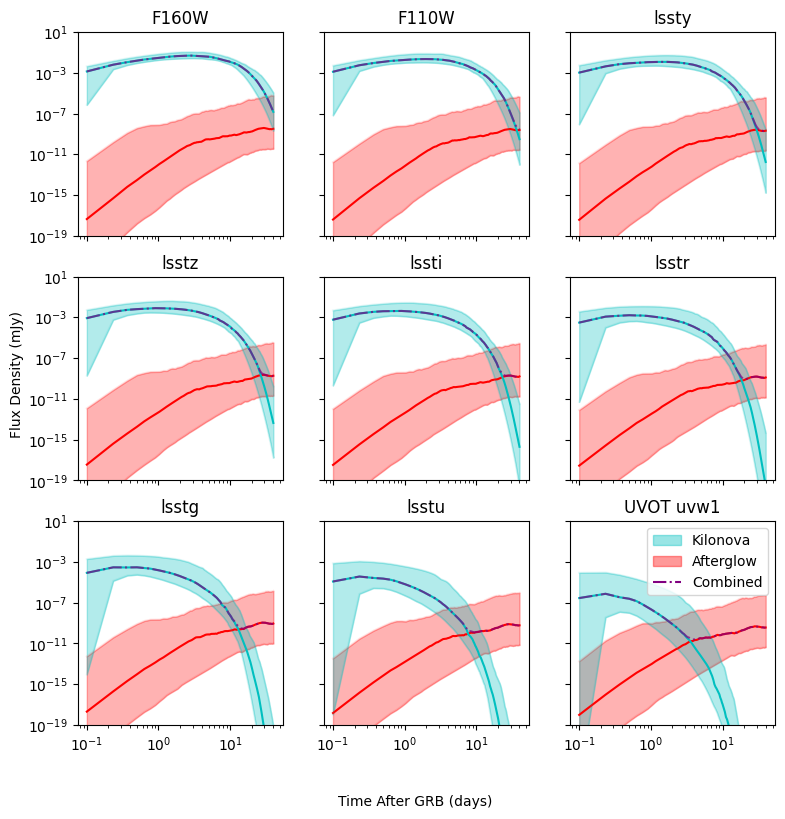

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,50,300)
#time2=np.linspace(0.1,40,100)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweroff[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].loglog(time, medianoff[i+(3*j)], c='r' )
        ax[j,i].loglog(time, upperoff[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].fill_between(time, loweroff[i+(3*j)], upperoff[i+(3*j)], color='r',  alpha=0.3)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[i+(3*j)], c='c')
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='c', alpha=0.3)
    
        ax[j,i].loglog(time, np.array(medianoff[i+(3*j)])+mediankn[i+(3*j)], c='purple', ls='-.', alpha=0.7)
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='c', label='Kilonova', alpha=0.4)
ag = mpatches.Patch(color='r', label='Afterglow', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='purple', label='Combined')

ax[2,2].legend(handles=[kn,ag,both])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
plt.savefig("off68final.png", dpi='figure')

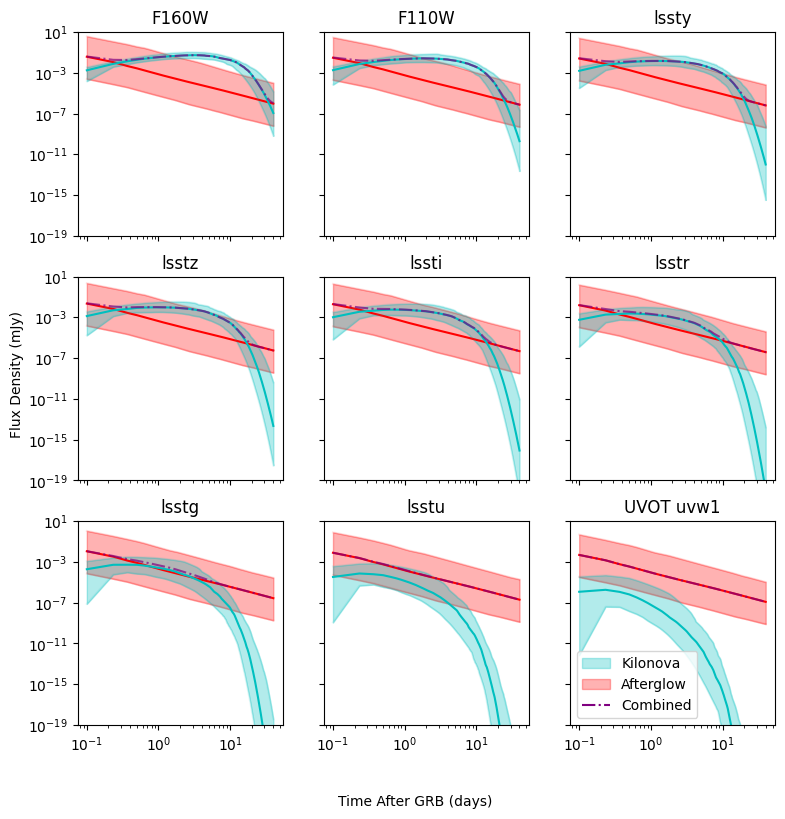

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,40,300)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweron[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].loglog(time, medianon[i+(3*j)], c='r' )
        ax[j,i].loglog(time, upperon[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].fill_between(time, loweron[i+(3*j)], upperon[i+(3*j)], color='r',  alpha=0.3)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[i+(3*j)], c='c')
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='c', alpha=0.3)
    
        ax[j,i].loglog(time, np.array(medianon[i+(3*j)])+mediankn[i+(3*j)], c='purple', ls='-.', alpha=0.7)
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')

kn = mpatches.Patch(color='c', label='Kilonova', alpha=0.3)
ag = mpatches.Patch(color='r', label='Afterglow', alpha=0.3)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='purple', label='Combined')

plt.legend(handles=[kn,ag,both])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20, 10)
plt.savefig("on68_midconstraint.png", dpi='figure')

(1e-19, 10)

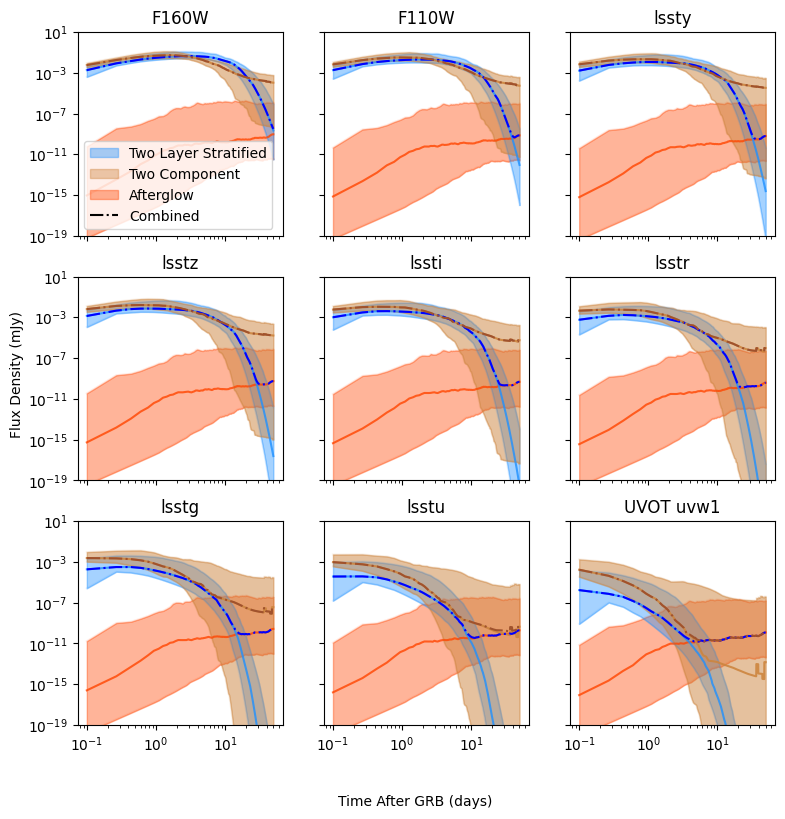

In [147]:
from scipy.signal import savgol_filter as savgol
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,50,300)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweroff[i+(3*j)], c='orangered',  alpha=0.1)
        ax[j,i].loglog(time, medianoff[i+(3*j)], c='orangered',alpha=0.8 )
        ax[j,i].loglog(time, upperoff[i+(3*j)], c='orangered',  alpha=0.1)
        ax[j,i].fill_between(time, loweroff[i+(3*j)], upperoff[i+(3*j)], color='orangered',  alpha=0.4)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='dodgerblue',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[i+(3*j)], c='dodgerblue', alpha=0.8)
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='dodgerblue',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='dodgerblue', alpha=0.4)

        ax[j,i].loglog(time, lowerkn2[i+(3*j)], c='peru',  alpha=0.1)
        ax[j,i].loglog(time, mediankn2[i+(3*j)], c='peru',alpha=0.9)
        ax[j,i].loglog(time, upperkn2[i+(3*j)], c='peru',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn2[i+(3*j)], upperkn2[i+(3*j)], color='peru', alpha=0.5)
    
        ax[j,i].loglog(time, np.array(medianoff[i+(3*j)])+mediankn[i+(3*j)], c='blue', ls='-.')
        ax[j,i].loglog(time, np.array(medianoff[i+(3*j)])+mediankn2[i+(3*j)], c='sienna', ls='-.')
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='dodgerblue', label='Two Layer Stratified', alpha=0.4)
kn2 = mpatches.Patch(color='peru', label='Two Component', alpha=0.4)
ag = mpatches.Patch(color='orangered', label='Afterglow', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='k', label='Combined')

ax[0,0].legend(handles=[kn,kn2,ag,both], loc='lower left')

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
#plt.savefig("off68_redback.png", dpi='figure')

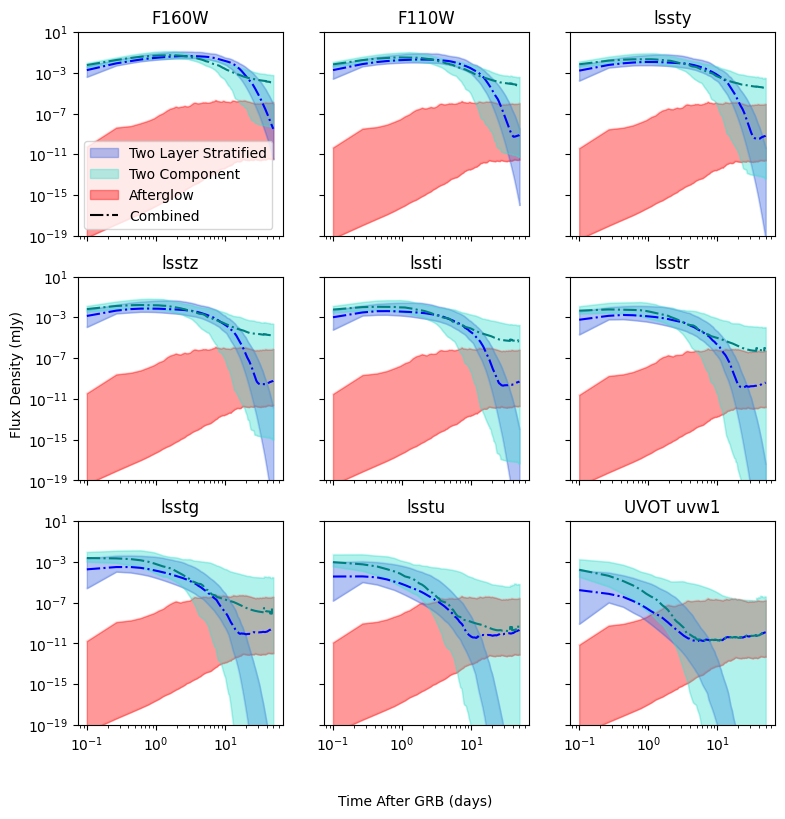

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,50,300)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweroff2[i+(3*j)], c='r',  alpha=0.1)
        #ax[j,i].loglog(time, medianoff2[i+(3*j)], c='r',alpha=0.8 )
        ax[j,i].loglog(time, upperoff2[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].fill_between(time, loweroff2[i+(3*j)], upperoff2[i+(3*j)], color='r',  alpha=0.4)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='royalblue',  alpha=0.1)
        #ax[j,i].loglog(time, mediankn[i+(3*j)], c='royalblue', alpha=0.8)
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='royalblue',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='royalblue', alpha=0.4)

        ax[j,i].loglog(time, lowerkn2[i+(3*j)], c='turquoise',  alpha=0.1)
        #ax[j,i].loglog(time, mediankn2[i+(3*j)], c='turquoise',alpha=0.9)
        ax[j,i].loglog(time, upperkn2[i+(3*j)], c='turquoise',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn2[i+(3*j)], upperkn2[i+(3*j)], color='turquoise', alpha=0.4)
    
        ax[j,i].loglog(time, np.array(medianoff2[i+(3*j)])+mediankn[i+(3*j)], c='blue', ls='-.')
        ax[j,i].loglog(time, np.array(medianoff2[i+(3*j)])+mediankn2[i+(3*j)], c='teal', ls='-.')
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='royalblue', label='Two Layer Stratified', alpha=0.4)
kn2 = mpatches.Patch(color='turquoise', label='Two Component', alpha=0.4)
ag = mpatches.Patch(color='r', label='Afterglow', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='k', label='Combined')

ax[0,0].legend(handles=[kn,kn2,ag,both], loc='lower left')

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
plt.savefig("off68_redback.png", dpi='figure')

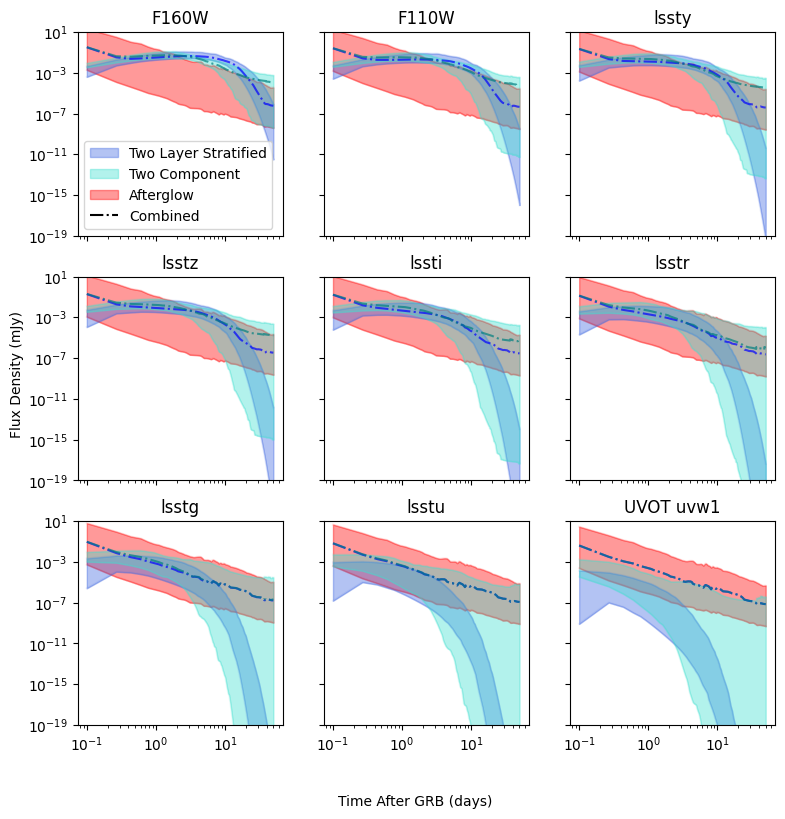

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,50,300)
#time2=np.linspace(0.1,40,100)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweron[i+(3*j)], c='r',  alpha=0.1)
        #ax[j,i].loglog(time, medianon[i+(3*j)], c='r' )
        ax[j,i].loglog(time, upperon[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].fill_between(time, loweron[i+(3*j)], upperon[i+(3*j)], color='r',  alpha=0.4)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='royalblue',  alpha=0.1)
        #ax[j,i].loglog(time, mediankn[i+(3*j)], c='royalblue')
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='royalblue',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='royalblue', alpha=0.4)

        ax[j,i].loglog(time, lowerkn2[i+(3*j)], c='turquoise',  alpha=0.1)
        #ax[j,i].loglog(time, mediankn2[i+(3*j)], c='turquoise')
        ax[j,i].loglog(time, upperkn2[i+(3*j)], c='turquoise',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn2[i+(3*j)], upperkn2[i+(3*j)], color='turquoise', alpha=0.4)
    
        ax[j,i].loglog(time, np.array(medianon[i+(3*j)])+mediankn[i+(3*j)], c='blue', ls='-.', alpha=0.7)
        ax[j,i].loglog(time, np.array(medianon[i+(3*j)])+mediankn2[i+(3*j)], c='teal', ls='-.', alpha=0.7)
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='royalblue', label='Two Layer Stratified', alpha=0.4)
kn2 = mpatches.Patch(color='turquoise', label='Two Component', alpha=0.4)
ag = mpatches.Patch(color='r', label='Afterglow', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='k', label='Combined')

ax[0,0].legend(handles=[kn,kn2,ag,both])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
plt.savefig("on68_redback.png", dpi='figure')

(1e-19, 10)

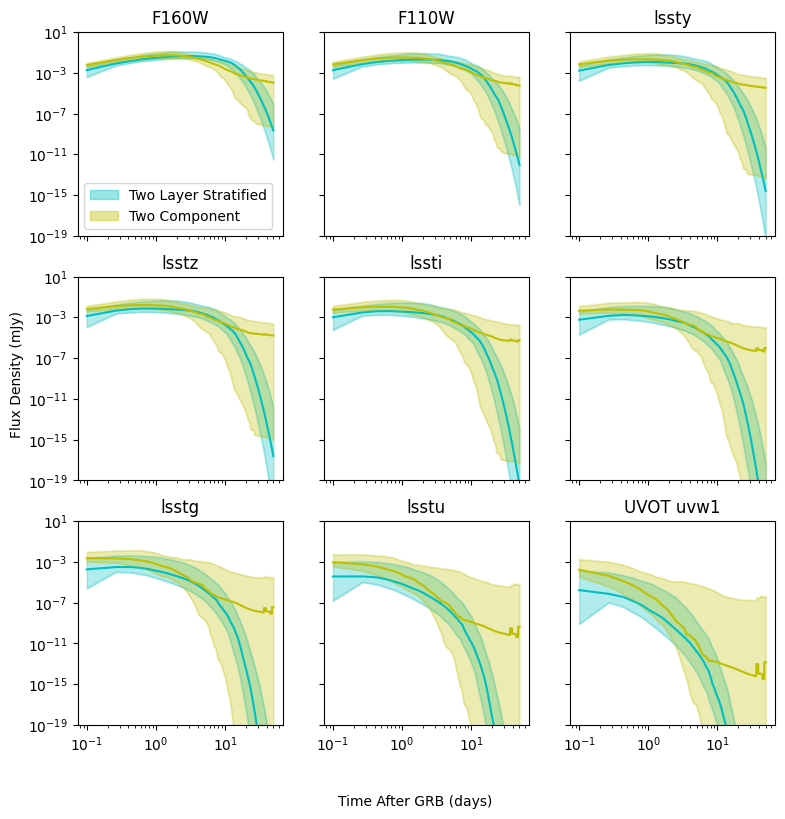

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,50,300)
#time2=np.linspace(0.1,40,100)

for j in range(3):
    
    for i in range(3):

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[i+(3*j)], c='c')
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='c', alpha=0.3)

        ax[j,i].loglog(time, lowerkn2[i+(3*j)], c='y',  alpha=0.1)
        ax[j,i].loglog(time, mediankn2[i+(3*j)], c='y')
        ax[j,i].loglog(time, upperkn2[i+(3*j)], c='y',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn2[i+(3*j)], upperkn2[i+(3*j)], color='y', alpha=0.3)
    
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='c', label='Two Layer Stratified', alpha=0.4)
kn2 = mpatches.Patch(color='y', label='Two Component', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
#both= Line2D([0],[0], ls='-.', c='k', label='Combined')

ax[0,0].legend(handles=[kn,kn2])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
#plt.savefig("on68_redback.png", dpi='figure')

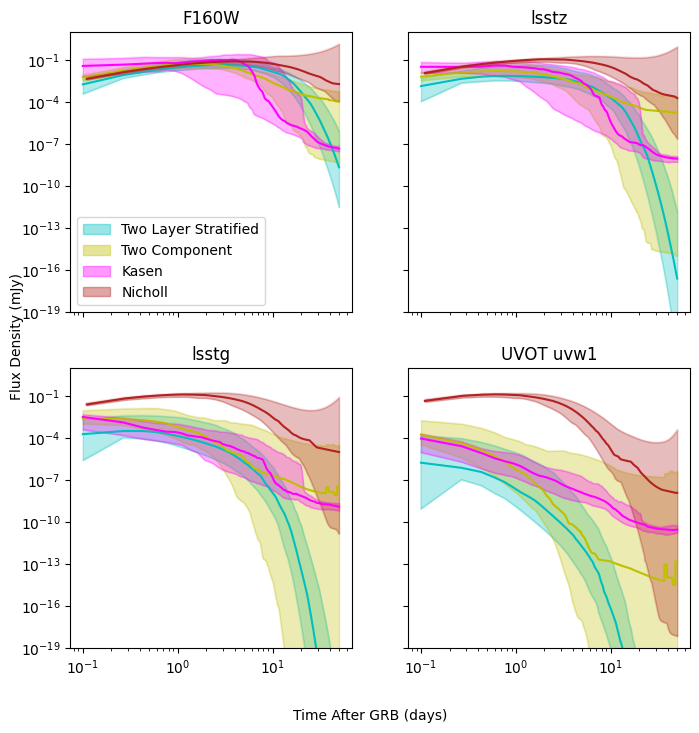

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)
time= np.linspace(0.1,50,300)
time2 = np.linspace(0.11,50,300)
#time2=np.linspace(0.1,40,100)
select_freqs=[0,3,6,8]

for j in range(2):
    for i in range(2):

        f=i+(2*j)
        s=select_freqs[f]
        ax[j,i].loglog(time, lowerkn[s], c='c',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[s], c='c')
        ax[j,i].loglog(time, upperkn[s], c='c',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[s], upperkn[s], color='c', alpha=0.3)

        ax[j,i].loglog(time, lowerkn2[s], c='y',  alpha=0.1)
        ax[j,i].loglog(time, mediankn2[s], c='y')
        ax[j,i].loglog(time, upperkn2[s], c='y',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn2[s], upperkn2[s], color='y', alpha=0.3)

        ax[j,i].loglog(time, lowerksen[f], c='magenta',  alpha=0.1)
        ax[j,i].loglog(time, medianksen[f], c='magenta')
        ax[j,i].loglog(time, upperksen[f], c='magenta',  alpha=0.1)
        ax[j,i].fill_between(time, lowerksen[f], upperksen[f], color='magenta', alpha=0.3)

        ax[j,i].loglog(time2, lowernicholl[f], c='firebrick',  alpha=0.1)
        ax[j,i].loglog(time2, mediannicholl[f], c='firebrick')
        ax[j,i].loglog(time2, uppernicholl[f], c='firebrick',  alpha=0.1)
        ax[j,i].fill_between(time2, lowernicholl[f], uppernicholl[f], color='firebrick', alpha=0.3)
    
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('lsstz')
ax[1,0].set_title('lsstg')
ax[1,1].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='c', label='Two Layer Stratified', alpha=0.4)
kn2 = mpatches.Patch(color='y', label='Two Component', alpha=0.4)
ksen = mpatches.Patch(color='magenta', label='Kasen', alpha=0.4)
nicholl = mpatches.Patch(color='firebrick', label='Nicholl', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
#both= Line2D([0],[0], ls='-.', c='k', label='Combined')

ax[0,0].legend(handles=[kn,kn2,ksen,nicholl])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
plt.savefig("4kilonova.png", dpi='figure')

In [ ]:
(10**-1.25)

In [20]:
10**-2.5

0.0031622776601683794

In [ ]:
(10**-1.25)/0.0031622776601683794